In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.cache import save_vtk_streamlines

from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

In [13]:
import importlib
importlib.reload(RLTe)

<module 'dfibert.envs.RLtractEnvironment' from '../dfibert/envs/RLtractEnvironment.py'>

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', 
                              pReferenceStreamlines='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk', 
                              tracking_in_RAS = False, odf_state = False)
n_actions = env.action_space.n

Loading precomputed streamlines (/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk) for ID 100307
sphere_odf = sphere_action = repulsion100
Computing ODF


In [4]:
env._init_shmcoeff()
print(env.shcoeff.shape)

(145, 174, 145, 45)


In [6]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
ijk_pts = env.grid + state.getCoordinate().cpu().detach().numpy()

(3, 3, 3, 3)


In [3]:
import dipy.reconst.dti as dti
dti_model = dti.TensorModel(env.dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(env.dataset.data.dwi, mask=env.dataset.data.binarymask)

# compute ODF
odf = dti_fit.odf(env.sphere_odf)
pmf = odf.clip(min=0)

In [4]:
print(pmf.shape)

(145, 174, 145, 100)


In [8]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
pmf_cur = env.pmf_gen.get_pmf(state.getCoordinate().double().squeeze(0).numpy())
reward = pmf_cur / np.max(pmf_cur)
print(np.argmax(reward))

93


In [52]:
shcoeff_action = []
action = None
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    if action is not None:
    #    pmf[pmf < 0.1] = 0
        last_direction = env.directions[action].view(3).numpy()
        cdf = env._adj_matrix[tuple(last_direction)] * pmf
        action = np.argmax(cdf)
    else:
        _, _, action = peak_directions(pmf, env.sphere)
        action = action[0]
    #shcoeff_action.append(action)
    #action = np.argmax(pmf)
    shcoeff_action.append(action)
    
print(shcoeff_action)

[47, 39, 97, 34, 42, 46, 41, 41, 41, 33]


In [8]:
from dipy.direction.peaks import peak_directions

In [51]:
odf_action = []
action = None
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf = (env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i])[:,1,1,1])
    if action is not None:
        #pmf[pmf < 0.1] = 0
        last_direction = env.directions[action].view(3).numpy()
        cdf = env._adj_matrix[tuple(last_direction)] * pmf
        action = np.argmax(cdf)
    else:
        _, _, action = peak_directions(pmf, env.sphere)
        action = action[0]
    #
    #action = np.argmax(pmf)
    odf_action.append(action)
    
print(odf_action)

[97, 39, 34, 34, 42, 46, 91, 91, 41, 33]


In [53]:
print(env.directions[shcoeff_action])
print(env.directions[odf_action])

tensor([[ 0.9555, -0.2809,  0.0905],
        [ 0.7840, -0.6188,  0.0487],
        [-0.9555,  0.2809, -0.0905],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9379,  0.2621,  0.2271],
        [-0.9068, -0.4049,  0.1173],
        [-0.6833, -0.7184,  0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6940, -0.5697,  0.4403]], dtype=torch.float64)
tensor([[-0.9555,  0.2809, -0.0905],
        [ 0.7840, -0.6188,  0.0487],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9292, -0.0795,  0.3610],
        [ 0.9379,  0.2621,  0.2271],
        [-0.9068, -0.4049,  0.1173],
        [ 0.6833,  0.7184, -0.1302],
        [ 0.6833,  0.7184, -0.1302],
        [-0.6833, -0.7184,  0.1302],
        [-0.6940, -0.5697,  0.4403]], dtype=torch.float64)


In [54]:
for i in range(len(env.referenceStreamline_ijk)-1):
    pmf_from_odf = env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i])[:,1,1,1]
    pmf_from_sh = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    
    print(i, gt_actions[i])
    print("ODF: ground-truth value: ", pmf_from_odf[gt_actions[i]], ", max: ", np.max(pmf_from_odf), ", index: ", np.argmax(pmf_from_odf))
    print("SH: ground-truth value: ", pmf_from_sh[gt_actions[i]], ", max: ", np.max(pmf_from_sh), ", index: ", np.argmax(pmf_from_sh))
    print("cosine similarity: odf: ", torch.nn.functional.cosine_similarity(env.directions[gt_actions[i]], env.directions[np.argmax(pmf_from_odf)], dim=0).numpy(), \
          ", sh: ", torch.nn.functional.cosine_similarity(env.directions[gt_actions[i]], env.directions[np.argmax(pmf_from_sh)], dim=0).numpy())
    print()

0 tensor(89)
ODF: ground-truth value:  0.07025151472668065 , max:  0.2083056523948617 , index:  97
SH: ground-truth value:  0.07651210435478413 , max:  0.18717188232323784 , index:  47
cosine similarity: odf:  0.927317149784872 , sh:  -0.927317149784872

1 tensor(97)
ODF: ground-truth value:  0.05577069505822985 , max:  0.06664159074558873 , index:  39
SH: ground-truth value:  0.056053058188785775 , max:  0.06588572586139903 , index:  39
cosine similarity: odf:  -0.927317149784872 , sh:  -0.927317149784872

2 tensor(84)
ODF: ground-truth value:  0.08455187126388458 , max:  0.08455187126388458 , index:  34
SH: ground-truth value:  0.08438419717861002 , max:  0.08444315032035168 , index:  97
cosine similarity: odf:  -1.0 , sh:  0.9427988734326452

3 tensor(92)
ODF: ground-truth value:  0.09954268080953793 , max:  0.10084170898446602 , index:  34
SH: ground-truth value:  0.0995375759969714 , max:  0.10084750351698793 , index:  34
cosine similarity: odf:  -0.9326351000205255 , sh:  -0.9326

In [38]:
state = env.reset(streamline_index=4, start_middle_of_streamline=False, start_index=0)
gt_actions = []
for i in range(len(env.referenceStreamline_ijk)-1):
    gt_vector = (env.referenceStreamline_ijk[i+1] - env.referenceStreamline_ijk[i]).view(1,3)
    action = torch.argmax(torch.nn.functional.cosine_similarity(env.directions, gt_vector))
    gt_actions.append(action)
    
print(gt_actions)

[tensor(89), tensor(97), tensor(84), tensor(92), tensor(46), tensor(41), tensor(41), tensor(41), tensor(33), tensor(33)]


In [5]:
terminal = False
all_states = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
current_direction = None
while not terminal:
    my_position = state.getCoordinate().double().squeeze(0)
    all_states.append(my_position)
    print(action)
    action = env._get_best_action(current_direction, my_position.numpy())
    current_direction = env.directions[action].numpy()
    state, reward, terminal, _  = env.step(action)
    
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

NameError: name 'action' is not defined

In [6]:
env.reset()
env.referenceStreamline_ijk

tensor([[23.8278, 77.7661, 50.4897],
        [24.5447, 77.4656, 50.3005],
        [25.2732, 77.4055, 49.9754],
        [25.5940, 77.9652, 49.5023],
        [25.9148, 78.5249, 49.0293],
        [26.4700, 78.9807, 48.6771],
        [27.0251, 79.4365, 48.3248],
        [26.6042, 79.8737, 47.8037],
        [26.0320, 80.0483, 47.2726],
        [25.4597, 80.2229, 46.7414],
        [24.8875, 80.3975, 46.2103],
        [24.2499, 80.7637, 45.8952],
        [23.6123, 81.1300, 45.5801],
        [22.8479, 81.3547, 45.5077],
        [22.1310, 81.6552, 45.6968],
        [21.4142, 81.9557, 45.8860],
        [21.0027, 82.6414, 45.9119],
        [20.2743, 82.7014, 46.2370],
        [19.7169, 82.6995, 46.8108],
        [19.0000, 83.0000, 47.0000]])

### Create dataset based on ISMRM seed points and odf-based reward function

In [2]:
# load ISMRM dataset and calc seeds
from dfibert.data import ISMRMDataContainer 
from dipy.tracking import utils
import dipy.reconst.dti as dti


dataset = ISMRMDataContainer()

dti_model = dti.TensorModel(dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(dataset.data.dwi, mask=dataset.data.binarymask)
fa_img = dti_fit.fa

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

In [3]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', seeds = torch.FloatTensor(seeds), tracking_in_RAS = False, odf_state = False)
env.dataset = dataset
env.dataset.generate_fa()
env._init_odf()
env.reset(seed_index=0)

Loading dataset #  100307
sphere_odf = sphere_action = repulsion100
Computing ODF


In [6]:
streamlines = []
for i in trange(len(seeds)):
    terminal = False
    all_states = []
    state = env.reset(seed_index=i)
    current_direction = None
    all_states.append(state.getCoordinate().numpy())
    terminal = False
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        #print(action)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action)
        all_states.append(state.getCoordinate().squeeze(0).numpy())

    state = env.reset(seed_index=i, terminal_F=True)
    #print(env.seed_index)
    current_direction = None
    terminal = False
    all_states = all_states[::-1]
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action, direction="backward")
        if False in torch.eq(state.getCoordinate().squeeze(0), my_position):
            all_states.append(state.getCoordinate().squeeze(0).numpy())
            
    streamlines.append(np.asarray(all_states))

  0%|          | 24/56234 [00:00<09:12, 101.74it/s]

0
Terminal due to too low fa.  [0.05042913]
1
Terminal due to too low fa.  [0.01294982]
2
Terminal due to too low fa.  [0.06205295]
3
Terminal due to too low fa.  [0.07603107]
4
Terminal due to too low fa.  [0.07270109]
Terminal due to too low fa.  [0.05177478]
5
Terminal due to too low fa.  [0.05324482]
6
7
Terminal due to too low fa.  [0.08954196]
8
Terminal due to too low fa.  [0.08963123]
9
Terminal due to too low fa.  [0.05647214]
10
Terminal due to too low fa.  [0.05817494]
11
12
Terminal due to too low fa.  [0.09076333]
Terminal due to too low fa.  [0.03183914]
13
Terminal due to too low fa.  [0.09312282]
14
Terminal due to too low fa.  [0.03556512]
15
Terminal due to too low fa.  [0.09076174]
16
Terminal due to too low fa.  [0.08465498]
Terminal due to too low fa.  [0.06384835]
17
Terminal due to too low fa.  [0.08609077]
Terminal due to too low fa.  [0.04478363]
18
Terminal due to too low fa.  [0.05464705]
19
Terminal due to too low fa.  [0.09895353]
20
Terminal due to too low

  0%|          | 53/56234 [00:00<07:58, 117.51it/s]

Terminal due to too low fa.  [0.04535309]
25
Terminal due to too low fa.  [0.04909071]
26
27
Terminal due to too low fa.  [0.06946535]
Terminal due to too low fa.  [0.08335974]
28
Terminal due to too low fa.  [0.06416573]
29
Terminal due to too low fa.  [0.09521586]
30
31
Terminal due to too low fa.  [0.08204395]
Terminal due to too low fa.  [0.08544522]
32
Terminal due to too low fa.  [0.07859801]
33
Terminal due to too low fa.  [0.05505446]
Terminal due to too low fa.  [0.04120268]
34
Terminal due to too low fa.  [0.08120233]
Terminal due to too low fa.  [0.06437577]
35
Terminal due to too low fa.  [0.07037669]
36
Terminal due to too low fa.  [0.05194447]
37
38
Terminal due to too low fa.  [0.05362653]
39
Terminal due to too low fa.  [0.0785017]
40
Terminal due to too low fa.  [0.04919152]
41
Terminal due to too low fa.  [0.06241372]
Terminal due to too low fa.  [0.06216935]
42
Terminal due to too low fa.  [0.09662212]
43
Terminal due to too low fa.  [0.05499013]
44
Terminal due to t

  0%|          | 80/56234 [00:00<07:33, 123.83it/s]

53
Terminal due to too low fa.  [0.07017842]
54
Terminal due to too low fa.  [0.0944221]
55
Terminal due to too low fa.  [0.05512691]
Terminal due to too low fa.  [0.03361187]
56
Terminal due to too low fa.  [0.08033865]
57
Terminal due to too low fa.  [0.00971781]
58
Terminal due to too low fa.  [0.08904797]
Terminal due to too low fa.  [0.09641054]
59
Terminal due to too low fa.  [0.]
60
Terminal due to too low fa.  [0.]
61
62
Terminal due to too low fa.  [0.05021529]
63
64
65
Terminal due to too low fa.  [0.077188]
66
Terminal due to too low fa.  [0.04932613]
67
Terminal due to too low fa.  [0.09228015]
Terminal due to too low fa.  [0.0541296]
68
Terminal due to too low fa.  [0.08456176]
Terminal due to too low fa.  [0.03319779]
69
Terminal due to too low fa.  [0.08240371]
Terminal due to too low fa.  [0.07493038]
70
Terminal due to too low fa.  [0.07086024]
71
Terminal due to too low fa.  [0.05060286]
72
Terminal due to too low fa.  [0.04552235]
73
Terminal due to too low fa.  [0.0

  0%|          | 95/56234 [00:00<07:19, 127.83it/s]

80
81
Terminal due to too low fa.  [0.07753629]
82
Terminal due to too low fa.  [0.04192899]
83
84
Terminal due to too low fa.  [0.08539936]
85
Terminal due to too low fa.  [0.03130575]
86
87
Terminal due to too low fa.  [0.08165785]
88
Terminal due to too low fa.  [0.03948627]
89
90
91
Terminal due to too low fa.  [0.02572599]
Terminal due to too low fa.  [0.07929869]
92
93
94
95
Terminal due to too low fa.  [0.07367252]
96
97
98
99
Terminal due to too low fa.  [0.06195366]
100
101
Terminal due to too low fa.  [0.06480714]
102
103
104
Terminal due to too low fa.  [0.05921945]
105
106
107
Terminal due to too low fa.  [0.08588701]
108


  0%|          | 127/56234 [00:00<06:37, 141.06it/s]

Terminal due to too low fa.  [0.05880502]
Terminal due to too low fa.  [0.08647767]
109
110
Terminal due to too low fa.  [0.06654763]
Terminal due to too low fa.  [0.04763145]
111
Terminal due to too low fa.  [0.06586633]
112
Terminal due to too low fa.  [0.08855104]
113
Terminal due to too low fa.  [0.03936673]
Terminal due to too low fa.  [0.]
114
Terminal due to too low fa.  [0.09351567]
115
116
Terminal due to too low fa.  [0.04555038]
Terminal due to too low fa.  [0.05573814]
117
Terminal due to too low fa.  [0.]
118
Terminal due to too low fa.  [0.08609228]
119
Terminal due to too low fa.  [0.07862535]
120
Terminal due to too low fa.  [0.01129321]
121
Terminal due to too low fa.  [0.06737972]
Terminal due to too low fa.  [0.08170223]
122
123
Terminal due to too low fa.  [0.]
124
Terminal due to too low fa.  [0.08259963]
125
Terminal due to too low fa.  [0.06230799]
126
Terminal due to too low fa.  [0.06438872]
127
Terminal due to too low fa.  [0.08841767]
128
Terminal due to too 

  0%|          | 158/56234 [00:01<06:39, 140.45it/s]

Terminal due to too low fa.  [0.05563032]
141
Terminal due to too low fa.  [0.08952324]
142
143
144
145
146
147
Terminal due to too low fa.  [0.04689929]
148
Terminal due to too low fa.  [0.04403733]
149
150
Terminal due to too low fa.  [0.06335497]
151
152
Terminal due to too low fa.  [0.07694184]
Terminal due to too low fa.  [0.03975539]
153
154
155
156
157
Terminal due to too low fa.  [0.02235486]
158
159
Terminal due to too low fa.  [0.09520334]
Terminal due to too low fa.  [0.]
160
161
162
163
Terminal due to too low fa.  [0.07756279]
164
Terminal due to too low fa.  [0.08702674]
165
Terminal due to too low fa.  [0.08029165]
166
Terminal due to too low fa.  [0.04430892]


  0%|          | 187/56234 [00:01<06:44, 138.47it/s]

167
Terminal due to too low fa.  [0.09301743]
168
169
Terminal due to too low fa.  [0.09473373]
170
Terminal due to too low fa.  [0.0547135]
Terminal due to too low fa.  [0.00220466]
171
172
Terminal due to too low fa.  [0.05579985]
173
Terminal due to too low fa.  [0.09045485]
174
Terminal due to too low fa.  [0.09497118]
175
176
Terminal due to too low fa.  [0.09260379]
177
Terminal due to too low fa.  [0.07033277]
178
179
Terminal due to too low fa.  [0.08343971]
Terminal due to too low fa.  [0.08900195]
180
Terminal due to too low fa.  [0.06575702]
Terminal due to too low fa.  [0.09580101]
181
Terminal due to too low fa.  [0.06723016]
182
Terminal due to too low fa.  [0.08191974]
Terminal due to too low fa.  [0.00994598]
183
184
Terminal due to too low fa.  [0.09147798]
185
Terminal due to too low fa.  [0.]
186
Terminal due to too low fa.  [0.08461296]
187
Terminal due to too low fa.  [0.04655706]
188
Terminal due to too low fa.  [0.06689823]
189
Terminal due to too low fa.  [0.078

  0%|          | 217/56234 [00:01<06:42, 139.25it/s]

197
198
Terminal due to too low fa.  [0.07712909]
199
200
201
Terminal due to too low fa.  [0.03997601]
202
203
204
Terminal due to too low fa.  [0.0965602]
205
206
207
Terminal due to too low fa.  [0.]
208
209
210
211
Terminal due to too low fa.  [0.04887132]
212
213
214
Terminal due to too low fa.  [0.09757219]
215
Terminal due to too low fa.  [0.09796033]
216
217
218
219
220
221
222
223
224


  0%|          | 245/56234 [00:01<07:43, 120.68it/s]

Terminal due to too low fa.  [0.09585192]
225
226
Terminal due to too low fa.  [0.03158958]
227
228
229
230
Terminal due to too low fa.  [0.09356895]
231
Terminal due to too low fa.  [0.01080796]
232
Terminal due to too low fa.  [0.06776923]
233
234
235
236
237
Terminal due to too low fa.  [0.]
238
Terminal due to too low fa.  [0.04695908]
239
240
Terminal due to too low fa.  [0.07195087]
241
242
243
Terminal due to too low fa.  [0.04024763]
244
245


  0%|          | 258/56234 [00:01<07:57, 117.35it/s]

246
247
Terminal due to too low fa.  [0.07543333]
248
Terminal due to too low fa.  [0.01074905]
249
Terminal due to too low fa.  [0.08922297]
250
251
Terminal due to too low fa.  [0.0055391]
252
253
Terminal due to too low fa.  [0.07546693]
254
255
Terminal due to too low fa.  [0.09686539]
256
Terminal due to too low fa.  [0.08834418]
257
Terminal due to too low fa.  [0.]
258
259
Terminal due to too low fa.  [0.0984268]
260
Terminal due to too low fa.  [0.09399815]
Terminal due to too low fa.  [0.09074368]
261
Terminal due to too low fa.  [0.08792851]
Terminal due to too low fa.  [0.05854646]
262
263
Terminal due to too low fa.  [0.09936095]
264
265
Terminal due to too low fa.  [0.]
266
Terminal due to too low fa.  [0.04552719]
267
Terminal due to too low fa.  [0.09160529]
Terminal due to too low fa.  [0.08072951]
268
Terminal due to too low fa.  [0.04988719]
269
Terminal due to too low fa.  [0.06341144]
270
271


  1%|          | 287/56234 [00:02<07:18, 127.60it/s]

Terminal due to too low fa.  [0.09828096]
272
Terminal due to too low fa.  [0.08222168]
273
274
Terminal due to too low fa.  [0.06084267]
Terminal due to too low fa.  [0.00032512]
275
Terminal due to too low fa.  [0.08396411]
276
Terminal due to too low fa.  [0.06084236]
277
Terminal due to too low fa.  [0.04652456]
278
Terminal due to too low fa.  [0.07377856]
279
Terminal due to too low fa.  [0.06737048]
280
281
Terminal due to too low fa.  [0.06245273]
282
283
Terminal due to too low fa.  [0.08285134]
Terminal due to too low fa.  [0.08426932]
284
Terminal due to too low fa.  [0.]
285
Terminal due to too low fa.  [0.02489714]
286
287
288
Terminal due to too low fa.  [0.06793014]
289
Terminal due to too low fa.  [0.06875435]
Terminal due to too low fa.  [0.06722882]
290
Terminal due to too low fa.  [0.06069963]
291
Terminal due to too low fa.  [0.09372463]
Terminal due to too low fa.  [0.04555062]
292
Terminal due to too low fa.  [0.08661335]
293
Terminal due to too low fa.  [0.077545

  1%|          | 317/56234 [00:02<07:46, 119.74it/s]

Terminal due to too low fa.  [0.01529452]
302
Terminal due to too low fa.  [0.07111821]
303
Terminal due to too low fa.  [0.08849018]
304
305
306
Terminal due to too low fa.  [0.08028808]
307
Terminal due to too low fa.  [0.098095]
308
Terminal due to too low fa.  [0.09807567]
309
310
Terminal due to too low fa.  [0.06712599]
311
312
313
314
315
Terminal due to too low fa.  [0.09051164]
316
317
Terminal due to too low fa.  [0.08889032]
318
319
320
321
322


  1%|          | 343/56234 [00:02<08:00, 116.28it/s]

323
324
325
Terminal due to too low fa.  [0.06440673]
326
327
Terminal due to too low fa.  [0.03553045]
Terminal due to too low fa.  [0.09815579]
328
329
Terminal due to too low fa.  [0.09345629]
330
331
Terminal due to too low fa.  [0.09774898]
332
333
Terminal due to too low fa.  [0.09063259]
334
335
336
337
338
339
Terminal due to too low fa.  [0.03571025]
340
Terminal due to too low fa.  [0.07965635]
Terminal due to too low fa.  [0.09181339]
341
342
343
Terminal due to too low fa.  [0.0545458]
344


  1%|          | 367/56234 [00:02<08:39, 107.59it/s]

345
346
347
348
349
350
Terminal due to too low fa.  [0.08477706]
351
352
353
Terminal due to too low fa.  [0.05933545]
354
355
356
Terminal due to too low fa.  [0.06455316]
357
358
Terminal due to too low fa.  [0.09712943]
359
360
Terminal due to too low fa.  [0.09165771]
361
362
363
364
365
366


  1%|          | 379/56234 [00:02<08:28, 109.77it/s]

Terminal due to too low fa.  [0.08354871]
367
368
369
370
371
372
373
Terminal due to too low fa.  [0.04356878]
374
375
376
377
378
379
Terminal due to too low fa.  [0.09524151]
380
381
382
383
384
385
386
Terminal due to too low fa.  [0.02893691]
387
Terminal due to too low fa.  [0.04272426]
388
Terminal due to too low fa.  [0.09354983]
389
Terminal due to too low fa.  [0.0874026]
Terminal due to too low fa.  [0.07582808]
390
391
392
Terminal due to too low fa.  [0.09269007]
393


  1%|          | 409/56234 [00:03<07:25, 125.24it/s]

Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.06118035]
394
Terminal due to too low fa.  [0.07613369]
Terminal due to too low fa.  [0.09366163]
395
Terminal due to too low fa.  [0.06053826]
396
Terminal due to too low fa.  [0.075119]
Terminal due to too low fa.  [0.]
397
Terminal due to too low fa.  [0.09930291]
398
Terminal due to too low fa.  [0.06123745]
Terminal due to too low fa.  [0.08452518]
399
Terminal due to too low fa.  [0.05094408]
400
Terminal due to too low fa.  [0.03624212]
401
402
Terminal due to too low fa.  [0.06567624]
403
Terminal due to too low fa.  [0.05989498]
404
Terminal due to too low fa.  [0.06418438]
Terminal due to too low fa.  [0.09442865]
405
Terminal due to too low fa.  [0.04910838]
406
Terminal due to too low fa.  [0.07152212]
407
408
409
Terminal due to too low fa.  [0.06858813]
410
Terminal due to too low fa.  [0.08585798]
411
Terminal due to too low fa.  [0.09917501]
412
413
Terminal due to too low fa.  [0.08682376]
Terminal due t

  1%|          | 437/56234 [00:03<07:35, 122.62it/s]

422
Terminal due to too low fa.  [0.07599723]
423
424
Terminal due to too low fa.  [0.07896796]
425
Terminal due to too low fa.  [0.06117708]
426
427
428
429
430
431
432
433
434
Terminal due to too low fa.  [0.01654119]
435
436
437
438
439
440
441
442


  1%|          | 462/56234 [00:03<08:50, 105.21it/s]

Terminal due to too low fa.  [0.06360634]
443
Terminal due to too low fa.  [0.09092289]
444
445
Terminal due to too low fa.  [0.0861222]
446
447
Terminal due to too low fa.  [0.08105635]
448
449
450
451
452
453
454
455
456
457
Terminal due to too low fa.  [0.09834196]
458
459
460
461
462


  1%|          | 473/56234 [00:03<09:21, 99.22it/s] 

463
464
465
466
467
Terminal due to too low fa.  [0.08049764]
468
Terminal due to too low fa.  [0.09567949]
469
Terminal due to too low fa.  [0.09937477]
470
471
472
473
474
475
476
477
478
479
480
481


  1%|          | 495/56234 [00:04<09:09, 101.37it/s]

482
483
484
Terminal due to too low fa.  [0.09669262]
485
486
Terminal due to too low fa.  [0.09891661]
487
488
Terminal due to too low fa.  [0.09766021]
489
Terminal due to too low fa.  [0.09686713]
490
491
492
493
494
495
496
497
498
499
500
501
502


  1%|          | 521/56234 [00:04<08:21, 111.17it/s]

Terminal due to too low fa.  [0.]
503
Terminal due to too low fa.  [0.08144731]
504
505
506
507
508
509
510
511
512
513
Terminal due to too low fa.  [0.08378524]
514
515
516
517
518
519
Terminal due to too low fa.  [0.0906624]
520
521
522
523
524
Terminal due to too low fa.  [0.05361988]
525
Terminal due to too low fa.  [0.03327245]
Terminal due to too low fa.  [0.06688916]
526
Terminal due to too low fa.  [0.04952302]
527
528
Terminal due to too low fa.  [0.08389968]
529
Terminal due to too low fa.  [0.01061021]
530
531
Terminal due to too low fa.  [0.04683046]


  1%|          | 553/56234 [00:04<07:09, 129.74it/s]

Terminal due to too low fa.  [0.03460091]
532
533
534
535
Terminal due to too low fa.  [0.05424549]
536
Terminal due to too low fa.  [0.06158985]
537
538
Terminal due to too low fa.  [0.07997975]
539
Terminal due to too low fa.  [0.09235293]
540
Terminal due to too low fa.  [0.0990132]
541
542
Terminal due to too low fa.  [0.08345954]
543
Terminal due to too low fa.  [0.09712972]
Terminal due to too low fa.  [0.03465556]
544
545
546
Terminal due to too low fa.  [0.06003285]
547
Terminal due to too low fa.  [0.09037656]
Terminal due to too low fa.  [0.06746971]
548
Terminal due to too low fa.  [0.05780038]
Terminal due to too low fa.  [0.0425168]
549
Terminal due to too low fa.  [0.09739977]
Terminal due to too low fa.  [0.0559412]
550
551
552
553
554
Terminal due to too low fa.  [0.00898496]
Terminal due to too low fa.  [0.]
555
Terminal due to too low fa.  [0.]
556
557
Terminal due to too low fa.  [0.]
558
559
560
561
Terminal due to too low fa.  [0.03692102]
Terminal due to too low f

  1%|          | 582/56234 [00:04<07:29, 123.74it/s]

Terminal due to too low fa.  [0.07560213]
563
Terminal due to too low fa.  [0.]
564
Terminal due to too low fa.  [0.08140278]
565
566
Terminal due to too low fa.  [0.0904255]
567
Terminal due to too low fa.  [0.02553067]
568
569
570
571
572
Terminal due to too low fa.  [0.02306723]
573
Terminal due to too low fa.  [0.06987828]
574
Terminal due to too low fa.  [0.0732006]
575
Terminal due to too low fa.  [0.05305246]
576
Terminal due to too low fa.  [0.03498867]
Terminal due to too low fa.  [0.01518801]
577
Terminal due to too low fa.  [0.03925342]
578
579
Terminal due to too low fa.  [0.09770322]
Terminal due to too low fa.  [0.08263159]
580
Terminal due to too low fa.  [0.09756878]
581
Terminal due to too low fa.  [0.05234977]
582
Terminal due to too low fa.  [0.0130933]
583
Terminal due to too low fa.  [0.05957861]
584


  1%|          | 595/56234 [00:04<07:51, 118.01it/s]

585
586
587
588
589
Terminal due to too low fa.  [0.00221919]
590
591
592
593
Terminal due to too low fa.  [0.09209118]
594
Terminal due to too low fa.  [0.05514333]
595
596
597
598
599
600
601
602
603
Terminal due to too low fa.  [0.09259453]
604
605


  1%|          | 620/56234 [00:05<08:25, 110.04it/s]

606
607
608
609
Terminal due to too low fa.  [0.09895926]
610
611
612
613
614
615
616
Terminal due to too low fa.  [0.06640551]
617
618
619
620
621
622
623
624


  1%|          | 643/56234 [00:05<10:06, 91.68it/s] 

625
626
627
628
629
630
631
Terminal due to too low fa.  [0.00559898]
632
633
634
635
636
637
638
639
640
Terminal due to too low fa.  [0.01960303]
641
642
Terminal due to too low fa.  [0.06939387]
643


  1%|          | 655/56234 [00:05<09:47, 94.54it/s]

644
645
646
647
648
649
650
651
652
653
654
655
656
Terminal due to too low fa.  [0.0998945]
657
658
659
660
661
662


  1%|          | 679/56234 [00:05<09:15, 99.93it/s]

663
664
665
666
Terminal due to too low fa.  [0.09700611]
667
668
669
670
671
672
673
674
Terminal due to too low fa.  [0.03655035]
675
676
Terminal due to too low fa.  [0.08971844]
677
678
Terminal due to too low fa.  [0.07487131]
679
680
681
682
683
684
685
686
687


  1%|▏         | 705/56234 [00:05<08:13, 112.63it/s]

688
689
690
691
692
693
694
695
696
697
698
699
700
Terminal due to too low fa.  [0.09594914]
701
702
703
704
705
706
707
708
709
Terminal due to too low fa.  [0.07455568]
710
711
712
Terminal due to too low fa.  [0.09769673]
713
Terminal due to too low fa.  [0.09531373]
714
715


  1%|▏         | 734/56234 [00:06<07:19, 126.39it/s]

716
717
718
719
720
721
722
723
724
725
Terminal due to too low fa.  [0.03262711]
726
727
728
729
730
Terminal due to too low fa.  [0.09518493]
731
732
733
734
Terminal due to too low fa.  [0.09193538]
735
Terminal due to too low fa.  [0.0458175]
736
Terminal due to too low fa.  [0.04849689]
737
738
Terminal due to too low fa.  [0.05833674]
739
740
741


  1%|▏         | 762/56234 [00:06<07:16, 127.12it/s]

Terminal due to too low fa.  [0.07891326]
742
Terminal due to too low fa.  [0.09051396]
743
744
Terminal due to too low fa.  [0.00908502]
Terminal due to too low fa.  [0.]
745
746
747
748
Terminal due to too low fa.  [0.]
749
Terminal due to too low fa.  [0.01418722]
750
Terminal due to too low fa.  [0.09100383]
751
Terminal due to too low fa.  [0.04221669]
752
753
Terminal due to too low fa.  [0.04949562]
754
755
Terminal due to too low fa.  [0.05965593]
Terminal due to too low fa.  [0.]
756
Terminal due to too low fa.  [0.09957566]
757
Terminal due to too low fa.  [0.07552717]
Terminal due to too low fa.  [0.07478023]
758
Terminal due to too low fa.  [0.09326743]
759
760
Terminal due to too low fa.  [0.09570609]
761
Terminal due to too low fa.  [0.09136325]
762
763
764
Terminal due to too low fa.  [0.09421323]
Terminal due to too low fa.  [0.0656242]
765
766
Terminal due to too low fa.  [0.04974164]
767
Terminal due to too low fa.  [0.0960962]
768
769
Terminal due to too low fa.  [0.

  1%|▏         | 778/56234 [00:06<06:55, 133.32it/s]

771
Terminal due to too low fa.  [0.07410923]
772
773
774
Terminal due to too low fa.  [0.08000246]
775
776
Terminal due to too low fa.  [0.06397133]
Terminal due to too low fa.  [0.09645862]
777
Terminal due to too low fa.  [0.06684744]
778
779
Terminal due to too low fa.  [0.05008054]
780
Terminal due to too low fa.  [0.04907507]
Terminal due to too low fa.  [0.09049923]
781
782
783
784
785
786
787
788


  1%|▏         | 804/56234 [00:06<08:31, 108.40it/s]

789
790
Terminal due to too low fa.  [0.09808443]
791
792
793
794
795
Terminal due to too low fa.  [0.]
796
797
798
799
800
Terminal due to too low fa.  [0.05118345]
801
802
803
Terminal due to too low fa.  [0.]
804
805
806
807
808
809
Terminal due to too low fa.  [0.03839196]
810
Terminal due to too low fa.  [0.08182327]
811
Terminal due to too low fa.  [0.0994175]


  1%|▏         | 829/56234 [00:06<08:05, 114.04it/s]

812
813
Terminal due to too low fa.  [0.09183579]
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
Terminal due to too low fa.  [0.09162816]
829
830
831
832
833
834
835


  2%|▏         | 855/56234 [00:07<07:52, 117.32it/s]

836
837
838
839
840
841
Terminal due to too low fa.  [0.09079168]
842
843
844
845
846
847
848
849
850
851
852
Terminal due to too low fa.  [0.04936326]
853
854
Terminal due to too low fa.  [0.04777904]
855
856
857
858
859
860


  2%|▏         | 867/56234 [00:07<08:20, 110.58it/s]

861
862
863
864
Terminal due to too low fa.  [0.00244109]
865
866
Terminal due to too low fa.  [0.04591701]
867
868
869
870
871
872
873
874
Terminal due to too low fa.  [0.08791422]
875


  2%|▏         | 890/56234 [00:07<10:21, 88.98it/s] 

876
877
878
879
880
881
882
883
884
885
886
887
888
889
890


  2%|▏         | 911/56234 [00:07<10:21, 88.99it/s]

891
892
Terminal due to too low fa.  [0.05838272]
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911


  2%|▏         | 935/56234 [00:08<09:08, 100.77it/s]

912
913
914
Terminal due to too low fa.  [0.08445663]
915
Terminal due to too low fa.  [0.03388236]
916
917
Terminal due to too low fa.  [0.02357726]
918
919
920
921
922
923
924
925
Terminal due to too low fa.  [0.04275707]
926
Terminal due to too low fa.  [0.04899085]
927
928
929
930
931
932
933
Terminal due to too low fa.  [0.05301071]
934
Terminal due to too low fa.  [0.03501561]
935


  2%|▏         | 964/56234 [00:08<07:49, 117.68it/s]

936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
Terminal due to too low fa.  [0.]
953
Terminal due to too low fa.  [0.03527933]
954
955
956
957
958
959
Terminal due to too low fa.  [0.07361111]
960
Terminal due to too low fa.  [0.03295164]
961
962
963
964
965


  2%|▏         | 990/56234 [00:08<07:40, 119.84it/s]

966
967
Terminal due to too low fa.  [0.09406335]
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
Terminal due to too low fa.  [0.03189051]
983
984
Terminal due to too low fa.  [0.0931316]
985
986
987
988
989
990


  2%|▏         | 1017/56234 [00:08<07:28, 123.10it/s]

991
Terminal due to too low fa.  [0.06843481]
992
Terminal due to too low fa.  [0.09686919]
Terminal due to too low fa.  [0.09732785]
993
994
Terminal due to too low fa.  [0.08913484]
995
Terminal due to too low fa.  [0.07934547]
Terminal due to too low fa.  [0.]
996
Terminal due to too low fa.  [0.06704612]
997
998
999
Terminal due to too low fa.  [0.07220684]
Terminal due to too low fa.  [0.08745939]
1000
1001
1002
1003
1004
Terminal due to too low fa.  [0.09669269]
1005
Terminal due to too low fa.  [0.04067832]
1006
1007
Terminal due to too low fa.  [0.08656814]
1008
1009
1010
Terminal due to too low fa.  [0.07810964]
1011
1012
1013
Terminal due to too low fa.  [0.06732469]
1014
1015
Terminal due to too low fa.  [0.07532684]
1016
Terminal due to too low fa.  [0.06628539]
1017


  2%|▏         | 1032/56234 [00:08<07:07, 129.25it/s]

1018
Terminal due to too low fa.  [0.09176203]
1019
1020
Terminal due to too low fa.  [0.0839463]
1021
1022
Terminal due to too low fa.  [0.09821116]
Terminal due to too low fa.  [0.08770237]
1023
1024
1025
Terminal due to too low fa.  [0.09055828]
1026
1027
1028
Terminal due to too low fa.  [0.09939929]
Terminal due to too low fa.  [0.06960635]
1029
1030
1031
Terminal due to too low fa.  [0.09636667]
1032
1033
Terminal due to too low fa.  [0.]
1034
Terminal due to too low fa.  [0.05505974]
1035
Terminal due to too low fa.  [0.]
1036
1037
Terminal due to too low fa.  [0.07866524]
1038
Terminal due to too low fa.  [0.07704771]
1039
Terminal due to too low fa.  [0.07228235]
1040
Terminal due to too low fa.  [0.05897969]
1041
Terminal due to too low fa.  [0.03694]
1042
Terminal due to too low fa.  [0.]
1043
Terminal due to too low fa.  [0.01088409]
1044
Terminal due to too low fa.  [0.06671927]
1045
Terminal due to too low fa.  [0.09314673]
1046
Terminal due to too low fa.  [0.011616]
104

  2%|▏         | 1064/56234 [00:08<07:06, 129.31it/s]

Terminal due to too low fa.  [0.04118466]
Terminal due to too low fa.  [0.05251411]
1050
1051
Terminal due to too low fa.  [0.05011861]
Terminal due to too low fa.  [0.09383833]
1052
Terminal due to too low fa.  [0.01591259]
1053
Terminal due to too low fa.  [0.08834944]
1054
Terminal due to too low fa.  [0.0503761]
Terminal due to too low fa.  [0.0918521]
1055
Terminal due to too low fa.  [0.03515327]
1056
1057
Terminal due to too low fa.  [0.06490617]
Terminal due to too low fa.  [0.06688292]
1058
Terminal due to too low fa.  [0.0667871]
1059
Terminal due to too low fa.  [0.08340329]
1060
Terminal due to too low fa.  [0.05657135]
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070


  2%|▏         | 1078/56234 [00:09<07:55, 116.10it/s]

1071
Terminal due to too low fa.  [0.09925296]
1072
1073
1074
1075
1076
1077
1078
Terminal due to too low fa.  [0.09436746]
Terminal due to too low fa.  [0.07734575]
1079
1080
1081
1082
1083
1084
1085
1086
Terminal due to too low fa.  [0.08850191]
1087
Terminal due to too low fa.  [0.08787331]
Terminal due to too low fa.  [0.0963086]
1088
Terminal due to too low fa.  [0.]
1089


  2%|▏         | 1105/56234 [00:09<08:02, 114.14it/s]

1090
1091
Terminal due to too low fa.  [0.08834619]
1092
1093
1094
1095
1096
1097
1098
1099
1100
Terminal due to too low fa.  [0.09558922]
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116


  2%|▏         | 1129/56234 [00:09<08:24, 109.13it/s]

1117
Terminal due to too low fa.  [0.09173306]
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
Terminal due to too low fa.  [0.08240902]
1136
1137
1138
1139
1140


  2%|▏         | 1155/56234 [00:09<07:53, 116.40it/s]

1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
Terminal due to too low fa.  [0.08435494]
1157
1158
1159
Terminal due to too low fa.  [0.05783151]
1160
Terminal due to too low fa.  [0.05364191]
1161
1162
1163
1164
1165


  2%|▏         | 1179/56234 [00:10<08:07, 113.00it/s]

Terminal due to too low fa.  [0.09849674]
1166
Terminal due to too low fa.  [0.09409253]
1167
Terminal due to too low fa.  [0.09915133]
1168
1169
Terminal due to too low fa.  [0.09176966]
1170
1171
1172
1173
1174
1175
1176
1177
1178
Terminal due to too low fa.  [0.09561328]
Terminal due to too low fa.  [0.]
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188


  2%|▏         | 1202/56234 [00:10<09:27, 97.05it/s] 

1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
Terminal due to too low fa.  [0.03462009]
1203
1204
1205
1206
1207
1208


  2%|▏         | 1226/56234 [00:10<08:59, 101.90it/s]

1209
1210
1211
1212
1213
Terminal due to too low fa.  [0.02453975]
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
Terminal due to too low fa.  [0.08275834]
1225
Terminal due to too low fa.  [0.03266294]
1226
Terminal due to too low fa.  [0.]
1227
Terminal due to too low fa.  [0.05127148]
1228
1229


  2%|▏         | 1248/56234 [00:10<09:17, 98.65it/s] 

1230
1231
1232
1233
1234
1235
1236
1237
Terminal due to too low fa.  [0.09812095]
1238
1239
1240
1241
1242
Terminal due to too low fa.  [0.0426468]
1243
Terminal due to too low fa.  [0.03015084]
1244
1245
Terminal due to too low fa.  [0.07237229]
1246
1247
1248
1249


  2%|▏         | 1273/56234 [00:10<08:23, 109.17it/s]

1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
Terminal due to too low fa.  [0.05587166]
1261
Terminal due to too low fa.  [0.09513755]
1262
Terminal due to too low fa.  [0.05566391]
1263
Terminal due to too low fa.  [0.05554153]
1264
1265
1266
1267
1268
1269
1270
1271
1272


  2%|▏         | 1298/56234 [00:11<07:57, 115.09it/s]

1273
1274
1275
Terminal due to too low fa.  [0.06886798]
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
Terminal due to too low fa.  [0.02262745]
1291
Terminal due to too low fa.  [0.09946101]
1292
1293
1294
1295
1296
1297
1298
1299


  2%|▏         | 1327/56234 [00:11<07:11, 127.23it/s]

1300
1301
Terminal due to too low fa.  [0.02151672]
1302
1303
1304
Terminal due to too low fa.  [0.]
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
Terminal due to too low fa.  [0.08783627]
1323
1324
Terminal due to too low fa.  [0.0528564]
1325
1326
1327
1328


  2%|▏         | 1353/56234 [00:11<07:24, 123.55it/s]

1329
1330
1331
1332
1333
Terminal due to too low fa.  [0.08160502]
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
Terminal due to too low fa.  [0.09751063]
1349
1350
1351
1352
1353
Terminal due to too low fa.  [0.08916599]


  2%|▏         | 1368/56234 [00:11<07:10, 127.54it/s]

1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
Terminal due to too low fa.  [0.0976105]
1364
Terminal due to too low fa.  [0.03587749]
1365
1366
Terminal due to too low fa.  [0.0695451]
1367
Terminal due to too low fa.  [0.07551555]
1368
Terminal due to too low fa.  [0.07049886]
1369
1370
1371
1372
1373
Terminal due to too low fa.  [0.0913802]
Terminal due to too low fa.  [0.06160284]
1374
1375
1376
Terminal due to too low fa.  [0.08053154]
1377
1378
Terminal due to too low fa.  [0.08094871]
1379
1380
1381


  2%|▏         | 1396/56234 [00:11<07:23, 123.64it/s]

1382
Terminal due to too low fa.  [0.09944296]
1383
1384
1385
Terminal due to too low fa.  [0.06644909]
1386
Terminal due to too low fa.  [0.08695831]
1387
Terminal due to too low fa.  [0.07847148]
1388
Terminal due to too low fa.  [0.08992095]
1389
Terminal due to too low fa.  [0.06243603]
1390
Terminal due to too low fa.  [0.07682111]
1391
Terminal due to too low fa.  [0.09674836]
1392
Terminal due to too low fa.  [0.09853725]
1393
1394
1395
1396
Terminal due to too low fa.  [0.04264336]
1397
1398
1399
Terminal due to too low fa.  [0.09760994]
1400
Terminal due to too low fa.  [0.09683217]
1401
1402
1403
1404
Terminal due to too low fa.  [0.07323713]
1405
Terminal due to too low fa.  [0.09979109]
Terminal due to too low fa.  [0.08376828]
1406
1407


  3%|▎         | 1426/56234 [00:12<06:54, 132.18it/s]

1408
1409
Terminal due to too low fa.  [0.09624491]
1410
Terminal due to too low fa.  [0.03936361]
1411
1412
1413
Terminal due to too low fa.  [0.09980918]
1414
1415
1416
1417
1418
Terminal due to too low fa.  [0.07079013]
Terminal due to too low fa.  [0.07050701]
1419
1420
1421
1422
Terminal due to too low fa.  [0.06874893]
1423
Terminal due to too low fa.  [0.04553053]
Terminal due to too low fa.  [0.09402975]
1424
Terminal due to too low fa.  [0.09695599]
1425
Terminal due to too low fa.  [0.02473217]
1426
Terminal due to too low fa.  [0.06165147]
Terminal due to too low fa.  [0.09772942]
1427
1428
1429
Terminal due to too low fa.  [0.08361291]
1430
Terminal due to too low fa.  [0.03855063]
1431
Terminal due to too low fa.  [0.]
1432
Terminal due to too low fa.  [0.]
1433
1434
1435
1436
1437


  3%|▎         | 1459/56234 [00:12<06:15, 146.00it/s]

Terminal due to too low fa.  [0.0056632]
1438
1439
Terminal due to too low fa.  [0.08139095]
1440
1441
Terminal due to too low fa.  [0.04343666]
Terminal due to too low fa.  [0.0835029]
1442
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.0568678]
1443
Terminal due to too low fa.  [0.09026411]
1444
1445
Terminal due to too low fa.  [0.02397132]
1446
Terminal due to too low fa.  [0.]
1447
Terminal due to too low fa.  [0.03605782]
1448
1449
Terminal due to too low fa.  [0.06675208]
1450
1451
1452
Terminal due to too low fa.  [0.06074599]
1453
1454
Terminal due to too low fa.  [0.06899922]
Terminal due to too low fa.  [0.07609951]
1455
1456
Terminal due to too low fa.  [0.05632997]
Terminal due to too low fa.  [0.05335501]
1457
1458
Terminal due to too low fa.  [0.05195618]
Terminal due to too low fa.  [0.05078487]
1459
1460
Terminal due to too low fa.  [0.09571512]
1461
Terminal due to too low fa.  [0.08663754]
1462
Terminal due to too low fa.  [0.04994623]
1463
1464
Te

  3%|▎         | 1488/56234 [00:12<07:20, 124.36it/s]

1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
Terminal due to too low fa.  [0.06790325]
1484
Terminal due to too low fa.  [0.08795489]
1485
1486
1487
1488


  3%|▎         | 1501/56234 [00:12<08:12, 111.24it/s]

1489
1490
1491
Terminal due to too low fa.  [0.07687762]
1492
1493
1494
Terminal due to too low fa.  [0.]
1495
Terminal due to too low fa.  [0.09953769]
1496
1497
1498
1499
1500
1501
1502
1503
1504


  3%|▎         | 1526/56234 [00:13<08:36, 106.01it/s]

Terminal due to too low fa.  [0.08655561]
1505
1506
1507
Terminal due to too low fa.  [0.0785138]
1508
1509
Terminal due to too low fa.  [0.09182708]
1510
1511
1512
1513
1514
1515
Terminal due to too low fa.  [0.07982961]
1516
Terminal due to too low fa.  [0.02194208]
1517
Terminal due to too low fa.  [0.07345987]
1518
1519
1520
1521
1522
1523
1524
Terminal due to too low fa.  [0.09711211]
1525
1526
1527


  3%|▎         | 1538/56234 [00:13<08:21, 109.07it/s]

1528
Terminal due to too low fa.  [0.09765377]
1529
Terminal due to too low fa.  [0.071732]
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
Terminal due to too low fa.  [0.09856113]
1548


  3%|▎         | 1561/56234 [00:13<08:39, 105.18it/s]

1549
1550
1551
Terminal due to too low fa.  [0.0916197]
1552
1553
Terminal due to too low fa.  [0.07349324]
1554
Terminal due to too low fa.  [0.08570545]
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
Terminal due to too low fa.  [0.09390011]
1567
1568
1569
1570
1571
1572
1573


  3%|▎         | 1590/56234 [00:13<07:39, 119.00it/s]

1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
Terminal due to too low fa.  [0.03458677]
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598


  3%|▎         | 1615/56234 [00:13<08:29, 107.19it/s]

1599
1600
Terminal due to too low fa.  [0.07988935]
1601
Terminal due to too low fa.  [0.04491783]
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
Terminal due to too low fa.  [0.09286747]
Terminal due to too low fa.  [0.0737105]
1616


  3%|▎         | 1639/56234 [00:14<08:13, 110.61it/s]

Terminal due to too low fa.  [0.00813781]
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
Terminal due to too low fa.  [0.01811249]
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642


  3%|▎         | 1651/56234 [00:14<09:39, 94.22it/s] 

1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657


  3%|▎         | 1673/56234 [00:14<09:46, 93.05it/s]

1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
Terminal due to too low fa.  [0.09790586]
1671
Terminal due to too low fa.  [0.09630172]
1672
1673
Terminal due to too low fa.  [0.02212012]
Terminal due to too low fa.  [0.08507267]
1674
Terminal due to too low fa.  [0.00301955]
1675
1676
1677
1678


  3%|▎         | 1697/56234 [00:14<08:46, 103.56it/s]

1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
Terminal due to too low fa.  [0.08706634]
1690
1691
1692
Terminal due to too low fa.  [0.09531766]
1693
Terminal due to too low fa.  [0.]
1694
Terminal due to too low fa.  [0.08842325]
1695
1696
1697
1698
1699
1700
1701


  3%|▎         | 1719/56234 [00:14<08:44, 103.96it/s]

1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
Terminal due to too low fa.  [0.0789415]
1715
Terminal due to too low fa.  [0.05400166]
1716
1717
1718
1719
1720
1721
1722


  3%|▎         | 1743/56234 [00:15<08:46, 103.50it/s]

1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
Terminal due to too low fa.  [0.02149835]
1736
1737
1738
1739
1740
1741
1742
1743


  3%|▎         | 1770/56234 [00:15<07:56, 114.26it/s]

1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
Terminal due to too low fa.  [0.]
1763
1764
1765
1766
1767
1768
1769
1770


  3%|▎         | 1799/56234 [00:15<07:14, 125.39it/s]

1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
Terminal due to too low fa.  [0.08840379]
1794
Terminal due to too low fa.  [0.09205848]
1795
1796
1797
1798


  3%|▎         | 1812/56234 [00:15<07:43, 117.51it/s]

1799
1800
1801
1802
1803
1804
1805
1806
Terminal due to too low fa.  [0.]
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822


  3%|▎         | 1839/56234 [00:15<07:35, 119.53it/s]

1823
1824
1825
1826
1827
1828
1829
Terminal due to too low fa.  [0.09792492]
1830
Terminal due to too low fa.  [0.0916922]
1831
Terminal due to too low fa.  [0.]
1832
1833
1834
1835
1836
Terminal due to too low fa.  [0.08334194]
1837
Terminal due to too low fa.  [0.04630007]
1838
1839
1840
1841
1842
Terminal due to too low fa.  [0.07111377]
1843
1844
1845
1846
1847


  3%|▎         | 1869/56234 [00:16<06:59, 129.58it/s]

Terminal due to too low fa.  [0.07979312]
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
Terminal due to too low fa.  [0.07622933]
1859
Terminal due to too low fa.  [0.08041741]
1860
Terminal due to too low fa.  [0.06548423]
1861
Terminal due to too low fa.  [0.06336231]
1862
1863
1864
1865
Terminal due to too low fa.  [0.09392492]
1866
1867
1868
1869
1870
1871
Terminal due to too low fa.  [0.05083341]
Terminal due to too low fa.  [0.05761339]
1872
1873
1874
1875
1876


  3%|▎         | 1896/56234 [00:16<07:15, 124.75it/s]

1877
1878
Terminal due to too low fa.  [0.09302433]
1879
1880
1881
1882
1883
1884
1885
Terminal due to too low fa.  [0.06071262]
1886
1887
1888
1889
1890
1891
Terminal due to too low fa.  [0.04320813]
1892
Terminal due to too low fa.  [0.09070433]
1893
1894
Terminal due to too low fa.  [0.05387436]
1895
1896
Terminal due to too low fa.  [0.07864326]
1897
1898
Terminal due to too low fa.  [0.]
1899
1900
Terminal due to too low fa.  [0.03485268]
1901


  3%|▎         | 1928/56234 [00:16<06:36, 136.96it/s]

Terminal due to too low fa.  [0.034545]
1902
1903
1904
Terminal due to too low fa.  [0.07119432]
1905
1906
Terminal due to too low fa.  [0.09177014]
1907
Terminal due to too low fa.  [0.04978637]
1908
Terminal due to too low fa.  [0.06323487]
1909
Terminal due to too low fa.  [0.03195409]
1910
Terminal due to too low fa.  [0.07371199]
1911
Terminal due to too low fa.  [0.06834045]
Terminal due to too low fa.  [0.07221512]
1912
1913
1914
Terminal due to too low fa.  [0.08804402]
1915
Terminal due to too low fa.  [0.0827289]
Terminal due to too low fa.  [0.04405754]
1916
1917
Terminal due to too low fa.  [0.0683659]
1918
1919
Terminal due to too low fa.  [0.09975238]
Terminal due to too low fa.  [0.08995755]
1920
1921
Terminal due to too low fa.  [0.03644319]
1922
1923
Terminal due to too low fa.  [0.05113161]
1924
Terminal due to too low fa.  [0.08201025]
1925
Terminal due to too low fa.  [0.08736963]
1926
1927
Terminal due to too low fa.  [0.07801266]
1928
Terminal due to too low fa.  

  3%|▎         | 1942/56234 [00:16<06:50, 132.22it/s]

1933
1934
1935
Terminal due to too low fa.  [0.06251378]
1936
1937
Terminal due to too low fa.  [0.07357296]
1938
1939
Terminal due to too low fa.  [0.00895919]
1940
1941
1942
1943
1944
Terminal due to too low fa.  [0.09972397]
1945
1946
1947
1948
1949
1950
1951
1952
Terminal due to too low fa.  [0.07912822]
1953


  4%|▎         | 1969/56234 [00:16<07:25, 121.72it/s]

1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
Terminal due to too low fa.  [0.09015965]
1966
Terminal due to too low fa.  [0.0404468]
1967
1968
Terminal due to too low fa.  [0.00645564]
1969
1970
1971
1972
1973
1974
1975
1976
1977


  4%|▎         | 1995/56234 [00:17<08:31, 106.11it/s]

1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
Terminal due to too low fa.  [0.09027452]
1991
1992
1993
1994
1995
Terminal due to too low fa.  [0.06531337]
1996


  4%|▎         | 2006/56234 [00:17<08:58, 100.76it/s]

1997
Terminal due to too low fa.  [0.09549642]
1998
Terminal due to too low fa.  [0.08890309]
1999
2000
2001
2002
2003
2004
Terminal due to too low fa.  [0.05875947]
2005
Terminal due to too low fa.  [0.04969659]
2006
2007
2008
2009
Terminal due to too low fa.  [0.09118986]
2010
Terminal due to too low fa.  [0.07869026]
2011
2012
2013
2014
2015
2016
Terminal due to too low fa.  [0.06104727]
2017


  4%|▎         | 2031/56234 [00:17<08:27, 106.74it/s]

Terminal due to too low fa.  [0.05057008]
2018
2019
Terminal due to too low fa.  [0.08813287]
2020
2021
2022
2023
2024
Terminal due to too low fa.  [0.06208918]
2025
2026
2027
Terminal due to too low fa.  [0.09208921]
2028
Terminal due to too low fa.  [0.07522039]
2029
2030
2031
2032
2033
2034
2035
2036
Terminal due to too low fa.  [0.09906979]
2037
2038
2039


  4%|▎         | 2052/56234 [00:17<09:52, 91.43it/s] 

2040
2041
2042
2043
2044
2045
Terminal due to too low fa.  [0.01461902]
2046
2047
2048
Terminal due to too low fa.  [0.01307755]
2049
2050
2051
2052
2053
2054
2055
2056


  4%|▎         | 2076/56234 [00:17<08:50, 102.18it/s]

2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
Terminal due to too low fa.  [0.01513028]
2067
Terminal due to too low fa.  [0.02730693]
2068
2069
2070
2071
2072
2073
Terminal due to too low fa.  [0.09580593]
2074
Terminal due to too low fa.  [0.09485769]
2075
2076
2077
2078
2079
2080
2081


  4%|▎         | 2101/56234 [00:18<08:04, 111.70it/s]

2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
Terminal due to too low fa.  [0.09070407]
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105


  4%|▍         | 2125/56234 [00:18<08:19, 108.24it/s]

2106
2107
2108
2109
2110
2111
Terminal due to too low fa.  [0.]
2112
2113
Terminal due to too low fa.  [0.]
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126


  4%|▍         | 2136/56234 [00:18<08:50, 101.96it/s]

2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146


  4%|▍         | 2158/56234 [00:18<09:14, 97.49it/s] 

2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167


  4%|▍         | 2182/56234 [00:18<08:50, 101.92it/s]

2168
2169
2170
2171
2172
2173
2174
2175
Terminal due to too low fa.  [0.04109388]
2176
Terminal due to too low fa.  [0.08063431]
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189


  4%|▍         | 2205/56234 [00:19<08:37, 104.43it/s]

2190
Terminal due to too low fa.  [0.08269083]
2191
2192
2193
2194
2195
Terminal due to too low fa.  [0.02314745]
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
Terminal due to too low fa.  [0.08173015]
2209


  4%|▍         | 2231/56234 [00:19<08:18, 108.29it/s]

Terminal due to too low fa.  [0.02118066]
2210
Terminal due to too low fa.  [0.04250005]
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
Terminal due to too low fa.  [0.06500439]
2235
2236
2237


  4%|▍         | 2256/56234 [00:19<08:08, 110.52it/s]

2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260


  4%|▍         | 2281/56234 [00:19<07:58, 112.69it/s]

2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285


  4%|▍         | 2311/56234 [00:20<07:26, 120.66it/s]

2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
Terminal due to too low fa.  [0.09965312]
2303
2304
2305
2306
2307
2308
2309
2310
2311


  4%|▍         | 2336/56234 [00:20<07:37, 117.70it/s]

2312
Terminal due to too low fa.  [0.09445271]
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
Terminal due to too low fa.  [0.09892731]
2323
Terminal due to too low fa.  [0.0535736]
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335


  4%|▍         | 2348/56234 [00:20<07:49, 114.82it/s]

2336
2337
2338
2339
Terminal due to too low fa.  [0.08136122]
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
Terminal due to too low fa.  [0.08081101]
2353
2354
2355
2356
Terminal due to too low fa.  [0.08682033]
2357
2358


  4%|▍         | 2376/56234 [00:20<07:12, 124.58it/s]

Terminal due to too low fa.  [0.09823342]
2359
2360
2361
2362
2363
2364
2365
Terminal due to too low fa.  [0.09559973]
Terminal due to too low fa.  [0.09031754]
2366
2367
2368
2369
2370
2371
2372
Terminal due to too low fa.  [0.09910505]
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
Terminal due to too low fa.  [0.08869604]
2386
2387
2388
2389


  4%|▍         | 2405/56234 [00:20<07:33, 118.83it/s]

Terminal due to too low fa.  [0.08194524]
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
Terminal due to too low fa.  [0.]
2405
Terminal due to too low fa.  [0.09057786]
2406
Terminal due to too low fa.  [0.05501238]
2407
2408
2409
2410


  4%|▍         | 2431/56234 [00:21<07:48, 114.80it/s]

Terminal due to too low fa.  [0.07646128]
2411
Terminal due to too low fa.  [0.03337103]
2412
Terminal due to too low fa.  [0.07883132]
2413
2414
2415
2416
2417
2418
2419
2420
Terminal due to too low fa.  [0.09604457]
2421
2422
2423
2424
2425
Terminal due to too low fa.  [0.0719338]
2426
2427
2428
Terminal due to too low fa.  [0.07839512]
2429
Terminal due to too low fa.  [0.01431129]
2430
2431
Terminal due to too low fa.  [0.09770481]
2432
Terminal due to too low fa.  [0.07791676]
Terminal due to too low fa.  [0.09827408]
2433
Terminal due to too low fa.  [0.06670811]
2434
Terminal due to too low fa.  [0.06342851]
2435


  4%|▍         | 2459/56234 [00:21<07:50, 114.29it/s]

2436
2437
Terminal due to too low fa.  [0.06103823]
Terminal due to too low fa.  [0.08567654]
2438
Terminal due to too low fa.  [0.04786353]
2439
Terminal due to too low fa.  [0.04757729]
2440
Terminal due to too low fa.  [0.04515404]
2441
2442
Terminal due to too low fa.  [0.05193523]
Terminal due to too low fa.  [0.03832372]
2443
Terminal due to too low fa.  [0.0931222]
2444
Terminal due to too low fa.  [0.08945922]
Terminal due to too low fa.  [0.06786845]
2445
2446
2447
2448
2449
2450
2451
2452
2453
Terminal due to too low fa.  [0.08639703]
2454
Terminal due to too low fa.  [0.0375924]
2455
2456
2457
Terminal due to too low fa.  [0.0571177]
2458


  4%|▍         | 2471/56234 [00:21<08:18, 107.87it/s]

2459
2460
2461
2462
2463
2464
Terminal due to too low fa.  [0.0954283]
2465
2466
2467
2468
2469
Terminal due to too low fa.  [0.09558384]
2470
2471
Terminal due to too low fa.  [0.08381411]
2472
2473
2474
2475
2476
2477
2478
2479


  4%|▍         | 2494/56234 [00:21<08:19, 107.64it/s]

Terminal due to too low fa.  [0.07938669]
2480
2481
Terminal due to too low fa.  [0.08874161]
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500


  4%|▍         | 2516/56234 [00:21<09:11, 97.40it/s] 

2501
2502
2503
Terminal due to too low fa.  [0.07618737]
2504
Terminal due to too low fa.  [0.09952113]
Terminal due to too low fa.  [0.05863375]
2505
Terminal due to too low fa.  [0.09364323]
2506
2507
2508
2509
2510
2511
Terminal due to too low fa.  [0.05614]
2512
2513
2514
2515
2516
Terminal due to too low fa.  [0.09740394]
Terminal due to too low fa.  [0.07603449]
2517
2518
2519


  5%|▍         | 2541/56234 [00:22<08:30, 105.23it/s]

2520
2521
2522
2523
2524
2525
2526
Terminal due to too low fa.  [0.09578089]
Terminal due to too low fa.  [0.05627797]
2527
2528
Terminal due to too low fa.  [0.06872671]
2529
2530
2531
2532
2533
2534
2535
Terminal due to too low fa.  [0.08241793]
Terminal due to too low fa.  [0.07998266]
2536
Terminal due to too low fa.  [0.08297575]
2537
Terminal due to too low fa.  [0.04333513]
2538
Terminal due to too low fa.  [0.09500003]
2539
2540
Terminal due to too low fa.  [0.09160153]
2541
Terminal due to too low fa.  [0.07839921]
2542


  5%|▍         | 2552/56234 [00:22<08:49, 101.30it/s]

2543
2544
2545
2546
2547
2548
2549
Terminal due to too low fa.  [0.03008541]
2550
Terminal due to too low fa.  [0.063196]
2551
2552
2553
2554
2555
2556
2557
2558
2559


  5%|▍         | 2573/56234 [00:22<09:16, 96.49it/s] 

2560
2561
Terminal due to too low fa.  [0.0385936]
2562
2563
2564
2565
2566
Terminal due to too low fa.  [0.08775456]
2567
2568
2569
Terminal due to too low fa.  [0.08824148]
2570
2571
Terminal due to too low fa.  [0.06596825]
2572
2573
2574
2575
2576
2577
Terminal due to too low fa.  [0.09610875]
2578


  5%|▍         | 2594/56234 [00:22<09:39, 92.53it/s]

Terminal due to too low fa.  [0.08503898]
2579
2580
2581
2582
2583
2584
2585
2586
Terminal due to too low fa.  [0.0776925]
2587
Terminal due to too low fa.  [0.08298183]
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602


  5%|▍         | 2621/56234 [00:22<08:19, 107.30it/s]

2603
2604
2605
Terminal due to too low fa.  [0.07351573]
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
Terminal due to too low fa.  [0.095012]
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627


  5%|▍         | 2645/56234 [00:23<08:12, 108.77it/s]

2628
Terminal due to too low fa.  [0.08858482]
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
Terminal due to too low fa.  [0.08293008]
2640
Terminal due to too low fa.  [0.06919543]
2641
2642
2643
2644
2645
2646
2647


  5%|▍         | 2657/56234 [00:23<08:57, 99.73it/s] 

2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
Terminal due to too low fa.  [0.09860475]
2659
Terminal due to too low fa.  [0.08082426]
2660
2661
2662
2663
2664
2665
2666


  5%|▍         | 2680/56234 [00:23<08:52, 100.53it/s]

2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688


  5%|▍         | 2703/56234 [00:23<08:54, 100.06it/s]

2689
Terminal due to too low fa.  [0.07582091]
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
Terminal due to too low fa.  [0.08719025]
2708
2709


  5%|▍         | 2726/56234 [00:23<08:56, 99.73it/s] 

2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
Terminal due to too low fa.  [0.08731043]
2728
2729
2730


  5%|▍         | 2752/56234 [00:24<07:58, 111.74it/s]

2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755


  5%|▍         | 2764/56234 [00:24<08:46, 101.48it/s]

2756
Terminal due to too low fa.  [0.09456078]
2757
2758
2759
2760
2761
2762
Terminal due to too low fa.  [0.06080682]
2763
2764
2765
Terminal due to too low fa.  [0.08382335]
2766
Terminal due to too low fa.  [0.09190791]
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776


  5%|▍         | 2789/56234 [00:24<09:39, 92.17it/s] 

2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
Terminal due to too low fa.  [0.05021212]
2788
2789
2790
2791
2792
2793
2794


  5%|▍         | 2810/56234 [00:24<09:58, 89.20it/s]

2795
2796
2797
Terminal due to too low fa.  [0.07348964]
2798
2799
2800
2801
2802
2803
2804
2805
Terminal due to too low fa.  [0.0797496]
2806
2807
2808
2809
2810


  5%|▌         | 2820/56234 [00:25<11:37, 76.57it/s]

2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824


  5%|▌         | 2839/56234 [00:25<10:58, 81.09it/s]

2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
Terminal due to too low fa.  [0.09028399]
2839
Terminal due to too low fa.  [0.08698098]
2840


  5%|▌         | 2857/56234 [00:25<10:53, 81.65it/s]

2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
Terminal due to too low fa.  [0.09154531]
2852
2853
2854
2855
2856
2857
2858
2859


  5%|▌         | 2870/56234 [00:25<09:48, 90.73it/s]

2860
2861
2862
2863
Terminal due to too low fa.  [0.09300577]
2864
Terminal due to too low fa.  [0.07780962]
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875


  5%|▌         | 2880/56234 [00:25<12:15, 72.51it/s]

2876
2877
2878
2879
2880
2881
2882
2883
2884
Terminal due to too low fa.  [0.09884489]
2885
2886
2887


  5%|▌         | 2903/56234 [00:25<10:53, 81.58it/s]

2888
2889
2890
2891
2892
2893
2894
2895
2896
Terminal due to too low fa.  [0.08522926]
2897
2898
Terminal due to too low fa.  [0.06143312]
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
Terminal due to too low fa.  [0.09413984]
2911
Terminal due to too low fa.  [0.09960534]
2912
2913


  5%|▌         | 2926/56234 [00:26<09:20, 95.08it/s]

2914
2915
2916
2917
2918
2919
2920
2921
2922
Terminal due to too low fa.  [0.08460528]
2923
2924
2925
2926
2927
2928
2929
2930
2931
Terminal due to too low fa.  [0.09454573]
2932
2933
2934
2935
2936
2937


  5%|▌         | 2953/56234 [00:26<08:00, 110.88it/s]

2938
2939
2940
2941
Terminal due to too low fa.  [0.07609868]
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
Terminal due to too low fa.  [0.09059548]
Terminal due to too low fa.  [0.09816582]
2952
Terminal due to too low fa.  [0.08796048]
2953
2954
2955
2956
2957
2958
Terminal due to too low fa.  [0.09710629]
2959
2960
2961
2962
2963


  5%|▌         | 2977/56234 [00:26<08:05, 109.66it/s]

Terminal due to too low fa.  [0.08330688]
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
Terminal due to too low fa.  [0.09544788]
2974
2975
2976
2977
2978
2979
2980
2981
Terminal due to too low fa.  [0.08245897]
2982
Terminal due to too low fa.  [0.07191334]
2983


  5%|▌         | 3001/56234 [00:26<09:25, 94.08it/s] 

2984
2985
2986
2987
2988
2989
2990
Terminal due to too low fa.  [0.09220261]
2991
Terminal due to too low fa.  [0.03830939]
2992
2993
Terminal due to too low fa.  [0.06560219]
2994
2995
2996
2997
2998
2999
3000
3001


  5%|▌         | 3023/56234 [00:27<08:51, 100.02it/s]

3002
Terminal due to too low fa.  [0.09430106]
3003
3004
3005
3006
Terminal due to too low fa.  [0.09230649]
3007
3008
3009
3010
3011
Terminal due to too low fa.  [0.09192402]
3012
3013
3014
3015
3016
3017
Terminal due to too low fa.  [0.07854667]
3018
Terminal due to too low fa.  [0.07195096]
3019
3020
3021
3022
3023


  5%|▌         | 3036/56234 [00:27<08:32, 103.73it/s]

Terminal due to too low fa.  [0.09670217]
Terminal due to too low fa.  [0.09606178]
3024
3025
3026
Terminal due to too low fa.  [0.07433849]
3027
3028
3029
Terminal due to too low fa.  [0.]
3030
Terminal due to too low fa.  [0.09625682]
3031
3032
Terminal due to too low fa.  [0.09484708]
3033
3034
3035
3036
3037
3038
Terminal due to too low fa.  [0.087778]
3039
3040
3041
Terminal due to too low fa.  [0.08859883]
3042
Terminal due to too low fa.  [0.08197245]
3043
Terminal due to too low fa.  [0.07549796]
Terminal due to too low fa.  [0.07716805]
3044
3045
Terminal due to too low fa.  [0.09772926]
3046


  5%|▌         | 3062/56234 [00:27<07:45, 114.16it/s]

Terminal due to too low fa.  [0.0984555]
3047
3048
3049
Terminal due to too low fa.  [0.08895573]
3050
Terminal due to too low fa.  [0.07843915]
3051
Terminal due to too low fa.  [0.08968915]
3052
Terminal due to too low fa.  [0.09594431]
Terminal due to too low fa.  [0.08891717]
3053
Terminal due to too low fa.  [0.07374569]
3054
Terminal due to too low fa.  [0.07194082]
3055
3056
Terminal due to too low fa.  [0.04095406]
Terminal due to too low fa.  [0.09426581]
3057
3058
3059
3060
Terminal due to too low fa.  [0.06665867]
3061
3062
Terminal due to too low fa.  [0.]
3063
3064
3065
3066
Terminal due to too low fa.  [0.09156237]
3067
3068
3069
3070
3071


  5%|▌         | 3088/56234 [00:27<07:27, 118.71it/s]

3072
3073
3074
3075
3076
3077
3078
3079
Terminal due to too low fa.  [0.09430142]
3080
Terminal due to too low fa.  [0.04596672]
3081
3082
3083
3084
Terminal due to too low fa.  [0.06276832]
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
Terminal due to too low fa.  [0.07242685]
3097


  6%|▌         | 3115/56234 [00:27<07:59, 110.70it/s]

3098
3099
3100
3101
3102
3103
3104
3105
Terminal due to too low fa.  [0.09186013]
3106
3107
3108
Terminal due to too low fa.  [0.09025349]
3109
3110
3111
3112
3113
3114
3115
3116


  6%|▌         | 3127/56234 [00:28<08:32, 103.72it/s]

3117
Terminal due to too low fa.  [0.07487438]
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
Terminal due to too low fa.  [0.08434209]
3131
3132
3133
3134
3135
3136
3137


  6%|▌         | 3153/56234 [00:28<08:04, 109.51it/s]

3138
3139
3140
3141
3142
Terminal due to too low fa.  [0.04163194]
Terminal due to too low fa.  [0.09004847]
3143
Terminal due to too low fa.  [0.07581021]
3144
Terminal due to too low fa.  [0.09151361]
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
Terminal due to too low fa.  [0.0936476]
3155
Terminal due to too low fa.  [0.08767304]
3156
3157
3158
3159
3160
3161
3162
3163
3164
Terminal due to too low fa.  [0.09782882]
3165


  6%|▌         | 3179/56234 [00:28<07:44, 114.11it/s]

3166
3167
Terminal due to too low fa.  [0.08441103]
3168
Terminal due to too low fa.  [0.08270806]
3169
3170
3171
3172
3173
3174
3175
3176
Terminal due to too low fa.  [0.07030317]
3177
3178
3179
3180
Terminal due to too low fa.  [0.09569735]
3181
3182
3183
3184


  6%|▌         | 3191/56234 [00:28<08:40, 102.00it/s]

3185
3186
3187
3188
3189
3190
3191
3192
Terminal due to too low fa.  [0.04510791]
3193
3194
3195
3196
Terminal due to too low fa.  [0.09336688]
3197
3198
3199
3200


  6%|▌         | 3212/56234 [00:28<10:22, 85.15it/s] 

3201
3202
3203
Terminal due to too low fa.  [0.09375161]
3204
3205
Terminal due to too low fa.  [0.01134961]
Terminal due to too low fa.  [0.04477715]
3206
Terminal due to too low fa.  [0.07441569]
3207
Terminal due to too low fa.  [0.09482367]
3208
3209
3210
3211
3212
3213
Terminal due to too low fa.  [0.08652631]
3214
3215
3216
3217
3218
3219
3220


  6%|▌         | 3239/56234 [00:29<08:32, 103.34it/s]

3221
3222
3223
Terminal due to too low fa.  [0.04899358]
3224
Terminal due to too low fa.  [0.08637601]
3225
Terminal due to too low fa.  [0.08114554]
3226
Terminal due to too low fa.  [0.0951132]
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
Terminal due to too low fa.  [0.06588183]
3245
3246
3247


  6%|▌         | 3263/56234 [00:29<08:33, 103.16it/s]

3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266


  6%|▌         | 3287/56234 [00:29<08:47, 100.38it/s]

3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
Terminal due to too low fa.  [0.04132876]
3281
3282
3283
3284
3285
3286


  6%|▌         | 3298/56234 [00:29<08:40, 101.70it/s]

3287
3288
3289
3290
3291
3292
3293
3294
3295
Terminal due to too low fa.  [0.09151073]
3296
Terminal due to too low fa.  [0.09486035]
3297
Terminal due to too low fa.  [0.0916968]
3298
Terminal due to too low fa.  [0.]
3299
3300
3301
3302
3303
3304
3305
3306
3307


  6%|▌         | 3320/56234 [00:29<09:14, 95.50it/s] 

3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
Terminal due to too low fa.  [0.05136673]
3318
3319
3320
3321
3322
3323


  6%|▌         | 3330/56234 [00:30<11:11, 78.81it/s]

3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
Terminal due to too low fa.  [0.00082448]
3337
3338
3339
3340
3341


  6%|▌         | 3352/56234 [00:30<10:30, 83.84it/s]

3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359


  6%|▌         | 3372/56234 [00:30<11:00, 79.99it/s]

3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375


  6%|▌         | 3393/56234 [00:30<10:15, 85.87it/s]

3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393


  6%|▌         | 3403/56234 [00:30<09:52, 89.17it/s]

3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
Terminal due to too low fa.  [0.09978875]
3409


  6%|▌         | 3424/56234 [00:31<10:05, 87.27it/s]

3410
3411
3412
3413
3414
3415
3416
Terminal due to too low fa.  [0.09876735]
3417
Terminal due to too low fa.  [0.]
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427


  6%|▌         | 3444/56234 [00:31<09:56, 88.47it/s]

Terminal due to too low fa.  [0.08988886]
3428
3429
3430
3431
3432
3433
3434
3435
Terminal due to too low fa.  [0.]
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447


  6%|▌         | 3454/56234 [00:31<10:22, 84.77it/s]

3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
Terminal due to too low fa.  [0.09067893]
3461


  6%|▌         | 3472/56234 [00:31<11:18, 77.77it/s]

3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
Terminal due to too low fa.  [0.05620267]
3474
3475
3476
3477
3478
3479
3480
3481


  6%|▌         | 3492/56234 [00:32<10:49, 81.24it/s]

3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496


  6%|▌         | 3510/56234 [00:32<10:35, 82.96it/s]

3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
Terminal due to too low fa.  [0.0923346]
3512
3513
Terminal due to too low fa.  [0.08749932]
3514


  6%|▋         | 3528/56234 [00:32<10:32, 83.31it/s]

3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
Terminal due to too low fa.  [0.09271966]
3526
3527
Terminal due to too low fa.  [0.09955432]
Terminal due to too low fa.  [0.06577986]
3528
3529
Terminal due to too low fa.  [0.06853185]
Terminal due to too low fa.  [0.]
3530
Terminal due to too low fa.  [0.09573091]
Terminal due to too low fa.  [0.0973843]
3531
3532
3533


  6%|▋         | 3552/56234 [00:32<09:16, 94.61it/s]

3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
Terminal due to too low fa.  [0.]
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556


  6%|▋         | 3576/56234 [00:32<08:22, 104.80it/s]

3557
3558
3559
3560
Terminal due to too low fa.  [0.09451987]
Terminal due to too low fa.  [0.09250523]
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
Terminal due to too low fa.  [0.0826694]
3575
3576
3577
3578
3579


  6%|▋         | 3599/56234 [00:33<08:29, 103.34it/s]

3580
3581
3582
Terminal due to too low fa.  [0.07511795]
3583
3584
Terminal due to too low fa.  [0.0948455]
3585
Terminal due to too low fa.  [0.09478474]
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602


  6%|▋         | 3621/56234 [00:33<09:01, 97.10it/s] 

Terminal due to too low fa.  [0.09721066]
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
Terminal due to too low fa.  [0.03647156]
3616
3617
3618
3619
3620


  6%|▋         | 3631/56234 [00:33<09:02, 97.03it/s]

3621
3622
3623
3624
3625
Terminal due to too low fa.  [0.09833891]
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638


  6%|▋         | 3652/56234 [00:33<09:16, 94.52it/s]

Terminal due to too low fa.  [0.07355999]
3639
3640
Terminal due to too low fa.  [0.09995895]
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
Terminal due to too low fa.  [0.08156192]
3657
3658
3659


  7%|▋         | 3675/56234 [00:33<08:34, 102.12it/s]

3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683


  7%|▋         | 3697/56234 [00:34<08:44, 100.17it/s]

Terminal due to too low fa.  [0.]
3684
Terminal due to too low fa.  [0.08468097]
3685
3686
Terminal due to too low fa.  [0.09916379]
3687
3688
3689
3690
3691
3692
3693
3694
3695
Terminal due to too low fa.  [0.09953155]
3696
3697
3698
Terminal due to too low fa.  [0.08606185]
3699
3700
3701
3702
3703


  7%|▋         | 3723/56234 [00:34<08:09, 107.18it/s]

3704
3705
Terminal due to too low fa.  [0.07954775]
3706
Terminal due to too low fa.  [0.08699076]
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
Terminal due to too low fa.  [0.0957861]
3717
3718
Terminal due to too low fa.  [0.05302327]
3719
Terminal due to too low fa.  [0.09221513]
3720
Terminal due to too low fa.  [0.08658609]
3721
3722
3723
3724
3725
3726
3727
3728
3729


  7%|▋         | 3751/56234 [00:34<07:33, 115.63it/s]

Terminal due to too low fa.  [0.08683372]
3730
Terminal due to too low fa.  [0.04201161]
Terminal due to too low fa.  [0.03431863]
3731
3732
3733
3734
Terminal due to too low fa.  [0.04079733]
3735
Terminal due to too low fa.  [0.0746952]
3736
Terminal due to too low fa.  [0.07360929]
Terminal due to too low fa.  [0.0942303]
3737
Terminal due to too low fa.  [0.0147875]
3738
Terminal due to too low fa.  [0.09886494]
3739
Terminal due to too low fa.  [0.08895347]
3740
Terminal due to too low fa.  [0.0697651]
Terminal due to too low fa.  [0.0948036]
3741
3742
Terminal due to too low fa.  [0.0854333]
3743
Terminal due to too low fa.  [0.]
3744
Terminal due to too low fa.  [0.04876294]
3745
Terminal due to too low fa.  [0.07605913]
3746
3747
Terminal due to too low fa.  [0.08470839]
3748
Terminal due to too low fa.  [0.00068101]
3749
Terminal due to too low fa.  [0.08491784]
3750
3751
Terminal due to too low fa.  [0.09749572]
3752
Terminal due to too low fa.  [0.03577029]
3753
3754


  7%|▋         | 3763/56234 [00:34<07:49, 111.70it/s]

3755
3756
3757
Terminal due to too low fa.  [0.07534538]
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773


  7%|▋         | 3788/56234 [00:34<08:03, 108.40it/s]

3774
3775
3776
3777
Terminal due to too low fa.  [0.07455015]
3778
Terminal due to too low fa.  [0.08672588]
Terminal due to too low fa.  [0.06226154]
3779
Terminal due to too low fa.  [0.06304709]
3780
Terminal due to too low fa.  [0.07102633]
Terminal due to too low fa.  [0.0779345]
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
Terminal due to too low fa.  [0.08133378]
3791
3792
Terminal due to too low fa.  [0.09945464]
3793
Terminal due to too low fa.  [0.08999588]
3794
3795
3796
3797


  7%|▋         | 3813/56234 [00:35<07:45, 112.52it/s]

3798
3799
3800
3801
Terminal due to too low fa.  [0.07660546]
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819


  7%|▋         | 3836/56234 [00:35<08:37, 101.25it/s]

3820
3821
3822
3823
3824
Terminal due to too low fa.  [0.05731745]
3825
3826
3827
Terminal due to too low fa.  [0.08600229]
3828
3829
3830
3831
3832
3833
3834
Terminal due to too low fa.  [0.09815448]
3835
3836
Terminal due to too low fa.  [0.06096277]
3837
Terminal due to too low fa.  [0.09645981]
3838
Terminal due to too low fa.  [0.0838217]
3839


  7%|▋         | 3858/56234 [00:35<09:07, 95.66it/s] 

3840
3841
3842
3843
3844
3845
3846
Terminal due to too low fa.  [0.04250614]
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858


  7%|▋         | 3868/56234 [00:35<09:46, 89.36it/s]

3859
3860
3861
Terminal due to too low fa.  [0.05015806]
3862
3863
3864
3865
3866
3867
3868
Terminal due to too low fa.  [0.09520736]
3869
3870
3871
3872
3873
3874
3875


  7%|▋         | 3888/56234 [00:35<09:49, 88.81it/s]

3876
3877
3878
3879
3880
3881
3882
Terminal due to too low fa.  [0.02346731]
3883
3884
3885
3886
Terminal due to too low fa.  [0.08297176]
3887
3888
3889
3890
3891


  7%|▋         | 3909/56234 [00:36<09:37, 90.55it/s]

3892
3893
3894
3895
3896
Terminal due to too low fa.  [0.0935269]
3897
3898
3899
3900
Terminal due to too low fa.  [0.08749164]
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911


  7%|▋         | 3931/56234 [00:36<09:22, 92.98it/s]

3912
3913
3914
Terminal due to too low fa.  [0.07920002]
3915
3916
Terminal due to too low fa.  [0.02758379]
3917
Terminal due to too low fa.  [0.05345048]
3918
Terminal due to too low fa.  [0.08555281]
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930


  7%|▋         | 3941/56234 [00:36<09:40, 90.11it/s]

3931
3932
3933
3934
3935
3936
3937
Terminal due to too low fa.  [0.08442675]
3938
3939
3940
Terminal due to too low fa.  [0.07021088]
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952


  7%|▋         | 3966/56234 [00:36<08:25, 103.50it/s]

3953
3954
3955
3956
3957
3958
3959
3960
3961
Terminal due to too low fa.  [0.0864958]
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975


  7%|▋         | 3992/56234 [00:37<07:48, 111.57it/s]

3976
3977
3978
3979
3980
3981
Terminal due to too low fa.  [0.0252027]
3982
Terminal due to too low fa.  [0.07964899]
Terminal due to too low fa.  [0.09643314]
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
Terminal due to too low fa.  [0.07602044]
4004


  7%|▋         | 4020/56234 [00:37<07:11, 121.09it/s]

4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
Terminal due to too low fa.  [0.06861831]
4022
4023
4024
4025
4026
4027
4028


  7%|▋         | 4046/56234 [00:37<07:34, 114.94it/s]

4029
4030
4031
4032
4033
4034
Terminal due to too low fa.  [0.09065571]
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
Terminal due to too low fa.  [0.02391822]
4045
4046
4047
4048
4049
4050
4051
4052


  7%|▋         | 4072/56234 [00:37<07:31, 115.49it/s]

4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074


  7%|▋         | 4084/56234 [00:37<08:29, 102.33it/s]

4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096


  7%|▋         | 4108/56234 [00:38<09:00, 96.41it/s] 

4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116


  7%|▋         | 4128/56234 [00:38<10:03, 86.35it/s]

4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
Terminal due to too low fa.  [0.04571033]
4131
Terminal due to too low fa.  [0.09256642]
4132
4133
4134
4135
4136


  7%|▋         | 4154/56234 [00:38<08:37, 100.55it/s]

4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158


  7%|▋         | 4176/56234 [00:38<08:27, 102.59it/s]

4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
Terminal due to too low fa.  [0.05935468]
4169
Terminal due to too low fa.  [0.09327124]
Terminal due to too low fa.  [0.]
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179


  7%|▋         | 4187/56234 [00:38<08:35, 101.06it/s]

4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196


  7%|▋         | 4210/56234 [00:39<08:55, 97.23it/s] 

4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219


  8%|▊         | 4233/56234 [00:39<08:40, 99.87it/s]

4220
4221
4222
4223
4224
4225
Terminal due to too low fa.  [0.]
4226
Terminal due to too low fa.  [0.06508236]
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
Terminal due to too low fa.  [0.08990275]
4238
4239


  8%|▊         | 4256/56234 [00:39<08:39, 100.02it/s]

4240
4241
4242
Terminal due to too low fa.  [0.05878289]
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
Terminal due to too low fa.  [0.09554835]
Terminal due to too low fa.  [0.06454194]
4261


  8%|▊         | 4280/56234 [00:39<09:16, 93.37it/s] 

4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
Terminal due to too low fa.  [0.08655444]
4277
Terminal due to too low fa.  [0.0124016]
Terminal due to too low fa.  [0.04919013]
4278
4279


  8%|▊         | 4292/56234 [00:39<09:09, 94.46it/s]

Terminal due to too low fa.  [0.]
4280
4281
Terminal due to too low fa.  [0.08501929]
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297


  8%|▊         | 4312/56234 [00:40<09:40, 89.46it/s]

4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316


  8%|▊         | 4332/56234 [00:40<09:37, 89.82it/s]

4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
Terminal due to too low fa.  [0.06177158]
4329
4330
4331
4332
4333
4334
4335


  8%|▊         | 4352/56234 [00:40<09:33, 90.42it/s]

4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355


  8%|▊         | 4372/56234 [00:40<09:29, 91.03it/s]

4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373


  8%|▊         | 4382/56234 [00:40<09:57, 86.79it/s]

4374
4375
4376
4377
4378
4379
Terminal due to too low fa.  [0.0671797]
4380
4381
4382
4383
Terminal due to too low fa.  [0.09582507]
4384
Terminal due to too low fa.  [0.09885192]
4385
4386
4387
4388
4389
4390


  8%|▊         | 4401/56234 [00:41<10:04, 85.78it/s]

4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
Terminal due to too low fa.  [0.09459978]
4402
Terminal due to too low fa.  [0.01908397]
4403


  8%|▊         | 4419/56234 [00:41<11:01, 78.29it/s]

Terminal due to too low fa.  [0.09635646]
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421


  8%|▊         | 4436/56234 [00:41<10:52, 79.43it/s]

4422
Terminal due to too low fa.  [0.07534315]
4423
4424
4425
Terminal due to too low fa.  [0.05932907]
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437


  8%|▊         | 4445/56234 [00:41<10:36, 81.34it/s]

4438
4439
4440
4441
4442
Terminal due to too low fa.  [0.09854693]
4443
4444
Terminal due to too low fa.  [0.04930909]
4445
Terminal due to too low fa.  [0.09817842]
4446
4447
4448
4449
4450
4451
4452
4453


  8%|▊         | 4465/56234 [00:42<10:27, 82.53it/s]

4454
4455
4456
4457
4458
4459
4460
Terminal due to too low fa.  [0.0942958]
4461
4462
4463
Terminal due to too low fa.  [0.09267539]
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478


  8%|▊         | 4505/56234 [00:42<07:57, 108.23it/s]

4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504


  8%|▊         | 4519/56234 [00:42<07:32, 114.41it/s]

4505
4506
4507
4508
4509
Terminal due to too low fa.  [0.0786393]
4510
Terminal due to too low fa.  [0.03556273]
4511
4512
4513
4514
4515
4516
Terminal due to too low fa.  [0.04775883]
4517
4518
4519
4520
Terminal due to too low fa.  [0.08379414]
4521
4522
4523
Terminal due to too low fa.  [0.06854067]
4524
Terminal due to too low fa.  [0.09349063]
4525
4526
4527
4528


  8%|▊         | 4544/56234 [00:42<07:24, 116.31it/s]

4529
Terminal due to too low fa.  [0.08917307]
4530
Terminal due to too low fa.  [0.04642088]
4531
Terminal due to too low fa.  [0.06611511]
Terminal due to too low fa.  [0.09332452]
4532
Terminal due to too low fa.  [0.09184858]
4533
Terminal due to too low fa.  [0.09518754]
4534
Terminal due to too low fa.  [0.02259959]
4535
Terminal due to too low fa.  [0.04799413]
4536
Terminal due to too low fa.  [0.06010026]
4537
Terminal due to too low fa.  [0.01382561]
4538
4539
4540
Terminal due to too low fa.  [0.09753315]
4541
Terminal due to too low fa.  [0.0923538]
Terminal due to too low fa.  [0.05552343]
4542
Terminal due to too low fa.  [0.09006002]
4543
Terminal due to too low fa.  [0.07364987]
4544
4545
Terminal due to too low fa.  [0.09119609]
4546
Terminal due to too low fa.  [0.04919847]
4547
Terminal due to too low fa.  [0.06579963]
4548
4549
Terminal due to too low fa.  [0.08199794]
4550
Terminal due to too low fa.  [0.04379483]
Terminal due to too low fa.  [0.09472601]
4551
4552

  8%|▊         | 4573/56234 [00:42<06:44, 127.83it/s]

4557
4558
Terminal due to too low fa.  [0.0923324]
4559
Terminal due to too low fa.  [0.00113351]
4560
Terminal due to too low fa.  [0.04976203]
4561
Terminal due to too low fa.  [0.0845353]
4562
Terminal due to too low fa.  [0.08602347]
4563
Terminal due to too low fa.  [0.09896171]
Terminal due to too low fa.  [0.09280801]
4564
4565
Terminal due to too low fa.  [0.0993569]
4566
4567
4568
Terminal due to too low fa.  [0.0981957]
4569
Terminal due to too low fa.  [0.08763668]
4570
4571
4572
4573
Terminal due to too low fa.  [0.08724499]
4574
4575
Terminal due to too low fa.  [0.09639369]
4576
4577
4578
4579
4580


  8%|▊         | 4599/56234 [00:43<08:17, 103.70it/s]

4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
Terminal due to too low fa.  [0.0933399]
4593
4594
4595
4596
4597
4598


  8%|▊         | 4610/56234 [00:43<10:30, 81.89it/s] 

4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
Terminal due to too low fa.  [0.09791696]
4609
4610
4611
4612


  8%|▊         | 4630/56234 [00:43<09:55, 86.61it/s]

4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
Terminal due to too low fa.  [0.08613558]
4630
4631
4632


  8%|▊         | 4650/56234 [00:43<10:00, 85.92it/s]

4633
4634
4635
4636
Terminal due to too low fa.  [0.09871361]
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651


  8%|▊         | 4672/56234 [00:44<09:09, 93.75it/s]

Terminal due to too low fa.  [0.04809479]
4652
Terminal due to too low fa.  [0.08531318]
4653
Terminal due to too low fa.  [0.09286682]
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
Terminal due to too low fa.  [0.04677309]
4670
4671


  8%|▊         | 4682/56234 [00:44<09:46, 87.94it/s]

Terminal due to too low fa.  [0.0974988]
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
Terminal due to too low fa.  [0.08533317]
4684
4685
4686
4687
4688


  8%|▊         | 4706/56234 [00:44<08:30, 100.84it/s]

4689
4690
4691
4692
4693
4694
4695
4696
4697
Terminal due to too low fa.  [0.09615357]
4698
4699
Terminal due to too low fa.  [0.01699461]
4700
4701
Terminal due to too low fa.  [0.]
4702
Terminal due to too low fa.  [0.]
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712


  8%|▊         | 4728/56234 [00:44<09:32, 89.97it/s] 

4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
Terminal due to too low fa.  [0.05721805]
4728
4729


  8%|▊         | 4738/56234 [00:44<09:31, 90.06it/s]

4730
4731
4732
4733
4734
4735
4736
Terminal due to too low fa.  [0.08071331]
4737
4738
4739
4740
4741
4742
4743
4744


  8%|▊         | 4759/56234 [00:44<09:30, 90.30it/s]

4745
4746
4747
4748
4749
4750
Terminal due to too low fa.  [0.07549098]
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762


  8%|▊         | 4779/56234 [00:45<09:25, 91.00it/s]

4763
4764
4765
4766
4767
4768
Terminal due to too low fa.  [0.098491]
4769
4770
4771
4772
4773
Terminal due to too low fa.  [0.09900969]
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785


  9%|▊         | 4798/56234 [00:45<10:28, 81.79it/s]

4786
4787
4788
4789
4790
4791
4792
4793
Terminal due to too low fa.  [0.09589346]
4794
Terminal due to too low fa.  [0.06727446]
4795
4796
4797
4798


  9%|▊         | 4821/56234 [00:45<09:05, 94.21it/s]

4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821


  9%|▊         | 4831/56234 [00:45<09:15, 92.59it/s]

4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838


  9%|▊         | 4853/56234 [00:46<09:19, 91.91it/s]

4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860


  9%|▊         | 4875/56234 [00:46<08:51, 96.58it/s]

4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879


  9%|▊         | 4895/56234 [00:46<09:33, 89.48it/s]

4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899


  9%|▊         | 4915/56234 [00:46<09:44, 87.78it/s]

4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
Terminal due to too low fa.  [0.05719242]
4917
4918


  9%|▉         | 4933/56234 [00:46<10:50, 78.92it/s]

4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932


  9%|▉         | 4945/56234 [00:47<09:44, 87.78it/s]

4933
4934
4935
4936
4937
Terminal due to too low fa.  [0.06540995]
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952


  9%|▉         | 4968/56234 [00:47<09:33, 89.38it/s]

4953
4954
4955
4956
4957
4958
4959
Terminal due to too low fa.  [0.02912617]
4960
4961
4962
Terminal due to too low fa.  [0.09846022]
4963
4964
4965
4966
4967
4968
4969
4970
4971
Terminal due to too low fa.  

  9%|▉         | 4990/56234 [00:47<09:08, 93.44it/s]

[0.09627549]
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
Terminal due to too low fa.  [0.08216384]
4983
4984
Terminal due to too low fa.  [0.04817388]
4985
4986
4987
4988
4989
4990


  9%|▉         | 5013/56234 [00:47<08:47, 97.05it/s]

4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
Terminal due to too low fa.  [0.01909495]
5009
Terminal due to too low fa.  [0.06468982]
5010
5011
5012
5013
5014


  9%|▉         | 5037/56234 [00:47<08:13, 103.71it/s]

5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
Terminal due to too low fa.  [0.08948535]
5027
5028
Terminal due to too low fa.  [0.05732953]
5029
5030
5031
5032
5033
5034
5035
5036
5037


  9%|▉         | 5062/56234 [00:48<07:46, 109.58it/s]

5038
5039
5040
5041
5042
5043
5044
5045
5046
Terminal due to too low fa.  [0.03618739]
5047
5048
Terminal due to too low fa.  [0.00880075]
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061


  9%|▉         | 5074/56234 [00:48<08:08, 104.65it/s]

5062
5063
5064
5065
Terminal due to too low fa.  [0.]
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082


  9%|▉         | 5100/56234 [00:48<07:38, 111.53it/s]

5083
5084
5085
5086
5087
5088
5089
5090
5091
Terminal due to too low fa.  [0.07551832]
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
Terminal due to too low fa.  [0.02827307]


  9%|▉         | 5125/56234 [00:48<07:42, 110.56it/s]

5107
5108
Terminal due to too low fa.  [0.04628313]
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128


  9%|▉         | 5150/56234 [00:48<07:52, 108.10it/s]

5129
5130
5131
5132
5133
5134
5135
5136
Terminal due to too low fa.  [0.]
5137
Terminal due to too low fa.  [0.09402946]
5138
Terminal due to too low fa.  [0.09408754]
5139
Terminal due to too low fa.  [0.08928273]
5140
Terminal due to too low fa.  [0.06013273]
Terminal due to too low fa.  [0.09227784]
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151


  9%|▉         | 5161/56234 [00:49<09:01, 94.32it/s] 

5152
5153
5154
5155
5156
Terminal due to too low fa.  [0.00938962]
5157
5158
5159
5160
5161
5162
5163
5164
5165


  9%|▉         | 5181/56234 [00:49<09:51, 86.27it/s]

5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182


  9%|▉         | 5191/56234 [00:49<09:54, 85.85it/s]

5183
5184
5185
5186
5187
5188
5189
Terminal due to too low fa.  [0.072767]
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199


  9%|▉         | 5209/56234 [00:49<11:06, 76.60it/s]

5200
5201
5202
5203
5204
5205
5206
5207
Terminal due to too low fa.  [0.07616551]
5208
5209
5210
5211
5212


  9%|▉         | 5225/56234 [00:50<11:35, 73.33it/s]

5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230


  9%|▉         | 5245/56234 [00:50<10:35, 80.22it/s]

5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250


  9%|▉         | 5268/56234 [00:50<09:50, 86.25it/s]

5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
Terminal due to too low fa.  [0.]
5268
Terminal due to too low fa.  [0.05933631]
5269
5270


  9%|▉         | 5290/56234 [00:50<08:49, 96.24it/s]

5271
5272
Terminal due to too low fa.  [0.09361045]
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291


  9%|▉         | 5300/56234 [00:50<09:30, 89.34it/s]

5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309


  9%|▉         | 5320/56234 [00:51<10:10, 83.33it/s]

5310
5311
5312
5313
5314
5315
Terminal due to too low fa.  [0.]
5316
Terminal due to too low fa.  [0.09456893]
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326


 10%|▉         | 5343/56234 [00:51<09:09, 92.56it/s]

5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346


 10%|▉         | 5364/56234 [00:51<08:44, 97.05it/s]

5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
Terminal due to too low fa.  [0.09279277]
5365
5366
5367


 10%|▉         | 5384/56234 [00:51<08:45, 96.76it/s]

5368
Terminal due to too low fa.  [0.09024295]
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387


 10%|▉         | 5405/56234 [00:51<08:46, 96.55it/s]

Terminal due to too low fa.  [0.08580497]
5388
5389
Terminal due to too low fa.  [0.09557363]
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408


 10%|▉         | 5427/56234 [00:52<08:22, 101.14it/s]

5409
5410
5411
5412
5413
5414
5415
Terminal due to too low fa.  [0.09338846]
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430


 10%|▉         | 5450/56234 [00:52<08:08, 103.98it/s]

5431
5432
Terminal due to too low fa.  [0.09884543]
5433
5434
5435
5436
5437
5438
5439
5440
Terminal due to too low fa.  [0.03680858]
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
Terminal due to too low fa.  [0.08621173]
5451
Terminal due to too low fa.  [0.08045933]
5452


 10%|▉         | 5461/56234 [00:52<08:24, 100.56it/s]

Terminal due to too low fa.  [0.07183793]
5453
5454
5455
5456
5457
Terminal due to too low fa.  [0.06864996]
5458
5459
5460
5461
Terminal due to too low fa.  [0.07910785]
5462
5463
5464
Terminal due to too low fa.  [0.08409678]
5465
Terminal due to too low fa.  [0.09280119]
5466
5467
5468
5469
5470
5471


 10%|▉         | 5484/56234 [00:52<08:29, 99.56it/s] 

Terminal due to too low fa.  [0.09309654]
5472
5473
5474
Terminal due to too low fa.  [0.09230651]
5475
5476
5477
5478
5479
5480
Terminal due to too low fa.  [0.08325912]
5481
Terminal due to too low fa.  [0.07917748]
5482
5483
Terminal due to too low fa.  [0.09875509]
5484
5485
Terminal due to too low fa.  [0.025407]
5486
Terminal due to too low fa.  [0.03698196]
5487
Terminal due to too low fa.  [0.06997665]
5488
Terminal due to too low fa.  [0.03420302]
5489
Terminal due to too low fa.  [0.07430005]
5490
5491
5492


 10%|▉         | 5507/56234 [00:52<08:13, 102.80it/s]

5493
Terminal due to too low fa.  [0.06927181]
5494
Terminal due to too low fa.  [0.04970605]
5495
Terminal due to too low fa.  [0.05691449]
5496
5497
Terminal due to too low fa.  [0.05667409]
5498
Terminal due to too low fa.  [0.0907901]
5499
Terminal due to too low fa.  [0.08769222]
5500
Terminal due to too low fa.  [0.05176863]
5501
5502
Terminal due to too low fa.  [0.0472099]
5503
5504
Terminal due to too low fa.  [0.09096138]
5505
Terminal due to too low fa.  [0.08227689]
5506
Terminal due to too low fa.  [0.09159743]
5507
Terminal due to too low fa.  [0.06496037]
5508
Terminal due to too low fa.  [0.0909823]
5509
Terminal due to too low fa.  [0.09291485]
5510
Terminal due to too low fa.  [0.06546071]
5511
5512
5513
5514
Terminal due to too low fa.  [0.09676979]
5515
Terminal due to too low fa.  [0.08627896]
5516
5517
5518


 10%|▉         | 5533/56234 [00:53<08:32, 98.93it/s] 

5519
Terminal due to too low fa.  [0.07962684]
5520
5521
Terminal due to too low fa.  [0.07518573]
Terminal due to too low fa.  [0.09125014]
5522
5523
5524
5525
5526
5527
5528
5529
Terminal due to too low fa.  [0.04089165]
5530
Terminal due to too low fa.  [0.08335452]
5531
5532
5533
5534
5535


 10%|▉         | 5555/56234 [00:53<08:32, 98.88it/s] 

5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555


 10%|▉         | 5578/56234 [00:53<08:04, 104.62it/s]

5556
5557
Terminal due to too low fa.  [0.08415932]
5558
Terminal due to too low fa.  [0.01518441]
5559
5560
Terminal due to too low fa.  [0.08819633]
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578


 10%|▉         | 5589/56234 [00:53<08:36, 98.08it/s] 

5579
5580
5581
5582
5583
5584
5585
5586
Terminal due to too low fa.  [0.08419434]
Terminal due to too low fa.  [0.09665044]
5587
5588
5589
5590
5591
5592
Terminal due to too low fa.  [0.092117]
5593
5594
5595
5596
5597
5598


 10%|▉         | 5611/56234 [00:53<08:12, 102.76it/s]

5599
5600
5601
5602
5603
Terminal due to too low fa.  [0.09102038]
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620


 10%|█         | 5635/56234 [00:54<07:44, 108.92it/s]

5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645


 10%|█         | 5659/56234 [00:54<07:44, 108.96it/s]

5646
5647
Terminal due to too low fa.  [0.08334359]
5648
Terminal due to too low fa.  [0.09048409]
5649
5650
Terminal due to too low fa.  [0.08347182]
5651
5652
5653
5654
5655
5656
5657
5658
5659
Terminal due to too low fa.  [0.09480989]
5660
Terminal due to too low fa.  [0.09544981]
5661
5662
5663
5664
5665


 10%|█         | 5682/56234 [00:54<08:05, 104.03it/s]

5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
Terminal due to too low fa.  [0.09128155]
5684
5685
5686
5687


 10%|█         | 5706/56234 [00:54<07:48, 107.79it/s]

5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708


 10%|█         | 5717/56234 [00:54<08:35, 98.01it/s] 

5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728


 10%|█         | 5741/56234 [00:55<08:03, 104.41it/s]

5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
Terminal due to too low fa.  [0.08424362]
5746
5747
Terminal due to too low fa.  [0.09297539]


 10%|█         | 5763/56234 [00:55<08:27, 99.48it/s] 

5748
5749
Terminal due to too low fa.  [0.07563664]
5750
Terminal due to too low fa.  [0.07742654]
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767


 10%|█         | 5784/56234 [00:55<09:10, 91.67it/s]

5768
5769
5770
5771
5772
5773
5774
5775
5776
Terminal due to too low fa.  [0.07660405]
5777
Terminal due to too low fa.  [0.07384562]
5778
5779
5780
5781
5782
5783
5784
5785
5786


 10%|█         | 5807/56234 [00:55<08:47, 95.59it/s]

5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
Terminal due to too low fa.  [0.0609265]
5801
Terminal due to too low fa.  [0.00724987]
5802
5803
5804
5805
5806


 10%|█         | 5817/56234 [00:55<09:24, 89.25it/s]

5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
Terminal due to too low fa.  [0.06454605]
5823
5824
5825


 10%|█         | 5839/56234 [00:56<08:56, 93.87it/s]

Terminal due to too low fa.  [0.07240415]
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844


 10%|█         | 5859/56234 [00:56<09:10, 91.46it/s]

5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862


 10%|█         | 5872/56234 [00:56<09:08, 91.84it/s]

5863
Terminal due to too low fa.  [0.08614849]
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878


 10%|█         | 5892/56234 [00:56<09:35, 87.41it/s]

5879
5880
5881
Terminal due to too low fa.  [0.0844963]
5882
5883
Terminal due to too low fa.  [0.08674551]
5884
5885
Terminal due to too low fa.  [0.02073918]
5886
5887
5888
5889
5890
5891
5892
5893
Terminal due to too low fa.  [0.09408947]
5894
Terminal due to too low fa.  [0.09370565]
5895


 11%|█         | 5914/56234 [00:57<09:28, 88.56it/s]

5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
Terminal due to too low fa.  [0.09468732]
5908
Terminal due to too low fa.  [0.02296572]
5909
5910
Terminal due to too low fa.  [0.01017578]
5911
5912
5913
5914
5915


 11%|█         | 5936/56234 [00:57<09:20, 89.74it/s]

5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
Terminal due to too low fa.  [0.09708761]
5931
Terminal due to too low fa.  [0.09322424]
5932
5933
5934
5935
Terminal due to too low fa.  [0.03109602]
5936


 11%|█         | 5946/56234 [00:57<09:43, 86.13it/s]

5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954


 11%|█         | 5969/56234 [00:57<08:51, 94.58it/s]

5955
5956
5957
5958
5959
Terminal due to too low fa.  [0.03638022]
5960
5961
Terminal due to too low fa.  [0.03495564]
5962
Terminal due to too low fa.  [0.07291365]
5963
5964
5965
5966
5967
5968
5969
Terminal due to too low fa.  [0.09542643]
5970
5971
5972
5973
5974
5975
5976
5977
5978


 11%|█         | 5995/56234 [00:57<07:55, 105.71it/s]

5979
5980
5981
5982
5983
5984
5985
5986
5987
Terminal due to too low fa.  [0.03273604]
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000


 11%|█         | 6019/56234 [00:58<07:55, 105.68it/s]

6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
Terminal due to too low fa.  [0.07782162]
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024


 11%|█         | 6044/56234 [00:58<07:44, 108.06it/s]

6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
Terminal due to too low fa.  [0.0167287]
6042
6043
6044
Terminal due to too low fa.  [0.08549818]
6045
Terminal due to too low fa.  [0.08363727]
6046
6047


 11%|█         | 6055/56234 [00:58<08:07, 102.84it/s]

6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
Terminal due to too low fa.  [0.07943465]
6058
6059
Terminal due to too low fa.  [0.06579133]
6060
6061
Terminal due to too low fa.  [0.07380279]
6062
6063
6064
6065


 11%|█         | 6079/56234 [00:58<07:59, 104.65it/s]

6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
Terminal due to too low fa.  [0.04792329]
6076
Terminal due to too low fa.  [0.03290742]
6077
6078
6079
6080
6081
6082
6083
6084


 11%|█         | 6100/56234 [00:58<08:57, 93.32it/s] 

6085
6086
6087
6088
6089
6090
Terminal due to too low fa.  [0.05549333]
6091
6092
Terminal due to too low fa.  [0.04666286]
Terminal due to too low fa.  [0.09539855]
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104


 11%|█         | 6121/56234 [00:59<08:40, 96.21it/s]

6105
6106
6107
Terminal due to too low fa.  [0.04229785]
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124


 11%|█         | 6141/56234 [00:59<09:19, 89.56it/s]

6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
Terminal due to too low fa.  [0.08841194]
6139
6140
6141
6142
6143
6144


 11%|█         | 6163/56234 [00:59<08:53, 93.78it/s]

6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
Terminal due to too low fa.  [0.09752577]
6159
6160
6161
6162
6163
6164
6165


 11%|█         | 6183/56234 [00:59<08:48, 94.77it/s]

6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185


 11%|█         | 6203/56234 [01:00<08:59, 92.70it/s]

6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
Terminal due to too low fa.  [0.07865823]
6201
6202
6203
6204


 11%|█         | 6217/56234 [01:00<08:24, 99.15it/s]

6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
Terminal due to too low fa.  [0.09946453]
6224
6225
6226


 11%|█         | 6241/56234 [01:00<08:13, 101.32it/s]

6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
Terminal due to too low fa.  [0.09920927]
6246
6247
6248


 11%|█         | 6262/56234 [01:00<08:35, 96.87it/s] 

6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268


 11%|█         | 6282/56234 [01:00<09:10, 90.67it/s]

6269
6270
Terminal due to too low fa.  [0.09531751]
Terminal due to too low fa.  [0.0956818]
6271
Terminal due to too low fa.  [0.04877123]
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286


 11%|█         | 6305/56234 [01:01<08:38, 96.32it/s]

6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306


 11%|█▏        | 6329/56234 [01:01<07:59, 104.01it/s]

6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329


 11%|█▏        | 6354/56234 [01:01<07:40, 108.32it/s]

6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
Terminal due to too low fa.  [0.07186306]
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353


 11%|█▏        | 6366/56234 [01:01<07:30, 110.62it/s]

6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375


 11%|█▏        | 6389/56234 [01:01<07:53, 105.34it/s]

6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
Terminal due to too low fa.  [0.09635271]
6389
6390
6391
6392
6393
6394
6395
6396


 11%|█▏        | 6411/56234 [01:02<07:56, 104.63it/s]

6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419


 11%|█▏        | 6435/56234 [01:02<07:29, 110.89it/s]

6420
6421
6422
6423
6424
6425
6426
6427
Terminal due to too low fa.  [0.07888102]
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439


 11%|█▏        | 6458/56234 [01:02<08:32, 97.05it/s] 

6440
Terminal due to too low fa.  [0.07017056]
6441
6442
6443
Terminal due to too low fa.  [0.0340267]
6444
Terminal due to too low fa.  [0.09274931]
Terminal due to too low fa.  [0.09002843]
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
Terminal due to too low fa.  [0.09835851]
6458


 12%|█▏        | 6478/56234 [01:02<08:54, 93.08it/s]

Terminal due to too low fa.  [0.09991355]
6459
Terminal due to too low fa.  [0.08268435]
6460
6461
6462
Terminal due to too low fa.  [0.09204774]
6463
6464
6465
6466
6467
6468
6469
6470
6471
Terminal due to too low fa.  [0.0904173]
6472
6473
Terminal due to too low fa.  [0.09061069]
6474
6475
6476
6477


 12%|█▏        | 6488/56234 [01:02<09:17, 89.23it/s]

6478
6479
6480
Terminal due to too low fa.  [0.08029254]
6481
6482
Terminal due to too low fa.  [0.08277018]
6483
Terminal due to too low fa.  [0.08928908]
6484
Terminal due to too low fa.  [0.09744775]
6485
6486
6487
6488
Terminal due to too low fa.  [0.08926874]
6489
6490
6491
6492
6493
6494
Terminal due to too low fa.  [0.04549564]
6495


 12%|█▏        | 6507/56234 [01:03<09:41, 85.57it/s]

Terminal due to too low fa.  [0.07403939]
6496
Terminal due to too low fa.  [0.08867393]
6497
Terminal due to too low fa.  [0.09093884]
6498
Terminal due to too low fa.  [0.00617451]
6499
6500
6501
Terminal due to too low fa.  [0.08891658]
6502
6503
Terminal due to too low fa.  [0.09750377]
6504
6505
6506
6507
Terminal due to too low fa.  [0.07196898]
6508
Terminal due to too low fa.  [0.]
6509
6510
6511
6512
6513
Terminal due to too low fa.  [0.09985682]
6514
6515


 12%|█▏        | 6534/56234 [01:03<07:56, 104.32it/s]

6516
6517
Terminal due to too low fa.  [0.09869498]
6518
Terminal due to too low fa.  [0.05793055]
Terminal due to too low fa.  [0.09475983]
6519
6520
Terminal due to too low fa.  [0.05592999]
6521
Terminal due to too low fa.  [0.09840321]
6522
6523
Terminal due to too low fa.  [0.08272373]
6524
Terminal due to too low fa.  [0.08089099]
6525
Terminal due to too low fa.  [0.05559563]
6526
Terminal due to too low fa.  [0.07745643]
Terminal due to too low fa.  [0.08903005]
6527
Terminal due to too low fa.  [0.05941394]
6528
Terminal due to too low fa.  [0.05448434]
6529
Terminal due to too low fa.  [0.06642065]
6530
Terminal due to too low fa.  [0.09772835]
6531
Terminal due to too low fa.  [0.08096238]
Terminal due to too low fa.  [0.08759622]
6532
6533
Terminal due to too low fa.  [0.03691136]
6534
Terminal due to too low fa.  [0.08223087]
6535
Terminal due to too low fa.  [0.01916456]
Terminal due to too low fa.  [0.07430644]
6536
Terminal due to too low fa.  [0.09806433]
Terminal due 

 12%|█▏        | 6562/56234 [01:03<07:14, 114.43it/s]

6545
6546
6547
6548
6549
6550
6551
6552
Terminal due to too low fa.  [0.09889341]
6553
6554
6555
6556
6557
6558
6559
6560
Terminal due to too low fa.  [0.09580733]
6561
6562
6563
6564
6565
6566
6567
6568
6569


 12%|█▏        | 6586/56234 [01:03<07:25, 111.54it/s]

6570
6571
6572
6573
Terminal due to too low fa.  [0.05808014]
6574
6575
6576
6577
6578
6579
Terminal due to too low fa.  [0.06586135]
6580
6581
6582
6583
6584
6585
Terminal due to too low fa.  [0.08032609]
6586
Terminal due to too low fa.  [0.00012446]
Terminal due to too low fa.  [0.09558638]
6587
Terminal due to too low fa.  [0.08581393]
6588
6589
6590
6591
6592


 12%|█▏        | 6611/56234 [01:03<07:15, 114.04it/s]

6593
6594
Terminal due to too low fa.  [0.09425225]
6595
6596
Terminal due to too low fa.  [0.08139651]
6597
Terminal due to too low fa.  [0.07818057]
6598
Terminal due to too low fa.  [0.07968402]
Terminal due to too low fa.  [0.]
6599
Terminal due to too low fa.  [0.07448928]
6600
Terminal due to too low fa.  [0.08668007]
6601
Terminal due to too low fa.  [0.]
6602
6603
6604
6605
6606
6607
6608
6609
Terminal due to too low fa.  [0.041528]
6610
Terminal due to too low fa.  [0.03421203]
6611
6612
6613
6614
6615


 12%|█▏        | 6634/56234 [01:04<08:01, 103.00it/s]

6616
6617
Terminal due to too low fa.  [0.08334451]
6618
6619
Terminal due to too low fa.  [0.03437267]
6620
Terminal due to too low fa.  [0.03945554]
6621
6622
Terminal due to too low fa.  [0.04260308]
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635


 12%|█▏        | 6658/56234 [01:04<07:39, 107.85it/s]

Terminal due to too low fa.  [0.08644919]
6636
Terminal due to too low fa.  [0.06019553]
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
Terminal due to too low fa.  [0.08081236]
6648
6649
Terminal due to too low fa.  [0.0874245]
Terminal due to too low fa.  [0.07114977]
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659


 12%|█▏        | 6672/56234 [01:04<07:09, 115.39it/s]

6660
6661
Terminal due to too low fa.  [0.08091001]
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682


 12%|█▏        | 6696/56234 [01:04<07:41, 107.40it/s]

6683
6684
6685
6686
6687
6688
6689
6690
6691
Terminal due to too low fa.  [0.]
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704


 12%|█▏        | 6720/56234 [01:04<07:33, 109.13it/s]

6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725


 12%|█▏        | 6743/56234 [01:05<08:15, 99.93it/s] 

6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744


 12%|█▏        | 6766/56234 [01:05<08:23, 98.26it/s]

6745
6746
6747
6748
6749
6750
6751
6752
6753
Terminal due to too low fa.  [0.08106357]
Terminal due to too low fa.  [0.05749766]
6754
Terminal due to too low fa.  [0.08298405]
Terminal due to too low fa.  [0.07168777]
6755
Terminal due to too low fa.  [0.09555881]
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765


 12%|█▏        | 6777/56234 [01:05<08:33, 96.39it/s]

6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785


 12%|█▏        | 6799/56234 [01:05<08:20, 98.81it/s]

6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808


 12%|█▏        | 6825/56234 [01:06<07:41, 107.12it/s]

6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830


 12%|█▏        | 6847/56234 [01:06<08:17, 99.27it/s] 

6831
6832
6833
6834
Terminal due to too low fa.  [0.04455588]
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849


 12%|█▏        | 6868/56234 [01:06<08:47, 93.58it/s]

Terminal due to too low fa.  [0.0982093]
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871


 12%|█▏        | 6889/56234 [01:06<08:56, 91.93it/s]

6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
Terminal due to too low fa.  [0.09670826]
6883
6884
6885
6886
6887
6888


 12%|█▏        | 6899/56234 [01:06<10:06, 81.31it/s]

6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908


 12%|█▏        | 6924/56234 [01:07<08:28, 96.97it/s]

6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
Terminal due to too low fa.  [0.02573794]
6926
6927
Terminal due to too low fa.  [0.08242192]
6928
Terminal due to too low fa.  [0.06727524]
6929
Terminal due to too low fa.  [0.02320707]
6930
Terminal due to too low fa.  [0.07222318]
6931
6932


 12%|█▏        | 6949/56234 [01:07<07:51, 104.44it/s]

6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956


 12%|█▏        | 6974/56234 [01:07<07:18, 112.21it/s]

6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
Terminal due to too low fa.  [0.07985966]
6977
6978
6979
Terminal due to too low fa.  [0.09277123]
6980


 12%|█▏        | 6999/56234 [01:07<07:03, 116.36it/s]

6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
Terminal due to too low fa.  [0.04924964]
Terminal due to too low fa.  [0.09135051]
7002
7003
7004
Terminal due to too low fa.  [0.08358046]


 12%|█▏        | 7025/56234 [01:07<06:59, 117.44it/s]

7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029


 13%|█▎        | 7051/56234 [01:08<06:45, 121.20it/s]

7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
Terminal due to too low fa.  [0.07745104]
7049
7050
Terminal due to too low fa.  [0.09742595]
7051
Terminal due to too low fa.  [0.07248517]
7052
7053
7054
7055


 13%|█▎        | 7077/56234 [01:08<06:45, 121.29it/s]

7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
Terminal due to too low fa.  [0.06684882]
Terminal due to too low fa.  [0.09509955]
7071
7072
7073
7074
7075
7076
7077


 13%|█▎        | 7090/56234 [01:08<07:28, 109.48it/s]

7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
Terminal due to too low fa.  [0.09559542]
7090
7091
7092
7093
7094
7095
7096


 13%|█▎        | 7113/56234 [01:08<08:11, 99.94it/s] 

7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
Terminal due to too low fa.  [0.08764799]
7108
7109
Terminal due to too low fa.  [0.09259023]
7110
Terminal due to too low fa.  [0.04216063]
7111
Terminal due to too low fa.  [0.08092869]
7112
7113
7114
7115


 13%|█▎        | 7124/56234 [01:08<08:47, 93.01it/s]

7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133


 13%|█▎        | 7144/56234 [01:09<09:25, 86.74it/s]

7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
Terminal due to too low fa.  [0.09570784]
7144
7145
7146
7147
7148
7149
7150
7151
7152


 13%|█▎        | 7164/56234 [01:09<10:00, 81.71it/s]

7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
Terminal due to too low fa.  [0.06618467]
7163
7164
7165
7166
7167


 13%|█▎        | 7182/56234 [01:09<10:04, 81.08it/s]

7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
Terminal due to too low fa.  [0.07053908]
7179
7180
7181
7182
7183
7184


 13%|█▎        | 7192/56234 [01:09<09:43, 84.09it/s]

7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198


 13%|█▎        | 7211/56234 [01:09<09:58, 81.90it/s]

7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216


 13%|█▎        | 7232/56234 [01:10<09:17, 87.83it/s]

7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237


 13%|█▎        | 7256/56234 [01:10<08:34, 95.20it/s]

7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259


 13%|█▎        | 7279/56234 [01:10<08:25, 96.81it/s]

7260
7261
7262
7263
7264
7265
7266
7267
Terminal due to too low fa.  [0.09699175]
7268
Terminal due to too low fa.  [0.09220502]
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282


 13%|█▎        | 7303/56234 [01:10<08:13, 99.06it/s]

7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303


 13%|█▎        | 7314/56234 [01:11<08:39, 94.17it/s]

7304
7305
7306
7307
7308
7309
7310
7311
Terminal due to too low fa.  [0.09664828]
7312
Terminal due to too low fa.  [0.08725015]
7313
7314
Terminal due to too low fa.  [0.09514717]
7315
7316
7317
7318
7319
7320


 13%|█▎        | 7334/56234 [01:11<09:58, 81.68it/s]

7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337


 13%|█▎        | 7355/56234 [01:11<09:07, 89.20it/s]

7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354


 13%|█▎        | 7365/56234 [01:11<10:03, 81.01it/s]

7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372


 13%|█▎        | 7386/56234 [01:11<10:25, 78.04it/s]

7373
7374
7375
7376
7377
7378
7379
Terminal due to too low fa.  [0.0941475]
7380
7381
7382
7383
7384
7385
7386
7387


 13%|█▎        | 7397/56234 [01:12<09:32, 85.34it/s]

7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403


 13%|█▎        | 7420/56234 [01:12<10:09, 80.08it/s]

7404
Terminal due to too low fa.  [0.07668333]
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421


 13%|█▎        | 7440/56234 [01:12<09:22, 86.77it/s]

7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
Terminal due to too low fa.  [0.09786811]
7439
Terminal due to too low fa.  [0.08110354]
7440
7441


 13%|█▎        | 7459/56234 [01:12<10:29, 77.52it/s]

Terminal due to too low fa.  [0.]
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
Terminal due to too low fa.  [0.07379624]
7458


 13%|█▎        | 7471/56234 [01:12<09:40, 84.06it/s]

7459
7460
Terminal due to too low fa.  [0.09049648]
7461
Terminal due to too low fa.  [0.09383979]
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
Terminal due to too low fa.  [0.06086592]
7474
Terminal due to too low fa.  [0.05668002]
7475


 13%|█▎        | 7491/56234 [01:13<09:41, 83.81it/s]

Terminal due to too low fa.  [0.09652316]
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
Terminal due to too low fa.  [0.02609683]
7493
7494


 13%|█▎        | 7510/56234 [01:13<09:27, 85.86it/s]

Terminal due to too low fa.  [0.07335543]
7495
7496
Terminal due to too low fa.  [0.08944417]
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
Terminal due to too low fa.  [0.0922908]
7508
7509
7510
7511
Terminal due to too low fa.  [0.00044825]
7512
7513


 13%|█▎        | 7531/56234 [01:13<08:45, 92.67it/s]

Terminal due to too low fa.  [0.07243608]
7514
Terminal due to too low fa.  [0.09547128]
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
Terminal due to too low fa.  [0.0761933]
7531
7532
7533
7534
7535
7536


 13%|█▎        | 7552/56234 [01:13<08:26, 96.03it/s]

7537
7538
7539
Terminal due to too low fa.  [0.08157526]
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
Terminal due to too low fa.  [0.06581413]
7554
Terminal due to too low fa.  [0.09553918]
7555
7556
Terminal due to too low fa.  [0.09163628]
7557
Terminal due to too low fa.  [0.06801937]
7558
Terminal due to too low fa.  [0.07928157]
7559
Terminal due to too low fa.  [0.09126541]
7560


 13%|█▎        | 7580/56234 [01:14<07:21, 110.09it/s]

Terminal due to too low fa.  [0.078098]
7561
7562
Terminal due to too low fa.  [0.09908104]
7563
7564
Terminal due to too low fa.  [0.08622454]
7565
Terminal due to too low fa.  [0.08825421]
7566
Terminal due to too low fa.  [0.08360297]
7567
Terminal due to too low fa.  [0.0981968]
Terminal due to too low fa.  [0.08038763]
7568
Terminal due to too low fa.  [0.0364666]
7569
7570
Terminal due to too low fa.  [0.09790309]
7571
Terminal due to too low fa.  [0.06407014]
7572
Terminal due to too low fa.  [0.05969406]
Terminal due to too low fa.  [0.]
7573
Terminal due to too low fa.  [0.04901165]
Terminal due to too low fa.  [0.]
7574
Terminal due to too low fa.  [0.07239068]
7575
7576
7577
7578
7579
7580
7581
7582
7583
Terminal due to too low fa.  [0.07514156]
7584
7585
7586


 14%|█▎        | 7605/56234 [01:14<07:05, 114.28it/s]

7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
Terminal due to too low fa.  [0.04572612]
Terminal due to too low fa.  [0.03479454]
7609
Terminal due to too low fa.  [0.0818772]


 14%|█▎        | 7629/56234 [01:14<07:09, 113.21it/s]

7610
7611
Terminal due to too low fa.  [0.07416941]
7612
7613
7614
7615
7616
7617
7618
Terminal due to too low fa.  [0.09293354]
7619
Terminal due to too low fa.  [0.08117278]
7620
7621
Terminal due to too low fa.  [0.09688679]
7622
Terminal due to too low fa.  [0.09517592]
7623
7624
7625
7626
7627
7628
Terminal due to too low fa.  [0.09776438]
7629
Terminal due to too low fa.  [0.03579244]
7630
Terminal due to too low fa.  [0.09895701]
7631
7632
7633


 14%|█▎        | 7653/56234 [01:14<07:32, 107.46it/s]

7634
7635
7636
7637
7638
Terminal due to too low fa.  [0.0562867]
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
Terminal due to too low fa.  [0.07648611]
7652
7653
Terminal due to too low fa.  [0.09531231]
7654
7655


 14%|█▎        | 7677/56234 [01:14<07:18, 110.61it/s]

7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
Terminal due to too low fa.  [0.04460494]
7666
Terminal due to too low fa.  [0.09703376]
Terminal due to too low fa.  [0.09410029]
7667
Terminal due to too low fa.  [0.07874059]
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679


 14%|█▎        | 7689/56234 [01:14<07:17, 110.92it/s]

7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
Terminal due to too low fa.  [0.03491073]
7694
7695
7696
7697
7698
7699
7700


 14%|█▎        | 7713/56234 [01:15<07:25, 109.00it/s]

7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723


 14%|█▍        | 7736/56234 [01:15<07:57, 101.53it/s]

7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741


 14%|█▍        | 7759/56234 [01:15<07:44, 104.26it/s]

7742
7743
Terminal due to too low fa.  [0.09983154]
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
Terminal due to too low fa.  [0.0712339]
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764


 14%|█▍        | 7770/56234 [01:15<08:44, 92.40it/s] 

7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778


 14%|█▍        | 7790/56234 [01:16<09:05, 88.82it/s]

7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797


 14%|█▍        | 7811/56234 [01:16<08:40, 93.05it/s]

7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817


 14%|█▍        | 7831/56234 [01:16<09:11, 87.80it/s]

7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833


 14%|█▍        | 7851/56234 [01:16<09:16, 86.96it/s]

7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852


 14%|█▍        | 7871/56234 [01:16<09:10, 87.89it/s]

7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871


 14%|█▍        | 7881/56234 [01:17<08:52, 90.76it/s]

7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
Terminal due to too low fa.  [0.01811313]
7886
7887


 14%|█▍        | 7900/56234 [01:17<09:24, 85.69it/s]

7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905


 14%|█▍        | 7918/56234 [01:17<09:54, 81.23it/s]

7906
Terminal due to too low fa.  [0.07488872]
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924


 14%|█▍        | 7938/56234 [01:17<09:33, 84.26it/s]

7925
7926
7927
7928
Terminal due to too low fa.  [0.04941297]
7929
Terminal due to too low fa.  [0.09475082]
7930
7931
7932
7933
7934
7935
7936
Terminal due to too low fa.  [0.08788959]
7937
7938
7939
7940


 14%|█▍        | 7960/56234 [01:17<08:47, 91.54it/s]

7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961


 14%|█▍        | 7981/56234 [01:18<08:17, 96.99it/s]

7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984


 14%|█▍        | 8001/56234 [01:18<08:27, 94.99it/s]

7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
8002
8003
8004


 14%|█▍        | 8022/56234 [01:18<08:50, 90.92it/s]

8005
8006
Terminal due to too low fa.  [0.0188876]
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022


 14%|█▍        | 8045/56234 [01:18<07:58, 100.61it/s]

8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045


 14%|█▍        | 8056/56234 [01:18<08:09, 98.44it/s] 

8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064


 14%|█▍        | 8077/56234 [01:19<07:59, 100.34it/s]

8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
Terminal due to too low fa.  [0.05627473]
8081
Terminal due to too low fa.  [0.08574816]
8082
Terminal due to too low fa.  [0.09180701]
8083
8084
8085
8086


 14%|█▍        | 8098/56234 [01:19<08:14, 97.29it/s] 

8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106


 14%|█▍        | 8118/56234 [01:19<09:29, 84.45it/s]

8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120


 14%|█▍        | 8138/56234 [01:19<09:39, 83.02it/s]

8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137


 14%|█▍        | 8147/56234 [01:20<10:14, 78.23it/s]

8138
8139
8140
Terminal due to too low fa.  [0.0878318]
8141
8142
Terminal due to too low fa.  [0.06703937]
8143
Terminal due to too low fa.  [0.05090195]
8144
8145
Terminal due to too low fa.  [0.09621665]
8146
8147
8148
8149
8150
8151
8152
8153
Terminal due to too low fa.  [0.04470523]
8154


 15%|█▍        | 8165/56234 [01:20<10:40, 75.00it/s]

8155
8156
8157
8158
8159
8160
8161
Terminal due to too low fa.  [0.0437291]
8162
Terminal due to too low fa.  [0.08075752]
8163
8164
8165
8166
8167
8168


 15%|█▍        | 8181/56234 [01:20<12:09, 65.90it/s]

8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180


 15%|█▍        | 8189/56234 [01:20<12:17, 65.14it/s]

8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191


 15%|█▍        | 8207/56234 [01:20<12:16, 65.17it/s]

8192
8193
8194
8195
8196
8197
Terminal due to too low fa.  [0.09973981]
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207


 15%|█▍        | 8224/56234 [01:21<11:23, 70.25it/s]

8208
8209
8210
8211
8212
8213
8214
8215
8216
Terminal due to too low fa.  [0.0961532]
8217
8218
8219
8220
8221
8222
8223


 15%|█▍        | 8235/56234 [01:21<10:10, 78.67it/s]

8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240


 15%|█▍        | 8254/56234 [01:21<10:00, 79.87it/s]

8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258


 15%|█▍        | 8275/56234 [01:21<09:16, 86.10it/s]

8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281


 15%|█▍        | 8299/56234 [01:21<08:09, 97.83it/s]

8282
8283
Terminal due to too low fa.  [0.06519594]
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303


 15%|█▍        | 8322/56234 [01:22<08:16, 96.57it/s]

8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322


 15%|█▍        | 8333/56234 [01:22<08:26, 94.66it/s]

8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339


 15%|█▍        | 8353/56234 [01:22<09:23, 84.96it/s]

8340
8341
8342
8343
8344
8345
8346
8347
8348
Terminal due to too low fa.  [0.08025702]
8349
Terminal due to too low fa.  [0.04240072]
8350
8351
8352
Terminal due to too low fa.  [0.07744378]
8353
8354
8355


 15%|█▍        | 8362/56234 [01:22<09:38, 82.71it/s]

8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370


 15%|█▍        | 8379/56234 [01:22<10:39, 74.82it/s]

8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385


 15%|█▍        | 8395/56234 [01:23<10:23, 76.75it/s]

8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403


 15%|█▍        | 8414/56234 [01:23<09:54, 80.40it/s]

8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422


 15%|█▌        | 8437/56234 [01:23<09:46, 81.47it/s]

8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439


 15%|█▌        | 8450/56234 [01:23<08:56, 89.09it/s]

8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
Terminal due to too low fa.  [0.09274339]
8452
8453
8454
8455


 15%|█▌        | 8474/56234 [01:24<09:06, 87.45it/s]

8456
Terminal due to too low fa.  [0.09072764]
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
Terminal due to too low fa.  [0.07136995]
8475
8476
8477
8478


 15%|█▌        | 8498/56234 [01:24<08:14, 96.49it/s]

8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
Terminal due to too low fa.  [0.09749475]
8492
8493
8494
8495
8496
Terminal due to too low fa.  [0.08167646]
8497
Terminal due to too low fa.  [0.08284554]
8498
8499
8500
8501


 15%|█▌        | 8520/56234 [01:24<08:21, 95.16it/s]

8502
8503
8504
8505
8506
8507
Terminal due to too low fa.  [0.09576937]
8508
8509
8510
8511
Terminal due to too low fa.  [0.07244512]
8512
8513
Terminal due to too low fa.  [0.09984513]
8514
8515
8516
8517
8518
8519


 15%|█▌        | 8530/56234 [01:24<08:48, 90.34it/s]

8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536


 15%|█▌        | 8553/56234 [01:24<07:59, 99.40it/s]

8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
Terminal due to too low fa.  [0.09958889]
8551
Terminal due to too low fa.  [0.0864479]
8552
8553
8554
8555
8556
8557
8558
Terminal due to too low fa.  [0.0652568]
8559


 15%|█▌        | 8575/56234 [01:25<08:01, 98.94it/s]

8560
8561
8562
8563
8564
8565
Terminal due to too low fa.  [0.07840085]
8566
Terminal due to too low fa.  [0.08021961]
8567
8568
Terminal due to too low fa.  [0.07250924]
8569
8570
8571
8572
8573
8574
8575
Terminal due to too low fa.  [0.09524064]
8576
Terminal due to too low fa.  [0.09229145]
8577
8578
8579


 15%|█▌        | 8599/56234 [01:25<07:33, 105.03it/s]

8580
8581
8582
Terminal due to too low fa.  [0.06018842]
8583
Terminal due to too low fa.  [0.05798274]
8584
Terminal due to too low fa.  [0.08758538]
Terminal due to too low fa.  [0.09376617]
8585
8586
8587
8588
8589
8590
Terminal due to too low fa.  [0.07476022]
8591
Terminal due to too low fa.  [0.09209393]
8592
Terminal due to too low fa.  [0.09193274]
8593
Terminal due to too low fa.  [0.07159662]
Terminal due to too low fa.  [0.0844072]
8594
Terminal due to too low fa.  [0.09974817]
8595
Terminal due to too low fa.  [0.09367656]
8596
Terminal due to too low fa.  [0.09403948]
8597
Terminal due to too low fa.  [0.03544388]
8598
Terminal due to too low fa.  [0.06537695]
8599
8600
Terminal due to too low fa.  [0.08796512]
8601
8602
Terminal due to too low fa.  [0.04555979]
Terminal due to too low fa.  [0.06928924]
8603
Terminal due to too low fa.  [0.06506085]
Terminal due to too low fa.  [0.0914436]


 15%|█▌        | 8625/56234 [01:25<06:58, 113.69it/s]

8604
Terminal due to too low fa.  [0.08129801]
Terminal due to too low fa.  [0.]
8605
Terminal due to too low fa.  [0.09964538]
Terminal due to too low fa.  [0.06185789]
8606
Terminal due to too low fa.  [0.04188749]
8607
Terminal due to too low fa.  [0.05936616]
8608
Terminal due to too low fa.  [0.0984914]
8609
8610
8611
Terminal due to too low fa.  [0.06595542]
8612
8613
8614
8615
8616
Terminal due to too low fa.  [0.06028789]
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629


 15%|█▌        | 8651/56234 [01:25<06:34, 120.48it/s]

8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
Terminal due to too low fa.  [0.07946812]
8642
8643
8644
8645
8646
8647
8648
8649
Terminal due to too low fa.  [0.0533904]
8650
Terminal due to too low fa.  [0.09484993]
8651
Terminal due to too low fa.  [0.06312426]
8652
8653
8654
8655
8656
8657


 15%|█▌        | 8679/56234 [01:25<06:46, 117.08it/s]

8658
8659
8660
8661
8662
8663
Terminal due to too low fa.  [0.09446947]
8664
Terminal due to too low fa.  [0.05506366]
Terminal due to too low fa.  [0.07235275]
8665
8666
8667
Terminal due to too low fa.  [0.06039071]
8668
Terminal due to too low fa.  [0.05757173]
Terminal due to too low fa.  [0.]
8669
Terminal due to too low fa.  [0.07068949]
8670
8671
8672
8673
8674
8675
8676
8677
Terminal due to too low fa.  [0.08240766]
8678
8679
Terminal due to too low fa.  [0.07625294]
8680


 15%|█▌        | 8703/56234 [01:26<06:56, 114.24it/s]

8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
Terminal due to too low fa.  [0.09959032]
8692
Terminal due to too low fa.  [0.07032016]
8693
Terminal due to too low fa.  [0.09495543]
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703


 16%|█▌        | 8717/56234 [01:26<06:42, 118.13it/s]

8704
8705
8706
8707
Terminal due to too low fa.  [0.04238878]
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
Terminal due to too low fa.  [0.08774558]
8724
Terminal due to too low fa.  [0.09941641]
8725


 16%|█▌        | 8740/56234 [01:26<07:35, 104.36it/s]

Terminal due to too low fa.  [0.09990417]
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
Terminal due to too low fa.  [0.09620997]
8741
Terminal due to too low fa.  [0.03533595]
8742
Terminal due to too low fa.  [0.077112]
8743
Terminal due to too low fa.  [0.07565977]
8744


 16%|█▌        | 8763/56234 [01:26<07:40, 103.16it/s]

8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
Terminal due to too low fa.  [0.05937877]
8762
Terminal due to too low fa.  [0.09546835]
8763
Terminal due to too low fa.  [0.09326108]
8764
8765


 16%|█▌        | 8785/56234 [01:26<07:49, 101.02it/s]

8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
Terminal due to too low fa.  [0.08955354]
8785
Terminal due to too low fa.  [0.0996484]
8786


 16%|█▌        | 8807/56234 [01:27<07:46, 101.65it/s]

8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
Terminal due to too low fa.  [0.09625702]
8806
Terminal due to too low fa.  [0.05213363]
8807


 16%|█▌        | 8831/56234 [01:27<07:23, 106.92it/s]

8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830


 16%|█▌        | 8844/56234 [01:27<07:04, 111.76it/s]

8831
8832
8833
8834
8835
8836
8837
8838
8839
Terminal due to too low fa.  [0.07806573]
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854


 16%|█▌        | 8867/56234 [01:27<07:32, 104.79it/s]

8855
8856
Terminal due to too low fa.  [0.]
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
Terminal due to too low fa.  [0.0498008]
8871
8872


 16%|█▌        | 8889/56234 [01:27<07:50, 100.52it/s]

8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893


 16%|█▌        | 8910/56234 [01:28<08:29, 92.90it/s] 

8894
8895
8896
8897
8898
8899
8900
8901
Terminal due to too low fa.  [0.08367826]
8902
8903
8904
8905
8906
8907
Terminal due to too low fa.  [0.08718413]
8908
Terminal due to too low fa.  [0.08529058]
8909
8910
8911
8912


 16%|█▌        | 8935/56234 [01:28<07:31, 104.70it/s]

8913
8914
8915
8916
8917
8918
8919
Terminal due to too low fa.  [0.08225619]
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935


 16%|█▌        | 8957/56234 [01:28<07:47, 101.07it/s]

8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956


 16%|█▌        | 8968/56234 [01:28<08:44, 90.04it/s] 

8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974


 16%|█▌        | 8989/56234 [01:28<08:51, 88.85it/s]

8975
8976
Terminal due to too low fa.  [0.09475523]
8977
Terminal due to too low fa.  [0.01069749]
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995


 16%|█▌        | 9015/56234 [01:29<07:39, 102.76it/s]

8996
Terminal due to too low fa.  [0.08247794]
8997
Terminal due to too low fa.  [0.08192731]
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
Terminal due to too low fa.  [0.]
9019
9020
9021


 16%|█▌        | 9039/56234 [01:29<07:08, 110.09it/s]

9022
9023
9024
9025
Terminal due to too low fa.  [0.08019616]
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046


 16%|█▌        | 9064/56234 [01:29<06:51, 114.51it/s]

9047
Terminal due to too low fa.  [0.08748012]
9048
Terminal due to too low fa.  [0.]
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070


 16%|█▌        | 9090/56234 [01:29<06:54, 113.72it/s]

9071
9072
9073
9074
Terminal due to too low fa.  [0.00701095]
9075
Terminal due to too low fa.  [0.09955198]
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092


 16%|█▌        | 9102/56234 [01:29<07:37, 102.92it/s]

9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
Terminal due to too low fa.  [0.04572098]
9109
Terminal due to too low fa.  [0.03388007]
9110
9111
9112


 16%|█▌        | 9128/56234 [01:30<06:57, 112.86it/s]

9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134


 16%|█▋        | 9153/56234 [01:30<06:58, 112.44it/s]

9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161


 16%|█▋        | 9180/56234 [01:30<06:40, 117.50it/s]

9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184


 16%|█▋        | 9206/56234 [01:30<06:41, 117.19it/s]

9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209


 16%|█▋        | 9232/56234 [01:31<06:33, 119.54it/s]

Terminal due to too low fa.  [0.0763329]
9210
9211
Terminal due to too low fa.  [0.08902884]
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233


 16%|█▋        | 9257/56234 [01:31<06:59, 112.02it/s]

9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
Terminal due to too low fa.  [0.08771208]
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256


 16%|█▋        | 9269/56234 [01:31<07:13, 108.29it/s]

9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276


 17%|█▋        | 9291/56234 [01:31<07:53, 99.06it/s] 

9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294


 17%|█▋        | 9312/56234 [01:31<08:40, 90.16it/s]

9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312


 17%|█▋        | 9332/56234 [01:32<08:22, 93.28it/s]

9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
Terminal due to too low fa.  [0.09770707]
9329
9330
9331
9332


 17%|█▋        | 9342/56234 [01:32<08:23, 93.15it/s]

9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350


 17%|█▋        | 9363/56234 [01:32<08:33, 91.32it/s]

9351
9352
9353
9354
9355
9356
9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369
9370
9371


 17%|█▋        | 9382/56234 [01:32<09:21, 83.39it/s]

9372
9373
9374
9375
9376
9377
9378
9379
9380
9381
9382
9383
9384
9385
9386
9387
9388
9389
9390


 17%|█▋        | 9401/56234 [01:32<08:57, 87.21it/s]

9391
9392
9393
9394
9395
9396
9397
9398
Terminal due to too low fa.  [0.09246098]
9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409


 17%|█▋        | 9425/56234 [01:33<07:52, 99.04it/s]

9410
9411
9412
Terminal due to too low fa.  [0.09431723]
9413
9414
9415
9416
9417
9418
9419
Terminal due to too low fa.  [0.09521982]
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431


 17%|█▋        | 9447/56234 [01:33<07:56, 98.21it/s]

9432
9433
9434
9435
9436
9437
9438
Terminal due to too low fa.  [0.09870657]
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450


 17%|█▋        | 9471/56234 [01:33<08:18, 93.89it/s]

9451
9452
Terminal due to too low fa.  [0.09931922]
9453
9454
9455
9456
9457
9458
9459
9460
Terminal due to too low fa.  [0.09244576]
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471


 17%|█▋        | 9481/56234 [01:33<08:28, 92.00it/s]

9472
9473
9474
Terminal due to too low fa.  [0.05246445]
9475
Terminal due to too low fa.  [0.0915139]
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493


 17%|█▋        | 9506/56234 [01:33<07:45, 100.33it/s]

9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514


 17%|█▋        | 9530/56234 [01:34<07:34, 102.77it/s]

9515
9516
9517
9518
Terminal due to too low fa.  [0.08288856]
9519
9520
9521
9522
9523
Terminal due to too low fa.  [0.09049928]
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535


 17%|█▋        | 9555/56234 [01:34<08:01, 96.96it/s] 

9536
9537
9538
9539
Terminal due to too low fa.  [0.06473171]
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556


 17%|█▋        | 9566/56234 [01:34<09:43, 80.01it/s]

9557
9558
9559
9560
9561
Terminal due to too low fa.  [0.04855819]
9562
9563
9564
9565
9566
9567
9568


 17%|█▋        | 9587/56234 [01:34<09:01, 86.19it/s]

9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
Terminal due to too low fa.  [0.06642513]
9582
9583
Terminal due to too low fa.  [0.09326328]
9584
Terminal due to too low fa.  [0.09826114]
9585
9586
9587
9588


 17%|█▋        | 9610/56234 [01:35<08:07, 95.60it/s]

9589
9590
9591
Terminal due to too low fa.  [0.09967558]
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
Terminal due to too low fa.  [0.09570833]
9602
9603
9604
9605
9606
9607
9608
Terminal due to too low fa.  [0.07454924]
9609
Terminal due to too low fa.  [0.06031472]
9610
9611
Terminal due to too low fa.  [0.08082257]


 17%|█▋        | 9624/56234 [01:35<07:22, 105.25it/s]

9612
9613
9614
9615
9616
9617
Terminal due to too low fa.  [0.0780405]
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633


 17%|█▋        | 9647/56234 [01:35<08:03, 96.37it/s] 

9634
9635
Terminal due to too low fa.  [0.09710238]
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650


 17%|█▋        | 9670/56234 [01:35<08:05, 95.99it/s]

Terminal due to too low fa.  [0.07922101]
9651
9652
9653
9654
9655
9656
Terminal due to too low fa.  [0.07500848]
9657
Terminal due to too low fa.  [0.0461919]
9658
9659
9660
Terminal due to too low fa.  [0.09496106]
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671


 17%|█▋        | 9693/56234 [01:35<07:46, 99.78it/s]

9672
9673
9674
9675
9676
9677
9678
Terminal due to too low fa.  [0.0750579]
9679
9680
9681
9682
9683
Terminal due to too low fa.  [0.08548557]
9684
9685
9686
9687
9688
9689
9690
9691
9692


 17%|█▋        | 9704/56234 [01:36<07:54, 98.11it/s]

9693
Terminal due to too low fa.  [0.08510201]
9694
Terminal due to too low fa.  [0.08386653]
9695
9696
Terminal due to too low fa.  [0.09297959]
9697
9698
9699
Terminal due to too low fa.  [0.07971849]
9700
Terminal due to too low fa.  [0.08015528]
9701
Terminal due to too low fa.  [0.05454715]
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
Terminal due to too low fa.  [0.09999584]


 17%|█▋        | 9727/56234 [01:36<08:20, 92.95it/s] 

9715
9716
9717
9718
9719
9720
9721
9722
9723
Terminal due to too low fa.  [0.07365945]
9724
9725
9726
9727
9728
9729
Terminal due to too low fa.  [0.04360486]
9730


 17%|█▋        | 9753/56234 [01:36<07:21, 105.32it/s]

Terminal due to too low fa.  [0.09726048]
9731
9732
9733
Terminal due to too low fa.  [0.07899807]
9734
9735
Terminal due to too low fa.  [0.09901191]
9736
9737
9738
Terminal due to too low fa.  [0.07178077]
9739
Terminal due to too low fa.  [0.0479802]
9740
9741
9742
Terminal due to too low fa.  [0.08658671]
9743
Terminal due to too low fa.  [0.06851882]
9744
Terminal due to too low fa.  [0.08743052]
9745
Terminal due to too low fa.  [0.06433301]
9746
9747
9748
Terminal due to too low fa.  [0.08649864]
9749
Terminal due to too low fa.  [0.0966866]
9750
9751
Terminal due to too low fa.  [0.08847439]
9752
9753
9754
9755
9756
Terminal due to too low fa.  [0.04758007]


 17%|█▋        | 9779/56234 [01:36<06:42, 115.51it/s]

Terminal due to too low fa.  [0.08838463]
9757
9758
Terminal due to too low fa.  [0.09622412]
9759
Terminal due to too low fa.  [0.06281328]
Terminal due to too low fa.  [0.08965953]
9760
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.0877397]
9761
Terminal due to too low fa.  [0.04342706]
Terminal due to too low fa.  [0.03390351]
9762
Terminal due to too low fa.  [0.08652185]
9763
9764
9765
Terminal due to too low fa.  [0.05129006]
9766
9767
9768
9769
9770
9771
Terminal due to too low fa.  [0.0871016]
9772
9773
Terminal due to too low fa.  [0.08837068]
9774
Terminal due to too low fa.  [0.08741163]
9775
9776
9777
9778
9779
9780
9781
9782


 17%|█▋        | 9807/56234 [01:36<06:16, 123.34it/s]

9783
9784
9785
9786
9787
Terminal due to too low fa.  [0.00917223]
9788
9789
9790
9791
9792
9793
9794
9795
9796
Terminal due to too low fa.  [0.08438999]
9797
9798
9799
9800
9801
9802
9803
9804
9805
Terminal due to too low fa.  [0.06900998]
9806
Terminal due to too low fa.  [0.07006588]
9807
9808
9809
9810


 17%|█▋        | 9837/56234 [01:37<06:07, 126.16it/s]

9811
9812
9813
9814
9815
9816
9817
Terminal due to too low fa.  [0.03954269]
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
Terminal due to too low fa.  [0.07084827]
9832
Terminal due to too low fa.  [0.]
9833
9834
9835
9836


 18%|█▊        | 9851/56234 [01:37<06:03, 127.52it/s]

9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
Terminal due to too low fa.  [0.07548319]
9847
9848
Terminal due to too low fa.  [0.04252349]
9849
Terminal due to too low fa.  [0.07962325]
9850
Terminal due to too low fa.  [0.0699007]
Terminal due to too low fa.  [0.09382903]
9851
Terminal due to too low fa.  [0.08051245]
9852
9853
Terminal due to too low fa.  [0.09281495]
9854
Terminal due to too low fa.  [0.08504329]
9855
Terminal due to too low fa.  [0.07247411]
9856
9857
9858
9859
9860
9861
9862
9863


 18%|█▊        | 9879/56234 [01:37<06:18, 122.48it/s]

9864
9865
9866
9867
9868
9869
9870
9871
Terminal due to too low fa.  [0.075787]
Terminal due to too low fa.  [0.0946998]
9872
Terminal due to too low fa.  [0.08359382]
9873
Terminal due to too low fa.  [0.08344723]
9874
Terminal due to too low fa.  [0.08229895]
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884


 18%|█▊        | 9904/56234 [01:37<06:39, 116.07it/s]

9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
Terminal due to too low fa.  [0.09833631]
Terminal due to too low fa.  [0.0877149]
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909


 18%|█▊        | 9928/56234 [01:37<06:56, 111.24it/s]

9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929


 18%|█▊        | 9952/56234 [01:38<06:52, 112.13it/s]

9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952


 18%|█▊        | 9964/56234 [01:38<06:57, 110.91it/s]

9953
9954
9955
Terminal due to too low fa.  [0.09829619]
9956
9957
9958
9959
Terminal due to too low fa.  [0.04754278]
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976


 18%|█▊        | 9989/56234 [01:38<07:19, 105.28it/s]

9977
9978
Terminal due to too low fa.  [0.02029482]
Terminal due to too low fa.  [0.09432851]
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997


 18%|█▊        | 10014/56234 [01:38<06:57, 110.70it/s]

9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017


 18%|█▊        | 10037/56234 [01:38<07:39, 100.43it/s]

10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037


 18%|█▊        | 10060/56234 [01:39<07:19, 105.10it/s]

10038
10039
10040
10041
10042
10043
10044
10045
Terminal due to too low fa.  [0.0876436]
10046
Terminal due to too low fa.  [0.09578008]
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060


 18%|█▊        | 10086/56234 [01:39<06:40, 115.11it/s]

Terminal due to too low fa.  [0.08107059]
10061
Terminal due to too low fa.  [0.09031817]
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
Terminal due to too low fa.  [0.07838552]
10075
Terminal due to too low fa.  [0.07688218]
10076
Terminal due to too low fa.  [0.04847591]
10077
10078
10079
10080
10081
10082
10083
10084
10085


 18%|█▊        | 10100/56234 [01:39<06:19, 121.52it/s]

10086
10087
10088
10089
10090
10091
10092
10093
Terminal due to too low fa.  [0.]
10094
Terminal due to too low fa.  [0.]
10095
Terminal due to too low fa.  [0.08950417]
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110


 18%|█▊        | 10126/56234 [01:39<06:31, 117.85it/s]

10111
10112
10113
Terminal due to too low fa.  [0.]
10114
10115
Terminal due to too low fa.  [0.05726239]
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
Terminal due to too low fa.  [0.07810156]
10135


 18%|█▊        | 10152/56234 [01:39<06:34, 116.81it/s]

10136
10137
10138
10139
Terminal due to too low fa.  [0.07294485]
10140
10141
Terminal due to too low fa.  [0.05946383]
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
Terminal due to too low fa.  [0.0939514]
10157


 18%|█▊        | 10177/56234 [01:40<06:34, 116.68it/s]

10158
10159
10160
Terminal due to too low fa.  [0.08231159]
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181


 18%|█▊        | 10202/56234 [01:40<06:27, 118.93it/s]

10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205


 18%|█▊        | 10228/56234 [01:40<06:26, 119.10it/s]

10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230


 18%|█▊        | 10240/56234 [01:40<07:35, 100.90it/s]

Terminal due to too low fa.  [0.01133192]
10231
10232
Terminal due to too low fa.  [0.07130696]
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249


 18%|█▊        | 10266/56234 [01:40<06:53, 111.26it/s]

10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269


 18%|█▊        | 10289/56234 [01:41<07:59, 95.88it/s] 

10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289


 18%|█▊        | 10303/56234 [01:41<07:15, 105.49it/s]

10290
10291
10292
10293
10294
Terminal due to too low fa.  [0.08108002]
10295
Terminal due to too low fa.  [0.]
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314


 18%|█▊        | 10326/56234 [01:41<07:27, 102.59it/s]

10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
Terminal due to too low fa.  [0.09537196]
10330
Terminal due to too low fa.  [0.0889164]
10331
10332
Terminal due to too low fa.  [0.]
10333
10334
Terminal due to too low fa.  [0.]
10335
10336
10337
10338
10339


 18%|█▊        | 10353/56234 [01:41<07:23, 103.37it/s]

10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358


 18%|█▊        | 10378/56234 [01:42<06:56, 110.11it/s]

10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
Terminal due to too low fa.  [0.07683049]
10372
10373
Terminal due to too low fa.  [0.03566682]
10374
Terminal due to too low fa.  [0.09785886]
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384


 18%|█▊        | 10390/56234 [01:42<07:27, 102.55it/s]

10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
Terminal due to too low fa.  [0.09300175]
10396
10397
10398
10399


 19%|█▊        | 10414/56234 [01:42<07:33, 101.01it/s]

10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
Terminal due to too low fa.  [0.03582981]
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423


 19%|█▊        | 10436/56234 [01:42<07:51, 97.16it/s] 

10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443


 19%|█▊        | 10458/56234 [01:42<08:45, 87.16it/s]

10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458


 19%|█▊        | 10482/56234 [01:43<07:36, 100.18it/s]

10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481


 19%|█▊        | 10493/56234 [01:43<09:09, 83.27it/s] 

10482
10483
10484
10485
10486
10487
10488
10489
Terminal due to too low fa.  [0.09904046]
10490
10491
10492
10493
10494
10495
10496


 19%|█▊        | 10504/56234 [01:43<08:38, 88.21it/s]

10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
Terminal due to too low fa.  [0.09984842]
10507
10508
10509
10510


 19%|█▊        | 10525/56234 [01:43<09:58, 76.39it/s]

10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
Terminal due to too low fa.  [0.08626449]
Terminal due to too low fa.  [0.09138156]
10526


 19%|█▊        | 10534/56234 [01:43<12:00, 63.43it/s]

10527
10528
10529
10530
10531
10532
10533
10534
10535
10536
10537
10538


 19%|█▉        | 10554/56234 [01:44<10:06, 75.35it/s]

10539
10540
10541
10542
10543
10544
10545
10546
10547
10548
10549
10550
10551
10552
10553
10554
10555
10556


 19%|█▉        | 10575/56234 [01:44<09:15, 82.21it/s]

Terminal due to too low fa.  [0.09828979]
10557
10558
10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576


 19%|█▉        | 10596/56234 [01:44<08:27, 89.95it/s]

10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596


 19%|█▉        | 10606/56234 [01:44<08:17, 91.62it/s]

10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614


 19%|█▉        | 10626/56234 [01:44<09:20, 81.38it/s]

10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630


 19%|█▉        | 10646/56234 [01:45<08:54, 85.22it/s]

10631
10632
10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648


 19%|█▉        | 10655/56234 [01:45<09:11, 82.70it/s]

10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669


 19%|█▉        | 10683/56234 [01:45<07:47, 97.45it/s]

10670
Terminal due to too low fa.  [0.09683034]
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692


 19%|█▉        | 10707/56234 [01:45<07:08, 106.18it/s]

10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
Terminal due to too low fa.  [0.08912976]
10712
Terminal due to too low fa.  [0.04824961]
10713
10714
10715
10716
10717
10718
10719


 19%|█▉        | 10733/56234 [01:45<06:40, 113.56it/s]

10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
Terminal due to too low fa.  [0.08360448]
10732
Terminal due to too low fa.  [0.08514643]
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743


 19%|█▉        | 10757/56234 [01:46<06:45, 112.21it/s]

10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766


 19%|█▉        | 10781/56234 [01:46<06:51, 110.36it/s]

10767
10768
10769
10770
10771
10772
10773
Terminal due to too low fa.  [0.09144707]
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788


 19%|█▉        | 10805/56234 [01:46<06:50, 110.56it/s]

10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
Terminal due to too low fa.  [0.09785142]
10801
Terminal due to too low fa.  [0.09754991]
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812


 19%|█▉        | 10832/56234 [01:46<06:34, 115.16it/s]

10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
Terminal due to too low fa.  [0.0913099]
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836


 19%|█▉        | 10856/56234 [01:47<06:49, 110.69it/s]

10837
10838
10839
10840
Terminal due to too low fa.  [0.09890998]
10841
10842
10843
10844
Terminal due to too low fa.  [0.09421314]
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859


 19%|█▉        | 10884/56234 [01:47<06:19, 119.40it/s]

10860
10861
10862
Terminal due to too low fa.  [0.09657662]
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
Terminal due to too low fa.  [0.0955326]
10882
Terminal due to too low fa.  [0.06317937]
10883
10884
10885
10886
10887


 19%|█▉        | 10910/56234 [01:47<06:11, 122.09it/s]

10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900
10901
10902
10903
10904
10905
10906
10907
10908
10909
10910
10911
10912
10913


 19%|█▉        | 10923/56234 [01:47<06:08, 122.97it/s]

Terminal due to too low fa.  [0.07805569]
10914
Terminal due to too low fa.  [0.07269221]
10915
Terminal due to too low fa.  [0.04071323]
10916
10917
10918
Terminal due to too low fa.  [0.06853638]
Terminal due to too low fa.  [0.09340219]
10919
10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931
10932
10933


 19%|█▉        | 10948/56234 [01:47<07:02, 107.28it/s]

10934
Terminal due to too low fa.  [0.08481708]
10935
10936
10937
10938
10939
10940
Terminal due to too low fa.  [0.09880119]
10941
Terminal due to too low fa.  [0.03858723]
10942
10943
Terminal due to too low fa.  [0.06772193]
10944
Terminal due to too low fa.  [0.06102321]
Terminal due to too low fa.  [0.09824287]
10945
Terminal due to too low fa.  [0.]
10946
10947
Terminal due to too low fa.  [0.08139971]
10948
Terminal due to too low fa.  [0.06839432]
10949
10950
Terminal due to too low fa.  [0.04737377]
Terminal due to too low fa.  [0.09136782]
10951
10952


 20%|█▉        | 10971/56234 [01:48<06:53, 109.49it/s]

Terminal due to too low fa.  [0.09251111]
10953
10954
Terminal due to too low fa.  [0.06485261]
10955
Terminal due to too low fa.  [0.08266202]
10956
Terminal due to too low fa.  [0.09660294]
10957
Terminal due to too low fa.  [0.08397291]
10958
10959
10960
Terminal due to too low fa.  [0.07629592]
10961
Terminal due to too low fa.  [0.06422035]
Terminal due to too low fa.  [0.03896837]
10962
Terminal due to too low fa.  [0.07187409]
Terminal due to too low fa.  [0.0466729]
10963
Terminal due to too low fa.  [0.09063579]
10964
10965
10966
Terminal due to too low fa.  [0.0906371]
10967
Terminal due to too low fa.  [0.09856076]
10968
10969
10970
10971
10972
10973
10974
10975
10976
Terminal due to too low fa.  [0.06387247]
10977
Terminal due to too low fa.  [0.04502564]
10978
10979
10980


 20%|█▉        | 11001/56234 [01:48<05:58, 126.11it/s]

10981
10982
10983
Terminal due to too low fa.  [0.09125996]
10984
Terminal due to too low fa.  [0.09515805]
10985
Terminal due to too low fa.  [0.06674828]
Terminal due to too low fa.  [0.09279738]
10986
10987
10988
10989
10990
Terminal due to too low fa.  [0.05261857]
10991
10992
10993
10994
10995
10996
10997
10998
Terminal due to too low fa.  [0.]
10999
11000
11001
11002
11003
11004
11005
11006
11007


 20%|█▉        | 11027/56234 [01:48<06:13, 120.97it/s]

11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
Terminal due to too low fa.  [0.09874504]
11026
11027
11028
11029
11030


 20%|█▉        | 11052/56234 [01:48<06:47, 110.80it/s]

11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052


 20%|█▉        | 11064/56234 [01:48<06:56, 108.45it/s]

11053
11054
11055
11056
Terminal due to too low fa.  [0.05938051]
11057
11058
Terminal due to too low fa.  [0.04863268]
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073


 20%|█▉        | 11087/56234 [01:49<07:45, 97.01it/s] 

11074
Terminal due to too low fa.  [0.09175834]
11075
Terminal due to too low fa.  [0.01774929]
11076
11077
Terminal due to too low fa.  [0.07740918]
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093


 20%|█▉        | 11114/56234 [01:49<07:30, 100.26it/s]

11094
11095
11096
Terminal due to too low fa.  [0.0807483]
11097
Terminal due to too low fa.  [0.]
11098
11099
Terminal due to too low fa.  [0.05926328]
11100
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114


 20%|█▉        | 11139/56234 [01:49<06:52, 109.36it/s]

11115
11116
11117
Terminal due to too low fa.  [0.04979904]
11118
Terminal due to too low fa.  [0.06253329]
11119
Terminal due to too low fa.  [0.08275852]
11120
Terminal due to too low fa.  [0.]
11121
Terminal due to too low fa.  [0.08431091]
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138


 20%|█▉        | 11152/56234 [01:49<06:35, 114.12it/s]

11139
11140
11141
Terminal due to too low fa.  [0.08738912]
11142
Terminal due to too low fa.  [0.07908231]
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160


 20%|█▉        | 11176/56234 [01:49<06:45, 111.25it/s]

11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
Terminal due to too low fa.  [0.09269224]
11171
11172
Terminal due to too low fa.  [0.05380524]
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184


 20%|█▉        | 11200/56234 [01:50<06:50, 109.82it/s]

11185
11186
11187
11188
11189
11190
11191
11192
Terminal due to too low fa.  [0.06187641]
11193
Terminal due to too low fa.  [0.09660855]
11194
Terminal due to too low fa.  [0.]
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206


 20%|█▉        | 11224/56234 [01:50<07:10, 104.61it/s]

11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
Terminal due to too low fa.  [0.09817287]
11217
11218
11219
11220
11221
11222
Terminal due to too low fa.  [0.09908951]
11223
11224
11225
11226
11227
11228


 20%|█▉        | 11238/56234 [01:50<06:41, 112.18it/s]

11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
Terminal due to too low fa.  [0.04512381]
11247
11248


 20%|██        | 11262/56234 [01:50<07:32, 99.40it/s] 

11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
Terminal due to too low fa.  [0.06732876]
11266
Terminal due to too low fa.  [0.07566389]
11267
11268
11269


 20%|██        | 11284/56234 [01:50<07:20, 101.98it/s]

11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
Terminal due to too low fa.  [0.03288557]
11286
11287
11288
Terminal due to too low fa.  [0.0879894]
11289


 20%|██        | 11307/56234 [01:51<07:18, 102.40it/s]

11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
Terminal due to too low fa.  [0.08412178]
11307
11308
11309
11310
11311
11312
11313
11314
11315


 20%|██        | 11333/56234 [01:51<07:30, 99.66it/s] 

11316
11317
11318
11319
11320
11321
11322
11323
11324
Terminal due to too low fa.  [0.06817704]
11325
11326
11327
11328
11329
11330
11331
11332
11333


 20%|██        | 11358/56234 [01:51<06:49, 109.63it/s]

11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359


 20%|██        | 11384/56234 [01:51<06:19, 118.15it/s]

11360
11361
11362
11363
Terminal due to too low fa.  [0.08678723]
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
Terminal due to too low fa.  [0.08273577]
11384


 20%|██        | 11397/56234 [01:51<06:34, 113.56it/s]

11385
Terminal due to too low fa.  [0.09453859]
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
Terminal due to too low fa.  [0.08851786]
11403
11404


 20%|██        | 11421/56234 [01:52<06:54, 108.09it/s]

11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426


 20%|██        | 11445/56234 [01:52<06:39, 112.13it/s]

Terminal due to too low fa.  [0.07486565]
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450


 20%|██        | 11469/56234 [01:52<06:45, 110.33it/s]

11451
11452
11453
Terminal due to too low fa.  [0.0667271]
Terminal due to too low fa.  [0.07207716]
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473


 20%|██        | 11494/56234 [01:52<06:35, 113.13it/s]

11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
Terminal due to too low fa.  [0.03408565]
11484
Terminal due to too low fa.  [0.03364776]
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496


 20%|██        | 11518/56234 [01:53<06:33, 113.59it/s]

11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
Terminal due to too low fa.  [0.02004885]
11516
11517
11518
11519
11520
11521


 21%|██        | 11531/56234 [01:53<06:30, 114.61it/s]

11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539


 21%|██        | 11558/56234 [01:53<06:42, 110.92it/s]

11540
11541
11542
11543
11544
11545
11546
11547
11548
Terminal due to too low fa.  [0.01545654]
11549
11550
11551
Terminal due to too low fa.  [0.07850987]
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564


 21%|██        | 11582/56234 [01:53<07:07, 104.54it/s]

11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
Terminal due to too low fa.  [0.00735215]
11586


 21%|██        | 11605/56234 [01:53<07:05, 104.81it/s]

11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606


 21%|██        | 11632/56234 [01:54<06:32, 113.66it/s]

11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
Terminal due to too low fa.  [0.0944503]
11618
11619
11620
11621
Terminal due to too low fa.  [0.08816041]
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633


 21%|██        | 11644/56234 [01:54<06:39, 111.75it/s]

11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653


 21%|██        | 11670/56234 [01:54<06:26, 115.18it/s]

11654
11655
11656
11657
11658
11659
Terminal due to too low fa.  [0.08321298]
11660
11661
11662
11663
Terminal due to too low fa.  [0.09601541]
11664
Terminal due to too low fa.  [0.06919814]
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677


 21%|██        | 11693/56234 [01:54<07:56, 93.48it/s] 

11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692


 21%|██        | 11705/56234 [01:54<07:35, 97.69it/s]

11693
11694
11695
11696
11697
11698
11699
11700
Terminal due to too low fa.  [0.06321591]
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715


 21%|██        | 11728/56234 [01:55<08:18, 89.30it/s] 

11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731


 21%|██        | 11751/56234 [01:55<07:56, 93.37it/s]

11732
11733
11734
Terminal due to too low fa.  [0.05686052]
11735
Terminal due to too low fa.  [0.04213329]
11736
11737
11738
11739
Terminal due to too low fa.  [0.09758018]
11740
11741
11742
11743
Terminal due to too low fa.  [0.08453049]
11744
11745
11746
11747
11748
11749
11750
11751


 21%|██        | 11761/56234 [01:55<09:30, 78.02it/s]

11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
Terminal due to too low fa.  [0.0884693]
11763


 21%|██        | 11783/56234 [01:55<08:19, 88.97it/s]

11764
Terminal due to too low fa.  [0.08189413]
11765
11766
11767
11768
11769
11770
11771
11772
11773
Terminal due to too low fa.  [0.08920475]
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784


 21%|██        | 11793/56234 [01:55<09:05, 81.44it/s]

11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
Terminal due to too low fa.  [0.0975973]
11797
Terminal due to too low fa.  [0.08064625]
11798
Terminal due to too low fa.  [0.]
11799
11800


 21%|██        | 11811/56234 [01:56<09:53, 74.87it/s]

11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814


 21%|██        | 11829/56234 [01:56<09:55, 74.62it/s]

11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
Terminal due to too low fa.  [0.06800457]
11825
11826
11827
11828


 21%|██        | 11845/56234 [01:56<09:44, 75.88it/s]

11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845


 21%|██        | 11855/56234 [01:56<09:15, 79.96it/s]

11846
11847
11848
11849
11850
Terminal due to too low fa.  [0.08595016]
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861


 21%|██        | 11872/56234 [01:56<11:04, 66.79it/s]

11862
11863
11864
11865
11866
Terminal due to too low fa.  [0.09223795]
11867
11868
11869
11870
11871
11872
11873
Terminal due to too low fa.  [0.07858925]
11874


 21%|██        | 11889/56234 [01:57<10:23, 71.15it/s]

11875
11876
Terminal due to too low fa.  [0.08480095]
11877
11878
Terminal due to too low fa.  [0.08388466]
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891


 21%|██        | 11906/56234 [01:57<09:51, 74.98it/s]

11892
11893
11894
11895
11896
11897
11898
11899
11900
11901
11902
11903
11904
11905
11906


 21%|██        | 11922/56234 [01:57<10:21, 71.33it/s]

11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923


 21%|██        | 11944/56234 [01:57<08:40, 85.12it/s]

11924
11925
11926
11927
11928
11929
11930
11931
11932
Terminal due to too low fa.  [0.09106864]
11933
11934
11935
11936
11937
11938
11939
11940
11941
11942
11943
11944


 21%|██▏       | 11969/56234 [01:58<07:19, 100.66it/s]

Terminal due to too low fa.  [0.07644884]
11945
Terminal due to too low fa.  [0.06520217]
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
Terminal due to too low fa.  [0.05791558]
11962
11963
11964
11965
11966
11967
11968
11969
11970
11971


 21%|██▏       | 11980/56234 [01:58<08:13, 89.69it/s] 

11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991


 21%|██▏       | 12008/56234 [01:58<06:45, 109.14it/s]

11992
Terminal due to too low fa.  [0.09776556]
11993
11994
11995
11996
11997
11998
11999
12000
12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016


 21%|██▏       | 12036/56234 [01:58<06:08, 119.91it/s]

12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
Terminal due to too low fa.  [0.09718617]
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043


 21%|██▏       | 12062/56234 [01:58<06:30, 113.26it/s]

12044
12045
12046
12047
12048
12049
12050
Terminal due to too low fa.  [0.09978144]
12051
Terminal due to too low fa.  [0.08619321]
12052
Terminal due to too low fa.  [0.09153283]
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065


 21%|██▏       | 12087/56234 [01:59<06:33, 112.23it/s]

12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
Terminal due to too low fa.  [0.09986782]
12080
Terminal due to too low fa.  [0.09886671]
12081
Terminal due to too low fa.  [0.09868373]
12082
12083
12084
12085
12086
12087
12088
12089


 22%|██▏       | 12111/56234 [01:59<06:45, 108.72it/s]

12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110


 22%|██▏       | 12134/56234 [01:59<06:38, 110.71it/s]

12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
Terminal due to too low fa.  [0.09458521]
12123
Terminal due to too low fa.  [0.08644648]
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134


 22%|██▏       | 12146/56234 [01:59<06:44, 109.07it/s]

Terminal due to too low fa.  [0.08947409]
12135
Terminal due to too low fa.  [0.09856789]
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
Terminal due to too low fa.  [0.09993075]
12146
12147
12148
12149
12150
12151
12152
12153
12154
Terminal due to too low fa.  [0.0864249]
12155
12156
12157
12158
12159
12160


 22%|██▏       | 12174/56234 [01:59<06:16, 116.90it/s]

12161
12162
12163
12164
12165
12166
12167
12168
12169
Terminal due to too low fa.  [0.08541532]
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184


 22%|██▏       | 12200/56234 [02:00<06:16, 117.00it/s]

12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
Terminal due to too low fa.  [0.0971006]
12209
12210
12211


 22%|██▏       | 12226/56234 [02:00<06:16, 116.76it/s]

12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230


 22%|██▏       | 12238/56234 [02:00<07:01, 104.35it/s]

12231
12232
Terminal due to too low fa.  [0.09887059]
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
Terminal due to too low fa.  [0.07998935]
12243
12244
12245
Terminal due to too low fa.  [0.09104609]
Terminal due to too low fa.  [0.05929675]
12246
12247


 22%|██▏       | 12259/56234 [02:00<08:20, 87.78it/s] 

12248
12249
12250
12251
Terminal due to too low fa.  [0.08114842]
12252
Terminal due to too low fa.  [0.08429884]
12253
Terminal due to too low fa.  [0.09731016]
12254
12255
12256
12257
12258
Terminal due to too low fa.  [0.08772091]
Terminal due to too low fa.  [0.03739906]
12259
12260
Terminal due to too low fa.  [0.09323449]
12261
12262
12263
Terminal due to too low fa.  [0.06256138]
12264
12265
Terminal due to too low fa.  [0.08584607]
Terminal due to too low fa.  [0.]
12266
12267


 22%|██▏       | 12287/56234 [02:00<06:49, 107.45it/s]

Terminal due to too low fa.  [0.08240363]
12268
Terminal due to too low fa.  [0.00924569]
12269
Terminal due to too low fa.  [0.07707775]
12270
Terminal due to too low fa.  [0.06700748]
12271
Terminal due to too low fa.  [0.06868869]
12272
12273
12274
Terminal due to too low fa.  [0.05806631]
12275
Terminal due to too low fa.  [0.09675399]
Terminal due to too low fa.  [0.0835761]
12276
Terminal due to too low fa.  [0.08374859]
12277
12278
Terminal due to too low fa.  [0.04153969]
Terminal due to too low fa.  [0.01814093]
12279
Terminal due to too low fa.  [0.03103751]
12280
Terminal due to too low fa.  [0.07518774]
Terminal due to too low fa.  [0.06824675]
12281
Terminal due to too low fa.  [0.09572945]
Terminal due to too low fa.  [0.09293173]
12282
Terminal due to too low fa.  [0.05068841]
Terminal due to too low fa.  [0.05320331]
12283
12284
Terminal due to too low fa.  [0.0982069]
12285
Terminal due to too low fa.  [0.060913]
12286
Terminal due to too low fa.  [0.08390079]
12287
Te

 22%|██▏       | 12315/56234 [02:01<06:02, 121.08it/s]

12297
12298
12299
12300
12301
12302
12303
12304
12305
Terminal due to too low fa.  [0.08119194]
12306
12307
12308
Terminal due to too low fa.  [0.09851183]
12309
12310
12311
12312
12313
12314
Terminal due to too low fa.  [0.07048234]
12315
12316
12317
12318
12319
12320
Terminal due to too low fa.  [0.09184816]
12321
Terminal due to too low fa.  [0.03800509]
12322
12323
12324
12325


 22%|██▏       | 12344/56234 [02:01<05:53, 124.21it/s]

12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
Terminal due to too low fa.  [0.04928738]
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
Terminal due to too low fa.  [0.09229889]
Terminal due to too low fa.  [0.08893463]
12350


 22%|██▏       | 12370/56234 [02:01<06:29, 112.60it/s]

12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371


 22%|██▏       | 12382/56234 [02:01<06:49, 107.21it/s]

12372
12373
12374
12375
12376
12377
Terminal due to too low fa.  [0.08542366]
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392


 22%|██▏       | 12406/56234 [02:01<07:08, 102.36it/s]

12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411


 22%|██▏       | 12430/56234 [02:02<06:58, 104.65it/s]

12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431


 22%|██▏       | 12453/56234 [02:02<07:11, 101.39it/s]

12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
Terminal due to too low fa.  [0.09915983]
12448
Terminal due to too low fa.  [0.09748256]
12449
Terminal due to too low fa.  [0.03889055]
12450
Terminal due to too low fa.  [0.06551186]
12451
Terminal due to too low fa.  [0.09216229]
12452


 22%|██▏       | 12464/56234 [02:02<07:17, 99.98it/s] 

12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477


 22%|██▏       | 12491/56234 [02:02<07:28, 97.61it/s] 

12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492


 22%|██▏       | 12513/56234 [02:03<07:56, 91.81it/s] 

12493
12494
12495
12496
12497
12498
Terminal due to too low fa.  [0.04185762]
12499
Terminal due to too low fa.  [0.08290081]
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512


 22%|██▏       | 12523/56234 [02:03<07:46, 93.80it/s]

12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
Terminal due to too low fa.  [0.03872084]
12529
12530
12531
12532
12533
12534
12535


 22%|██▏       | 12548/56234 [02:03<07:27, 97.67it/s] 

12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554


 22%|██▏       | 12570/56234 [02:03<07:19, 99.38it/s]

Terminal due to too low fa.  [0.0795139]
12555
12556
Terminal due to too low fa.  [0.09430401]
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573


 22%|██▏       | 12591/56234 [02:03<08:25, 86.26it/s]

12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
Terminal due to too low fa.  [0.04142427]
12585
12586
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.08581954]
12587
Terminal due to too low fa.  [0.08970305]
12588
12589
12590


 22%|██▏       | 12600/56234 [02:03<09:05, 79.93it/s]

12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603


 22%|██▏       | 12617/56234 [02:04<09:55, 73.22it/s]

12604
12605
12606
12607
12608
12609
12610
12611
12612
Terminal due to too low fa.  [0.04576103]
12613
Terminal due to too low fa.  [0.08833271]
12614
12615
12616
Terminal due to too low fa.  [0.08942439]
12617
Terminal due to too low fa.  [0.094135]
12618


 22%|██▏       | 12633/56234 [02:04<10:34, 68.74it/s]

12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632


 22%|██▏       | 12652/56234 [02:04<09:11, 79.05it/s]

12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
Terminal due to too low fa.  [0.05550741]
12645
12646
Terminal due to too low fa.  [0.0738965]
Terminal due to too low fa.  [0.08343521]
12647
12648
Terminal due to too low fa.  [0.06882452]
12649
Terminal due to too low fa.  [0.07184609]
12650
12651


 23%|██▎       | 12672/56234 [02:04<08:30, 85.30it/s]

12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671


 23%|██▎       | 12682/56234 [02:05<08:17, 87.50it/s]

12672
12673
12674
12675
12676
12677
12678
Terminal due to too low fa.  [0.08026755]
12679
Terminal due to too low fa.  [0.06254182]
12680
12681
12682
12683
12684
12685
12686
12687
12688
12689
12690


 23%|██▎       | 12700/56234 [02:05<08:21, 86.80it/s]

12691
12692
12693
12694
12695
12696
12697
12698
12699
12700
12701
12702
Terminal due to too low fa.  [0.01338445]
Terminal due to too low fa.  [0.06865708]
12703
12704
12705
12706


 23%|██▎       | 12719/56234 [02:05<08:37, 84.04it/s]

12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726


 23%|██▎       | 12739/56234 [02:05<08:03, 89.98it/s]

12727
12728
12729
12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746


 23%|██▎       | 12759/56234 [02:05<09:22, 77.26it/s]

12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759


 23%|██▎       | 12780/56234 [02:06<08:32, 84.76it/s]

12760
Terminal due to too low fa.  [0.02447755]
12761
12762
Terminal due to too low fa.  [0.05907353]
12763
12764
Terminal due to too low fa.  [0.07473858]
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779


 23%|██▎       | 12801/56234 [02:06<07:49, 92.56it/s]

12780
12781
12782
12783
Terminal due to too low fa.  [0.01340933]
12784
12785
12786
Terminal due to too low fa.  [0.05711264]
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802


 23%|██▎       | 12824/56234 [02:06<07:11, 100.57it/s]

12803
12804
12805
12806
12807
12808
12809
12810
12811
Terminal due to too low fa.  [0.]
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824


 23%|██▎       | 12835/56234 [02:06<07:19, 98.84it/s] 

12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
Terminal due to too low fa.  [0.09710251]
12838
12839
Terminal due to too low fa.  [0.09661462]
12840
Terminal due to too low fa.  [0.]
12841
12842
12843
12844


 23%|██▎       | 12858/56234 [02:06<07:13, 100.06it/s]

12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868


 23%|██▎       | 12882/56234 [02:07<07:29, 96.55it/s] 

Terminal due to too low fa.  [0.09111397]
12869
12870
Terminal due to too low fa.  [0.05325617]
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887


 23%|██▎       | 12904/56234 [02:07<07:38, 94.55it/s]

12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907


 23%|██▎       | 12916/56234 [02:07<07:17, 99.10it/s]

12908
Terminal due to too low fa.  [0.07745441]
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924


 23%|██▎       | 12937/56234 [02:07<08:05, 89.26it/s]

12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944


 23%|██▎       | 12959/56234 [02:07<07:24, 97.36it/s]

Terminal due to too low fa.  [0.02419636]
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965


 23%|██▎       | 12981/56234 [02:08<07:45, 92.90it/s]

12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
Terminal due to too low fa.  [0.03353171]
12985


 23%|██▎       | 13005/56234 [02:08<07:13, 99.64it/s]

Terminal due to too low fa.  [0.0359235]
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005


 23%|██▎       | 13027/56234 [02:08<07:11, 100.18it/s]

13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
Terminal due to too low fa.  [0.08137932]
13025
Terminal due to too low fa.  [0.07441996]
13026
13027


 23%|██▎       | 13038/56234 [02:08<07:13, 99.76it/s] 

13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048


 23%|██▎       | 13060/56234 [02:09<07:09, 100.56it/s]

13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
Terminal due to too low fa.  [0.04078383]
13065
13066
Terminal due to too low fa.  [0.07843738]
13067
13068
13069
13070
13071


 23%|██▎       | 13084/56234 [02:09<06:43, 106.94it/s]

13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091


 23%|██▎       | 13108/56234 [02:09<07:03, 101.89it/s]

13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
Terminal due to too low fa.  [0.04314774]
13107
13108
13109
13110
13111
13112


 23%|██▎       | 13130/56234 [02:09<07:26, 96.54it/s] 

13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132


 23%|██▎       | 13151/56234 [02:09<07:23, 97.08it/s]

13133
13134
13135
13136
13137
13138
13139
13140
13141
Terminal due to too low fa.  [0.04260097]
13142
Terminal due to too low fa.  [0.03749769]
13143
Terminal due to too low fa.  [0.09339872]
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153


 23%|██▎       | 13172/56234 [02:10<07:35, 94.50it/s]

13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171


 23%|██▎       | 13182/56234 [02:10<08:27, 84.76it/s]

13172
13173
13174
13175
13176
13177
13178
Terminal due to too low fa.  [0.08170081]
Terminal due to too low fa.  [0.09695776]
13179
13180
13181
13182
13183
13184
13185
13186
13187


 23%|██▎       | 13203/56234 [02:10<07:40, 93.36it/s]

13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208


 23%|██▎       | 13213/56234 [02:10<07:47, 91.97it/s]

13209
13210
Terminal due to too low fa.  [0.09456617]
13211
13212
13213
Terminal due to too low fa.  [0.09924769]
13214
13215
13216
13217
13218
13219
13220
13221


 24%|██▎       | 13234/56234 [02:10<08:32, 83.84it/s]

13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238


 24%|██▎       | 13253/56234 [02:11<09:02, 79.23it/s]

13239
13240
13241
13242
13243
13244
13245
Terminal due to too low fa.  [0.07816782]
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256


 24%|██▎       | 13272/56234 [02:11<08:37, 83.01it/s]

13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
Terminal due to too low fa.  [0.0890141]
13274
13275
13276


 24%|██▎       | 13290/56234 [02:11<09:10, 77.97it/s]

13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291


 24%|██▎       | 13298/56234 [02:11<09:50, 72.73it/s]

13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306


 24%|██▎       | 13316/56234 [02:11<09:31, 75.06it/s]

13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321


 24%|██▎       | 13335/56234 [02:12<08:59, 79.47it/s]

13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340


 24%|██▎       | 13353/56234 [02:12<08:57, 79.74it/s]

13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353


 24%|██▍       | 13362/56234 [02:12<10:56, 65.33it/s]

13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
Terminal due to too low fa.  [0.07985652]
13367
Terminal due to too low fa.  [0.05955588]
13368
13369


 24%|██▍       | 13380/56234 [02:12<09:45, 73.23it/s]

13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387


 24%|██▍       | 13399/56234 [02:13<09:38, 74.09it/s]

13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402


 24%|██▍       | 13417/56234 [02:13<09:00, 79.16it/s]

13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419


 24%|██▍       | 13437/56234 [02:13<08:13, 86.66it/s]

13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441


 24%|██▍       | 13458/56234 [02:13<07:47, 91.46it/s]

13442
13443
13444
13445
13446
13447
13448
13449
Terminal due to too low fa.  [0.08905865]
13450
13451
13452
13453
Terminal due to too low fa.  [0.01105748]
13454
Terminal due to too low fa.  [0.0867997]
13455
13456
13457
13458
13459
13460
13461


 24%|██▍       | 13481/56234 [02:13<07:09, 99.58it/s]

13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
Terminal due to too low fa.  [0.09670026]
13477
13478
13479
13480
13481
13482
13483
13484


 24%|██▍       | 13506/56234 [02:14<06:39, 106.93it/s]

13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508


 24%|██▍       | 13518/56234 [02:14<06:28, 109.84it/s]

13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
Terminal due to too low fa.  [0.04970168]
13520
13521
13522
13523
13524
13525
Terminal due to too low fa.  [0.09906785]
13526
13527


 24%|██▍       | 13541/56234 [02:14<07:30, 94.78it/s] 

13528
13529
13530
13531
13532
13533
Terminal due to too low fa.  [0.09804875]
13534
13535
13536
13537
13538
13539
13540
13541
13542
13543
13544


 24%|██▍       | 13562/56234 [02:14<07:34, 93.83it/s]

13545
13546
13547
13548
13549
13550
13551
13552
Terminal due to too low fa.  [0.08600038]
13553
13554
Terminal due to too low fa.  [0.0961879]
13555
13556
13557
13558
13559
13560
13561
13562
13563
13564


 24%|██▍       | 13583/56234 [02:14<07:44, 91.75it/s]

13565
13566
13567
13568
13569
13570
13571
13572
13573
13574
13575
13576
Terminal due to too low fa.  [0.08804989]
13577
13578
13579
13580
13581
13582
13583
13584


 24%|██▍       | 13594/56234 [02:15<07:27, 95.26it/s]

13585
13586
13587
13588
13589
13590
13591
13592
13593
13594
Terminal due to too low fa.  [0.]
13595
13596
13597
13598
13599
13600
13601
13602
Terminal due to too low fa.  [0.08846201]
13603


 24%|██▍       | 13614/56234 [02:15<08:25, 84.25it/s]

Terminal due to too low fa.  [0.09077428]
13604
13605
13606
13607
13608
13609
13610
13611
13612
13613
13614
13615
13616
13617
13618
13619
13620


 24%|██▍       | 13633/56234 [02:15<08:07, 87.30it/s]

13621
13622
13623
13624
13625
13626
13627
13628
13629
13630
13631
13632
Terminal due to too low fa.  [0.08745353]
13633
13634
13635
13636
13637
Terminal due to too low fa.  [0.09292421]
13638
13639
13640
13641


 24%|██▍       | 13654/56234 [02:15<07:52, 90.05it/s]

13642
13643
13644
13645
13646
13647
13648
13649
13650
Terminal due to too low fa.  [0.08764304]
13651
13652
13653
Terminal due to too low fa.  [0.08258048]
13654
13655
13656
13657
13658
13659
13660
13661
13662


 24%|██▍       | 13677/56234 [02:16<07:13, 98.27it/s]

13663
13664
13665
Terminal due to too low fa.  [0.09750932]
Terminal due to too low fa.  [0.08623425]
13666
Terminal due to too low fa.  [0.03932378]
13667
13668
13669
13670
13671
13672
13673
13674
13675
13676
13677
13678
13679
13680
13681
13682


 24%|██▍       | 13697/56234 [02:16<08:09, 86.86it/s]

13683
Terminal due to too low fa.  [0.07764647]
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
13696
13697
13698


 24%|██▍       | 13715/56234 [02:16<08:29, 83.48it/s]

13699
13700
13701
13702
13703
Terminal due to too low fa.  [0.09919542]
Terminal due to too low fa.  [0.05631781]
13704
Terminal due to too low fa.  [0.09945113]
13705
13706
Terminal due to too low fa.  [0.08252978]
13707
13708
13709
13710
13711
13712
13713
13714


 24%|██▍       | 13724/56234 [02:16<08:37, 82.22it/s]

13715
13716
13717
13718
13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729
13730
13731


 24%|██▍       | 13742/56234 [02:16<08:43, 81.10it/s]

13732
13733
Terminal due to too low fa.  [0.09191901]
13734
13735
13736
13737
13738
Terminal due to too low fa.  [0.07880522]
13739
13740
13741
13742
13743
13744
13745
13746
13747
Terminal due to too low fa.  [0.07581692]
13748
Terminal due to too low fa.  [0.0887788]
Terminal due to too low fa.  [0.03183362]
13749


 24%|██▍       | 13760/56234 [02:17<09:05, 77.80it/s]

13750
13751
13752
13753
13754
13755
Terminal due to too low fa.  [0.09839706]
13756
Terminal due to too low fa.  [0.09658012]
13757
13758
13759
13760
13761
Terminal due to too low fa.  [0.08528218]
13762
Terminal due to too low fa.  [0.08634246]
13763
Terminal due to too low fa.  [0.07299624]
Terminal due to too low fa.  [0.07410326]
13764
Terminal due to too low fa.  [0.08198616]
Terminal due to too low fa.  [0.0403748]
13765


 25%|██▍       | 13778/56234 [02:17<08:50, 80.00it/s]

Terminal due to too low fa.  [0.04566368]
13766
13767
13768
13769
Terminal due to too low fa.  [0.05962941]
13770
13771
13772
13773
13774
13775
Terminal due to too low fa.  [0.0973993]
13776
Terminal due to too low fa.  [0.09860297]
13777
13778
13779
Terminal due to too low fa.  [0.06652623]
13780
13781
Terminal due to too low fa.  [0.09590865]
13782
Terminal due to too low fa.  [0.07650396]
13783
Terminal due to too low fa.  [0.04933497]
13784
Terminal due to too low fa.  [0.0547309]
13785
Terminal due to too low fa.  [0.09666835]
13786
Terminal due to too low fa.  

 25%|██▍       | 13800/56234 [02:17<07:51, 90.04it/s]

[0.05944883]
Terminal due to too low fa.  [0.08755961]
13787
Terminal due to too low fa.  [0.]
13788
Terminal due to too low fa.  [0.07036849]
Terminal due to too low fa.  [0.03729391]
13789
Terminal due to too low fa.  [0.09973289]
13790
13791
13792
13793
13794
13795
13796
13797
13798
Terminal due to too low fa.  [0.09000547]
13799
13800
13801
13802
13803
13804
13805


 25%|██▍       | 13824/56234 [02:17<07:05, 99.65it/s]

Terminal due to too low fa.  [0.09907614]
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829


 25%|██▍       | 13846/56234 [02:17<07:08, 98.92it/s]

13830
Terminal due to too low fa.  [0.04846076]
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
Terminal due to too low fa.  [0.07767296]
13848
Terminal due to too low fa.  [0.06637075]
13849


 25%|██▍       | 13869/56234 [02:18<07:02, 100.30it/s]

13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
Terminal due to too low fa.  [0.07696349]
13865
13866
Terminal due to too low fa.  [0.08269136]
Terminal due to too low fa.  [0.08717344]
13867
13868
13869


 25%|██▍       | 13880/56234 [02:18<07:23, 95.52it/s] 

13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
Terminal due to too low fa.  [0.09285117]
13885
Terminal due to too low fa.  [0.04844589]
13886
13887


 25%|██▍       | 13900/56234 [02:18<07:54, 89.23it/s]

13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905


 25%|██▍       | 13920/56234 [02:18<08:19, 84.76it/s]

Terminal due to too low fa.  [0.09768264]
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922


 25%|██▍       | 13940/56234 [02:19<08:31, 82.66it/s]

13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939


 25%|██▍       | 13949/56234 [02:19<09:26, 74.64it/s]

13940
Terminal due to too low fa.  [0.07995688]
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955


 25%|██▍       | 13968/56234 [02:19<09:47, 71.92it/s]

13956
13957
13958
13959
Terminal due to too low fa.  [0.000939]
13960
Terminal due to too low fa.  [0.06080809]
13961
13962
13963
13964
13965
13966
13967
13968


 25%|██▍       | 13977/56234 [02:19<09:27, 74.40it/s]

13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983


 25%|██▍       | 13992/56234 [02:19<11:00, 63.95it/s]

Terminal due to too low fa.  [0.0116997]
13984
Terminal due to too low fa.  [0.03792405]
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999


 25%|██▍       | 14014/56234 [02:20<09:11, 76.62it/s]

14000
14001
14002
14003
14004
14005
14006
14007
Terminal due to too low fa.  [0.05850093]
14008
Terminal due to too low fa.  [0.09803435]
14009
14010
14011
14012
14013
14014
14015
14016
14017
14018
14019


 25%|██▍       | 14033/56234 [02:20<08:38, 81.37it/s]

14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
Terminal due to too low fa.  [0.09359384]
14032
14033
Terminal due to too low fa.  [0.00391187]
14034
Terminal due to too low fa.  [0.09590986]
14035
14036
14037
14038


 25%|██▍       | 14051/56234 [02:20<09:14, 76.06it/s]

14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051


 25%|██▌       | 14070/56234 [02:20<08:23, 83.72it/s]

14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072


 25%|██▌       | 14089/56234 [02:20<07:59, 87.89it/s]

14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
Terminal due to too low fa.  [0.09891393]
14089
14090
14091


 25%|██▌       | 14098/56234 [02:21<08:09, 86.06it/s]

14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105


 25%|██▌       | 14119/56234 [02:21<08:11, 85.67it/s]

14106
14107
14108
14109
14110
14111
14112
14113
Terminal due to too low fa.  [0.08748946]
14114
Terminal due to too low fa.  [0.09998137]
14115
Terminal due to too low fa.  [0.03102458]
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125


 25%|██▌       | 14140/56234 [02:21<08:18, 84.37it/s]

14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
Terminal due to too low fa.  [0.03613444]
14139
14140
14141
Terminal due to too low fa.  [0.06232403]
14142
Terminal due to too low fa.  [0.0862514]
Terminal due to too low fa.  [0.06659959]
14143


 25%|██▌       | 14160/56234 [02:21<07:57, 88.08it/s]

Terminal due to too low fa.  [0.08672604]
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163


 25%|██▌       | 14185/56234 [02:21<07:22, 95.12it/s]

14164
14165
14166
14167
14168
Terminal due to too low fa.  [0.04243102]
14169
14170
Terminal due to too low fa.  [0.06112699]
Terminal due to too low fa.  [0.08940603]
14171
Terminal due to too low fa.  [0.09478074]
14172
Terminal due to too low fa.  [0.07511554]
14173
Terminal due to too low fa.  [0.08477777]
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185


 25%|██▌       | 14195/56234 [02:22<07:30, 93.39it/s]

14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
Terminal due to too low fa.  [0.01121022]
14201
Terminal due to too low fa.  [0.05070038]
14202
Terminal due to too low fa.  [0.0897991]
14203
Terminal due to too low fa.  [0.06091428]
14204
14205


 25%|██▌       | 14217/56234 [02:22<07:47, 89.95it/s]

14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222


 25%|██▌       | 14238/56234 [02:22<07:58, 87.83it/s]

14223
14224
14225
14226
14227
14228
Terminal due to too low fa.  [0.06835269]
14229
Terminal due to too low fa.  [0.09428489]
14230
Terminal due to too low fa.  [0.0642181]
14231
14232
14233
14234
14235
14236
14237
14238
14239


 25%|██▌       | 14261/56234 [02:22<07:14, 96.57it/s]

14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
Terminal due to too low fa.  [0.08166252]
14254
14255
14256
Terminal due to too low fa.  [0.06897949]
14257
Terminal due to too low fa.  [0.09537676]
14258
Terminal due to too low fa.  [0.04166135]
14259
14260
14261
Terminal due to too low fa.  [0.07068241]
14262
14263


 25%|██▌       | 14271/56234 [02:22<07:51, 88.98it/s]

14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280


 25%|██▌       | 14292/56234 [02:23<07:27, 93.71it/s]

14281
14282
14283
14284
Terminal due to too low fa.  [0.07975271]
14285
Terminal due to too low fa.  [0.09269263]
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300


 25%|██▌       | 14312/56234 [02:23<07:29, 93.23it/s]

14301
14302
14303
14304
14305
14306
14307
14308
Terminal due to too low fa.  [0.01086685]
14309
14310
Terminal due to too low fa.  [0.09827312]
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320


 25%|██▌       | 14333/56234 [02:23<07:49, 89.20it/s]

14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
Terminal due to too low fa.  [0.04824269]
14332
Terminal due to too low fa.  [0.07616203]
14333
14334
14335
14336
14337
14338


 26%|██▌       | 14356/56234 [02:23<07:19, 95.28it/s]

14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359


 26%|██▌       | 14377/56234 [02:24<07:16, 95.86it/s]

Terminal due to too low fa.  [0.0185123]
14360
Terminal due to too low fa.  [0.03225715]
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378


 26%|██▌       | 14397/56234 [02:24<07:11, 97.05it/s]

14379
14380
14381
14382
14383
14384
14385
14386
Terminal due to too low fa.  [0.08572144]
14387
Terminal due to too low fa.  [0.08187261]
14388
Terminal due to too low fa.  [0.09040985]
14389
14390
Terminal due to too low fa.  [0.09096769]
14391
Terminal due to too low fa.  [0.07617488]
14392
14393
14394
14395
14396
14397
14398
14399
14400


 26%|██▌       | 14420/56234 [02:24<06:58, 99.91it/s]

14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420


 26%|██▌       | 14431/56234 [02:24<07:15, 95.90it/s]

14421
Terminal due to too low fa.  [0.06571451]
14422
14423
Terminal due to too low fa.  [0.0996322]
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438


 26%|██▌       | 14452/56234 [02:24<07:03, 98.66it/s]

14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
Terminal due to too low fa.  [0.06421561]
14456
14457
Terminal due to too low fa.  [0.08625562]
14458
14459
14460
14461


 26%|██▌       | 14474/56234 [02:25<06:57, 99.95it/s] 

14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480


 26%|██▌       | 14497/56234 [02:25<06:56, 100.27it/s]

14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504


 26%|██▌       | 14523/56234 [02:25<06:15, 111.07it/s]

14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526


 26%|██▌       | 14546/56234 [02:25<07:08, 97.29it/s] 

14527
14528
14529
14530
14531
14532
Terminal due to too low fa.  [0.08703473]
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545


 26%|██▌       | 14558/56234 [02:25<06:55, 100.34it/s]

14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568


 26%|██▌       | 14580/56234 [02:26<06:48, 101.98it/s]

14569
14570
14571
14572
14573
14574
Terminal due to too low fa.  [0.]
14575
Terminal due to too low fa.  [0.07665622]
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585


 26%|██▌       | 14601/56234 [02:26<07:36, 91.24it/s] 

14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607


 26%|██▌       | 14623/56234 [02:26<07:34, 91.55it/s]

14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
Terminal due to too low fa.  [0.09924288]
14623
14624
14625
14626


 26%|██▌       | 14643/56234 [02:26<07:22, 94.05it/s]

14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646


 26%|██▌       | 14665/56234 [02:26<07:25, 93.22it/s]

14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
Terminal due to too low fa.  [0.08318821]
14657
Terminal due to too low fa.  [0.00997178]
14658
14659
14660
14661
14662
14663
14664
14665
14666


 26%|██▌       | 14678/56234 [02:27<07:00, 98.82it/s]

14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687


 26%|██▌       | 14700/56234 [02:27<07:05, 97.54it/s]

14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
Terminal due to too low fa.  [0.06892059]
14702
14703
14704
14705
14706
14707


 26%|██▌       | 14720/56234 [02:27<07:40, 90.23it/s]

14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726


 26%|██▌       | 14744/56234 [02:27<07:05, 97.58it/s]

14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
Terminal due to too low fa.  [0.09975464]
14738
Terminal due to too low fa.  [0.08980021]
14739
Terminal due to too low fa.  [0.08841954]
14740
14741
14742
14743
14744
14745
14746


 26%|██▋       | 14764/56234 [02:28<07:26, 92.98it/s]

14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765


 26%|██▋       | 14774/56234 [02:28<08:19, 82.95it/s]

14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783


 26%|██▋       | 14795/56234 [02:28<08:19, 82.99it/s]

14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798


 26%|██▋       | 14812/56234 [02:28<09:24, 73.38it/s]

14799
Terminal due to too low fa.  [0.08881155]
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811


 26%|██▋       | 14823/56234 [02:28<08:53, 77.67it/s]

14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
Terminal due to too low fa.  [0.09211127]
14824
14825
14826
14827
14828
14829


 26%|██▋       | 14840/56234 [02:29<09:07, 75.55it/s]

14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847


 26%|██▋       | 14860/56234 [02:29<08:40, 79.56it/s]

14848
14849
14850
14851
14852
Terminal due to too low fa.  [0.09808336]
14853
14854
14855
14856
14857
14858
14859
14860
14861
14862
14863


 26%|██▋       | 14880/56234 [02:29<08:04, 85.33it/s]

14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
Terminal due to too low fa.  [0.07754255]
14883
14884


 26%|██▋       | 14901/56234 [02:29<07:58, 86.46it/s]

14885
14886
14887
14888
14889
14890
14891
14892
14893
14894
14895
14896
14897
14898
14899
14900
14901


 27%|██▋       | 14910/56234 [02:29<08:00, 86.03it/s]

14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
Terminal due to too low fa.  [0.09268379]
14914
14915
14916
14917


 27%|██▋       | 14928/56234 [02:30<08:19, 82.75it/s]

14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935


 27%|██▋       | 14946/56234 [02:30<09:28, 72.58it/s]

14936
Terminal due to too low fa.  [0.07754717]
14937
14938
14939
14940
14941
14942
14943
14944
14945
Terminal due to too low fa.  [0.0962689]
14946
Terminal due to too low fa.  [0.09927934]
14947
14948
14949
14950


 27%|██▋       | 14967/56234 [02:30<08:03, 85.44it/s]

14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968


 27%|██▋       | 14976/56234 [02:30<09:31, 72.21it/s]

14969
14970
Terminal due to too low fa.  [0.07678579]
14971
Terminal due to too low fa.  [0.09130757]
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984


 27%|██▋       | 14999/56234 [02:30<07:55, 86.70it/s]

14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001


 27%|██▋       | 15009/56234 [02:31<08:59, 76.38it/s]

15002
15003
15004
15005
15006
15007
15008
Terminal due to too low fa.  [0.05756002]
15009
15010
Terminal due to too low fa.  [0.07520281]
Terminal due to too low fa.  [0.09956432]
15011
Terminal due to too low fa.  [0.09186581]
15012
15013
15014


 27%|██▋       | 15030/56234 [02:31<08:31, 80.52it/s]

Terminal due to too low fa.  [0.09071113]
15015
Terminal due to too low fa.  [0.08295962]
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036


 27%|██▋       | 15048/56234 [02:31<08:22, 81.92it/s]

15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
Terminal due to too low fa.  [0.09369094]
15049
Terminal due to too low fa.  [0.09078031]
15050
Terminal due to too low fa.  [0.09174984]
15051
Terminal due to too low fa.  [0.08717749]
15052
15053


 27%|██▋       | 15070/56234 [02:31<07:34, 90.56it/s]

15054
15055
15056
15057
15058
Terminal due to too low fa.  [0.08915083]
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077


 27%|██▋       | 15094/56234 [02:31<06:54, 99.18it/s]

15078
15079
15080
15081
Terminal due to too low fa.  [0.05054748]
15082
15083
Terminal due to too low fa.  [0.0971606]
15084
15085
15086
15087
15088
15089
15090
15091
15092
Terminal due to too low fa.  [0.09880635]
15093
15094
15095
15096
15097


 27%|██▋       | 15117/56234 [02:32<06:43, 101.89it/s]

15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
Terminal due to too low fa.  [0.08268254]
Terminal due to too low fa.  [0.0878503]
15116
Terminal due to too low fa.  [0.06632741]
15117
15118


 27%|██▋       | 15128/56234 [02:32<07:32, 90.78it/s] 

15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134


 27%|██▋       | 15148/56234 [02:32<07:34, 90.37it/s]

15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
Terminal due to too low fa.  [0.0780243]
15147
15148
15149
15150
15151
15152
15153


 27%|██▋       | 15169/56234 [02:32<07:18, 93.71it/s]

15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
Terminal due to too low fa.  [0.05935291]
15168
15169
15170
15171
15172
15173
15174
15175


 27%|██▋       | 15189/56234 [02:33<07:10, 95.24it/s]

15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
Terminal due to too low fa.  [0.07379186]
15188
Terminal due to too low fa.  [0.]
15189
15190
15191
15192
15193


 27%|██▋       | 15210/56234 [02:33<07:25, 92.00it/s]

Terminal due to too low fa.  [0.09379771]
15194
15195
15196
15197
15198
15199
15200
Terminal due to too low fa.  [0.07453933]
15201
15202
Terminal due to too low fa.  [0.0537342]
15203
Terminal due to too low fa.  [0.09318381]
15204
Terminal due to too low fa.  [0.00349214]
Terminal due to too low fa.  [0.09737972]
15205
15206
15207
15208
15209
15210
15211
15212


 27%|██▋       | 15233/56234 [02:33<06:45, 101.01it/s]

15213
15214
15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
Terminal due to too low fa.  [0.08948822]
15227
15228
15229
15230
15231
Terminal due to too low fa.  [0.07983992]
15232
15233
15234
Terminal due to too low fa.  [0.09260573]
15235
15236


 27%|██▋       | 15255/56234 [02:33<06:52, 99.35it/s] 

15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
Terminal due to too low fa.  [0.07849732]
Terminal due to too low fa.  [0.09954777]
15249
15250
15251
15252
15253
15254
15255
15256
Terminal due to too low fa.  [0.09325836]
15257


 27%|██▋       | 15268/56234 [02:33<06:29, 105.18it/s]

15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
Terminal due to too low fa.  [0.]
15268
15269
Terminal due to too low fa.  [0.08503563]
15270
15271
15272
15273
15274
15275
15276
15277


 27%|██▋       | 15289/56234 [02:34<07:08, 95.53it/s] 

15278
15279
15280
15281
15282
15283
15284
Terminal due to too low fa.  [0.09868988]
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298


 27%|██▋       | 15310/56234 [02:34<07:40, 88.82it/s]

15299
15300
15301
Terminal due to too low fa.  [0.09008597]
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314


 27%|██▋       | 15330/56234 [02:34<07:57, 85.65it/s]

15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330


 27%|██▋       | 15350/56234 [02:34<07:42, 88.48it/s]

15331
15332
15333
15334
15335
15336
15337
15338
Terminal due to too low fa.  [0.0102768]
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350


 27%|██▋       | 15360/56234 [02:34<07:35, 89.68it/s]

15351
15352
Terminal due to too low fa.  [0.00748211]
15353
15354
Terminal due to too low fa.  [0.08596061]
15355
15356
Terminal due to too low fa.  [0.08191362]
15357
Terminal due to too low fa.  [0.08648464]
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
Terminal due to too low fa.  [0.05216487]
15368
15369


 27%|██▋       | 15382/56234 [02:35<07:08, 95.32it/s]

Terminal due to too low fa.  [0.02650992]
Terminal due to too low fa.  [0.00376286]
15370
15371
15372
15373
15374
15375
15376
15377
15378
Terminal due to too low fa.  [0.08092695]
15379
15380
Terminal due to too low fa.  [0.04596925]
15381
15382
15383
15384
15385
15386
15387


 27%|██▋       | 15404/56234 [02:35<07:06, 95.68it/s]

15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
Terminal due to too low fa.  [0.08839757]
15399
Terminal due to too low fa.  [0.0913702]
15400
Terminal due to too low fa.  [0.09287229]
15401
15402
Terminal due to too low fa.  [0.]
15403
Terminal due to too low fa.  [0.05659152]
Terminal due to too low fa.  [0.09722027]
15404
Terminal due to too low fa.  [0.0742521]
Terminal due to too low fa.  [0.08223817]
15405
15406
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.038242]
15407
15408
15409
Terminal due to too low fa.  [0.02868595]
Terminal due to too low fa.  [0.06153073]
15410
15411
Terminal due to too low fa.  [0.08864698]
Terminal due to too low fa.  [0.04311387]
15412


 27%|██▋       | 15430/56234 [02:35<06:28, 104.95it/s]

15413
15414
Terminal due to too low fa.  [0.09931102]
Terminal due to too low fa.  [0.084229]
15415
Terminal due to too low fa.  [0.09048783]
15416
Terminal due to too low fa.  [0.09755402]
15417
Terminal due to too low fa.  [0.08131189]
15418
15419
Terminal due to too low fa.  [0.09219501]
15420
15421
Terminal due to too low fa.  [0.09873485]
15422
15423
15424
15425
Terminal due to too low fa.  [0.08300429]
15426
Terminal due to too low fa.  [0.04698795]
15427
15428
15429
Terminal due to too low fa.  [0.09488389]
15430
Terminal due to too low fa.  [0.07078024]
15431
Terminal due to too low fa.  [0.06134926]
15432
15433
15434
15435


 27%|██▋       | 15453/56234 [02:35<06:17, 107.89it/s]

15436
15437
15438
15439
Terminal due to too low fa.  [0.09633377]
15440
15441
Terminal due to too low fa.  [0.0529482]
15442
15443
15444
15445
15446
Terminal due to too low fa.  [0.08644527]
15447
Terminal due to too low fa.  [0.09768587]
15448
Terminal due to too low fa.  [0.00657714]
15449
15450
15451
15452
15453
15454
Terminal due to too low fa.  [0.09132624]
15455
15456
15457


 28%|██▊       | 15476/56234 [02:35<06:34, 103.44it/s]

15458
15459
15460
15461
Terminal due to too low fa.  [0.09178377]
15462
15463
Terminal due to too low fa.  [0.07927694]
15464
Terminal due to too low fa.  [0.]
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
Terminal due to too low fa.  [0.03384528]


 28%|██▊       | 15487/56234 [02:36<06:35, 103.12it/s]

15478
15479
15480
Terminal due to too low fa.  [0.09222003]
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
Terminal due to too low fa.  [0.01926362]
15493
Terminal due to too low fa.  [0.07423704]
15494
15495
15496
15497


 28%|██▊       | 15509/56234 [02:36<06:46, 100.31it/s]

15498
15499
15500
15501
15502
15503
15504
15505
15506
15507
15508
Terminal due to too low fa.  [0.07348344]
Terminal due to too low fa.  [0.04710827]
15509
15510
15511
15512
15513
15514
15515
15516


 28%|██▊       | 15531/56234 [02:36<06:52, 98.56it/s] 

15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537


 28%|██▊       | 15551/56234 [02:36<07:05, 95.54it/s]

15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555


 28%|██▊       | 15572/56234 [02:36<07:10, 94.42it/s]

15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
Terminal due to too low fa.  [0.09971637]
15574
15575
15576


 28%|██▊       | 15592/56234 [02:37<07:21, 92.12it/s]

15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
Terminal due to too low fa.  [0.09272533]
15594


 28%|██▊       | 15602/56234 [02:37<08:05, 83.71it/s]

Terminal due to too low fa.  [0.09749976]
15595
15596
Terminal due to too low fa.  [0.]
15597
Terminal due to too low fa.  [0.0758172]
15598
Terminal due to too low fa.  [0.08756844]
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608


 28%|██▊       | 15620/56234 [02:37<09:14, 73.19it/s]

15609
15610
15611
15612
15613
15614
Terminal due to too low fa.  [0.06943882]
15615
15616
Terminal due to too low fa.  [0.03574963]
15617
Terminal due to too low fa.  [0.08009074]
15618
15619
15620
15621
15622
15623
15624


 28%|██▊       | 15636/56234 [02:37<09:04, 74.55it/s]

15625
15626
15627
15628
15629
15630
15631
15632
Terminal due to too low fa.  [0.0781354]
15633
15634
15635
15636
15637
15638
15639
15640
15641


 28%|██▊       | 15659/56234 [02:38<07:58, 84.73it/s]

15642
15643
Terminal due to too low fa.  [0.0480923]
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662


 28%|██▊       | 15683/56234 [02:38<06:59, 96.64it/s]

15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685


 28%|██▊       | 15694/56234 [02:38<06:45, 99.98it/s]

15686
15687
15688
15689
Terminal due to too low fa.  [0.07471423]
15690
15691
Terminal due to too low fa.  [0.0524689]
Terminal due to too low fa.  [0.09956481]
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703


 28%|██▊       | 15715/56234 [02:38<07:52, 85.73it/s]

15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718


 28%|██▊       | 15733/56234 [02:38<07:52, 85.66it/s]

15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
Terminal due to too low fa.  [0.07963026]
15735
Terminal due to too low fa.  [0.07011912]
Terminal due to too low fa.  [0.09729092]
15736
15737
15738


 28%|██▊       | 15751/56234 [02:39<07:45, 86.97it/s]

15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758


 28%|██▊       | 15773/56234 [02:39<07:03, 95.54it/s]

15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778


 28%|██▊       | 15793/56234 [02:39<07:39, 87.98it/s]

15779
15780
Terminal due to too low fa.  [0.07737495]
15781
15782
Terminal due to too low fa.  [0.06674934]
15783
Terminal due to too low fa.  [0.09756356]
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796


 28%|██▊       | 15815/56234 [02:39<07:04, 95.17it/s]

15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
Terminal due to too low fa.  [0.09534384]
15808
Terminal due to too low fa.  [0.09402085]
15809
Terminal due to too low fa.  [0.04250414]
15810
15811
15812
15813
15814
15815
15816
15817


 28%|██▊       | 15836/56234 [02:39<07:09, 94.04it/s]

15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839


 28%|██▊       | 15856/56234 [02:40<07:22, 91.34it/s]

Terminal due to too low fa.  [0.07244776]
15840
15841
Terminal due to too low fa.  [0.08523004]
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855


 28%|██▊       | 15866/56234 [02:40<07:16, 92.42it/s]

15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
Terminal due to too low fa.  [0.01548136]
Terminal due to too low fa.  [0.08584426]
15868
Terminal due to too low fa.  [0.06213471]
15869
15870
15871
15872
15873
15874


 28%|██▊       | 15887/56234 [02:40<07:17, 92.22it/s]

15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893


 28%|██▊       | 15907/56234 [02:40<07:17, 92.19it/s]

15894
15895
15896
15897
Terminal due to too low fa.  [0.05324487]
15898
Terminal due to too low fa.  [0.09904055]
15899
15900
Terminal due to too low fa.  [0.07067339]
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912


 28%|██▊       | 15926/56234 [02:40<07:43, 86.99it/s]

15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
Terminal due to too low fa.  [0.00753378]
15926
15927
15928
15929
15930


 28%|██▊       | 15944/56234 [02:41<08:46, 76.51it/s]

15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943


 28%|██▊       | 15966/56234 [02:41<07:38, 87.85it/s]

15944
15945
15946
15947
15948
15949
15950
15951
15952
Terminal due to too low fa.  [0.09774994]
15953
15954
Terminal due to too low fa.  [0.]
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965


 28%|██▊       | 15976/56234 [02:41<07:44, 86.72it/s]

15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
Terminal due to too low fa.  [0.06493225]
15981
15982
15983
15984


 28%|██▊       | 15998/56234 [02:41<07:06, 94.26it/s]

15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006


 28%|██▊       | 16008/56234 [02:41<07:08, 93.80it/s]

Terminal due to too low fa.  [0.02951975]
16007
Terminal due to too low fa.  [0.05678925]
16008
Terminal due to too low fa.  [0.09457136]
16009
16010
16011
16012
Terminal due to too low fa.  [0.09444665]
16013
16014
16015
16016


 29%|██▊       | 16030/56234 [02:42<08:13, 81.44it/s]

16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037


 29%|██▊       | 16049/56234 [02:42<08:00, 83.69it/s]

16038
16039
Terminal due to too low fa.  [0.08058783]
16040
16041
Terminal due to too low fa.  [0.03741489]
16042
Terminal due to too low fa.  [0.06367447]
16043
Terminal due to too low fa.  [0.05853303]
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058


 29%|██▊       | 16071/56234 [02:42<07:21, 90.89it/s]

16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
Terminal due to too low fa.  [0.]
16070
16071
16072
16073
16074
16075
Terminal due to too low fa.  [0.09750953]
16076
16077


 29%|██▊       | 16094/56234 [02:42<07:03, 94.68it/s]

16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098


 29%|██▊       | 16119/56234 [02:43<06:14, 107.04it/s]

16099
16100
16101
16102
16103
16104
Terminal due to too low fa.  [0.]
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123


 29%|██▊       | 16142/56234 [02:43<06:49, 97.79it/s] 

16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141


 29%|██▊       | 16155/56234 [02:43<06:25, 103.84it/s]

16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160


 29%|██▉       | 16177/56234 [02:43<07:01, 95.15it/s] 

16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
Terminal due to too low fa.  [0.]
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181


 29%|██▉       | 16197/56234 [02:43<07:07, 93.57it/s]

16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202


 29%|██▉       | 16209/56234 [02:43<06:42, 99.44it/s]

16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
Terminal due to too low fa.  [0.05757062]
16213
Terminal due to too low fa.  [0.0192129]
Terminal due to too low fa.  [0.07008064]
16214
16215
Terminal due to too low fa.  [0.08848819]
16216
16217


 29%|██▉       | 16230/56234 [02:44<07:42, 86.42it/s]

16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238


 29%|██▉       | 16253/56234 [02:44<06:55, 96.21it/s]

16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
Terminal due to too low fa.  [0.09115967]
16251
Terminal due to too low fa.  [0.05333404]
16252
Terminal due to too low fa.  [0.]
16253
Terminal due to too low fa.  [0.06168174]
16254
Terminal due to too low fa.  [0.08233289]
16255
16256
16257
16258
16259
16260
16261


 29%|██▉       | 16277/56234 [02:44<06:23, 104.09it/s]

16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283


 29%|██▉       | 16301/56234 [02:44<06:06, 108.95it/s]

16284
Terminal due to too low fa.  [0.00768738]
16285
16286
16287
16288
16289
Terminal due to too low fa.  [0.0870083]
16290
Terminal due to too low fa.  [0.07315373]
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306


 29%|██▉       | 16325/56234 [02:45<06:39, 99.85it/s] 

16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
Terminal due to too low fa.  [0.09561521]
16320
16321
16322
16323
16324


 29%|██▉       | 16336/56234 [02:45<06:48, 97.57it/s]

16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343


 29%|██▉       | 16356/56234 [02:45<07:04, 93.96it/s]

16344
16345
16346
16347
16348
16349
16350
16351
16352
Terminal due to too low fa.  [0.09299214]
16353
16354
16355
16356
16357
16358
16359
16360
16361
16362


 29%|██▉       | 16376/56234 [02:45<07:32, 88.14it/s]

16363
16364
Terminal due to too low fa.  [0.08705502]
16365
16366
16367
16368
16369
16370
16371
16372
16373
16374
16375
16376
16377
16378
16379


 29%|██▉       | 16385/56234 [02:45<08:03, 82.38it/s]

16380
16381
16382
16383
16384
16385
16386
16387
16388
16389
16390
16391
16392
16393


 29%|██▉       | 16402/56234 [02:46<09:06, 72.83it/s]

16394
16395
16396
16397
16398
16399
16400
16401
16402
16403
16404
16405
16406
16407
16408
16409


 29%|██▉       | 16421/56234 [02:46<08:17, 80.10it/s]

16410
16411
16412
16413
16414
16415
16416
16417
16418
Terminal due to too low fa.  [0.09168171]
16419
Terminal due to too low fa.  [0.00574821]
16420
16421
16422
16423
16424
16425
16426


 29%|██▉       | 16442/56234 [02:46<07:36, 87.25it/s]

16427
16428
16429
16430
16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448


 29%|██▉       | 16461/56234 [02:46<07:21, 90.17it/s]

16449
16450
Terminal due to too low fa.  [0.09991226]
16451
Terminal due to too low fa.  [0.0706319]
16452
Terminal due to too low fa.  [0.09377669]
16453
16454
Terminal due to too low fa.  [0.08807901]
16455
16456
16457
16458
16459
16460
16461
16462
16463
16464
16465
16466
16467
16468


 29%|██▉       | 16487/56234 [02:46<06:20, 104.44it/s]

16469
16470
16471
16472
16473
16474
16475
16476
16477
16478
16479
16480
16481
16482
16483
16484
16485
16486
16487
16488
16489
16490
16491
16492


 29%|██▉       | 16509/56234 [02:47<06:34, 100.70it/s]

16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
Terminal due to too low fa.  [0.04164669]
16506
16507
16508
16509
16510
16511
16512
16513


 29%|██▉       | 16533/56234 [02:47<06:02, 109.45it/s]

Terminal due to too low fa.  [0.09379128]
16514
16515
16516
16517
Terminal due to too low fa.  [0.09219652]
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540


 29%|██▉       | 16558/56234 [02:47<05:49, 113.44it/s]

16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563


 29%|██▉       | 16583/56234 [02:47<05:37, 117.48it/s]

16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585


 30%|██▉       | 16608/56234 [02:48<05:51, 112.76it/s]

16586
16587
Terminal due to too low fa.  [0.07940729]
16588
16589
16590
16591
16592
Terminal due to too low fa.  [0.05244546]
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608


 30%|██▉       | 16620/56234 [02:48<06:11, 106.75it/s]

16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624


 30%|██▉       | 16644/56234 [02:48<06:42, 98.25it/s] 

16625
16626
16627
16628
16629
16630
16631
16632
Terminal due to too low fa.  [0.02760854]
16633
16634
16635
Terminal due to too low fa.  [0.0685798]
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645


 30%|██▉       | 16655/56234 [02:48<06:37, 99.56it/s]

16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
Terminal due to too low fa.  [0.0910713]
16662
Terminal due to too low fa.  [0.0878485]
16663
16664


 30%|██▉       | 16678/56234 [02:48<06:35, 100.11it/s]

16665
16666
16667
16668
Terminal due to too low fa.  [0.06413693]
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688


 30%|██▉       | 16701/56234 [02:49<06:35, 99.96it/s] 

16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
Terminal due to too low fa.  [0.08810459]
16699
Terminal due to too low fa.  [0.09546247]
16700
Terminal due to too low fa.  [0.09594984]
16701
Terminal due to too low fa.  [0.08853281]
16702
16703
Terminal due to too low fa.  [0.07609445]
Terminal due to too low fa.  [0.0959352]
16704
16705
16706
16707
16708


 30%|██▉       | 16723/56234 [02:49<06:37, 99.32it/s] 

16709
16710
16711
16712
16713
16714
Terminal due to too low fa.  [0.07839215]
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729


 30%|██▉       | 16745/56234 [02:49<06:25, 102.35it/s]

16730
16731
16732
16733
16734
16735
16736
16737
Terminal due to too low fa.  [0.0730722]
16738
Terminal due to too low fa.  [0.06025081]
16739
Terminal due to too low fa.  [0.09693575]
16740
Terminal due to too low fa.  [0.08272719]
16741
16742
16743
16744
16745
16746
16747
16748


 30%|██▉       | 16766/56234 [02:49<06:46, 97.04it/s] 

16749
16750
16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763
16764
16765
Terminal due to too low fa.  [0.07688082]
16766
Terminal due to too low fa.  [0.09817809]
16767


 30%|██▉       | 16786/56234 [02:49<06:52, 95.67it/s]

Terminal due to too low fa.  [0.09861965]
16768
16769
16770
Terminal due to too low fa.  [0.09370041]
16771
Terminal due to too low fa.  [0.03230656]
16772
16773
16774
16775
16776
16777
16778
16779
16780
16781
16782
16783
16784
16785
16786
16787
16788
16789
16790


 30%|██▉       | 16809/56234 [02:50<06:23, 102.94it/s]

16791
16792
16793
16794
16795
16796
16797
16798
Terminal due to too low fa.  [0.09411609]
16799
16800
16801
16802
16803
Terminal due to too low fa.  [0.05583827]
16804
Terminal due to too low fa.  [0.02710345]
16805
16806
16807
16808
16809
16810
16811


 30%|██▉       | 16832/56234 [02:50<06:15, 105.05it/s]

16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
Terminal due to too low fa.  [0.09819959]
16824
Terminal due to too low fa.  [0.08086285]
16825
16826
16827
16828
16829
16830
16831
Terminal due to too low fa.  [0.0362269]
16832
16833
Terminal due to too low fa.  [0.09665555]
Terminal due to too low fa.  [0.09415568]
16834
16835
16836
16837


 30%|██▉       | 16859/56234 [02:50<06:17, 104.27it/s]

16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
Terminal due to too low fa.  [0.09850522]
16849
Terminal due to too low fa.  [0.09399942]
16850
16851
16852
Terminal due to too low fa.  [0.09445436]
Terminal due to too low fa.  [0.08442828]
16853
Terminal due to too low fa.  [0.0901656]
16854
Terminal due to too low fa.  [0.01793158]
16855
16856
16857
16858


 30%|███       | 16871/56234 [02:50<06:11, 106.08it/s]

16859
16860
16861
Terminal due to too low fa.  [0.09042472]
16862
16863
16864
16865
16866
16867
Terminal due to too low fa.  [0.09125881]
16868
Terminal due to too low fa.  [0.09333252]
16869
16870
Terminal due to too low fa.  [0.08332001]
16871
16872
Terminal due to too low fa.  [0.0849154]
Terminal due to too low fa.  [0.09767888]
16873
Terminal due to too low fa.  [0.08686205]
16874
16875
16876
16877
16878
16879
16880
16881
16882


 30%|███       | 16896/56234 [02:50<05:53, 111.26it/s]

16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
Terminal due to too low fa.  [0.04461029]
Terminal due to too low fa.  [0.0854503]
16905
16906
16907
16908
16909


 30%|███       | 16925/56234 [02:51<05:31, 118.48it/s]

16910
16911
16912
Terminal due to too low fa.  [0.09677421]
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
Terminal due to too low fa.  [0.08241748]


 30%|███       | 16950/56234 [02:51<05:43, 114.31it/s]

16933
Terminal due to too low fa.  [0.08643738]
16934
16935
16936
16937
16938
16939
16940
16941
16942
Terminal due to too low fa.  [0.]
16943
16944
Terminal due to too low fa.  [0.09443678]
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
Terminal due to too low fa.  [0.03464488]


 30%|███       | 16974/56234 [02:51<05:47, 112.91it/s]

16957
16958
16959
16960
16961
16962
16963
16964
Terminal due to too low fa.  [0.0879147]
16965
16966
16967
16968
Terminal due to too low fa.  [0.05505343]
16969
Terminal due to too low fa.  [0.07525982]
16970
16971
16972
16973
16974
16975
16976
16977


 30%|███       | 16999/56234 [02:51<05:41, 114.84it/s]

16978
16979
16980
16981
16982
16983
16984
Terminal due to too low fa.  [0.09891737]
16985
16986
16987
Terminal due to too low fa.  [0.09116092]
16988
Terminal due to too low fa.  [0.08720859]
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004


 30%|███       | 17028/56234 [02:51<05:29, 118.99it/s]

17005
Terminal due to too low fa.  [0.09305309]
17006
Terminal due to too low fa.  [0.0705234]
17007
17008
17009
17010
17011
17012
17013
17014
Terminal due to too low fa.  [0.09827125]
17015
17016
17017
17018
Terminal due to too low fa.  [0.09568025]
17019
17020
17021
17022
17023
17024
Terminal due to too low fa.  [0.07409754]
17025
17026
17027
17028


 30%|███       | 17054/56234 [02:52<05:22, 121.38it/s]

17029
17030
17031
17032
Terminal due to too low fa.  [0.0533428]
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
Terminal due to too low fa.  [0.]
17043
Terminal due to too low fa.  [0.05602396]
17044
Terminal due to too low fa.  [0.0906556]
17045
17046
17047
17048
17049
17050
Terminal due to too low fa.  [0.08885787]
17051
Terminal due to too low fa.  [0.08842212]
17052
Terminal due to too low fa.  [0.]
17053
Terminal due to too low fa.  [0.09649517]
17054


 30%|███       | 17067/56234 [02:52<05:38, 115.82it/s]

Terminal due to too low fa.  [0.07872226]
17055
17056
17057
17058
17059
17060
17061
Terminal due to too low fa.  [0.08321447]
17062
Terminal due to too low fa.  [0.04146959]
17063
Terminal due to too low fa.  [0.05869692]
17064
17065
17066
Terminal due to too low fa.  [0.09575039]
17067
17068
17069
17070
17071
17072
17073
17074
Terminal due to too low fa.  [0.0882459]
17075
Terminal due to too low fa.  [0.09009941]
17076
Terminal due to too low fa.  [0.09186652]
Terminal due to too low fa.  [0.06738684]
17077
Terminal due to too low fa.  [0.08377633]
Terminal due to too low fa.  [0.01309933]
17078


 30%|███       | 17095/56234 [02:52<05:12, 125.26it/s]

17079
Terminal due to too low fa.  [0.07170001]
Terminal due to too low fa.  [0.08447101]
17080
Terminal due to too low fa.  [0.05195275]
17081
Terminal due to too low fa.  [0.08644959]
17082
Terminal due to too low fa.  [0.08362772]
17083
17084
17085
17086
Terminal due to too low fa.  [0.08856636]
Terminal due to too low fa.  [0.07694531]
17087
17088
Terminal due to too low fa.  [0.0651385]
Terminal due to too low fa.  [0.04281012]
17089
Terminal due to too low fa.  [0.08082489]
17090
17091
17092
17093
Terminal due to too low fa.  [0.09696907]
17094
Terminal due to too low fa.  [0.05271034]
17095
Terminal due to too low fa.  [0.09205182]
17096
17097
17098
17099
17100
17101
17102
17103


 30%|███       | 17121/56234 [02:52<05:31, 117.99it/s]

Terminal due to too low fa.  [0.08502499]
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
Terminal due to too low fa.  [0.08878391]
17124
Terminal due to too low fa.  [0.05691103]
17125
17126
Terminal due to too low fa.  [0.09387559]
17127
17128


 30%|███       | 17147/56234 [02:52<05:30, 118.34it/s]

17129
17130
17131
17132
17133
Terminal due to too low fa.  [0.09283015]
17134
Terminal due to too low fa.  [0.]
17135
17136
17137
17138
17139
Terminal due to too low fa.  [0.0962138]
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152


 31%|███       | 17173/56234 [02:53<05:26, 119.46it/s]

17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178


 31%|███       | 17197/56234 [02:53<05:42, 113.85it/s]

17179
17180
17181
17182
17183
17184
17185
Terminal due to too low fa.  [0.04916865]
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200


 31%|███       | 17221/56234 [02:53<05:48, 111.96it/s]

17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222


 31%|███       | 17233/56234 [02:53<06:17, 103.35it/s]

17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241


 31%|███       | 17255/56234 [02:53<06:32, 99.19it/s] 

17242
Terminal due to too low fa.  [0.090747]
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
Terminal due to too low fa.  [0.08435522]
17258
17259
Terminal due to too low fa.  [0.0776719]
17260


 31%|███       | 17277/56234 [02:54<06:33, 99.08it/s]

17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
Terminal due to too low fa.  [0.09372706]
17274
17275
17276
17277
17278
17279
17280
17281


 31%|███       | 17301/56234 [02:54<06:14, 104.00it/s]

17282
17283
17284
17285
Terminal due to too low fa.  [0.09071629]
17286
Terminal due to too low fa.  [0.09593478]
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302


 31%|███       | 17325/56234 [02:54<05:53, 110.05it/s]

17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326


 31%|███       | 17348/56234 [02:54<06:09, 105.16it/s]

17327
Terminal due to too low fa.  [0.07812008]
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
Terminal due to too low fa.  [0.03463512]
17338
17339
17340
Terminal due to too low fa.  [0.09228995]
17341
17342
17343
17344
17345
17346
17347
17348


 31%|███       | 17360/56234 [02:54<06:08, 105.57it/s]

17349
Terminal due to too low fa.  [0.09737608]
17350
17351
17352
17353
17354
17355
17356
17357
17358
Terminal due to too low fa.  [0.07619641]
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368


 31%|███       | 17383/56234 [02:55<06:11, 104.49it/s]

17369
17370
17371
17372
17373
17374
17375
17376
Terminal due to too low fa.  [0.08650948]
Terminal due to too low fa.  [0.09368428]
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388


 31%|███       | 17407/56234 [02:55<06:18, 102.56it/s]

17389
17390
17391
17392
17393
17394
Terminal due to too low fa.  [0.09750409]
17395
17396
17397
Terminal due to too low fa.  [0.08874988]
Terminal due to too low fa.  [0.09172355]
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410


 31%|███       | 17430/56234 [02:55<06:21, 101.66it/s]

17411
17412
17413
17414
17415
17416
17417
17418
17419
Terminal due to too low fa.  [0.07983111]
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431


 31%|███       | 17453/56234 [02:55<06:22, 101.36it/s]

17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453


 31%|███       | 17477/56234 [02:56<06:04, 106.37it/s]

17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
Terminal due to too low fa.  [0.04638272]
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476


 31%|███       | 17488/56234 [02:56<06:05, 106.09it/s]

17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
Terminal due to too low fa.  [0.09599185]
17491
17492
17493
Terminal due to too low fa.  [0.07508161]
17494
Terminal due to too low fa.  [0.07738088]
17495
17496


 31%|███       | 17510/56234 [02:56<06:36, 97.74it/s] 

17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
Terminal due to too low fa.  [0.09162202]
17510
17511
17512
17513
17514
17515


 31%|███       | 17533/56234 [02:56<06:32, 98.48it/s] 

17516
17517
17518
17519
17520
Terminal due to too low fa.  [0.09331613]
17521
Terminal due to too low fa.  [0.03886061]
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537


 31%|███       | 17555/56234 [02:56<06:19, 102.04it/s]

17538
Terminal due to too low fa.  [0.08300628]
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557


 31%|███▏      | 17577/56234 [02:57<06:23, 100.71it/s]

17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577


 31%|███▏      | 17588/56234 [02:57<06:19, 101.96it/s]

17578
17579
Terminal due to too low fa.  [0.04963325]
17580
Terminal due to too low fa.  [0.]
17581
17582
Terminal due to too low fa.  [0.00374151]
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600


 31%|███▏      | 17615/56234 [02:57<05:47, 111.08it/s]

17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
Terminal due to too low fa.  [0.00344226]
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625


 31%|███▏      | 17640/56234 [02:57<05:27, 117.92it/s]

17626
17627
17628
17629
17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
Terminal due to too low fa.  [0.07829515]
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653


 31%|███▏      | 17668/56234 [02:57<05:29, 117.06it/s]

17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
Terminal due to too low fa.  [0.07897076]
17675
Terminal due to too low fa.  [0.03272382]
17676


 31%|███▏      | 17694/56234 [02:58<05:32, 116.07it/s]

17677
Terminal due to too low fa.  [0.03635401]
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697


 32%|███▏      | 17718/56234 [02:58<05:58, 107.57it/s]

17698
17699
17700
17701
17702
17703
Terminal due to too low fa.  [0.05824478]
17704
17705
17706
17707
17708
17709
17710
17711
Terminal due to too low fa.  [0.0508548]
17712
17713
17714
Terminal due to too low fa.  [0.]
17715
Terminal due to too low fa.  [0.08805098]
17716
17717
17718
17719


 32%|███▏      | 17730/56234 [02:58<05:56, 107.96it/s]

17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
Terminal due to too low fa.  [0.07220885]
17739
17740


 32%|███▏      | 17752/56234 [02:58<06:29, 98.78it/s] 

17741
Terminal due to too low fa.  [0.03073971]
17742
17743
17744
Terminal due to too low fa.  [0.07694034]
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759


 32%|███▏      | 17778/56234 [02:58<05:46, 110.85it/s]

17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
Terminal due to too low fa.  [0.01008091]
17778
17779
17780
17781
17782


 32%|███▏      | 17803/56234 [02:59<05:58, 107.07it/s]

17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805


 32%|███▏      | 17815/56234 [02:59<05:59, 106.96it/s]

17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824


 32%|███▏      | 17838/56234 [02:59<06:15, 102.30it/s]

17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
Terminal due to too low fa.  [0.09582111]
17842
17843
17844
17845


 32%|███▏      | 17859/56234 [02:59<07:01, 91.08it/s] 

17846
17847
17848
17849
17850
17851
17852
17853
Terminal due to too low fa.  [0.09354036]
17854
Terminal due to too low fa.  [0.09898962]
17855
17856
17857
17858
17859
17860
17861
17862
17863


 32%|███▏      | 17885/56234 [02:59<06:01, 106.09it/s]

17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887


 32%|███▏      | 17910/56234 [03:00<05:36, 113.98it/s]

17888
17889
17890
17891
17892
17893
17894
17895
Terminal due to too low fa.  [0.00796534]
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
17914


 32%|███▏      | 17940/56234 [03:00<05:00, 127.52it/s]

17915
17916
17917
17918
Terminal due to too low fa.  [0.07584576]
17919
17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
Terminal due to too low fa.  [0.06300601]
17940
17941
17942


 32%|███▏      | 17954/56234 [03:00<05:30, 115.78it/s]

17943
17944
17945
17946
17947
17948
17949
17950
17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964


 32%|███▏      | 17979/56234 [03:00<05:51, 108.80it/s]

17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
Terminal due to too low fa.  [0.04620459]
17978
17979
17980
17981


 32%|███▏      | 18002/56234 [03:01<06:35, 96.70it/s] 

17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002


 32%|███▏      | 18013/56234 [03:01<07:16, 87.56it/s]

18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017


 32%|███▏      | 18034/56234 [03:01<06:49, 93.38it/s]

18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
Terminal due to too low fa.  [0.08751872]
18035
18036
18037


 32%|███▏      | 18054/56234 [03:01<07:23, 86.06it/s]

Terminal due to too low fa.  [0.03912147]
18038
18039
18040
18041
18042
18043
18044
18045
18046
Terminal due to too low fa.  [0.09300632]
18047
18048
Terminal due to too low fa.  [0.09000147]
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058


 32%|███▏      | 18078/56234 [03:01<06:27, 98.37it/s]

18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081


 32%|███▏      | 18103/56234 [03:02<05:49, 109.15it/s]

18082
Terminal due to too low fa.  [0.07560233]
18083
Terminal due to too low fa.  [0.07048695]
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
Terminal due to too low fa.  [0.06060998]
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105


 32%|███▏      | 18115/56234 [03:02<05:40, 112.10it/s]

18106
18107
Terminal due to too low fa.  [0.09380684]
18108
18109
18110
18111
18112
18113
18114
18115
Terminal due to too low fa.  [0.06188315]
18116
18117
18118
Terminal due to too low fa.  [0.0122093]
18119
18120
18121
18122
18123
18124
18125


 32%|███▏      | 18139/56234 [03:02<05:49, 108.93it/s]

18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148


 32%|███▏      | 18162/56234 [03:02<05:55, 107.20it/s]

18149
18150
Terminal due to too low fa.  [0.08591531]
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171


 32%|███▏      | 18187/56234 [03:02<05:36, 113.19it/s]

18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
Terminal due to too low fa.  [0.08714356]
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193


 32%|███▏      | 18212/56234 [03:03<05:35, 113.22it/s]

18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
Terminal due to too low fa.  [0.08461687]
18215
Terminal due to too low fa.  [0.09814809]
18216
Terminal due to too low fa.  [0.08171473]
18217
18218
Terminal due to too low fa.  [0.09073244]


 32%|███▏      | 18236/56234 [03:03<05:43, 110.53it/s]

Terminal due to too low fa.  [0.09055753]
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
Terminal due to too low fa.  [0.09950551]
18233
18234
18235
18236
18237
18238
18239
18240
18241


 32%|███▏      | 18260/56234 [03:03<05:58, 105.80it/s]

18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
Terminal due to too low fa.  [0.0904298]
18255
18256
18257
18258
18259
18260
18261


 32%|███▏      | 18273/56234 [03:03<05:43, 110.62it/s]

18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284


 33%|███▎      | 18297/56234 [03:03<05:55, 106.83it/s]

18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
Terminal due to too low fa.  [0.0764405]
18296
Terminal due to too low fa.  [0.08160932]
18297
18298
Terminal due to too low fa.  [0.08706977]
18299
18300
18301
18302
18303
18304
18305
18306


 33%|███▎      | 18319/56234 [03:04<06:15, 100.97it/s]

18307
Terminal due to too low fa.  [0.09943772]
18308
18309
18310
Terminal due to too low fa.  [0.09708938]
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327


 33%|███▎      | 18343/56234 [03:04<06:11, 102.11it/s]

18328
18329
18330
18331
Terminal due to too low fa.  [0.05428163]
18332
18333
18334
18335
18336
18337
18338
18339
Terminal due to too low fa.  [0.08462187]
18340
18341
18342
18343
Terminal due to too low fa.  [0.08591798]
18344
18345
18346


 33%|███▎      | 18364/56234 [03:04<06:48, 92.75it/s] 

18347
18348
18349
18350
18351
18352
18353
18354
Terminal due to too low fa.  [0.08471531]
18355
18356
18357
18358
18359
18360
18361
18362
Terminal due to too low fa.  [0.09396189]
18363
18364


 33%|███▎      | 18378/56234 [03:04<06:14, 101.17it/s]

18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388


 33%|███▎      | 18413/56234 [03:04<05:50, 107.91it/s]

18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
Terminal due to too low fa.  [0.09473812]
18399
Terminal due to too low fa.  [0.08520972]
18400
18401
18402
Terminal due to too low fa.  [0.0759195]
18403
18404
18405
Terminal due to too low fa.  [0.06757932]
18406
Terminal due to too low fa.  [0.070699]
18407
18408
18409
18410
18411
18412


 33%|███▎      | 18424/56234 [03:05<06:19, 99.61it/s] 

18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
Terminal due to too low fa.  [0.0847235]
18432
18433
18434


 33%|███▎      | 18451/56234 [03:05<06:07, 102.82it/s]

18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457


 33%|███▎      | 18480/56234 [03:05<05:21, 117.43it/s]

18458
Terminal due to too low fa.  [0.08157793]
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484


 33%|███▎      | 18505/56234 [03:05<05:20, 117.54it/s]

18485
Terminal due to too low fa.  [0.09582171]
18486
18487
Terminal due to too low fa.  [0.07847304]
18488
Terminal due to too low fa.  [0.06181515]
18489
18490
Terminal due to too low fa.  [0.0687832]
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508


 33%|███▎      | 18532/56234 [03:06<05:16, 119.00it/s]

18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533


 33%|███▎      | 18559/56234 [03:06<05:09, 121.72it/s]

18534
18535
18536
18537
18538
Terminal due to too low fa.  [0.09719673]
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
Terminal due to too low fa.  [0.07682357]
18558
Terminal due to too low fa.  [0.03184656]


 33%|███▎      | 18572/56234 [03:06<05:06, 123.01it/s]

18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583


 33%|███▎      | 18598/56234 [03:06<05:16, 118.74it/s]

18584
18585
18586
18587
18588
18589
18590
Terminal due to too low fa.  [0.07846767]
18591
18592
Terminal due to too low fa.  [0.06436756]
18593
18594
18595
18596
18597
18598
18599
Terminal due to too low fa.  [0.09185576]
18600
18601
18602
18603
18604
18605
18606
18607
18608
Terminal due to too low fa.  [0.08838557]
18609


 33%|███▎      | 18625/56234 [03:06<05:16, 118.85it/s]

18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631


 33%|███▎      | 18651/56234 [03:06<05:16, 118.57it/s]

18632
Terminal due to too low fa.  [0.08400561]
18633
18634
18635
18636
18637
18638
18639
18640
Terminal due to too low fa.  [0.08642419]
18641
18642
18643
18644
18645
18646
Terminal due to too low fa.  [0.09474176]
18647
18648
18649
18650
Terminal due to too low fa.  [0.0085009]
18651
18652
18653
Terminal due to too low fa.  [0.0944355]
18654
Terminal due to too low fa.  [0.09386211]
18655
18656


 33%|███▎      | 18675/56234 [03:07<05:53, 106.19it/s]

18657
18658
18659
18660
18661
18662
18663
18664
18665
Terminal due to too low fa.  [0.09687472]
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677


 33%|███▎      | 18700/56234 [03:07<05:31, 113.31it/s]

18678
18679
Terminal due to too low fa.  [0.]
18680
Terminal due to too low fa.  [0.06342207]
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
Terminal due to too low fa.  [0.09722169]
18695
18696
18697
18698
18699
18700
18701
18702


 33%|███▎      | 18723/56234 [03:07<05:54, 105.72it/s]

18703
18704
18705
Terminal due to too low fa.  [0.08013681]
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.07667288]
18719
18720
18721
18722


 33%|███▎      | 18748/56234 [03:07<05:31, 112.95it/s]

Terminal due to too low fa.  [0.04637883]
18723
18724
Terminal due to too low fa.  [0.09900982]
18725
18726
18727
18728
Terminal due to too low fa.  [0.03256106]
Terminal due to too low fa.  [0.0046271]
18729
Terminal due to too low fa.  [0.0986274]
18730
18731
18732
18733
Terminal due to too low fa.  [0.09414126]
18734
18735
Terminal due to too low fa.  [0.05959031]
18736
Terminal due to too low fa.  [0.09466735]
18737
18738
18739
18740
Terminal due to too low fa.  [0.07685967]
18741
18742
18743
18744
18745
18746
Terminal due to too low fa.  [0.06398777]
18747


 33%|███▎      | 18764/56234 [03:07<05:08, 121.60it/s]

18748
18749
Terminal due to too low fa.  [0.08220593]
18750
Terminal due to too low fa.  [0.07672806]
18751
18752
Terminal due to too low fa.  [0.07713539]
18753
Terminal due to too low fa.  [0.09413759]
18754
18755
Terminal due to too low fa.  [0.04740479]
18756
18757
Terminal due to too low fa.  [0.08078687]
18758
18759
18760
18761
Terminal due to too low fa.  [0.08633023]
18762
18763
18764
18765
18766
18767
Terminal due to too low fa.  [0.07901653]
18768
Terminal due to too low fa.  [0.09910573]
18769
18770
18771
18772
18773
18774
18775
18776
18777


 33%|███▎      | 18793/56234 [03:08<04:48, 129.76it/s]

18778
18779
Terminal due to too low fa.  [0.09617936]
18780
18781
18782
18783
18784
18785
18786
Terminal due to too low fa.  [0.09633317]
18787
Terminal due to too low fa.  [0.09570018]
18788
18789
Terminal due to too low fa.  [0.08436643]
18790
Terminal due to too low fa.  [0.08792148]
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
Terminal due to too low fa.  [0.09314773]
18803


 33%|███▎      | 18820/56234 [03:08<05:02, 123.76it/s]

18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
Terminal due to too low fa.  [0.06241588]
18826
Terminal due to too low fa.  [0.0830258]
18827


 34%|███▎      | 18846/56234 [03:08<05:06, 121.80it/s]

18828
18829
18830
18831
18832
18833
18834
Terminal due to too low fa.  [0.0841555]
18835
Terminal due to too low fa.  [0.09174404]
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852


 34%|███▎      | 18872/56234 [03:08<05:08, 121.07it/s]

18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
Terminal due to too low fa.  [0.01308795]
18872
18873
18874
18875


 34%|███▎      | 18885/56234 [03:08<05:30, 112.98it/s]

18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899


 34%|███▎      | 18912/56234 [03:09<05:35, 111.15it/s]

18900
18901
18902
18903
18904
18905
18906
18907
18908
Terminal due to too low fa.  [0.08996949]
18909
18910
18911
18912
Terminal due to too low fa.  [0.08869702]
18913
Terminal due to too low fa.  [0.08748837]
18914
18915
18916
18917
18918
18919
18920
18921
18922


 34%|███▎      | 18936/56234 [03:09<05:40, 109.61it/s]

18923
18924
18925
Terminal due to too low fa.  [0.0562606]
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943


 34%|███▎      | 18959/56234 [03:09<06:02, 102.75it/s]

18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963


 34%|███▍      | 18982/56234 [03:09<06:28, 95.81it/s] 

18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
Terminal due to too low fa.  [0.08590008]
18978
Terminal due to too low fa.  [0.09972596]
18979
18980
18981
18982
18983


 34%|███▍      | 19005/56234 [03:10<06:00, 103.20it/s]

18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
Terminal due to too low fa.  [0.]
18999
19000
19001
19002
19003
19004


 34%|███▍      | 19016/56234 [03:10<06:06, 101.54it/s]

19005
19006
19007
19008
19009
19010
19011
Terminal due to too low fa.  [0.]
19012
Terminal due to too low fa.  [0.07522861]
19013
Terminal due to too low fa.  [0.]
19014
Terminal due to too low fa.  [0.08485001]
19015
19016
19017
19018
19019
19020
19021
19022
Terminal due to too low fa.  [0.08812303]


 34%|███▍      | 19038/56234 [03:10<06:22, 97.14it/s] 

19023
19024
19025
Terminal due to too low fa.  [0.09735275]
19026
Terminal due to too low fa.  [0.09524646]
19027
Terminal due to too low fa.  [0.09605835]
19028
Terminal due to too low fa.  [0.06780817]
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046


 34%|███▍      | 19064/56234 [03:10<05:38, 109.67it/s]

Terminal due to too low fa.  [0.09005124]
19047
Terminal due to too low fa.  [0.03883763]
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
Terminal due to too low fa.  [0.08418771]
19065
19066
19067
19068
19069
19070
19071
19072


 34%|███▍      | 19091/56234 [03:10<05:17, 117.01it/s]

19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
Terminal due to too low fa.  [0.08005927]
19088
19089
19090
19091
19092
19093
19094
19095
19096


 34%|███▍      | 19115/56234 [03:11<05:25, 114.21it/s]

19097
19098
19099
19100
19101
Terminal due to too low fa.  [0.08485228]
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118


 34%|███▍      | 19139/56234 [03:11<05:29, 112.62it/s]

19119
19120
19121
19122
19123
19124
Terminal due to too low fa.  [0.09914874]
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
Terminal due to too low fa.  [0.07053935]
19135
19136
19137
19138
19139
19140
19141


 34%|███▍      | 19151/56234 [03:11<05:28, 112.96it/s]

19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
Terminal due to too low fa.  [0.02647969]
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162


 34%|███▍      | 19175/56234 [03:11<05:48, 106.39it/s]

19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
Terminal due to too low fa.  [0.08398411]
19183
19184


 34%|███▍      | 19197/56234 [03:11<05:48, 106.13it/s]

19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209


 34%|███▍      | 19223/56234 [03:12<05:36, 109.95it/s]

Terminal due to too low fa.  [0.08917433]
19210
Terminal due to too low fa.  [0.03270567]
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228


 34%|███▍      | 19250/56234 [03:12<05:33, 111.05it/s]

19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
Terminal due to too low fa.  [0.0562909]
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254


 34%|███▍      | 19262/56234 [03:12<05:32, 111.34it/s]

19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
Terminal due to too low fa.  [0.07306069]
19269
Terminal due to too low fa.  [0.04685705]
19270
19271
19272


 34%|███▍      | 19285/56234 [03:12<06:01, 102.16it/s]

19273
19274
19275
Terminal due to too low fa.  [0.07533045]
19276
Terminal due to too low fa.  [0.07765167]
19277
Terminal due to too low fa.  [0.03697364]
19278
19279
19280
Terminal due to too low fa.  [0.08696498]
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292


 34%|███▍      | 19306/56234 [03:13<06:45, 90.97it/s] 

19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
Terminal due to too low fa.  [0.067887]
19306
Terminal due to too low fa.  [0.0542164]
19307


 34%|███▍      | 19328/56234 [03:13<06:43, 91.55it/s]

Terminal due to too low fa.  [0.07611865]
19308
19309
19310
19311
Terminal due to too low fa.  [0.08238956]
19312
19313
19314
Terminal due to too low fa.  [0.03474197]
19315
19316
19317
19318
19319
19320
19321
19322
19323
19324
19325
19326
19327
19328
19329
19330


 34%|███▍      | 19354/56234 [03:13<05:43, 107.30it/s]

19331
19332
19333
19334
19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354


 34%|███▍      | 19366/56234 [03:13<06:10, 99.42it/s] 

19355
19356
19357
19358
19359
19360
19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375


 34%|███▍      | 19389/56234 [03:13<06:10, 99.53it/s] 

19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
Terminal due to too low fa.  [0.09091499]
19388
19389
19390


 35%|███▍      | 19412/56234 [03:14<06:24, 95.78it/s]

19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412


 35%|███▍      | 19423/56234 [03:14<06:12, 98.73it/s]

Terminal due to too low fa.  [0.08338231]
19413
19414
19415
19416
19417
19418
19419
19420
19421
Terminal due to too low fa.  [0.08811449]
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432


 35%|███▍      | 19448/56234 [03:14<05:57, 102.90it/s]

19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458


 35%|███▍      | 19472/56234 [03:14<05:42, 107.24it/s]

Terminal due to too low fa.  [0.08198438]
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481


 35%|███▍      | 19495/56234 [03:14<06:07, 99.89it/s] 

19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
Terminal due to too low fa.  [0.04849927]
19495
19496
19497
19498
19499


 35%|███▍      | 19518/56234 [03:15<06:05, 100.45it/s]

Terminal due to too low fa.  [0.09328452]
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520


 35%|███▍      | 19530/56234 [03:15<05:57, 102.80it/s]

19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
Terminal due to too low fa.  [0.01390621]
19538
Terminal due to too low fa.  [0.06301101]
19539
19540


 35%|███▍      | 19552/56234 [03:15<06:58, 87.73it/s] 

19541
Terminal due to too low fa.  [0.]
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555


 35%|███▍      | 19572/56234 [03:15<06:47, 89.88it/s]

19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574


 35%|███▍      | 19582/56234 [03:15<07:00, 87.26it/s]

19575
19576
19577
Terminal due to too low fa.  [0.03366768]
19578
19579
19580
19581
19582
19583
19584
Terminal due to too low fa.  [0.05138518]
19585
19586
19587
19588
19589


 35%|███▍      | 19602/56234 [03:16<06:55, 88.19it/s]

19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611


 35%|███▍      | 19623/56234 [03:16<06:41, 91.25it/s]

19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629


 35%|███▍      | 19648/56234 [03:16<05:53, 103.57it/s]

19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654


 35%|███▍      | 19670/56234 [03:16<06:06, 99.87it/s] 

19655
19656
19657
Terminal due to too low fa.  [0.06065974]
19658
19659
Terminal due to too low fa.  [0.04442682]
19660
19661
19662
19663
Terminal due to too low fa.  [0.09464556]
19664
Terminal due to too low fa.  [0.00327312]
19665
19666
19667
19668
19669
19670
19671
19672


 35%|███▌      | 19692/56234 [03:16<06:10, 98.54it/s]

19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696


 35%|███▌      | 19718/56234 [03:17<06:06, 99.50it/s] 

19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
Terminal due to too low fa.  [0.09038872]
19713
19714
19715
Terminal due to too low fa.  [0.06433112]
19716
19717


 35%|███▌      | 19729/56234 [03:17<06:04, 100.12it/s]

19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
Terminal due to too low fa.  [0.09957316]
19732
19733
19734
19735
19736
19737


 35%|███▌      | 19751/56234 [03:17<06:08, 99.01it/s] 

Terminal due to too low fa.  [0.0382065]
19738
19739
19740
Terminal due to too low fa.  [0.025313]
19741
Terminal due to too low fa.  [0.09243472]
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758


 35%|███▌      | 19774/56234 [03:17<06:02, 100.53it/s]

19759
19760
19761
19762
Terminal due to too low fa.  [0.09464933]
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778


 35%|███▌      | 19796/56234 [03:17<06:11, 98.20it/s] 

19779
Terminal due to too low fa.  [0.0984274]
19780
Terminal due to too low fa.  [0.08582978]
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801


 35%|███▌      | 19819/56234 [03:18<05:49, 104.10it/s]

19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
Terminal due to too low fa.  [0.09409476]
19820
19821
Terminal due to too low fa.  [0.0720184]
19822


 35%|███▌      | 19844/56234 [03:18<05:24, 112.01it/s]

19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
Terminal due to too low fa.  [0.08409682]
19833
Terminal due to too low fa.  [0.09209902]
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847


 35%|███▌      | 19869/56234 [03:18<05:21, 113.19it/s]

19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
Terminal due to too low fa.  [0.09906425]
19861
Terminal due to too low fa.  [0.09662317]
19862
19863
Terminal due to too low fa.  [0.086458]
19864
19865
19866
19867
19868
19869
19870
19871
19872


 35%|███▌      | 19893/56234 [03:18<05:28, 110.62it/s]

19873
19874
19875
Terminal due to too low fa.  [0.09635849]
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893


 35%|███▌      | 19906/56234 [03:18<05:18, 114.03it/s]

Terminal due to too low fa.  [0.0978381]
19894
Terminal due to too low fa.  [0.08574773]
19895
Terminal due to too low fa.  [0.07739568]
19896
19897
Terminal due to too low fa.  [0.08451216]
19898
19899
19900
19901
19902
19903
19904
19905
Terminal due to too low fa.  [0.0955018]
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916


 35%|███▌      | 19930/56234 [03:19<05:37, 107.65it/s]

19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
Terminal due to too low fa.  [0.08485868]
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942


 35%|███▌      | 19956/56234 [03:19<05:12, 116.04it/s]

19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969


 36%|███▌      | 19985/56234 [03:19<04:45, 127.11it/s]

19970
Terminal due to too low fa.  [0.08224686]
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997


 36%|███▌      | 20014/56234 [03:19<04:32, 132.91it/s]

19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
Terminal due to too low fa.  [0.09953496]
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020


 36%|███▌      | 20028/56234 [03:19<05:06, 118.16it/s]

20021
20022
20023
20024
20025
20026
20027
Terminal due to too low fa.  [0.03321266]
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039


 36%|███▌      | 20053/56234 [03:20<05:39, 106.67it/s]

20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
Terminal due to too low fa.  [0.08788205]
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062


 36%|███▌      | 20080/56234 [03:20<05:06, 117.87it/s]

20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
Terminal due to too low fa.  [0.09979708]
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090


 36%|███▌      | 20107/56234 [03:20<05:12, 115.63it/s]

20091
20092
Terminal due to too low fa.  [0.07454257]
20093
20094
20095
20096
20097
20098
20099
20100
Terminal due to too low fa.  [0.09278493]
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114


 36%|███▌      | 20135/56234 [03:20<04:56, 121.87it/s]

20115
Terminal due to too low fa.  [0.09847487]
20116
Terminal due to too low fa.  [0.0869267]
20117
Terminal due to too low fa.  [0.09965351]
20118
20119
20120
20121
20122
20123
Terminal due to too low fa.  [0.0986137]
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140


 36%|███▌      | 20161/56234 [03:21<05:15, 114.32it/s]

20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
Terminal due to too low fa.  [0.04445584]
20159
20160
Terminal due to too low fa.  [0.00503014]
20161
20162
20163


 36%|███▌      | 20185/56234 [03:21<05:21, 112.07it/s]

20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
Terminal due to too low fa.  [0.08271386]
20184
20185


 36%|███▌      | 20200/56234 [03:21<05:05, 117.89it/s]

20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
Terminal due to too low fa.  [0.09880676]
20203
Terminal due to too low fa.  [0.09733935]
20204
20205
20206
20207
20208
20209
20210
20211


 36%|███▌      | 20224/56234 [03:21<05:10, 115.89it/s]

20212
20213
20214
20215
20216
20217
20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236


 36%|███▌      | 20251/56234 [03:21<05:06, 117.36it/s]

20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
Terminal due to too low fa.  [0.09558468]
20247
Terminal due to too low fa.  [0.06677431]
20248
Terminal due to too low fa.  [0.03950575]
20249
Terminal due to too low fa.  [0.06562262]
20250
20251
20252
20253
20254
20255
20256
Terminal due to too low fa.  [0.07557552]
20257
20258


 36%|███▌      | 20276/56234 [03:22<05:05, 117.52it/s]

20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
Terminal due to too low fa.  [0.08976859]
20271
Terminal due to too low fa.  [0.04980598]
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
Terminal due to too low fa.  [0.]
20283


 36%|███▌      | 20300/56234 [03:22<05:09, 116.17it/s]

20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
Terminal due to too low fa.  [0.05061978]
20299
20300
20301
20302
20303
20304


 36%|███▌      | 20323/56234 [03:22<06:05, 98.24it/s] 

20305
20306
20307
20308
20309
20310
Terminal due to too low fa.  [0.08612333]
20311
Terminal due to too low fa.  [0.09729668]
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322


 36%|███▌      | 20334/56234 [03:22<06:46, 88.31it/s]

20323
20324
Terminal due to too low fa.  [0.06412124]
20325
20326
Terminal due to too low fa.  [0.0306927]
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
Terminal due to too low fa.  [0.09875361]
20338
Terminal due to too low fa.  [0.0631702]
Terminal due to too low fa.  [0.07880713]
20339
Terminal due to too low fa.  [0.08155776]
Terminal due to too low fa.  [0.07260411]
20340
20341


 36%|███▌      | 20358/56234 [03:22<06:01, 99.20it/s]

20342
20343
20344
20345
20346
Terminal due to too low fa.  [0.05853661]
20347
20348
20349
20350
Terminal due to too low fa.  [0.]
20351
Terminal due to too low fa.  [0.]
20352
Terminal due to too low fa.  [0.06196228]
20353
Terminal due to too low fa.  [0.04066913]
20354
20355
20356
20357
20358
20359
20360
Terminal due to too low fa.  [0.07192634]
20361
Terminal due to too low fa.  [0.04300735]
20362
Terminal due to too low fa.  [0.08793379]
Terminal due to too low fa.  [0.0966274]
20363
20364


 36%|███▌      | 20383/56234 [03:23<05:29, 108.85it/s]

20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
Terminal due to too low fa.  [0.07491908]
20376
20377
20378
Terminal due to too low fa.  [0.0375554]
Terminal due to too low fa.  [0.02801041]
20379
Terminal due to too low fa.  [0.04270122]
20380
20381
20382
20383
20384
20385
20386
20387
Terminal due to too low fa.  [0.0892117]
Terminal due to too low fa.  [0.09325266]
20388
20389


 36%|███▋      | 20409/56234 [03:23<05:14, 113.88it/s]

20390
Terminal due to too low fa.  [0.04990078]
20391
20392
Terminal due to too low fa.  [0.05604853]
Terminal due to too low fa.  [0.05296088]
20393
20394
20395
20396
Terminal due to too low fa.  [0.08487456]
20397
20398
20399
Terminal due to too low fa.  [0.07639822]
20400
Terminal due to too low fa.  [0.09149227]
20401
20402
Terminal due to too low fa.  [0.08419413]
20403
20404
20405
Terminal due to too low fa.  [0.09301618]
20406
20407
20408
20409
Terminal due to too low fa.  [0.0856178]
20410
20411
20412
20413


 36%|███▋      | 20433/56234 [03:23<05:13, 114.04it/s]

20414
20415
Terminal due to too low fa.  [0.0827623]
20416
20417
Terminal due to too low fa.  [0.09345708]
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438


 36%|███▋      | 20461/56234 [03:23<05:18, 112.42it/s]

20439
20440
20441
Terminal due to too low fa.  [0.07086266]
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
Terminal due to too low fa.  [0.09639658]
20452
Terminal due to too low fa.  [0.08989224]
20453
Terminal due to too low fa.  [0.09792598]
20454
20455
20456
20457
20458
20459
20460
20461


 36%|███▋      | 20473/56234 [03:23<05:31, 107.97it/s]

20462
20463
20464
20465
20466
20467
Terminal due to too low fa.  [0.06195869]
20468
Terminal due to too low fa.  [0.06997487]
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484


 36%|███▋      | 20499/56234 [03:24<05:17, 112.48it/s]

20485
20486
20487
Terminal due to too low fa.  [0.06856218]
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505


 36%|███▋      | 20523/56234 [03:24<05:43, 104.02it/s]

20506
20507
Terminal due to too low fa.  [0.08260521]
20508
Terminal due to too low fa.  [0.07104738]
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
Terminal due to too low fa.  [0.09129346]


 37%|███▋      | 20545/56234 [03:24<05:57, 99.89it/s] 

20524
20525
20526
20527
20528
Terminal due to too low fa.  [0.05728918]
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545


 37%|███▋      | 20556/56234 [03:24<06:02, 98.51it/s]

20546
20547
20548
20549
20550
Terminal due to too low fa.  [0.033727]
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562


 37%|███▋      | 20575/56234 [03:24<06:58, 85.16it/s]

20563
20564
20565
20566
20567
20568
20569
Terminal due to too low fa.  [0.0833098]
20570
Terminal due to too low fa.  [0.06624013]
20571
Terminal due to too low fa.  [0.09619192]
20572
20573
20574
20575
20576
20577
20578
20579
20580


 37%|███▋      | 20595/56234 [03:25<06:36, 89.94it/s]

20581
20582
20583
20584
20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595
20596
20597


 37%|███▋      | 20616/56234 [03:25<06:39, 89.10it/s]

20598
20599
20600
Terminal due to too low fa.  [0.06808912]
20601
20602
20603
20604
20605
20606
20607
20608
20609
20610
20611
20612
20613
20614
20615
20616
20617


 37%|███▋      | 20639/56234 [03:25<06:23, 92.77it/s]

20618
20619
Terminal due to too low fa.  [0.08823892]
20620
Terminal due to too low fa.  [0.09711985]
20621
Terminal due to too low fa.  [0.09271639]
20622
20623
Terminal due to too low fa.  [0.06927428]
20624
20625
20626
20627
20628
20629
20630
20631
20632
20633
20634
20635
20636
20637
20638


 37%|███▋      | 20650/56234 [03:25<06:08, 96.44it/s]

20639
20640
20641
20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654
20655
20656
Terminal due to too low fa.  [0.07175008]
20657
Terminal due to too low fa.  [0.08762092]
20658
20659
20660
20661
20662
20663


 37%|███▋      | 20678/56234 [03:25<05:18, 111.67it/s]

20664
20665
20666
20667
20668
20669
20670
20671
20672
20673
20674
20675
20676
20677
20678
20679
20680
20681
20682
20683
20684
20685
20686
Terminal due to too low fa.  [0.09991362]
20687


 37%|███▋      | 20703/56234 [03:26<05:23, 109.90it/s]

Terminal due to too low fa.  [0.08812695]
20688
Terminal due to too low fa.  [0.09390066]
20689
20690
20691
20692
20693
Terminal due to too low fa.  [0.08448406]
20694
20695
20696
20697
20698
20699
20700
20701
20702
20703
Terminal due to too low fa.  [0.09434367]
20704
20705
20706
20707
20708
Terminal due to too low fa.  [0.09096031]
20709
20710


 37%|███▋      | 20727/56234 [03:26<05:17, 111.98it/s]

20711
20712
20713
Terminal due to too low fa.  [0.04601726]
20714
Terminal due to too low fa.  [0.05319686]
20715
20716
20717
20718
Terminal due to too low fa.  [0.09851376]
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
Terminal due to too low fa.  [0.09150647]
20729
20730
20731
20732
Terminal due to too low fa.  [0.]
20733


 37%|███▋      | 20751/56234 [03:26<05:36, 105.60it/s]

20734
Terminal due to too low fa.  [0.08400735]
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
Terminal due to too low fa.  [0.08918512]
20750
20751
20752
20753
20754
Terminal due to too low fa.  [0.07811371]


 37%|███▋      | 20776/56234 [03:26<05:10, 114.21it/s]

20755
Terminal due to too low fa.  [0.06002092]
20756
Terminal due to too low fa.  [0.07951974]
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
Terminal due to too low fa.  [0.02787]
20775
Terminal due to too low fa.  [0.06539379]
20776
Terminal due to too low fa.  [0.05758449]
20777


 37%|███▋      | 20801/56234 [03:27<05:13, 113.13it/s]

20778
Terminal due to too low fa.  [0.03384627]
20779
20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
20795
20796
20797
Terminal due to too low fa.  [0.09018978]
20798
20799
20800


 37%|███▋      | 20813/56234 [03:27<05:17, 111.57it/s]

20801
20802
20803
Terminal due to too low fa.  [0.04696759]
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818
20819
20820


 37%|███▋      | 20838/56234 [03:27<05:33, 106.05it/s]

20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
Terminal due to too low fa.  [0.09565754]
20834
Terminal due to too low fa.  [0.03563588]
20835
Terminal due to too low fa.  [0.0731813]
20836
20837
20838
20839
20840
20841
20842


 37%|███▋      | 20861/56234 [03:27<05:41, 103.68it/s]

20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
Terminal due to too low fa.  [0.06154503]
20861


 37%|███▋      | 20885/56234 [03:27<05:24, 109.06it/s]

Terminal due to too low fa.  [0.08511581]
20862
20863
20864
20865
20866
Terminal due to too low fa.  [0.05204233]
20867
Terminal due to too low fa.  [0.03443512]
20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881
20882
20883
20884
20885
20886


 37%|███▋      | 20897/56234 [03:28<05:45, 102.22it/s]

20887
20888
20889
20890
20891
20892
20893
20894
20895
20896
20897
20898
20899
20900
20901
20902
20903
20904
20905
Terminal due to too low fa.  [0.05914763]
20906
20907


 37%|███▋      | 20919/56234 [03:28<05:52, 100.10it/s]

20908
20909
20910
Terminal due to too low fa.  [0.09675871]
20911
Terminal due to too low fa.  [0.04557393]
Terminal due to too low fa.  [0.05945631]
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928


 37%|███▋      | 20941/56234 [03:28<05:53, 99.87it/s] 

20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
Terminal due to too low fa.  [0.08625413]
20947
Terminal due to too low fa.  [0.04742986]
20948


 37%|███▋      | 20962/56234 [03:28<06:07, 95.87it/s]

20949
20950
20951
20952
20953
20954
Terminal due to too low fa.  [0.09276333]
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971


 37%|███▋      | 20986/56234 [03:28<06:29, 90.53it/s]

20972
20973
20974
Terminal due to too low fa.  [0.08439858]
20975
Terminal due to too low fa.  [0.07307113]
20976
20977
Terminal due to too low fa.  [0.07548511]
20978
20979
Terminal due to too low fa.  [0.05759422]
20980
20981
20982
20983
20984
20985


 37%|███▋      | 21000/56234 [03:29<06:00, 97.85it/s]

20986
20987
20988
20989
20990
20991
20992
20993
20994
20995
20996
20997
20998
20999
21000
Terminal due to too low fa.  [0.09750973]
21001
21002
21003
21004
21005
21006


 37%|███▋      | 21021/56234 [03:29<06:51, 85.57it/s]

21007
21008
21009
Terminal due to too low fa.  [0.0703836]
21010
Terminal due to too low fa.  [0.08314114]
21011
21012
Terminal due to too low fa.  [0.09427971]
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023


 37%|███▋      | 21042/56234 [03:29<06:27, 90.91it/s]

21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042


 37%|███▋      | 21053/56234 [03:29<06:29, 90.31it/s]

21043
21044
21045
21046
21047
21048
21049
Terminal due to too low fa.  [0.05821933]
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060


 37%|███▋      | 21075/56234 [03:29<06:01, 97.37it/s]

21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
Terminal due to too low fa.  [0.08103809]


 38%|███▊      | 21095/56234 [03:30<06:42, 87.24it/s]

21080
21081
21082
21083
21084
21085
21086
21087
Terminal due to too low fa.  [0.03922607]
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099


 38%|███▊      | 21109/56234 [03:30<05:59, 97.83it/s]

21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119


 38%|███▊      | 21132/56234 [03:30<06:13, 93.97it/s]

21120
21121
21122
Terminal due to too low fa.  [0.05276614]
21123
21124
Terminal due to too low fa.  [0.00655902]
21125
Terminal due to too low fa.  [0.00713614]
21126
Terminal due to too low fa.  [0.06331975]
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143


 38%|███▊      | 21156/56234 [03:30<06:03, 96.47it/s] 

21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162


 38%|███▊      | 21177/56234 [03:30<06:23, 91.36it/s]

21163
21164
21165
21166
21167
21168
Terminal due to too low fa.  [0.04041711]
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180


 38%|███▊      | 21197/56234 [03:31<06:32, 89.17it/s]

21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198


 38%|███▊      | 21207/56234 [03:31<06:27, 90.40it/s]

21199
21200
21201
Terminal due to too low fa.  [0.07060688]
21202
21203
21204
21205
21206
21207
21208
Terminal due to too low fa.  [0.08266882]
21209
21210
21211
21212
21213
21214


 38%|███▊      | 21232/56234 [03:31<06:01, 96.81it/s]

21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238


 38%|███▊      | 21253/56234 [03:31<06:23, 91.13it/s]

21239
21240
21241
21242
Terminal due to too low fa.  [0.02370167]
Terminal due to too low fa.  [0.01630485]
21243
21244
21245
Terminal due to too low fa.  [0.0167212]
21246
Terminal due to too low fa.  [0.04207809]
21247
Terminal due to too low fa.  [0.04793317]
21248
21249
21250
21251
21252
21253
21254
21255


 38%|███▊      | 21275/56234 [03:32<06:10, 94.30it/s]

21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276


 38%|███▊      | 21298/56234 [03:32<05:41, 102.36it/s]

21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
Terminal due to too low fa.  [0.]
21290
21291
21292
Terminal due to too low fa.  [0.08072607]
21293
21294
21295
21296
21297
21298
21299


 38%|███▊      | 21320/56234 [03:32<05:46, 100.76it/s]

21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319


 38%|███▊      | 21331/56234 [03:32<06:08, 94.83it/s] 

21320
21321
21322
21323
21324
21325
21326
21327
21328
Terminal due to too low fa.  [0.06584384]
21329
Terminal due to too low fa.  [0.04731877]
21330
Terminal due to too low fa.  [0.06786576]
21331
21332
21333
Terminal due to too low fa.  [0.0406231]
21334
Terminal due to too low fa.  [0.09812168]
21335
21336
21337
21338
21339
21340
21341


 38%|███▊      | 21356/56234 [03:32<05:30, 105.45it/s]

21342
21343
21344
21345
21346
21347
Terminal due to too low fa.  [0.09589907]
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362


 38%|███▊      | 21379/56234 [03:33<05:33, 104.37it/s]

21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386


 38%|███▊      | 21404/56234 [03:33<05:38, 102.84it/s]

21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407


 38%|███▊      | 21427/56234 [03:33<05:25, 107.02it/s]

21408
Terminal due to too low fa.  [0.09537048]
21409
Terminal due to too low fa.  [0.09894314]
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430


 38%|███▊      | 21450/56234 [03:33<05:21, 108.21it/s]

21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
Terminal due to too low fa.  [0.0507142]
21449
21450
21451
21452
21453


 38%|███▊      | 21472/56234 [03:33<05:49, 99.40it/s] 

21454
21455
21456
Terminal due to too low fa.  [0.09576346]
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471


 38%|███▊      | 21485/56234 [03:34<05:28, 105.80it/s]

21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
Terminal due to too low fa.  [0.08223107]
21483
21484
21485
21486
21487
21488
21489
21490
Terminal due to too low fa.  [0.09504993]
21491
Terminal due to too low fa.  [0.09138431]
21492
21493


 38%|███▊      | 21508/56234 [03:34<05:32, 104.29it/s]

21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520


 38%|███▊      | 21538/56234 [03:34<05:00, 115.46it/s]

21521
21522
Terminal due to too low fa.  [0.08563565]
21523
21524
21525
21526
21527
Terminal due to too low fa.  [0.09721491]
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543


 38%|███▊      | 21563/56234 [03:34<05:01, 114.96it/s]

21544
Terminal due to too low fa.  [0.09477491]
21545
21546
21547
21548
21549
21550
21551
Terminal due to too low fa.  [0.07570417]
21552
21553
21554
21555
21556
21557
21558
21559
Terminal due to too low fa.  [0.09189655]
21560
21561
21562
21563
21564
21565


 38%|███▊      | 21587/56234 [03:34<05:27, 105.67it/s]

21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
Terminal due to too low fa.  [0.03025209]
21578
Terminal due to too low fa.  [0.04708205]
21579
Terminal due to too low fa.  [0.09472593]
21580
21581
21582
21583
21584
21585
21586
21587


 38%|███▊      | 21598/56234 [03:35<05:47, 99.80it/s] 

Terminal due to too low fa.  [0.09939324]
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608


 38%|███▊      | 21623/56234 [03:35<05:17, 109.04it/s]

21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
Terminal due to too low fa.  [0.0965292]
21627
21628
21629
21630
21631
21632
21633
21634


 38%|███▊      | 21649/56234 [03:35<05:01, 114.76it/s]

21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
Terminal due to too low fa.  [0.08793137]
21646
Terminal due to too low fa.  [0.09187492]
21647
Terminal due to too low fa.  [0.03759494]
21648
21649
21650
21651
21652
21653
Terminal due to too low fa.  [0.09926151]
21654
21655
21656
21657
21658
21659
21660
21661


 39%|███▊      | 21678/56234 [03:35<04:30, 127.62it/s]

21662
21663
Terminal due to too low fa.  [0.08845079]
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
Terminal due to too low fa.  [0.09488067]
21680
21681
21682
21683
21684
21685
21686
21687
21688


 39%|███▊      | 21706/56234 [03:35<04:35, 125.28it/s]

Terminal due to too low fa.  [0.09645843]
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
Terminal due to too low fa.  [0.]
21700
21701
21702
21703
21704
21705
21706
Terminal due to too low fa.  [0.07797727]
21707
21708
21709
21710
21711
21712
21713


 39%|███▊      | 21732/56234 [03:36<04:40, 123.15it/s]

21714
Terminal due to too low fa.  [0.09219242]
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737


 39%|███▊      | 21758/56234 [03:36<05:07, 112.07it/s]

21738
21739
21740
21741
21742
21743
21744
21745
21746
Terminal due to too low fa.  [0.09068486]
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759


 39%|███▊      | 21770/56234 [03:36<05:05, 112.97it/s]

21760
21761
21762
Terminal due to too low fa.  [0.07235665]
21763
21764
21765
21766
21767
21768
Terminal due to too low fa.  [0.09249708]
21769
21770
21771
21772
Terminal due to too low fa.  [0.09754765]
21773
21774
21775
21776
21777
21778
21779
21780
21781


 39%|███▉      | 21795/56234 [03:36<05:09, 111.40it/s]

21782
21783
21784
Terminal due to too low fa.  [0.02151705]
21785
21786
21787
21788
Terminal due to too low fa.  [0.085665]
21789
21790
21791
Terminal due to too low fa.  [0.07109448]
21792
21793
21794
21795
21796
21797
21798
Terminal due to too low fa.  [0.0830555]
21799
21800
21801
21802
21803
Terminal due to too low fa.  [0.09007028]
21804


 39%|███▉      | 21820/56234 [03:36<05:04, 113.10it/s]

Terminal due to too low fa.  [0.09916067]
21805
Terminal due to too low fa.  [0.09210501]
21806
21807
21808
21809
Terminal due to too low fa.  [0.09538933]
21810
21811
21812
Terminal due to too low fa.  [0.09746232]
21813
21814
21815
21816
21817
21818
21819
Terminal due to too low fa.  [0.09579375]
21820
21821
21822
21823
Terminal due to too low fa.  [0.09928404]
Terminal due to too low fa.  [0.06624295]
21824
21825
Terminal due to too low fa.  [0.09152067]
21826
21827
21828
21829


 39%|███▉      | 21844/56234 [03:37<05:31, 103.84it/s]

21830
21831
Terminal due to too low fa.  [0.09095265]
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
Terminal due to too low fa.  [0.]
21842
21843
Terminal due to too low fa.  [0.03551066]
21844
21845
21846
21847
21848
21849


 39%|███▉      | 21856/56234 [03:37<05:21, 106.90it/s]

21850
21851
21852
21853
Terminal due to too low fa.  [0.06554627]
21854
Terminal due to too low fa.  [0.06362848]
21855
21856
Terminal due to too low fa.  [0.07849216]
21857
21858
21859
21860
21861
21862
21863
Terminal due to too low fa.  [0.09358482]
21864
21865
21866


 39%|███▉      | 21877/56234 [03:37<06:45, 84.82it/s] 

21867
21868
21869
21870
21871
21872
21873
21874
21875
Terminal due to too low fa.  [0.09409006]
21876
21877
Terminal due to too low fa.  [0.04144602]
21878
21879
21880


 39%|███▉      | 21900/56234 [03:37<06:11, 92.37it/s]

21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
Terminal due to too low fa.  [0.07757891]
21893
Terminal due to too low fa.  [0.05200701]
Terminal due to too low fa.  [0.06182402]
21894
Terminal due to too low fa.  [0.01930612]
Terminal due to too low fa.  [0.09744392]
21895
21896
Terminal due to too low fa.  [0.02936319]
21897
21898
21899
Terminal due to too low fa.  [0.05409178]
21900
21901
21902
21903
21904


 39%|███▉      | 21926/56234 [03:38<05:23, 106.04it/s]

21905
21906
Terminal due to too low fa.  [0.08550252]
21907
21908
21909
21910
21911
21912
21913
21914
Terminal due to too low fa.  [0.08672037]
21915
Terminal due to too low fa.  [0.0790764]
21916
21917
21918
21919
21920
21921
Terminal due to too low fa.  [0.09575398]
21922
Terminal due to too low fa.  [0.04639541]
21923
21924
Terminal due to too low fa.  [0.03347539]
21925
21926
Terminal due to too low fa.  [0.0655973]
21927
21928
Terminal due to too low fa.  [0.07971337]
Terminal due to too low fa.  [0.00920384]
21929
Terminal due to too low fa.  [0.06304975]
21930
21931


 39%|███▉      | 21955/56234 [03:38<04:45, 120.17it/s]

Terminal due to too low fa.  [0.04063554]
21932
21933
Terminal due to too low fa.  [0.07559414]
21934
Terminal due to too low fa.  [0.05610721]
Terminal due to too low fa.  [0.06544086]
21935
21936
21937
21938
Terminal due to too low fa.  [0.04436235]
21939
Terminal due to too low fa.  [0.09827612]
21940
Terminal due to too low fa.  [0.06096513]
Terminal due to too low fa.  [0.07675435]
21941
21942
21943
Terminal due to too low fa.  [0.09740371]
21944
Terminal due to too low fa.  [0.06176726]
21945
Terminal due to too low fa.  [0.0307588]
21946
Terminal due to too low fa.  [0.05222919]
Terminal due to too low fa.  [0.09740459]
21947
21948
21949
Terminal due to too low fa.  [0.05733329]
21950
Terminal due to too low fa.  [0.07742382]
Terminal due to too low fa.  [0.08788616]
21951
21952
Terminal due to too low fa.  [0.04845818]
21953
Terminal due to too low fa.  [0.09930452]
21954
21955
21956
21957
21958
21959


 39%|███▉      | 21985/56234 [03:38<04:30, 126.71it/s]

Terminal due to too low fa.  [0.09452105]
21960
Terminal due to too low fa.  [0.09839588]
21961
21962
21963
21964
21965
21966
Terminal due to too low fa.  [0.09948161]
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
Terminal due to too low fa.  [0.08971183]
21983
21984
21985
21986
21987


 39%|███▉      | 21999/56234 [03:38<04:31, 125.96it/s]

21988
21989
21990
21991
21992
Terminal due to too low fa.  [0.0546912]
21993
Terminal due to too low fa.  [0.083794]
21994
21995
21996
21997
21998
21999
Terminal due to too low fa.  [0.04488357]
22000
Terminal due to too low fa.  [0.09802981]
22001
Terminal due to too low fa.  [0.04844066]
22002
22003
22004
22005
Terminal due to too low fa.  [0.09573716]
22006
22007
22008
22009


 39%|███▉      | 22026/56234 [03:38<04:38, 122.72it/s]

22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
Terminal due to too low fa.  [0.09942439]
22023
22024
22025
22026
22027
22028
22029
22030


 39%|███▉      | 22039/56234 [03:38<05:30, 103.39it/s]

22031
22032
22033
22034
22035
22036
22037
22038
Terminal due to too low fa.  [0.04341202]
22039
22040
Terminal due to too low fa.  [0.06696378]
22041
22042
22043
22044
22045
22046
22047
22048


 39%|███▉      | 22063/56234 [03:39<05:41, 100.10it/s]

22049
22050
Terminal due to too low fa.  [0.08898881]
22051
22052
22053
22054
22055
22056
Terminal due to too low fa.  [0.09314879]
22057
Terminal due to too low fa.  [0.04074086]
22058
22059
22060
Terminal due to too low fa.  [0.0821858]
22061
22062
22063
22064
22065
22066
22067
Terminal due to too low fa.  [0.07334519]
22068
22069
22070
22071


 39%|███▉      | 22085/56234 [03:39<05:35, 101.92it/s]

Terminal due to too low fa.  [0.06168811]
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
Terminal due to too low fa.  [0.0952813]
22084
Terminal due to too low fa.  [0.09498751]
22085
22086
Terminal due to too low fa.  [0.07103581]
22087
22088
22089
22090
Terminal due to too low fa.  [0.09507999]
22091
Terminal due to too low fa.  [0.08740593]
22092
22093
22094


 39%|███▉      | 22108/56234 [03:39<05:47, 98.10it/s] 

22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
Terminal due to too low fa.  [0.08114569]
22106
22107
Terminal due to too low fa.  [0.0693552]
22108
22109
Terminal due to too low fa.  [0.06785654]
Terminal due to too low fa.  [0.09335718]
22110
Terminal due to too low fa.  [0.08828555]
22111
Terminal due to too low fa.  [0.07550216]
22112
Terminal due to too low fa.  [0.06870185]
22113


 39%|███▉      | 22130/56234 [03:39<05:45, 98.64it/s]

22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
Terminal due to too low fa.  [0.05753725]
22127
Terminal due to too low fa.  [0.0922381]
22128
22129
22130
22131


 39%|███▉      | 22150/56234 [03:40<06:06, 92.99it/s]

22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
Terminal due to too low fa.  [0.08509076]
22146
22147
22148
22149
22150
22151
22152


 39%|███▉      | 22174/56234 [03:40<05:53, 96.40it/s] 

22153
22154
22155
22156
22157
22158
Terminal due to too low fa.  [0.08412308]
22159
22160
22161
22162
22163
Terminal due to too low fa.  [0.08812171]
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173


 39%|███▉      | 22186/56234 [03:40<05:32, 102.25it/s]

22174
22175
22176
22177
22178
22179
22180
22181
22182
Terminal due to too low fa.  [0.09526752]
22183
Terminal due to too low fa.  [0.02937139]
Terminal due to too low fa.  [0.08733226]
22184
Terminal due to too low fa.  [0.09841322]
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
Terminal due to too low fa.  [0.08276665]


 39%|███▉      | 22209/56234 [03:40<05:31, 102.57it/s]

22195
22196
Terminal due to too low fa.  [0.09734362]
22197
22198
22199
22200
Terminal due to too low fa.  [0.08701097]
22201
Terminal due to too low fa.  [0.06173598]
22202
Terminal due to too low fa.  [0.08957022]
22203
Terminal due to too low fa.  [0.05611437]
22204
22205
22206
22207
22208
22209
22210
22211
Terminal due to too low fa.  [0.08144938]
22212
22213
Terminal due to too low fa.  [0.08355388]
22214
22215
22216


 40%|███▉      | 22232/56234 [03:40<05:19, 106.55it/s]

22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239


 40%|███▉      | 22256/56234 [03:41<05:26, 103.98it/s]

22240
22241
22242
22243
22244
22245
Terminal due to too low fa.  [0.]
22246
22247
22248
22249
22250
22251
Terminal due to too low fa.  [0.09745088]
22252
22253
Terminal due to too low fa.  [0.08760662]
22254
22255
22256
22257
22258
22259
22260
22261


 40%|███▉      | 22282/56234 [03:41<05:19, 106.32it/s]

22262
22263
22264
22265
22266
Terminal due to too low fa.  [0.09958487]
22267
Terminal due to too low fa.  [0.02389893]
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
Terminal due to too low fa.  [0.09549099]
22282


 40%|███▉      | 22305/56234 [03:41<05:07, 110.22it/s]

22283
22284
Terminal due to too low fa.  [0.]
22285
22286
22287
22288
22289
22290
22291
22292
22293
22294
22295
22296
22297
22298
22299
22300
22301
22302
22303
22304
22305
22306


 40%|███▉      | 22318/56234 [03:41<04:53, 115.40it/s]

22307
22308
22309
22310
22311
22312
22313
Terminal due to too low fa.  [0.03458574]
Terminal due to too low fa.  [0.]
22314
22315
22316
22317
22318
22319
22320
22321
22322
22323
22324
22325
22326


 40%|███▉      | 22343/56234 [03:41<05:06, 110.69it/s]

22327
22328
22329
22330
22331
Terminal due to too low fa.  [0.08236525]
22332
22333
22334
22335
22336
22337
22338
22339
22340
22341
22342
Terminal due to too low fa.  [0.05184717]
22343
22344
22345
22346
22347
22348
22349
22350
22351


 40%|███▉      | 22366/56234 [03:42<05:41, 99.10it/s] 

22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362
22363
22364
22365
Terminal due to too low fa.  [0.08416475]
22366
22367
22368
22369


 40%|███▉      | 22394/56234 [03:42<05:02, 111.91it/s]

22370
22371
22372
22373
22374
Terminal due to too low fa.  [0.06600938]
22375
22376
22377
Terminal due to too low fa.  [0.04567401]
22378
Terminal due to too low fa.  [0.06412893]
22379
22380
22381
22382
22383
22384
Terminal due to too low fa.  [0.09910238]
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395


 40%|███▉      | 22406/56234 [03:42<05:44, 98.06it/s] 

22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
Terminal due to too low fa.  [0.09697674]
22407
22408
22409
22410
Terminal due to too low fa.  [0.09524983]
22411
22412
22413
22414
22415


 40%|███▉      | 22433/56234 [03:42<05:10, 108.76it/s]

22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438


 40%|███▉      | 22457/56234 [03:43<05:11, 108.60it/s]

22439
22440
22441
22442
22443
22444
Terminal due to too low fa.  [0.07202003]
22445
22446
22447
22448
22449
22450
Terminal due to too low fa.  [0.02583578]
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461


 40%|███▉      | 22471/56234 [03:43<05:07, 109.78it/s]

22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479


 40%|████      | 22494/56234 [03:43<06:09, 91.33it/s] 

22480
Terminal due to too low fa.  [0.07664052]
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496


 40%|████      | 22505/56234 [03:43<05:58, 94.03it/s]

22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
Terminal due to too low fa.  [0.08573601]
22510
22511
Terminal due to too low fa.  [0.09557973]
22512
22513


 40%|████      | 22525/56234 [03:43<06:03, 92.84it/s]

Terminal due to too low fa.  [0.08466135]
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535


 40%|████      | 22548/56234 [03:43<05:46, 97.21it/s]

22536
22537
22538
22539
22540
22541
22542
22543
22544
Terminal due to too low fa.  [0.09948604]
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555


 40%|████      | 22572/56234 [03:44<05:17, 106.11it/s]

22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576


 40%|████      | 22598/56234 [03:44<05:10, 108.47it/s]

Terminal due to too low fa.  [0.0942743]
22577
22578
22579
22580
22581
Terminal due to too low fa.  [0.03156568]
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602


 40%|████      | 22610/56234 [03:44<05:13, 107.26it/s]

22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
Terminal due to too low fa.  [0.06723683]
22619
Terminal due to too low fa.  [0.015359]
22620


 40%|████      | 22633/56234 [03:44<05:41, 98.36it/s] 

Terminal due to too low fa.  [0.060628]
22621
22622
Terminal due to too low fa.  [0.00805435]
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642


 40%|████      | 22657/56234 [03:45<05:29, 101.76it/s]

22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
Terminal due to too low fa.  [0.01304829]
22657
22658
22659
22660
22661
Terminal due to too low fa.  [0.03269186]
22662
22663


 40%|████      | 22682/56234 [03:45<05:26, 102.85it/s]

Terminal due to too low fa.  [0.]
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685


 40%|████      | 22704/56234 [03:45<05:34, 100.17it/s]

Terminal due to too low fa.  [0.09656595]
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
Terminal due to too low fa.  [0.08936867]
22700
22701
22702
Terminal due to too low fa.  [0.]
22703
Terminal due to too low fa.  [0.01982079]
22704


 40%|████      | 22729/56234 [03:45<05:08, 108.47it/s]

22705
Terminal due to too low fa.  [0.0865318]
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
Terminal due to too low fa.  [0.08956299]
22727
22728


 40%|████      | 22741/56234 [03:45<05:20, 104.43it/s]

22729
22730
Terminal due to too low fa.  [0.09385449]
22731
22732
22733
22734
22735
22736
22737
22738
22739
22740
22741
22742
Terminal due to too low fa.  [0.07401682]
22743
22744
22745
22746
22747
22748


 40%|████      | 22765/56234 [03:46<05:03, 110.36it/s]

22749
22750
22751
Terminal due to too low fa.  [0.09247865]
22752
22753
22754
22755
22756
22757
22758
22759
22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772
22773
22774


 41%|████      | 22790/56234 [03:46<05:23, 103.39it/s]

22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785
22786
22787
22788
22789
22790
22791
22792


 41%|████      | 22812/56234 [03:46<05:40, 98.11it/s] 

22793
22794
22795
22796
22797
22798
22799
22800
22801
22802
22803
22804
22805
22806
22807
22808
22809
22810
22811
22812


 41%|████      | 22824/56234 [03:46<05:26, 102.46it/s]

22813
22814
22815
22816
22817
22818
22819
22820
22821
22822
22823
22824
22825
22826
22827
22828
22829
Terminal due to too low fa.  [0.09465137]
22830
22831
22832
22833
Terminal due to too low fa.  [0.06885281]
22834
Terminal due to too low fa.  [0.09429573]
22835


 41%|████      | 22849/56234 [03:46<05:05, 109.28it/s]

Terminal due to too low fa.  [0.06037042]
22836
Terminal due to too low fa.  [0.04843395]
22837
Terminal due to too low fa.  [0.09765551]
22838
Terminal due to too low fa.  [0.06962138]
22839
Terminal due to too low fa.  [0.06025257]
22840
22841
22842
22843
22844
22845
22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857
22858
22859
22860


 41%|████      | 22873/56234 [03:47<05:11, 107.19it/s]

22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872
22873
22874
22875
22876
22877
22878
Terminal due to too low fa.  [0.0656605]
22879
Terminal due to too low fa.  [0.09025487]
22880


 41%|████      | 22897/56234 [03:47<05:00, 110.76it/s]

Terminal due to too low fa.  [0.09089818]
22881
22882
Terminal due to too low fa.  [0.09569599]
22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904


 41%|████      | 22920/56234 [03:47<05:11, 106.93it/s]

22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
Terminal due to too low fa.  [0.09659193]
22924
22925
22926
Terminal due to too low fa.  [0.07878459]
22927
22928


 41%|████      | 22946/56234 [03:47<04:51, 114.35it/s]

22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
Terminal due to too low fa.  [0.05831421]
22942
22943
22944
22945
22946
22947
22948
22949


 41%|████      | 22969/56234 [03:47<05:16, 105.00it/s]

22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
Terminal due to too low fa.  [0.07104217]
22966
22967
Terminal due to too low fa.  [0.0704436]
22968
22969
22970


 41%|████      | 22991/56234 [03:48<05:22, 103.02it/s]

22971
22972
22973
22974
22975
22976
22977
22978
Terminal due to too low fa.  [0.09675437]
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991


 41%|████      | 23017/56234 [03:48<04:52, 113.69it/s]

22992
22993
22994
22995
22996
22997
22998
22999
Terminal due to too low fa.  [0.07253204]
23000
23001
Terminal due to too low fa.  [0.07830403]
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
Terminal due to too low fa.  [0.09994367]
23012
23013
23014
23015
23016
23017


 41%|████      | 23029/56234 [03:48<04:59, 110.73it/s]

23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
Terminal due to too low fa.  [0.07299094]
23038
Terminal due to too low fa.  [0.]
23039


 41%|████      | 23054/56234 [03:48<04:48, 115.07it/s]

23040
23041
23042
23043
23044
23045
23046
23047
Terminal due to too low fa.  [0.09585795]
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060


 41%|████      | 23081/56234 [03:48<04:52, 113.48it/s]

23061
23062
23063
23064
Terminal due to too low fa.  [0.09245221]
23065
23066
Terminal due to too low fa.  [0.06759849]
23067
Terminal due to too low fa.  [0.05966782]
23068
Terminal due to too low fa.  [0.03325389]
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086


 41%|████      | 23104/56234 [03:49<05:22, 102.65it/s]

23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
Terminal due to too low fa.  [0.08179571]
23102
Terminal due to too low fa.  [0.0665114]
23103
Terminal due to too low fa.  [0.09845482]
23104


 41%|████      | 23127/56234 [03:49<05:12, 105.94it/s]

23105
Terminal due to too low fa.  [0.08887995]
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
Terminal due to too low fa.  [0.09716889]
23123
23124
Terminal due to too low fa.  [0.08435617]
23125
23126
23127


 41%|████      | 23138/56234 [03:49<05:21, 103.07it/s]

Terminal due to too low fa.  [0.00745467]
23128
23129
23130
Terminal due to too low fa.  [0.]
23131
23132
23133
Terminal due to too low fa.  [0.08426115]
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146


 41%|████      | 23159/56234 [03:49<05:34, 98.86it/s] 

23147
Terminal due to too low fa.  [0.09830897]
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
Terminal due to too low fa.  [0.09172478]
23161
23162
23163
23164
23165
23166


 41%|████      | 23182/56234 [03:49<05:21, 102.66it/s]

23167
23168
23169
23170
23171
23172
23173
23174
23175
Terminal due to too low fa.  [0.]
23176
Terminal due to too low fa.  [0.0652337]
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189


 41%|████▏     | 23208/56234 [03:50<04:50, 113.81it/s]

23190
23191
Terminal due to too low fa.  [0.08263315]
23192
23193
23194
23195
23196
23197
23198
23199
23200
23201
23202
23203
23204
23205
23206
23207
23208
23209
23210
23211
23212
23213
23214
23215
23216
23217


 41%|████▏     | 23238/56234 [03:50<04:23, 125.26it/s]

23218
23219
23220
23221
23222
Terminal due to too low fa.  [0.06985471]
23223
23224
23225
Terminal due to too low fa.  [0.0159946]
23226
23227
23228
Terminal due to too low fa.  [0.0864185]
23229
Terminal due to too low fa.  [0.04400613]
23230
23231
23232
23233
23234
23235
23236
23237
23238
23239
23240
23241
23242
23243
23244
23245
Terminal due to too low fa.  [0.03991844]


 41%|████▏     | 23267/56234 [03:50<04:15, 128.98it/s]

23246
23247
23248
23249
23250
23251
23252
23253
23254
23255
23256
23257
23258
23259
23260
Terminal due to too low fa.  [0.04602366]
23261
23262
23263
23264
23265
23266
23267
Terminal due to too low fa.  [0.0807986]
23268
Terminal due to too low fa.  [0.07571474]
23269
23270
23271
23272


 41%|████▏     | 23297/56234 [03:50<04:20, 126.51it/s]

23273
Terminal due to too low fa.  [0.08663176]
23274
23275
23276
Terminal due to too low fa.  [0.0798538]
23277
23278
23279
Terminal due to too low fa.  [0.08995935]
23280
23281
23282
23283
23284
Terminal due to too low fa.  [0.0934443]
23285
23286
23287
Terminal due to too low fa.  [0.09719604]
23288
23289
23290
23291
23292
23293
Terminal due to too low fa.  [0.09469684]
23294
23295
Terminal due to too low fa.  [0.07828235]
23296
23297


 41%|████▏     | 23310/56234 [03:50<04:26, 123.66it/s]

23298
23299
23300
23301
23302
Terminal due to too low fa.  [0.06331998]
23303
23304
23305
23306
Terminal due to too low fa.  [0.07241387]
23307
23308
23309
23310
23311
23312
23313
Terminal due to too low fa.  [0.06067677]
23314
23315
23316
23317
23318
23319


 41%|████▏     | 23336/56234 [03:51<04:44, 115.80it/s]

23320
23321
23322
23323
Terminal due to too low fa.  [0.03055308]
23324
23325
23326
23327
23328
23329
Terminal due to too low fa.  [0.09171928]
23330
23331
23332
23333
Terminal due to too low fa.  [0.06856614]
23334
Terminal due to too low fa.  [0.07447989]
23335
Terminal due to too low fa.  [0.08321204]
23336
23337
23338
Terminal due to too low fa.  [0.09890202]
23339
Terminal due to too low fa.  [0.09322757]
23340
23341


 42%|████▏     | 23360/56234 [03:51<05:03, 108.47it/s]

23342
Terminal due to too low fa.  [0.06012656]
Terminal due to too low fa.  [0.03839671]
23343
23344
23345
23346
23347
Terminal due to too low fa.  [0.00835844]
23348
Terminal due to too low fa.  [0.02502432]
23349
Terminal due to too low fa.  [0.05963042]
23350
Terminal due to too low fa.  [0.04501987]
23351
23352
23353
23354
Terminal due to too low fa.  [0.05024563]
23355
23356
23357
23358
Terminal due to too low fa.  [0.09409215]
23359
23360
23361
Terminal due to too low fa.  [0.08486366]
23362
Terminal due to too low fa.  [0.09940475]
23363


 42%|████▏     | 23372/56234 [03:51<05:15, 104.23it/s]

23364
23365
23366
23367
23368
23369
23370
Terminal due to too low fa.  [0.02145755]
23371
Terminal due to too low fa.  [0.01766414]
23372
23373
Terminal due to too low fa.  [0.03802327]
23374
Terminal due to too low fa.  [0.07041134]
23375
23376
23377
23378
23379
23380


 42%|████▏     | 23394/56234 [03:51<05:42, 95.94it/s] 

23381
23382
23383
23384
23385
23386
23387
Terminal due to too low fa.  [0.01066183]
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401


 42%|████▏     | 23418/56234 [03:52<05:21, 101.95it/s]

23402
23403
23404
Terminal due to too low fa.  [0.02527305]
23405
23406
23407
23408
23409
23410
23411
Terminal due to too low fa.  [0.]
23412
23413
23414
23415
23416
23417
Terminal due to too low fa.  [0.06840206]
23418
23419
Terminal due to too low fa.  [0.02594375]
23420
Terminal due to too low fa.  [0.0972007]
23421
Terminal due to too low fa.  [0.06908944]
23422
Terminal due to too low fa.  [0.08262697]


 42%|████▏     | 23447/56234 [03:52<04:41, 116.47it/s]

23423
23424
Terminal due to too low fa.  [0.09423256]
Terminal due to too low fa.  [0.04478408]
23425
Terminal due to too low fa.  [0.09644012]
Terminal due to too low fa.  [0.0910901]
23426
23427
Terminal due to too low fa.  [0.09882353]
23428
Terminal due to too low fa.  [0.]
23429
23430
Terminal due to too low fa.  [0.08347906]
23431
23432
23433
Terminal due to too low fa.  [0.03477998]
23434
Terminal due to too low fa.  [0.08050725]
Terminal due to too low fa.  [0.09327261]
23435
Terminal due to too low fa.  [0.05867975]
Terminal due to too low fa.  [0.064988]
23436
Terminal due to too low fa.  [0.03313754]
23437
Terminal due to too low fa.  [0.08229093]
23438
Terminal due to too low fa.  [0.06542914]
23439
Terminal due to too low fa.  [0.05805873]
Terminal due to too low fa.  [0.04816413]
23440
Terminal due to too low fa.  [0.04279536]
Terminal due to too low fa.  [0.07966055]
23441
Terminal due to too low fa.  [0.08610416]
Terminal due to too low fa.  [0.08953223]
23442
Terminal 

 42%|████▏     | 23473/56234 [03:52<04:50, 112.70it/s]

23454
Terminal due to too low fa.  [0.0888179]
23455
23456
23457
23458
23459
23460
23461
23462
23463
Terminal due to too low fa.  [0.02513451]
23464
23465
23466
Terminal due to too low fa.  [0.03425838]
23467
23468
23469
23470
23471
Terminal due to too low fa.  [0.09600378]
23472
Terminal due to too low fa.  [0.08782969]
23473


 42%|████▏     | 23485/56234 [03:52<04:52, 111.89it/s]

23474
Terminal due to too low fa.  [0.05939838]
23475
23476
23477
23478
23479
23480
23481
23482
Terminal due to too low fa.  [0.08824866]
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
Terminal due to too low fa.  [0.08757729]
23495


 42%|████▏     | 23509/56234 [03:52<05:41, 95.76it/s] 

Terminal due to too low fa.  [0.04685984]
23496
23497
23498
23499
23500
23501
23502
Terminal due to too low fa.  [0.0843784]
23503
23504
Terminal due to too low fa.  [0.05236241]
23505
23506
23507
23508
23509
23510


 42%|████▏     | 23520/56234 [03:52<05:58, 91.31it/s]

23511
23512
23513
23514
23515
23516
23517
Terminal due to too low fa.  [0.06089648]
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528


 42%|████▏     | 23541/56234 [03:53<05:48, 93.74it/s]

23529
23530
23531
23532
Terminal due to too low fa.  [0.08649486]
23533
Terminal due to too low fa.  [0.04563661]
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547


 42%|████▏     | 23561/56234 [03:53<06:34, 82.76it/s]

Terminal due to too low fa.  [0.09247002]
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
Terminal due to too low fa.  [0.09335373]
23563
23564


 42%|████▏     | 23582/56234 [03:53<06:15, 86.96it/s]

23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
Terminal due to too low fa.  [0.08137767]
23577
23578
Terminal due to too low fa.  [0.08588256]
23579
Terminal due to too low fa.  [0.09476707]
23580
23581
Terminal due to too low fa.  [0.04398248]
23582
23583


 42%|████▏     | 23602/56234 [03:53<06:01, 90.39it/s]

23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
Terminal due to too low fa.  [0.09661079]
23594
Terminal due to too low fa.  [0.09261966]
23595
23596
Terminal due to too low fa.  [0.07840599]
23597
Terminal due to too low fa.  [0.09055857]
23598
23599
23600
23601
23602
23603
23604


 42%|████▏     | 23627/56234 [03:54<05:13, 104.00it/s]

23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
Terminal due to too low fa.  [0.06696608]
23619
Terminal due to too low fa.  [0.0992518]
23620
23621
23622
23623
23624
23625
23626
23627
Terminal due to too low fa.  [0.09135356]


 42%|████▏     | 23652/56234 [03:54<04:53, 111.00it/s]

23628
Terminal due to too low fa.  [0.07304488]
23629
23630
23631
23632
23633
23634
23635
23636
Terminal due to too low fa.  [0.09389407]
23637
23638
Terminal due to too low fa.  [0.055337]
23639
Terminal due to too low fa.  [0.08897009]
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
Terminal due to too low fa.  [0.09224422]
23653


 42%|████▏     | 23678/56234 [03:54<04:37, 117.47it/s]

23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
Terminal due to too low fa.  [0.09889794]
23673
23674
23675
23676
23677


 42%|████▏     | 23690/56234 [03:54<04:59, 108.60it/s]

23678
23679
23680
23681
23682
23683
23684
23685
23686
Terminal due to too low fa.  [0.09846302]
23687
23688
23689
Terminal due to too low fa.  [0.07458691]
23690
Terminal due to too low fa.  [0.07544668]
23691
23692
23693
23694
23695
23696


 42%|████▏     | 23716/56234 [03:54<05:10, 104.88it/s]

23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
Terminal due to too low fa.  [0.09359595]
23710
23711
Terminal due to too low fa.  [0.06389644]
23712
23713
23714
23715
Terminal due to too low fa.  [0.08124627]
23716


 42%|████▏     | 23727/56234 [03:55<05:48, 93.20it/s] 

23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
Terminal due to too low fa.  [0.08875196]
23731
23732
23733
Terminal due to too low fa.  [0.09614532]
23734
23735
Terminal due to too low fa.  [0.03468654]
23736
Terminal due to too low fa.  [0.05204028]
23737
Terminal due to too low fa.  [0.09131729]
23738


 42%|████▏     | 23752/56234 [03:55<05:40, 95.44it/s] 

23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758


 42%|████▏     | 23774/56234 [03:55<05:29, 98.57it/s]

23759
23760
Terminal due to too low fa.  [0.09415061]
23761
23762
23763
23764
23765
Terminal due to too low fa.  [0.06776291]
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776


 42%|████▏     | 23797/56234 [03:55<05:08, 105.18it/s]

23777
23778
23779
23780
23781
23782
23783
23784
23785
Terminal due to too low fa.  [0.06979064]
23786
Terminal due to too low fa.  [0.08644666]
23787
23788
23789
23790
23791
23792
Terminal due to too low fa.  [0.06792725]
23793
Terminal due to too low fa.  [0.05553998]
23794
23795
Terminal due to too low fa.  [0.06935773]
23796
23797
23798
23799
23800
23801
23802


 42%|████▏     | 23822/56234 [03:55<05:10, 104.50it/s]

23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
Terminal due to too low fa.  [0.08800474]
23821
23822
Terminal due to too low fa.  [0.08404624]
23823
Terminal due to too low fa.  [0.09959908]
23824


 42%|████▏     | 23837/56234 [03:56<04:45, 113.30it/s]

23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847


 42%|████▏     | 23860/56234 [03:56<05:26, 99.30it/s] 

23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
Terminal due to too low fa.  [0.0923634]
23862
23863
23864
23865


 42%|████▏     | 23883/56234 [03:56<05:05, 105.79it/s]

23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890


 43%|████▎     | 23905/56234 [03:56<05:02, 107.00it/s]

Terminal due to too low fa.  [0.09707595]
23891
Terminal due to too low fa.  [0.07542806]
23892
Terminal due to too low fa.  [0.08579108]
23893
23894
Terminal due to too low fa.  [0.05865917]
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915


 43%|████▎     | 23932/56234 [03:56<04:37, 116.47it/s]

23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
Terminal due to too low fa.  [0.08782613]
23930
23931
23932
23933
23934
23935
23936
23937
23938


 43%|████▎     | 23956/56234 [03:57<04:49, 111.58it/s]

23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961


 43%|████▎     | 23981/56234 [03:57<04:41, 114.73it/s]

Terminal due to too low fa.  [0.09381288]
23962
23963
23964
23965
Terminal due to too low fa.  [0.04709837]
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985


 43%|████▎     | 24008/56234 [03:57<04:34, 117.49it/s]

23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
Terminal due to too low fa.  [0.04785895]
24002
Terminal due to too low fa.  [0.09606928]
24003
24004
24005
24006
24007
24008
24009
24010
24011


 43%|████▎     | 24033/56234 [03:57<04:35, 117.06it/s]

24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
Terminal due to too low fa.  [0.08385895]
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033


 43%|████▎     | 24046/56234 [03:57<04:30, 119.03it/s]

24034
24035
24036
24037
24038
Terminal due to too low fa.  [0.07698266]
24039
24040
Terminal due to too low fa.  [0.08102829]
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056


 43%|████▎     | 24071/56234 [03:58<04:53, 109.50it/s]

24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078


 43%|████▎     | 24095/56234 [03:58<05:37, 95.36it/s] 

24079
24080
Terminal due to too low fa.  [0.06814761]
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095


 43%|████▎     | 24109/56234 [03:58<05:13, 102.57it/s]

24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117


 43%|████▎     | 24133/56234 [03:58<05:00, 106.73it/s]

24118
24119
24120
Terminal due to too low fa.  [0.03579857]
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144


 43%|████▎     | 24159/56234 [03:59<05:43, 93.30it/s] 

24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159


 43%|████▎     | 24173/56234 [03:59<05:17, 101.09it/s]

24160
24161
24162
24163
24164
24165
24166
24167
Terminal due to too low fa.  [0.09475627]
24168
Terminal due to too low fa.  [0.04844177]
24169
Terminal due to too low fa.  [0.03766316]
24170
Terminal due to too low fa.  [0.02930706]
24171
24172
24173
24174
24175
24176
24177
24178
24179
24180
24181
24182
24183


 43%|████▎     | 24197/56234 [03:59<04:57, 107.87it/s]

24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205


 43%|████▎     | 24221/56234 [03:59<05:03, 105.33it/s]

24206
24207
Terminal due to too low fa.  [0.09836418]
24208
24209
24210
24211
24212
24213
Terminal due to too low fa.  [0.09946101]
Terminal due to too low fa.  [0.08349017]
24214
24215
24216
24217
24218
Terminal due to too low fa.  [0.06205014]
24219
24220
24221
24222
24223
24224
24225
24226


 43%|████▎     | 24242/56234 [03:59<05:43, 93.10it/s] 

24227
24228
24229
24230
24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
24244


 43%|████▎     | 24263/56234 [04:00<05:35, 95.18it/s]

24245
24246
24247
24248
24249
24250
24251
24252
24253
Terminal due to too low fa.  [0.09740271]
24254
24255
24256
24257
24258
24259
24260
Terminal due to too low fa.  [0.07804947]
24261
Terminal due to too low fa.  [0.05701823]
24262
Terminal due to too low fa.  [0.0844019]
24263
Terminal due to too low fa.  [0.06335625]
24264


 43%|████▎     | 24284/56234 [04:00<05:24, 98.34it/s]

Terminal due to too low fa.  [0.05153338]
24265
Terminal due to too low fa.  [0.06322011]
24266
24267
24268
24269
24270
24271
24272
24273
24274
24275
24276
24277
24278
24279
24280
24281
24282
24283
24284
24285


 43%|████▎     | 24294/56234 [04:00<05:40, 93.85it/s]

24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
Terminal due to too low fa.  [0.09389863]
24300
24301
24302
24303
24304


 43%|████▎     | 24317/56234 [04:00<05:18, 100.29it/s]

Terminal due to too low fa.  [0.05988875]
24305
Terminal due to too low fa.  [0.03618852]
24306
Terminal due to too low fa.  [0.08096784]
24307
Terminal due to too low fa.  [0.05953894]
24308
Terminal due to too low fa.  [0.08295548]
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322


 43%|████▎     | 24337/56234 [04:00<06:11, 85.81it/s] 

24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341


 43%|████▎     | 24360/56234 [04:01<05:27, 97.21it/s]

24342
24343
24344
24345
24346
24347
24348
24349
Terminal due to too low fa.  [0.05311233]
24350
24351
24352
Terminal due to too low fa.  [0.07856135]
24353
Terminal due to too low fa.  [0.0646627]
24354
Terminal due to too low fa.  [0.0893797]
24355
Terminal due to too low fa.  [0.09829455]
24356
24357
24358
24359
24360
24361
24362
24363


 43%|████▎     | 24383/56234 [04:01<05:42, 93.13it/s] 

24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382


 43%|████▎     | 24396/56234 [04:01<05:13, 101.61it/s]

24383
24384
Terminal due to too low fa.  [0.08212396]
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398
24399
24400
24401
24402
24403
24404
24405


 43%|████▎     | 24418/56234 [04:01<05:24, 97.98it/s] 

24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
Terminal due to too low fa.  [0.09213489]
24425
Terminal due to too low fa.  [0.09788685]
24426
Terminal due to too low fa.  [0.09599874]
24427


 43%|████▎     | 24443/56234 [04:01<05:07, 103.47it/s]

24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444
24445
24446


 44%|████▎     | 24466/56234 [04:02<05:15, 100.77it/s]

24447
24448
24449
24450
Terminal due to too low fa.  [0.08626521]
24451
24452
24453
24454
24455
24456
Terminal due to too low fa.  [0.07478097]
24457
24458
Terminal due to too low fa.  [0.06324984]
24459
24460
24461
24462
24463
24464
24465
24466
24467
24468
24469
24470
24471


 44%|████▎     | 24490/56234 [04:02<05:15, 100.63it/s]

24472
24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
Terminal due to too low fa.  [0.03343747]
24485
24486
24487
24488
24489
24490
24491
24492


 44%|████▎     | 24503/56234 [04:02<04:58, 106.46it/s]

24493
24494
Terminal due to too low fa.  [0.09743565]
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509


 44%|████▎     | 24527/56234 [04:02<05:20, 98.83it/s] 

Terminal due to too low fa.  [0.]
24510
24511
24512
24513
24514
Terminal due to too low fa.  [0.0585028]
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
Terminal due to too low fa.  [0.07728366]
24526
Terminal due to too low fa.  [0.07046454]
24527
24528
24529
24530
24531


 44%|████▎     | 24549/56234 [04:03<05:43, 92.35it/s]

24532
24533
24534
24535
24536
24537
24538
Terminal due to too low fa.  [0.0585917]
24539
Terminal due to too low fa.  [0.]
24540
Terminal due to too low fa.  [0.]
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550


 44%|████▎     | 24572/56234 [04:03<05:19, 99.17it/s]

24551
24552
Terminal due to too low fa.  [0.09525541]
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
Terminal due to too low fa.  [0.09152771]
24563
24564
24565
Terminal due to too low fa.  [0.07669985]
24566
24567
Terminal due to too low fa.  [0.06736422]
24568
24569
24570
24571
24572


 44%|████▎     | 24583/56234 [04:03<05:20, 98.61it/s]

24573
24574
24575
24576
24577
24578
Terminal due to too low fa.  [0.09797575]
24579
24580
Terminal due to too low fa.  [0.09556633]
24581
24582
24583
24584
Terminal due to too low fa.  [0.09131682]
24585
24586
24587
24588
24589
24590
24591
24592
24593


 44%|████▍     | 24605/56234 [04:03<05:11, 101.59it/s]

24594
24595
24596
Terminal due to too low fa.  [0.08675387]
24597
24598
24599
Terminal due to too low fa.  [0.08834156]
24600
Terminal due to too low fa.  [0.05007537]
24601
24602
24603
24604
24605
24606
24607
24608
24609
Terminal due to too low fa.  [0.07465795]
24610
24611


 44%|████▍     | 24631/56234 [04:03<05:03, 104.21it/s]

24612
24613
Terminal due to too low fa.  [0.09040282]
24614
Terminal due to too low fa.  [0.07627461]
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
Terminal due to too low fa.  [0.03865751]
24632
Terminal due to too low fa.  [0.037872]
24633
24634
24635
24636
24637


 44%|████▍     | 24655/56234 [04:04<05:01, 104.88it/s]

24638
24639
Terminal due to too low fa.  [0.09348679]
24640
24641
24642
Terminal due to too low fa.  [0.09160219]
24643
Terminal due to too low fa.  [0.08917605]
24644
24645
24646
24647
24648
24649
24650
24651
24652
24653
24654
Terminal due to too low fa.  [0.08148259]
24655
24656
24657
24658


 44%|████▍     | 24677/56234 [04:04<05:03, 103.86it/s]

24659
24660
24661
24662
Terminal due to too low fa.  [0.05958237]
24663
Terminal due to too low fa.  [0.02677699]
24664
Terminal due to too low fa.  [0.05676942]
24665
24666
Terminal due to too low fa.  [0.00465014]
24667
24668
24669
Terminal due to too low fa.  [0.09862224]
24670
24671
24672
24673
24674
24675
24676
24677
24678
Terminal due to too low fa.  [0.]
24679
Terminal due to too low fa.  [0.04902833]
24680
24681


 44%|████▍     | 24701/56234 [04:04<04:56, 106.36it/s]

24682
24683
24684
Terminal due to too low fa.  [0.09860354]
24685
24686
24687
24688
Terminal due to too low fa.  [0.09978738]
24689
24690
24691
24692
24693
24694
24695
Terminal due to too low fa.  [0.0062205]
24696
24697
24698
24699
Terminal due to too low fa.  [0.07836283]
24700
24701
24702
24703


 44%|████▍     | 24727/56234 [04:04<04:36, 113.95it/s]

24704
24705
24706
24707
24708
Terminal due to too low fa.  [0.06429262]
24709
Terminal due to too low fa.  [0.05995771]
24710
24711
Terminal due to too low fa.  [0.01201409]
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
Terminal due to too low fa.  [0.08260695]
24724
24725
24726
24727
Terminal due to too low fa.  [0.09495986]
24728
24729


 44%|████▍     | 24754/56234 [04:04<04:32, 115.65it/s]

Terminal due to too low fa.  [0.06119907]
24730
Terminal due to too low fa.  [0.07780645]
24731
24732
24733
24734
24735
24736
24737
Terminal due to too low fa.  [0.06955838]
24738
24739
24740
Terminal due to too low fa.  [0.09842086]
24741
24742
24743
24744
Terminal due to too low fa.  [0.09138112]
24745
24746
Terminal due to too low fa.  [0.09991994]
24747
Terminal due to too low fa.  [0.08219862]
24748
Terminal due to too low fa.  [0.06683918]
24749
24750
24751
24752
24753


 44%|████▍     | 24766/56234 [04:05<04:37, 113.48it/s]

24754
24755
24756
24757
24758
24759
Terminal due to too low fa.  [0.08788703]
24760
24761
Terminal due to too low fa.  [0.06691606]
Terminal due to too low fa.  [0.09953023]
24762
Terminal due to too low fa.  [0.0620615]
24763
Terminal due to too low fa.  [0.01185237]
24764
24765
24766
24767
Terminal due to too low fa.  [0.03637055]
24768
Terminal due to too low fa.  [0.07910267]
24769
24770
Terminal due to too low fa.  [0.00631913]
Terminal due to too low fa.  [0.07782306]
24771
24772
Terminal due to too low fa.  [0.09940054]
24773
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.03874176]
24774
Terminal due to too low fa.  [0.06567613]


 44%|████▍     | 24789/56234 [04:05<04:57, 105.61it/s]

24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
Terminal due to too low fa.  [0.05862033]
24785
Terminal due to too low fa.  [0.07226254]
24786
Terminal due to too low fa.  [0.01541214]
24787
Terminal due to too low fa.  [0.09804578]
Terminal due to too low fa.  [0.07087098]
24788
24789
24790
Terminal due to too low fa.  [0.08719583]
24791
Terminal due to too low fa.  [0.0442009]
24792
24793
24794
24795


 44%|████▍     | 24813/56234 [04:05<04:42, 111.26it/s]

24796
24797
24798
24799
Terminal due to too low fa.  [0.09759081]
24800
Terminal due to too low fa.  [0.06917354]
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
Terminal due to too low fa.  [0.00999356]
24811
24812
24813
24814
24815
Terminal due to too low fa.  [0.07820226]
24816
24817
24818
Terminal due to too low fa.  [0.07864453]
24819


 44%|████▍     | 24836/56234 [04:05<04:54, 106.48it/s]

24820
Terminal due to too low fa.  [0.05679017]
24821
Terminal due to too low fa.  [0.0985288]
24822
Terminal due to too low fa.  [0.06238154]
24823
24824
24825
Terminal due to too low fa.  [0.00454682]
24826
Terminal due to too low fa.  [0.08455955]
Terminal due to too low fa.  [0.09794339]
24827
Terminal due to too low fa.  [0.01283493]
24828
Terminal due to too low fa.  [0.05329612]
24829
Terminal due to too low fa.  [0.00217821]
24830
Terminal due to too low fa.  [0.09382645]
24831
Terminal due to too low fa.  [0.08277016]
24832
Terminal due to too low fa.  [0.02843262]
24833
Terminal due to too low fa.  [0.05101996]
24834
24835
Terminal due to too low fa.  [0.00261636]
24836
Terminal due to too low fa.  [0.04444265]
24837
Terminal due to too low fa.  [0.04127625]
24838
Terminal due to too low fa.  [0.]
24839
Terminal due to too low fa.  [0.08641383]
24840
Terminal due to too low fa.  [0.]
24841
Terminal due to too low fa.  [0.04097435]
24842


 44%|████▍     | 24867/56234 [04:05<04:08, 125.99it/s]

Terminal due to too low fa.  [0.02780512]
24843
Terminal due to too low fa.  [0.08595622]
24844
Terminal due to too low fa.  [0.06430716]
24845
24846
Terminal due to too low fa.  [0.06451229]
24847
Terminal due to too low fa.  [0.06489815]
Terminal due to too low fa.  [0.07670683]
24848
Terminal due to too low fa.  [0.08001576]
Terminal due to too low fa.  [0.08569956]
24849
Terminal due to too low fa.  [0.09374113]
24850
Terminal due to too low fa.  [0.08210353]
24851
Terminal due to too low fa.  [0.08288063]
24852
24853
Terminal due to too low fa.  [0.05004348]
24854
24855
24856
Terminal due to too low fa.  [0.07794551]
24857
Terminal due to too low fa.  [0.09066324]
24858
24859
24860
24861
24862
24863
Terminal due to too low fa.  [0.0592753]
24864
Terminal due to too low fa.  [0.04869237]
24865
Terminal due to too low fa.  [0.0782877]
24866
24867
24868
24869
24870
24871
24872
24873


 44%|████▍     | 24894/56234 [04:06<04:20, 120.53it/s]

Terminal due to too low fa.  [0.08890965]
24874
24875
24876
24877
24878
Terminal due to too low fa.  [0.07182644]
24879
24880
24881
24882
Terminal due to too low fa.  [0.09681851]
24883
24884
24885
24886
24887
Terminal due to too low fa.  [0.0985315]
24888
24889
24890
24891
24892
24893
24894


 44%|████▍     | 24907/56234 [04:06<05:27, 95.56it/s] 

24895
24896
24897
Terminal due to too low fa.  [0.07475135]
24898
24899
Terminal due to too low fa.  [0.06026433]
24900
24901
24902
24903
24904
24905
Terminal due to too low fa.  [0.07700512]
24906
Terminal due to too low fa.  [0.07934655]
Terminal due to too low fa.  [0.08143659]
24907
24908
Terminal due to too low fa.  [0.04466309]
24909
24910
24911


 44%|████▍     | 24928/56234 [04:06<05:40, 91.83it/s]

24912
24913
24914
24915
24916
24917
24918
24919
Terminal due to too low fa.  [0.06726941]
24920
24921
24922
24923
24924
24925
24926
24927
24928


 44%|████▍     | 24939/56234 [04:06<05:31, 94.42it/s]

24929
24930
Terminal due to too low fa.  [0.08914733]
24931
Terminal due to too low fa.  [0.05521966]
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
Terminal due to too low fa.  [0.08015929]
24943
Terminal due to too low fa.  [0.09997217]
24944
24945
24946
24947
24948
24949
24950


 44%|████▍     | 24964/56234 [04:06<04:57, 104.98it/s]

24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
Terminal due to too low fa.  [0.08697869]
24978


 44%|████▍     | 24992/56234 [04:07<04:28, 116.46it/s]

24979
24980
24981
24982
24983
24984
24985
24986
24987
24988
24989
Terminal due to too low fa.  [0.0846994]
24990
24991
24992
24993
24994
24995
24996
Terminal due to too low fa.  [0.09978953]
24997
24998
Terminal due to too low fa.  [0.]
24999
25000
Terminal due to too low fa.  [0.09865499]
25001
25002
25003
25004
25005


 44%|████▍     | 25019/56234 [04:07<04:29, 115.77it/s]

25006
25007
25008
Terminal due to too low fa.  [0.08362781]
25009
Terminal due to too low fa.  [0.096828]
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
Terminal due to too low fa.  [0.09999675]
25024
25025
25026
25027
25028
25029


 45%|████▍     | 25043/56234 [04:07<04:34, 113.68it/s]

25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
Terminal due to too low fa.  [0.09403312]
25041
25042
Terminal due to too low fa.  [0.09426686]
25043
Terminal due to too low fa.  [0.06926126]
25044
Terminal due to too low fa.  [0.08112347]
25045
25046
25047
25048
25049
25050


 45%|████▍     | 25069/56234 [04:07<04:22, 118.61it/s]

25051
25052
25053
25054
25055
25056
25057
25058
25059
Terminal due to too low fa.  [0.08832746]
25060
25061
Terminal due to too low fa.  [0.09872876]
25062
25063
25064
25065
Terminal due to too low fa.  [0.]
25066
25067
Terminal due to too low fa.  [0.09615584]
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078


 45%|████▍     | 25095/56234 [04:07<04:19, 120.07it/s]

25079
25080
25081
25082
25083
Terminal due to too low fa.  [0.0430824]
25084
Terminal due to too low fa.  [0.]
25085
25086
Terminal due to too low fa.  [0.00544934]
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104


 45%|████▍     | 25122/56234 [04:08<04:05, 126.75it/s]

25105
25106
Terminal due to too low fa.  [0.09949894]
25107
25108
Terminal due to too low fa.  [0.05605092]
25109
Terminal due to too low fa.  [0.05066633]
25110
Terminal due to too low fa.  [0.06790312]
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129


 45%|████▍     | 25148/56234 [04:08<04:24, 117.69it/s]

25130
25131
25132
25133
Terminal due to too low fa.  [0.09606355]
25134
25135
Terminal due to too low fa.  [0.08959116]
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153


 45%|████▍     | 25161/56234 [04:08<04:20, 119.15it/s]

25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
Terminal due to too low fa.  [0.09300036]
25164
Terminal due to too low fa.  [0.09999171]
25165
Terminal due to too low fa.  [0.02787332]
25166
25167
Terminal due to too low fa.  [0.0987487]
25168
25169
25170


 45%|████▍     | 25185/56234 [04:08<05:13, 99.06it/s] 

25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192


 45%|████▍     | 25207/56234 [04:09<05:38, 91.78it/s] 

25193
25194
25195
25196
25197
25198
Terminal due to too low fa.  [0.08343979]
25199
25200
Terminal due to too low fa.  [0.04400239]
25201
25202
25203
25204
25205
25206
25207
25208


 45%|████▍     | 25234/56234 [04:09<04:45, 108.42it/s]

25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237


 45%|████▍     | 25260/56234 [04:09<04:25, 116.73it/s]

25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
Terminal due to too low fa.  [0.089846]
25259
25260
25261
25262


 45%|████▍     | 25287/56234 [04:09<04:08, 124.35it/s]

25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288


 45%|████▌     | 25313/56234 [04:09<04:14, 121.45it/s]

25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
Terminal due to too low fa.  [0.09245641]
25306
25307
25308
25309
25310
Terminal due to too low fa.  [0.09541369]
Terminal due to too low fa.  [0.08426021]
25311
25312
25313


 45%|████▌     | 25326/56234 [04:10<04:26, 115.86it/s]

25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
Terminal due to too low fa.  [0.09760893]
25333
25334


 45%|████▌     | 25350/56234 [04:10<04:29, 114.44it/s]

25335
25336
25337
25338
25339
25340
Terminal due to too low fa.  [0.09953081]
25341
25342
25343
25344
Terminal due to too low fa.  [0.08974933]
25345
Terminal due to too low fa.  [0.06925665]
25346
Terminal due to too low fa.  [0.09778723]
25347
Terminal due to too low fa.  [0.06133756]
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357


 45%|████▌     | 25373/56234 [04:10<04:49, 106.50it/s]

25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
Terminal due to too low fa.  [0.07911243]
25369
Terminal due to too low fa.  [0.08139671]
25370
25371
25372
25373
25374
25375
25376
25377
25378


 45%|████▌     | 25398/56234 [04:10<04:40, 109.90it/s]

25379
25380
25381
25382
25383
25384
25385
25386
Terminal due to too low fa.  [0.]
25387
25388
Terminal due to too low fa.  [0.08216751]
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402


 45%|████▌     | 25410/56234 [04:10<04:50, 105.93it/s]

25403
25404
25405
25406
25407
25408
25409
Terminal due to too low fa.  [0.08203086]
25410
Terminal due to too low fa.  [0.09491879]
25411
25412
25413
25414
25415
25416
25417
25418
25419


 45%|████▌     | 25434/56234 [04:11<04:55, 104.37it/s]

25420
25421
25422
25423
25424
Terminal due to too low fa.  [0.06530819]
25425
25426
25427
25428
25429
25430
25431
25432
Terminal due to too low fa.  [0.09982271]
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444


 45%|████▌     | 25458/56234 [04:11<05:03, 101.28it/s]

25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464


 45%|████▌     | 25482/56234 [04:11<04:47, 107.02it/s]

25465
25466
25467
25468
25469
25470
25471
25472
25473
Terminal due to too low fa.  [0.06492846]
25474
Terminal due to too low fa.  [0.03696634]
25475
Terminal due to too low fa.  [0.03374131]
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488


 45%|████▌     | 25508/56234 [04:11<04:39, 109.95it/s]

25489
25490
25491
25492
25493
25494
25495
25496
25497
Terminal due to too low fa.  [0.08632582]
25498
25499
25500
25501
25502
25503
25504
25505
25506
25507
25508
Terminal due to too low fa.  [0.09575257]
25509
25510
25511


 45%|████▌     | 25532/56234 [04:11<04:38, 110.32it/s]

25512
25513
25514
25515
25516
25517
Terminal due to too low fa.  [0.06010631]
25518
25519
25520
25521
Terminal due to too low fa.  [0.07453175]
25522
Terminal due to too low fa.  [0.05789262]
25523
25524
25525
25526
25527
25528
25529
25530
25531
25532
25533
25534


 45%|████▌     | 25544/56234 [04:12<04:49, 106.04it/s]

25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
Terminal due to too low fa.  [0.09933039]
Terminal due to too low fa.  [0.09098151]
25545
Terminal due to too low fa.  [0.07850354]
25546
25547
25548
25549
25550
25551
25552
25553


 45%|████▌     | 25566/56234 [04:12<05:13, 97.71it/s] 

25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
Terminal due to too low fa.  [0.0805232]
25566
Terminal due to too low fa.  [0.05967317]
25567
Terminal due to too low fa.  [0.0399443]
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577


 46%|████▌     | 25590/56234 [04:12<05:32, 92.09it/s] 

25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
Terminal due to too low fa.  [0.09576051]
25591
25592
25593
25594


 46%|████▌     | 25600/56234 [04:12<05:53, 86.70it/s]

25595
25596
25597
25598
25599
25600
25601
25602
25603
Terminal due to too low fa.  [0.09293032]
25604
25605
Terminal due to too low fa.  [0.09138826]
25606
Terminal due to too low fa.  [0.06519814]
25607
Terminal due to too low fa.  [0.04502118]
25608
25609
Terminal due to too low fa.  [0.08858036]


 46%|████▌     | 25624/56234 [04:12<05:16, 96.76it/s]

25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
Terminal due to too low fa.  [0.09579412]
25627
25628
25629
25630
25631


 46%|████▌     | 25648/56234 [04:13<05:09, 98.76it/s]

25632
25633
25634
25635
25636
25637
Terminal due to too low fa.  [0.09517686]
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
Terminal due to too low fa.  [0.09760639]
25648
25649
25650
25651


 46%|████▌     | 25659/56234 [04:13<05:28, 93.16it/s]

25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667


 46%|████▌     | 25681/56234 [04:13<05:31, 92.05it/s]

25668
25669
Terminal due to too low fa.  [0.09952412]
25670
25671
25672
25673
25674
25675
Terminal due to too low fa.  [0.06877964]
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688


 46%|████▌     | 25704/56234 [04:13<05:19, 95.59it/s]

25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
Terminal due to too low fa.  [0.09532813]
Terminal due to too low fa.  [0.09548206]
25704
25705
25706
25707
25708
25709


 46%|████▌     | 25726/56234 [04:14<05:12, 97.56it/s]

25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
Terminal due to too low fa.  [0.08858638]
25727
25728
25729
25730
25731
25732


 46%|████▌     | 25750/56234 [04:14<04:47, 106.14it/s]

Terminal due to too low fa.  [0.]
25733
Terminal due to too low fa.  [0.]
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
Terminal due to too low fa.  [0.09678568]
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756


 46%|████▌     | 25776/56234 [04:14<04:23, 115.61it/s]

25757
Terminal due to too low fa.  [0.08666309]
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
Terminal due to too low fa.  [0.08174927]
25773
25774
25775
25776
25777
25778
Terminal due to too low fa.  [0.09726725]
25779
Terminal due to too low fa.  [0.09268505]
25780
25781
25782
25783


 46%|████▌     | 25803/56234 [04:14<04:29, 113.04it/s]

Terminal due to too low fa.  [0.06343186]
25784
25785
Terminal due to too low fa.  [0.06420999]
25786
Terminal due to too low fa.  [0.]
25787
Terminal due to too low fa.  [0.0776242]
25788
25789
25790
25791
25792
25793
Terminal due to too low fa.  [0.08424483]
25794
Terminal due to too low fa.  [0.08647293]
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
Terminal due to too low fa.  [0.]
25805


 46%|████▌     | 25815/56234 [04:14<04:32, 111.80it/s]

25806
25807
25808
Terminal due to too low fa.  [0.09430855]
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
Terminal due to too low fa.  [0.06012646]
25820
Terminal due to too low fa.  [0.09272276]
25821
25822
25823
25824
25825
25826


 46%|████▌     | 25841/56234 [04:15<04:37, 109.72it/s]

25827
25828
Terminal due to too low fa.  [0.09341268]
25829
Terminal due to too low fa.  [0.09286254]
25830
25831
25832
25833
25834
Terminal due to too low fa.  [0.08599313]
25835
25836
25837
Terminal due to too low fa.  [0.09639264]
25838
25839
25840
25841
25842
25843
25844
25845
25846
25847
25848


 46%|████▌     | 25864/56234 [04:15<04:55, 102.72it/s]

25849
25850
Terminal due to too low fa.  [0.07929158]
25851
25852
Terminal due to too low fa.  [0.07705421]
25853
25854
25855
25856
25857
25858
25859
Terminal due to too low fa.  [0.09716972]
Terminal due to too low fa.  [0.07646873]
25860
25861
25862
Terminal due to too low fa.  [0.09584894]
25863
25864
Terminal due to too low fa.  [0.09468261]
25865
25866
Terminal due to too low fa.  [0.09086504]
25867
25868
25869
Terminal due to too low fa.  [0.07732083]
25870
25871
Terminal due to too low fa.  [0.083]


 46%|████▌     | 25889/56234 [04:15<04:33, 110.79it/s]

25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
Terminal due to too low fa.  [0.09373661]
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
Terminal due to too low fa.  [0.08933239]


 46%|████▌     | 25914/56234 [04:15<04:27, 113.35it/s]

25898
25899
25900
25901
Terminal due to too low fa.  [0.]
25902
Terminal due to too low fa.  [0.09607387]
25903
25904
25905
Terminal due to too low fa.  [0.08971309]
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
Terminal due to too low fa.  [0.0607346]
Terminal due to too low fa.  [0.05274091]
25916
25917
25918
25919
25920


 46%|████▌     | 25941/56234 [04:15<04:07, 122.39it/s]

25921
Terminal due to too low fa.  [0.05907113]
25922
25923
25924
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.05385925]
25925
25926
Terminal due to too low fa.  [0.]
25927
Terminal due to too low fa.  [0.]
25928
25929
25930
25931
25932
25933
25934
25935
Terminal due to too low fa.  [0.0990199]
25936
25937
25938
Terminal due to too low fa.  [0.07618225]
25939
Terminal due to too low fa.  [0.09491692]
25940
Terminal due to too low fa.  [0.09704302]
25941
Terminal due to too low fa.  [0.09904495]
Terminal due to too low fa.  [0.07852776]
25942
Terminal due to too low fa.  [0.07706942]
25943
25944
25945
Terminal due to too low fa.  [0.01244703]
25946
25947


 46%|████▌     | 25968/56234 [04:16<03:57, 127.26it/s]

25948
25949
Terminal due to too low fa.  [0.08423179]
25950
25951
Terminal due to too low fa.  [0.08215546]
25952
25953
25954
25955
25956
25957
Terminal due to too low fa.  [0.06926495]
25958
25959
25960
25961
25962
25963
25964
25965
25966
Terminal due to too low fa.  [0.08226927]
25967
Terminal due to too low fa.  [0.06556178]
25968
25969
25970
25971
25972
25973
Terminal due to too low fa.  [0.098988]
25974


 46%|████▌     | 25981/56234 [04:16<04:13, 119.28it/s]

Terminal due to too low fa.  [0.]
25975
25976
25977
25978
25979
Terminal due to too low fa.  [0.08692446]
25980
Terminal due to too low fa.  [0.05671254]
25981
25982
25983
Terminal due to too low fa.  [0.09328228]
Terminal due to too low fa.  [0.08412373]
25984
25985
Terminal due to too low fa.  [0.02788809]
25986
Terminal due to too low fa.  [0.08577586]
Terminal due to too low fa.  [0.]
25987
25988
25989
25990
Terminal due to too low fa.  [0.0965996]
25991


 46%|████▌     | 26006/56234 [04:16<04:51, 103.76it/s]

25992
25993
25994
25995
Terminal due to too low fa.  [0.05711118]
25996
Terminal due to too low fa.  [0.08488622]
25997
25998
Terminal due to too low fa.  [0.07382184]
25999
Terminal due to too low fa.  [0.05963106]
26000
Terminal due to too low fa.  [0.05510782]
26001
26002
Terminal due to too low fa.  [0.08946893]
26003
26004
26005
26006
Terminal due to too low fa.  [0.06833868]
26007
Terminal due to too low fa.  [0.05238507]
26008
26009
Terminal due to too low fa.  [0.07453256]
26010
26011
26012
26013


 46%|████▋     | 26028/56234 [04:16<05:15, 95.78it/s] 

26014
26015
Terminal due to too low fa.  [0.09511879]
26016
Terminal due to too low fa.  [0.]
26017
Terminal due to too low fa.  [0.05616066]
26018
Terminal due to too low fa.  [0.02996689]
26019
Terminal due to too low fa.  [0.04706957]
26020
26021
26022
Terminal due to too low fa.  [0.09276732]
26023
26024
26025
26026
26027
26028
Terminal due to too low fa.  [0.01515816]
26029
Terminal due to too low fa.  [0.03418695]
26030
26031
26032
26033


 46%|████▋     | 26050/56234 [04:16<05:02, 99.91it/s]

26034
26035
26036
26037
26038
26039
Terminal due to too low fa.  [0.04608244]
26040
Terminal due to too low fa.  [0.04475533]
26041
26042
26043
26044
Terminal due to too low fa.  [0.08281208]
26045
Terminal due to too low fa.  [0.07458641]
26046
Terminal due to too low fa.  [0.07577629]
Terminal due to too low fa.  [0.0536801]
26047
26048
Terminal due to too low fa.  [0.0453136]
26049
Terminal due to too low fa.  [0.09329682]
26050
26051
Terminal due to too low fa.  [0.03250525]
26052
Terminal due to too low fa.  [0.03473185]
26053
Terminal due to too low fa.  [0.0570037]
26054
Terminal due to too low fa.  [0.01896471]
26055
Terminal due to too low fa.  [0.08521466]
26056
Terminal due to too low fa.  [0.08857574]
26057


 46%|████▋     | 26079/56234 [04:17<04:17, 117.12it/s]

Terminal due to too low fa.  [0.]
26058
26059
Terminal due to too low fa.  [0.00561598]
26060
Terminal due to too low fa.  [0.01118949]
26061
Terminal due to too low fa.  [0.08256258]
26062
Terminal due to too low fa.  [0.01063403]
26063
Terminal due to too low fa.  [0.09446853]
26064
26065
Terminal due to too low fa.  [0.03921576]
26066
Terminal due to too low fa.  [0.03714372]
26067
Terminal due to too low fa.  [0.0022885]
26068
26069
Terminal due to too low fa.  [0.09998073]
26070
26071
Terminal due to too low fa.  [0.]
26072
Terminal due to too low fa.  [0.07978798]
26073
Terminal due to too low fa.  [0.08698547]
26074
Terminal due to too low fa.  [0.0473646]
Terminal due to too low fa.  [0.05750359]
26075
Terminal due to too low fa.  [0.]
26076
Terminal due to too low fa.  [0.070725]
26077
Terminal due to too low fa.  [0.05898937]
26078
Terminal due to too low fa.  [0.03852807]
26079
Terminal due to too low fa.  [0.09329533]
26080
Terminal due to too low fa.  [0.07486005]
Terminal

 46%|████▋     | 26109/56234 [04:17<03:49, 131.32it/s]

26089
26090
26091
Terminal due to too low fa.  [0.05794971]
Terminal due to too low fa.  [0.09535037]
26092
Terminal due to too low fa.  [0.07144132]
26093
Terminal due to too low fa.  [0.01733659]
26094
26095
Terminal due to too low fa.  [0.0652216]
26096
26097
26098
Terminal due to too low fa.  [0.07540553]
26099
26100
Terminal due to too low fa.  [0.05091308]
26101
Terminal due to too low fa.  [0.04847437]
26102
Terminal due to too low fa.  [0.08840753]
26103
Terminal due to too low fa.  [0.07454416]
26104
26105
26106
Terminal due to too low fa.  [0.06975496]
26107
26108
26109
26110
Terminal due to too low fa.  [0.08278758]
26111
Terminal due to too low fa.  [0.02712606]
26112
26113
26114
Terminal due to too low fa.  [0.05538455]
26115
Terminal due to too low fa.  [0.04450793]
26116
26117


 46%|████▋     | 26136/56234 [04:17<04:04, 122.98it/s]

26118
26119
Terminal due to too low fa.  [0.06864562]
26120
26121
Terminal due to too low fa.  [0.00693525]
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
Terminal due to too low fa.  [0.07545581]
26135
26136
26137
26138


 47%|████▋     | 26161/56234 [04:17<04:21, 114.88it/s]

26139
26140
26141
26142
26143
26144
26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155
26156
26157
26158
26159
26160
Terminal due to too low fa.  [0.08766613]
26161
26162
Terminal due to too low fa.  [0.09515333]
26163
26164


 47%|████▋     | 26189/56234 [04:18<04:03, 123.18it/s]

26165
26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
Terminal due to too low fa.  [0.08934019]
26176
Terminal due to too low fa.  [0.06499403]
26177
26178
26179
26180
26181
26182
26183
26184
26185
26186
26187
26188
Terminal due to too low fa.  [0.06058432]
26189
26190


 47%|████▋     | 26202/56234 [04:18<04:10, 120.08it/s]

26191
26192
26193
26194
26195
26196
26197
26198
26199
26200
26201
26202
26203
26204
26205
26206
26207
26208
26209
26210
26211


 47%|████▋     | 26231/56234 [04:18<03:59, 125.03it/s]

26212
26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226
26227
Terminal due to too low fa.  [0.05999436]
26228
26229
26230
26231
26232
26233
26234
26235
26236
26237
26238
26239
Terminal due to too low fa.  [0.]
26240
Terminal due to too low fa.  [0.07942099]
26241
26242


 47%|████▋     | 26260/56234 [04:18<04:08, 120.46it/s]

26243
26244
26245
26246
26247
26248
26249
26250
26251
26252
26253
26254
26255
26256
26257
26258
Terminal due to too low fa.  [0.08676594]
26259
Terminal due to too low fa.  [0.]
26260
26261
26262
26263
26264
26265
26266


 47%|████▋     | 26286/56234 [04:18<04:10, 119.44it/s]

26267
26268
26269
26270
26271
26272
Terminal due to too low fa.  [0.09233791]
26273
26274
26275
26276
26277
26278
26279
26280
26281
26282
Terminal due to too low fa.  [0.00189919]
26283
Terminal due to too low fa.  [0.0402593]
26284
26285
26286
26287


 47%|████▋     | 26312/56234 [04:19<04:09, 120.00it/s]

26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313


 47%|████▋     | 26337/56234 [04:19<04:13, 117.91it/s]

26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
Terminal due to too low fa.  [0.08672926]
26332
Terminal due to too low fa.  [0.]
26333
26334
26335
26336
26337


 47%|████▋     | 26363/56234 [04:19<04:08, 120.39it/s]

26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363


 47%|████▋     | 26376/56234 [04:19<04:22, 113.88it/s]

26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
Terminal due to too low fa.  [0.07453617]
26385
26386
26387


 47%|████▋     | 26404/56234 [04:19<04:01, 123.71it/s]

26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415


 47%|████▋     | 26431/56234 [04:20<04:05, 121.61it/s]

26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438


 47%|████▋     | 26457/56234 [04:20<04:15, 116.58it/s]

26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455
26456
26457
26458
26459


 47%|████▋     | 26481/56234 [04:20<04:34, 108.41it/s]

26460
26461
26462
26463
26464
26465
26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481


 47%|████▋     | 26492/56234 [04:20<04:50, 102.54it/s]

26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498


 47%|████▋     | 26517/56234 [04:20<04:42, 105.11it/s]

26499
26500
26501
Terminal due to too low fa.  [0.09833359]
26502
Terminal due to too low fa.  [0.08837317]
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521


 47%|████▋     | 26541/56234 [04:21<05:07, 96.59it/s] 

26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
Terminal due to too low fa.  [0.03663171]
26539
26540


 47%|████▋     | 26556/56234 [04:21<04:42, 105.13it/s]

26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560


 47%|████▋     | 26579/56234 [04:21<05:17, 93.27it/s] 

26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580


 47%|████▋     | 26590/56234 [04:21<05:12, 94.88it/s]

26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595


 47%|████▋     | 26609/56234 [04:21<06:11, 79.75it/s]

26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
Terminal due to too low fa.  [0.08519723]
26607
Terminal due to too low fa.  [0.09207632]
26608
26609
26610
Terminal due to too low fa.  [0.]
26611
Terminal due to too low fa.  [0.05204328]
26612
26613


 47%|████▋     | 26629/56234 [04:22<06:08, 80.31it/s]

26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629


 47%|████▋     | 26638/56234 [04:22<06:27, 76.47it/s]

26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
Terminal due to too low fa.  [0.07865342]
26643
Terminal due to too low fa.  [0.08614628]
26644
26645
26646
26647
26648


 47%|████▋     | 26660/56234 [04:22<05:45, 85.66it/s]

26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665


 47%|████▋     | 26681/56234 [04:22<05:42, 86.28it/s]

26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686


 47%|████▋     | 26701/56234 [04:23<05:50, 84.31it/s]

26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701


 47%|████▋     | 26711/56234 [04:23<05:34, 88.15it/s]

26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719


 48%|████▊     | 26733/56234 [04:23<05:25, 90.76it/s]

26720
Terminal due to too low fa.  [0.03864738]
26721
Terminal due to too low fa.  [0.05737811]
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741


 48%|████▊     | 26756/56234 [04:23<04:51, 101.09it/s]

26742
Terminal due to too low fa.  [0.0038912]
26743
26744
26745
26746
26747
Terminal due to too low fa.  [0.09986169]
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
Terminal due to too low fa.  [0.07514759]
26760
Terminal due to too low fa.  [0.06933786]
26761
26762
26763


 48%|████▊     | 26782/56234 [04:23<04:25, 110.79it/s]

Terminal due to too low fa.  [0.09419297]
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
Terminal due to too low fa.  [0.09057644]
26777
Terminal due to too low fa.  [0.]
26778
Terminal due to too low fa.  [0.08489434]
26779
26780
26781
26782
26783
26784
26785
Terminal due to too low fa.  [0.08466343]
26786
26787
26788
26789
26790


 48%|████▊     | 26808/56234 [04:23<04:11, 117.21it/s]

26791
26792
26793
26794
26795
26796
Terminal due to too low fa.  [0.05973467]
26797
26798
26799
26800
26801
Terminal due to too low fa.  [0.09733729]
26802
26803
26804
Terminal due to too low fa.  [0.05468722]
26805
26806
26807
26808
26809
26810
26811
Terminal due to too low fa.  [0.09700652]
26812
26813
26814
26815
26816


 48%|████▊     | 26833/56234 [04:24<04:23, 111.56it/s]

26817
Terminal due to too low fa.  [0.08491117]
26818
Terminal due to too low fa.  [0.08766295]
26819
26820
26821
26822
26823
26824
26825
26826
26827
Terminal due to too low fa.  [0.09701027]
26828
26829
26830
26831
Terminal due to too low fa.  [0.09988581]
26832
26833
Terminal due to too low fa.  [0.09685423]
26834
26835
26836
Terminal due to too low fa.  [0.0084421]
26837
Terminal due to too low fa.  [0.07403507]
26838
26839


 48%|████▊     | 26861/56234 [04:24<04:11, 116.72it/s]

26840
26841
Terminal due to too low fa.  [0.09903192]
26842
26843
26844
26845
26846
Terminal due to too low fa.  [0.08526038]
26847
26848
Terminal due to too low fa.  [0.09357557]
26849
Terminal due to too low fa.  [0.08579629]
Terminal due to too low fa.  [0.00878547]
26850
26851
26852
26853
26854
Terminal due to too low fa.  [0.0992538]
26855
26856
26857
26858
26859
Terminal due to too low fa.  [0.07259074]
26860
Terminal due to too low fa.  [0.08055648]
26861
26862
Terminal due to too low fa.  [0.07908069]
26863


 48%|████▊     | 26887/56234 [04:24<04:06, 118.87it/s]

Terminal due to too low fa.  [0.03516502]
26864
Terminal due to too low fa.  [0.04096131]
26865
26866
Terminal due to too low fa.  [0.09545349]
26867
26868
Terminal due to too low fa.  [0.09270246]
26869
26870
Terminal due to too low fa.  [0.09513632]
26871
26872
26873
Terminal due to too low fa.  [0.09916069]
26874
26875
26876
26877
26878
26879
26880
Terminal due to too low fa.  [0.09809639]
26881
26882
26883
26884
26885
Terminal due to too low fa.  [0.09655817]
26886
Terminal due to too low fa.  [0.]
26887
Terminal due to too low fa.  [0.0271494]
26888
Terminal due to too low fa.  [0.06897597]
26889


 48%|████▊     | 26918/56234 [04:24<03:41, 132.40it/s]

Terminal due to too low fa.  [0.07359359]
26890
26891
26892
26893
Terminal due to too low fa.  [0.08845864]
Terminal due to too low fa.  [0.09939933]
26894
26895
26896
Terminal due to too low fa.  [0.0995116]
26897
26898
Terminal due to too low fa.  [0.]
26899
Terminal due to too low fa.  [0.08727031]
26900
Terminal due to too low fa.  [0.05782461]
26901
Terminal due to too low fa.  [0.]
26902
26903
26904
Terminal due to too low fa.  [0.07234397]
26905
Terminal due to too low fa.  [0.09277463]
26906
Terminal due to too low fa.  [0.07270149]
26907
26908
26909
26910
26911
26912
26913
26914
Terminal due to too low fa.  [0.04177049]
26915
Terminal due to too low fa.  [0.07375643]
26916
Terminal due to too low fa.  [0.07140267]
26917
26918
26919
Terminal due to too low fa.  [0.08071539]
26920


 48%|████▊     | 26949/56234 [04:25<03:30, 138.83it/s]

26921
26922
Terminal due to too low fa.  [0.08275765]
26923
26924
26925
26926
Terminal due to too low fa.  [0.09669467]
26927
26928
26929
Terminal due to too low fa.  [0.06619198]
Terminal due to too low fa.  [0.04918288]
26930
26931
Terminal due to too low fa.  [0.06994497]
26932
26933
26934
Terminal due to too low fa.  [0.08100036]
26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945
26946
26947
Terminal due to too low fa.  [0.09497121]
26948
26949
Terminal due to too low fa.  [0.08825387]


 48%|████▊     | 26981/56234 [04:25<03:20, 145.67it/s]

26950
Terminal due to too low fa.  [0.09390464]
26951
26952
26953
26954
26955
26956
26957
26958
26959
26960
26961
26962
Terminal due to too low fa.  [0.0905947]
26963
Terminal due to too low fa.  [0.08759657]
26964
26965
26966
26967
26968
26969
Terminal due to too low fa.  [0.09655041]
26970
26971
26972
Terminal due to too low fa.  [0.0049728]
26973
26974
26975
26976
26977
26978
Terminal due to too low fa.  [0.00085902]
26979
26980


 48%|████▊     | 26996/56234 [04:25<03:33, 136.63it/s]

26981
Terminal due to too low fa.  [0.00361905]
26982
Terminal due to too low fa.  [0.]
26983
Terminal due to too low fa.  [0.]
26984
26985
26986
26987
26988
26989
26990
Terminal due to too low fa.  [0.05927616]
26991
26992
Terminal due to too low fa.  [0.09237846]
26993
Terminal due to too low fa.  [0.04123871]
26994
26995
26996
26997
26998
26999
27000
27001
27002
27003
27004
Terminal due to too low fa.  [0.03645915]
27005


 48%|████▊     | 27024/56234 [04:25<03:47, 128.27it/s]

Terminal due to too low fa.  [0.]
27006
27007
27008
27009
27010
27011
Terminal due to too low fa.  [0.04741012]
27012
Terminal due to too low fa.  [0.02983349]
27013
27014
27015
27016
Terminal due to too low fa.  [0.09577557]
27017
27018
27019
Terminal due to too low fa.  [0.07137187]
27020
Terminal due to too low fa.  [0.00535802]
27021
Terminal due to too low fa.  [0.08625864]
27022
Terminal due to too low fa.  [0.05704308]
27023
Terminal due to too low fa.  [0.07841079]
27024
Terminal due to too low fa.  [0.01884529]
27025
Terminal due to too low fa.  [0.01543781]
27026
Terminal due to too low fa.  [0.02025387]
27027
27028
27029


 48%|████▊     | 27054/56234 [04:25<03:36, 134.52it/s]

27030
Terminal due to too low fa.  [0.06302638]
27031
Terminal due to too low fa.  [0.09770625]
27032
Terminal due to too low fa.  [0.02811612]
27033
Terminal due to too low fa.  [0.09671743]
27034
Terminal due to too low fa.  [0.04953299]
27035
Terminal due to too low fa.  [0.07838163]
27036
Terminal due to too low fa.  [0.02901678]
27037
Terminal due to too low fa.  [0.06028893]
27038
Terminal due to too low fa.  [0.05346455]
27039
Terminal due to too low fa.  [0.03994312]
27040
27041
Terminal due to too low fa.  [0.06469477]
27042
Terminal due to too low fa.  [0.04855824]
Terminal due to too low fa.  [0.]
27043
Terminal due to too low fa.  [0.01348673]
27044
Terminal due to too low fa.  [0.02587722]
27045
Terminal due to too low fa.  [0.0867717]
27046
Terminal due to too low fa.  [0.03557124]
27047
Terminal due to too low fa.  [0.04647765]
27048
Terminal due to too low fa.  [0.05274775]
27049
Terminal due to too low fa.  [0.09154863]
27050
Terminal due to too low fa.  [0.07655042]
2

 48%|████▊     | 27086/56234 [04:26<03:23, 142.92it/s]

Terminal due to too low fa.  [0.07819265]
27060
Terminal due to too low fa.  [0.08563814]
27061
Terminal due to too low fa.  [0.0784536]
27062
27063
Terminal due to too low fa.  [0.05987033]
27064
Terminal due to too low fa.  [0.]
27065
Terminal due to too low fa.  [0.02572321]
27066
Terminal due to too low fa.  [0.]
27067
Terminal due to too low fa.  [0.]
27068
Terminal due to too low fa.  [0.08602458]
27069
27070
27071
Terminal due to too low fa.  [0.08631557]
27072
Terminal due to too low fa.  [0.05290041]
27073
Terminal due to too low fa.  [0.06126917]
27074
27075
27076
Terminal due to too low fa.  [0.03445377]
27077
27078
Terminal due to too low fa.  [0.03485906]
27079
27080
27081
27082
Terminal due to too low fa.  [0.06032683]
27083
Terminal due to too low fa.  [0.04982999]
Terminal due to too low fa.  [0.03643761]
27084
27085
27086
Terminal due to too low fa.  [0.03345057]
27087
27088
27089


 48%|████▊     | 27101/56234 [04:26<03:40, 132.20it/s]

27090
27091
Terminal due to too low fa.  [0.07507275]
27092
27093
27094
27095
27096
Terminal due to too low fa.  [0.07557625]
27097
27098
27099
27100
27101
27102
27103
27104
27105
27106
27107
27108
27109
27110


 48%|████▊     | 27128/56234 [04:26<04:03, 119.64it/s]

27111
27112
27113
27114
27115
27116
27117
Terminal due to too low fa.  [0.04700942]
27118
27119
Terminal due to too low fa.  [0.]
27120
27121
27122
27123
27124
27125
Terminal due to too low fa.  [0.07242715]
27126
27127
27128
27129
27130
Terminal due to too low fa.  [0.08150008]
27131
Terminal due to too low fa.  [0.09253305]
Terminal due to too low fa.  [0.09520239]
27132
Terminal due to too low fa.  [0.0859366]
Terminal due to too low fa.  [0.09746995]
27133
27134


 48%|████▊     | 27154/56234 [04:26<04:10, 116.13it/s]

27135
27136
27137
Terminal due to too low fa.  [0.09557377]
27138
27139
Terminal due to too low fa.  [0.03641644]
Terminal due to too low fa.  [0.06716479]
27140
27141
27142
27143
27144
Terminal due to too low fa.  [0.]
27145
Terminal due to too low fa.  [0.04496352]
27146
Terminal due to too low fa.  [0.09940238]
27147
27148
27149
27150
27151
Terminal due to too low fa.  [0.06657214]
27152
27153
27154
27155
27156
27157
27158


 48%|████▊     | 27183/56234 [04:26<03:47, 127.83it/s]

27159
27160
27161
27162
27163
27164
27165
27166
27167
27168
27169
27170
27171
Terminal due to too low fa.  [0.]
27172
Terminal due to too low fa.  [0.09066112]
27173
27174
27175
27176
27177
27178
27179
27180
27181
27182
27183
27184
27185
27186
Terminal due to too low fa.  [0.07560684]
27187


 48%|████▊     | 27211/56234 [04:27<03:44, 129.19it/s]

27188
27189
27190
27191
27192
27193
27194
27195
27196
27197
Terminal due to too low fa.  [0.07482125]
Terminal due to too low fa.  [0.0957147]
27198
27199
27200
27201
27202
27203
27204
27205
27206
27207
27208
Terminal due to too low fa.  [0.06668499]
27209
27210
27211
27212
27213


 48%|████▊     | 27240/56234 [04:27<03:41, 131.05it/s]

27214
27215
27216
27217
27218
27219
27220
27221
27222
Terminal due to too low fa.  [0.]
27223
27224
27225
27226
27227
27228
27229
27230
27231
27232
27233
27234
Terminal due to too low fa.  [0.09508523]
27235
27236
27237
27238
27239
27240


 48%|████▊     | 27268/56234 [04:27<03:42, 130.19it/s]

27241
27242
Terminal due to too low fa.  [0.]
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
Terminal due to too low fa.  [0.]
27262
Terminal due to too low fa.  [0.08917265]
Terminal due to too low fa.  [0.]
27263
27264
27265
27266
27267


 49%|████▊     | 27282/56234 [04:27<04:01, 119.93it/s]

27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289


 49%|████▊     | 27310/56234 [04:27<04:15, 113.19it/s]

27290
27291
27292
27293
27294
27295
Terminal due to too low fa.  [0.09723712]
27296
Terminal due to too low fa.  [0.08702675]
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308
27309
27310


 49%|████▊     | 27322/56234 [04:28<04:27, 108.14it/s]

Terminal due to too low fa.  [0.08401047]
27311
27312
27313
27314
Terminal due to too low fa.  [0.07459102]
27315
27316
27317
27318
27319
27320
27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332


 49%|████▊     | 27345/56234 [04:28<04:29, 107.02it/s]

27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
Terminal due to too low fa.  [0.09026099]
27350
27351
27352
27353
27354


 49%|████▊     | 27368/56234 [04:28<04:20, 110.64it/s]

27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
Terminal due to too low fa.  [0.09808255]
27372
Terminal due to too low fa.  [0.07248286]
27373
27374
27375
27376


 49%|████▊     | 27391/56234 [04:28<04:50, 99.26it/s] 

27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394


 49%|████▊     | 27402/56234 [04:28<05:20, 90.06it/s]

27395
27396
Terminal due to too low fa.  [0.08496528]
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409


 49%|████▉     | 27424/56234 [04:29<05:09, 93.06it/s]

27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431


 49%|████▉     | 27444/56234 [04:29<05:23, 88.90it/s]

27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450


 49%|████▉     | 27466/56234 [04:29<05:02, 95.17it/s]

27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469


 49%|████▉     | 27486/56234 [04:29<05:11, 92.44it/s]

27470
27471
27472
27473
27474
27475
27476
Terminal due to too low fa.  [0.06960696]
27477
Terminal due to too low fa.  [0.01395769]
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491


 49%|████▉     | 27496/56234 [04:29<05:06, 93.85it/s]

27492
27493
27494
27495
27496
27497
27498
27499
27500
27501
27502
27503
27504


 49%|████▉     | 27515/56234 [04:30<05:49, 82.17it/s]

27505
27506
27507
27508
27509
27510
27511
27512
27513
27514
27515
27516
27517
27518
27519
27520
27521


 49%|████▉     | 27533/56234 [04:30<05:55, 80.62it/s]

27522
27523
27524
27525
27526
27527
27528
27529
27530
27531
27532
27533
27534
27535
27536
27537


 49%|████▉     | 27550/56234 [04:30<06:47, 70.31it/s]

27538
27539
27540
27541
27542
27543
27544
27545
27546
27547
27548
27549
27550
27551
Terminal due to too low fa.  [0.09438191]
27552


 49%|████▉     | 27558/56234 [04:30<06:53, 69.39it/s]

Terminal due to too low fa.  [0.06679641]
27553
27554
27555
27556
27557
27558
27559
27560
27561
27562
27563
27564
27565
27566


 49%|████▉     | 27575/56234 [04:30<06:39, 71.80it/s]

27567
27568
27569
27570
Terminal due to too low fa.  [0.06135664]
27571
27572
Terminal due to too low fa.  [0.08346606]
27573
Terminal due to too low fa.  [0.05027088]
27574
Terminal due to too low fa.  [0.08657874]
27575
27576
27577
27578
27579
27580
27581


 49%|████▉     | 27591/56234 [04:31<06:31, 73.17it/s]

27582
27583
27584
27585
27586
27587
27588
27589
27590
27591
27592
Terminal due to too low fa.  [0.05904195]
27593
27594
27595
27596
27597
27598
27599


 49%|████▉     | 27609/56234 [04:31<06:18, 75.56it/s]

27600
Terminal due to too low fa.  [0.09172962]
27601
Terminal due to too low fa.  [0.08522655]
27602
27603
27604
27605
27606
27607
27608
27609
Terminal due to too low fa.  [0.06572123]
27610
27611
27612
27613
27614
27615
27616


 49%|████▉     | 27629/56234 [04:31<05:44, 83.01it/s]

27617
27618
27619
27620
27621
27622
27623
27624
Terminal due to too low fa.  [0.03418569]
27625
Terminal due to too low fa.  [0.08024123]
27626
27627
27628
27629
27630
27631
Terminal due to too low fa.  [0.07564459]
27632
Terminal due to too low fa.  [0.07282334]
27633
27634
27635
27636
27637


 49%|████▉     | 27656/56234 [04:31<04:40, 102.00it/s]

27638
27639
Terminal due to too low fa.  [0.08886133]
27640
Terminal due to too low fa.  [0.04888926]
27641
27642
27643
27644
27645
27646
Terminal due to too low fa.  [0.08488335]
27647
27648
27649
Terminal due to too low fa.  [0.09310694]
27650
27651
27652
27653
Terminal due to too low fa.  [0.09044145]
27654
27655
Terminal due to too low fa.  [0.05355432]
27656
27657
Terminal due to too low fa.  [0.04693885]
27658
Terminal due to too low fa.  [0.09858913]
27659
27660
27661
27662
27663
Terminal due to too low fa.  [0.09732098]
27664


 49%|████▉     | 27681/56234 [04:32<04:17, 111.08it/s]

Terminal due to too low fa.  [0.09862259]
27665
27666
27667
Terminal due to too low fa.  [0.09176261]
27668
Terminal due to too low fa.  [0.0918708]
27669
27670
Terminal due to too low fa.  [0.06379696]
27671
Terminal due to too low fa.  [0.0802492]
27672
27673
Terminal due to too low fa.  [0.00246722]
27674
Terminal due to too low fa.  [0.07995389]
27675
27676
Terminal due to too low fa.  [0.03761858]
27677
27678
Terminal due to too low fa.  [0.0743242]
27679
Terminal due to too low fa.  [0.0983697]
27680
Terminal due to too low fa.  [0.0923125]
27681
Terminal due to too low fa.  [0.06811811]
27682
27683
Terminal due to too low fa.  [0.00777971]
27684
Terminal due to too low fa.  [0.06833098]
27685
Terminal due to too low fa.  [0.]
27686
Terminal due to too low fa.  [0.08915077]
27687
27688
27689
27690
27691


 49%|████▉     | 27709/56234 [04:32<03:53, 122.29it/s]

27692
27693
Terminal due to too low fa.  [0.03709597]
27694
Terminal due to too low fa.  [0.09603654]
27695
27696
27697
27698
27699
27700
27701
Terminal due to too low fa.  [0.05058754]
27702
Terminal due to too low fa.  [0.]
27703
Terminal due to too low fa.  [0.09918542]
27704
27705
27706
27707
27708
Terminal due to too low fa.  [0.098744]
27709
27710
Terminal due to too low fa.  [0.05461964]
Terminal due to too low fa.  [0.09229874]
27711
Terminal due to too low fa.  [0.09870807]
27712
27713
27714
27715
Terminal due to too low fa.  [0.06553408]
27716
27717
27718
27719


 49%|████▉     | 27739/56234 [04:32<03:34, 132.68it/s]

27720
Terminal due to too low fa.  [0.0700577]
Terminal due to too low fa.  [0.09296911]
27721
Terminal due to too low fa.  [0.09323177]
27722
27723
27724
27725
Terminal due to too low fa.  [0.09308922]
27726
27727
Terminal due to too low fa.  [0.08553961]
27728
27729
27730
27731
Terminal due to too low fa.  [0.07288546]
27732
Terminal due to too low fa.  [0.07596928]
27733
Terminal due to too low fa.  [0.03850758]
27734
27735
27736
27737
27738
27739
27740
27741
Terminal due to too low fa.  [0.07925498]
27742
27743
27744
27745
27746
27747
27748


 49%|████▉     | 27766/56234 [04:32<03:44, 126.98it/s]

Terminal due to too low fa.  [0.08485006]
27749
27750
Terminal due to too low fa.  [0.]
27751
27752
27753
Terminal due to too low fa.  [0.07263251]
27754
Terminal due to too low fa.  [0.08069664]
27755
Terminal due to too low fa.  [0.05964765]
27756
Terminal due to too low fa.  [0.08767193]
27757
27758
27759
Terminal due to too low fa.  [0.]
27760
Terminal due to too low fa.  [0.02947101]
27761
27762
Terminal due to too low fa.  [0.00190983]
27763
27764
27765
27766
27767
Terminal due to too low fa.  [0.06405416]
27768
27769
27770
Terminal due to too low fa.  [0.09300685]
27771
27772
27773


 49%|████▉     | 27796/56234 [04:32<03:32, 133.64it/s]

27774
27775
27776
27777
27778
Terminal due to too low fa.  [0.07110856]
27779
Terminal due to too low fa.  [0.0226148]
27780
Terminal due to too low fa.  [0.07521761]
27781
Terminal due to too low fa.  [0.02966137]
27782
Terminal due to too low fa.  [0.05508832]
27783
27784
27785
Terminal due to too low fa.  [0.06531979]
27786
Terminal due to too low fa.  [0.09679171]
27787
Terminal due to too low fa.  [0.04863022]
27788
Terminal due to too low fa.  [0.07650016]
27789
27790
Terminal due to too low fa.  [0.03888299]
27791
Terminal due to too low fa.  [0.03895346]
27792
Terminal due to too low fa.  [0.08563299]
27793
Terminal due to too low fa.  [0.08906864]
27794
Terminal due to too low fa.  [0.09469155]
Terminal due to too low fa.  [0.03091402]
27795
Terminal due to too low fa.  [0.09994157]
27796
Terminal due to too low fa.  [0.07162265]
27797
Terminal due to too low fa.  [0.0990921]
Terminal due to too low fa.  [0.02853385]
27798
Terminal due to too low fa.  [0.08953014]
27799
27800


 49%|████▉     | 27828/56234 [04:33<03:25, 138.24it/s]

27805
Terminal due to too low fa.  [0.08055377]
27806
27807
27808
Terminal due to too low fa.  [0.06227957]
27809
27810
27811
Terminal due to too low fa.  [0.03945042]
27812
27813
27814
27815
Terminal due to too low fa.  [0.05673345]
27816
Terminal due to too low fa.  [0.05807825]
27817
27818
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.07916988]
27819
27820
Terminal due to too low fa.  [0.09027965]
27821
Terminal due to too low fa.  [0.09576731]
Terminal due to too low fa.  [0.]
27822
Terminal due to too low fa.  [0.04348069]
27823
Terminal due to too low fa.  [0.08248201]
Terminal due to too low fa.  [0.]
27824
27825
Terminal due to too low fa.  [0.08881218]
27826
27827
27828
27829
27830
Terminal due to too low fa.  [0.06241328]
27831
27832


 50%|████▉     | 27843/56234 [04:33<03:47, 124.68it/s]

27833
27834
Terminal due to too low fa.  [0.08495611]
27835
27836
27837
27838
27839
Terminal due to too low fa.  [0.05034759]
27840
27841
27842
27843
27844
27845
27846
Terminal due to too low fa.  [0.09792073]
27847
Terminal due to too low fa.  [0.08356171]
27848
27849
Terminal due to too low fa.  [0.08863442]
Terminal due to too low fa.  [0.09520906]
27850
27851


 50%|████▉     | 27868/56234 [04:33<04:25, 107.02it/s]

27852
27853
27854
27855
27856
27857
27858
Terminal due to too low fa.  [0.09104333]
27859
27860
Terminal due to too low fa.  [0.09008797]
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873


 50%|████▉     | 27891/56234 [04:33<04:35, 102.90it/s]

27874
27875
27876
27877
27878
27879
27880
27881
27882
Terminal due to too low fa.  [0.07757288]
27883
27884
27885
27886
27887
27888
27889
27890
27891
Terminal due to too low fa.  [0.]
27892
27893


 50%|████▉     | 27913/56234 [04:33<04:39, 101.43it/s]

27894
27895
27896
27897
27898
27899
Terminal due to too low fa.  [0.]
27900
27901
Terminal due to too low fa.  [0.]
27902
27903
27904
27905
27906
27907
Terminal due to too low fa.  [0.04154391]
27908
Terminal due to too low fa.  [0.02532271]
27909
Terminal due to too low fa.  [0.09397255]
Terminal due to too low fa.  [0.07485949]
27910
27911
27912
27913


 50%|████▉     | 27935/56234 [04:34<04:35, 102.54it/s]

27914
27915
27916
27917
27918
27919
Terminal due to too low fa.  [0.04700496]
27920
Terminal due to too low fa.  [0.0814118]
27921
Terminal due to too low fa.  [0.09974125]
27922
27923
27924
27925
27926
27927
27928
Terminal due to too low fa.  [0.07952963]
27929
27930
27931
27932
27933
27934
27935


 50%|████▉     | 27946/56234 [04:34<04:42, 100.13it/s]

27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959


 50%|████▉     | 27972/56234 [04:34<04:20, 108.28it/s]

27960
27961
27962
27963
Terminal due to too low fa.  [0.02223594]
27964
27965
Terminal due to too low fa.  [0.04687638]
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
Terminal due to too low fa.  [0.09256363]
27979
Terminal due to too low fa.  [0.07778063]
27980
27981
27982
27983
27984


 50%|████▉     | 27997/56234 [04:34<04:09, 113.12it/s]

27985
27986
27987
27988
27989
27990
27991
Terminal due to too low fa.  [0.08210323]
27992
Terminal due to too low fa.  [0.04695274]
27993
27994
27995
Terminal due to too low fa.  [0.07211994]
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006


 50%|████▉     | 28022/56234 [04:34<04:16, 110.16it/s]

28007
28008
28009
28010
28011
Terminal due to too low fa.  [0.]
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029


 50%|████▉     | 28046/56234 [04:35<04:14, 110.61it/s]

28030
28031
28032
Terminal due to too low fa.  [0.]
28033
28034
Terminal due to too low fa.  [0.05149971]
Terminal due to too low fa.  [0.]
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050


 50%|████▉     | 28072/56234 [04:35<04:14, 110.82it/s]

28051
28052
28053
28054
28055
Terminal due to too low fa.  [0.09413717]
28056
Terminal due to too low fa.  [0.]
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073


 50%|████▉     | 28084/56234 [04:35<04:50, 96.80it/s] 

28074
28075
28076
Terminal due to too low fa.  [0.]
28077
28078
Terminal due to too low fa.  [0.04734501]
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092


 50%|████▉     | 28106/56234 [04:35<04:37, 101.28it/s]

28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
Terminal due to too low fa.  [0.06466051]
28104
28105
Terminal due to too low fa.  [0.]
28106
28107
28108
28109
28110
28111


 50%|█████     | 28127/56234 [04:36<05:17, 88.64it/s] 

28112
28113
28114
28115
28116
28117
28118
28119
Terminal due to too low fa.  [0.08431848]
28120
28121
28122
28123
28124
28125
28126
28127
28128


 50%|█████     | 28147/56234 [04:36<05:17, 88.35it/s]

28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
Terminal due to too low fa.  [0.0837067]
28145
28146
28147


 50%|█████     | 28166/56234 [04:36<05:27, 85.60it/s]

28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165


 50%|█████     | 28175/56234 [04:36<05:38, 82.80it/s]

28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180


 50%|█████     | 28193/56234 [04:36<05:45, 81.15it/s]

28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196


 50%|█████     | 28210/56234 [04:37<06:15, 74.65it/s]

28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211


 50%|█████     | 28227/56234 [04:37<06:20, 73.62it/s]

28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
Terminal due to too low fa.  [0.09435696]
28226


 50%|█████     | 28243/56234 [04:37<06:18, 73.88it/s]

28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
Terminal due to too low fa.  [0.09443946]
28238
28239
28240
28241
28242


 50%|█████     | 28251/56234 [04:37<06:53, 67.69it/s]

28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260


 50%|█████     | 28271/56234 [04:37<06:04, 76.74it/s]

28261
28262
28263
28264
28265
28266
28267
Terminal due to too low fa.  [0.]
28268
Terminal due to too low fa.  [0.09626841]
28269
28270
28271
28272
28273
28274
28275


 50%|█████     | 28289/56234 [04:38<05:56, 78.39it/s]

28276
28277
28278
28279
28280
28281
28282
28283
28284
28285
28286
28287
28288
28289
Terminal due to too low fa.  [0.08530838]
28290
28291
28292


 50%|█████     | 28309/56234 [04:38<06:03, 76.92it/s]

28293
28294
28295
28296
28297
28298
28299
28300
28301
28302
28303
28304
28305
28306
28307
28308


 50%|█████     | 28318/56234 [04:38<06:15, 74.41it/s]

28309
28310
28311
28312
28313
28314
28315
28316
28317
28318
28319
28320
28321
28322
28323
28324


 50%|█████     | 28334/56234 [04:38<06:56, 66.94it/s]

28325
28326
28327
28328
28329
28330
28331
28332
28333
28334
28335
28336
28337
28338


 50%|█████     | 28346/56234 [04:38<06:06, 76.19it/s]

28339
28340
28341
28342
28343
28344
28345
28346
28347
28348
28349
28350
28351


 50%|█████     | 28368/56234 [04:39<05:59, 77.52it/s]

28352
28353
28354
28355
28356
28357
28358
28359
28360
28361
28362
28363
28364
28365
28366
28367
28368
28369
28370
28371
28372
28373


 50%|█████     | 28386/56234 [04:39<06:19, 73.46it/s]

28374
28375
28376
28377
28378
28379
28380
28381
28382
28383
28384
28385
28386


 50%|█████     | 28394/56234 [04:39<06:35, 70.37it/s]

28387
28388
28389
28390
28391
Terminal due to too low fa.  [0.08838075]
28392
28393
28394
28395
28396
28397
28398


 51%|█████     | 28410/56234 [04:39<07:44, 59.89it/s]

28399
28400
28401
28402
28403
28404
28405
28406
28407
28408
28409


 51%|█████     | 28417/56234 [04:40<07:43, 59.96it/s]

28410
28411
28412
28413
28414
28415
28416
28417
28418
28419
28420
28421


 51%|█████     | 28431/56234 [04:40<07:51, 58.96it/s]

28422
28423
28424
28425
28426
28427
28428
28429
28430
28431
28432
28433


 51%|█████     | 28446/56234 [04:40<07:24, 62.58it/s]

28434
28435
28436
28437
28438
28439
28440
28441
28442
28443
Terminal due to too low fa.  [0.09327728]
28444
28445
28446
28447
28448
28449
Terminal due to too low fa.  [0.]
28450


 51%|█████     | 28469/56234 [04:40<05:55, 78.03it/s]

28451
28452
28453
28454
28455
28456
28457
28458
Terminal due to too low fa.  [0.09250115]
28459
28460
28461
28462
Terminal due to too low fa.  [0.03859761]
28463
28464
28465
28466
28467
28468
28469
28470
Terminal due to too low fa.  [0.09039598]
28471
28472
28473


 51%|█████     | 28494/56234 [04:40<04:52, 94.99it/s]

28474
28475
Terminal due to too low fa.  [0.08318509]
28476
Terminal due to too low fa.  [0.08952337]
28477
28478
28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491
28492
28493
28494
28495
Terminal due to too low fa.  [0.094167]


 51%|█████     | 28522/56234 [04:41<04:11, 110.27it/s]

28496
28497
28498
28499
28500
Terminal due to too low fa.  [0.09122043]
28501
28502
28503
28504
Terminal due to too low fa.  [0.09645263]
28505
28506
28507
28508
28509
Terminal due to too low fa.  [0.07751881]
28510
28511
28512
28513
28514
28515
28516
28517
28518
Terminal due to too low fa.  [0.08321761]
28519
28520
28521
28522


 51%|█████     | 28537/56234 [04:41<03:53, 118.54it/s]

28523
Terminal due to too low fa.  [0.08208709]
28524
28525
Terminal due to too low fa.  [0.09660912]
28526
28527
28528
Terminal due to too low fa.  [0.09584525]
28529
28530
28531
28532
28533
Terminal due to too low fa.  [0.09236816]
28534
28535
Terminal due to too low fa.  [0.09086058]
28536
Terminal due to too low fa.  [0.08971763]
28537
Terminal due to too low fa.  [0.07812348]
28538
28539
28540
Terminal due to too low fa.  [0.09620193]
28541
28542
Terminal due to too low fa.  [0.0893956]
28543
28544
28545
Terminal due to too low fa.  [0.07421863]
28546
28547


 51%|█████     | 28566/56234 [04:41<03:47, 121.78it/s]

Terminal due to too low fa.  [0.09822129]
28548
Terminal due to too low fa.  [0.0918256]
28549
Terminal due to too low fa.  [0.]
28550
28551
28552
Terminal due to too low fa.  [0.09660162]
28553
28554
Terminal due to too low fa.  [0.09142766]
28555
Terminal due to too low fa.  [0.09062727]
Terminal due to too low fa.  [0.08251981]
28556
Terminal due to too low fa.  [0.08391231]
28557
28558
28559
28560
28561
Terminal due to too low fa.  [0.06254626]
28562
Terminal due to too low fa.  [0.09213006]
28563
28564
Terminal due to too low fa.  [0.09951983]
28565
Terminal due to too low fa.  [0.02299294]
28566
28567
28568
28569
Terminal due to too low fa.  [0.03621225]
28570
28571
Terminal due to too low fa.  [0.07470915]
28572
28573
Terminal due to too low fa.  [0.09540415]
28574
Terminal due to too low fa.  [0.09358244]
28575


 51%|█████     | 28594/56234 [04:41<03:36, 127.80it/s]

28576
28577
Terminal due to too low fa.  [0.]
28578
Terminal due to too low fa.  [0.07856717]
28579
Terminal due to too low fa.  [0.09298687]
28580
28581
Terminal due to too low fa.  [0.0390802]
28582
Terminal due to too low fa.  [0.07491276]
28583
28584
Terminal due to too low fa.  [0.08007468]
28585
28586
Terminal due to too low fa.  [0.]
28587
28588
28589
28590
Terminal due to too low fa.  [0.05357811]
28591
28592
Terminal due to too low fa.  [0.09932234]
28593
Terminal due to too low fa.  [0.05270746]
Terminal due to too low fa.  [0.08440829]
28594
28595
Terminal due to too low fa.  [0.08955785]
28596
Terminal due to too low fa.  [0.05104622]
28597
Terminal due to too low fa.  [0.04354684]
Terminal due to too low fa.  [0.04045009]
28598
Terminal due to too low fa.  [0.0526848]
28599
28600
28601
28602
Terminal due to too low fa.  [0.05771311]
28603
Terminal due to too low fa.  [0.07749215]
28604


 51%|█████     | 28625/56234 [04:41<03:18, 139.23it/s]

28605
28606
28607
Terminal due to too low fa.  [0.09166154]
28608
28609
Terminal due to too low fa.  [0.04840961]
28610
28611
28612
Terminal due to too low fa.  [0.07416731]
Terminal due to too low fa.  [0.0835128]
28613
28614
Terminal due to too low fa.  [0.07288467]
28615
Terminal due to too low fa.  [0.0746571]
28616
Terminal due to too low fa.  [0.08614436]
28617
28618
Terminal due to too low fa.  [0.08109889]
28619
28620
Terminal due to too low fa.  [0.09961588]
28621
Terminal due to too low fa.  [0.08492014]
28622
Terminal due to too low fa.  [0.0565572]
28623
28624
Terminal due to too low fa.  [0.09485287]
28625
28626
Terminal due to too low fa.  [0.0757035]
28627
28628
28629
28630
28631
28632
28633
28634
Terminal due to too low fa.  [0.08422141]
28635


 51%|█████     | 28654/56234 [04:42<03:37, 126.54it/s]

28636
28637
28638
Terminal due to too low fa.  [0.09952838]
28639
28640
28641
28642
28643
28644
28645
28646
28647
28648
28649
28650
28651
28652
28653
Terminal due to too low fa.  [0.09723606]
28654
28655


 51%|█████     | 28667/56234 [04:42<04:15, 107.72it/s]

28656
28657
28658
28659
Terminal due to too low fa.  [0.08791424]
28660
Terminal due to too low fa.  [0.08351761]
28661
Terminal due to too low fa.  [0.0770476]
28662
28663
28664
28665
28666
28667
28668
28669


 51%|█████     | 28679/56234 [04:42<04:48, 95.60it/s] 

Terminal due to too low fa.  [0.09606868]
28670
28671
28672
Terminal due to too low fa.  [0.05744318]
28673
28674
28675
28676
28677
28678
28679
28680
28681
Terminal due to too low fa.  [0.07535248]
28682
28683
28684
Terminal due to too low fa.  [0.08351854]
28685
28686
28687
28688


 51%|█████     | 28700/56234 [04:42<05:33, 82.49it/s]

28689
28690
28691
28692
28693
28694
28695
28696
28697
Terminal due to too low fa.  [0.07452693]
28698
28699
28700
28701
28702
28703


 51%|█████     | 28710/56234 [04:42<05:19, 86.10it/s]

28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718


 51%|█████     | 28729/56234 [04:43<05:43, 80.17it/s]

28719
Terminal due to too low fa.  [0.07659664]
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737


 51%|█████     | 28750/56234 [04:43<05:14, 87.53it/s]

28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757


 51%|█████     | 28770/56234 [04:43<05:09, 88.88it/s]

28758
Terminal due to too low fa.  [0.07337458]
28759
Terminal due to too low fa.  [0.]
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
Terminal due to too low fa.  [0.]
28770
28771
28772
28773
28774
28775
28776


 51%|█████     | 28790/56234 [04:43<05:28, 83.49it/s]

28777
Terminal due to too low fa.  [0.08337391]
28778
28779
28780
28781
28782
28783
28784
28785
Terminal due to too low fa.  [0.04559663]
28786
28787
28788
28789
28790


 51%|█████     | 28799/56234 [04:43<05:36, 81.55it/s]

28791
28792
28793
28794
28795
Terminal due to too low fa.  [0.09641412]
Terminal due to too low fa.  [0.08492765]
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806


 51%|█████     | 28819/56234 [04:44<05:23, 84.68it/s]

28807
28808
28809
28810
28811
28812
Terminal due to too low fa.  [0.0344901]
28813
Terminal due to too low fa.  [0.03428276]
28814
28815
28816
Terminal due to too low fa.  [0.08937224]
28817
Terminal due to too low fa.  [0.06408503]
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828


 51%|█████▏    | 28840/56234 [04:44<05:01, 90.85it/s]

Terminal due to too low fa.  [0.04116077]
28829
28830
Terminal due to too low fa.  [0.03356557]
28831
28832
Terminal due to too low fa.  [0.06813936]
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847


 51%|█████▏    | 28862/56234 [04:44<04:42, 96.97it/s]

28848
28849
28850
Terminal due to too low fa.  [0.01715851]
28851
28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867


 51%|█████▏    | 28882/56234 [04:44<05:11, 87.70it/s]

28868
28869
28870
28871
28872
28873
Terminal due to too low fa.  [0.00208214]
28874
Terminal due to too low fa.  [0.0543361]
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884


 51%|█████▏    | 28893/56234 [04:44<04:58, 91.69it/s]

28885
28886
28887
28888
28889
28890
28891
28892
28893
28894
28895
28896
28897
28898


 51%|█████▏    | 28915/56234 [04:45<05:16, 86.38it/s]

28899
28900
28901
28902
28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916
28917
Terminal due to too low fa.  [0.09792781]
28918
28919
28920
28921


 51%|█████▏    | 28935/56234 [04:45<05:02, 90.38it/s]

28922
28923
28924
28925
28926
28927
28928
28929
28930
28931
Terminal due to too low fa.  [0.09056451]
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943


 51%|█████▏    | 28959/56234 [04:45<05:03, 89.84it/s]

28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960


 52%|█████▏    | 28969/56234 [04:45<05:05, 89.16it/s]

28961
28962
28963
28964
28965
28966
28967
28968
28969
28970
28971
28972
28973
28974
28975
28976
28977
28978


 52%|█████▏    | 28988/56234 [04:46<05:14, 86.69it/s]

28979
28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
Terminal due to too low fa.  [0.09109817]
28991
28992
Terminal due to too low fa.  [0.01618333]
28993
Terminal due to too low fa.  [0.0863019]
28994
28995
28996
28997


 52%|█████▏    | 29010/56234 [04:46<04:47, 94.54it/s]

28998
28999
29000
29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
Terminal due to too low fa.  [0.09212274]
29013
29014
29015
29016


 52%|█████▏    | 29020/56234 [04:46<05:20, 84.96it/s]

29017
29018
29019
29020
29021
29022
29023
29024


 52%|█████▏    | 29037/56234 [04:46<07:06, 63.79it/s]

29025
29026
29027
29028
29029
29030
29031
29032
29033
29034
29035
29036
29037


 52%|█████▏    | 29044/56234 [04:46<07:54, 57.28it/s]

29038
29039
29040
29041
29042
29043
29044
29045
29046


 52%|█████▏    | 29057/56234 [04:47<08:58, 50.45it/s]

29047
29048
29049
29050
29051
Terminal due to too low fa.  [0.08300644]
29052
29053
29054
29055
29056
29057


 52%|█████▏    | 29073/56234 [04:47<07:44, 58.46it/s]

29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068
29069
29070
29071
29072


 52%|█████▏    | 29080/56234 [04:47<07:43, 58.64it/s]

29073
29074
29075
29076
29077
29078
29079
29080
29081
29082
29083
29084
Terminal due to too low fa.  [0.09549268]
29085
29086


 52%|█████▏    | 29094/56234 [04:47<07:29, 60.41it/s]

29087
29088
29089
29090
29091
29092
29093
29094
29095
29096
29097
29098
29099


 52%|█████▏    | 29108/56234 [04:48<08:21, 54.13it/s]

29100
29101
29102
Terminal due to too low fa.  [0.09783372]
29103
29104
29105
29106
29107
29108


 52%|█████▏    | 29117/56234 [04:48<07:48, 57.88it/s]

29109
29110
29111
29112
29113
29114
29115
29116
29117
29118
29119
29120
Terminal due to too low fa.  [0.09562952]
29121
Terminal due to too low fa.  [0.]
29122
29123
29124
29125
29126


 52%|█████▏    | 29135/56234 [04:48<07:18, 61.79it/s]

29127
29128
29129
29130
29131
29132
29133
29134
29135
29136
29137


 52%|█████▏    | 29148/56234 [04:48<08:02, 56.14it/s]

Terminal due to too low fa.  [0.09953548]
29138
29139
29140
29141
29142
29143
29144
29145
29146
29147
29148


 52%|█████▏    | 29162/56234 [04:48<07:33, 59.74it/s]

29149
29150
29151
29152
29153
29154
29155
Terminal due to too low fa.  [0.09505222]
Terminal due to too low fa.  [0.00615508]
29156
29157
29158
29159
29160
29161
29162


 52%|█████▏    | 29169/56234 [04:49<08:10, 55.16it/s]

29163
29164
29165
29166
29167
29168
29169
29170
29171
29172


 52%|█████▏    | 29181/56234 [04:49<08:04, 55.81it/s]

29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
29183
29184
29185


 52%|█████▏    | 29199/56234 [04:49<06:51, 65.76it/s]

29186
29187
29188
29189
29190
29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202


 52%|█████▏    | 29207/56234 [04:49<07:52, 57.16it/s]

29203
29204
29205
29206
29207
29208
29209
29210


 52%|█████▏    | 29221/56234 [04:49<07:34, 59.45it/s]

29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223


 52%|█████▏    | 29241/56234 [04:50<06:46, 66.40it/s]

29224
29225
29226
Terminal due to too low fa.  [0.]
29227
Terminal due to too low fa.  [0.08003216]
29228
Terminal due to too low fa.  [0.08495267]
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244


 52%|█████▏    | 29250/56234 [04:50<06:18, 71.32it/s]

29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256


 52%|█████▏    | 29270/56234 [04:50<05:56, 75.70it/s]

29257
Terminal due to too low fa.  [0.]
29258
Terminal due to too low fa.  [0.08217748]
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278


 52%|█████▏    | 29289/56234 [04:50<06:29, 69.17it/s]

29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290


 52%|█████▏    | 29305/56234 [04:51<06:35, 68.13it/s]

29291
29292
29293
29294
29295
29296
29297
29298
29299
Terminal due to too low fa.  [0.09718603]
29300
29301
29302
29303
Terminal due to too low fa.  [0.0850968]
29304
29305


 52%|█████▏    | 29313/56234 [04:51<08:32, 52.50it/s]

29306
29307
29308
29309
29310
29311
29312


 52%|█████▏    | 29324/56234 [04:51<07:18, 61.42it/s]

29313
29314
Terminal due to too low fa.  [0.0499038]
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330


 52%|█████▏    | 29340/56234 [04:51<07:15, 61.75it/s]

29331
29332
29333
29334
29335
29336
Terminal due to too low fa.  [0.0918111]
29337
29338
29339
29340
29341
29342


 52%|█████▏    | 29348/56234 [04:51<06:50, 65.48it/s]

29343
29344
Terminal due to too low fa.  [0.0799323]
29345
29346
29347
29348
29349
29350
Terminal due to too low fa.  [0.09454061]
29351
29352
Terminal due to too low fa.  [0.08812487]
29353
29354
29355


 52%|█████▏    | 29363/56234 [04:52<07:46, 57.58it/s]

29356
29357
29358
Terminal due to too low fa.  [0.06556969]
29359
29360
Terminal due to too low fa.  [0.09969583]
29361
29362
29363
29364
29365
Terminal due to too low fa.  [0.07731097]
29366
29367


 52%|█████▏    | 29381/56234 [04:52<06:26, 69.56it/s]

29368
29369
29370
29371
29372
29373
29374
29375
Terminal due to too low fa.  [0.074498]
29376
29377
29378
29379
Terminal due to too low fa.  [0.08709232]
29380
Terminal due to too low fa.  [0.04642765]
29381
29382
29383
29384
29385


 52%|█████▏    | 29399/56234 [04:52<05:51, 76.24it/s]

29386
29387
29388
29389
29390
29391
Terminal due to too low fa.  [0.09974976]
29392
Terminal due to too low fa.  [0.09759418]
29393
29394
Terminal due to too low fa.  [0.]
29395
29396
Terminal due to too low fa.  [0.08882296]
29397
29398
29399
29400
29401
29402
29403


 52%|█████▏    | 29418/56234 [04:52<05:45, 77.51it/s]

29404
29405
29406
29407
29408
29409
Terminal due to too low fa.  [0.09509579]
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421


 52%|█████▏    | 29438/56234 [04:52<05:14, 85.24it/s]

Terminal due to too low fa.  [0.09832476]
29422
Terminal due to too low fa.  [0.00093591]
29423
Terminal due to too low fa.  [0.09933472]
29424
29425
29426
29427
29428
29429
29430
Terminal due to too low fa.  [0.08933628]
29431
29432
Terminal due to too low fa.  [0.]
29433
Terminal due to too low fa.  [0.08937066]
29434
29435
Terminal due to too low fa.  [0.06956424]
29436
Terminal due to too low fa.  [0.06187339]
29437
29438
29439


 52%|█████▏    | 29459/56234 [04:53<04:46, 93.38it/s]

29440
Terminal due to too low fa.  [0.09971197]
29441
29442
Terminal due to too low fa.  [0.09808083]
29443
29444
29445
29446
Terminal due to too low fa.  [0.]
29447
29448
Terminal due to too low fa.  [0.07374718]
29449
Terminal due to too low fa.  [0.05520101]
29450
29451
Terminal due to too low fa.  [0.09633998]
29452
29453
29454
Terminal due to too low fa.  [0.01851273]
29455
29456
29457
29458
Terminal due to too low fa.  [0.09520925]
29459
29460
29461
29462
29463
29464


 52%|█████▏    | 29484/56234 [04:53<04:29, 99.12it/s] 

29465
Terminal due to too low fa.  [0.081619]
29466
29467
29468
29469
29470
29471
Terminal due to too low fa.  [0.08226852]
29472
Terminal due to too low fa.  [0.02424667]
29473
29474
Terminal due to too low fa.  [0.02650702]
Terminal due to too low fa.  [0.08587257]
29475
Terminal due to too low fa.  [0.02308574]
29476
29477
Terminal due to too low fa.  [0.09592055]
Terminal due to too low fa.  [0.08796664]
29478
Terminal due to too low fa.  [0.09830652]
29479
Terminal due to too low fa.  [0.08655227]
29480
Terminal due to too low fa.  [0.06205269]
Terminal due to too low fa.  [0.]
29481
Terminal due to too low fa.  [0.01173086]
29482
Terminal due to too low fa.  [0.09162598]
29483
29484
Terminal due to too low fa.  [0.08274586]
29485
Terminal due to too low fa.  [0.08155909]
29486
29487


 52%|█████▏    | 29515/56234 [04:53<03:46, 117.91it/s]

29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
Terminal due to too low fa.  [0.09107322]
29501
29502
Terminal due to too low fa.  [0.06928886]
29503
29504
29505
29506
29507
29508
29509
Terminal due to too low fa.  [0.04455225]
Terminal due to too low fa.  [0.09557126]
29510
Terminal due to too low fa.  [0.09320025]
29511
Terminal due to too low fa.  [0.09787349]
29512
29513
Terminal due to too low fa.  [0.]
29514
Terminal due to too low fa.  [0.09446535]
29515
Terminal due to too low fa.  [0.08073807]
29516
Terminal due to too low fa.  [0.0928471]


 53%|█████▎    | 29544/56234 [04:53<03:31, 126.35it/s]

29517
Terminal due to too low fa.  [0.07930602]
29518
29519
Terminal due to too low fa.  [0.09923502]
29520
29521
Terminal due to too low fa.  [0.08563572]
29522
29523
Terminal due to too low fa.  [0.0763265]
29524
Terminal due to too low fa.  [0.0429634]
Terminal due to too low fa.  [0.04343689]
29525
29526
29527
29528
29529
Terminal due to too low fa.  [0.07165588]
29530
Terminal due to too low fa.  [0.09433153]
29531
Terminal due to too low fa.  [0.06563723]
29532
Terminal due to too low fa.  [0.08932628]
Terminal due to too low fa.  [0.09216884]
29533
Terminal due to too low fa.  [0.]
29534
29535
29536
29537
29538
Terminal due to too low fa.  [0.]
29539
Terminal due to too low fa.  [0.07349033]
Terminal due to too low fa.  [0.04685109]
29540
Terminal due to too low fa.  [0.]
29541
Terminal due to too low fa.  [0.]
29542
29543
29544
Terminal due to too low fa.  [0.03897718]
29545


 53%|█████▎    | 29559/56234 [04:53<03:21, 132.51it/s]

Terminal due to too low fa.  [0.09715571]
Terminal due to too low fa.  [0.07730935]
29546
Terminal due to too low fa.  [0.07702773]
29547
Terminal due to too low fa.  [0.03597986]
Terminal due to too low fa.  [0.08350273]
29548
Terminal due to too low fa.  [0.09095752]
29549
Terminal due to too low fa.  [0.09153088]
29550
29551
29552
Terminal due to too low fa.  [0.05610471]
29553
29554
29555
29556
Terminal due to too low fa.  [0.02843446]
29557
29558
29559
29560
29561
29562
29563
29564
29565
Terminal due to too low fa.  [0.04843688]
29566
29567
29568


 53%|█████▎    | 29586/56234 [04:54<03:37, 122.37it/s]

29569
Terminal due to too low fa.  [0.09246313]
29570
29571
Terminal due to too low fa.  [0.09150632]
29572
29573
Terminal due to too low fa.  [0.08718334]
Terminal due to too low fa.  [0.09008573]
29574
29575
29576
Terminal due to too low fa.  [0.0867924]
29577
29578
29579
Terminal due to too low fa.  [0.09322534]
Terminal due to too low fa.  [0.09841781]
29580
29581
29582
Terminal due to too low fa.  [0.08471042]
29583
29584
29585
29586
29587
29588
29589
Terminal due to too low fa.  [0.0824127]
29590
29591
Terminal due to too low fa.  [0.084457]
29592
29593
29594


 53%|█████▎    | 29612/56234 [04:54<03:48, 116.62it/s]

29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615


 53%|█████▎    | 29624/56234 [04:54<04:24, 100.55it/s]

29616
29617
Terminal due to too low fa.  [0.09399913]
29618
29619
29620
29621
29622
29623
29624
29625
Terminal due to too low fa.  [0.07911378]
29626
29627
Terminal due to too low fa.  [0.09696875]
Terminal due to too low fa.  [0.08625699]
29628
29629
29630
29631
29632


 53%|█████▎    | 29645/56234 [04:54<05:29, 80.71it/s] 

29633
29634
29635
29636
Terminal due to too low fa.  [0.09689692]
29637
29638
29639
29640
29641
29642
29643
29644


 53%|█████▎    | 29654/56234 [04:54<05:40, 78.14it/s]

29645
29646
29647
Terminal due to too low fa.  [0.09500419]
29648
29649
Terminal due to too low fa.  [0.0459859]
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660


 53%|█████▎    | 29672/56234 [04:55<05:35, 79.15it/s]

29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
Terminal due to too low fa.  [0.0986879]
29675
29676
29677
29678


 53%|█████▎    | 29692/56234 [04:55<05:11, 85.09it/s]

29679
29680
29681
29682
29683
29684
Terminal due to too low fa.  [0.06018846]
29685
29686
29687
29688
29689
29690
Terminal due to too low fa.  [0.03725036]
29691
29692
29693
29694
29695
29696


 53%|█████▎    | 29712/56234 [04:55<05:00, 88.14it/s]

29697
29698
29699
Terminal due to too low fa.  [0.07120905]
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
Terminal due to too low fa.  [0.0542327]
29716
29717


 53%|█████▎    | 29736/56234 [04:55<04:28, 98.51it/s]

29718
29719
29720
29721
29722
29723
29724
29725
29726
Terminal due to too low fa.  [0.06269442]
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
Terminal due to too low fa.  [0.02760801]


 53%|█████▎    | 29758/56234 [04:55<04:26, 99.48it/s]

29740
29741
29742
Terminal due to too low fa.  [0.0976655]
29743
29744
29745
29746
29747
29748
29749
Terminal due to too low fa.  [0.09627021]
29750
29751
29752
29753
29754
29755
29756
29757
29758


 53%|█████▎    | 29782/56234 [04:56<04:10, 105.56it/s]

29759
29760
29761
29762
29763
Terminal due to too low fa.  [0.09177702]
29764
29765
Terminal due to too low fa.  [0.04035844]
29766
29767
29768
29769
29770
29771
29772
29773
29774
Terminal due to too low fa.  [0.08764368]
29775
Terminal due to too low fa.  [0.09523365]
29776
29777
Terminal due to too low fa.  [0.09029326]
29778
Terminal due to too low fa.  [0.09476032]
29779
Terminal due to too low fa.  [0.05853571]
29780
29781
Terminal due to too low fa.  [0.07052862]
29782


 53%|█████▎    | 29806/56234 [04:56<03:59, 110.24it/s]

29783
29784
29785
29786
Terminal due to too low fa.  [0.08535186]
29787
Terminal due to too low fa.  [0.08090443]
29788
29789
Terminal due to too low fa.  [0.08781886]
Terminal due to too low fa.  [0.09153093]
29790
Terminal due to too low fa.  [0.08257937]
29791
29792
29793
29794
29795
29796
Terminal due to too low fa.  [0.09836992]
29797
29798
29799
29800
Terminal due to too low fa.  [0.07085545]
29801
29802
29803
Terminal due to too low fa.  [0.09357721]
29804
29805
29806
29807


 53%|█████▎    | 29818/56234 [04:56<03:58, 110.88it/s]

29808
29809
29810
29811
29812
Terminal due to too low fa.  [0.08603989]
29813
29814
29815
Terminal due to too low fa.  [0.04167255]
29816
Terminal due to too low fa.  [0.08594918]
29817
Terminal due to too low fa.  [0.09852716]
29818
29819
29820
29821
29822
Terminal due to too low fa.  [0.06953785]
29823
29824
29825
29826
29827


 53%|█████▎    | 29841/56234 [04:56<04:08, 106.24it/s]

29828
29829
29830
29831
Terminal due to too low fa.  [0.08338901]
29832
Terminal due to too low fa.  [0.07138593]
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847
29848
29849


 53%|█████▎    | 29863/56234 [04:56<04:13, 104.01it/s]

29850
29851
29852
Terminal due to too low fa.  [0.08893085]
29853
Terminal due to too low fa.  [0.01249094]
29854
Terminal due to too low fa.  [0.04662971]
29855
Terminal due to too low fa.  [0.03513909]
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868


 53%|█████▎    | 29884/56234 [04:57<04:46, 91.85it/s] 

29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
Terminal due to too low fa.  [0.09341352]
29881
29882
29883
29884
29885


 53%|█████▎    | 29904/56234 [04:57<05:06, 85.89it/s]

29886
29887
29888
29889
29890
29891
29892
29893
29894
29895
29896
29897
29898
29899
29900
29901
29902
29903
29904


 53%|█████▎    | 29925/56234 [04:57<04:40, 93.64it/s]

Terminal due to too low fa.  [0.03627109]
29905
29906
29907
29908
29909
Terminal due to too low fa.  [0.04333055]
29910
29911
29912
29913
Terminal due to too low fa.  [0.08723205]
29914
29915
29916
29917
29918
29919
29920
29921
29922
29923
29924
29925


 53%|█████▎    | 29948/56234 [04:57<04:23, 99.73it/s]

29926
29927
29928
29929
29930
29931
29932
29933
29934
29935
29936
29937
29938
29939
29940
Terminal due to too low fa.  [0.07911963]
29941
29942
29943
Terminal due to too low fa.  [0.04046924]
29944
29945
29946
29947


 53%|█████▎    | 29959/56234 [04:58<04:29, 97.48it/s]

29948
29949
29950
29951
29952
29953
29954
29955
29956
29957
29958
29959
29960
29961
29962
29963
29964
29965
29966
29967


 53%|█████▎    | 29980/56234 [04:58<04:28, 97.82it/s]

29968
29969
29970
29971
29972
29973
29974
29975
29976
29977
29978
29979
29980
29981
29982
29983
29984
29985
29986
29987
29988


 53%|█████▎    | 30000/56234 [04:58<04:41, 93.21it/s]

29989
29990
29991
29992
29993
29994
29995
29996
29997
29998
29999
30000
30001
30002
30003
30004
30005
30006
30007
30008


 53%|█████▎    | 30020/56234 [04:58<04:41, 93.00it/s]

30009
30010
30011
30012
30013
30014
30015
30016
30017
30018
30019
30020
30021
30022
30023
30024
30025
30026


 53%|█████▎    | 30040/56234 [04:58<04:48, 90.81it/s]

30027
30028
30029
30030
30031
30032
30033
30034
30035
30036
30037
30038
30039
Terminal due to too low fa.  [0.06953656]
30040
Terminal due to too low fa.  [0.0704334]
30041
30042
30043
30044
Terminal due to too low fa.  [0.07158694]
30045
Terminal due to too low fa.  [0.04846799]


 53%|█████▎    | 30063/56234 [04:59<04:29, 96.95it/s]

30046
Terminal due to too low fa.  [0.07913282]
30047
30048
30049
30050
30051
30052
30053
30054
30055
30056
30057
30058
30059
30060
30061
30062
30063
30064
30065
30066


 53%|█████▎    | 30084/56234 [04:59<04:32, 96.04it/s]

30067
30068
30069
30070
30071
30072
30073
30074
30075
30076
30077
30078
30079
30080
30081
30082
30083
Terminal due to too low fa.  [0.03061209]
30084
30085
30086
30087
30088


 54%|█████▎    | 30096/56234 [04:59<04:25, 98.52it/s]

30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104


 54%|█████▎    | 30115/56234 [04:59<05:11, 83.90it/s]

30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
Terminal due to too low fa.  [0.05930866]
30120
Terminal due to too low fa.  [0.08508276]
30121
30122
30123
30124
30125
30126


 54%|█████▎    | 30139/56234 [04:59<05:01, 86.65it/s]

30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
Terminal due to too low fa.  [0.07017811]
30138
Terminal due to too low fa.  [0.08790999]
30139
30140
30141
30142
30143
30144


 54%|█████▎    | 30164/56234 [05:00<04:17, 101.44it/s]

30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166


 54%|█████▎    | 30187/56234 [05:00<04:17, 101.09it/s]

30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
Terminal due to too low fa.  [0.]
30189
30190


 54%|█████▎    | 30212/56234 [05:00<04:12, 103.21it/s]

30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211


 54%|█████▎    | 30223/56234 [05:00<04:26, 97.67it/s] 

30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
Terminal due to too low fa.  [0.0934949]
30224
Terminal due to too low fa.  [0.08781431]
30225
Terminal due to too low fa.  [0.091543]
30226
30227
30228
30229
30230
30231


 54%|█████▍    | 30246/56234 [05:01<05:07, 84.63it/s] 

30232
30233
Terminal due to too low fa.  [0.06481253]
30234
30235
30236
30237
30238
30239
Terminal due to too low fa.  [0.08430056]
30240
30241
30242
30243
30244
30245


 54%|█████▍    | 30256/56234 [05:01<05:29, 78.91it/s]

30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260


 54%|█████▍    | 30276/56234 [05:01<05:03, 85.50it/s]

30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
Terminal due to too low fa.  [0.007177]
30273
30274
30275
30276
30277
30278
30279
30280


 54%|█████▍    | 30294/56234 [05:01<05:24, 79.87it/s]

30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295


 54%|█████▍    | 30303/56234 [05:01<05:41, 75.91it/s]

30296
30297
30298
30299
30300
30301
Terminal due to too low fa.  [0.09476612]
30302
Terminal due to too low fa.  [0.09226113]
30303
30304
30305
30306
30307
30308
Terminal due to too low fa.  [0.02148966]
30309
Terminal due to too low fa.  [0.01734128]
30310
Terminal due to too low fa.  [0.]
30311
Terminal due to too low fa.  [0.08507558]
30312
30313


 54%|█████▍    | 30324/56234 [05:02<05:53, 73.23it/s]

30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325


 54%|█████▍    | 30333/56234 [05:02<05:55, 72.87it/s]

30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339


 54%|█████▍    | 30354/56234 [05:02<05:25, 79.55it/s]

30340
30341
30342
Terminal due to too low fa.  [0.08516681]
30343
30344
30345
30346
30347
Terminal due to too low fa.  [0.00085111]
30348
30349
Terminal due to too low fa.  [0.0943553]
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360


 54%|█████▍    | 30372/56234 [05:02<05:48, 74.18it/s]

30361
30362
30363
30364
30365
30366
30367
Terminal due to too low fa.  [0.06951194]
30368
30369
30370
30371
30372
30373
30374


 54%|█████▍    | 30392/56234 [05:02<05:21, 80.29it/s]

30375
30376
30377
Terminal due to too low fa.  [0.08184781]
30378
30379
Terminal due to too low fa.  [0.08562159]
30380
30381
Terminal due to too low fa.  [0.08562746]
30382
30383
30384
30385
30386
30387
30388
Terminal due to too low fa.  [0.09113549]
30389
Terminal due to too low fa.  [0.]
30390
30391
30392
30393
Terminal due to too low fa.  [0.08778271]
30394
30395


 54%|█████▍    | 30412/56234 [05:03<04:52, 88.18it/s]

30396
30397
30398
30399
Terminal due to too low fa.  [0.07605445]
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
Terminal due to too low fa.  [0.08765266]
30411
Terminal due to too low fa.  [0.08471539]
30412
30413
Terminal due to too low fa.  [0.07095085]
30414
30415
Terminal due to too low fa.  

 54%|█████▍    | 30434/56234 [05:03<04:52, 88.34it/s]

[0.07962169]
30416
30417
Terminal due to too low fa.  [0.09655215]
30418
Terminal due to too low fa.  [0.08027198]
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
Terminal due to too low fa.  [0.09126084]
30430
30431
30432
30433


 54%|█████▍    | 30444/56234 [05:03<04:46, 90.13it/s]

30434
30435
30436
30437
30438
Terminal due to too low fa.  [0.07360553]
30439
30440
30441
30442
Terminal due to too low fa.  [0.08213081]
Terminal due to too low fa.  [0.09622728]
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452


 54%|█████▍    | 30464/56234 [05:03<04:39, 92.36it/s]

30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465
30466
30467
30468
30469
30470


 54%|█████▍    | 30483/56234 [05:03<05:11, 82.63it/s]

30471
30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
Terminal due to too low fa.  [0.09659635]
30483
Terminal due to too low fa.  [0.05727379]
30484
30485
30486


 54%|█████▍    | 30502/56234 [05:04<05:05, 84.22it/s]

30487
30488
30489
30490
30491
30492
30493
30494
Terminal due to too low fa.  [0.09496865]
Terminal due to too low fa.  [0.08228316]
30495
30496
30497
Terminal due to too low fa.  [0.09826624]
30498
30499
30500
Terminal due to too low fa.  [0.05425655]
30501
30502
30503


 54%|█████▍    | 30521/56234 [05:04<05:05, 84.20it/s]

30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
Terminal due to too low fa.  [0.08528222]
30517
30518
30519
30520
30521
30522
30523
30524


 54%|█████▍    | 30542/56234 [05:04<04:51, 88.27it/s]

Terminal due to too low fa.  [0.08816325]
30525
30526
30527
Terminal due to too low fa.  [0.08250176]
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542


 54%|█████▍    | 30564/56234 [05:04<04:23, 97.24it/s]

30543
30544
30545
30546
30547
30548
Terminal due to too low fa.  [0.0836325]
30549
30550
Terminal due to too low fa.  [0.09309118]
30551
30552
Terminal due to too low fa.  [0.04146059]
Terminal due to too low fa.  [0.08457597]
30553
30554
30555
Terminal due to too low fa.  [0.09733252]
30556
Terminal due to too low fa.  [0.06803699]
30557
Terminal due to too low fa.  [0.08686262]
30558
Terminal due to too low fa.  [0.09004353]
30559
30560
30561
Terminal due to too low fa.  [0.07784948]
30562
30563
30564
30565


 54%|█████▍    | 30589/56234 [05:04<03:57, 107.93it/s]

30566
30567
30568
Terminal due to too low fa.  [0.0722938]
30569
30570
30571
Terminal due to too low fa.  [0.06940282]
30572
30573
30574
30575
30576
Terminal due to too low fa.  [0.08474397]
30577
30578
30579
30580
30581
30582
30583
Terminal due to too low fa.  [0.08544483]
30584
30585
Terminal due to too low fa.  [0.08046288]
30586
30587
30588
30589
30590


 54%|█████▍    | 30617/56234 [05:05<03:31, 120.87it/s]

30591
30592
30593
30594
Terminal due to too low fa.  [0.07191502]
30595
30596
30597
Terminal due to too low fa.  [0.09412915]
30598
Terminal due to too low fa.  [0.04382658]
30599
30600
30601
30602
30603
Terminal due to too low fa.  [0.06134661]
30604
Terminal due to too low fa.  [0.09722844]
30605
Terminal due to too low fa.  [0.09984712]
30606
30607
30608
30609
Terminal due to too low fa.  [0.09163663]
30610
30611
Terminal due to too low fa.  [0.05905376]
30612
30613
30614
30615
30616
30617
Terminal due to too low fa.  [0.08191722]
Terminal due to too low fa.  [0.06757211]
30618


 54%|█████▍    | 30646/56234 [05:05<03:18, 128.97it/s]

30619
30620
30621
30622
Terminal due to too low fa.  [0.07833679]
30623
30624
Terminal due to too low fa.  [0.05884979]
30625
Terminal due to too low fa.  [0.089824]
Terminal due to too low fa.  [0.]
30626
30627
Terminal due to too low fa.  [0.08982795]
30628
Terminal due to too low fa.  [0.03760257]
30629
30630
Terminal due to too low fa.  [0.03622843]
30631
Terminal due to too low fa.  [0.07199754]
30632
30633
Terminal due to too low fa.  [0.08870866]
30634
30635
Terminal due to too low fa.  [0.0926933]
30636
30637
Terminal due to too low fa.  [0.06384267]
Terminal due to too low fa.  [0.09994963]
30638
30639
30640
Terminal due to too low fa.  [0.08015951]
30641
Terminal due to too low fa.  [0.09286465]
30642
Terminal due to too low fa.  [0.]
30643
Terminal due to too low fa.  [0.09321075]
Terminal due to too low fa.  [0.08877141]
30644
30645
Terminal due to too low fa.  [0.09959527]


 55%|█████▍    | 30677/56234 [05:05<03:02, 140.10it/s]

30646
30647
Terminal due to too low fa.  [0.0889723]
30648
30649
Terminal due to too low fa.  [0.09615887]
30650
Terminal due to too low fa.  [0.09231102]
30651
30652
Terminal due to too low fa.  [0.09082116]
Terminal due to too low fa.  [0.09911603]
30653
30654
30655
30656
Terminal due to too low fa.  [0.]
30657
Terminal due to too low fa.  [0.09525945]
30658
Terminal due to too low fa.  [0.09907201]
30659
Terminal due to too low fa.  [0.]
30660
30661
30662
30663
Terminal due to too low fa.  [0.08064628]
30664
Terminal due to too low fa.  [0.08715679]
30665
30666
Terminal due to too low fa.  [0.057699]
30667
Terminal due to too low fa.  [0.05728799]
Terminal due to too low fa.  [0.04531544]
30668
Terminal due to too low fa.  [0.07005851]
30669
30670
30671
30672
Terminal due to too low fa.  [0.08934097]
30673
30674
Terminal due to too low fa.  [0.07856629]
30675
30676
30677


 55%|█████▍    | 30692/56234 [05:05<03:14, 131.27it/s]

30678
30679
Terminal due to too low fa.  [0.08187676]
30680
30681
Terminal due to too low fa.  [0.08667062]
30682
30683
30684
30685
30686
30687
30688
30689
Terminal due to too low fa.  [0.0360782]
30690
Terminal due to too low fa.  [0.09777012]
30691
Terminal due to too low fa.  [0.04481592]
30692
30693
30694
30695
30696
30697
30698
30699
30700


 55%|█████▍    | 30719/56234 [05:05<03:31, 120.40it/s]

30701
30702
30703
30704
Terminal due to too low fa.  [0.0722401]
30705
30706
30707
Terminal due to too low fa.  [0.08210406]
30708
30709
30710
Terminal due to too low fa.  [0.08094126]
30711
Terminal due to too low fa.  [0.06328014]
30712
30713
30714
Terminal due to too low fa.  [0.09955619]
30715
30716
30717
30718
30719
30720
30721
30722


 55%|█████▍    | 30744/56234 [05:06<03:41, 115.22it/s]

Terminal due to too low fa.  [0.07676938]
30723
30724
Terminal due to too low fa.  [0.0732321]
30725
30726
Terminal due to too low fa.  [0.07646186]
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
Terminal due to too low fa.  [0.05705408]
30742
Terminal due to too low fa.  [0.05351877]
30743
30744
30745


 55%|█████▍    | 30756/56234 [05:06<03:44, 113.42it/s]

30746
30747
Terminal due to too low fa.  [0.0820877]
30748
Terminal due to too low fa.  [0.09559458]
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760


 55%|█████▍    | 30768/56234 [05:06<06:05, 69.73it/s] 

30761
30762
30763
Terminal due to too low fa.  [0.07159275]
30764
Terminal due to too low fa.  [0.09482122]
30765
30766
30767
30768


 55%|█████▍    | 30778/56234 [05:06<05:58, 71.10it/s]

30769
Terminal due to too low fa.  [0.06868297]
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779


 55%|█████▍    | 30797/56234 [05:07<06:03, 70.06it/s]

30780
30781
Terminal due to too low fa.  [0.09943974]
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797


 55%|█████▍    | 30805/56234 [05:07<06:47, 62.40it/s]

30798
30799
30800
30801
30802
Terminal due to too low fa.  [0.07520647]
30803
30804
30805
30806
30807
30808
Terminal due to too low fa.  [0.04240119]
Terminal due to too low fa.  [0.09537031]
30809
Terminal due to too low fa.  [0.03755758]
30810
30811


 55%|█████▍    | 30822/56234 [05:07<06:23, 66.21it/s]

30812
30813
30814
30815
30816
30817
30818
30819
30820
Terminal due to too low fa.  [0.09916672]
30821
30822


 55%|█████▍    | 30830/56234 [05:07<07:07, 59.40it/s]

30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
Terminal due to too low fa.  [0.05516031]
30833
Terminal due to too low fa.  [0.09328105]
30834
30835
30836


 55%|█████▍    | 30845/56234 [05:07<06:37, 63.81it/s]

30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852


 55%|█████▍    | 30865/56234 [05:08<05:34, 75.95it/s]

30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870


 55%|█████▍    | 30883/56234 [05:08<05:34, 75.80it/s]

30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
Terminal due to too low fa.  [0.09110785]
30885
30886
30887


 55%|█████▍    | 30901/56234 [05:08<05:14, 80.62it/s]

Terminal due to too low fa.  [0.09194861]
30888
30889
30890
30891
30892
30893
30894
Terminal due to too low fa.  [0.05852627]
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907


 55%|█████▍    | 30923/56234 [05:08<04:38, 90.98it/s]

30908
30909
30910
Terminal due to too low fa.  [0.0962096]
30911
Terminal due to too low fa.  [0.07365406]
30912
30913
30914
30915
30916
30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927
30928


 55%|█████▌    | 30943/56234 [05:08<04:42, 89.42it/s]

30929
Terminal due to too low fa.  [0.0890219]
30930
30931
30932
30933
30934
30935
30936
Terminal due to too low fa.  [0.09488091]
30937
30938
Terminal due to too low fa.  [0.09471316]
30939
30940
30941
30942
30943
Terminal due to too low fa.  [0.05665714]
30944
Terminal due to too low fa.  [0.07967767]
30945
30946
30947
30948


 55%|█████▌    | 30964/56234 [05:09<04:38, 90.83it/s]

30949
30950
30951
30952
30953
30954
30955
Terminal due to too low fa.  [0.08564468]
30956
Terminal due to too low fa.  [0.06507244]
30957
Terminal due to too low fa.  [0.04373858]
30958
30959
Terminal due to too low fa.  [0.06789625]
30960
Terminal due to too low fa.  [0.05728539]
30961
30962
30963
30964
30965
30966


 55%|█████▌    | 30985/56234 [05:09<04:29, 93.69it/s]

30967
30968
30969
30970
Terminal due to too low fa.  [0.09468338]
30971
30972
Terminal due to too low fa.  [0.09881668]
30973
30974
30975
30976
Terminal due to too low fa.  [0.06797232]
30977
Terminal due to too low fa.  [0.05221673]
30978
30979
30980
30981
30982
30983
30984
30985
30986
30987


 55%|█████▌    | 31008/56234 [05:09<04:12, 99.73it/s]

Terminal due to too low fa.  [0.08269639]
30988
30989
30990
30991
30992
Terminal due to too low fa.  [0.07281449]
30993
30994
30995
Terminal due to too low fa.  [0.01962451]
30996
Terminal due to too low fa.  [0.07493305]
30997
Terminal due to too low fa.  [0.05155621]
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009


 55%|█████▌    | 31021/56234 [05:09<03:59, 105.37it/s]

31010
31011
31012
31013
31014
31015
Terminal due to too low fa.  [0.07372723]
31016
31017
Terminal due to too low fa.  [0.09048875]
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
Terminal due to too low fa.  [0.09648206]
31030
31031


 55%|█████▌    | 31043/56234 [05:09<04:27, 94.25it/s] 

31032
31033
31034
31035
31036
31037
31038
Terminal due to too low fa.  [0.09081079]
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
Terminal due to too low fa.  [0.09798919]
31049
31050
31051


 55%|█████▌    | 31065/56234 [05:10<04:13, 99.13it/s]

31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
Terminal due to too low fa.  [0.04295585]
31069
31070
31071
Terminal due to too low fa.  [0.07327483]
31072


 55%|█████▌    | 31087/56234 [05:10<04:20, 96.68it/s] 

31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089


 55%|█████▌    | 31108/56234 [05:10<04:20, 96.48it/s]

31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
Terminal due to too low fa.  [0.07332897]
Terminal due to too low fa.  [0.02640362]
31101
31102
31103
31104
31105
31106
31107
31108
31109


 55%|█████▌    | 31128/56234 [05:10<04:28, 93.47it/s]

31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129


 55%|█████▌    | 31139/56234 [05:10<04:19, 96.58it/s]

31130
31131
Terminal due to too low fa.  [0.08826865]
31132
Terminal due to too low fa.  [0.0840492]
31133
31134
31135
31136
Terminal due to too low fa.  [0.06102762]
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147


 55%|█████▌    | 31159/56234 [05:11<05:11, 80.40it/s]

31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31160


 55%|█████▌    | 31179/56234 [05:11<04:45, 87.81it/s]

31161
31162
31163
31164
31165
31166
31167
31168
31169
31170
31171
31172
Terminal due to too low fa.  [0.05889175]
31173
Terminal due to too low fa.  [0.068494]
31174
Terminal due to too low fa.  [0.07783874]
31175
31176
31177
31178
31179
31180
31181


 55%|█████▌    | 31189/56234 [05:11<04:44, 87.89it/s]

31182
31183
31184
31185
31186
31187
31188
31189
31190
Terminal due to too low fa.  [0.0956083]
31191
31192
31193
31194


 55%|█████▌    | 31207/56234 [05:11<05:23, 77.28it/s]

31195
31196
31197
31198
Terminal due to too low fa.  [0.08897883]
31199
31200
31201
31202
31203
31204
31205
31206
31207
31208
Terminal due to too low fa.  [0.08948462]
31209
31210
31211
31212
31213


 56%|█████▌    | 31226/56234 [05:12<05:08, 81.02it/s]

31214
31215
31216
31217
31218
31219
31220
31221
31222
31223
31224
31225
31226
31227
31228
31229
31230
31231


 56%|█████▌    | 31245/56234 [05:12<05:26, 76.46it/s]

31232
31233
31234
31235
31236
Terminal due to too low fa.  [0.08893817]
31237
Terminal due to too low fa.  [0.09882269]
31238
31239
31240
31241
31242
31243
31244
31245


 56%|█████▌    | 31265/56234 [05:12<05:01, 82.85it/s]

31246
31247
31248
Terminal due to too low fa.  [0.07525805]
31249
31250
31251
31252
31253
31254
31255
31256
31257
31258
31259
31260
31261
31262
31263
31264


 56%|█████▌    | 31275/56234 [05:12<04:58, 83.53it/s]

31265
31266
31267
31268
31269
31270
31271
31272
31273
31274
31275
Terminal due to too low fa.  [0.09327036]
31276
31277
31278
31279
31280
31281


 56%|█████▌    | 31294/56234 [05:12<04:55, 84.41it/s]

31282
31283
31284
31285
31286
Terminal due to too low fa.  [0.05239668]
31287
31288
31289
31290
31291
31292
31293
31294
31295
31296
31297
31298
31299
31300


 56%|█████▌    | 31315/56234 [05:13<04:48, 86.33it/s]

31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31311
31312
31313
Terminal due to too low fa.  [0.09456582]
31314
31315
31316
31317
31318
31319
31320


 56%|█████▌    | 31337/56234 [05:13<04:25, 93.60it/s]

31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338
31339


 56%|█████▌    | 31357/56234 [05:13<04:53, 84.80it/s]

31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
Terminal due to too low fa.  [0.0934984]
31352
31353
31354
31355
31356


 56%|█████▌    | 31368/56234 [05:13<04:33, 91.04it/s]

31357
31358
31359
Terminal due to too low fa.  [0.08211597]
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374


 56%|█████▌    | 31387/56234 [05:13<05:10, 79.95it/s]

31375
31376
31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
Terminal due to too low fa.  [0.]
31392
Terminal due to too low fa.  [0.04411381]
31393


 56%|█████▌    | 31410/56234 [05:14<04:37, 89.42it/s]

31394
Terminal due to too low fa.  [0.09228118]
31395
31396
31397
31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410
31411
31412
31413


 56%|█████▌    | 31433/56234 [05:14<04:20, 95.38it/s]

31414
31415
31416
31417
31418
31419
31420
31421
31422
31423
31424
31425
31426
31427
31428
31429
31430
Terminal due to too low fa.  [0.09061784]
31431
31432
31433
31434


 56%|█████▌    | 31455/56234 [05:14<04:09, 99.37it/s]

31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456


 56%|█████▌    | 31466/56234 [05:14<04:21, 94.69it/s]

31457
31458
31459
31460
31461
31462
31463
31464
31465
Terminal due to too low fa.  [0.07323818]
31466
31467
31468
Terminal due to too low fa.  [0.09818382]
31469
Terminal due to too low fa.  [0.0910177]
31470
31471
31472
31473
31474


 56%|█████▌    | 31486/56234 [05:14<04:59, 82.56it/s]

31475
31476
31477
31478
31479
31480
31481
31482
31483
31484
31485
31486
31487
31488
31489


 56%|█████▌    | 31506/56234 [05:15<04:43, 87.26it/s]

31490
31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502
Terminal due to too low fa.  [0.06981289]
31503
31504
Terminal due to too low fa.  [0.09172163]
31505
31506
31507


 56%|█████▌    | 31516/56234 [05:15<04:59, 82.54it/s]

31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520
31521
31522
31523


 56%|█████▌    | 31534/56234 [05:15<05:02, 81.53it/s]

31524
31525
31526
31527
31528
31529
31530
31531
Terminal due to too low fa.  [0.09241224]
31532
31533
31534
31535
31536
31537
Terminal due to too low fa.  [0.08804858]
31538
31539
Terminal due to too low fa.  [0.05195089]
31540
31541
31542
31543


 56%|█████▌    | 31555/56234 [05:15<04:33, 90.37it/s]

31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562


 56%|█████▌    | 31576/56234 [05:15<04:42, 87.40it/s]

31563
31564
31565
Terminal due to too low fa.  [0.09625979]
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581


 56%|█████▌    | 31586/56234 [05:16<04:43, 87.09it/s]

31582
31583
31584
31585
31586
31587
31588
31589
31590
31591
31592


 56%|█████▌    | 31604/56234 [05:16<05:25, 75.74it/s]

31593
Terminal due to too low fa.  [0.09933651]
31594
Terminal due to too low fa.  [0.0999707]
31595
Terminal due to too low fa.  [0.09118916]
31596
31597
31598
31599
31600
31601
31602
Terminal due to too low fa.  [0.]
31603
31604
31605
31606
31607
31608


 56%|█████▌    | 31621/56234 [05:16<05:50, 70.27it/s]

31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620


 56%|█████▋    | 31638/56234 [05:16<05:41, 72.10it/s]

31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637


 56%|█████▋    | 31646/56234 [05:17<06:06, 67.02it/s]

31638
31639
31640
31641
31642
31643
31644
31645
31646
Terminal due to too low fa.  [0.08646592]
31647
Terminal due to too low fa.  [0.09135456]
31648
31649


 56%|█████▋    | 31663/56234 [05:17<05:37, 72.79it/s]

31650
31651
Terminal due to too low fa.  [0.08838837]
31652
31653
31654
31655
31656
31657
31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668


 56%|█████▋    | 31680/56234 [05:17<05:29, 74.41it/s]

31669
31670
Terminal due to too low fa.  [0.0847636]
31671
31672
31673
31674
31675
Terminal due to too low fa.  [0.09528376]
31676
Terminal due to too low fa.  [0.08182915]
31677
Terminal due to too low fa.  [0.08285752]
31678
31679
31680
31681
31682
31683
31684
31685


 56%|█████▋    | 31696/56234 [05:17<05:25, 75.47it/s]

Terminal due to too low fa.  [0.07818764]
31686
31687
31688
31689
31690
Terminal due to too low fa.  [0.0783304]
31691
Terminal due to too low fa.  [0.09423513]
31692
31693
31694
Terminal due to too low fa.  [0.08609918]
31695
31696
31697
Terminal due to too low fa.  [0.]
31698
Terminal due to too low fa.  [0.09187399]
31699


 56%|█████▋    | 31714/56234 [05:17<05:37, 72.58it/s]

Terminal due to too low fa.  [0.06732364]
31700
31701
31702
31703
31704
31705
31706
31707
31708
Terminal due to too low fa.  [0.0935925]
31709
31710
31711
Terminal due to too low fa.  [0.09912286]
31712
31713


 56%|█████▋    | 31733/56234 [05:18<05:20, 76.35it/s]

31714
31715
31716
31717
31718
31719
31720
31721
Terminal due to too low fa.  [0.08862279]
31722
Terminal due to too low fa.  [0.07281756]
31723
Terminal due to too low fa.  [0.07247059]
Terminal due to too low fa.  [0.06599655]
31724
31725
31726
31727
31728
31729
31730
31731
31732
31733


 56%|█████▋    | 31743/56234 [05:18<05:03, 80.67it/s]

31734
31735
31736
Terminal due to too low fa.  [0.089947]
31737
31738
31739
31740
31741
Terminal due to too low fa.  [0.08189921]
31742
31743
31744
31745


 56%|█████▋    | 31752/56234 [05:18<05:35, 73.05it/s]

31746
Terminal due to too low fa.  [0.09243704]
31747
31748
31749
31750
31751
Terminal due to too low fa.  [0.08724284]
31752
31753
31754
Terminal due to too low fa.  [0.04208173]
31755
Terminal due to too low fa.  [0.07757856]
31756
31757
Terminal due to too low fa.  [0.09174314]
31758
31759


 56%|█████▋    | 31770/56234 [05:18<06:13, 65.41it/s]

31760
31761
31762
31763
Terminal due to too low fa.  [0.07792818]
31764
31765
31766
Terminal due to too low fa.  [0.03770608]
31767
Terminal due to too low fa.  [0.07725255]
31768
Terminal due to too low fa.  [0.]
31769
31770
31771
31772
Terminal due to too low fa.  [0.09520869]
31773
Terminal due to too low fa.  [0.09764022]
31774
31775


 57%|█████▋    | 31788/56234 [05:18<05:58, 68.15it/s]

31776
31777
Terminal due to too low fa.  [0.]
31778
Terminal due to too low fa.  [0.00543133]
31779
31780
31781
31782
31783
31784
31785
31786
31787
Terminal due to too low fa.  [0.08841525]
31788
31789
31790
Terminal due to too low fa.  [0.07297143]
31791
Terminal due to too low fa.  [0.07067441]
31792


 57%|█████▋    | 31808/56234 [05:19<05:05, 79.93it/s]

31793
31794
31795
31796
31797
31798
31799
Terminal due to too low fa.  [0.01492547]
31800
Terminal due to too low fa.  [0.08812915]
31801
31802
31803
31804
31805
31806
31807
31808
Terminal due to too low fa.  [0.08118521]
31809
Terminal due to too low fa.  [0.08690969]
31810
Terminal due to too low fa.  [0.08580256]
31811


 57%|█████▋    | 31828/56234 [05:19<04:50, 84.06it/s]

Terminal due to too low fa.  [0.07090587]
31812
Terminal due to too low fa.  [0.07413846]
31813
31814
31815
31816
31817
31818
31819
Terminal due to too low fa.  [0.07824653]
31820
31821
Terminal due to too low fa.  [0.07197736]
31822
Terminal due to too low fa.  [0.08654251]
31823
31824
Terminal due to too low fa.  [0.09829349]
31825
31826
31827
31828
31829
31830


 57%|█████▋    | 31847/56234 [05:19<04:35, 88.44it/s]

31831
31832
31833
31834
31835
31836
Terminal due to too low fa.  [0.09555234]
31837
31838
31839
Terminal due to too low fa.  [0.09375326]
31840
Terminal due to too low fa.  [0.09204922]
31841
31842
31843
31844
Terminal due to too low fa.  [0.0835882]
31845
31846
31847
Terminal due to too low fa.  [0.06037299]
31848
Terminal due to too low fa.  [0.06668148]
31849
31850
Terminal due to too low fa.  [0.07925176]
31851


 57%|█████▋    | 31868/56234 [05:19<04:17, 94.60it/s]

31852
Terminal due to too low fa.  [0.07859466]
31853
31854
31855
31856
Terminal due to too low fa.  [0.08247452]
31857
31858
Terminal due to too low fa.  [0.04637804]
31859
Terminal due to too low fa.  [0.09874458]
31860
Terminal due to too low fa.  [0.0437029]
31861
31862
Terminal due to too low fa.  [0.06835307]
31863
31864
Terminal due to too low fa.  [0.04388459]
31865
31866
Terminal due to too low fa.  [0.08612476]
31867
31868
31869


 57%|█████▋    | 31891/56234 [05:20<03:56, 103.06it/s]

Terminal due to too low fa.  [0.]
31870
Terminal due to too low fa.  [0.07101334]
31871
Terminal due to too low fa.  [0.06605958]
31872
Terminal due to too low fa.  [0.07346233]
31873
31874
31875
Terminal due to too low fa.  [0.04134]
31876
Terminal due to too low fa.  [0.08886852]
31877
31878
Terminal due to too low fa.  [0.08888321]
31879
Terminal due to too low fa.  [0.07128828]
31880
Terminal due to too low fa.  [0.0996543]
31881
Terminal due to too low fa.  [0.07397378]
31882
Terminal due to too low fa.  [0.09814071]
31883
Terminal due to too low fa.  [0.07249145]
31884
Terminal due to too low fa.  [0.07534561]
31885
31886
31887
31888
Terminal due to too low fa.  [0.07038823]
31889
Terminal due to too low fa.  [0.06861284]
31890
31891
31892
31893
31894


 57%|█████▋    | 31917/56234 [05:20<03:40, 110.43it/s]

31895
31896
Terminal due to too low fa.  [0.01679336]
31897
Terminal due to too low fa.  [0.05113355]
31898
Terminal due to too low fa.  [0.04934814]
31899
31900
Terminal due to too low fa.  [0.02371723]
Terminal due to too low fa.  [0.08491887]
31901
31902
31903
Terminal due to too low fa.  [0.04720045]
31904
Terminal due to too low fa.  [0.06040802]
31905
Terminal due to too low fa.  [0.0962291]
31906
31907
31908
Terminal due to too low fa.  [0.08270113]
31909
31910
Terminal due to too low fa.  [0.07804361]
31911
Terminal due to too low fa.  [0.09024274]
31912
Terminal due to too low fa.  [0.04917124]
31913
Terminal due to too low fa.  [0.06308845]
Terminal due to too low fa.  [0.05717594]
31914
31915
31916
Terminal due to too low fa.  [0.03994283]
31917
31918
31919


 57%|█████▋    | 31929/56234 [05:20<03:47, 106.70it/s]

31920
31921
31922
31923
Terminal due to too low fa.  [0.09682217]
31924
31925
Terminal due to too low fa.  [0.08719306]
31926
31927
31928
Terminal due to too low fa.  [0.09276223]
31929
31930
31931
31932
Terminal due to too low fa.  [0.0913681]
31933
31934
31935
Terminal due to too low fa.  [0.]
31936
31937
31938


 57%|█████▋    | 31951/56234 [05:20<04:03, 99.66it/s] 

31939
Terminal due to too low fa.  [0.07580182]
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
Terminal due to too low fa.  [0.06273419]
31959


 57%|█████▋    | 31973/56234 [05:20<04:05, 98.89it/s]

31960
31961
31962
Terminal due to too low fa.  [0.08885435]
31963
31964
31965
31966
31967
Terminal due to too low fa.  [0.01484043]
31968
31969
31970
31971
Terminal due to too low fa.  [0.08444047]
31972
31973
31974
31975
31976
31977
31978
31979
31980


 57%|█████▋    | 31993/56234 [05:21<04:14, 95.20it/s]

31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997


 57%|█████▋    | 32003/56234 [05:21<04:38, 86.85it/s]

31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010


 57%|█████▋    | 32022/56234 [05:21<05:16, 76.43it/s]

32011
32012
Terminal due to too low fa.  [0.07739403]
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
Terminal due to too low fa.  [0.07647546]
32027
32028
32029


 57%|█████▋    | 32040/56234 [05:21<05:50, 69.05it/s]

32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042


 57%|█████▋    | 32052/56234 [05:21<05:10, 77.99it/s]

32043
32044
32045
32046
32047
32048
32049
Terminal due to too low fa.  [0.09842338]
32050
Terminal due to too low fa.  [0.06710932]
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060


 57%|█████▋    | 32078/56234 [05:22<05:20, 75.48it/s]

32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
Terminal due to too low fa.  [0.07762302]
32073
Terminal due to too low fa.  [0.03875757]
32074
32075
32076
32077


 57%|█████▋    | 32086/56234 [05:22<05:43, 70.21it/s]

32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094


 57%|█████▋    | 32109/56234 [05:22<04:50, 82.98it/s]

32095
32096
Terminal due to too low fa.  [0.06552684]
32097
Terminal due to too low fa.  [0.0721035]
32098
Terminal due to too low fa.  [0.04292548]
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113


 57%|█████▋    | 32130/56234 [05:22<04:32, 88.61it/s]

32114
32115
32116
32117
Terminal due to too low fa.  [0.0727013]
Terminal due to too low fa.  [0.07724117]
32118
Terminal due to too low fa.  [0.07442509]
32119
32120
32121
32122
Terminal due to too low fa.  [0.09845917]
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134


 57%|█████▋    | 32152/56234 [05:22<04:28, 89.55it/s]

32135
32136
32137
32138
32139
32140
Terminal due to too low fa.  [0.06698781]
32141
32142
Terminal due to too low fa.  [0.09860518]
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153


 57%|█████▋    | 32162/56234 [05:23<04:23, 91.30it/s]

32154
32155
Terminal due to too low fa.  [0.04564967]
32156
Terminal due to too low fa.  [0.07743761]
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
Terminal due to too low fa.  [0.03673572]
32171


 57%|█████▋    | 32181/56234 [05:23<04:48, 83.35it/s]

32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
Terminal due to too low fa.  [0.07140408]


 57%|█████▋    | 32202/56234 [05:23<05:10, 77.45it/s]

32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
Terminal due to too low fa.  [0.09425289]
32200
32201
32202
32203


 57%|█████▋    | 32214/56234 [05:23<04:38, 86.32it/s]

32204
32205
32206
32207
32208
Terminal due to too low fa.  [0.]
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223


 57%|█████▋    | 32235/56234 [05:23<04:25, 90.27it/s]

32224
32225
32226
32227
32228
32229
Terminal due to too low fa.  [0.08756402]
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242


 57%|█████▋    | 32254/56234 [05:24<04:35, 87.12it/s]

32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
Terminal due to too low fa.  [0.09983359]
32257
32258
32259
32260


 57%|█████▋    | 32273/56234 [05:24<04:27, 89.62it/s]

32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
Terminal due to too low fa.  [0.08360694]
32273
Terminal due to too low fa.  [0.07085614]
32274
Terminal due to too low fa.  [0.07551189]
32275
32276
32277
32278
32279
32280
32281


 57%|█████▋    | 32294/56234 [05:24<04:12, 94.81it/s]

32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
Terminal due to too low fa.  [0.0535627]
32292
Terminal due to too low fa.  [0.0421068]
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302


 57%|█████▋    | 32317/56234 [05:24<03:55, 101.38it/s]

32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
Terminal due to too low fa.  [0.09205848]
32313
32314
Terminal due to too low fa.  [0.07849381]
32315
Terminal due to too low fa.  [0.04213967]
32316
32317
32318
32319
32320
32321
32322
32323
32324


 58%|█████▊    | 32339/56234 [05:25<03:48, 104.42it/s]

32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
Terminal due to too low fa.  [0.07079203]
32336
Terminal due to too low fa.  [0.0503025]
32337
32338
32339
32340
32341
32342
32343
32344
32345
32346


 58%|█████▊    | 32361/56234 [05:25<03:57, 100.58it/s]

32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
Terminal due to too low fa.  [0.08487668]
32358
Terminal due to too low fa.  [0.0957466]
32359
32360
32361
32362
32363
32364
32365
32366
32367


 58%|█████▊    | 32383/56234 [05:25<03:59, 99.78it/s] 

32368
32369
32370
32371
32372
32373
32374
Terminal due to too low fa.  [0.0587578]
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386


 58%|█████▊    | 32404/56234 [05:25<04:37, 85.88it/s]

32387
32388
32389
32390
32391
32392
Terminal due to too low fa.  [0.05371361]
32393
Terminal due to too low fa.  [0.06518522]
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403


 58%|█████▊    | 32415/56234 [05:25<04:23, 90.31it/s]

32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423


 58%|█████▊    | 32437/56234 [05:26<04:09, 95.19it/s]

32424
32425
32426
Terminal due to too low fa.  [0.09073642]
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
Terminal due to too low fa.  [0.07436753]
32437
Terminal due to too low fa.  [0.07529673]
32438
Terminal due to too low fa.  [0.09773844]
32439
32440
32441
32442
32443
32444
32445
32446


 58%|█████▊    | 32459/56234 [05:26<04:14, 93.38it/s]

32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465


 58%|█████▊    | 32483/56234 [05:26<03:49, 103.30it/s]

32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487


 58%|█████▊    | 32506/56234 [05:26<03:51, 102.61it/s]

32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
Terminal due to too low fa.  [0.05978742]
32508
32509


 58%|█████▊    | 32517/56234 [05:26<04:02, 97.77it/s] 

32510
32511
32512
32513
32514
32515
32516
32517
32518
32519
32520
32521
32522
32523
32524
32525
32526


 58%|█████▊    | 32537/56234 [05:27<04:16, 92.37it/s]

32527
32528
32529
32530
32531
32532
32533
32534
32535
32536
32537
32538
32539
32540
32541
32542
32543
32544
32545


 58%|█████▊    | 32558/56234 [05:27<04:13, 93.24it/s]

32546
Terminal due to too low fa.  [0.09074583]
32547
32548
32549
32550
32551
32552
32553
32554
32555
32556
32557
32558
32559
32560
32561
32562
32563


 58%|█████▊    | 32578/56234 [05:27<04:46, 82.70it/s]

32564
32565
32566
32567
32568
32569
32570
32571
32572
32573
32574
32575
32576
32577
32578
32579
32580


 58%|█████▊    | 32590/56234 [05:27<04:19, 91.10it/s]

32581
32582
32583
32584
Terminal due to too low fa.  [0.05257258]
32585
32586
32587
32588
32589
32590
32591
32592
32593
32594
32595
32596
32597
32598


 58%|█████▊    | 32612/56234 [05:27<04:36, 85.33it/s]

32599
32600
32601
32602
32603
32604
32605
32606
32607
32608
32609
32610
32611
32612
32613
32614
32615
32616
32617


 58%|█████▊    | 32632/56234 [05:28<04:23, 89.48it/s]

32618
32619
32620
32621
32622
32623
32624
32625
32626
Terminal due to too low fa.  [0.082733]
32627
32628
32629
32630
32631
32632
32633
32634
32635
32636
32637
32638


 58%|█████▊    | 32654/56234 [05:28<04:03, 96.78it/s]

32639
32640
32641
32642
32643
32644
32645
32646
32647
32648
32649
32650
32651
32652
32653
32654
32655
32656
32657


 58%|█████▊    | 32676/56234 [05:28<03:56, 99.79it/s]

32658
32659
32660
32661
32662
32663
32664
32665
32666
32667
32668
32669
32670
32671
32672
32673
32674
32675
32676
32677
32678
32679
32680


 58%|█████▊    | 32688/56234 [05:28<03:46, 103.91it/s]

32681
32682
32683
32684
32685
32686
32687
32688
32689
32690
32691
32692
32693
32694
32695
32696
32697
32698


 58%|█████▊    | 32712/56234 [05:28<04:00, 97.91it/s] 

32699
32700
32701
32702
32703
32704
32705
32706
32707
32708
Terminal due to too low fa.  [0.03089324]
32709
Terminal due to too low fa.  [0.09791925]
32710
Terminal due to too low fa.  [0.08611432]
32711
32712
32713
32714
32715
32716
32717
32718
32719
32720
32721


 58%|█████▊    | 32734/56234 [05:29<04:02, 96.74it/s]

32722
32723
32724
32725
32726
32727
32728
32729
32730
32731
32732
32733
32734
32735
32736
32737
32738
32739


 58%|█████▊    | 32754/56234 [05:29<04:22, 89.54it/s]

Terminal due to too low fa.  [0.07834321]
32740
32741
32742
32743
32744
32745
32746
32747
32748
32749
Terminal due to too low fa.  [0.07664785]
32750
32751
32752
32753
32754
32755
32756
32757
32758
32759
Terminal due to too low fa.  [0.09355087]
32760
32761


 58%|█████▊    | 32776/56234 [05:29<04:23, 89.09it/s]

32762
32763
Terminal due to too low fa.  [0.08878771]
32764
32765
32766
32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
32778


 58%|█████▊    | 32798/56234 [05:29<04:18, 90.51it/s]

32779
32780
32781
32782
32783
32784
Terminal due to too low fa.  [0.08476892]
32785
32786
32787
32788
32789
32790
32791
32792
32793
32794
32795
32796
32797
32798


 58%|█████▊    | 32808/56234 [05:30<04:16, 91.42it/s]

32799
32800
32801
32802
32803
32804
32805
32806
32807
32808
32809
32810
Terminal due to too low fa.  [0.08134441]
32811
32812
32813
32814
32815
32816


 58%|█████▊    | 32829/56234 [05:30<04:11, 92.89it/s]

32817
32818
32819
32820
32821
32822
32823
32824
32825
32826
32827
32828
32829
32830
32831
32832
32833
32834


 58%|█████▊    | 32850/56234 [05:30<04:21, 89.28it/s]

32835
32836
32837
32838
32839
32840
32841
32842
Terminal due to too low fa.  [0.09046196]
32843
Terminal due to too low fa.  [0.06796003]
32844
32845
Terminal due to too low fa.  [0.07519443]
32846
32847
32848
32849
32850
32851
32852
32853


 58%|█████▊    | 32869/56234 [05:30<04:36, 84.47it/s]

32854
32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865
32866
32867
32868


 58%|█████▊    | 32878/56234 [05:30<04:34, 85.08it/s]

32869
32870
32871
32872
32873
32874
Terminal due to too low fa.  [0.09729749]
32875
32876
32877
32878
32879
32880
32881
Terminal due to too low fa.  [0.07826178]
32882
32883
32884
32885


 59%|█████▊    | 32897/56234 [05:31<04:42, 82.49it/s]

32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900


 59%|█████▊    | 32915/56234 [05:31<05:01, 77.44it/s]

32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917


 59%|█████▊    | 32934/56234 [05:31<05:03, 76.87it/s]

32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
Terminal due to too low fa.  [0.08576692]
32934


 59%|█████▊    | 32944/56234 [05:31<04:42, 82.39it/s]

32935
Terminal due to too low fa.  [0.0728514]
32936
32937
32938
32939
32940
32941
32942
32943
Terminal due to too low fa.  [0.0980329]
Terminal due to too low fa.  [0.09572225]
32944
32945
32946
32947
32948
32949
32950


 59%|█████▊    | 32962/56234 [05:31<05:46, 67.09it/s]

32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962


 59%|█████▊    | 32973/56234 [05:32<05:08, 75.30it/s]

32963
32964
32965
32966
Terminal due to too low fa.  [0.0754557]
Terminal due to too low fa.  [0.07679222]
32967
Terminal due to too low fa.  [0.09574641]
32968
32969
32970
32971
32972
32973
Terminal due to too low fa.  [0.09124668]
32974
32975
32976
32977
32978
32979
32980


 59%|█████▊    | 32993/56234 [05:32<04:39, 83.06it/s]

32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002


 59%|█████▊    | 33015/56234 [05:32<04:19, 89.61it/s]

33003
33004
Terminal due to too low fa.  [0.06863043]
33005
Terminal due to too low fa.  [0.08304681]
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
Terminal due to too low fa.  [0.04732104]
33018


 59%|█████▊    | 33035/56234 [05:32<04:27, 86.69it/s]

33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
Terminal due to too low fa.  [0.09559802]
33032
33033
Terminal due to too low fa.  [0.08845076]
33034
33035
33036
33037
33038
33039


 59%|█████▉    | 33053/56234 [05:33<04:46, 80.97it/s]

33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055


 59%|█████▉    | 33073/56234 [05:33<04:38, 83.28it/s]

33056
33057
33058
33059
33060
33061
33062
33063
33064
33065
Terminal due to too low fa.  [0.08484718]
33066
33067
Terminal due to too low fa.  [0.08343189]
33068
Terminal due to too low fa.  [0.0448145]
33069
33070
33071
33072


 59%|█████▉    | 33083/56234 [05:33<04:28, 86.18it/s]

33073
33074
33075
33076
Terminal due to too low fa.  [0.09752906]
33077
33078
33079
33080
33081
33082
33083
Terminal due to too low fa.  [0.08529627]
33084
33085
Terminal due to too low fa.  [0.07432177]
33086
33087
33088
33089
Terminal due to too low fa.  [0.08774575]
Terminal due to too low fa.  

 59%|█████▉    | 33101/56234 [05:33<05:20, 72.29it/s]

[0.06038668]
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099
33100
33101
Terminal due to too low fa.  [0.08282838]
33102


 59%|█████▉    | 33110/56234 [05:33<05:22, 71.72it/s]

Terminal due to too low fa.  [0.0912284]
33103
33104
33105
Terminal due to too low fa.  [0.0688497]
33106
Terminal due to too low fa.  [0.01589472]
33107
33108
33109
33110
33111
33112
33113
33114
33115


 59%|█████▉    | 33125/56234 [05:34<05:56, 64.81it/s]

Terminal due to too low fa.  [0.09477652]
33116
33117
Terminal due to too low fa.  [0.09139618]
33118
33119
33120
Terminal due to too low fa.  [0.09674382]
33121
Terminal due to too low fa.  [0.08386495]
33122
33123
33124
33125
33126


 59%|█████▉    | 33140/56234 [05:34<06:02, 63.77it/s]

33127
33128
33129
33130
33131
33132
Terminal due to too low fa.  [0.06498567]
Terminal due to too low fa.  [0.]
33133
33134
33135
33136
33137
33138
33139
33140
Terminal due to too low fa.  [0.07836564]
33141


 59%|█████▉    | 33156/56234 [05:34<05:28, 70.23it/s]

33142
Terminal due to too low fa.  [0.0799704]
33143
Terminal due to too low fa.  [0.08308768]
33144
Terminal due to too low fa.  [0.01617031]
33145
33146
33147
33148
33149
Terminal due to too low fa.  [0.07763358]
33150
33151
33152
Terminal due to too low fa.  [0.08774557]
33153
33154
Terminal due to too low fa.  [0.08730143]
33155
Terminal due to too low fa.  [0.07956048]
33156
Terminal due to too low fa.  [0.06788074]
33157
33158


 59%|█████▉    | 33167/56234 [05:34<04:57, 77.42it/s]

33159
33160
33161
33162
33163
Terminal due to too low fa.  [0.09275356]
33164
33165
33166
33167
33168
Terminal due to too low fa.  [0.09128611]
Terminal due to too low fa.  [0.08657017]
33169
33170
Terminal due to too low fa.  [0.0538097]
33171
33172
33173


 59%|█████▉    | 33185/56234 [05:34<05:33, 69.07it/s]

33174
33175
33176
33177
33178
33179
33180
33181
33182
33183
33184
33185
Terminal due to too low fa.  [0.0402993]
33186
33187
33188
33189
33190
33191
33192


 59%|█████▉    | 33205/56234 [05:35<04:50, 79.24it/s]

33193
33194
33195
33196
33197
33198
Terminal due to too low fa.  [0.08065563]
33199
Terminal due to too low fa.  [0.09320459]
33200
33201
33202
33203
Terminal due to too low fa.  [0.04677617]
33204
Terminal due to too low fa.  [0.09122467]
33205
33206
33207
33208
33209
33210
33211
Terminal due to too low fa.  [0.07570948]


 59%|█████▉    | 33226/56234 [05:35<04:18, 89.13it/s]

33212
33213
Terminal due to too low fa.  [0.08317513]
33214
33215
33216
33217
33218
33219
33220
33221
33222
33223
33224
33225
33226
Terminal due to too low fa.  [0.06023916]
33227
33228
Terminal due to too low fa.  [0.07763347]
33229
33230
Terminal due to too low fa.  [0.04736663]
33231


 59%|█████▉    | 33246/56234 [05:35<04:23, 87.23it/s]

33232
Terminal due to too low fa.  [0.06776282]
33233
33234
33235
33236
33237
33238
Terminal due to too low fa.  [0.]
33239
Terminal due to too low fa.  [0.04600031]
33240
33241
33242
33243
33244
33245
Terminal due to too low fa.  [0.07090366]
Terminal due to too low fa.  [0.05295787]
33246
33247


 59%|█████▉    | 33266/56234 [05:35<04:13, 90.77it/s]

33248
33249
Terminal due to too low fa.  [0.08705373]
33250
Terminal due to too low fa.  [0.07493749]
33251
33252
33253
33254
33255
Terminal due to too low fa.  [0.09849036]
33256
Terminal due to too low fa.  [0.05439857]
33257
Terminal due to too low fa.  [0.05133369]
33258
Terminal due to too low fa.  [0.09615528]
Terminal due to too low fa.  [0.09957613]
33259
33260
Terminal due to too low fa.  [0.09273699]
Terminal due to too low fa.  [0.09855754]
33261
33262
33263
Terminal due to too low fa.  [0.04064582]
33264
Terminal due to too low fa.  [0.01788299]
33265
33266
33267
33268


 59%|█████▉    | 33289/56234 [05:35<03:48, 100.59it/s]

33269
Terminal due to too low fa.  [0.09851983]
33270
Terminal due to too low fa.  [0.03772183]
33271
Terminal due to too low fa.  [0.08374552]
33272
33273
Terminal due to too low fa.  [0.08649014]
33274
Terminal due to too low fa.  [0.07648688]
Terminal due to too low fa.  [0.09651686]
33275
Terminal due to too low fa.  [0.0877197]
Terminal due to too low fa.  [0.06595107]
33276
33277
Terminal due to too low fa.  [0.04843641]
33278
Terminal due to too low fa.  [0.08773076]
33279
Terminal due to too low fa.  [0.0676539]
Terminal due to too low fa.  [0.07038137]
33280
33281
33282
Terminal due to too low fa.  [0.]
33283
33284
Terminal due to too low fa.  [0.07196628]
Terminal due to too low fa.  [0.0944665]
33285
33286
33287
Terminal due to too low fa.  [0.08915395]
33288
33289
Terminal due to too low fa.  [0.07829124]
33290
33291
33292
Terminal due to too low fa.  

 59%|█████▉    | 33311/56234 [05:36<03:51, 99.02it/s] 

[0.09565264]
33293
33294
33295
33296
33297
33298
33299
Terminal due to too low fa.  [0.08485488]
33300
33301
33302
Terminal due to too low fa.  [0.0667398]
33303
33304
33305
33306
33307
33308
33309
Terminal due to too low fa.  [0.09655783]
33310
Terminal due to too low fa.  [0.08449912]


 59%|█████▉    | 33322/56234 [05:36<03:53, 98.33it/s]

33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322
33323
Terminal due to too low fa.  [0.09571154]
33324
33325
33326
33327
Terminal due to too low fa.  [0.09765691]
Terminal due to too low fa.  [0.09188744]
33328
33329
33330


 59%|█████▉    | 33342/56234 [05:36<04:12, 90.64it/s]

33331
33332
33333
33334
Terminal due to too low fa.  [0.09874716]
33335
33336
33337
33338
33339
33340
33341
Terminal due to too low fa.  [0.]
33342
33343
33344
33345


 59%|█████▉    | 33362/56234 [05:36<04:48, 79.30it/s]

33346
33347
33348
33349
Terminal due to too low fa.  [0.09635351]
33350
33351
33352
33353
33354
33355
33356
33357
Terminal due to too low fa.  [0.09926997]
33358
33359
33360
33361
33362


 59%|█████▉    | 33381/56234 [05:37<04:31, 84.22it/s]

33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
Terminal due to too low fa.  [0.08275058]
33376
33377
33378
33379
33380


 59%|█████▉    | 33390/56234 [05:37<04:30, 84.35it/s]

33381
33382
Terminal due to too low fa.  [0.06603776]
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394


 59%|█████▉    | 33407/56234 [05:37<05:35, 68.08it/s]

Terminal due to too low fa.  [0.09881572]
33395
33396
Terminal due to too low fa.  [0.07589812]
33397
33398
Terminal due to too low fa.  [0.0039044]
33399
Terminal due to too low fa.  [0.09529853]
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410


 59%|█████▉    | 33421/56234 [05:37<04:44, 80.27it/s]

33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
Terminal due to too low fa.  [0.08117298]
33422
33423
33424
33425
33426
33427
33428


 59%|█████▉    | 33441/56234 [05:37<05:09, 73.65it/s]

33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449


 60%|█████▉    | 33465/56234 [05:38<04:35, 82.55it/s]

33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468


 60%|█████▉    | 33492/56234 [05:38<03:44, 101.38it/s]

33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496


 60%|█████▉    | 33516/56234 [05:38<03:36, 104.91it/s]

Terminal due to too low fa.  [0.05840464]
33497
33498
Terminal due to too low fa.  [0.07226958]
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517


 60%|█████▉    | 33539/56234 [05:38<03:30, 107.64it/s]

33518
Terminal due to too low fa.  [0.04361219]
33519
33520
33521
Terminal due to too low fa.  [0.08455862]
33522
Terminal due to too low fa.  [0.]
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540


 60%|█████▉    | 33565/56234 [05:38<03:15, 116.19it/s]

33541
33542
33543
33544
33545
33546
33547
33548
Terminal due to too low fa.  [0.06674764]
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566


 60%|█████▉    | 33590/56234 [05:39<03:13, 117.19it/s]

33567
33568
Terminal due to too low fa.  [0.05598789]
33569
Terminal due to too low fa.  [0.09265762]
33570
Terminal due to too low fa.  [0.07592425]
33571
33572
33573
Terminal due to too low fa.  [0.09824954]
33574
Terminal due to too low fa.  [0.08236851]
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
Terminal due to too low fa.  [0.03630487]
33589


 60%|█████▉    | 33617/56234 [05:39<03:02, 123.78it/s]

Terminal due to too low fa.  [0.09023976]
33590
Terminal due to too low fa.  [0.068184]
33591
Terminal due to too low fa.  [0.0877147]
33592
Terminal due to too low fa.  [0.09098741]
33593
Terminal due to too low fa.  [0.]
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
Terminal due to too low fa.  [0.08091848]
33614
33615
33616


 60%|█████▉    | 33631/56234 [05:39<02:58, 126.70it/s]

33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642


 60%|█████▉    | 33657/56234 [05:39<03:19, 113.44it/s]

33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
Terminal due to too low fa.  [0.07764677]
33655
Terminal due to too low fa.  [0.09619284]
33656
33657
33658
33659
33660
33661
33662
33663
33664


 60%|█████▉    | 33685/56234 [05:39<03:04, 122.08it/s]

33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690


 60%|█████▉    | 33712/56234 [05:40<03:09, 118.81it/s]

33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
Terminal due to too low fa.  [0.05427763]
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714


 60%|█████▉    | 33739/56234 [05:40<03:04, 122.12it/s]

33715
33716
33717
33718
33719
33720
33721
Terminal due to too low fa.  [0.07941144]
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739


 60%|██████    | 33752/56234 [05:40<03:06, 120.29it/s]

33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
Terminal due to too low fa.  [0.]
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763


 60%|██████    | 33781/56234 [05:40<02:53, 129.29it/s]

33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
Terminal due to too low fa.  [0.01524976]
33774
Terminal due to too low fa.  [0.08196229]
33775
Terminal due to too low fa.  [0.09604731]
33776
Terminal due to too low fa.  [0.07206295]
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
Terminal due to too low fa.  [0.0935077]
33789
33790


 60%|██████    | 33809/56234 [05:40<02:56, 127.02it/s]

33791
33792
33793
33794
33795
33796
33797
Terminal due to too low fa.  [0.028858]
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819


 60%|██████    | 33837/56234 [05:41<03:03, 122.35it/s]

Terminal due to too low fa.  [0.03091116]
33820
33821
Terminal due to too low fa.  [0.06980464]
33822
Terminal due to too low fa.  [0.09114236]
33823
Terminal due to too low fa.  [0.01048282]
33824
33825
33826
33827
33828
33829
33830
Terminal due to too low fa.  [0.0849475]
33831
33832
33833
33834
33835
33836
33837
33838
Terminal due to too low fa.  [0.08662546]
33839
33840
33841


 60%|██████    | 33863/56234 [05:41<03:05, 120.86it/s]

33842
33843
33844
33845
33846
33847
33848
Terminal due to too low fa.  [0.0588503]
33849
33850
33851
Terminal due to too low fa.  [0.09170551]
33852
33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
33866


 60%|██████    | 33889/56234 [05:41<03:00, 123.60it/s]

33867
33868
33869
33870
33871
33872
33873
33874
33875
33876
33877
Terminal due to too low fa.  [0.]
33878
33879
33880
33881
33882
33883
33884
33885
33886
33887
33888
33889
33890
33891
33892


 60%|██████    | 33916/56234 [05:41<02:58, 125.20it/s]

33893
33894
33895
33896
33897
33898
33899
33900
33901
33902
33903
33904
33905
33906
33907
33908
33909
33910
33911
33912
33913
33914
33915
33916
33917


 60%|██████    | 33929/56234 [05:41<03:10, 117.30it/s]

33918
33919
33920
33921
33922
33923
33924
33925
33926
33927
33928
33929
33930
33931
Terminal due to too low fa.  [0.07090318]
33932
33933
33934
33935
33936
33937
33938
33939
33940


 60%|██████    | 33953/56234 [05:42<03:40, 101.19it/s]

33941
33942
33943
33944
33945
33946
33947
33948
33949
33950
33951
33952
33953
33954
33955
33956
33957
33958
33959


 60%|██████    | 33980/56234 [05:42<03:32, 104.69it/s]

33960
33961
33962
33963
33964
33965
33966
33967
33968
33969
33970
33971
33972
33973
33974
33975
33976
33977
33978
33979
33980


 60%|██████    | 34003/56234 [05:42<03:33, 104.33it/s]

33981
33982
33983
33984
33985
33986
33987
33988
33989
33990
33991
33992
33993
33994
33995
Terminal due to too low fa.  [0.04210452]
33996
Terminal due to too low fa.  [0.0188837]
33997
33998
Terminal due to too low fa.  [0.03243714]
33999
34000
34001
34002


 60%|██████    | 34015/56234 [05:42<03:26, 107.77it/s]

34003
34004
34005
34006
34007
34008
34009
34010
34011
34012
34013
34014
34015
34016
34017
34018
34019
34020
34021
34022
34023


 61%|██████    | 34040/56234 [05:42<03:20, 110.76it/s]

34024
34025
34026
34027
34028
34029
34030
34031
34032
34033
34034
Terminal due to too low fa.  [0.01998521]
34035
34036
34037
34038
34039
34040
34041
34042
34043
34044
34045
34046
34047
34048
34049
34050


 61%|██████    | 34065/56234 [05:43<03:15, 113.21it/s]

34051
34052
34053
34054
34055
34056
34057
34058
34059
34060
34061
34062
34063
34064
34065
34066
34067
34068
34069
Terminal due to too low fa.  [0.03660104]
34070
34071
34072


 61%|██████    | 34091/56234 [05:43<03:07, 117.87it/s]

34073
34074
34075
34076
34077
34078
34079
34080
34081
34082
34083
34084
34085
34086
34087
34088
34089
34090
34091
34092
34093
34094
34095
34096
34097
34098
34099


 61%|██████    | 34118/56234 [05:43<02:57, 124.44it/s]

34100
34101
34102
34103
34104
34105
34106
34107
34108
34109
34110
34111
34112
34113
34114
34115
Terminal due to too low fa.  [0.06046319]
34116
34117
34118
34119
34120
34121
34122
34123
34124
34125
34126


 61%|██████    | 34145/56234 [05:43<02:56, 125.41it/s]

34127
34128
34129
34130
34131
34132
34133
34134
34135
34136
34137
34138
34139
34140
34141
34142
34143
34144
34145
34146
34147
34148
34149
34150
34151
34152
34153


 61%|██████    | 34175/56234 [05:44<02:42, 135.50it/s]

34154
34155
34156
34157
34158
34159
34160
34161
34162
34163
34164
34165
34166
34167
34168
34169
34170
34171
34172
34173
34174
34175
34176
34177
34178
34179
34180


 61%|██████    | 34189/56234 [05:44<02:53, 127.41it/s]

34181
34182
34183
34184
34185
34186
34187
34188
34189
34190
34191
34192
34193
34194
34195
34196
Terminal due to too low fa.  [0.09162166]
34197
34198
Terminal due to too low fa.  [0.08771973]
34199
34200
34201


 61%|██████    | 34214/56234 [05:44<03:24, 107.94it/s]

34202
34203
34204
34205
34206
34207
34208
34209
34210
34211
34212
34213
34214
34215
34216
34217
34218
34219
34220
34221


 61%|██████    | 34237/56234 [05:44<03:56, 92.91it/s] 

34222
34223
34224
34225
Terminal due to too low fa.  [0.]
34226
34227
34228
34229
Terminal due to too low fa.  [0.0839317]
Terminal due to too low fa.  [0.]
34230
34231
34232
34233
34234
Terminal due to too low fa.  [0.09628118]
34235
34236
34237
34238
34239


 61%|██████    | 34261/56234 [05:44<03:46, 97.05it/s] 

34240
34241
34242
34243
34244
34245
34246
34247
34248
34249
34250
34251
34252
34253
34254
34255
34256
34257
34258
34259
34260
34261


 61%|██████    | 34272/56234 [05:45<03:39, 100.00it/s]

Terminal due to too low fa.  [0.02736893]
34262
34263
34264
34265
34266
34267
34268
34269
34270
34271
34272
34273
34274
34275
34276
34277
34278
34279
34280
34281
34282
34283


 61%|██████    | 34298/56234 [05:45<03:22, 108.46it/s]

34284
34285
34286
34287
34288
34289
34290
34291
34292
34293
34294
34295
34296
34297
34298
34299
34300
34301
34302
34303
34304
34305
34306


 61%|██████    | 34322/56234 [05:45<03:28, 105.04it/s]

34307
34308
34309
34310
Terminal due to too low fa.  [0.07862953]
34311
34312
34313
34314
34315
34316
34317
34318
34319
34320
34321
34322
34323
34324
34325
34326
34327


 61%|██████    | 34344/56234 [05:45<03:53, 93.95it/s] 

34328
34329
34330
34331
34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347


 61%|██████    | 34366/56234 [05:45<03:50, 94.73it/s]

34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365


 61%|██████    | 34378/56234 [05:46<03:42, 98.14it/s]

34366
34367
34368
34369
34370
34371
34372
34373
34374
34375
34376
34377
34378
34379
34380
34381
34382
34383
34384
34385
34386
34387
34388


 61%|██████    | 34401/56234 [05:46<04:19, 84.22it/s] 

34389
34390
34391
34392
34393
34394
34395
Terminal due to too low fa.  [0.09030398]
34396
Terminal due to too low fa.  [0.07734474]
34397
34398
34399
34400
34401
34402
34403


 61%|██████    | 34423/56234 [05:46<04:05, 88.86it/s]

Terminal due to too low fa.  [0.0360006]
34404
34405
34406
34407
34408
34409
34410
34411
34412
34413
34414
34415
34416
34417
34418
34419
34420
34421
34422


 61%|██████▏   | 34445/56234 [05:46<03:50, 94.47it/s]

34423
34424
34425
34426
34427
34428
34429
34430
34431
34432
34433
34434
Terminal due to too low fa.  [0.09866656]
34435
34436
Terminal due to too low fa.  [0.09154974]
34437
34438
34439
Terminal due to too low fa.  [0.09154842]
34440
34441
34442
34443
34444
34445


 61%|██████▏   | 34455/56234 [05:46<04:10, 86.90it/s]

34446
34447
34448
34449
34450
34451
34452
34453
34454
Terminal due to too low fa.  [0.08493884]
34455
Terminal due to too low fa.  [0.09160794]
Terminal due to too low fa.  [0.09694547]
34456
34457
34458
34459
34460
34461
34462


 61%|██████▏   | 34477/56234 [05:47<03:51, 93.86it/s]

Terminal due to too low fa.  [0.07338519]
34463
Terminal due to too low fa.  [0.0488396]
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482


 61%|██████▏   | 34499/56234 [05:47<03:51, 94.03it/s]

34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
Terminal due to too low fa.  [0.09781497]
34497
34498
34499
34500
34501
34502
34503
34504


 61%|██████▏   | 34513/56234 [05:47<03:30, 103.08it/s]

34505
Terminal due to too low fa.  [0.06594354]
34506
Terminal due to too low fa.  [0.09980557]
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518


 61%|██████▏   | 34538/56234 [05:47<03:48, 95.07it/s] 

34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540


 61%|██████▏   | 34549/56234 [05:47<04:26, 81.38it/s]

34541
34542
Terminal due to too low fa.  [0.07795145]
34543
34544
34545
34546
34547
34548
34549
Terminal due to too low fa.  [0.06012397]
34550
34551
34552
34553
34554
34555
34556
34557


 61%|██████▏   | 34571/56234 [05:48<04:11, 86.17it/s]

34558
34559
34560
34561
Terminal due to too low fa.  [0.09605447]
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572


 61%|██████▏   | 34581/56234 [05:48<04:25, 81.52it/s]

34573
34574
34575
34576
34577
Terminal due to too low fa.  [0.09508481]
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589


 62%|██████▏   | 34602/56234 [05:48<04:09, 86.58it/s]

34590
34591
34592
34593
34594
Terminal due to too low fa.  [0.09741478]
34595
Terminal due to too low fa.  [0.08452005]
34596
34597
34598
34599
34600
34601
34602
34603
34604
Terminal due to too low fa.  [0.08870787]
34605
34606
34607
34608
Terminal due to too low fa.  [0.07076397]
34609
Terminal due to too low fa.  [0.0484452]
34610


 62%|██████▏   | 34622/56234 [05:48<04:25, 81.51it/s]

34611
34612
34613
34614
34615
34616
34617
34618
Terminal due to too low fa.  [0.09437598]
34619
Terminal due to too low fa.  [0.06373147]
34620
Terminal due to too low fa.  [0.09893825]
34621
Terminal due to too low fa.  [0.09192782]
34622
Terminal due to too low fa.  [0.0782873]
34623
Terminal due to too low fa.  [0.]
34624
34625
34626


 62%|██████▏   | 34641/56234 [05:49<04:22, 82.25it/s]

34627
34628
34629
34630
34631
Terminal due to too low fa.  [0.09678261]
34632
34633
Terminal due to too low fa.  [0.0775058]
34634
Terminal due to too low fa.  [0.09726354]
34635
Terminal due to too low fa.  [0.09637278]
34636
Terminal due to too low fa.  [0.07612287]
34637
34638
Terminal due to too low fa.  [0.09409632]
34639
Terminal due to too low fa.  [0.07922817]
34640
Terminal due to too low fa.  [0.]
34641
34642
34643


 62%|██████▏   | 34659/56234 [05:49<04:27, 80.73it/s]

34644
34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
Terminal due to too low fa.  [0.06925124]
34656
34657
Terminal due to too low fa.  [0.09799183]
34658
34659
34660


 62%|██████▏   | 34681/56234 [05:49<04:02, 88.80it/s]

34661
Terminal due to too low fa.  [0.08646165]
Terminal due to too low fa.  [0.09393272]
34662
34663
34664
Terminal due to too low fa.  [0.09473868]
34665
34666
34667
34668
34669
34670
34671
34672
34673
Terminal due to too low fa.  [0.09637777]
34674
34675
34676
34677
34678
34679
34680
34681
Terminal due to too low fa.  [0.07633742]
34682
34683


 62%|██████▏   | 34702/56234 [05:49<03:56, 90.94it/s]

Terminal due to too low fa.  [0.09440527]
34684
34685
Terminal due to too low fa.  [0.09662994]
34686
34687
34688
34689
Terminal due to too low fa.  [0.05755022]
34690
34691
34692
34693
Terminal due to too low fa.  [0.08942836]
34694
34695
34696
Terminal due to too low fa.  [0.04622409]
34697
34698
34699
34700
34701
Terminal due to too low fa.  [0.02363982]
34702
Terminal due to too low fa.  [0.07536213]
34703
34704


 62%|██████▏   | 34723/56234 [05:49<03:53, 92.11it/s]

34705
34706
34707
34708
Terminal due to too low fa.  [0.08922334]
34709
34710
Terminal due to too low fa.  [0.07177292]
34711
Terminal due to too low fa.  [0.06753218]
Terminal due to too low fa.  [0.07421847]
34712
34713
34714
34715
Terminal due to too low fa.  [0.07946765]
34716
Terminal due to too low fa.  [0.07421708]
34717
Terminal due to too low fa.  [0.0650093]
34718
Terminal due to too low fa.  [0.07850608]
34719
Terminal due to too low fa.  [0.05834505]
34720
34721
Terminal due to too low fa.  [0.07533425]
34722
34723
34724
34725


 62%|██████▏   | 34745/56234 [05:50<03:37, 98.86it/s]

34726
Terminal due to too low fa.  [0.0794868]
34727
Terminal due to too low fa.  [0.06618832]
34728
Terminal due to too low fa.  [0.09417357]
34729
34730
34731
34732
34733
34734
34735
Terminal due to too low fa.  [0.09907052]
34736
34737
34738
34739
Terminal due to too low fa.  [0.07571213]
34740
Terminal due to too low fa.  [0.04812343]
34741
Terminal due to too low fa.  [0.08075946]
34742
34743
34744
34745
Terminal due to too low fa.  [0.08536543]
34746
Terminal due to too low fa.  [0.08513341]
Terminal due to too low fa.  [0.09486215]
34747
Terminal due to too low fa.  [0.0853237]
Terminal due to too low fa.  [0.08401949]
34748
34749


 62%|██████▏   | 34770/56234 [05:50<03:16, 109.12it/s]

34750
34751
34752
34753
34754
34755
34756
34757
34758
Terminal due to too low fa.  [0.09552802]
34759
Terminal due to too low fa.  [0.02871174]
34760
34761
34762
Terminal due to too low fa.  [0.08637137]
34763
34764
Terminal due to too low fa.  [0.]
34765
34766
34767
Terminal due to too low fa.  [0.02573849]
34768
Terminal due to too low fa.  [0.00950145]
34769
Terminal due to too low fa.  [0.07041166]
34770
34771
Terminal due to too low fa.  [0.03899918]
Terminal due to too low fa.  [0.08241207]
34772
Terminal due to too low fa.  [0.04466446]
Terminal due to too low fa.  [0.06804824]
34773
Terminal due to too low fa.  [0.06444679]
34774
Terminal due to too low fa.  [0.08868617]
Terminal due to too low fa.  [0.09169049]
34775


 62%|██████▏   | 34798/56234 [05:50<03:00, 118.56it/s]

34776
Terminal due to too low fa.  [0.04119062]
Terminal due to too low fa.  [0.07407727]
34777
Terminal due to too low fa.  [0.08630965]
34778
Terminal due to too low fa.  [0.06593405]
Terminal due to too low fa.  [0.]
34779
34780
Terminal due to too low fa.  [0.06763929]
34781
Terminal due to too low fa.  [0.08769996]
Terminal due to too low fa.  [0.09646074]
34782
34783
Terminal due to too low fa.  [0.07020774]
Terminal due to too low fa.  [0.04760204]
34784
Terminal due to too low fa.  [0.09465049]
34785
Terminal due to too low fa.  [0.]
34786
Terminal due to too low fa.  [0.06244854]
34787
34788
Terminal due to too low fa.  [0.07267069]
34789
34790
Terminal due to too low fa.  [0.06398057]
34791
34792
34793
34794
Terminal due to too low fa.  [0.07368283]
34795
Terminal due to too low fa.  [0.01567825]
34796
Terminal due to too low fa.  [0.08002534]
34797
34798
34799
Terminal due to too low fa.  [0.07351748]
34800
34801
34802


 62%|██████▏   | 34825/56234 [05:50<03:00, 118.34it/s]

34803
Terminal due to too low fa.  [0.08058919]
34804
Terminal due to too low fa.  [0.08560988]
34805
34806
34807
34808
34809
34810
Terminal due to too low fa.  [0.08810598]
34811
Terminal due to too low fa.  [0.09358731]
34812
34813
Terminal due to too low fa.  [0.07545291]
34814
34815
34816
34817
Terminal due to too low fa.  [0.07229529]
34818
34819
34820
Terminal due to too low fa.  [0.08298386]
34821
34822
34823
34824
34825


 62%|██████▏   | 34837/56234 [05:50<03:05, 115.13it/s]

34826
34827
34828
34829
Terminal due to too low fa.  [0.09668215]
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
Terminal due to too low fa.  [0.08109407]
34846
34847


 62%|██████▏   | 34861/56234 [05:51<03:16, 108.58it/s]

34848
34849
34850
34851
34852
Terminal due to too low fa.  [0.09639535]
34853
34854
34855
Terminal due to too low fa.  [0.0909255]
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870


 62%|██████▏   | 34886/56234 [05:51<03:41, 96.24it/s] 

34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
Terminal due to too low fa.  [0.09668852]
34884
34885
34886
34887
Terminal due to too low fa.  [0.00543915]
34888
Terminal due to too low fa.  [0.091737]


 62%|██████▏   | 34897/56234 [05:51<03:33, 99.98it/s]

34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
Terminal due to too low fa.  [0.09533271]
34899
34900
34901
34902
34903
34904
34905


 62%|██████▏   | 34919/56234 [05:51<03:39, 97.32it/s]

34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924


 62%|██████▏   | 34942/56234 [05:52<03:52, 91.48it/s]

34925
34926
34927
Terminal due to too low fa.  [0.07762843]
34928
34929
Terminal due to too low fa.  [0.09420123]
34930
34931
Terminal due to too low fa.  [0.08217551]
34932
Terminal due to too low fa.  [0.05941876]
34933
Terminal due to too low fa.  [0.]
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943


 62%|██████▏   | 34964/56234 [05:52<03:48, 93.11it/s]

34944
34945
34946
Terminal due to too low fa.  [0.09464114]
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
Terminal due to too low fa.  [0.09781152]
34959
34960
34961
34962
34963
34964
34965


 62%|██████▏   | 34978/56234 [05:52<03:31, 100.57it/s]

34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
Terminal due to too low fa.  [0.07904792]
34986
34987
Terminal due to too low fa.  [0.06472849]
34988
34989
34990


 62%|██████▏   | 35003/56234 [05:52<03:20, 105.82it/s]

34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013


 62%|██████▏   | 35030/56234 [05:52<02:59, 118.31it/s]

35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042


 62%|██████▏   | 35057/56234 [05:53<02:52, 122.88it/s]

35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
Terminal due to too low fa.  [0.072022]
35056
35057
35058
35059
35060
35061
Terminal due to too low fa.  [0.09266247]
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071


 62%|██████▏   | 35088/56234 [05:53<02:56, 119.98it/s]

35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
Terminal due to too low fa.  [0.02897541]
35082
Terminal due to too low fa.  [0.09064746]
35083
35084
Terminal due to too low fa.  [0.07543139]
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094


 62%|██████▏   | 35116/56234 [05:53<02:52, 122.55it/s]

35095
35096
35097
35098
35099
35100
35101
35102
Terminal due to too low fa.  [0.0630596]
35103
35104
35105
35106
35107
Terminal due to too low fa.  [0.06932961]
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118


 62%|██████▏   | 35142/56234 [05:53<02:58, 118.44it/s]

35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144


 63%|██████▎   | 35173/56234 [05:53<02:37, 133.70it/s]

35145
35146
35147
35148
35149
35150
Terminal due to too low fa.  [0.08859291]
35151
Terminal due to too low fa.  [0.06087578]
35152
Terminal due to too low fa.  [0.09401377]
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
Terminal due to too low fa.  [0.06292586]
35172
35173


 63%|██████▎   | 35187/56234 [05:54<02:48, 124.90it/s]

35174
35175
35176
35177
35178
35179
35180
35181
35182
35183
35184
35185
35186
35187
35188
35189
35190
35191
35192
35193
35194
35195
35196
35197
35198
35199


 63%|██████▎   | 35215/56234 [05:54<02:43, 128.18it/s]

Terminal due to too low fa.  [0.08176148]
35200
Terminal due to too low fa.  [0.09490246]
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226


 63%|██████▎   | 35243/56234 [05:54<02:38, 132.30it/s]

35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
Terminal due to too low fa.  [0.09398218]
35247
Terminal due to too low fa.  [0.04999678]
Terminal due to too low fa.  [0.09117242]
35248
35249
Terminal due to too low fa.  [0.09553727]
35250
35251


 63%|██████▎   | 35270/56234 [05:54<02:50, 123.22it/s]

35252
35253
35254
35255
35256
35257
35258
35259
35260
35261
35262
35263
35264
35265
35266
35267
35268
Terminal due to too low fa.  [0.07080571]
35269
35270
35271
Terminal due to too low fa.  [0.]
35272
35273


 63%|██████▎   | 35296/56234 [05:54<02:56, 118.33it/s]

35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
35287
35288
35289
35290
35291
Terminal due to too low fa.  [0.07640841]
35292
35293
35294
Terminal due to too low fa.  [0.07662293]
35295
35296
Terminal due to too low fa.  [0.06895607]
35297
35298
35299


 63%|██████▎   | 35309/56234 [05:55<02:53, 120.73it/s]

35300
35301
35302
35303
35304
35305
35306
35307
35308
35309
35310
35311
35312
35313
35314
35315
35316
35317
35318
Terminal due to too low fa.  [0.0489365]
35319
Terminal due to too low fa.  [0.01040792]
35320
35321


 63%|██████▎   | 35336/56234 [05:55<02:59, 116.63it/s]

Terminal due to too low fa.  [0.00101085]
35322
35323
Terminal due to too low fa.  [0.05921455]
35324
Terminal due to too low fa.  [0.06989615]
35325
35326
35327
35328
35329
35330
35331
35332
35333
35334
35335
35336
35337
35338
35339
35340
35341
35342
35343


 63%|██████▎   | 35360/56234 [05:55<03:13, 107.78it/s]

35344
35345
35346
Terminal due to too low fa.  [0.04330427]
35347
35348
35349
Terminal due to too low fa.  [0.00438687]
35350
35351
35352
35353
35354
35355
Terminal due to too low fa.  [0.09332453]
35356
35357
35358
35359
35360
35361
35362
35363
35364
35365


 63%|██████▎   | 35384/56234 [05:55<03:24, 101.96it/s]

35366
35367
35368
35369
35370
35371
35372
35373
35374
35375
35376
Terminal due to too low fa.  [0.06523234]
35377
35378
35379
35380
35381
35382
35383
35384
35385
35386


 63%|██████▎   | 35406/56234 [05:55<03:20, 104.11it/s]

35387
35388
35389
35390
35391
35392
35393
35394
35395
35396
35397
35398
35399
35400
35401
35402
35403
35404
35405
35406


 63%|██████▎   | 35430/56234 [05:56<03:06, 111.37it/s]

35407
35408
35409
35410
35411
35412
35413
35414
35415
35416
35417
35418
35419
35420
35421
35422
35423
35424
35425
35426
35427
35428
35429
35430
35431
35432
35433


 63%|██████▎   | 35454/56234 [05:56<03:06, 111.37it/s]

35434
35435
35436
35437
35438
35439
35440
35441
35442
35443
35444
35445
35446
35447
35448
35449
35450
35451
35452
35453
35454


 63%|██████▎   | 35466/56234 [05:56<03:07, 110.72it/s]

35455
35456
35457
35458
35459
35460
35461
35462
35463
35464
35465
35466
35467
35468
35469
35470
Terminal due to too low fa.  [0.09716688]
35471
Terminal due to too low fa.  [0.07033277]
35472
Terminal due to too low fa.  [0.07408847]
Terminal due to too low fa.  [0.09810601]
35473
Terminal due to too low fa.  [0.0840894]
35474
35475
35476
35477
35478


 63%|██████▎   | 35491/56234 [05:56<03:06, 111.10it/s]

35479
35480
35481
35482
35483
35484
35485
35486
35487
35488
35489
35490
35491
35492
35493
35494
35495
35496
35497
35498
35499
35500
Terminal due to too low fa.  [0.]
35501
35502
Terminal due to too low fa.  [0.05338365]


 63%|██████▎   | 35518/56234 [05:56<02:52, 119.84it/s]

Terminal due to too low fa.  [0.09050504]
35503
35504
35505
35506
35507
35508
35509
35510
35511
35512
35513
35514
35515
35516
35517
35518
35519
35520
35521
35522
35523
35524
35525
35526
35527


 63%|██████▎   | 35543/56234 [05:57<03:12, 107.53it/s]

35528
35529
35530
35531
35532
35533
35534
35535
35536
35537
35538
35539
35540
35541
35542
35543
35544
35545
35546
35547
35548


 63%|██████▎   | 35569/56234 [05:57<03:10, 108.72it/s]

35549
35550
35551
35552
35553
35554
35555
35556
35557
35558
35559
35560
35561
35562
35563
35564
35565
35566
35567
35568
35569
35570


 63%|██████▎   | 35596/56234 [05:57<02:56, 116.96it/s]

35571
35572
35573
35574
35575
Terminal due to too low fa.  [0.0311759]
35576
Terminal due to too low fa.  [0.06326648]
35577
35578
Terminal due to too low fa.  [0.05000269]
35579
35580
35581
35582
35583
35584
35585
35586
35587
35588
35589
35590
35591
35592
35593
35594
35595
35596


 63%|██████▎   | 35621/56234 [05:57<02:58, 115.77it/s]

35597
35598
35599
35600
35601
35602
35603
35604
35605
35606
35607
35608
35609
35610
35611
Terminal due to too low fa.  [0.03030881]
35612
35613
35614
35615
35616
35617
35618
35619
35620
35621
35622


 63%|██████▎   | 35648/56234 [05:58<02:47, 123.18it/s]

35623
35624
35625
35626
35627
35628
35629
35630
35631
35632
35633
35634
35635
35636
35637
35638
35639
35640
35641
35642
35643
35644
35645
35646
35647
35648
35649


 63%|██████▎   | 35662/56234 [05:58<02:44, 125.43it/s]

35650
35651
35652
35653
35654
35655
35656
35657
Terminal due to too low fa.  [0.0967611]
35658
35659
35660
Terminal due to too low fa.  [0.05584432]
35661
35662
35663
35664
35665
35666
35667
35668
35669
35670
35671
35672
35673


 63%|██████▎   | 35690/56234 [05:58<02:51, 119.63it/s]

35674
35675
35676
35677
35678
35679
35680
35681
35682
35683
35684
35685
35686
35687
35688
35689
35690
35691
35692
35693
35694
35695
35696
35697
35698
Terminal due to too low fa.  [0.07322961]
35699


 64%|██████▎   | 35716/56234 [05:58<03:06, 109.74it/s]

35700
Terminal due to too low fa.  [0.05911173]
35701
35702
35703
35704
35705
35706
35707
35708
35709
35710
35711
35712
35713
35714
35715
35716
35717
35718
35719
35720
35721
35722


 64%|██████▎   | 35744/56234 [05:58<02:48, 121.85it/s]

35723
35724
35725
35726
35727
35728
35729
35730
35731
35732
35733
35734
35735
35736
35737
35738
35739
35740
Terminal due to too low fa.  [0.06762082]
35741
35742
35743
35744
Terminal due to too low fa.  [0.0881805]
35745
35746
35747
35748
35749
35750


 64%|██████▎   | 35770/56234 [05:59<02:53, 117.87it/s]

35751
35752
35753
35754
35755
35756
35757
35758
35759
35760
35761
35762
35763
35764
35765
35766
35767
35768
35769
35770
35771
35772
35773


 64%|██████▎   | 35794/56234 [05:59<03:00, 113.53it/s]

35774
35775
35776
35777
Terminal due to too low fa.  [0.09853453]
35778
Terminal due to too low fa.  [0.05803433]
35779
35780
35781
35782
35783
35784
35785
35786
35787
35788
35789
35790
Terminal due to too low fa.  [0.09075571]
35791
35792
35793
35794


 64%|██████▎   | 35806/56234 [05:59<03:24, 100.05it/s]

35795
35796
35797
35798
35799
35800
35801
35802
35803
35804
35805
35806
35807
35808
35809
35810
35811
35812


 64%|██████▎   | 35829/56234 [05:59<03:34, 95.31it/s] 

35813
35814
35815
35816
35817
35818
35819
Terminal due to too low fa.  [0.0824327]
35820
35821
35822
35823
35824
35825
35826
35827
35828
35829
35830
35831


 64%|██████▍   | 35855/56234 [05:59<03:08, 108.14it/s]

35832
35833
35834
35835
35836
35837
35838
35839
35840
35841
Terminal due to too low fa.  [0.09807288]
35842
35843
Terminal due to too low fa.  [0.055393]
35844
Terminal due to too low fa.  [0.0700939]
35845
35846
35847
35848
35849
35850
35851
35852
35853
35854
35855


 64%|██████▍   | 35867/56234 [06:00<03:24, 99.64it/s] 

35856
35857
35858
35859
35860
35861
35862
35863
35864
35865
35866
35867
35868
35869
35870
35871
35872
35873
35874


 64%|██████▍   | 35889/56234 [06:00<03:33, 95.08it/s]

35875
35876
35877
Terminal due to too low fa.  [0.04740927]
35878
35879
35880
35881
35882
35883
35884
35885
35886
35887
35888
35889
35890
35891
35892
35893
35894
35895


 64%|██████▍   | 35910/56234 [06:00<03:28, 97.29it/s]

35896
35897
35898
35899
35900
35901
35902
35903
35904
35905
35906
35907
35908
35909
35910
35911
35912
35913
35914
35915
35916
35917


 64%|██████▍   | 35935/56234 [06:00<03:13, 104.96it/s]

35918
35919
35920
35921
35922
35923
35924
35925
35926
35927
35928
35929
35930
35931
35932
35933
35934
35935
Terminal due to too low fa.  [0.08849044]
35936
35937


 64%|██████▍   | 35957/56234 [06:00<03:26, 98.10it/s] 

35938
35939
35940
35941
Terminal due to too low fa.  [0.06738653]
35942
35943
35944
35945
35946
35947
35948
35949
35950
35951
35952
35953
35954
35955
35956
35957
35958
35959


 64%|██████▍   | 35979/56234 [06:01<03:23, 99.63it/s]

35960
35961
35962
35963
35964
35965
35966
35967
35968
Terminal due to too low fa.  [0.08834972]
35969
35970
35971
35972
35973
35974
35975
35976
35977
Terminal due to too low fa.  [0.07823507]
35978
Terminal due to too low fa.  [0.07325164]
35979


 64%|██████▍   | 35990/56234 [06:01<03:21, 100.59it/s]

35980
Terminal due to too low fa.  [0.09058412]
35981
35982
35983
35984
35985
35986
35987
35988
35989
35990
35991
35992
35993
35994
35995
35996
35997
35998
35999
36000


 64%|██████▍   | 36013/56234 [06:01<03:28, 96.98it/s] 

36001
36002
36003
36004
36005
36006
36007
36008
36009
36010
36011
36012
36013
36014
36015
36016
36017
Terminal due to too low fa.  [0.]
36018
Terminal due to too low fa.  [0.07009935]
Terminal due to too low fa.  [0.08189199]
36019
36020
36021


 64%|██████▍   | 36039/56234 [06:01<03:05, 109.00it/s]

36022
36023
36024
36025
36026
36027
36028
36029
36030
36031
36032
36033
36034
36035
36036
36037
36038
36039
36040
36041
36042


 64%|██████▍   | 36064/56234 [06:02<03:09, 106.31it/s]

36043
36044
36045
36046
36047
36048
36049
36050
36051
36052
Terminal due to too low fa.  [0.09044242]
36053
Terminal due to too low fa.  [0.]
36054
Terminal due to too low fa.  [0.08864206]
36055
36056
36057
36058
36059
36060
36061
36062
36063
36064
36065
36066


 64%|██████▍   | 36086/56234 [06:02<03:22, 99.41it/s] 

36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085


 64%|██████▍   | 36097/56234 [06:02<03:29, 96.25it/s]

36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103


 64%|██████▍   | 36117/56234 [06:02<03:57, 84.56it/s]

36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119


 64%|██████▍   | 36128/56234 [06:02<03:46, 88.93it/s]

36120
36121
36122
36123
Terminal due to too low fa.  [0.09957475]
36124
36125
36126
36127
36128
36129
36130
36131
36132


 64%|██████▍   | 36151/56234 [06:03<04:16, 78.35it/s]

36133
36134
36135
36136
36137
36138
36139
Terminal due to too low fa.  [0.07110276]
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151


 64%|██████▍   | 36170/56234 [06:03<04:03, 82.55it/s]

36152
Terminal due to too low fa.  [0.07248913]
36153
36154
36155
Terminal due to too low fa.  [0.09392947]
36156
Terminal due to too low fa.  [0.08205493]
36157
Terminal due to too low fa.  [0.09276756]
36158
Terminal due to too low fa.  [0.09223369]
36159
36160
Terminal due to too low fa.  [0.07373762]
36161
36162
36163
36164
36165
36166
36167
36168
36169


 64%|██████▍   | 36179/56234 [06:03<04:21, 76.73it/s]

36170
36171
36172
Terminal due to too low fa.  [0.08415939]
36173
36174
Terminal due to too low fa.  [0.0855276]
36175
Terminal due to too low fa.  [0.09035556]
36176
36177
36178
Terminal due to too low fa.  [0.05063947]
36179
Terminal due to too low fa.  [0.06172682]
36180
Terminal due to too low fa.  [0.07665471]
36181
Terminal due to too low fa.  [0.06364043]
36182
36183
36184
36185
36186


 64%|██████▍   | 36199/56234 [06:03<04:23, 76.17it/s]

36187
36188
36189
36190
36191
36192
36193
36194
36195
Terminal due to too low fa.  [0.09942728]
36196
36197
36198
Terminal due to too low fa.  [0.09907507]
36199
36200


 64%|██████▍   | 36218/56234 [06:03<04:09, 80.30it/s]

Terminal due to too low fa.  [0.05900062]
36201
Terminal due to too low fa.  [0.07753545]
36202
Terminal due to too low fa.  [0.0745906]
36203
Terminal due to too low fa.  [0.09192191]
36204
Terminal due to too low fa.  [0.08846027]
36205
36206
Terminal due to too low fa.  [0.03016237]
36207
36208
36209
36210
36211
36212
36213
Terminal due to too low fa.  [0.08761099]
36214
36215
36216
36217


 64%|██████▍   | 36227/56234 [06:04<04:10, 79.93it/s]

Terminal due to too low fa.  [0.09750768]
36218
Terminal due to too low fa.  [0.06989941]
36219
Terminal due to too low fa.  [0.0093998]
36220
Terminal due to too low fa.  [0.08634417]
36221
Terminal due to too low fa.  [0.06781217]
36222
Terminal due to too low fa.  [0.08469223]
36223
Terminal due to too low fa.  [0.0713395]
36224
36225
Terminal due to too low fa.  [0.07989896]
36226
36227
36228
Terminal due to too low fa.  [0.09617438]
36229
36230
36231
Terminal due to too low fa.  [0.09531021]
36232
36233
36234


 64%|██████▍   | 36245/56234 [06:04<04:04, 81.61it/s]

Terminal due to too low fa.  [0.07844865]
36235
Terminal due to too low fa.  [0.08153457]
36236
36237
36238
36239
36240
Terminal due to too low fa.  [0.06933409]
36241
Terminal due to too low fa.  [0.09454148]
36242
Terminal due to too low fa.  [0.]
36243
36244
36245
36246
36247
36248
Terminal due to too low fa.  [0.0910132]
36249
36250
36251
36252


 64%|██████▍   | 36263/56234 [06:04<03:58, 83.58it/s]

36253
Terminal due to too low fa.  [0.09727495]
36254
36255
36256
36257
Terminal due to too low fa.  [0.0851305]
36258
Terminal due to too low fa.  [0.08710077]
36259
36260
36261
36262
36263
36264
36265
Terminal due to too low fa.  [0.00740122]
36266
Terminal due to too low fa.  [0.03220534]
36267


 65%|██████▍   | 36281/56234 [06:04<04:13, 78.61it/s]

36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
Terminal due to too low fa.  [0.078989]
36280
Terminal due to too low fa.  [0.08838495]
36281
36282
36283
36284
Terminal due to too low fa.  [0.09974348]
36285


 65%|██████▍   | 36300/56234 [06:04<03:53, 85.40it/s]

36286
36287
36288
Terminal due to too low fa.  [0.0086972]
36289
36290
36291
36292
Terminal due to too low fa.  [0.09192849]
36293
36294
36295
Terminal due to too low fa.  [0.0951977]
36296
Terminal due to too low fa.  [0.07762083]
36297
36298
36299
36300
36301
36302
Terminal due to too low fa.  [0.08534503]
36303
36304
36305
36306


 65%|██████▍   | 36321/56234 [06:05<03:34, 92.84it/s]

36307
Terminal due to too low fa.  [0.09207115]
36308
36309
Terminal due to too low fa.  [0.]
36310
Terminal due to too low fa.  [0.08277338]
36311
36312
Terminal due to too low fa.  [0.04904122]
36313
Terminal due to too low fa.  [0.03419726]
36314
36315
36316
36317
36318
36319
36320
Terminal due to too low fa.  [0.04906471]
36321
36322
Terminal due to too low fa.  [0.03281671]
Terminal due to too low fa.  [0.05238451]
36323
36324
36325
36326


 65%|██████▍   | 36342/56234 [06:05<03:23, 97.85it/s]

36327
36328
36329
36330
Terminal due to too low fa.  [0.03084015]
36331
Terminal due to too low fa.  [0.05756152]
36332
36333
Terminal due to too low fa.  [0.05874774]
36334
36335
Terminal due to too low fa.  [0.09601151]
36336
36337
36338
36339
36340
36341
36342
36343
Terminal due to too low fa.  [0.]
36344
Terminal due to too low fa.  [0.01203697]
36345
36346
Terminal due to too low fa.  [0.03752226]
36347
36348
36349
36350
36351


 65%|██████▍   | 36370/56234 [06:05<02:57, 111.83it/s]

Terminal due to too low fa.  [0.09570406]
36352
Terminal due to too low fa.  [0.04407879]
36353
36354
36355
36356
36357
36358
Terminal due to too low fa.  [0.09812821]
36359
Terminal due to too low fa.  [0.02542552]
36360
Terminal due to too low fa.  [0.0930099]
36361
Terminal due to too low fa.  [0.00703545]
36362
36363
36364
36365
Terminal due to too low fa.  [0.09461397]
36366
36367
36368
Terminal due to too low fa.  [0.06913012]
Terminal due to too low fa.  [0.07865351]
36369
Terminal due to too low fa.  [0.01281962]
36370
36371
Terminal due to too low fa.  [0.07659493]
36372
36373
36374
36375
Terminal due to too low fa.  [0.0824872]
36376
36377
36378
36379
36380


 65%|██████▍   | 36403/56234 [06:05<02:32, 129.92it/s]

Terminal due to too low fa.  [0.00794759]
36381
36382
36383
36384
Terminal due to too low fa.  [0.05015226]
Terminal due to too low fa.  [0.0944615]
36385
36386
Terminal due to too low fa.  [0.08948251]
36387
Terminal due to too low fa.  [0.08191415]
36388
36389
Terminal due to too low fa.  [0.0500881]
Terminal due to too low fa.  [0.05927895]
36390
Terminal due to too low fa.  [0.00159337]
36391
Terminal due to too low fa.  [0.09523333]
36392
36393
Terminal due to too low fa.  [0.]
36394
Terminal due to too low fa.  [0.09301823]
36395
Terminal due to too low fa.  [0.06071444]
Terminal due to too low fa.  [0.04665748]
36396
36397
Terminal due to too low fa.  [0.06886661]
Terminal due to too low fa.  [0.08787208]
36398
Terminal due to too low fa.  [0.07394267]
36399
Terminal due to too low fa.  [0.07364379]
Terminal due to too low fa.  [0.09289413]
36400
Terminal due to too low fa.  [0.06194949]
36401
Terminal due to too low fa.  [0.03994872]
36402
36403
Terminal due to too low fa.  [0.

 65%|██████▍   | 36431/56234 [06:05<02:35, 127.68it/s]

36411
36412
Terminal due to too low fa.  [0.02792799]
Terminal due to too low fa.  [0.03541719]
36413
36414
Terminal due to too low fa.  [0.02816144]
36415
36416
Terminal due to too low fa.  [0.08238554]
36417
36418
36419
36420
Terminal due to too low fa.  [0.0924162]
Terminal due to too low fa.  [0.08600086]
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
Terminal due to too low fa.  [0.03972896]
36431
36432
36433
36434
36435
36436


 65%|██████▍   | 36445/56234 [06:06<02:48, 117.60it/s]

36437
36438
36439
Terminal due to too low fa.  [0.09032634]
36440
36441
36442
36443
36444
Terminal due to too low fa.  [0.09885137]
36445
36446
36447
36448
36449
36450
36451
Terminal due to too low fa.  [0.07612359]
36452
36453
Terminal due to too low fa.  [0.09964942]


 65%|██████▍   | 36458/56234 [06:06<03:04, 106.99it/s]

36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469


 65%|██████▍   | 36480/56234 [06:06<03:47, 86.66it/s] 

36470
36471
36472
Terminal due to too low fa.  [0.09739962]
36473
36474
36475
Terminal due to too low fa.  [0.0986232]
36476
36477
36478
36479
36480
36481
36482
36483
36484
36485
36486
36487


 65%|██████▍   | 36502/56234 [06:06<03:38, 90.16it/s]

36488
36489
36490
36491
36492
Terminal due to too low fa.  [0.06286789]
36493
36494
36495
36496
36497
36498
36499
36500
36501
36502
36503
36504
36505
36506
36507


 65%|██████▍   | 36527/56234 [06:06<03:10, 103.28it/s]

36508
36509
36510
36511
36512
36513
36514
36515
36516
36517
36518
36519
36520
Terminal due to too low fa.  [0.07756579]
36521
36522
36523
36524
36525
36526
36527
36528
36529
36530
36531
36532


 65%|██████▍   | 36552/56234 [06:07<02:55, 112.21it/s]

36533
36534
36535
36536
36537
36538
36539
36540
36541
36542
36543
36544
36545
36546
36547
36548
36549
36550
36551
36552
36553
36554
36555
36556
Terminal due to too low fa.  [0.08802684]
36557
36558
36559


 65%|██████▌   | 36579/56234 [06:07<02:46, 118.18it/s]

36560
36561
Terminal due to too low fa.  [0.09947156]
36562
36563
36564
36565
36566
36567
36568
36569
36570
36571
36572
36573
36574
36575
36576
36577
36578
36579
36580
36581
36582
36583
36584
36585
36586
36587
36588


 65%|██████▌   | 36613/56234 [06:07<02:22, 137.58it/s]

36589
36590
36591
36592
36593
36594
36595
36596
36597
36598
36599
36600
36601
36602
36603
36604
36605
36606
36607
36608
36609
36610
36611
36612
36613
36614
36615
Terminal due to too low fa.  [0.04241201]
36616
36617
36618
36619


 65%|██████▌   | 36644/56234 [06:07<02:18, 140.98it/s]

36620
36621
36622
36623
36624
36625
36626
36627
36628
36629
36630
36631
36632
36633
36634
36635
36636
36637
36638
36639
36640
36641
36642
36643
36644
36645
36646
36647


 65%|██████▌   | 36673/56234 [06:08<02:26, 133.44it/s]

36648
36649
36650
36651
36652
36653
36654
Terminal due to too low fa.  [0.06257836]
36655
36656
36657
36658
36659
36660
36661
36662
36663
36664
36665
36666
36667
36668
36669
36670
36671
36672
36673
36674


 65%|██████▌   | 36687/56234 [06:08<02:42, 120.65it/s]

Terminal due to too low fa.  [0.08344405]
36675
36676
36677
36678
36679
36680
36681
36682
36683
36684
36685
36686
36687
36688
36689
36690
36691
36692
36693
36694
36695
36696
36697
36698


 65%|██████▌   | 36713/56234 [06:08<02:40, 121.80it/s]

36699
36700
36701
Terminal due to too low fa.  [0.09700808]
36702
36703
36704
36705
36706
36707
36708
36709
36710
36711
36712
36713
36714
36715
36716
36717
36718
36719
36720
36721
36722


 65%|██████▌   | 36739/56234 [06:08<02:47, 116.65it/s]

36723
36724
36725
Terminal due to too low fa.  [0.06839414]
36726
36727
36728
36729
Terminal due to too low fa.  [0.09776672]
36730
Terminal due to too low fa.  [0.08499036]
36731
36732
36733
36734
36735
36736
36737
36738
36739
36740
36741
36742
36743
36744
36745
36746
36747


 65%|██████▌   | 36767/56234 [06:08<02:37, 123.81it/s]

36748
36749
36750
36751
Terminal due to too low fa.  [0.0985789]
36752
36753
36754
36755
Terminal due to too low fa.  [0.0802621]
36756
36757
36758
36759
36760
36761
36762
36763
36764
36765
36766
36767
36768
36769
36770
36771
36772
36773
36774


 65%|██████▌   | 36793/56234 [06:09<02:37, 123.69it/s]

36775
36776
36777
Terminal due to too low fa.  [0.09316736]
36778
36779
Terminal due to too low fa.  [0.06322981]
36780
36781
36782
36783
36784
36785
36786
36787
36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799


 65%|██████▌   | 36821/56234 [06:09<02:29, 130.22it/s]

Terminal due to too low fa.  [0.03908484]
36800
36801
Terminal due to too low fa.  [0.01013479]
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824


 66%|██████▌   | 36848/56234 [06:09<02:42, 119.56it/s]

36825
36826
36827
Terminal due to too low fa.  [0.08723348]
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848


 66%|██████▌   | 36874/56234 [06:09<02:40, 120.42it/s]

36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
Terminal due to too low fa.  [0.09718872]
36874


 66%|██████▌   | 36887/56234 [06:09<02:40, 120.51it/s]

Terminal due to too low fa.  [0.03953153]
36875
36876
36877
36878
36879
Terminal due to too low fa.  [0.09301645]
36880
36881
36882
36883
36884
36885
36886
36887
36888
36889
36890
36891
36892
36893
36894


 66%|██████▌   | 36915/56234 [06:10<02:50, 113.00it/s]

Terminal due to too low fa.  [0.06483241]
36895
36896
36897
36898
36899
36900
36901
36902
36903
Terminal due to too low fa.  [0.05283706]
36904
Terminal due to too low fa.  [0.07878512]
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36916
36917
36918
36919
36920
36921
36922
36923


 66%|██████▌   | 36942/56234 [06:10<02:40, 120.11it/s]

Terminal due to too low fa.  [0.05323368]
36924
36925
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
Terminal due to too low fa.  [0.09954165]
36938
36939
36940
36941
36942
36943
36944
36945
36946
36947
36948
36949


 66%|██████▌   | 36969/56234 [06:10<02:35, 123.58it/s]

36950
36951
36952
36953
36954
36955
36956
36957
36958
36959
36960
36961
36962
36963
36964
36965
36966
36967
Terminal due to too low fa.  [0.0999601]
36968
Terminal due to too low fa.  [0.06180696]
36969
36970
36971
36972
36973
36974
36975
36976


 66%|██████▌   | 36996/56234 [06:10<02:41, 118.84it/s]

36977
36978
36979
36980
36981
36982
36983
36984
36985
36986
36987
36988
36989
36990
36991
36992
36993
36994
36995
36996
36997
36998
36999


 66%|██████▌   | 37024/56234 [06:11<02:39, 120.56it/s]

37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
37016
37017
37018
37019
37020
37021
37022
37023
37024
37025
37026


 66%|██████▌   | 37049/56234 [06:11<02:42, 118.22it/s]

37027
37028
37029
37030
37031
37032
37033
37034
37035
37036
37037
37038
37039
37040
37041
37042
37043
37044
37045
37046
37047
37048
37049
37050


 66%|██████▌   | 37064/56234 [06:11<02:33, 124.81it/s]

37051
37052
37053
37054
Terminal due to too low fa.  [0.01164024]
37055
37056
37057
37058
37059
37060
37061
37062
37063
37064
37065
37066
37067
37068
37069
37070
37071
37072
37073
37074
37075
37076
37077


 66%|██████▌   | 37092/56234 [06:11<02:30, 127.19it/s]

37078
37079
37080
37081
37082
Terminal due to too low fa.  [0.01605813]
37083
37084
37085
37086
37087
37088
37089
37090
37091
37092
37093
37094
37095
37096
37097
37098
37099
37100


 66%|██████▌   | 37117/56234 [06:11<02:54, 109.29it/s]

37101
37102
37103
37104
37105
37106
37107
37108
37109
37110
37111
37112
37113
37114
37115
Terminal due to too low fa.  [0.0961084]
37116
37117
Terminal due to too low fa.  [0.08465942]
37118
37119
Terminal due to too low fa.  [0.04188871]
37120
37121
37122


 66%|██████▌   | 37141/56234 [06:12<02:50, 112.29it/s]

37123
37124
Terminal due to too low fa.  [0.08270097]
37125
37126
37127
37128
37129
37130
37131
37132
37133
37134
37135
37136
37137
37138
37139
37140
37141
37142
37143
37144
37145
37146


 66%|██████▌   | 37166/56234 [06:12<02:48, 113.28it/s]

37147
37148
37149
37150
37151
37152
37153
37154
37155
37156
37157
37158
37159
37160
37161
37162
37163
37164
37165
37166
37167
37168
37169
37170


 66%|██████▌   | 37193/56234 [06:12<02:39, 119.27it/s]

37171
37172
37173
37174
37175
37176
37177
37178
37179
37180
37181
37182
37183
37184
37185
37186
37187
37188
37189
37190
37191
37192
37193
37194


 66%|██████▌   | 37221/56234 [06:12<02:38, 120.13it/s]

Terminal due to too low fa.  [0.01600675]
37195
37196
37197
37198
37199
37200
37201
37202
37203
37204
37205
37206
37207
37208
37209
37210
37211
37212
37213
37214
37215
37216
37217
37218
37219
37220


 66%|██████▌   | 37235/56234 [06:12<02:35, 122.10it/s]

37221
37222
37223
37224
37225
37226
37227
37228
37229
37230
37231
37232
37233
37234
Terminal due to too low fa.  [0.03574323]
37235
37236
Terminal due to too low fa.  [0.08265282]
37237
37238
Terminal due to too low fa.  [0.09806169]
37239
37240
Terminal due to too low fa.  [0.08498493]
37241
37242
37243
37244


 66%|██████▋   | 37262/56234 [06:13<02:36, 120.97it/s]

37245
37246
37247
37248
37249
37250
37251
37252
37253
37254
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266
37267
37268
37269
37270
37271
37272


 66%|██████▋   | 37291/56234 [06:13<02:39, 119.00it/s]

37273
37274
Terminal due to too low fa.  [0.03761444]
37275
37276
37277
37278
37279
37280
37281
37282
37283
37284
Terminal due to too low fa.  [0.07521493]
37285
37286
37287
37288
37289
37290
37291
Terminal due to too low fa.  [0.09109941]
37292
37293
37294
37295


 66%|██████▋   | 37318/56234 [06:13<02:36, 120.84it/s]

37296
37297
37298
37299
37300
37301
37302
37303
37304
37305
37306
37307
37308
37309
37310
37311
Terminal due to too low fa.  [0.02089803]
37312
37313
37314
37315
37316
37317
37318
37319


 66%|██████▋   | 37331/56234 [06:13<02:58, 105.69it/s]

37320
37321
Terminal due to too low fa.  [0.09998994]
37322
37323
37324
37325
37326
37327
37328
37329
37330
37331
37332
37333
37334
37335
37336
37337
37338


 66%|██████▋   | 37354/56234 [06:13<03:07, 100.71it/s]

37339
37340
37341
37342
37343
37344
37345
37346
Terminal due to too low fa.  [0.09733084]
37347
37348
37349
37350
37351
37352
37353
37354
37355
37356


 66%|██████▋   | 37375/56234 [06:14<03:29, 90.02it/s] 

37357
37358
37359
37360
37361
37362
37363
37364
37365
37366
37367
37368
37369
37370
37371
37372
37373
37374
37375
37376


 66%|██████▋   | 37385/56234 [06:14<03:34, 87.90it/s]

37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
37387
37388
37389
37390
37391
37392
37393


 67%|██████▋   | 37404/56234 [06:14<03:38, 86.35it/s]

37394
37395
37396
37397
37398
37399
37400
37401
37402
37403
37404
37405
37406
37407
37408
37409
37410


 67%|██████▋   | 37422/56234 [06:14<03:38, 86.11it/s]

37411
37412
37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431


 67%|██████▋   | 37443/56234 [06:14<03:26, 90.97it/s]

37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
Terminal due to too low fa.  [0.09389358]
37447
37448
37449
37450
37451


 67%|██████▋   | 37465/56234 [06:15<03:14, 96.69it/s]

37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470


 67%|██████▋   | 37488/56234 [06:15<03:04, 101.39it/s]

37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
Terminal due to too low fa.  [0.07917386]
37481
Terminal due to too low fa.  [0.07418773]
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496


 67%|██████▋   | 37513/56234 [06:15<03:05, 100.95it/s]

37497
37498
37499
37500
37501
37502
37503
37504
37505
Terminal due to too low fa.  [0.09815051]
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
Terminal due to too low fa.  [0.08529117]
37516
37517


 67%|██████▋   | 37536/56234 [06:15<03:01, 103.17it/s]

Terminal due to too low fa.  [0.08370255]
37518
37519
37520
37521
37522
37523
37524
37525
Terminal due to too low fa.  [0.09481035]
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538


 67%|██████▋   | 37559/56234 [06:15<02:54, 107.11it/s]

37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
Terminal due to too low fa.  [0.0700027]
37555
37556
37557
37558
37559
37560


 67%|██████▋   | 37584/56234 [06:16<02:46, 111.85it/s]

Terminal due to too low fa.  [0.09508267]
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586


 67%|██████▋   | 37596/56234 [06:16<02:47, 111.38it/s]

Terminal due to too low fa.  [0.09761335]
37587
Terminal due to too low fa.  [0.05431394]
37588
Terminal due to too low fa.  [0.05366394]
37589
37590
37591
37592
37593
37594
Terminal due to too low fa.  [0.09238945]
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606


 67%|██████▋   | 37619/56234 [06:16<03:06, 99.72it/s] 

37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
Terminal due to too low fa.  [0.09978318]
37617
37618
37619
37620
Terminal due to too low fa.  [0.09195667]
37621
37622
37623
37624
37625
37626
37627
37628


 67%|██████▋   | 37643/56234 [06:16<03:25, 90.51it/s] 

37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643


 67%|██████▋   | 37653/56234 [06:16<03:20, 92.82it/s]

37644
37645
37646
Terminal due to too low fa.  [0.02000722]
37647
37648
37649
37650
Terminal due to too low fa.  [0.09397572]
37651
37652
37653
37654
37655
37656
37657
37658
37659


 67%|██████▋   | 37672/56234 [06:17<04:04, 76.05it/s]

37660
37661
37662
37663
37664
37665
Terminal due to too low fa.  [0.09960256]
37666
Terminal due to too low fa.  [0.09204616]
37667
37668
37669
37670
37671
Terminal due to too low fa.  [0.01227168]
37672


 67%|██████▋   | 37681/56234 [06:17<03:54, 79.13it/s]

37673
37674
37675
37676
37677
Terminal due to too low fa.  [0.07594656]
37678
37679
Terminal due to too low fa.  [0.0826308]
37680
37681
37682
37683
37684
37685
Terminal due to too low fa.  [0.08365159]
37686


 67%|██████▋   | 37700/56234 [06:17<04:03, 76.23it/s]

Terminal due to too low fa.  [0.09255529]
37687
Terminal due to too low fa.  [0.07969476]
37688
Terminal due to too low fa.  [0.08735248]
37689
Terminal due to too low fa.  [0.09814]
37690
Terminal due to too low fa.  [0.08569633]
37691
Terminal due to too low fa.  [0.089503]
37692
37693
37694
37695
37696
37697
37698
Terminal due to too low fa.  [0.00618275]
37699
37700
37701
37702
37703
37704
37705


 67%|██████▋   | 37709/56234 [06:17<03:53, 79.32it/s]

Terminal due to too low fa.  [0.08788835]
37706
37707
37708
37709
37710
37711
Terminal due to too low fa.  [0.09036473]
37712
Terminal due to too low fa.  [0.080858]
37713
Terminal due to too low fa.  [0.07366788]
37714
Terminal due to too low fa.  [0.08364062]
37715
37716
37717


 67%|██████▋   | 37738/56234 [06:18<03:52, 79.40it/s]

Terminal due to too low fa.  [0.08715658]
37718
Terminal due to too low fa.  [0.09179487]
37719
37720
Terminal due to too low fa.  [0.0874072]
37721
37722
37723
37724
37725
37726
37727
37728
Terminal due to too low fa.  [0.]
37729
37730
37731
37732
37733
37734
37735
37736
37737


 67%|██████▋   | 37747/56234 [06:18<04:32, 67.74it/s]

37738
37739
37740
Terminal due to too low fa.  [0.09620942]
37741
Terminal due to too low fa.  [0.09068929]
37742
37743
Terminal due to too low fa.  [0.06622328]
37744
Terminal due to too low fa.  [0.09349238]
37745
37746
37747
Terminal due to too low fa.  [0.07864775]
37748
37749
37750


 67%|██████▋   | 37759/56234 [06:18<04:02, 76.14it/s]

37751
37752
37753
37754
37755
37756
Terminal due to too low fa.  [0.04965914]
37757
37758
37759
Terminal due to too low fa.  [0.09832707]
37760
Terminal due to too low fa.  [0.08726186]
37761
37762
Terminal due to too low fa.  [0.08292851]
37763
37764
Terminal due to too low fa.  [0.05853181]


 67%|██████▋   | 37778/56234 [06:18<04:08, 74.29it/s]

37765
37766
37767
Terminal due to too low fa.  [0.08403042]
37768
37769
37770
Terminal due to too low fa.  [0.07470161]
Terminal due to too low fa.  [0.07213922]
37771
37772
37773
Terminal due to too low fa.  [0.09994008]
37774
37775
Terminal due to too low fa.  [0.09502783]
37776
37777
37778
37779
37780
37781
37782


 67%|██████▋   | 37797/56234 [06:18<03:59, 76.86it/s]

Terminal due to too low fa.  [0.08700052]
37783
37784
37785
Terminal due to too low fa.  [0.07478359]
37786
37787
37788
37789
37790
Terminal due to too low fa.  [0.08935687]
37791
37792
Terminal due to too low fa.  [0.08400978]
37793
Terminal due to too low fa.  [0.09665953]
37794
Terminal due to too low fa.  [0.09327171]
37795
Terminal due to too low fa.  [0.08371967]
37796
37797
37798
37799
37800


 67%|██████▋   | 37814/56234 [06:19<04:08, 74.01it/s]

37801
37802
37803
Terminal due to too low fa.  [0.09864258]
37804
37805
37806
37807
37808
37809
37810
Terminal due to too low fa.  [0.]
37811
37812
37813
Terminal due to too low fa.  [0.03283794]
37814
37815


 67%|██████▋   | 37834/56234 [06:19<03:43, 82.43it/s]

37816
37817
37818
37819
37820
Terminal due to too low fa.  [0.099938]
Terminal due to too low fa.  [0.09745601]
37821
37822
Terminal due to too low fa.  [0.08055509]
37823
37824
37825
37826
37827
37828
37829
Terminal due to too low fa.  [0.09766827]
37830
Terminal due to too low fa.  [0.08662501]
37831
37832
37833
Terminal due to too low fa.  [0.07048806]


 67%|██████▋   | 37843/56234 [06:19<03:48, 80.42it/s]

37834
37835
37836
37837
Terminal due to too low fa.  [0.05064041]
37838
37839
Terminal due to too low fa.  [0.02684877]
37840
37841
Terminal due to too low fa.  [0.07957754]
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851


 67%|██████▋   | 37865/56234 [06:19<03:23, 90.31it/s]

37852
Terminal due to too low fa.  [0.09569958]
37853
37854
Terminal due to too low fa.  [0.08229253]
37855
Terminal due to too low fa.  [0.06660989]
37856
37857
Terminal due to too low fa.  [0.08547764]
37858
Terminal due to too low fa.  [0.09314932]
37859
37860
37861
37862
Terminal due to too low fa.  [0.09701422]
37863
37864
37865
37866
37867
Terminal due to too low fa.  [0.03704415]
37868
Terminal due to too low fa.  [0.06044662]
37869
37870
37871


 67%|██████▋   | 37889/56234 [06:19<03:01, 100.82it/s]

Terminal due to too low fa.  [0.01825627]
37872
37873
37874
37875
37876
37877
37878
37879
37880
37881
Terminal due to too low fa.  [0.09820809]
37882
37883
37884
37885
37886
37887
Terminal due to too low fa.  [0.08336892]
37888
37889
Terminal due to too low fa.  [0.03792001]
37890
Terminal due to too low fa.  [0.]
37891
37892
37893
37894
37895
37896
37897


 67%|██████▋   | 37914/56234 [06:20<02:45, 110.86it/s]

37898
Terminal due to too low fa.  [0.09119872]
37899
37900
37901
37902
37903
37904
37905
37906
Terminal due to too low fa.  [0.09689438]
37907
37908
37909
Terminal due to too low fa.  [0.09543762]
37910
37911
37912
37913
37914
37915
37916
37917
37918
Terminal due to too low fa.  [0.07482238]
37919
Terminal due to too low fa.  [0.083247]
37920
37921


 67%|██████▋   | 37940/56234 [06:20<02:35, 117.36it/s]

37922
37923
Terminal due to too low fa.  [0.00543575]
37924
Terminal due to too low fa.  [0.03444066]
37925
37926
Terminal due to too low fa.  [0.06393717]
37927
37928
37929
37930
37931
37932
37933
37934
Terminal due to too low fa.  [0.09920473]
37935
Terminal due to too low fa.  [0.04331551]
37936
37937
37938
Terminal due to too low fa.  [0.02117079]
37939
Terminal due to too low fa.  [0.09771184]
37940
37941
37942
Terminal due to too low fa.  [0.08462544]
37943
Terminal due to too low fa.  [0.07851996]
37944
37945
37946
37947


 68%|██████▊   | 37965/56234 [06:20<02:34, 117.98it/s]

37948
37949
Terminal due to too low fa.  [0.06679623]
37950
Terminal due to too low fa.  [0.06916494]
37951
Terminal due to too low fa.  [0.01556832]
37952
Terminal due to too low fa.  [0.04890015]
37953
37954
Terminal due to too low fa.  [0.05285232]
37955
Terminal due to too low fa.  [0.09128416]
37956
Terminal due to too low fa.  [0.07938546]
37957
37958
37959
37960
Terminal due to too low fa.  [0.07491575]
Terminal due to too low fa.  [0.09159363]
37961
37962
37963
Terminal due to too low fa.  [0.09487518]
37964
37965
Terminal due to too low fa.  [0.09928831]
37966
37967
Terminal due to too low fa.  [0.09859]
37968
37969
37970


 68%|██████▊   | 37990/56234 [06:20<02:31, 120.42it/s]

37971
37972
Terminal due to too low fa.  [0.06947079]
37973
37974
Terminal due to too low fa.  [0.08005917]
37975
37976
Terminal due to too low fa.  [0.08902348]
37977
Terminal due to too low fa.  [0.07362564]
37978
37979
37980
37981
37982
Terminal due to too low fa.  [0.08865295]
37983
Terminal due to too low fa.  [0.04857976]
37984
Terminal due to too low fa.  [0.0967126]
37985
Terminal due to too low fa.  [0.04261842]
Terminal due to too low fa.  [0.07468052]
37986
Terminal due to too low fa.  [0.04479009]
37987
37988
Terminal due to too low fa.  [0.02440412]
37989
37990
Terminal due to too low fa.  [0.0667535]
37991
Terminal due to too low fa.  [0.03762712]
37992
Terminal due to too low fa.  [0.05047306]
37993
37994
Terminal due to too low fa.  [0.07480688]
37995


 68%|██████▊   | 38016/56234 [06:20<02:33, 119.06it/s]

37996
Terminal due to too low fa.  [0.04941643]
37997
37998
Terminal due to too low fa.  [0.06128238]
37999
38000
38001
38002
38003
38004
38005
38006
Terminal due to too low fa.  [0.03794642]
38007
38008
38009
Terminal due to too low fa.  [0.09073392]
38010
38011
Terminal due to too low fa.  [0.06729544]
38012
38013
38014
38015
38016
38017
38018
38019


 68%|██████▊   | 38040/56234 [06:21<02:48, 108.04it/s]

38020
Terminal due to too low fa.  [0.09478205]
38021
38022
Terminal due to too low fa.  [0.08583529]
38023
Terminal due to too low fa.  [0.09140653]
38024
38025
Terminal due to too low fa.  [0.09433721]
38026
38027
38028
38029
38030
38031
38032
38033
38034
38035
38036
38037
38038
38039


 68%|██████▊   | 38051/56234 [06:21<03:00, 100.83it/s]

Terminal due to too low fa.  [0.08467547]
38040
38041
38042
38043
38044
38045
38046
Terminal due to too low fa.  [0.09674769]
38047
38048
Terminal due to too low fa.  [0.06585941]
38049
38050
38051
38052
38053
38054
38055
38056
38057
38058
38059
38060
38061


 68%|██████▊   | 38077/56234 [06:21<02:40, 112.92it/s]

38062
38063
38064
38065
38066
Terminal due to too low fa.  [0.09506579]
38067
Terminal due to too low fa.  [0.05519729]
38068
38069
38070
38071
38072
38073
38074
38075
38076
38077
38078
Terminal due to too low fa.  [0.05265759]
38079
38080
38081
38082
38083
38084
38085
38086
38087
38088


 68%|██████▊   | 38103/56234 [06:21<02:35, 116.54it/s]

38089
38090
38091
38092
38093
38094
38095
38096
38097
38098
38099
38100
38101
38102
38103
38104
38105
38106
38107
38108
38109
38110
38111
38112
38113
Terminal due to too low fa.  [0.09351209]
38114


 68%|██████▊   | 38131/56234 [06:21<02:23, 125.75it/s]

38115
38116
38117
38118
38119
38120
38121
38122
38123
38124
38125
38126
38127
38128
38129
38130
38131
38132
38133
38134
38135
38136
38137
38138
38139
38140
38141
38142


 68%|██████▊   | 38158/56234 [06:22<02:22, 126.84it/s]

38143
38144
38145
38146
38147
38148
38149
38150
38151
Terminal due to too low fa.  [0.00807254]
38152
Terminal due to too low fa.  [0.08891378]
38153
38154
38155
38156
38157
38158
38159
38160
38161
38162
38163
38164
38165
38166


 68%|██████▊   | 38184/56234 [06:22<02:32, 118.33it/s]

38167
38168
38169
38170
38171
38172
38173
38174
38175
38176
38177
38178
38179
38180
38181
38182
38183
38184
38185
38186
38187
38188
Terminal due to too low fa.  [0.]
38189
38190


 68%|██████▊   | 38210/56234 [06:22<02:29, 120.21it/s]

38191
38192
38193
38194
38195
38196
38197
38198
38199
38200
38201
38202
38203
38204
38205
38206
38207
38208
38209
38210
38211
38212
38213


 68%|██████▊   | 38235/56234 [06:22<02:36, 114.81it/s]

38214
38215
38216
38217
38218
38219
38220
38221
38222
38223
38224
38225
38226
38227
38228
38229
38230
38231
Terminal due to too low fa.  [0.09855595]
38232
38233
38234
38235
38236


 68%|██████▊   | 38247/56234 [06:22<02:37, 114.10it/s]

38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
Terminal due to too low fa.  [0.09902734]
38255
Terminal due to too low fa.  [0.09088584]
38256
38257


 68%|██████▊   | 38271/56234 [06:23<02:46, 107.78it/s]

38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
Terminal due to too low fa.  [0.0976508]
38277
38278
38279


 68%|██████▊   | 38297/56234 [06:23<02:33, 116.79it/s]

Terminal due to too low fa.  [0.01333184]
38280
Terminal due to too low fa.  [0.08006542]
38281
38282
Terminal due to too low fa.  [0.09324929]
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
Terminal due to too low fa.  [0.07897409]
38302
Terminal due to too low fa.  [0.05684912]
38303


 68%|██████▊   | 38323/56234 [06:23<02:38, 112.84it/s]

38304
38305
38306
38307
38308
38309
38310
Terminal due to too low fa.  [0.05325344]
Terminal due to too low fa.  [0.07885376]
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
Terminal due to too low fa.  [0.05758661]
38327


 68%|██████▊   | 38347/56234 [06:23<02:37, 113.82it/s]

38328
38329
38330
38331
38332
Terminal due to too low fa.  [0.03911479]
38333
Terminal due to too low fa.  [0.02823508]
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
Terminal due to too low fa.  [0.08790076]
38351
Terminal due to too low fa.  [0.05943267]
38352
38353


 68%|██████▊   | 38374/56234 [06:24<02:32, 117.07it/s]

38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
Terminal due to too low fa.  [0.08576109]
38372
38373
38374
38375
38376
38377


 68%|██████▊   | 38398/56234 [06:24<02:43, 109.10it/s]

38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
Terminal due to too low fa.  [0.06571032]
Terminal due to too low fa.  [0.04633933]
38391
38392
38393
38394
38395
38396
38397
38398


 68%|██████▊   | 38425/56234 [06:24<02:29, 118.82it/s]

38399
38400
38401
38402
38403
38404
38405
38406
38407
38408
38409
38410
38411
38412
Terminal due to too low fa.  [0.02556454]
38413
Terminal due to too low fa.  [0.09502961]
38414
Terminal due to too low fa.  [0.09321224]
38415
38416
Terminal due to too low fa.  [0.08582938]
38417
38418
38419
38420
38421
38422
38423
38424
38425
38426


 68%|██████▊   | 38438/56234 [06:24<02:40, 110.95it/s]

38427
38428
38429
38430
38431
38432
38433
38434
38435
38436
38437
38438
Terminal due to too low fa.  [0.06603342]
38439
38440
38441
38442
38443
38444
38445
38446
38447
38448
38449


 68%|██████▊   | 38466/56234 [06:24<02:27, 120.82it/s]

38450
38451
38452
38453
38454
38455
38456
38457
38458
38459
38460
38461
38462
38463
38464
38465
38466
38467
38468
38469
38470
38471
38472
38473
Terminal due to too low fa.  [0.09025129]
Terminal due to too low fa.  [0.09932934]
38474
Terminal due to too low fa.  [0.09610399]
38475
38476
38477


 68%|██████▊   | 38494/56234 [06:25<02:27, 120.49it/s]

38478
38479
38480
38481
38482
38483
38484
38485
38486
38487
38488
38489
38490
38491
38492
38493
38494
38495
38496
38497
38498
38499


 68%|██████▊   | 38520/56234 [06:25<02:25, 122.03it/s]

38500
38501
Terminal due to too low fa.  [0.09877867]
38502
38503
Terminal due to too low fa.  [0.09607186]
38504
38505
Terminal due to too low fa.  [0.09316186]
38506
38507
38508
38509
38510
38511
38512
38513
38514
38515
38516
38517
38518
38519
38520
38521
38522
38523
38524
38525
38526
38527


 69%|██████▊   | 38546/56234 [06:25<02:26, 120.97it/s]

38528
38529
38530
38531
38532
38533
38534
38535
38536
38537
38538
38539
38540
38541
38542
38543
38544
38545
38546
38547
38548
38549
38550


 69%|██████▊   | 38573/56234 [06:25<02:27, 119.36it/s]

38551
38552
38553
38554
38555
Terminal due to too low fa.  [0.08115429]
38556
Terminal due to too low fa.  [0.0781985]
38557
38558
38559
38560
38561
38562
38563
38564
38565
38566
38567
38568
38569
38570
38571
38572
38573
38574
38575


 69%|██████▊   | 38598/56234 [06:25<02:33, 114.98it/s]

38576
38577
38578
38579
38580
38581
38582
Terminal due to too low fa.  [0.]
38583
38584
38585
38586
38587
38588
38589
38590
38591
38592
38593
38594
38595
38596
38597
38598


 69%|██████▊   | 38610/56234 [06:26<02:45, 106.67it/s]

38599
38600
38601
38602
38603
38604
38605
38606
38607
38608
38609
38610
38611
38612
38613
Terminal due to too low fa.  [0.]
38614
Terminal due to too low fa.  [0.09222342]
38615
38616
38617


 69%|██████▊   | 38621/56234 [06:26<02:58, 98.88it/s] 

38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630


 69%|██████▊   | 38643/56234 [06:26<03:12, 91.15it/s]

38631
38632
38633
38634
38635
38636
38637
38638
38639
38640
38641
38642
38643
38644
38645
38646
38647
38648
38649
38650
38651
38652
38653


 69%|██████▉   | 38667/56234 [06:26<02:54, 100.49it/s]

38654
38655
38656
38657
38658
38659
38660
38661
38662
38663
38664
38665
38666
38667
38668
38669
38670
38671
38672
38673
38674
38675
38676
38677


 69%|██████▉   | 38693/56234 [06:26<02:40, 109.47it/s]

38678
38679
38680
Terminal due to too low fa.  [0.0971854]
38681
38682
38683
Terminal due to too low fa.  [0.09926906]
38684
38685
38686
38687
38688
38689
38690
38691
38692
38693
38694
38695
38696
38697
38698
38699


 69%|██████▉   | 38716/56234 [06:27<02:55, 99.92it/s] 

38700
38701
38702
38703
38704
38705
38706
38707
38708
38709
38710
38711
38712
38713
38714
38715
38716
38717
38718
38719
Terminal due to too low fa.  [0.07901289]
38720


 69%|██████▉   | 38739/56234 [06:27<03:03, 95.55it/s] 

38721
38722
38723
38724
38725
Terminal due to too low fa.  [0.09623148]
38726
Terminal due to too low fa.  [0.08416194]
38727
38728
38729
38730
38731
38732
38733
38734
38735
38736
38737
38738


 69%|██████▉   | 38751/56234 [06:27<02:53, 100.93it/s]

38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
Terminal due to too low fa.  [0.0794707]
38755
Terminal due to too low fa.  [0.08714155]
38756
38757
38758
38759
38760


 69%|██████▉   | 38773/56234 [06:27<02:50, 102.40it/s]

38761
Terminal due to too low fa.  [0.08290112]
38762
Terminal due to too low fa.  [0.05012136]
38763
38764
38765
38766
38767
38768
38769
Terminal due to too low fa.  [0.07380896]
38770
38771
38772
38773
38774
38775
38776
38777
38778
38779
38780
38781
38782


 69%|██████▉   | 38795/56234 [06:27<02:48, 103.28it/s]

38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
Terminal due to too low fa.  [0.05906333]
38800
38801
Terminal due to too low fa.  [0.]
38802
Terminal due to too low fa.  

 69%|██████▉   | 38817/56234 [06:28<03:02, 95.57it/s] 

[0.05707359]
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822


 69%|██████▉   | 38842/56234 [06:28<02:46, 104.33it/s]

38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845


 69%|██████▉   | 38863/56234 [06:28<03:07, 92.68it/s] 

38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
Terminal due to too low fa.  [0.08196495]
38856
38857
38858
38859
38860
38861
38862


 69%|██████▉   | 38873/56234 [06:28<03:04, 93.97it/s]

38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
Terminal due to too low fa.  [0.08549567]
38874
38875
Terminal due to too low fa.  [0.08083749]
38876
38877
38878
38879
38880
38881
38882


 69%|██████▉   | 38893/56234 [06:29<03:07, 92.35it/s]

38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900


 69%|██████▉   | 38912/56234 [06:29<03:14, 88.86it/s]

38901
38902
38903
38904
38905
38906
38907
Terminal due to too low fa.  [0.05082824]
38908
38909
38910
38911
38912
38913
38914
38915


 69%|██████▉   | 38932/56234 [06:29<03:20, 86.15it/s]

38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935


 69%|██████▉   | 38950/56234 [06:29<03:25, 84.10it/s]

38936
38937
38938
38939
38940
Terminal due to too low fa.  [0.01371134]
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957


 69%|██████▉   | 38972/56234 [06:29<03:24, 84.39it/s]

38958
38959
38960
38961
38962
38963
38964
38965
38966
38967
38968
38969
38970
38971
38972
38973


 69%|██████▉   | 38995/56234 [06:30<03:00, 95.63it/s]

38974
38975
38976
38977
Terminal due to too low fa.  [0.09248733]
38978
Terminal due to too low fa.  [0.0783593]
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997


 69%|██████▉   | 39017/56234 [06:30<02:58, 96.61it/s]

38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017


 69%|██████▉   | 39037/56234 [06:30<03:02, 94.26it/s]

39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037


 69%|██████▉   | 39058/56234 [06:30<02:58, 96.31it/s]

39038
39039
39040
39041
39042
39043
39044
39045
Terminal due to too low fa.  [0.09156021]
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058


 69%|██████▉   | 39071/56234 [06:30<02:48, 101.87it/s]

39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
Terminal due to too low fa.  [0.09938173]
39077
39078
39079


 70%|██████▉   | 39095/56234 [06:31<02:46, 103.22it/s]

39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103


 70%|██████▉   | 39117/56234 [06:31<03:09, 90.52it/s] 

39104
39105
39106
39107
39108
Terminal due to too low fa.  [0.09842237]
39109
39110
Terminal due to too low fa.  [0.08889461]
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121


 70%|██████▉   | 39142/56234 [06:31<02:45, 103.43it/s]

39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
Terminal due to too low fa.  [0.08665504]
39142
Terminal due to too low fa.  [0.09525619]
39143
39144


 70%|██████▉   | 39164/56234 [06:31<02:47, 102.15it/s]

Terminal due to too low fa.  [0.09841978]
39145
Terminal due to too low fa.  [0.09053442]
39146
39147
39148
39149
39150
39151
39152
39153
Terminal due to too low fa.  [0.09613956]
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163


 70%|██████▉   | 39175/56234 [06:31<02:53, 98.42it/s] 

39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
Terminal due to too low fa.  [0.07415147]
39179
39180
39181
39182
39183


 70%|██████▉   | 39196/56234 [06:32<03:06, 91.16it/s]

39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197


 70%|██████▉   | 39218/56234 [06:32<03:14, 87.37it/s]

Terminal due to too low fa.  [0.05191625]
39198
39199
Terminal due to too low fa.  [0.08363236]
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
Terminal due to too low fa.  [0.0900227]
39214
39215
39216
39217


 70%|██████▉   | 39227/56234 [06:32<03:47, 74.86it/s]

39218
39219
39220
39221
39222
39223
39224
Terminal due to too low fa.  [0.07049806]
39225
Terminal due to too low fa.  [0.0696687]
39226
39227
39228
39229
39230
39231


 70%|██████▉   | 39247/56234 [06:32<03:26, 82.16it/s]

Terminal due to too low fa.  [0.09286161]
39232
39233
39234
39235
39236
39237
39238
39239
Terminal due to too low fa.  [0.05745316]
39240
39241
39242
39243
Terminal due to too low fa.  [0.07361707]
39244
39245
39246
39247
39248
39249
39250
39251


 70%|██████▉   | 39265/56234 [06:33<03:36, 78.27it/s]

39252
39253
39254
39255
39256
39257
Terminal due to too low fa.  [0.07457649]
39258
Terminal due to too low fa.  [0.08758549]
39259
39260
Terminal due to too low fa.  [0.09785602]
39261
39262
39263
39264
39265
39266
39267
Terminal due to too low fa.  [0.09965081]
39268
39269


 70%|██████▉   | 39275/56234 [06:33<03:36, 78.50it/s]

39270
39271
39272
39273
Terminal due to too low fa.  [0.09198599]
39274
Terminal due to too low fa.  [0.08864427]
39275
39276
39277
Terminal due to too low fa.  [0.08781321]
39278
39279
39280


 70%|██████▉   | 39296/56234 [06:33<03:27, 81.60it/s]

39281
39282
39283
39284
39285
39286
39287
39288
39289
39290
Terminal due to too low fa.  [0.06966701]
39291
39292
39293
39294
39295
39296
39297
39298
39299


 70%|██████▉   | 39317/56234 [06:33<03:26, 82.01it/s]

Terminal due to too low fa.  [0.04233648]
39300
Terminal due to too low fa.  [0.0884347]
39301
39302
39303
39304
39305
39306
Terminal due to too low fa.  [0.08734289]
39307
39308
39309
39310
39311
39312
39313
39314
39315
39316
39317
39318
39319


 70%|██████▉   | 39326/56234 [06:33<03:30, 80.29it/s]

39320
39321
39322
39323
39324
Terminal due to too low fa.  [0.00589517]
39325
Terminal due to too low fa.  [0.0954239]
39326
39327
39328
Terminal due to too low fa.  [0.00829313]
39329
39330
39331
39332
39333
Terminal due to too low fa.  [0.09421638]


 70%|██████▉   | 39344/56234 [06:34<03:38, 77.21it/s]

39334
39335
39336
39337
39338
39339
39340
39341
39342
39343
39344
39345
Terminal due to too low fa.  [0.0942418]
39346
39347


 70%|██████▉   | 39362/56234 [06:34<03:33, 79.11it/s]

39348
39349
39350
39351
39352
39353
Terminal due to too low fa.  [0.09423374]
39354
Terminal due to too low fa.  [0.02156668]
39355
39356
39357
39358
Terminal due to too low fa.  [0.09911209]
39359
39360
39361
39362
39363
Terminal due to too low fa.  [0.09178931]
39364
39365
39366
39367


 70%|███████   | 39381/56234 [06:34<03:30, 80.18it/s]

39368
39369
39370
39371
Terminal due to too low fa.  [0.04180383]
39372
39373
39374
39375
39376
Terminal due to too low fa.  [0.05271227]
39377
Terminal due to too low fa.  [0.03811693]
39378
39379
Terminal due to too low fa.  [0.09486199]
39380
Terminal due to too low fa.  [0.09246862]
39381
39382
39383
39384
39385
Terminal due to too low fa.  [0.09754334]
39386


 70%|███████   | 39402/56234 [06:34<03:13, 87.17it/s]

39387
39388
39389
39390
39391
Terminal due to too low fa.  [0.07307892]
39392
Terminal due to too low fa.  [0.04639328]
39393
39394
39395
Terminal due to too low fa.  [0.07845041]
39396
39397
39398
39399
Terminal due to too low fa.  [0.06004975]
39400
Terminal due to too low fa.  [0.09912977]
39401
39402
39403
39404
39405
39406


 70%|███████   | 39425/56234 [06:34<02:54, 96.30it/s]

Terminal due to too low fa.  [0.08958639]
39407
Terminal due to too low fa.  [0.03929765]
39408
Terminal due to too low fa.  [0.00537232]
39409
39410
39411
39412
39413
Terminal due to too low fa.  [0.05258041]
39414
39415
39416
39417
39418
39419
39420
39421
39422
Terminal due to too low fa.  [0.08604656]
39423
39424
39425
Terminal due to too low fa.  [0.0259254]


 70%|███████   | 39445/56234 [06:35<02:54, 95.97it/s]

39426
39427
39428
Terminal due to too low fa.  [0.09994826]
39429
39430
Terminal due to too low fa.  [0.]
39431
39432
39433
39434
39435
39436
39437
Terminal due to too low fa.  [0.09697927]
39438
39439
Terminal due to too low fa.  [0.01448797]
39440
Terminal due to too low fa.  [0.08832748]
39441
39442
39443
39444
39445
Terminal due to too low fa.  [0.03933148]
39446
39447


 70%|███████   | 39466/56234 [06:35<02:51, 97.86it/s]

39448
39449
39450
39451
Terminal due to too low fa.  [0.08407683]
39452
39453
39454
39455
Terminal due to too low fa.  [0.09725038]
39456
Terminal due to too low fa.  [0.05843918]
39457
39458
Terminal due to too low fa.  [0.]
39459
Terminal due to too low fa.  [0.0955187]
39460
39461
39462
39463
Terminal due to too low fa.  [0.09833125]
39464
39465
39466
39467


 70%|███████   | 39487/56234 [06:35<02:50, 98.22it/s]

39468
39469
39470
39471
Terminal due to too low fa.  [0.06030175]
39472
Terminal due to too low fa.  [0.06795301]
39473
Terminal due to too low fa.  [0.08666371]
39474
39475
39476
39477
Terminal due to too low fa.  [0.09397844]
39478
Terminal due to too low fa.  [0.08885205]
39479
39480
39481
39482
39483
39484
39485
39486
39487


 70%|███████   | 39500/56234 [06:35<02:44, 101.57it/s]

Terminal due to too low fa.  [0.09169175]
39488
39489
39490
39491
39492
Terminal due to too low fa.  [0.05090238]
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
Terminal due to too low fa.  [0.09880867]
39504
Terminal due to too low fa.  [0.08063811]
39505
Terminal due to too low fa.  [0.07202961]
39506
Terminal due to too low fa.  [0.04625817]
39507
39508
39509
39510


 70%|███████   | 39523/56234 [06:35<02:42, 103.01it/s]

39511
Terminal due to too low fa.  [0.07528277]
39512
Terminal due to too low fa.  [0.08382302]
39513
Terminal due to too low fa.  [0.09880545]
39514
Terminal due to too low fa.  [0.]
39515
39516
Terminal due to too low fa.  [0.06298625]
39517
39518
39519
Terminal due to too low fa.  [0.09602752]
39520
39521
Terminal due to too low fa.  [0.08554213]
39522
Terminal due to too low fa.  [0.02781568]
39523
39524
Terminal due to too low fa.  [0.09457924]
39525
39526
39527
39528
39529
39530
39531


 70%|███████   | 39548/56234 [06:36<02:30, 111.03it/s]

Terminal due to too low fa.  [0.09226493]
39532
39533
39534
Terminal due to too low fa.  [0.09653674]
39535
Terminal due to too low fa.  [0.08150204]
39536
Terminal due to too low fa.  [0.06024315]
39537
39538
Terminal due to too low fa.  [0.0770635]
39539
39540
Terminal due to too low fa.  [0.09833272]
39541
39542
39543
Terminal due to too low fa.  [0.09558228]
39544
Terminal due to too low fa.  [0.04969917]
39545
Terminal due to too low fa.  [0.04318072]
39546
Terminal due to too low fa.  [0.09628039]
Terminal due to too low fa.  [0.0749232]
39547
Terminal due to too low fa.  [0.03427142]
Terminal due to too low fa.  [0.09248919]
39548
Terminal due to too low fa.  [0.06202188]
39549
Terminal due to too low fa.  [0.09719311]
Terminal due to too low fa.  [0.09587437]
39550
39551
Terminal due to too low fa.  [0.0908772]
39552
Terminal due to too low fa.  [0.03708641]
39553
39554
39555
39556
Terminal due to too low fa.  [0.04736088]
39557


 70%|███████   | 39572/56234 [06:36<02:33, 108.84it/s]

39558
39559
39560
39561
39562
39563
39564
Terminal due to too low fa.  [0.0698546]
39565
Terminal due to too low fa.  [0.08280065]
39566
39567
Terminal due to too low fa.  [0.08114014]
39568
Terminal due to too low fa.  [0.09342166]
39569
39570
39571
Terminal due to too low fa.  [0.09091528]
Terminal due to too low fa.  [0.09228898]
39572
Terminal due to too low fa.  [0.05574745]
39573
39574
39575
39576
Terminal due to too low fa.  [0.09837113]
39577
39578
39579


 70%|███████   | 39596/56234 [06:36<02:26, 113.27it/s]

39580
39581
39582
39583
39584
39585
39586
39587
39588
39589
Terminal due to too low fa.  [0.07215865]
39590
39591
39592
39593
39594
39595
39596
39597
39598
39599
39600
39601


 70%|███████   | 39608/56234 [06:36<02:33, 108.45it/s]

39602
39603
39604
39605
39606
39607
Terminal due to too low fa.  [0.07782714]
39608
39609
39610
39611
39612
39613
39614
39615


 70%|███████   | 39629/56234 [06:36<03:05, 89.34it/s] 

39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
39628
39629
39630
39631
39632
39633
39634
39635
39636
39637
39638


 71%|███████   | 39655/56234 [06:37<02:40, 103.40it/s]

39639
39640
39641
39642
39643
39644
39645
39646
39647
39648
39649
39650
39651
39652
39653
39654
39655
39656
39657
39658
39659
39660


 71%|███████   | 39677/56234 [06:37<02:53, 95.34it/s] 

39661
39662
39663
39664
39665
39666
39667
39668
39669
39670
39671
39672
39673
39674
39675
39676
39677
39678
39679


 71%|███████   | 39697/56234 [06:37<03:01, 91.17it/s]

39680
39681
39682
39683
39684
39685
39686
39687
39688
39689
39690
39691
39692
39693
39694
39695
39696
39697


 71%|███████   | 39708/56234 [06:37<02:53, 95.06it/s]

39698
39699
39700
Terminal due to too low fa.  [0.08857166]
39701
39702
39703
39704
39705
39706
39707
39708
39709
39710
39711
39712
39713
39714
39715
39716


 71%|███████   | 39728/56234 [06:38<03:00, 91.24it/s]

39717
39718
39719
39720
Terminal due to too low fa.  [0.07492797]
39721
39722
Terminal due to too low fa.  [0.09590483]
39723
39724
39725
39726
39727
39728
39729
39730
39731
39732
39733
39734


 71%|███████   | 39751/56234 [06:38<02:47, 98.21it/s]

39735
39736
39737
39738
39739
39740
39741
39742
39743
39744
Terminal due to too low fa.  [0.]
39745
39746
39747
39748
39749
39750
39751
39752
39753
39754
39755
39756
39757
39758


 71%|███████   | 39776/56234 [06:38<02:35, 106.07it/s]

39759
39760
39761
39762
39763
39764
39765
39766
Terminal due to too low fa.  [0.09280166]
39767
39768
Terminal due to too low fa.  [0.07223012]
39769
39770
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.03388979]
39771
39772
Terminal due to too low fa.  [0.07703638]
39773
39774
39775
39776
39777
39778
39779
39780
39781
39782
39783
39784


 71%|███████   | 39801/56234 [06:38<02:24, 113.41it/s]

39785
39786
39787
39788
39789
39790
39791
Terminal due to too low fa.  [0.08453172]
39792
39793
39794
Terminal due to too low fa.  [0.05493109]
39795
39796
Terminal due to too low fa.  [0.06521358]
39797
39798
39799
Terminal due to too low fa.  [0.0464581]
39800
39801
39802
39803
39804
39805
39806
39807


 71%|███████   | 39828/56234 [06:38<02:16, 119.76it/s]

39808
39809
39810
39811
39812
39813
39814
39815
39816
39817
39818
39819
39820
Terminal due to too low fa.  [0.09366843]
39821
39822
39823
39824
39825
39826
39827
Terminal due to too low fa.  [0.06737494]
39828
39829
39830
39831
39832


 71%|███████   | 39853/56234 [06:39<02:23, 113.92it/s]

39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
Terminal due to too low fa.  [0.08763699]
39843
39844
39845
Terminal due to too low fa.  [0.07175474]
39846
39847
Terminal due to too low fa.  [0.09869403]
39848
39849
39850
Terminal due to too low fa.  [0.06195269]
Terminal due to too low fa.  [0.09553546]
39851
Terminal due to too low fa.  [0.]
39852
Terminal due to too low fa.  [0.07512255]
39853


 71%|███████   | 39878/56234 [06:39<02:26, 111.82it/s]

39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
Terminal due to too low fa.  [0.09399388]
39874
39875
39876
39877


 71%|███████   | 39892/56234 [06:39<02:18, 117.88it/s]

39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
Terminal due to too low fa.  [0.06800502]
Terminal due to too low fa.  [0.08715792]
39892
39893
39894
39895
39896
39897
39898
39899


 71%|███████   | 39916/56234 [06:39<02:30, 108.68it/s]

39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
Terminal due to too low fa.  [0.06023642]
39912
Terminal due to too low fa.  [0.09365431]
39913
Terminal due to too low fa.  [0.09511835]
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925


 71%|███████   | 39944/56234 [06:39<02:15, 120.01it/s]

39926
39927
39928
39929
39930
39931
Terminal due to too low fa.  [0.0446731]
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948


 71%|███████   | 39970/56234 [06:40<02:19, 116.64it/s]

Terminal due to too low fa.  [0.00453283]
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
Terminal due to too low fa.  [0.08235976]
39973


 71%|███████   | 39998/56234 [06:40<02:08, 126.13it/s]

39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
Terminal due to too low fa.  [0.03757882]
39994
Terminal due to too low fa.  [0.05210353]
39995
39996
39997
39998
39999
40000
40001
40002


 71%|███████   | 40024/56234 [06:40<02:13, 121.25it/s]

40003
40004
40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
Terminal due to too low fa.  [0.09055853]
40021
40022
40023
40024
40025
40026


 71%|███████   | 40050/56234 [06:40<02:10, 124.03it/s]

40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051


 71%|███████▏  | 40077/56234 [06:40<02:10, 124.25it/s]

40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
40068
40069
40070
40071
40072
40073
40074
Terminal due to too low fa.  [0.08655367]
40075
40076


 71%|███████▏  | 40090/56234 [06:41<02:31, 106.43it/s]

40077
40078
40079
40080
40081
40082
40083
40084
40085
40086
40087
40088
40089
40090
40091
40092
40093
40094
40095
40096


 71%|███████▏  | 40113/56234 [06:41<02:35, 103.90it/s]

40097
40098
40099
40100
40101
40102
40103
Terminal due to too low fa.  [0.09130014]
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114


 71%|███████▏  | 40136/56234 [06:41<02:39, 101.05it/s]

40115
40116
40117
40118
40119
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138


 71%|███████▏  | 40149/56234 [06:41<02:30, 107.02it/s]

40139
40140
Terminal due to too low fa.  [0.04552113]
Terminal due to too low fa.  [0.05562085]
40141
40142
Terminal due to too low fa.  [0.06001953]
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159


 71%|███████▏  | 40173/56234 [06:41<02:32, 105.09it/s]

40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
Terminal due to too low fa.  [0.05031011]
40177
40178
40179
Terminal due to too low fa.  [0.09954377]
40180
40181
Terminal due to too low fa.  [0.07170777]
Terminal due to too low fa.  [0.08126671]
40182
40183


 71%|███████▏  | 40198/56234 [06:42<02:52, 92.93it/s] 

40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199


 72%|███████▏  | 40211/56234 [06:42<02:40, 100.09it/s]

40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
Terminal due to too low fa.  [0.05474513]
40213
40214
40215
Terminal due to too low fa.  [0.08154144]
40216
Terminal due to too low fa.  [0.08302163]
40217
Terminal due to too low fa.  [0.0834153]
40218
40219
40220


 72%|███████▏  | 40233/56234 [06:42<03:09, 84.43it/s] 

Terminal due to too low fa.  [0.0983986]
40221
40222
40223
Terminal due to too low fa.  [0.09681403]
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235


 72%|███████▏  | 40255/56234 [06:42<03:00, 88.36it/s]

40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
Terminal due to too low fa.  [0.09262838]
40251
40252
Terminal due to too low fa.  [0.]
40253
Terminal due to too low fa.  [0.08694889]
40254


 72%|███████▏  | 40267/56234 [06:42<02:55, 90.85it/s]

Terminal due to too low fa.  [0.01499141]
40255
Terminal due to too low fa.  [0.04108273]
40256
Terminal due to too low fa.  [0.00460278]
40257
40258
40259
Terminal due to too low fa.  [0.09776536]
40260
Terminal due to too low fa.  [0.]
40261
40262
40263
40264
40265
40266
Terminal due to too low fa.  [0.09402534]
40267
40268
40269
40270
40271
40272
40273
40274
40275


 72%|███████▏  | 40291/56234 [06:43<02:37, 101.50it/s]

40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299


 72%|███████▏  | 40313/56234 [06:43<02:42, 98.16it/s] 

Terminal due to too low fa.  [0.00044766]
40300
Terminal due to too low fa.  [0.06594487]
40301
40302
40303
Terminal due to too low fa.  [0.06029807]
Terminal due to too low fa.  [0.08217503]
40304
Terminal due to too low fa.  [0.0747522]
40305
Terminal due to too low fa.  [0.04551345]
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317


 72%|███████▏  | 40335/56234 [06:43<02:43, 97.08it/s]

40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
Terminal due to too low fa.  

 72%|███████▏  | 40359/56234 [06:43<02:29, 105.84it/s]

[0.06708429]
40341
40342
40343
40344
40345
Terminal due to too low fa.  [0.09599099]
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361


 72%|███████▏  | 40370/56234 [06:43<02:38, 100.27it/s]

40362
40363
40364
40365
Terminal due to too low fa.  [0.08504476]
40366
Terminal due to too low fa.  [0.07494482]
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379


 72%|███████▏  | 40392/56234 [06:44<02:41, 97.86it/s] 

40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
40395
40396
40397
40398
40399
40400
40401
Terminal due to too low fa.  [0.09104767]
40402
Terminal due to too low fa.  [0.09558362]
40403
40404


 72%|███████▏  | 40418/56234 [06:44<02:29, 105.54it/s]

40405
40406
40407
40408
40409
Terminal due to too low fa.  [0.07589074]
40410
40411
40412
40413
40414
40415
40416
40417
40418
40419
40420
40421
40422
40423
40424
40425
40426


 72%|███████▏  | 40440/56234 [06:44<02:47, 94.53it/s] 

40427
40428
40429
Terminal due to too low fa.  [0.05637072]
40430
Terminal due to too low fa.  [0.06052006]
40431
40432
40433
40434
40435
40436
40437
40438
40439
40440
40441
40442
40443
40444
40445
40446
40447


 72%|███████▏  | 40463/56234 [06:44<02:36, 100.50it/s]

40448
40449
40450
40451
40452
40453
40454
40455
40456
40457
40458
40459
40460
Terminal due to too low fa.  [0.09457364]
40461
Terminal due to too low fa.  [0.08944408]
40462
40463
Terminal due to too low fa.  [0.09522695]
40464
40465
40466
40467
40468


 72%|███████▏  | 40487/56234 [06:45<02:24, 108.67it/s]

40469
40470
40471
40472
40473
40474
40475
40476
40477
40478
40479
40480
40481
40482
40483
40484
40485
40486
40487
40488
40489
40490


 72%|███████▏  | 40510/56234 [06:45<02:37, 99.84it/s] 

40491
40492
40493
40494
40495
40496
40497
40498
40499
Terminal due to too low fa.  [0.07323674]
40500
Terminal due to too low fa.  [0.05222031]
40501
40502
40503
40504
40505
40506
40507
40508
40509
40510
40511


 72%|███████▏  | 40533/56234 [06:45<02:29, 105.03it/s]

40512
40513
40514
40515
40516
40517
40518
40519
40520
40521
40522
40523
40524
40525
40526
40527
40528
40529
40530
40531
40532
40533
40534


 72%|███████▏  | 40544/56234 [06:45<02:43, 96.05it/s] 

Terminal due to too low fa.  [0.07730663]
40535
40536
40537
40538
40539
40540
40541
40542
40543
40544
40545
40546
40547
40548
40549


 72%|███████▏  | 40566/56234 [06:45<02:40, 97.85it/s]

40550
40551
40552
40553
40554
40555
40556
40557
40558
40559
40560
40561
40562
40563
40564
40565
40566
40567
40568
40569
Terminal due to too low fa.  [0.08688501]
40570
Terminal due to too low fa.  [0.0643898]
40571
Terminal due to too low fa.  [0.04327427]
40572


 72%|███████▏  | 40591/56234 [06:46<02:26, 106.95it/s]

40573
40574
40575
40576
40577
40578
40579
40580
40581
40582
40583
40584
40585
40586
40587
40588
40589
40590
40591
40592
40593
40594
40595
40596
40597


 72%|███████▏  | 40618/56234 [06:46<02:20, 111.18it/s]

40598
40599
40600
40601
40602
40603
40604
Terminal due to too low fa.  [0.08744578]
40605
40606
40607
40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622


 72%|███████▏  | 40644/56234 [06:46<02:14, 115.74it/s]

40623
40624
40625
40626
40627
40628
40629
40630
40631
40632
40633
40634
40635
40636
40637
40638
40639
40640
40641
40642
40643
40644
40645
40646
40647
40648


 72%|███████▏  | 40668/56234 [06:46<02:16, 114.41it/s]

40649
40650
40651
40652
40653
40654
40655
40656
40657
40658
40659
40660
40661
40662
40663
40664
40665
40666
40667
40668


 72%|███████▏  | 40680/56234 [06:46<02:37, 98.56it/s] 

40669
40670
40671
40672
40673
Terminal due to too low fa.  [0.09471055]
40674
40675
40676
40677
40678
Terminal due to too low fa.  [0.]
40679
40680
40681
40682
40683
Terminal due to too low fa.  [0.07209531]
40684


 72%|███████▏  | 40701/56234 [06:47<02:51, 90.75it/s]

40685
40686
40687
40688
40689
40690
40691
40692
40693
40694
40695
40696
40697
40698
40699
40700
40701
40702
40703
40704


 72%|███████▏  | 40721/56234 [06:47<02:59, 86.29it/s]

40705
40706
40707
40708
40709
40710
40711
40712
Terminal due to too low fa.  [0.09628255]
40713
40714
40715
40716
40717
40718
40719
Terminal due to too low fa.  [0.08391087]
40720


 72%|███████▏  | 40730/56234 [06:47<03:06, 83.06it/s]

40721
40722
40723
40724
40725
40726
40727
40728
40729
Terminal due to too low fa.  [0.07636988]
40730
40731
40732


 72%|███████▏  | 40749/56234 [06:47<03:12, 80.42it/s]

40733
40734
40735
40736
40737
40738
40739
40740
40741
40742
40743
Terminal due to too low fa.  [0.08709346]
40744
40745
40746
40747
40748
40749
40750
40751


 72%|███████▏  | 40767/56234 [06:48<03:16, 78.68it/s]

40752
40753
40754
40755
40756
40757
40758
40759
40760
40761
40762
40763
40764
40765
40766
40767
40768


 73%|███████▎  | 40785/56234 [06:48<03:08, 81.76it/s]

Terminal due to too low fa.  [0.0897922]
40769
40770
40771
40772
40773
40774
40775
40776
40777
40778
40779
40780
40781
40782
40783
40784
40785


 73%|███████▎  | 40798/56234 [06:48<02:50, 90.53it/s]

40786
40787
40788
40789
40790
40791
40792
40793
40794
Terminal due to too low fa.  [0.08793415]
40795
Terminal due to too low fa.  [0.07591888]
40796
40797
40798
40799
40800
40801
Terminal due to too low fa.  [0.0994971]
40802
40803
40804
40805
40806


 73%|███████▎  | 40820/56234 [06:48<02:43, 94.12it/s]

40807
40808
40809
40810
40811
40812
40813
40814
40815
40816
40817
40818
40819
40820
Terminal due to too low fa.  [0.]
40821
40822
40823
40824


 73%|███████▎  | 40840/56234 [06:48<03:02, 84.40it/s]

40825
40826
40827
40828
40829
40830
40831
40832
40833
40834
Terminal due to too low fa.  [0.07421091]
40835
40836
40837
40838
40839
40840
40841
40842


 73%|███████▎  | 40860/56234 [06:49<02:49, 90.72it/s]

40843
40844
40845
40846
40847
40848
40849
40850
40851
40852
40853
40854
40855
40856
40857
40858
40859
40860
40861
40862
40863
40864


 73%|███████▎  | 40884/56234 [06:49<02:32, 100.67it/s]

Terminal due to too low fa.  [0.06401985]
40865
40866
40867
40868
40869
40870
40871
40872
Terminal due to too low fa.  [0.09480314]
40873
Terminal due to too low fa.  [0.07426069]
40874
40875
40876
40877
40878
40879
40880
40881
40882
40883
Terminal due to too low fa.  [0.06294899]
40884
40885


 73%|███████▎  | 40895/56234 [06:49<02:33, 100.00it/s]

40886
40887
Terminal due to too low fa.  [0.09330983]
40888
40889
40890
40891
40892
Terminal due to too low fa.  [0.01983456]
40893
40894
40895
40896
Terminal due to too low fa.  [0.09960915]
40897
40898
40899
40900
40901
40902
40903
40904
40905


 73%|███████▎  | 40917/56234 [06:49<02:34, 99.15it/s] 

40906
40907
40908
40909
40910
40911
40912
40913
Terminal due to too low fa.  [0.0381376]
40914
40915
40916
40917
40918
40919
40920
40921
40922
Terminal due to too low fa.  [0.09376208]
40923
40924
40925
40926
40927
40928
40929


 73%|███████▎  | 40945/56234 [06:49<02:15, 112.53it/s]

40930
Terminal due to too low fa.  [0.0940286]
40931
40932
40933
40934
40935
Terminal due to too low fa.  [0.09067671]
40936
40937
40938
40939
40940
40941
40942
40943
40944
40945
Terminal due to too low fa.  [0.02429875]
40946
40947
40948
40949
40950
40951
40952


 73%|███████▎  | 40969/56234 [06:50<02:27, 103.58it/s]

40953
40954
Terminal due to too low fa.  [0.09535494]
40955
40956
40957
40958
40959
40960
40961
40962
40963
40964
Terminal due to too low fa.  [0.09962718]
40965
40966
Terminal due to too low fa.  [0.07553193]
40967
40968
40969
40970
Terminal due to too low fa.  [0.09999142]
40971
40972


 73%|███████▎  | 40992/56234 [06:50<02:35, 98.16it/s] 

40973
Terminal due to too low fa.  [0.]
40974
40975
Terminal due to too low fa.  [0.03886978]
40976
40977
40978
40979
40980
40981
40982
40983
40984
40985
Terminal due to too low fa.  [0.0938976]
40986
40987
40988
40989
Terminal due to too low fa.  [0.0871094]
40990
40991
40992
40993


 73%|███████▎  | 41016/56234 [06:50<02:28, 102.37it/s]

40994
40995
40996
40997
40998
Terminal due to too low fa.  [0.08064542]
40999
Terminal due to too low fa.  [0.05826373]
41000
41001
41002
41003
41004
41005
Terminal due to too low fa.  [0.07025633]
41006
41007
41008
41009
41010
Terminal due to too low fa.  [0.094874]
41011
41012
41013
41014
41015


 73%|███████▎  | 41029/56234 [06:50<02:21, 107.37it/s]

41016
41017
41018
Terminal due to too low fa.  [0.06040582]
41019
41020
41021
Terminal due to too low fa.  [0.05571398]
41022
41023
41024
41025
41026
Terminal due to too low fa.  [0.05712753]
41027
Terminal due to too low fa.  [0.08405747]
41028
Terminal due to too low fa.  [0.09250065]
41029
41030
Terminal due to too low fa.  [0.0693857]
41031
Terminal due to too low fa.  [0.09089397]
41032
41033
Terminal due to too low fa.  [0.05127312]
41034
Terminal due to too low fa.  [0.07178596]
Terminal due to too low fa.  [0.08701353]
41035
41036
Terminal due to too low fa.  [0.09467475]
41037
41038
41039
Terminal due to too low fa.  [0.07914782]
41040


 73%|███████▎  | 41055/56234 [06:50<02:11, 115.70it/s]

41041
41042
41043
41044
41045
Terminal due to too low fa.  [0.05512899]
41046
Terminal due to too low fa.  [0.09483202]
41047
41048
41049
Terminal due to too low fa.  [0.04865708]
Terminal due to too low fa.  [0.04885347]
41050
Terminal due to too low fa.  [0.05486351]
41051
Terminal due to too low fa.  [0.09237218]
41052
41053
41054
41055
41056
41057
Terminal due to too low fa.  [0.06644927]
41058
41059
Terminal due to too low fa.  [0.02459193]
41060
41061
41062
Terminal due to too low fa.  [0.07738872]
41063
Terminal due to too low fa.  [0.04742285]
41064
41065


 73%|███████▎  | 41079/56234 [06:51<02:10, 116.41it/s]

41066
Terminal due to too low fa.  [0.09700625]
41067
41068
41069
Terminal due to too low fa.  [0.07668149]
Terminal due to too low fa.  [0.08712478]
41070
Terminal due to too low fa.  [0.05567072]
41071
Terminal due to too low fa.  [0.09500619]
Terminal due to too low fa.  [0.09154497]
41072
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.08640128]
41073
Terminal due to too low fa.  [0.05333078]
41074
Terminal due to too low fa.  [0.08811256]
41075
Terminal due to too low fa.  [0.08958747]
Terminal due to too low fa.  [0.05976273]
41076
Terminal due to too low fa.  [0.04552195]
41077
Terminal due to too low fa.  [0.08079779]
41078
Terminal due to too low fa.  [0.08025181]
Terminal due to too low fa.  [0.04918088]
41079
Terminal due to too low fa.  [0.09774199]
41080
Terminal due to too low fa.  [0.08903797]
41081
41082
Terminal due to too low fa.  [0.08833505]
Terminal due to too low fa.  [0.04988589]
41083
41084
Terminal due to too low fa.  [0.07718144]
Terminal due

 73%|███████▎  | 41105/56234 [06:51<02:11, 115.28it/s]

41092
41093
Terminal due to too low fa.  [0.09067578]
Terminal due to too low fa.  [0.05522866]
41094
Terminal due to too low fa.  [0.07678123]
41095
Terminal due to too low fa.  [0.0950735]
41096
41097
41098
41099
Terminal due to too low fa.  [0.05428911]
41100
41101
Terminal due to too low fa.  [0.07865324]
41102
41103
41104
41105
Terminal due to too low fa.  [0.]
41106
41107
41108
41109
Terminal due to too low fa.  [0.07936648]
41110
41111
41112
Terminal due to too low fa.  [0.0967467]
41113
41114


 73%|███████▎  | 41131/56234 [06:51<02:08, 117.12it/s]

41115
41116
41117
41118
41119
41120
41121
41122
41123
41124
Terminal due to too low fa.  [0.03948806]
Terminal due to too low fa.  [0.08620329]
41125
Terminal due to too low fa.  [0.07458378]
41126
41127
41128
41129
41130
41131
41132
41133
41134
41135
41136
41137
41138
Terminal due to too low fa.  [0.08646253]
41139
41140
41141


 73%|███████▎  | 41159/56234 [06:51<02:03, 122.48it/s]

41142
41143
41144
41145
41146
41147
41148
41149
41150
Terminal due to too low fa.  [0.09141666]
41151
41152
41153
41154
41155
41156
41157
41158
41159
41160
41161
Terminal due to too low fa.  [0.07769664]
41162
41163
41164
41165
41166
41167


 73%|███████▎  | 41187/56234 [06:51<01:56, 128.65it/s]

41168
41169
41170
41171
41172
41173
41174
41175
Terminal due to too low fa.  [0.06655165]
41176
41177
41178
41179
41180
41181
41182
41183
41184
41185
41186
41187
41188
41189
41190
41191
41192
41193
41194
41195


 73%|███████▎  | 41213/56234 [06:52<02:00, 124.88it/s]

41196
41197
41198
41199
41200
41201
41202
41203
41204
41205
41206
41207
41208
41209
41210
41211
41212
41213
41214
41215
41216
41217
41218
Terminal due to too low fa.  [0.09339434]
41219
Terminal due to too low fa.  [0.09002233]
41220
Terminal due to too low fa.  [0.05666056]
41221


 73%|███████▎  | 41239/56234 [06:52<02:12, 113.01it/s]

41222
41223
41224
41225
41226
41227
41228
41229
41230
41231
41232
41233
41234
41235
41236
41237
41238
41239
41240
41241


 73%|███████▎  | 41251/56234 [06:52<02:18, 108.46it/s]

41242
41243
41244
41245
41246
41247
41248
41249
41250
41251
41252
41253
41254
41255
Terminal due to too low fa.  [0.09804542]
Terminal due to too low fa.  [0.09362802]
41256
Terminal due to too low fa.  [0.08361665]
41257
41258
41259
41260
41261


 73%|███████▎  | 41276/56234 [06:52<02:18, 108.33it/s]

41262
41263
41264
41265
41266
41267
41268
41269
41270
41271
41272
41273
41274
Terminal due to too low fa.  [0.09684439]
41275
Terminal due to too low fa.  [0.08007277]
41276
41277
41278
41279
41280
41281
41282
41283
41284
41285
41286


 73%|███████▎  | 41303/56234 [06:52<02:06, 118.28it/s]

41287
41288
41289
41290
41291
41292
41293
41294
41295
41296
41297
41298
41299
41300
41301
Terminal due to too low fa.  [0.08561048]
41302
41303
41304
41305
41306
41307
41308
41309
41310
41311


 73%|███████▎  | 41328/56234 [06:53<02:11, 113.59it/s]

41312
41313
41314
41315
41316
41317
41318
41319
Terminal due to too low fa.  [0.06895613]
Terminal due to too low fa.  [0.09917255]
41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336


 74%|███████▎  | 41354/56234 [06:53<02:15, 110.09it/s]

41337
41338
41339
41340
41341
41342
41343
Terminal due to too low fa.  [0.08079378]
41344
Terminal due to too low fa.  [0.09368404]
41345
Terminal due to too low fa.  [0.0579841]
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359


 74%|███████▎  | 41381/56234 [06:53<02:05, 118.44it/s]

41360
41361
41362
41363
41364
Terminal due to too low fa.  [0.0967631]
41365
41366
41367
41368
Terminal due to too low fa.  [0.09796063]
41369
Terminal due to too low fa.  [0.09356997]
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386


 74%|███████▎  | 41408/56234 [06:53<02:03, 120.36it/s]

41387
41388
41389
41390
Terminal due to too low fa.  [0.07872212]
41391
Terminal due to too low fa.  [0.09181619]
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410


 74%|███████▎  | 41434/56234 [06:54<02:06, 116.70it/s]

41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433


 74%|███████▎  | 41446/56234 [06:54<02:14, 109.59it/s]

41434
41435
41436
Terminal due to too low fa.  [0.0533647]
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
41449
41450
41451
41452
41453
41454
41455


 74%|███████▎  | 41470/56234 [06:54<02:12, 111.44it/s]

41456
41457
Terminal due to too low fa.  [0.09864254]
41458
41459
41460
41461
41462
41463
41464
41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479


 74%|███████▍  | 41495/56234 [06:54<02:11, 112.41it/s]

41480
41481
41482
Terminal due to too low fa.  [0.08993106]
41483
41484
41485
41486
41487
41488
Terminal due to too low fa.  [0.09743051]
41489
41490
41491
41492
41493
41494
41495
41496
41497
41498
41499
41500
41501
41502
41503
Terminal due to too low fa.  [0.09256556]
41504


 74%|███████▍  | 41523/56234 [06:54<01:59, 123.37it/s]

41505
41506
41507
41508
41509
41510
41511
41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531


 74%|███████▍  | 41549/56234 [06:55<02:03, 119.12it/s]

41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555


 74%|███████▍  | 41562/56234 [06:55<02:04, 117.50it/s]

41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568


 74%|███████▍  | 41585/56234 [06:55<02:31, 96.46it/s] 

41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
Terminal due to too low fa.  [0.]
41587
41588
Terminal due to too low fa.  [0.09975918]
41589
41590
41591
41592
41593


 74%|███████▍  | 41597/56234 [06:55<02:29, 97.67it/s]

41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607


 74%|███████▍  | 41618/56234 [06:55<02:40, 90.91it/s]

41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
Terminal due to too low fa.  [0.06974815]
41622
41623
41624
Terminal due to too low fa.  [0.06126757]
Terminal due to too low fa.  [0.07425738]
41625
41626
41627
41628


 74%|███████▍  | 41639/56234 [06:56<02:34, 94.19it/s]

41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650


 74%|███████▍  | 41663/56234 [06:56<02:19, 104.56it/s]

41651
41652
41653
41654
41655
41656
41657
41658
Terminal due to too low fa.  [0.05724676]
41659
41660
41661
Terminal due to too low fa.  [0.09075499]
41662
Terminal due to too low fa.  [0.09256971]
41663
Terminal due to too low fa.  [0.09749247]
41664
Terminal due to too low fa.  [0.07880218]
41665
Terminal due to too low fa.  [0.08770891]
41666
Terminal due to too low fa.  [0.09888362]
41667
41668
41669


 74%|███████▍  | 41684/56234 [06:56<02:51, 84.95it/s] 

41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687


 74%|███████▍  | 41694/56234 [06:56<02:45, 87.68it/s]

41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
41698
Terminal due to too low fa.  [0.07319817]
41699
Terminal due to too low fa.  [0.05453932]
41700
Terminal due to too low fa.  [0.09285649]
41701
Terminal due to too low fa.  [0.06508531]
41702


 74%|███████▍  | 41714/56234 [06:56<02:45, 87.55it/s]

41703
41704
Terminal due to too low fa.  [0.09715237]
41705
Terminal due to too low fa.  [0.02703752]
Terminal due to too low fa.  [0.09358715]
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716


 74%|███████▍  | 41723/56234 [06:57<03:40, 65.94it/s]

41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733


 74%|███████▍  | 41743/56234 [06:57<03:22, 71.52it/s]

Terminal due to too low fa.  [0.]
41734
41735
41736
Terminal due to too low fa.  [0.]
41737
41738
41739
41740
Terminal due to too low fa.  [0.0994583]
41741
41742
41743
41744
Terminal due to too low fa.  [0.03298996]
Terminal due to too low fa.  [0.08924801]
41745
Terminal due to too low fa.  [0.02133718]
41746
41747
41748
41749
41750


 74%|███████▍  | 41761/56234 [06:57<03:02, 79.34it/s]

41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769


 74%|███████▍  | 41781/56234 [06:57<03:08, 76.53it/s]

41770
41771
41772
41773
41774
Terminal due to too low fa.  [0.00124268]
41775
41776
41777
Terminal due to too low fa.  [0.07559517]
41778
Terminal due to too low fa.  [0.08341408]
41779
Terminal due to too low fa.  [0.05946875]
41780
Terminal due to too low fa.  [0.04779298]
41781
Terminal due to too low fa.  [0.06393472]
41782
Terminal due to too low fa.  [0.07091166]
41783
41784
41785


 74%|███████▍  | 41804/56234 [06:58<02:39, 90.54it/s]

41786
41787
41788
41789
41790
41791
41792
41793
41794
41795
41796
41797
41798
41799
41800
41801
41802
41803
41804
41805
41806
41807


 74%|███████▍  | 41828/56234 [06:58<02:27, 97.93it/s]

41808
41809
41810
41811
Terminal due to too low fa.  [0.03051289]
41812
41813
Terminal due to too low fa.  [0.07014812]
41814
Terminal due to too low fa.  [0.08821144]
41815
41816
41817
41818
41819
41820
41821
41822
41823
41824
41825
41826
41827
41828
41829
41830


 74%|███████▍  | 41851/56234 [06:58<02:20, 102.19it/s]

41831
41832
41833
41834
41835
41836
41837
41838
41839
41840
41841
41842
41843
41844
41845
41846
41847
Terminal due to too low fa.  [0.00104863]
41848
41849
41850
41851


 74%|███████▍  | 41862/56234 [06:58<02:36, 92.01it/s] 

41852
41853
41854
41855
41856
41857
41858
41859
41860
41861
41862
41863
41864
41865
41866
41867
41868
41869
41870
41871


 74%|███████▍  | 41883/56234 [06:58<02:52, 82.99it/s]

41872
41873
41874
41875
Terminal due to too low fa.  [0.03149832]
41876
41877
Terminal due to too low fa.  [0.08394395]
41878
Terminal due to too low fa.  [0.06417]
41879
Terminal due to too low fa.  [0.]
41880
41881
41882
41883
41884
41885
41886
41887


 75%|███████▍  | 41905/56234 [06:59<02:37, 91.04it/s]

41888
41889
41890
41891
41892
41893
41894
41895
41896
41897
41898
41899
41900
41901
41902
41903
41904
41905
41906
41907
41908
41909


 75%|███████▍  | 41915/56234 [06:59<02:37, 91.16it/s]

Terminal due to too low fa.  [0.08636649]
41910
Terminal due to too low fa.  [0.09357503]
41911
Terminal due to too low fa.  [0.08095125]
41912
Terminal due to too low fa.  [0.]
41913
41914
41915
41916
41917
41918
Terminal due to too low fa.  [0.09150441]
41919
41920
41921
41922


 75%|███████▍  | 41934/56234 [06:59<02:53, 82.29it/s]

41923
41924
41925
41926
41927
41928
41929
41930
41931
41932
41933
41934
41935
41936
41937
41938
41939
41940
41941


 75%|███████▍  | 41954/56234 [06:59<02:42, 87.78it/s]

41942
41943
41944
41945
41946
41947
41948
41949
Terminal due to too low fa.  [0.07802616]
41950
41951
41952
41953
41954
41955
41956
41957


 75%|███████▍  | 41974/56234 [06:59<02:50, 83.76it/s]

Terminal due to too low fa.  [0.09796708]
41958
41959
41960
41961
41962
41963
41964
41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976


 75%|███████▍  | 41995/56234 [07:00<02:37, 90.55it/s]

41977
41978
41979
41980
41981
41982
Terminal due to too low fa.  [0.02482897]
41983
41984
Terminal due to too low fa.  [0.09960376]
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995


 75%|███████▍  | 42016/56234 [07:00<02:30, 94.62it/s]

41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016


 75%|███████▍  | 42026/56234 [07:00<02:41, 88.23it/s]

42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032


 75%|███████▍  | 42052/56234 [07:00<02:21, 100.44it/s]

42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055


 75%|███████▍  | 42075/56234 [07:00<02:18, 102.51it/s]

42056
42057
42058
42059
42060
42061
42062
42063
42064
Terminal due to too low fa.  [0.0825756]
42065
Terminal due to too low fa.  [0.09886254]
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080


 75%|███████▍  | 42099/56234 [07:01<02:09, 108.82it/s]

42081
42082
42083
42084
42085
42086
42087
42088
42089
42090
42091
42092
42093
42094
42095
42096
Terminal due to too low fa.  [0.09335656]
42097
Terminal due to too low fa.  [0.09900065]
42098
Terminal due to too low fa.  [0.]
42099
42100
42101
42102
42103
42104


 75%|███████▍  | 42125/56234 [07:01<02:10, 107.83it/s]

42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
42120
42121
42122
42123
42124
42125
42126


 75%|███████▍  | 42139/56234 [07:01<02:08, 109.60it/s]

42127
Terminal due to too low fa.  [0.09779295]
42128
Terminal due to too low fa.  [0.09548524]
42129
Terminal due to too low fa.  [0.01198077]
Terminal due to too low fa.  [0.09429426]
42130
42131
42132
42133
42134
42135
42136
42137
42138
42139
42140
42141
42142
42143
42144
42145
42146
42147
42148
42149
42150


 75%|███████▍  | 42165/56234 [07:01<02:00, 116.92it/s]

42151
42152
42153
42154
42155
42156
42157
42158
42159
42160
42161
42162
42163
42164
42165
42166
42167
42168
42169
42170
42171
42172
42173
42174
42175


 75%|███████▌  | 42190/56234 [07:01<02:01, 115.98it/s]

42176
42177
42178
42179
42180
42181
42182
42183
42184
42185
42186
42187
Terminal due to too low fa.  [0.09143942]
42188
Terminal due to too low fa.  [0.08643269]
42189
42190
42191
42192
42193
42194
42195
42196
42197
42198


 75%|███████▌  | 42202/56234 [07:02<02:31, 92.32it/s] 

Terminal due to too low fa.  [0.08727283]
42199
Terminal due to too low fa.  [0.05810524]
42200
42201
42202
42203
42204
42205
42206
42207
42208
42209
42210
42211


 75%|███████▌  | 42223/56234 [07:02<02:44, 84.93it/s]

42212
42213
42214
42215
42216
42217
42218
42219
42220
42221
42222
42223
Terminal due to too low fa.  [0.0948567]
42224
42225


 75%|███████▌  | 42243/56234 [07:02<02:38, 88.06it/s]

42226
42227
42228
42229
42230
42231
42232
42233
42234
Terminal due to too low fa.  [0.09096625]
42235
42236
42237
42238
42239
42240
Terminal due to too low fa.  [0.06731005]
42241
42242
42243
42244


 75%|███████▌  | 42265/56234 [07:02<02:35, 89.58it/s]

42245
42246
42247
42248
42249
42250
42251
42252
42253
42254
42255
42256
42257
42258
42259
42260
42261
42262
42263
42264
42265


 75%|███████▌  | 42275/56234 [07:02<02:40, 86.72it/s]

42266
42267
42268
42269
42270
42271
42272
42273
Terminal due to too low fa.  [0.09940666]
42274
42275
42276
42277
42278
42279
42280
42281
42282
42283


 75%|███████▌  | 42296/56234 [07:03<02:28, 94.00it/s]

42284
42285
42286
42287
42288
42289
42290
42291
42292
42293
42294
42295
42296
42297
Terminal due to too low fa.  [0.08746296]
42298
42299
42300
42301
42302


 75%|███████▌  | 42316/56234 [07:03<02:31, 91.96it/s]

42303
42304
42305
42306
Terminal due to too low fa.  [0.09028422]
42307
42308
42309
42310
42311
42312
42313
42314
Terminal due to too low fa.  [0.08061811]
42315
Terminal due to too low fa.  [0.0837592]
42316
42317
42318
42319
42320
42321


 75%|███████▌  | 42335/56234 [07:03<02:42, 85.62it/s]

42322
42323
Terminal due to too low fa.  [0.08245456]
Terminal due to too low fa.  [0.06787084]
42324
42325
42326
42327
42328
42329
42330
42331
Terminal due to too low fa.  [0.07891233]
Terminal due to too low fa.  [0.09414496]
42332
Terminal due to too low fa.  [0.09552044]
42333
42334
42335
42336
42337
42338
42339


 75%|███████▌  | 42356/56234 [07:03<02:44, 84.23it/s]

42340
Terminal due to too low fa.  [0.]
42341
42342
Terminal due to too low fa.  [0.00738599]
Terminal due to too low fa.  [0.0705407]
42343
42344
42345
42346
42347
42348
42349
Terminal due to too low fa.  [0.08164944]
42350
42351
42352
42353
Terminal due to too low fa.  [0.09327434]
42354
Terminal due to too low fa.  [0.04448633]
42355


 75%|███████▌  | 42376/56234 [07:04<02:35, 89.03it/s]

42356
42357
42358
42359
42360
42361
Terminal due to too low fa.  [0.02940172]
42362
Terminal due to too low fa.  [0.0409304]
42363
42364
42365
42366
42367
42368
42369
42370
Terminal due to too low fa.  [0.07239031]
42371
Terminal due to too low fa.  [0.01588363]
42372
Terminal due to too low fa.  [0.09972599]
42373
42374
42375


 75%|███████▌  | 42386/56234 [07:04<02:35, 89.27it/s]

42376
42377
Terminal due to too low fa.  [0.06342201]
42378
42379
42380
Terminal due to too low fa.  [0.00125797]
42381
42382
42383
Terminal due to too low fa.  [0.09972152]
42384
42385
42386
42387
42388
42389
42390
42391
42392


 75%|███████▌  | 42407/56234 [07:04<02:31, 91.48it/s]

42393
42394
42395
42396
42397
Terminal due to too low fa.  [0.07523315]
42398
Terminal due to too low fa.  [0.053713]
42399
42400
42401
42402
42403
42404
42405
42406
42407
42408
42409
42410
42411
Terminal due to too low fa.  [0.09544435]
42412
42413


 75%|███████▌  | 42428/56234 [07:04<02:29, 92.23it/s]

42414
Terminal due to too low fa.  [0.05899974]
42415
42416
42417
Terminal due to too low fa.  [0.0762965]
42418
42419
42420
42421
42422
42423
Terminal due to too low fa.  [0.07678152]
42424
Terminal due to too low fa.  [0.09832386]
42425
Terminal due to too low fa.  [0.042713]
42426
42427
Terminal due to too low fa.  [0.09311337]
42428
42429
42430
42431
42432
42433
42434


 75%|███████▌  | 42450/56234 [07:04<02:18, 99.50it/s]

42435
42436
Terminal due to too low fa.  [0.08261182]
42437
42438
42439
42440
42441
42442
42443
42444
42445
42446
Terminal due to too low fa.  [0.04816573]
42447
Terminal due to too low fa.  [0.]
42448
Terminal due to too low fa.  [0.07409732]
42449
42450
42451
42452
42453
Terminal due to too low fa.  [0.08397691]
42454
Terminal due to too low fa.  [0.09676214]
42455
42456
42457


 76%|███████▌  | 42472/56234 [07:05<02:22, 96.54it/s]

42458
Terminal due to too low fa.  [0.0643918]
42459
42460
Terminal due to too low fa.  [0.07932395]
42461
42462
42463
Terminal due to too low fa.  [0.09223444]
42464
42465
42466
42467
42468
Terminal due to too low fa.  [0.09581153]
42469
42470
42471
42472
42473
42474
Terminal due to too low fa.  [0.08722474]
42475
42476


 76%|███████▌  | 42499/56234 [07:05<02:05, 109.52it/s]

42477
42478
42479
42480
42481
42482
Terminal due to too low fa.  [0.095241]
42483
42484
42485
Terminal due to too low fa.  [0.0986102]
42486
42487
Terminal due to too low fa.  [0.09804632]
42488
42489
42490
42491
42492
42493
42494
42495
42496
42497
Terminal due to too low fa.  [0.09383366]
42498
42499
Terminal due to too low fa.  [0.09156356]
42500


 76%|███████▌  | 42526/56234 [07:05<01:56, 117.30it/s]

Terminal due to too low fa.  [0.08567232]
42501
Terminal due to too low fa.  [0.09432634]
42502
Terminal due to too low fa.  [0.0414267]
42503
Terminal due to too low fa.  [0.06088228]
42504
Terminal due to too low fa.  [0.09880171]
42505
Terminal due to too low fa.  [0.04940148]
42506
Terminal due to too low fa.  [0.0179382]
42507
42508
42509
42510
42511
42512
42513
42514
42515
Terminal due to too low fa.  [0.]
42516
42517
42518
42519
42520
42521
Terminal due to too low fa.  [0.06919515]
42522
42523
42524
42525
Terminal due to too low fa.  [0.08916157]
42526
42527


 76%|███████▌  | 42540/56234 [07:05<01:53, 120.97it/s]

Terminal due to too low fa.  [0.08296423]
42528
42529
42530
Terminal due to too low fa.  [0.08823554]
Terminal due to too low fa.  [0.08071295]
42531
Terminal due to too low fa.  [0.06017394]
42532
Terminal due to too low fa.  [0.06266204]
Terminal due to too low fa.  [0.09778652]
42533
Terminal due to too low fa.  [0.05405144]
Terminal due to too low fa.  [0.08620629]
42534
42535
42536
Terminal due to too low fa.  [0.06082351]
42537
Terminal due to too low fa.  [0.06357965]
42538
42539
42540
Terminal due to too low fa.  [0.07514112]
42541
Terminal due to too low fa.  [0.07723218]
42542
Terminal due to too low fa.  [0.09163772]
42543
Terminal due to too low fa.  [0.07569516]
42544
42545
Terminal due to too low fa.  [0.09870448]
Terminal due to too low fa.  [0.09820911]
42546
Terminal due to too low fa.  [0.09786033]
42547
42548
Terminal due to too low fa.  [0.07558932]
42549


 76%|███████▌  | 42565/56234 [07:05<02:04, 109.54it/s]

Terminal due to too low fa.  [0.09328284]
42550
42551
42552
Terminal due to too low fa.  [0.09088058]
42553
42554
42555
42556
42557
42558
42559
42560
42561
42562
42563
42564
42565
42566
Terminal due to too low fa.  [0.09227036]
42567
Terminal due to too low fa.  [0.09691728]
42568
42569
42570


 76%|███████▌  | 42589/56234 [07:06<02:05, 108.61it/s]

42571
42572
42573
42574
42575
42576
42577
42578
42579
42580
42581
42582
42583
42584
42585
42586
42587
42588
42589
42590
42591
Terminal due to too low fa.  [0.03826064]
42592
42593
42594
42595
42596


 76%|███████▌  | 42615/56234 [07:06<02:02, 111.60it/s]

42597
42598
42599
42600
42601
42602
42603
Terminal due to too low fa.  [0.09729321]
42604
Terminal due to too low fa.  [0.09236142]
42605
42606
42607
42608
42609
42610
42611
42612
42613
42614
42615
42616
42617
42618


 76%|███████▌  | 42640/56234 [07:06<01:56, 116.85it/s]

42619
Terminal due to too low fa.  [0.09463795]
Terminal due to too low fa.  [0.07902303]
42620
42621
42622
42623
42624
42625
42626
42627
42628
42629
Terminal due to too low fa.  [0.02550944]
42630
Terminal due to too low fa.  [0.]
42631
42632
Terminal due to too low fa.  [0.00420248]
42633
Terminal due to too low fa.  [0.07757701]
42634
42635
42636
42637
42638
42639
42640
42641
42642


 76%|███████▌  | 42664/56234 [07:06<01:57, 115.80it/s]

42643
42644
42645
42646
Terminal due to too low fa.  [0.09754253]
42647
Terminal due to too low fa.  [0.03326192]
42648
Terminal due to too low fa.  [0.08477179]
42649
Terminal due to too low fa.  [0.]
42650
42651
42652
42653
42654
42655
42656
42657
42658
42659
42660
42661
42662
Terminal due to too low fa.  [0.07651117]
42663
Terminal due to too low fa.  [0.08206284]
42664
42665
42666


 76%|███████▌  | 42688/56234 [07:06<02:03, 109.94it/s]

42667
42668
42669
42670
42671
42672
42673
42674
42675
42676
42677
42678
42679
42680
42681
42682
Terminal due to too low fa.  [0.07128069]
42683
Terminal due to too low fa.  [0.05745823]
Terminal due to too low fa.  [0.08683878]
42684
42685
42686
42687
42688


 76%|███████▌  | 42700/56234 [07:07<02:09, 104.91it/s]

42689
42690
42691
42692
42693
42694
42695
42696
42697
42698
42699
42700
42701
Terminal due to too low fa.  [0.05825097]
42702
42703
Terminal due to too low fa.  [0.07363589]
42704
42705
42706
42707
42708


 76%|███████▌  | 42726/56234 [07:07<01:59, 112.64it/s]

42709
42710
42711
42712
42713
42714
42715
42716
42717
42718
42719
42720
42721
Terminal due to too low fa.  [0.07996203]
Terminal due to too low fa.  [0.09083375]
42722
Terminal due to too low fa.  [0.08710074]
42723
42724
42725
42726
42727
42728
42729
42730
42731
42732


 76%|███████▌  | 42753/56234 [07:07<01:58, 114.07it/s]

42733
42734
42735
42736
42737
42738
42739
42740
42741
42742
Terminal due to too low fa.  [0.09337469]
42743
42744
42745
42746
42747
42748
Terminal due to too low fa.  [0.09814731]
42749
42750
42751
42752
42753
42754
42755
42756
42757
42758


 76%|███████▌  | 42780/56234 [07:07<02:01, 110.32it/s]

42759
42760
42761
42762
42763
42764
42765
Terminal due to too low fa.  [0.06426949]
42766
42767
Terminal due to too low fa.  [0.08739593]
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780


 76%|███████▌  | 42792/56234 [07:07<02:02, 109.86it/s]

42781
42782
42783
42784
42785
42786
42787
Terminal due to too low fa.  [0.08696228]
42788
42789
Terminal due to too low fa.  [0.09312672]
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803


 76%|███████▌  | 42816/56234 [07:08<02:10, 102.83it/s]

42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824


 76%|███████▌  | 42840/56234 [07:08<02:12, 101.20it/s]

42825
Terminal due to too low fa.  [0.09896283]
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
Terminal due to too low fa.  [0.09791083]
42843
42844
42845


 76%|███████▌  | 42863/56234 [07:08<02:05, 106.51it/s]

42846
Terminal due to too low fa.  [0.09678298]
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866


 76%|███████▋  | 42887/56234 [07:08<02:06, 105.69it/s]

42867
42868
42869
42870
42871
42872
42873
42874
42875
Terminal due to too low fa.  [0.09916134]
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887


 76%|███████▋  | 42913/56234 [07:09<01:57, 113.23it/s]

42888
42889
Terminal due to too low fa.  [0.]
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
Terminal due to too low fa.  [0.]
42909
42910
42911
42912


 76%|███████▋  | 42927/56234 [07:09<01:52, 117.99it/s]

42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941


 76%|███████▋  | 42955/56234 [07:09<01:46, 124.16it/s]

42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
Terminal due to too low fa.  [0.09553639]
42958
42959
42960
42961
42962
42963
42964
42965
42966


 76%|███████▋  | 42982/56234 [07:09<01:51, 118.57it/s]

42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
Terminal due to too low fa.  [0.0551229]
42986
42987
42988
42989
42990
42991


 76%|███████▋  | 43008/56234 [07:09<02:04, 105.92it/s]

42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012


 77%|███████▋  | 43020/56234 [07:09<02:03, 107.16it/s]

43013
43014
Terminal due to too low fa.  [0.07824322]
43015
43016
Terminal due to too low fa.  [0.08861367]
43017
43018
43019
43020
Terminal due to too low fa.  [0.0911096]
43021
Terminal due to too low fa.  [0.09442606]
43022
Terminal due to too low fa.  [0.0928876]
43023
43024
43025


 77%|███████▋  | 43041/56234 [07:10<02:38, 83.00it/s] 

43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044


 77%|███████▋  | 43053/56234 [07:10<02:25, 90.29it/s]

43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
Terminal due to too low fa.  [0.0956025]
43055
Terminal due to too low fa.  [0.09459533]
43056
Terminal due to too low fa.  [0.]
43057
Terminal due to too low fa.  [0.07772746]
43058
Terminal due to too low fa.  [0.09408132]
43059
43060
Terminal due to too low fa.  [0.07321062]
43061


 77%|███████▋  | 43072/56234 [07:10<02:51, 76.79it/s]

43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076


 77%|███████▋  | 43095/56234 [07:10<02:25, 90.42it/s]

43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
Terminal due to too low fa.  [0.07513435]
43097
43098
Terminal due to too low fa.  [0.06878924]
43099


 77%|███████▋  | 43105/56234 [07:11<02:51, 76.71it/s]

Terminal due to too low fa.  [0.09372871]
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111


 77%|███████▋  | 43124/56234 [07:11<02:39, 82.24it/s]

43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131


 77%|███████▋  | 43145/56234 [07:11<02:27, 88.71it/s]

43132
43133
43134
Terminal due to too low fa.  [0.08153409]
43135
Terminal due to too low fa.  [0.07133326]
43136
Terminal due to too low fa.  [0.06647727]
43137
43138
Terminal due to too low fa.  [0.04765964]
43139
Terminal due to too low fa.  [0.]
43140
Terminal due to too low fa.  [0.08946121]
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151


 77%|███████▋  | 43165/56234 [07:11<02:27, 88.46it/s]

43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
43170


 77%|███████▋  | 43188/56234 [07:11<02:19, 93.68it/s]

43171
43172
43173
43174
43175
43176
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.]
43177
Terminal due to too low fa.  [0.]
43178
Terminal due to too low fa.  [0.09346644]
43179
Terminal due to too low fa.  [0.02943996]
43180
Terminal due to too low fa.  [0.08127926]
43181
43182
43183
43184
43185
43186
43187
43188
43189
43190


 77%|███████▋  | 43211/56234 [07:12<02:17, 94.77it/s]

43191
43192
43193
43194
43195
43196
43197
43198
43199
43200
43201
43202
43203
43204
43205
43206
43207
43208
43209
Terminal due to too low fa.  [0.01594102]
43210
Terminal due to too low fa.  [0.08283973]
43211


 77%|███████▋  | 43223/56234 [07:12<02:13, 97.21it/s]

Terminal due to too low fa.  [0.05301228]
43212
43213
43214
43215
43216
43217
43218
43219
43220
43221
43222
43223
43224
43225
43226
43227
43228
43229
43230
43231
43232
43233
43234
43235
43236


 77%|███████▋  | 43248/56234 [07:12<02:02, 106.19it/s]

43237
43238
Terminal due to too low fa.  [0.0967984]
43239
43240
Terminal due to too low fa.  [0.00149637]
43241
Terminal due to too low fa.  [0.06454596]
43242
43243
43244
43245
43246
43247
43248
43249
43250
43251
43252
43253
43254


 77%|███████▋  | 43271/56234 [07:12<02:13, 96.98it/s] 

43255
43256
43257
43258
43259
43260
43261
43262
43263
43264
43265
43266
43267
43268
43269
43270
43271
43272
43273
43274
43275


 77%|███████▋  | 43293/56234 [07:12<02:12, 97.70it/s]

43276
43277
Terminal due to too low fa.  [0.0866667]
43278
43279
43280
43281
43282
43283
43284
43285
43286
43287
43288
43289
43290
43291
43292
43293
43294
43295


 77%|███████▋  | 43304/56234 [07:13<02:11, 97.98it/s]

43296
43297
43298
43299
43300
43301
43302
Terminal due to too low fa.  [0.09190536]
43303
43304
43305
43306
Terminal due to too low fa.  [0.09984052]
43307
Terminal due to too low fa.  [0.09927015]
43308
Terminal due to too low fa.  [0.09618674]
43309
43310
43311
43312


 77%|███████▋  | 43324/56234 [07:13<02:17, 93.75it/s]

43313
Terminal due to too low fa.  [0.08239942]
43314
43315
43316
43317
43318
43319
43320
43321
43322
43323
43324
43325
43326
43327
43328
43329
43330
43331
43332
43333
43334
43335


 77%|███████▋  | 43348/56234 [07:13<02:18, 93.20it/s] 

43336
43337
43338
43339
Terminal due to too low fa.  [0.08385457]
43340
Terminal due to too low fa.  [0.0812742]
43341
43342
Terminal due to too low fa.  [0.08755706]
43343
Terminal due to too low fa.  [0.04527081]
43344
43345
Terminal due to too low fa.  [0.08988805]
43346
43347
43348
43349
43350
43351
43352
43353
43354


 77%|███████▋  | 43374/56234 [07:13<02:00, 106.82it/s]

43355
43356
43357
43358
43359
43360
43361
43362
43363
43364
43365
43366
43367
43368
43369
43370
43371
43372
43373
43374
43375
43376
Terminal due to too low fa.  [0.06884162]
43377


 77%|███████▋  | 43401/56234 [07:13<01:51, 115.27it/s]

43378
43379
43380
43381
43382
Terminal due to too low fa.  [0.06675736]
43383
Terminal due to too low fa.  [0.07982977]
43384
Terminal due to too low fa.  [0.06115591]
43385
43386
43387
43388
43389
43390
43391
43392
43393
43394
43395
43396
43397
43398
43399
43400
43401
43402
43403
43404
43405


 77%|███████▋  | 43425/56234 [07:14<01:58, 107.68it/s]

43406
43407
43408
43409
43410
43411
43412
43413
43414
Terminal due to too low fa.  [0.07285976]
43415
43416
43417
43418
43419
43420
43421
43422
43423
43424


 77%|███████▋  | 43436/56234 [07:14<02:00, 106.01it/s]

43425
43426
43427
43428
43429
43430
43431
43432
43433
43434
43435
43436
Terminal due to too low fa.  [0.07462631]
43437
Terminal due to too low fa.  [0.04706245]
43438
Terminal due to too low fa.  [0.09012893]
43439
43440
43441
43442
43443
43444
43445
43446
43447


 77%|███████▋  | 43460/56234 [07:14<01:59, 106.71it/s]

43448
43449
43450
43451
43452
43453
43454
43455
43456
43457
43458
43459
43460
43461
43462
43463
43464
43465
43466
43467
43468
Terminal due to too low fa.  [0.08902039]
43469
43470
43471


 77%|███████▋  | 43486/56234 [07:14<01:50, 115.66it/s]

43472
43473
43474
43475
43476
43477
43478
43479
43480
43481
43482
43483
43484
43485
43486
43487
43488
43489
43490
43491
43492
43493
43494
43495
43496


 77%|███████▋  | 43511/56234 [07:14<01:57, 108.00it/s]

43497
43498
43499
43500
43501
43502
Terminal due to too low fa.  [0.08888272]
43503
43504
43505
43506
43507
43508
43509
43510
Terminal due to too low fa.  [0.04412908]
43511
Terminal due to too low fa.  [0.08311724]
43512
43513
43514
43515
43516


 77%|███████▋  | 43536/56234 [07:15<01:58, 106.71it/s]

43517
43518
43519
43520
43521
43522
43523
43524
43525
43526
43527
43528
43529
43530
43531
43532
43533
Terminal due to too low fa.  [0.09222453]
43534
Terminal due to too low fa.  [0.07020639]
43535
43536
43537
43538


 77%|███████▋  | 43561/56234 [07:15<01:54, 110.87it/s]

43539
43540
43541
43542
Terminal due to too low fa.  [0.08420412]
43543
43544
43545
43546
43547
43548
43549
43550
43551
43552
43553
43554
43555
43556
43557
43558
43559
Terminal due to too low fa.  [0.09465731]
43560
43561
Terminal due to too low fa.  [0.03762493]
43562
Terminal due to too low fa.  [0.09471828]


 78%|███████▊  | 43585/56234 [07:15<01:52, 112.42it/s]

43563
43564
43565
43566
43567
43568
43569
43570
43571
43572
43573
43574
43575
43576
43577
43578
43579
43580
43581
43582
43583
43584


 78%|███████▊  | 43597/56234 [07:15<02:04, 101.45it/s]

43585
43586
43587
43588
43589
43590
43591
43592
43593
43594
43595
43596
43597
43598
43599
43600
43601
43602


 78%|███████▊  | 43619/56234 [07:16<02:06, 99.55it/s] 

43603
43604
43605
43606
43607
43608
43609
43610
43611
43612
Terminal due to too low fa.  [0.09497527]
43613
Terminal due to too low fa.  [0.09203787]
43614
43615
43616
Terminal due to too low fa.  [0.08084434]
43617
43618
43619
43620
43621


 78%|███████▊  | 43640/56234 [07:16<02:12, 95.17it/s]

43622
43623
43624
43625
43626
43627
43628
43629
43630
43631
43632
43633
43634
43635
43636
43637
43638
43639
43640
43641


 78%|███████▊  | 43650/56234 [07:16<02:23, 87.93it/s]

Terminal due to too low fa.  [0.09755617]
43642
Terminal due to too low fa.  [0.08852227]
43643
43644
43645
43646
43647
43648
43649
43650
43651
43652
43653
43654
43655
43656
43657
43658


 78%|███████▊  | 43670/56234 [07:16<02:23, 87.38it/s]

43659
43660
43661
43662
43663
Terminal due to too low fa.  [0.09945085]
43664
Terminal due to too low fa.  [0.08343689]
43665
43666
43667
43668
43669
43670
43671
43672
43673
43674
43675


 78%|███████▊  | 43689/56234 [07:16<02:33, 81.81it/s]

Terminal due to too low fa.  [0.09382212]
43676
Terminal due to too low fa.  [0.09247726]
43677
43678
43679
43680
43681
43682
43683
Terminal due to too low fa.  [0.06065848]
Terminal due to too low fa.  [0.07589581]
43684
Terminal due to too low fa.  [0.09274563]
43685
43686
43687
43688
43689
43690
43691
43692


 78%|███████▊  | 43707/56234 [07:17<02:31, 82.63it/s]

43693
Terminal due to too low fa.  [0.09715956]
43694
43695
43696
Terminal due to too low fa.  [0.08529636]
43697
43698
43699
43700
43701
43702
Terminal due to too low fa.  [0.09157693]
43703
43704
Terminal due to too low fa.  [0.04443524]
43705
43706
43707


 78%|███████▊  | 43716/56234 [07:17<02:44, 76.33it/s]

43708
43709
43710
43711
43712
43713
43714
43715
43716
Terminal due to too low fa.  [0.02354567]
43717
43718
43719
43720
43721
43722
Terminal due to too low fa.  [0.02305641]
43723
Terminal due to too low fa.  [0.07968494]
43724
Terminal due to too low fa.  [0.07912042]


 78%|███████▊  | 43734/56234 [07:17<02:44, 76.17it/s]

43725
43726
43727
43728
43729
43730
Terminal due to too low fa.  [0.08586923]
43731
Terminal due to too low fa.  [0.07026538]
43732
Terminal due to too low fa.  [0.09877711]
43733
43734
43735
43736
43737
43738
Terminal due to too low fa.  [0.051559]
43739


 78%|███████▊  | 43750/56234 [07:17<03:03, 68.10it/s]

43740
43741
43742
43743
43744
43745
43746
Terminal due to too low fa.  [0.08927759]
43747
Terminal due to too low fa.  [0.07322476]
43748
43749
43750


 78%|███████▊  | 43767/56234 [07:17<02:59, 69.56it/s]

43751
Terminal due to too low fa.  [0.08795481]
43752
43753
43754
43755
43756
Terminal due to too low fa.  [0.09219445]
43757
43758
Terminal due to too low fa.  [0.09429126]
43759
Terminal due to too low fa.  [0.07208639]
43760
43761
Terminal due to too low fa.  [0.00191855]
43762
43763
43764
43765
43766
43767


 78%|███████▊  | 43784/56234 [07:18<02:46, 74.94it/s]

43768
43769
43770
43771
43772
43773
43774
43775
43776
43777
43778
43779
43780
43781
43782
43783
Terminal due to too low fa.  [0.09106469]
43784


 78%|███████▊  | 43793/56234 [07:18<02:45, 75.30it/s]

43785
Terminal due to too low fa.  [0.05288252]
Terminal due to too low fa.  [0.04475335]
43786
43787
43788
43789
43790
43791
43792
43793
43794
43795
43796
Terminal due to too low fa.  [0.08802781]
43797


 78%|███████▊  | 43812/56234 [07:18<02:36, 79.18it/s]

Terminal due to too low fa.  [0.08718394]
43798
43799
43800
Terminal due to too low fa.  [0.0097612]
43801
43802
43803
43804
43805
43806
43807
43808
43809
43810
43811
43812
43813
43814


 78%|███████▊  | 43821/56234 [07:18<02:57, 69.96it/s]

Terminal due to too low fa.  [0.09961389]
43815
43816
Terminal due to too low fa.  [0.09680292]
43817
Terminal due to too low fa.  [0.09795391]
43818
Terminal due to too low fa.  [0.09296575]
43819
43820
Terminal due to too low fa.  [0.09568212]
43821
43822
43823
43824
43825
43826
43827
43828
Terminal due to too low fa.  [0.0749149]
43829
43830
43831
43832
Terminal due to too low fa.  [0.08050846]


 78%|███████▊  | 43844/56234 [07:18<02:29, 82.97it/s]

43833
43834
43835
43836
43837
43838
43839
43840
43841
43842
Terminal due to too low fa.  [0.]
43843
Terminal due to too low fa.  [0.08047522]
43844
43845
Terminal due to too low fa.  [0.09558747]
43846
43847
43848
43849


 78%|███████▊  | 43867/56234 [07:19<02:16, 90.69it/s]

Terminal due to too low fa.  [0.08763476]
43850
Terminal due to too low fa.  [0.09951847]
43851
43852
43853
43854
43855
43856
43857
Terminal due to too low fa.  [0.09379954]
43858
43859
43860
43861
43862
43863
43864
43865
43866
43867
Terminal due to too low fa.  [0.09404861]
43868
Terminal due to too low fa.  [0.0436676]
43869
Terminal due to too low fa.  [0.0945196]
43870
Terminal due to too low fa.  [0.08856831]
43871
43872
43873
43874


 78%|███████▊  | 43892/56234 [07:19<01:58, 104.50it/s]

Terminal due to too low fa.  [0.05763943]
43875
43876
Terminal due to too low fa.  [0.09702716]
43877
43878
Terminal due to too low fa.  [0.08696178]
43879
Terminal due to too low fa.  [0.07224682]
43880
43881
43882
43883
Terminal due to too low fa.  [0.07022518]
43884
Terminal due to too low fa.  [0.04384916]
43885
Terminal due to too low fa.  [0.02323598]
Terminal due to too low fa.  [0.05733113]
43886
43887
Terminal due to too low fa.  [0.07817369]
43888
Terminal due to too low fa.  [0.0966359]
43889
43890
43891
43892
43893
43894
Terminal due to too low fa.  [0.]
43895
Terminal due to too low fa.  [0.09548867]
43896
43897
43898
43899
Terminal due to too low fa.  [0.07822122]
43900
43901


 78%|███████▊  | 43922/56234 [07:19<01:41, 121.88it/s]

43902
43903
43904
43905
Terminal due to too low fa.  [0.08988545]
43906
Terminal due to too low fa.  [0.09154701]
43907
Terminal due to too low fa.  [0.03746782]
43908
43909
Terminal due to too low fa.  [0.08012181]
43910
43911
Terminal due to too low fa.  [0.07847107]
43912
Terminal due to too low fa.  [0.07983258]
Terminal due to too low fa.  [0.03974183]
43913
43914
Terminal due to too low fa.  [0.03857173]
Terminal due to too low fa.  [0.06239099]
43915
Terminal due to too low fa.  [0.09712046]
43916
Terminal due to too low fa.  [0.07552392]
43917
43918
Terminal due to too low fa.  [0.09171124]
43919
Terminal due to too low fa.  [0.09257506]
Terminal due to too low fa.  [0.05901395]
43920
43921
43922
43923
43924
Terminal due to too low fa.  [0.04087589]
43925
Terminal due to too low fa.  [0.08957335]


 78%|███████▊  | 43935/56234 [07:19<02:01, 101.64it/s]

43926
Terminal due to too low fa.  [0.06979131]
43927
43928
Terminal due to too low fa.  [0.04867905]
43929
43930
43931
43932
Terminal due to too low fa.  [0.04727971]
43933
43934
43935
43936
Terminal due to too low fa.  [0.09705933]
43937
43938
43939
43940
43941
43942
Terminal due to too low fa.  [0.08282837]
43943
43944


 78%|███████▊  | 43959/56234 [07:19<01:56, 105.69it/s]

43945
43946
43947
43948
43949
43950
Terminal due to too low fa.  [0.08457673]
43951
Terminal due to too low fa.  [0.04629074]
43952
43953
43954
43955
43956
43957
43958
43959
43960
43961
43962
43963
43964
43965
43966
43967
43968


 78%|███████▊  | 43983/56234 [07:20<01:56, 105.56it/s]

43969
43970
43971
43972
43973
43974
43975
43976
43977
43978
43979
43980
43981
43982
43983
43984
43985
43986
43987
43988
43989


 78%|███████▊  | 44007/56234 [07:20<01:51, 109.90it/s]

43990
43991
43992
43993
Terminal due to too low fa.  [0.05105096]
43994
43995
43996
43997
43998
Terminal due to too low fa.  [0.03468846]
43999
Terminal due to too low fa.  [0.09765769]
Terminal due to too low fa.  [0.09740256]
44000
44001
44002
44003
44004
44005
44006
Terminal due to too low fa.  [0.09046887]
44007
44008
44009
44010
44011
44012
44013
44014


 78%|███████▊  | 44033/56234 [07:20<01:48, 112.34it/s]

44015
44016
44017
44018
44019
Terminal due to too low fa.  [0.02242236]
44020
44021
44022
44023
44024
44025
44026
44027
44028
44029
44030
44031
44032
44033
44034
44035
44036
Terminal due to too low fa.  [0.04587248]
44037


 78%|███████▊  | 44056/56234 [07:20<01:56, 104.45it/s]

44038
44039
44040
44041
44042
44043
44044
44045
44046
44047
44048
44049
44050
44051
44052
44053
44054
Terminal due to too low fa.  [0.08522273]
44055
Terminal due to too low fa.  [0.03807677]
44056
44057
44058


 78%|███████▊  | 44078/56234 [07:21<02:00, 101.10it/s]

44059
Terminal due to too low fa.  [0.08992589]
44060
Terminal due to too low fa.  [0.09339451]
44061
44062
44063
44064
44065
44066
44067
44068
44069
44070
44071
44072
44073
44074
44075
44076
44077
44078
44079


 78%|███████▊  | 44089/56234 [07:21<02:02, 98.79it/s] 

44080
Terminal due to too low fa.  [0.07743179]
44081
Terminal due to too low fa.  [0.0614956]
44082
Terminal due to too low fa.  [0.09880599]
44083
44084
44085
44086
44087
44088
44089
44090
44091
44092
44093
44094
44095
44096
44097
44098


 78%|███████▊  | 44111/56234 [07:21<02:03, 98.54it/s]

44099
44100
44101
44102
44103
Terminal due to too low fa.  [0.09384763]
44104
44105
44106
Terminal due to too low fa.  [0.019235]
44107
44108
44109
44110
44111
44112
44113
44114
44115
44116
44117
44118


 78%|███████▊  | 44134/56234 [07:21<01:58, 101.70it/s]

44119
44120
44121
44122
44123
44124
44125
44126
44127
44128
44129
44130
44131
44132
44133
44134
44135
44136
44137
44138
44139
44140
44141
44142
44143


 79%|███████▊  | 44157/56234 [07:21<01:58, 102.13it/s]

44144
44145
44146
44147
44148
44149
44150
44151
Terminal due to too low fa.  [0.09894655]
44152
44153
44154
44155
44156
Terminal due to too low fa.  [0.09387687]
Terminal due to too low fa.  [0.08710719]
44157
44158
44159
44160
44161
44162
44163
44164


 79%|███████▊  | 44181/56234 [07:22<01:52, 107.31it/s]

44165
44166
44167
44168
44169
44170
44171
44172
44173
44174
44175
44176
44177
44178
Terminal due to too low fa.  [0.08761596]
44179
Terminal due to too low fa.  [0.08940392]
44180
44181
44182
44183
44184
44185
44186
44187


 79%|███████▊  | 44204/56234 [07:22<01:57, 102.75it/s]

44188
44189
44190
44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
Terminal due to too low fa.  [0.08534483]
44201
44202
44203
44204
44205


 79%|███████▊  | 44225/56234 [07:22<02:10, 92.02it/s] 

44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
Terminal due to too low fa.  [0.09902266]
44217
44218
44219
44220
44221
44222
44223
44224


 79%|███████▊  | 44235/56234 [07:22<02:22, 84.15it/s]

44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
Terminal due to too low fa.  [0.09100699]
Terminal due to too low fa.  [0.09451028]
44235
Terminal due to too low fa.  [0.07826709]
Terminal due to too low fa.  [0.05253316]
44236
44237
44238
44239
44240
44241
44242


 79%|███████▊  | 44253/56234 [07:22<02:21, 84.60it/s]

44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
Terminal due to too low fa.  [0.09017113]
44254
Terminal due to too low fa.  [0.05185726]
44255
44256
44257
44258
44259
44260
44261
44262


 79%|███████▊  | 44277/56234 [07:23<02:09, 92.33it/s]

44263
44264
44265
44266
44267
44268
Terminal due to too low fa.  [0.08454463]
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283


 79%|███████▉  | 44287/56234 [07:23<02:18, 85.99it/s]

44284
Terminal due to too low fa.  [0.08684249]
44285
Terminal due to too low fa.  [0.09844739]
44286
Terminal due to too low fa.  [0.09211434]
44287
44288
44289
Terminal due to too low fa.  [0.08170306]
44290
44291
44292
44293
44294
44295


 79%|███████▉  | 44308/56234 [07:23<02:16, 87.08it/s]

44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
Terminal due to too low fa.  [0.09435776]
44310
44311
44312
44313


 79%|███████▉  | 44330/56234 [07:23<02:11, 90.78it/s]

44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
Terminal due to too low fa.  [0.]
44335
44336
44337


 79%|███████▉  | 44354/56234 [07:23<01:58, 100.09it/s]

44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
Terminal due to too low fa.  [0.08829371]
44358


 79%|███████▉  | 44375/56234 [07:24<02:15, 87.61it/s] 

44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377


 79%|███████▉  | 44386/56234 [07:24<02:07, 93.18it/s]

44378
44379
44380
44381
44382
44383
44384
44385
Terminal due to too low fa.  [0.09084625]
44386
44387
Terminal due to too low fa.  [0.03638145]
44388
44389
Terminal due to too low fa.  [0.06964804]
44390
44391
44392


 79%|███████▉  | 44405/56234 [07:24<02:30, 78.48it/s]

44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410


 79%|███████▉  | 44427/56234 [07:24<02:11, 89.78it/s]

44411
44412
44413
44414
44415
44416
44417
44418
Terminal due to too low fa.  [0.09083661]
44419
44420
44421
44422
44423
44424
44425
Terminal due to too low fa.  [0.09673214]
44426
44427
44428
44429


 79%|███████▉  | 44446/56234 [07:25<02:19, 84.39it/s]

44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449


 79%|███████▉  | 44473/56234 [07:25<02:02, 95.95it/s]

44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
Terminal due to too low fa.  [0.06301256]
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473


 79%|███████▉  | 44484/56234 [07:25<02:06, 93.18it/s]

44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
Terminal due to too low fa.  [0.07339495]
44495
44496


 79%|███████▉  | 44511/56234 [07:25<02:00, 97.28it/s] 

Terminal due to too low fa.  [0.05098836]
44497
44498
44499
Terminal due to too low fa.  [0.07299694]
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513


 79%|███████▉  | 44535/56234 [07:25<01:55, 100.89it/s]

44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.04830934]
44529
Terminal due to too low fa.  [0.02023928]
44530
Terminal due to too low fa.  [0.09537715]
44531
44532
44533
44534
44535
44536
44537


 79%|███████▉  | 44559/56234 [07:26<01:49, 106.39it/s]

44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
Terminal due to too low fa.  [0.08542956]
44554
Terminal due to too low fa.  [0.07325323]
44555
Terminal due to too low fa.  [0.06665306]
44556
44557
Terminal due to too low fa.  [0.07446111]
44558
44559


 79%|███████▉  | 44570/56234 [07:26<01:55, 101.02it/s]

44560
44561
44562
44563
44564
44565
44566
44567
44568
44569
44570
44571
44572
44573
44574
44575
44576
44577
44578
44579
44580


 79%|███████▉  | 44592/56234 [07:26<02:00, 96.50it/s] 

44581
44582
44583
Terminal due to too low fa.  [0.05813555]
44584
44585
44586
44587
44588
44589
44590
44591
44592
44593
44594
44595
44596
44597


 79%|███████▉  | 44616/56234 [07:26<01:53, 102.56it/s]

44598
44599
44600
44601
44602
44603
44604
44605
44606
44607
44608
Terminal due to too low fa.  [0.05745597]
44609
44610
44611
44612
44613
44614
44615
44616
44617


 79%|███████▉  | 44638/56234 [07:26<01:56, 99.23it/s] 

44618
44619
44620
44621
44622
44623
44624
44625
44626
44627
44628
44629
44630
44631
44632
44633
44634
44635
Terminal due to too low fa.  [0.08780148]
44636
44637
44638
44639
Terminal due to too low fa.  [0.06571432]
44640
44641


 79%|███████▉  | 44660/56234 [07:27<01:54, 101.14it/s]

44642
44643
Terminal due to too low fa.  [0.09957891]
44644
44645
44646
44647
44648
44649
44650
44651
44652
44653
44654
44655
44656
44657
44658
44659
44660
44661
44662


 79%|███████▉  | 44683/56234 [07:27<01:49, 105.36it/s]

44663
44664
44665
44666
Terminal due to too low fa.  [0.01866601]
44667
44668
44669
Terminal due to too low fa.  [0.08971446]
44670
Terminal due to too low fa.  [0.08482037]
44671
44672
44673
44674
44675
44676
44677
44678
44679
44680
44681
44682
44683
44684


 79%|███████▉  | 44706/56234 [07:27<01:47, 106.89it/s]

44685
44686
44687
44688
44689
44690
44691
44692
44693
44694
44695
44696
44697
Terminal due to too low fa.  [0.04724403]
44698
44699
44700
Terminal due to too low fa.  [0.09917376]
44701
44702
44703
44704
44705
44706


 80%|███████▉  | 44717/56234 [07:27<01:49, 105.55it/s]

44707
44708
44709
44710
44711
44712
44713
44714
44715
44716
44717
44718
44719
44720
44721
44722
44723
44724
44725
44726
44727


 80%|███████▉  | 44739/56234 [07:27<01:59, 95.87it/s] 

Terminal due to too low fa.  [0.06457483]
44728
44729
44730
44731
44732
44733
44734
44735
44736
44737
44738
44739
44740
44741
44742


 80%|███████▉  | 44760/56234 [07:28<02:02, 93.36it/s]

44743
44744
44745
44746
44747
44748
44749
44750
44751
44752
44753
44754
44755
Terminal due to too low fa.  [0.09964964]
44756
44757
44758
44759
44760
44761
44762


 80%|███████▉  | 44770/56234 [07:28<02:15, 84.79it/s]

44763
44764
44765
44766
44767
44768
44769
44770
44771
44772
44773
44774
44775
44776
44777
44778
Terminal due to too low fa.  [0.08997795]
44779
44780
44781


 80%|███████▉  | 44792/56234 [07:28<02:05, 90.87it/s]

44782
44783
44784
44785
44786
44787
44788
44789
44790
44791
44792
44793
44794
44795
44796
44797
44798
44799
44800
44801
44802
44803


 80%|███████▉  | 44817/56234 [07:28<01:59, 95.35it/s] 

44804
44805
44806
44807
44808
44809
44810
44811
44812
44813
44814
44815
44816
44817
44818
44819
44820
44821
44822
Terminal due to too low fa.  [0.09290511]
44823


 80%|███████▉  | 44842/56234 [07:29<01:57, 97.14it/s] 

Terminal due to too low fa.  [0.]
44824
44825
44826
44827
44828
44829
44830
44831
44832
44833
44834
44835
44836
44837
44838
44839
44840
44841
44842


 80%|███████▉  | 44853/56234 [07:29<02:00, 94.48it/s]

Terminal due to too low fa.  [0.07935537]
44843
44844
44845
Terminal due to too low fa.  [0.07163857]
44846
Terminal due to too low fa.  [0.04795929]
44847
Terminal due to too low fa.  [0.08338113]
44848
Terminal due to too low fa.  [0.08801845]
44849
44850
44851
44852
44853
44854
44855
44856
44857
44858
44859
44860
44861


 80%|███████▉  | 44873/56234 [07:29<02:18, 82.02it/s]

44862
44863
44864
44865
Terminal due to too low fa.  [0.09069856]
44866
44867
44868
44869
44870
44871
44872
44873
Terminal due to too low fa.  [0.08900427]
44874
44875
44876
44877
44878


 80%|███████▉  | 44892/56234 [07:29<02:20, 80.88it/s]

44879
44880
44881
44882
44883
44884
44885
44886
44887
44888
44889
44890
44891
44892


 80%|███████▉  | 44910/56234 [07:29<02:24, 78.40it/s]

44893
44894
44895
44896
44897
44898
Terminal due to too low fa.  [0.05627952]
44899
44900
44901
44902
44903
44904
44905
44906
44907
44908
44909
44910
44911


 80%|███████▉  | 44930/56234 [07:30<02:09, 86.96it/s]

44912
44913
44914
44915
44916
44917
44918
Terminal due to too low fa.  [0.09950528]
44919
Terminal due to too low fa.  [0.09728395]
44920
44921
44922
44923
44924
44925
44926
44927
44928
44929
44930
44931


 80%|███████▉  | 44939/56234 [07:30<02:36, 72.32it/s]

44932
44933
44934
44935
Terminal due to too low fa.  [0.09032147]
44936
44937
44938
44939
44940
44941
44942
44943


 80%|███████▉  | 44957/56234 [07:30<02:26, 76.89it/s]

Terminal due to too low fa.  [0.06330474]
44944
44945
44946
44947
44948
44949
44950
Terminal due to too low fa.  [0.09687526]
44951
44952
44953
44954
44955
44956
44957
44958
44959
44960


 80%|███████▉  | 44965/56234 [07:30<02:50, 66.12it/s]

44961
Terminal due to too low fa.  [0.01525566]
44962
44963
44964
44965
44966
44967
44968
44969
Terminal due to too low fa.  [0.06869644]
44970
Terminal due to too low fa.  [0.03537424]
44971
44972


 80%|███████▉  | 44982/56234 [07:30<02:44, 68.48it/s]

44973
44974
44975
44976
44977
44978
44979
44980
44981
44982
44983
44984


 80%|████████  | 44990/56234 [07:31<03:25, 54.70it/s]

Terminal due to too low fa.  [0.09858059]
44985
Terminal due to too low fa.  [0.07947322]
44986
Terminal due to too low fa.  [0.04894552]
44987
44988
44989
44990
44991
44992
44993
44994
44995


 80%|████████  | 45006/56234 [07:31<03:20, 55.87it/s]

44996
44997
44998
44999
45000
45001
45002
45003
45004
45005


 80%|████████  | 45013/56234 [07:31<03:33, 52.47it/s]

Terminal due to too low fa.  [0.01234781]
45006
45007
Terminal due to too low fa.  [0.09586961]
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017


 80%|████████  | 45027/56234 [07:31<03:14, 57.62it/s]

45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
Terminal due to too low fa.  [0.06133054]
45028
45029


 80%|████████  | 45041/56234 [07:31<03:08, 59.24it/s]

45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043


 80%|████████  | 45060/56234 [07:32<02:56, 63.16it/s]

45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
Terminal due to too low fa.  [0.05306548]
45054
Terminal due to too low fa.  [0.09184398]
45055
45056
Terminal due to too low fa.  [0.08133571]
45057
45058
45059
45060


 80%|████████  | 45068/56234 [07:32<03:05, 60.16it/s]

45061
45062
45063
45064
Terminal due to too low fa.  [0.07909021]
45065
45066
45067
45068
45069
45070
45071
Terminal due to too low fa.  [0.08555992]
45072
45073
Terminal due to too low fa.  [0.]
45074


 80%|████████  | 45085/56234 [07:32<02:47, 66.56it/s]

45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
Terminal due to too low fa.  [0.07561926]
45086


 80%|████████  | 45102/56234 [07:32<02:34, 71.85it/s]

45087
45088
45089
45090
45091
45092
45093
45094
Terminal due to too low fa.  [0.07895538]
45095
45096
45097
45098
45099
45100
45101
45102
Terminal due to too low fa.  [0.0894338]
45103


 80%|████████  | 45118/56234 [07:33<02:39, 69.64it/s]

Terminal due to too low fa.  [0.08943947]
45104
45105
45106
45107
45108
45109
45110
45111
45112
Terminal due to too low fa.  [0.09152391]
45113
45114
45115
45116
45117
45118
45119


 80%|████████  | 45135/56234 [07:33<02:29, 74.27it/s]

45120
45121
45122
Terminal due to too low fa.  [0.0802571]
45123
45124
Terminal due to too low fa.  [0.07600475]
45125
45126
Terminal due to too low fa.  [0.03189135]
45127
45128
45129
45130
45131
45132
45133
45134
Terminal due to too low fa.  [0.08330078]
45135


 80%|████████  | 45157/56234 [07:33<02:05, 88.40it/s]

45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
Terminal due to too low fa.  [0.09464066]
45148
45149
45150
Terminal due to too low fa.  [0.0817714]
Terminal due to too low fa.  [0.04145819]
45151
45152
Terminal due to too low fa.  [0.05546061]
45153
45154
Terminal due to too low fa.  [0.09988352]
45155
Terminal due to too low fa.  [0.08307846]
45156
Terminal due to too low fa.  [0.09038044]
45157
45158


 80%|████████  | 45181/56234 [07:33<01:51, 99.43it/s]

45159
Terminal due to too low fa.  [0.07939911]
45160
Terminal due to too low fa.  [0.]
45161
Terminal due to too low fa.  [0.06669947]
45162
45163
45164
45165
Terminal due to too low fa.  [0.0912692]
45166
Terminal due to too low fa.  [0.07170097]
45167
45168
45169
45170
45171
45172
45173
45174
Terminal due to too low fa.  [0.06650138]
45175
Terminal due to too low fa.  [0.05921779]
45176
Terminal due to too low fa.  [0.0943125]
45177
Terminal due to too low fa.  [0.05809768]
45178
45179
Terminal due to too low fa.  [0.06118786]
Terminal due to too low fa.  [0.09497756]
45180
Terminal due to too low fa.  [0.08028648]
45181
45182


 80%|████████  | 45192/56234 [07:33<01:56, 94.80it/s]

Terminal due to too low fa.  [0.06331353]
45183
45184
45185
45186
45187
45188
45189
45190
Terminal due to too low fa.  [0.09509242]
45191
45192
Terminal due to too low fa.  [0.04444136]
45193
45194
Terminal due to too low fa.  [0.08480494]
45195
45196
45197
45198
45199
45200
45201


 80%|████████  | 45214/56234 [07:34<01:53, 97.15it/s]

45202
45203
45204
45205
45206
45207
45208
45209
45210
45211
45212
Terminal due to too low fa.  [0.08508351]
Terminal due to too low fa.  [0.0766922]
45213
45214
45215
45216
45217
45218
45219
45220


 80%|████████  | 45234/56234 [07:34<01:56, 94.49it/s]

45221
45222
45223
45224
45225
45226
Terminal due to too low fa.  [0.03930873]
45227
Terminal due to too low fa.  [0.09947364]
45228
45229
45230
45231
45232
45233
45234
45235
45236
45237
45238


 80%|████████  | 45254/56234 [07:34<02:02, 89.89it/s]

45239
45240
45241
45242
45243
45244
45245
Terminal due to too low fa.  [0.09467262]
45246
Terminal due to too low fa.  [0.06729052]
45247
45248
45249
45250
45251
Terminal due to too low fa.  [0.03455841]
45252
Terminal due to too low fa.  [0.04224213]
45253
Terminal due to too low fa.  [0.0639087]
Terminal due to too low fa.  [0.06664298]
45254
Terminal due to too low fa.  [0.08197817]
45255
45256


 81%|████████  | 45276/56234 [07:34<01:55, 94.69it/s]

45257
45258
45259
Terminal due to too low fa.  [0.07982019]
45260
Terminal due to too low fa.  [0.04173735]
45261
45262
45263
45264
45265
Terminal due to too low fa.  [0.08433943]
45266
45267
45268
45269
45270
Terminal due to too low fa.  [0.07661863]
45271
45272
45273
45274
45275
45276
45277
Terminal due to too low fa.  [0.07698483]
45278


 81%|████████  | 45299/56234 [07:34<01:50, 99.33it/s]

45279
45280
45281
45282
45283
45284
45285
45286
45287
45288
45289
45290
45291
45292
Terminal due to too low fa.  [0.07789723]
45293
45294
45295
45296
45297
45298


 81%|████████  | 45310/56234 [07:35<01:54, 95.09it/s]

45299
45300
45301
Terminal due to too low fa.  [0.03201212]
45302
45303
45304
45305
45306
Terminal due to too low fa.  [0.06718901]
45307
Terminal due to too low fa.  [0.0743973]
45308
45309
45310
45311
45312
45313
45314
45315
45316


 81%|████████  | 45330/56234 [07:35<02:04, 87.65it/s]

45317
45318
45319
45320
45321
45322
45323
45324
45325
45326
45327
45328
45329
45330
45331


 81%|████████  | 45350/56234 [07:35<02:03, 88.15it/s]

45332
45333
45334
45335
45336
45337
45338
45339
45340
Terminal due to too low fa.  [0.09139106]
45341
45342
45343
45344
45345
45346
45347
Terminal due to too low fa.  [0.]
45348
45349
45350


 81%|████████  | 45370/56234 [07:35<02:00, 89.96it/s]

45351
45352
45353
45354
45355
45356
45357
45358
45359
45360
45361
45362
45363
45364
45365
45366
45367
45368
45369


 81%|████████  | 45380/56234 [07:35<02:05, 86.78it/s]

45370
45371
45372
45373
45374
45375
45376
45377
45378
45379
45380
45381
45382
45383
45384
45385
45386
45387


 81%|████████  | 45401/56234 [07:36<01:56, 92.76it/s]

45388
Terminal due to too low fa.  [0.09554729]
45389
Terminal due to too low fa.  [0.09952111]
45390
45391
45392
45393
45394
45395
45396
45397
45398
45399
45400
45401
45402
45403


 81%|████████  | 45422/56234 [07:36<02:01, 88.76it/s]

45404
45405
45406
45407
45408
45409
45410
45411
45412
Terminal due to too low fa.  [0.09666189]
45413
Terminal due to too low fa.  [0.09996153]
45414
45415
45416
45417
45418
45419
45420
45421
45422
45423
45424
45425


 81%|████████  | 45432/56234 [07:36<02:06, 85.07it/s]

45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439


 81%|████████  | 45453/56234 [07:36<01:58, 90.67it/s]

45440
45441
45442
Terminal due to too low fa.  [0.09909092]
45443
45444
45445
Terminal due to too low fa.  [0.]
45446
45447
Terminal due to too low fa.  [0.05528684]
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462


 81%|████████  | 45474/56234 [07:36<01:58, 90.43it/s]

45463
45464
45465
Terminal due to too low fa.  [0.08801566]
45466
Terminal due to too low fa.  [0.09918756]
45467
45468
45469
45470
45471
45472
Terminal due to too low fa.  [0.00288886]
45473
Terminal due to too low fa.  [0.07974615]
45474
45475
45476
45477


 81%|████████  | 45493/56234 [07:37<02:06, 85.05it/s]

45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
Terminal due to too low fa.  [0.04830587]
45494
45495
Terminal due to too low fa.  [0.00448117]
45496
45497


 81%|████████  | 45512/56234 [07:37<02:12, 80.78it/s]

45498
45499
45500
45501
45502
45503
45504
45505
45506
45507
45508
45509
Terminal due to too low fa.  [0.09973899]
45510
45511
45512
Terminal due to too low fa.  [0.00663638]
45513


 81%|████████  | 45522/56234 [07:37<02:14, 79.42it/s]

45514
Terminal due to too low fa.  [0.09275903]
45515
45516
45517
45518
45519
45520
45521
45522
45523
45524
45525
45526
45527
45528
45529


 81%|████████  | 45540/56234 [07:37<02:30, 70.92it/s]

Terminal due to too low fa.  [0.06317671]
45530
Terminal due to too low fa.  [0.08316583]
45531
45532
45533
45534
45535
45536
45537
45538
45539
45540
45541


 81%|████████  | 45548/56234 [07:37<02:44, 65.03it/s]

Terminal due to too low fa.  [0.08986596]
45542
45543
45544
45545
45546
45547
45548
45549
45550
45551
45552
45553
45554


 81%|████████  | 45563/56234 [07:38<02:38, 67.21it/s]

45555
45556
45557
45558
45559
Terminal due to too low fa.  [0.08765621]
45560
45561
45562
45563
45564
45565
45566
45567
45568
45569
45570
45571
45572


 81%|████████  | 45581/56234 [07:38<02:21, 75.33it/s]

45573
45574
45575
45576
45577
45578
45579
45580
Terminal due to too low fa.  [0.02505017]
45581
Terminal due to too low fa.  [0.08903854]
45582
Terminal due to too low fa.  [0.06979021]
45583
Terminal due to too low fa.  [0.09661188]
45584
Terminal due to too low fa.  [0.07857501]
45585
45586
45587


 81%|████████  | 45598/56234 [07:38<02:22, 74.45it/s]

45588
45589
45590
45591
45592
45593
45594
45595
45596
45597
45598
45599
45600
45601
45602
45603
45604


 81%|████████  | 45614/56234 [07:38<02:39, 66.55it/s]

Terminal due to too low fa.  [0.0653436]
45605
Terminal due to too low fa.  [0.05706132]
45606
45607
Terminal due to too low fa.  [0.07639967]
45608
Terminal due to too low fa.  [0.0832892]
45609
Terminal due to too low fa.  [0.09759358]
Terminal due to too low fa.  [0.02419003]
45610
Terminal due to too low fa.  [0.09542461]
45611
Terminal due to too low fa.  [0.09972777]
45612
45613
45614
45615


 81%|████████  | 45630/56234 [07:39<02:43, 64.68it/s]

45616
45617
45618
45619
45620
45621
45622
45623
45624
45625
45626
45627
45628
Terminal due to too low fa.  [0.09874124]
45629
45630
45631


 81%|████████  | 45638/56234 [07:39<02:51, 61.75it/s]

Terminal due to too low fa.  [0.05119582]
45632
45633
45634
45635
45636
45637
45638
45639
45640


 81%|████████  | 45655/56234 [07:39<02:47, 63.13it/s]

45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656


 81%|████████  | 45670/56234 [07:39<02:48, 62.87it/s]

45657
45658
Terminal due to too low fa.  [0.08052557]
45659
45660
45661
45662
45663
45664
45665
Terminal due to too low fa.  [0.05326637]
45666
45667
45668
45669


 81%|████████  | 45677/56234 [07:39<02:59, 58.81it/s]

45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686


 81%|████████▏ | 45697/56234 [07:40<02:25, 72.32it/s]

45687
45688
45689
45690
45691
45692
Terminal due to too low fa.  [0.0988121]
45693
45694
Terminal due to too low fa.  [0.06183171]
45695
45696
45697
45698
45699
45700
45701


 81%|████████▏ | 45716/56234 [07:40<02:12, 79.47it/s]

45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
Terminal due to too low fa.  [0.04713003]
45720
45721
Terminal due to too low fa.  [0.08344503]
45722
Terminal due to too low fa.  [0.09082968]
45723


 81%|████████▏ | 45734/56234 [07:40<02:12, 79.19it/s]

45724
45725
45726
45727
45728
Terminal due to too low fa.  [0.09912116]
45729
45730
45731
45732
45733
Terminal due to too low fa.  [0.06413502]
45734
45735
45736
45737
45738
45739
45740
45741
45742


 81%|████████▏ | 45757/56234 [07:40<01:55, 90.83it/s]

45743
45744
45745
45746
Terminal due to too low fa.  [0.09900371]
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764


 81%|████████▏ | 45779/56234 [07:40<01:51, 93.60it/s]

45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784


 81%|████████▏ | 45799/56234 [07:41<01:52, 92.50it/s]

45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
Terminal due to too low fa.  [0.08095741]
Terminal due to too low fa.  [0.07913088]
45798
45799
45800
45801
45802


 81%|████████▏ | 45820/56234 [07:41<01:53, 91.85it/s]

45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822


 82%|████████▏ | 45843/56234 [07:41<01:44, 99.49it/s]

45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844


 82%|████████▏ | 45854/56234 [07:41<01:59, 86.92it/s]

45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860


 82%|████████▏ | 45875/56234 [07:42<01:53, 91.41it/s]

45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878


 82%|████████▏ | 45895/56234 [07:42<01:57, 87.77it/s]

45879
45880
45881
45882
45883
45884
45885
45886
45887
45888
45889
45890
45891
45892
45893
Terminal due to too low fa.  [0.08008655]
45894
45895
45896
45897


 82%|████████▏ | 45915/56234 [07:42<01:59, 86.44it/s]

45898
Terminal due to too low fa.  [0.08857991]
45899
45900
45901
45902
45903
45904
45905
45906
45907
45908
45909
45910
45911
45912
45913
45914


 82%|████████▏ | 45926/56234 [07:42<01:53, 90.65it/s]

45915
45916
45917
Terminal due to too low fa.  [0.]
45918
45919
Terminal due to too low fa.  [0.04076236]
45920
45921
45922
45923
45924
45925
45926
45927
45928
45929
45930
45931
45932
45933


 82%|████████▏ | 45945/56234 [07:42<01:56, 87.98it/s]

45934
45935
45936
45937
45938
45939
45940
45941
45942
45943
Terminal due to too low fa.  [0.07220049]
45944
45945
45946
45947
45948
45949
45950
45951
45952


 82%|████████▏ | 45955/56234 [07:42<01:53, 90.24it/s]

45953
45954
45955
45956
45957
45958
45959
45960
Terminal due to too low fa.  [0.0952558]
45961
45962
45963
45964


 82%|████████▏ | 45977/56234 [07:43<02:02, 83.86it/s]

45965
45966
45967
45968
45969
45970
Terminal due to too low fa.  [0.09008116]
45971
Terminal due to too low fa.  [0.09937315]
45972
45973
45974
45975
45976
Terminal due to too low fa.  [0.0957958]
45977
45978
45979
45980
45981
45982
45983
45984
45985


 82%|████████▏ | 45996/56234 [07:43<02:18, 74.03it/s]

45986
45987
45988
45989
45990
45991
Terminal due to too low fa.  [0.07806146]
45992
45993
45994
45995
45996
45997
Terminal due to too low fa.  [0.06479146]
45998
Terminal due to too low fa.  [0.09360932]
45999
46000


 82%|████████▏ | 46016/56234 [07:43<02:07, 80.07it/s]

46001
46002
46003
Terminal due to too low fa.  [0.09835509]
46004
46005
46006
46007
46008
46009
46010
46011
46012
46013
46014
46015
46016
46017


 82%|████████▏ | 46034/56234 [07:43<02:05, 81.51it/s]

Terminal due to too low fa.  [0.06436605]
46018
46019
46020
46021
46022
46023
46024
46025
46026
Terminal due to too low fa.  [0.09516723]
Terminal due to too low fa.  [0.07488589]
46027
Terminal due to too low fa.  [0.04047408]
46028
46029
46030
46031
46032
46033
46034


 82%|████████▏ | 46052/56234 [07:44<02:08, 79.41it/s]

46035
46036
46037
46038
46039
46040
46041
46042
46043
46044
46045
46046
46047
46048
46049
46050
46051
46052
46053


 82%|████████▏ | 46072/56234 [07:44<02:04, 81.60it/s]

46054
46055
46056
46057
Terminal due to too low fa.  [0.02668778]
46058
46059
46060
46061
46062
46063
46064
46065
46066
46067
46068
46069
46070
46071


 82%|████████▏ | 46081/56234 [07:44<02:20, 72.07it/s]

46072
46073
46074
46075
46076
46077
46078
Terminal due to too low fa.  [0.07775996]
46079
46080
46081
46082
46083
46084
46085


 82%|████████▏ | 46100/56234 [07:44<02:10, 77.64it/s]

Terminal due to too low fa.  [0.07162872]
46086
Terminal due to too low fa.  [0.08803432]
46087
Terminal due to too low fa.  [0.04492605]
46088
46089
Terminal due to too low fa.  [0.01739148]
46090
46091
46092
46093
46094
46095
46096
46097
46098
46099
46100


 82%|████████▏ | 46109/56234 [07:44<02:34, 65.42it/s]

46101
46102
46103
46104
46105
46106
46107
46108
46109
46110
Terminal due to too low fa.  [0.0921532]
46111
Terminal due to too low fa.  [0.04665394]
46112
46113
46114


 82%|████████▏ | 46120/56234 [07:45<02:19, 72.40it/s]

46115
46116
46117
46118
46119
46120
46121
46122
46123
46124
46125
46126


 82%|████████▏ | 46135/56234 [07:45<03:01, 55.76it/s]

46127
46128
46129
46130
46131
46132
46133
46134
46135
46136
46137


 82%|████████▏ | 46144/56234 [07:45<02:50, 59.15it/s]

46138
46139
46140
46141
46142
46143
46144
46145
46146
46147
46148
46149
46150


 82%|████████▏ | 46159/56234 [07:45<02:56, 57.15it/s]

46151
46152
46153
46154
46155
46156
46157
46158
46159
46160
46161
46162
46163


 82%|████████▏ | 46174/56234 [07:46<02:49, 59.49it/s]

46164
46165
46166
46167
46168
46169
46170
46171
46172
46173
46174


 82%|████████▏ | 46181/56234 [07:46<03:11, 52.54it/s]

46175
46176
46177
46178
46179
46180
46181
46182


 82%|████████▏ | 46195/56234 [07:46<02:59, 56.02it/s]

46183
46184
Terminal due to too low fa.  [0.09320734]
46185
46186
46187
46188
46189
46190
46191
46192
46193
46194
Terminal due to too low fa.  [0.09880243]
46195
46196
46197
46198


 82%|████████▏ | 46209/56234 [07:46<02:59, 55.73it/s]

46199
46200
46201
46202
46203
46204
46205
46206
46207
46208
46209
Terminal due to too low fa.  [0.]
46210


 82%|████████▏ | 46216/56234 [07:46<02:52, 57.99it/s]

Terminal due to too low fa.  [0.07588528]
46211
46212
46213
46214
46215
46216
46217
46218
46219
46220
46221
46222


 82%|████████▏ | 46237/56234 [07:47<02:46, 60.15it/s]

Terminal due to too low fa.  [0.0576726]
46223
46224
46225
46226
46227
46228
46229
46230
46231
46232
46233
46234
46235
46236
46237
46238


 82%|████████▏ | 46251/56234 [07:47<02:41, 61.64it/s]

46239
46240
46241
46242
46243
46244
46245
46246
46247
46248
46249
Terminal due to too low fa.  [0.07491809]
46250


 82%|████████▏ | 46260/56234 [07:47<02:29, 66.64it/s]

Terminal due to too low fa.  [0.09316673]
46251
46252
46253
46254
46255
46256
Terminal due to too low fa.  [0.08175507]
46257
46258
46259
46260
46261
46262
46263
46264
46265


 82%|████████▏ | 46276/56234 [07:47<02:28, 67.07it/s]

46266
46267
46268
46269
46270
46271
Terminal due to too low fa.  [0.09484174]
46272
46273
Terminal due to too low fa.  [0.09503212]
Terminal due to too low fa.  [0.04103856]
46274
46275
46276
46277
46278
46279
46280


 82%|████████▏ | 46290/56234 [07:47<02:44, 60.62it/s]

46281
46282
46283
46284
46285
46286
46287
46288
46289
46290
46291
46292


 82%|████████▏ | 46309/56234 [07:48<02:23, 69.24it/s]

46293
Terminal due to too low fa.  [0.09785619]
46294
46295
46296
46297
46298
46299
46300
46301
46302
46303
46304
46305
46306
46307
46308
46309
46310
46311


 82%|████████▏ | 46320/56234 [07:48<02:09, 76.82it/s]

46312
46313
46314
46315
46316
46317
46318
46319
46320
46321
46322
Terminal due to too low fa.  [0.09951501]
46323
46324
46325
46326
46327


 82%|████████▏ | 46338/56234 [07:48<02:08, 76.79it/s]

Terminal due to too low fa.  [0.09144616]
46328
46329
46330
Terminal due to too low fa.  [0.01294112]
46331
46332
46333
46334
46335
46336
46337
46338
46339
46340
46341
46342
46343


 82%|████████▏ | 46355/56234 [07:48<02:16, 72.20it/s]

Terminal due to too low fa.  [0.08175081]
46344
Terminal due to too low fa.  [0.09989714]
46345
46346
Terminal due to too low fa.  [0.08357931]
46347
46348
46349
46350
Terminal due to too low fa.  [0.08123223]
46351
46352
46353
Terminal due to too low fa.  [0.06781716]
46354
46355
46356
46357
46358
46359


 82%|████████▏ | 46375/56234 [07:49<02:01, 81.22it/s]

46360
46361
Terminal due to too low fa.  [0.04833491]
46362
46363
46364
46365
Terminal due to too low fa.  [0.08733819]
46366
Terminal due to too low fa.  [0.08453006]
46367
46368
Terminal due to too low fa.  [0.01571139]
46369
46370
46371
46372
46373
46374
46375
46376
Terminal due to too low fa.  [0.]
46377
Terminal due to too low fa.  [0.07811298]
46378


 83%|████████▎ | 46396/56234 [07:49<01:49, 89.90it/s]

46379
46380
46381
Terminal due to too low fa.  [0.07725215]
46382
Terminal due to too low fa.  [0.09198746]
46383
46384
Terminal due to too low fa.  [0.0659961]
46385
46386
46387
Terminal due to too low fa.  [0.08887402]
46388
Terminal due to too low fa.  [0.08394209]
46389
46390
Terminal due to too low fa.  [0.05659408]
46391
Terminal due to too low fa.  [0.08195255]
46392
Terminal due to too low fa.  [0.06890577]
Terminal due to too low fa.  [0.03140368]
46393
46394
46395
Terminal due to too low fa.  [0.07006887]
Terminal due to too low fa.  [0.09514293]
46396
46397
Terminal due to too low fa.  [0.0457541]
46398
46399
46400
Terminal due to too low fa.  [0.08063962]


 83%|████████▎ | 46408/56234 [07:49<01:44, 94.28it/s]

46401
46402
Terminal due to too low fa.  [0.04979071]
46403
46404
46405
46406
46407
Terminal due to too low fa.  [0.05474228]
46408
46409
46410
46411
Terminal due to too low fa.  [0.03871104]
46412
46413
46414
46415
46416
Terminal due to too low fa.  [0.03691937]
46417


 83%|████████▎ | 46428/56234 [07:49<01:49, 89.38it/s]

46418
46419
46420
46421
Terminal due to too low fa.  [0.02168455]
46422
46423
Terminal due to too low fa.  [0.09174453]
46424
46425
46426
46427
46428
46429
46430
46431
46432
46433
46434
46435
Terminal due to too low fa.  [0.06371621]
46436


 83%|████████▎ | 46447/56234 [07:49<02:03, 79.47it/s]

46437
46438
46439
46440
46441
46442
46443
46444
46445
Terminal due to too low fa.  [0.09691389]
46446
Terminal due to too low fa.  [0.08033697]
46447
Terminal due to too low fa.  [0.08535894]
46448
46449
46450
46451


 83%|████████▎ | 46466/56234 [07:50<01:54, 85.43it/s]

46452
46453
46454
46455
46456
46457
46458
46459
46460
46461
46462
46463
46464
Terminal due to too low fa.  [0.0825175]
46465
Terminal due to too low fa.  [0.07546188]
46466
46467
46468


 83%|████████▎ | 46484/56234 [07:50<02:05, 77.40it/s]

46469
46470
46471
Terminal due to too low fa.  [0.08663461]
46472
Terminal due to too low fa.  [0.08331039]
46473
46474
Terminal due to too low fa.  [0.07743227]
46475
Terminal due to too low fa.  [0.06054649]
Terminal due to too low fa.  [0.08794539]
46476
46477
46478
46479
46480
46481
46482
Terminal due to too low fa.  [0.09806782]
46483
Terminal due to too low fa.  [0.07697853]
46484
46485
Terminal due to too low fa.  [0.]
46486


 83%|████████▎ | 46504/56234 [07:50<01:53, 85.89it/s]

46487
46488
46489
46490
46491
Terminal due to too low fa.  [0.09125394]
46492
Terminal due to too low fa.  [0.08760808]
46493
Terminal due to too low fa.  [0.09473981]
46494
46495
46496
46497
46498
46499
Terminal due to too low fa.  [0.07512275]
46500
46501
Terminal due to too low fa.  [0.06572328]
46502
Terminal due to too low fa.  [0.07332181]
46503
46504
46505
46506


 83%|████████▎ | 46524/56234 [07:50<01:47, 90.30it/s]

46507
46508
46509
46510
Terminal due to too low fa.  [0.03339759]
46511
46512
46513
46514
46515
46516
46517
46518
46519
46520
46521
46522
46523
46524
46525
46526


 83%|████████▎ | 46536/56234 [07:50<01:40, 96.45it/s]

46527
46528
46529
Terminal due to too low fa.  [0.07374693]
Terminal due to too low fa.  [0.05791617]
46530
46531
46532
46533
46534
46535
46536
46537
Terminal due to too low fa.  [0.09849192]
46538
46539
46540
46541
46542


 83%|████████▎ | 46558/56234 [07:51<01:49, 88.04it/s]

46543
46544
Terminal due to too low fa.  [0.09632656]
46545
Terminal due to too low fa.  [0.09784535]
46546
46547
Terminal due to too low fa.  [0.04615147]
46548
46549
Terminal due to too low fa.  [0.03943526]
46550
Terminal due to too low fa.  [0.07161503]
46551
Terminal due to too low fa.  [0.0849212]
46552
46553
46554
46555
46556
46557
46558
46559
46560
46561


 83%|████████▎ | 46579/56234 [07:51<01:47, 89.67it/s]

46562
46563
46564
46565
46566
46567
46568
46569
46570
46571
Terminal due to too low fa.  [0.08169162]
46572
46573
46574
46575
46576
46577
46578
46579
46580
46581


 83%|████████▎ | 46598/56234 [07:51<01:51, 86.50it/s]

46582
46583
46584
46585
46586
46587
46588
46589
46590
Terminal due to too low fa.  [0.08580705]
46591
46592
46593
46594
46595
46596
46597
46598


 83%|████████▎ | 46607/56234 [07:51<02:00, 79.95it/s]

46599
46600
46601
46602
46603
46604
46605
46606
46607
46608
46609
46610
46611
46612
46613


 83%|████████▎ | 46628/56234 [07:51<01:52, 85.06it/s]

46614
46615
46616
Terminal due to too low fa.  [0.09188381]
46617
46618
Terminal due to too low fa.  [0.09523872]
46619
46620
46621
46622
46623
46624
46625
Terminal due to too low fa.  [0.08861737]
46626
46627
46628
46629
46630
46631


 83%|████████▎ | 46647/56234 [07:52<01:56, 81.98it/s]

46632
46633
46634
46635
46636
46637
46638
46639
Terminal due to too low fa.  [0.08254329]
46640
46641
46642
Terminal due to too low fa.  [0.07225924]
46643
46644
46645
46646
46647
46648
46649
46650


 83%|████████▎ | 46669/56234 [07:52<01:46, 90.18it/s]

46651
46652
46653
46654
46655
46656
46657
46658
46659
46660
46661
46662
46663
46664
46665
46666
46667
46668
46669
46670
46671


 83%|████████▎ | 46692/56234 [07:52<01:38, 96.90it/s]

46672
46673
46674
46675
46676
46677
46678
46679
46680
46681
46682
46683
46684
46685
46686
Terminal due to too low fa.  [0.09453972]
46687
46688
46689
46690
46691
46692


 83%|████████▎ | 46703/56234 [07:52<01:45, 90.07it/s]

46693
46694
46695
46696
46697
46698
46699
46700
46701
46702
46703
46704
46705
Terminal due to too low fa.  [0.09983975]
46706
Terminal due to too low fa.  [0.]
46707
46708
46709


 83%|████████▎ | 46728/56234 [07:52<01:33, 102.06it/s]

46710
46711
46712
46713
46714
46715
46716
46717
46718
46719
46720
46721
46722
46723
Terminal due to too low fa.  [0.07154726]
46724
46725
46726
46727
46728
46729
46730
46731


 83%|████████▎ | 46739/56234 [07:53<01:50, 86.30it/s] 

46732
46733
46734
46735
46736
46737
46738
Terminal due to too low fa.  [0.02003669]
46739
Terminal due to too low fa.  [0.]
46740
46741
46742
46743
46744
46745


 83%|████████▎ | 46758/56234 [07:53<02:15, 70.13it/s]

46746
46747
46748
46749
46750
46751
46752
Terminal due to too low fa.  [0.08422939]
46753
46754
46755
46756
46757
46758


 83%|████████▎ | 46777/56234 [07:53<02:00, 78.36it/s]

46759
46760
46761
46762
46763
46764
46765
46766
46767
46768
46769
46770
46771
Terminal due to too low fa.  [0.09929924]
46772
Terminal due to too low fa.  [0.02465339]
46773
Terminal due to too low fa.  [0.09814956]
46774
Terminal due to too low fa.  [0.04586489]
46775
46776


 83%|████████▎ | 46786/56234 [07:53<02:24, 65.35it/s]

46777
46778
46779
46780
46781
46782
46783
46784
46785
46786
46787
46788


 83%|████████▎ | 46807/56234 [07:54<01:58, 79.66it/s]

46789
46790
46791
46792
46793
46794
46795
46796
46797
Terminal due to too low fa.  [0.03369521]
46798
46799
46800
Terminal due to too low fa.  [0.05535608]
46801
46802
46803
Terminal due to too low fa.  [0.09781775]
46804
46805
46806
46807


 83%|████████▎ | 46828/56234 [07:54<01:50, 84.91it/s]

46808
46809
46810
46811
46812
46813
46814
46815
46816
46817
46818
46819
46820
46821
46822
46823
46824
46825
46826
46827
46828
46829
Terminal due to too low fa.  [0.06547045]


 83%|████████▎ | 46838/56234 [07:54<02:06, 74.44it/s]

46830
46831
Terminal due to too low fa.  [0.09212556]
46832
46833
46834
46835
46836
46837
46838


 83%|████████▎ | 46856/56234 [07:54<02:08, 72.99it/s]

46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
Terminal due to too low fa.  [0.04765836]
46855


 83%|████████▎ | 46865/56234 [07:54<02:07, 73.65it/s]

Terminal due to too low fa.  [0.07372735]
46856
46857
46858
Terminal due to too low fa.  [0.09717599]
46859
46860
46861
Terminal due to too low fa.  [0.06120862]
46862
Terminal due to too low fa.  [0.07065526]
46863
46864
46865
46866
46867
46868


 83%|████████▎ | 46873/56234 [07:55<02:36, 59.69it/s]

46869
46870
46871
46872
46873
46874
46875
46876
46877
46878
46879
46880
46881
46882
46883
Terminal due to too low fa.  [0.02101279]
46884


 83%|████████▎ | 46894/56234 [07:55<02:09, 72.09it/s]

46885
46886
46887
46888
Terminal due to too low fa.  [0.09325416]
46889
46890
Terminal due to too low fa.  [0.08960019]
46891
46892
46893
46894
46895
46896
46897
46898


 83%|████████▎ | 46914/56234 [07:55<01:54, 81.14it/s]

46899
46900
46901
46902
46903
46904
46905
46906
46907
46908
46909
46910
Terminal due to too low fa.  [0.07498439]
46911
46912
46913
46914
46915
46916
46917
46918


 83%|████████▎ | 46935/56234 [07:55<01:50, 84.24it/s]

46919
46920
46921
46922
46923
46924
46925
46926
46927
46928
46929
Terminal due to too low fa.  [0.09909584]
46930
46931
46932
46933
46934
46935
46936
46937
46938
46939


 84%|████████▎ | 46959/56234 [07:55<01:35, 96.71it/s]

46940
46941
46942
Terminal due to too low fa.  [0.09737207]
46943
46944
Terminal due to too low fa.  [0.09404832]
46945
46946
46947
46948
46949
46950
46951
46952
46953
46954
46955
46956
46957
46958
46959
46960
46961
46962
46963
46964
46965
46966
46967


 84%|████████▎ | 46987/56234 [07:56<01:23, 110.69it/s]

46968
46969
Terminal due to too low fa.  [0.09853335]
46970
Terminal due to too low fa.  [0.03853034]
46971
46972
46973
Terminal due to too low fa.  [0.07748004]
46974
46975
46976
46977
46978
46979
46980
46981
46982
46983
46984
46985
46986
46987
46988
46989
46990
46991
46992
Terminal due to too low fa.  [0.05501032]


 84%|████████▎ | 47011/56234 [07:56<01:27, 105.78it/s]

46993
Terminal due to too low fa.  [0.06589615]
46994
Terminal due to too low fa.  [0.08832782]
46995
46996
46997
Terminal due to too low fa.  [0.09302882]
46998
46999
47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012


 84%|████████▎ | 47022/56234 [07:56<01:26, 105.92it/s]

47013
47014
47015
47016
47017
47018
Terminal due to too low fa.  [0.09718581]
47019
Terminal due to too low fa.  [0.05871673]
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032


 84%|████████▎ | 47044/56234 [07:56<01:35, 96.56it/s] 

47033
47034
47035
47036
Terminal due to too low fa.  [0.05996761]
47037
47038
47039
Terminal due to too low fa.  [0.0697522]
47040
47041
47042
47043
47044
47045
47046
47047


 84%|████████▎ | 47064/56234 [07:57<01:46, 86.09it/s]

47048
47049
47050
47051
47052
47053
47054
47055
47056
Terminal due to too low fa.  [0.02804439]
47057
47058
47059
47060
Terminal due to too low fa.  [0.05292939]
47061
47062
47063
47064
47065
47066
47067


 84%|████████▎ | 47088/56234 [07:57<01:32, 99.04it/s]

47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
Terminal due to too low fa.  [0.08000149]
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091


 84%|████████▍ | 47111/56234 [07:57<01:28, 102.55it/s]

47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
Terminal due to too low fa.  [0.09810516]
47108
47109
47110
47111
47112
47113


 84%|████████▍ | 47133/56234 [07:57<01:32, 98.23it/s] 

47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132


 84%|████████▍ | 47144/56234 [07:57<01:31, 99.05it/s]

47133
47134
47135
Terminal due to too low fa.  [0.09996054]
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152


 84%|████████▍ | 47165/56234 [07:58<01:40, 90.17it/s]

47153
47154
47155
47156
47157
Terminal due to too low fa.  [0.09975476]
47158
47159
Terminal due to too low fa.  [0.09222342]
47160
47161
47162
47163
47164
47165
47166
47167


 84%|████████▍ | 47185/56234 [07:58<01:42, 88.58it/s]

47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
Terminal due to too low fa.  [0.09977166]
47185
Terminal due to too low fa.  [0.08211691]
47186
47187
47188


 84%|████████▍ | 47206/56234 [07:58<01:37, 92.48it/s]

47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205


 84%|████████▍ | 47216/56234 [07:58<01:39, 90.46it/s]

47206
47207
47208
47209
Terminal due to too low fa.  [0.09813835]
47210
47211
Terminal due to too low fa.  [0.06783943]
Terminal due to too low fa.  [0.0573978]
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222


 84%|████████▍ | 47235/56234 [07:58<01:55, 78.12it/s]

47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
Terminal due to too low fa.  [0.09196906]
47236
Terminal due to too low fa.  [0.05875192]
47237


 84%|████████▍ | 47253/56234 [07:59<01:51, 80.51it/s]

47238
Terminal due to too low fa.  [0.09663609]
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255


 84%|████████▍ | 47273/56234 [07:59<01:48, 82.37it/s]

47256
47257
47258
47259
Terminal due to too low fa.  [0.08474989]
47260
47261
47262
47263
47264
Terminal due to too low fa.  [0.09400774]
Terminal due to too low fa.  [0.06647351]
47265
47266
47267
47268
47269
47270
47271
47272
47273


 84%|████████▍ | 47282/56234 [07:59<02:12, 67.77it/s]

47274
47275
47276
Terminal due to too low fa.  [0.09798637]
47277
47278
47279
47280
47281
47282


 84%|████████▍ | 47290/56234 [07:59<02:22, 62.65it/s]

47283
47284
47285
47286
47287
47288
47289
Terminal due to too low fa.  [0.09054337]
Terminal due to too low fa.  [0.09249084]
47290
47291
Terminal due to too low fa.  [0.08025239]
47292
47293
47294
47295
47296
47297
47298


 84%|████████▍ | 47308/56234 [07:59<02:16, 65.61it/s]

47299
47300
47301
47302
47303
47304
47305
47306
47307
47308
47309
47310


 84%|████████▍ | 47326/56234 [08:00<02:02, 72.65it/s]

47311
47312
47313
47314
47315
47316
47317
47318
Terminal due to too low fa.  [0.08574144]
47319
47320
47321
47322
47323
47324
47325
47326
47327


 84%|████████▍ | 47334/56234 [08:00<02:17, 64.83it/s]

47328
47329
47330
47331
47332
47333
47334
47335
47336
47337
47338


 84%|████████▍ | 47351/56234 [08:00<02:11, 67.58it/s]

47339
47340
47341
47342
Terminal due to too low fa.  [0.09159624]
47343
47344
47345
47346
47347
47348
47349
47350
47351
47352
47353
47354
47355


 84%|████████▍ | 47366/56234 [08:00<02:20, 62.90it/s]

47356
47357
47358
47359
47360
47361
Terminal due to too low fa.  [0.08218588]
47362
47363
47364
47365
47366
47367
47368
47369
47370


 84%|████████▍ | 47375/56234 [08:00<02:10, 68.00it/s]

47371
47372
47373
47374
47375
47376
47377
Terminal due to too low fa.  [0.09589734]
47378
47379
47380
47381
47382


 84%|████████▍ | 47390/56234 [08:01<02:33, 57.58it/s]

Terminal due to too low fa.  [0.076543]
47383
47384
Terminal due to too low fa.  [0.09102504]
47385
Terminal due to too low fa.  [0.]
47386
47387
47388
47389
47390
47391
47392
47393
47394
47395


 84%|████████▍ | 47405/56234 [08:01<02:32, 57.84it/s]

47396
47397
47398
Terminal due to too low fa.  [0.08541103]
47399
Terminal due to too low fa.  [0.08057452]
47400
47401
Terminal due to too low fa.  [0.09326603]
47402
47403
47404
47405
47406


 84%|████████▍ | 47424/56234 [08:01<02:09, 67.89it/s]

Terminal due to too low fa.  [0.09847399]
47407
Terminal due to too low fa.  [0.00655837]
47408
47409
47410
47411
47412
47413
47414
47415
47416
47417
47418
47419
47420
47421
Terminal due to too low fa.  [0.07778783]
47422
47423
47424


 84%|████████▍ | 47435/56234 [08:01<01:56, 75.69it/s]

47425
47426
47427
47428
47429
Terminal due to too low fa.  [0.09205706]
47430
47431
47432
47433
47434
47435
47436
47437
47438
47439
47440
Terminal due to too low fa.  [0.09793022]
47441


 84%|████████▍ | 47454/56234 [08:02<01:51, 78.59it/s]

47442
47443
47444
47445
Terminal due to too low fa.  [0.07806697]
47446
47447
47448
47449
47450
47451
47452
47453
47454
47455
47456
47457
47458
47459


 84%|████████▍ | 47473/56234 [08:02<01:48, 80.79it/s]

47460
47461
47462
47463
Terminal due to too low fa.  [0.09110518]
47464
47465
47466
Terminal due to too low fa.  [0.09593264]
47467
47468
47469
47470
47471
Terminal due to too low fa.  [0.0881201]
47472
47473
47474
47475
Terminal due to too low fa.  [0.09772458]
47476


 84%|████████▍ | 47491/56234 [08:02<01:52, 77.90it/s]

Terminal due to too low fa.  [0.0801777]
47477
Terminal due to too low fa.  [0.08669743]
47478
Terminal due to too low fa.  [0.01682507]
47479
47480
47481
47482
47483
47484
47485
47486
47487
Terminal due to too low fa.  [0.09037204]
47488
47489
47490
47491
Terminal due to too low fa.  [0.04162418]
47492
47493


 84%|████████▍ | 47512/56234 [08:02<01:41, 85.85it/s]

Terminal due to too low fa.  [0.04821758]
47494
47495
47496
47497
47498
47499
47500
Terminal due to too low fa.  [0.0817111]
47501
47502
Terminal due to too low fa.  [0.09706941]
47503
Terminal due to too low fa.  [0.09518381]
47504
47505
47506
47507
47508
47509
47510
47511
47512


 85%|████████▍ | 47539/56234 [08:02<01:22, 104.86it/s]

Terminal due to too low fa.  [0.09896319]
47513
47514
47515
47516
47517
47518
Terminal due to too low fa.  [0.09661195]
47519
Terminal due to too low fa.  [0.08009981]
47520
47521
Terminal due to too low fa.  [0.07603294]
47522
Terminal due to too low fa.  [0.09800615]
47523
Terminal due to too low fa.  [0.09510091]
47524
47525
Terminal due to too low fa.  [0.]
47526
Terminal due to too low fa.  [0.07810934]
47527
Terminal due to too low fa.  [0.08096501]
47528
Terminal due to too low fa.  [0.09640659]
47529
47530
Terminal due to too low fa.  [0.08894213]
47531
Terminal due to too low fa.  [0.06917553]
47532
Terminal due to too low fa.  [0.05113656]
47533
Terminal due to too low fa.  [0.08270977]
Terminal due to too low fa.  [0.04039661]
47534
47535
Terminal due to too low fa.  [0.0380571]
47536
47537
Terminal due to too low fa.  [0.04865952]
47538
Terminal due to too low fa.  [0.0972351]
Terminal due to too low fa.  [0.0966094]
47539
47540


 85%|████████▍ | 47552/56234 [08:03<01:21, 106.90it/s]

Terminal due to too low fa.  [0.09343474]
Terminal due to too low fa.  [0.07373914]
47541
47542
47543
Terminal due to too low fa.  [0.07153981]
47544
Terminal due to too low fa.  [0.04704203]
47545
Terminal due to too low fa.  [0.09864378]
47546
47547
Terminal due to too low fa.  [0.01596578]
47548
Terminal due to too low fa.  [0.09478419]
47549
47550
47551
47552
47553
47554
47555
47556
47557


 85%|████████▍ | 47574/56234 [08:03<01:38, 87.66it/s] 

47558
47559
47560
47561
47562
47563
47564
47565
47566
47567
47568
47569
47570
47571
47572
47573
47574


 85%|████████▍ | 47584/56234 [08:03<01:48, 79.74it/s]

47575
Terminal due to too low fa.  [0.09964864]
47576
Terminal due to too low fa.  [0.]
47577
47578
47579
47580
47581
47582
47583
47584
47585
47586
Terminal due to too low fa.  [0.04309004]
47587
Terminal due to too low fa.  [0.04901912]
47588
47589


 85%|████████▍ | 47602/56234 [08:03<01:46, 80.95it/s]

47590
47591
47592
47593
47594
Terminal due to too low fa.  [0.0405338]
47595
47596
Terminal due to too low fa.  [0.0911119]
47597
Terminal due to too low fa.  [0.06263233]
47598
47599
47600
47601
47602
47603
47604


 85%|████████▍ | 47620/56234 [08:03<01:52, 76.58it/s]

47605
47606
Terminal due to too low fa.  [0.09746325]
Terminal due to too low fa.  [0.07743531]
47607
Terminal due to too low fa.  [0.08642885]
Terminal due to too low fa.  [0.05539521]
47608
47609
47610
47611
47612
47613
Terminal due to too low fa.  [0.08555589]
47614
Terminal due to too low fa.  [0.03923874]
47615
Terminal due to too low fa.  [0.02944068]
47616
Terminal due to too low fa.  [0.09212729]
47617
47618
47619
47620


 85%|████████▍ | 47643/56234 [08:04<01:33, 91.83it/s]

47621
47622
Terminal due to too low fa.  [0.02664923]
47623
Terminal due to too low fa.  [0.07777932]
47624
Terminal due to too low fa.  [0.0921008]
47625
47626
47627
47628
47629
Terminal due to too low fa.  [0.06940209]
47630
47631
47632
47633
47634
47635
47636
Terminal due to too low fa.  [0.07345142]
47637
47638
Terminal due to too low fa.  [0.09854722]
Terminal due to too low fa.  [0.07576994]
47639
Terminal due to too low fa.  [0.09467001]
47640
47641
47642
47643
47644
47645


 85%|████████▍ | 47668/56234 [08:04<01:22, 103.31it/s]

47646
47647
47648
47649
Terminal due to too low fa.  [0.09350626]
47650
47651
47652
47653
47654
47655
47656
47657
47658
47659
47660
47661
47662
47663
47664
47665
47666
47667
47668


 85%|████████▍ | 47680/56234 [08:04<01:19, 107.69it/s]

47669
47670
Terminal due to too low fa.  [0.09245568]
47671
47672
Terminal due to too low fa.  [0.03104516]
47673
47674
47675
47676
47677
47678
47679
Terminal due to too low fa.  [0.08011054]
47680
47681
47682
47683
47684
47685
47686
47687
47688
47689


 85%|████████▍ | 47703/56234 [08:04<01:24, 101.53it/s]

47690
47691
47692
Terminal due to too low fa.  [0.08564273]
47693
47694
Terminal due to too low fa.  [0.05421374]
47695
47696
Terminal due to too low fa.  [0.05254946]
47697
47698
47699
47700
47701
47702
47703
47704
47705
47706
47707
47708
47709
47710


 85%|████████▍ | 47725/56234 [08:04<01:24, 101.17it/s]

Terminal due to too low fa.  [0.06609587]
47711
Terminal due to too low fa.  [0.03265103]
47712
47713
47714
47715
47716
47717
47718
47719
47720
47721
47722
47723
47724
47725
47726
47727
47728
Terminal due to too low fa.  [0.03701631]
47729
Terminal due to too low fa.  [0.09116424]


 85%|████████▍ | 47746/56234 [08:05<01:29, 95.35it/s] 

47730
47731
47732
47733
47734
47735
47736
47737
47738
47739
Terminal due to too low fa.  [0.08952587]
Terminal due to too low fa.  [0.08673146]
47740
Terminal due to too low fa.  [0.09120913]
47741
47742
47743
47744
47745
47746
47747


 85%|████████▍ | 47766/56234 [08:05<01:35, 88.49it/s]

47748
47749
Terminal due to too low fa.  [0.09697111]
47750
47751
Terminal due to too low fa.  [0.07842022]
47752
47753
47754
47755
Terminal due to too low fa.  [0.07707864]
47756
47757
47758
47759
47760
47761
47762
47763
47764
47765
47766


 85%|████████▍ | 47777/56234 [08:05<01:34, 89.80it/s]

47767
Terminal due to too low fa.  [0.08934117]
47768
Terminal due to too low fa.  [0.07833659]
Terminal due to too low fa.  [0.05942123]
47769
47770
47771
47772
47773
47774
47775
47776
47777
47778
47779
47780
47781
47782
47783
47784


 85%|████████▍ | 47797/56234 [08:05<01:32, 90.73it/s]

47785
47786
47787
47788
47789
47790
47791
47792
47793
47794
47795
47796
47797
47798
47799
47800
47801
47802


 85%|████████▌ | 47818/56234 [08:05<01:29, 93.88it/s]

47803
47804
47805
47806
Terminal due to too low fa.  [0.07283588]
47807
47808
47809
Terminal due to too low fa.  [0.09909661]
47810
47811
47812
47813
47814
47815
47816
47817
47818
47819
47820
47821
47822


 85%|████████▌ | 47838/56234 [08:06<01:27, 95.47it/s]

47823
47824
47825
47826
47827
47828
47829
47830
Terminal due to too low fa.  [0.07887762]
47831
47832
47833
47834
47835
47836
47837
47838
47839
47840
47841


 85%|████████▌ | 47848/56234 [08:06<01:36, 86.56it/s]

47842
47843
47844
47845
47846
47847
47848
47849
47850
47851
47852
47853
47854


 85%|████████▌ | 47866/56234 [08:06<01:45, 79.40it/s]

47855
47856
47857
47858
47859
47860
47861
47862
47863
47864
Terminal due to too low fa.  [0.0492936]
47865
47866
47867
47868
47869


 85%|████████▌ | 47887/56234 [08:06<01:47, 77.56it/s]

47870
47871
47872
47873
47874
47875
47876
47877
47878
47879
47880
47881
Terminal due to too low fa.  [0.09153001]
47882
47883
Terminal due to too low fa.  [0.07026789]
47884
Terminal due to too low fa.  [0.07247268]
47885
47886
47887


 85%|████████▌ | 47896/56234 [08:07<02:12, 63.03it/s]

47888
47889
47890
47891
47892
47893
47894
47895
47896
47897
47898
47899


 85%|████████▌ | 47907/56234 [08:07<01:56, 71.70it/s]

47900
47901
47902
47903
47904
47905
47906
Terminal due to too low fa.  [0.09935564]
47907
47908
47909
47910
47911
47912
47913
47914


 85%|████████▌ | 47925/56234 [08:07<02:03, 67.23it/s]

47915
47916
47917
47918
47919
47920
47921
47922
47923
47924
47925
47926
47927
47928
47929
47930


 85%|████████▌ | 47941/56234 [08:07<01:58, 70.03it/s]

47931
47932
47933
47934
47935
47936
47937
47938
47939
47940
47941
47942


 85%|████████▌ | 47949/56234 [08:07<02:37, 52.57it/s]

Terminal due to too low fa.  [0.09654907]
47943
47944
47945
47946
47947
47948
47949
47950
47951
47952
47953
47954


 85%|████████▌ | 47968/56234 [08:08<02:05, 65.82it/s]

47955
47956
47957
47958
47959
47960
47961
Terminal due to too low fa.  [0.09903637]
47962
47963
47964
47965
47966
47967
47968
47969
47970
47971


 85%|████████▌ | 47985/56234 [08:08<01:56, 70.64it/s]

47972
47973
47974
47975
47976
47977
47978
47979
47980
47981
47982
47983
47984
47985
47986
47987
Terminal due to too low fa.  [0.09733636]
47988
47989
47990
47991


 85%|████████▌ | 48006/56234 [08:08<01:42, 80.16it/s]

47992
47993
47994
47995
47996
47997
47998
47999
48000
48001
48002
48003
48004
48005
48006
48007
Terminal due to too low fa.  [0.0526126]
48008
Terminal due to too low fa.  [0.09826047]
48009
48010
48011


 85%|████████▌ | 48024/56234 [08:08<01:51, 73.50it/s]

48012
48013
48014
48015
48016
48017
48018
48019
48020
48021
48022
48023


 85%|████████▌ | 48033/56234 [08:08<01:47, 76.03it/s]

48024
48025
48026
48027
48028
48029
48030
48031
48032
48033
48034
48035
48036


 85%|████████▌ | 48050/56234 [08:09<01:53, 72.31it/s]

48037
48038
48039
48040
48041
48042
48043
48044
Terminal due to too low fa.  [0.01693631]
48045
48046
48047
48048
48049
48050
48051
48052
48053
48054


 85%|████████▌ | 48069/56234 [08:09<01:41, 80.72it/s]

48055
48056
48057
48058
48059
48060
48061
48062
48063
48064
48065
48066
48067
48068
48069
48070
48071
48072
48073
48074
48075
48076


 86%|████████▌ | 48092/56234 [08:09<01:40, 80.93it/s]

48077
48078
Terminal due to too low fa.  [0.06376041]
48079
48080
Terminal due to too low fa.  [0.03332439]
48081
48082
48083
48084
48085
48086
48087
48088
48089
48090
48091
48092


 86%|████████▌ | 48102/56234 [08:09<01:37, 83.38it/s]

48093
48094
48095
48096
48097
48098
48099
48100
48101
48102
Terminal due to too low fa.  [0.0696515]
48103
48104
48105
48106
48107
48108
48109


 86%|████████▌ | 48122/56234 [08:09<01:33, 86.96it/s]

48110
48111
48112
48113
48114
48115
48116
48117
48118
48119
48120
48121
48122
48123
Terminal due to too low fa.  [0.07629222]
48124
48125
48126
48127
48128
48129


 86%|████████▌ | 48141/56234 [08:10<01:36, 84.29it/s]

48130
48131
48132
48133
48134
48135
48136
48137
48138
48139
48140
48141
48142
48143
48144
Terminal due to too low fa.  [0.06930599]
48145
48146
48147


 86%|████████▌ | 48159/56234 [08:10<01:37, 82.58it/s]

48148
48149
48150
48151
48152
48153
48154
48155
48156
48157
48158
48159
48160
48161
48162
48163
48164


 86%|████████▌ | 48178/56234 [08:10<01:40, 80.44it/s]

48165
48166
Terminal due to too low fa.  [0.08198603]
48167
48168
48169
48170
48171
48172
48173
48174
48175
48176
48177
48178
48179
48180


 86%|████████▌ | 48188/56234 [08:10<01:35, 84.15it/s]

48181
48182
48183
48184
48185
48186
48187
48188
48189
48190
Terminal due to too low fa.  [0.0691044]
48191
48192
48193
48194
48195
48196
48197
48198
48199


 86%|████████▌ | 48210/56234 [08:11<01:38, 81.47it/s]

Terminal due to too low fa.  [0.08478342]
48200
48201
48202
48203
48204
48205
48206
48207
48208
48209
48210
48211
48212
48213
Terminal due to too low fa.  [0.09151141]
48214
48215
48216
48217
48218


 86%|████████▌ | 48230/56234 [08:11<01:30, 88.24it/s]

48219
48220
48221
48222
48223
48224
48225
48226
48227
48228
48229
48230
48231
48232
48233
48234
48235
Terminal due to too low fa.  [0.09519808]
48236


 86%|████████▌ | 48248/56234 [08:11<01:31, 87.01it/s]

Terminal due to too low fa.  [0.]
48237
48238
48239
48240
48241
48242
48243
48244
48245
48246
48247
48248
48249
48250
48251


 86%|████████▌ | 48266/56234 [08:11<01:45, 75.39it/s]

Terminal due to too low fa.  [0.09507863]
48252
48253
48254
48255
48256
48257
48258
48259
48260
48261
Terminal due to too low fa.  [0.0567585]
48262
48263
48264
48265
48266


 86%|████████▌ | 48274/56234 [08:11<02:01, 65.49it/s]

48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277


 86%|████████▌ | 48293/56234 [08:12<01:54, 69.15it/s]

48278
48279
48280
48281
48282
48283
48284
48285
Terminal due to too low fa.  [0.05006259]
48286
48287
48288
48289
48290
48291
48292
Terminal due to too low fa.  [0.0981519]
48293


 86%|████████▌ | 48301/56234 [08:12<01:56, 68.36it/s]

48294
48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305


 86%|████████▌ | 48317/56234 [08:12<01:59, 66.32it/s]

48306
48307
48308
48309
Terminal due to too low fa.  [0.07470192]
48310
48311
48312
48313
48314
48315
48316
48317
48318


 86%|████████▌ | 48324/56234 [08:12<02:11, 60.09it/s]

48319
48320
48321
48322
48323
48324
48325
48326
48327
48328
48329


 86%|████████▌ | 48342/56234 [08:12<02:04, 63.44it/s]

48330
48331
Terminal due to too low fa.  [0.08725427]
48332
Terminal due to too low fa.  [0.00238915]
48333
48334
48335
48336
48337
48338
48339
48340
48341
48342
48343
48344
48345
48346


 86%|████████▌ | 48357/56234 [08:13<02:02, 64.10it/s]

48347
48348
48349
48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
Terminal due to too low fa.  [0.08160354]
Terminal due to too low fa.  [0.07088422]
48360
48361
48362


 86%|████████▌ | 48377/56234 [08:13<01:58, 66.30it/s]

48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376


 86%|████████▌ | 48385/56234 [08:13<01:54, 68.41it/s]

48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
Terminal due to too low fa.  [0.09602715]
48393
48394


 86%|████████▌ | 48404/56234 [08:13<01:45, 74.18it/s]

48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
48407


 86%|████████▌ | 48422/56234 [08:14<01:49, 71.26it/s]

48408
48409
48410
48411
Terminal due to too low fa.  [0.0992578]
Terminal due to too low fa.  [0.07296151]
48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422


 86%|████████▌ | 48430/56234 [08:14<02:10, 59.95it/s]

48423
48424
48425
48426
Terminal due to too low fa.  [0.09932379]
48427
48428
48429
48430
48431


 86%|████████▌ | 48445/56234 [08:14<02:05, 62.12it/s]

48432
48433
48434
48435
48436
48437
48438
Terminal due to too low fa.  [0.08592008]
48439
48440
48441
48442
48443
48444
48445


 86%|████████▌ | 48452/56234 [08:14<02:16, 57.21it/s]

48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
48461


 86%|████████▌ | 48471/56234 [08:14<01:59, 64.75it/s]

48462
48463
48464
48465
48466
48467
48468
48469
Terminal due to too low fa.  [0.09651097]
48470
Terminal due to too low fa.  [0.02795516]
48471
48472
48473
48474
48475
48476
48477


 86%|████████▌ | 48491/56234 [08:15<01:38, 78.29it/s]

48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
Terminal due to too low fa.  [0.04328372]
Terminal due to too low fa.  [0.]
48489
48490
48491
48492
48493
48494
48495
48496
48497


 86%|████████▋ | 48509/56234 [08:15<01:34, 81.58it/s]

48498
48499
48500
Terminal due to too low fa.  [0.09999847]
48501
Terminal due to too low fa.  [0.08310073]
48502
48503
48504
48505
48506
48507
48508
Terminal due to too low fa.  [0.06978687]
48509
Terminal due to too low fa.  [0.09663318]
48510
Terminal due to too low fa.  [0.06843128]
48511
Terminal due to too low fa.  [0.01211933]
Terminal due to too low fa.  [0.04673917]
48512
48513
Terminal due to too low fa.  [0.09962662]
48514
48515
48516
48517
48518
48519


 86%|████████▋ | 48533/56234 [08:15<01:22, 93.15it/s]

48520
48521
48522
48523
48524
48525
Terminal due to too low fa.  [0.09838515]
48526
48527
48528
48529
48530
Terminal due to too low fa.  [0.07968619]
48531
48532
48533
48534
48535
48536
48537


 86%|████████▋ | 48553/56234 [08:15<01:27, 87.82it/s]

48538
48539
48540
48541
48542
48543
48544
48545
48546
Terminal due to too low fa.  [0.07808022]
48547
Terminal due to too low fa.  [0.04803541]
48548
48549
48550
48551
Terminal due to too low fa.  [0.08886502]
48552
48553
Terminal due to too low fa.  [0.06841058]
48554
48555


 86%|████████▋ | 48575/56234 [08:15<01:20, 95.50it/s]

48556
48557
Terminal due to too low fa.  [0.09429776]
48558
Terminal due to too low fa.  [0.07844757]
48559
Terminal due to too low fa.  [0.07392188]
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
Terminal due to too low fa.  [0.09050973]
48574
48575
48576


 86%|████████▋ | 48599/56234 [08:16<01:13, 104.24it/s]

Terminal due to too low fa.  [0.08893681]
48577
48578
Terminal due to too low fa.  [0.04369554]
48579
48580
48581
48582
48583
Terminal due to too low fa.  [0.07489874]
48584
Terminal due to too low fa.  [0.07725487]
Terminal due to too low fa.  [0.08335756]
48585
48586
48587
48588
48589
48590
Terminal due to too low fa.  [0.05215965]
Terminal due to too low fa.  [0.08939199]
48591
Terminal due to too low fa.  [0.09711592]
48592
48593
Terminal due to too low fa.  [0.05764273]
48594
Terminal due to too low fa.  [0.07704316]
48595
48596
48597
Terminal due to too low fa.  [0.03708573]
48598
Terminal due to too low fa.  [0.06558249]
48599
Terminal due to too low fa.  [0.0318438]
48600
Terminal due to too low fa.  [0.03642343]


 86%|████████▋ | 48628/56234 [08:16<01:03, 118.98it/s]

48601
Terminal due to too low fa.  [0.09561074]
48602
48603
Terminal due to too low fa.  [0.08688879]
48604
Terminal due to too low fa.  [0.]
48605
Terminal due to too low fa.  [0.]
48606
Terminal due to too low fa.  [0.08637524]
48607
Terminal due to too low fa.  [0.09937811]
48608
Terminal due to too low fa.  [0.03238343]
Terminal due to too low fa.  [0.09850467]
48609
Terminal due to too low fa.  [0.06251623]
Terminal due to too low fa.  [0.0776714]
48610
48611
Terminal due to too low fa.  [0.07726562]
Terminal due to too low fa.  [0.04465991]
48612
Terminal due to too low fa.  [0.06201537]
48613
Terminal due to too low fa.  [0.05756729]
Terminal due to too low fa.  [0.0948602]
48614
Terminal due to too low fa.  [0.06487784]
Terminal due to too low fa.  [0.0978439]
48615
Terminal due to too low fa.  [0.]
48616
Terminal due to too low fa.  [0.09718469]
Terminal due to too low fa.  [0.05273037]
48617
Terminal due to too low fa.  [0.08316874]
Terminal due to too low fa.  [0.09626879]
4

 86%|████████▋ | 48641/56234 [08:16<01:19, 96.11it/s] 

48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642


 87%|████████▋ | 48652/56234 [08:16<01:24, 90.26it/s]

48643
48644
48645
48646
Terminal due to too low fa.  [0.06672639]
48647
Terminal due to too low fa.  [0.04282056]
48648
48649
48650
48651
48652
48653
48654
48655
48656
48657
48658
48659
48660
Terminal due to too low fa.  [0.03358735]


 87%|████████▋ | 48673/56234 [08:16<01:19, 95.59it/s]

48661
48662
48663
48664
48665
48666
48667
48668
48669
48670
48671
48672
48673
Terminal due to too low fa.  [0.07140031]
48674
48675
48676
48677
48678
48679
48680


 87%|████████▋ | 48693/56234 [08:17<01:21, 92.27it/s]

48681
Terminal due to too low fa.  [0.]
48682
48683
48684
48685
48686
48687
48688
48689
Terminal due to too low fa.  [0.09979458]
48690
Terminal due to too low fa.  [0.083553]
48691
Terminal due to too low fa.  [0.05560102]
48692
Terminal due to too low fa.  [0.03657018]
Terminal due to too low fa.  [0.08216796]
48693
Terminal due to too low fa.  [0.04716744]
48694
48695
48696
48697
Terminal due to too low fa.  [0.09882482]
48698
Terminal due to too low fa.  [0.04865686]
48699


 87%|████████▋ | 48713/56234 [08:17<01:26, 87.18it/s]

Terminal due to too low fa.  [0.08701344]
48700
48701
48702
48703
48704
Terminal due to too low fa.  [0.09471163]
48705
48706
48707
48708
48709
Terminal due to too low fa.  [0.08067031]
48710
48711
48712
48713
48714
Terminal due to too low fa.  [0.06935683]
48715
48716
48717


 87%|████████▋ | 48737/56234 [08:17<01:14, 100.73it/s]

48718
48719
48720
48721
Terminal due to too low fa.  [0.09157426]
48722
48723
Terminal due to too low fa.  [0.09063111]
48724
48725
48726
48727
48728
48729
48730
48731
48732
48733
48734
48735
48736
Terminal due to too low fa.  [0.07814991]
48737
48738
48739
48740
48741
48742


 87%|████████▋ | 48763/56234 [08:17<01:13, 102.01it/s]

48743
48744
48745
48746
48747
48748
48749
48750
48751
48752
48753
48754
48755
48756
48757
Terminal due to too low fa.  [0.06065876]
48758
48759
48760
48761
48762
48763


 87%|████████▋ | 48775/56234 [08:17<01:10, 106.05it/s]

48764
48765
48766
48767
48768
48769
48770
48771
48772
48773
48774
Terminal due to too low fa.  [0.08666513]
48775
48776
48777
Terminal due to too low fa.  [0.09967188]
48778
Terminal due to too low fa.  [0.07183018]
48779
48780
48781


 87%|████████▋ | 48797/56234 [08:18<01:16, 97.05it/s] 

48782
48783
48784
48785
Terminal due to too low fa.  [0.07664482]
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800


 87%|████████▋ | 48818/56234 [08:18<01:23, 89.00it/s]

48801
48802
48803
48804
48805
Terminal due to too low fa.  [0.08634695]
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
Terminal due to too low fa.  [0.05239501]
48819
Terminal due to too low fa.  [0.04724754]
48820


 87%|████████▋ | 48838/56234 [08:18<01:19, 92.75it/s]

48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
Terminal due to too low fa.  [0.09586857]
48831
48832
Terminal due to too low fa.  [0.09804557]
48833
48834
48835
48836
48837
48838


 87%|████████▋ | 48848/56234 [08:18<01:19, 92.74it/s]

48839
48840
48841
48842
48843
Terminal due to too low fa.  [0.06554363]
48844
48845
48846
48847
48848
48849
48850
48851
48852
48853
Terminal due to too low fa.  [0.09320208]
48854
48855
48856
48857


 87%|████████▋ | 48869/56234 [08:18<01:19, 92.34it/s]

48858
48859
48860
Terminal due to too low fa.  [0.0938006]
48861
48862
Terminal due to too low fa.  [0.09905733]
48863
48864
48865
48866
48867
48868
48869
48870
48871
48872
48873
48874
48875
Terminal due to too low fa.  [0.]
48876
48877


 87%|████████▋ | 48891/56234 [08:19<01:17, 95.24it/s]

48878
48879
Terminal due to too low fa.  [0.09936855]
48880
48881
48882
48883
48884
48885
48886
48887
48888
48889
48890
48891
48892
48893
48894
48895
48896
48897
48898


 87%|████████▋ | 48911/56234 [08:19<01:23, 87.97it/s]

48899
Terminal due to too low fa.  [0.09033191]
48900
Terminal due to too low fa.  [0.09813278]
48901
48902
48903
48904
48905
48906
48907
48908
48909
48910
48911
48912
48913
48914
48915
48916


 87%|████████▋ | 48931/56234 [08:19<01:26, 84.00it/s]

48917
48918
48919
48920
48921
48922
48923
48924
Terminal due to too low fa.  [0.08930706]
48925
48926
48927
48928
48929
48930
48931
48932
48933
48934


 87%|████████▋ | 48950/56234 [08:19<01:27, 83.63it/s]

48935
48936
48937
48938
48939
48940
48941
48942
48943
48944
48945
48946
48947
48948
48949
48950


 87%|████████▋ | 48970/56234 [08:20<01:27, 82.85it/s]

48951
48952
48953
48954
48955
48956
48957
48958
48959
48960
48961
48962
48963
48964
48965
48966
48967
48968
48969
48970
48971


 87%|████████▋ | 48979/56234 [08:20<01:30, 79.94it/s]

48972
48973
48974
48975
48976
48977
48978
48979
48980
48981
48982
48983
48984
48985
48986
48987


 87%|████████▋ | 49001/56234 [08:20<01:21, 88.74it/s]

48988
48989
48990
48991
48992
48993
48994
48995
48996
48997
48998
Terminal due to too low fa.  [0.09905992]
48999
49000
49001
49002


 87%|████████▋ | 49020/56234 [08:20<01:32, 78.32it/s]

49003
49004
49005
49006
49007
49008
49009
49010
49011
49012
49013
49014
49015
49016
49017
49018
49019
49020


 87%|████████▋ | 49029/56234 [08:20<01:50, 65.30it/s]

49021
Terminal due to too low fa.  [0.05512947]
Terminal due to too low fa.  [0.00581479]
49022
49023
49024
49025
49026
49027
49028


 87%|████████▋ | 49045/56234 [08:21<01:46, 67.28it/s]

49029
49030
49031
49032
49033
49034
49035
49036
49037
49038
49039
Terminal due to too low fa.  [0.04754205]
49040
49041
49042
49043
49044


 87%|████████▋ | 49056/56234 [08:21<01:35, 75.25it/s]

49045
49046
49047
49048
49049
49050
Terminal due to too low fa.  [0.09574085]
49051
49052
49053
49054
Terminal due to too low fa.  [0.09969953]
49055
49056
49057
49058


 87%|████████▋ | 49078/56234 [08:21<01:33, 76.15it/s]

49059
49060
49061
49062
49063
49064
49065
49066
49067
49068
49069
49070
Terminal due to too low fa.  [0.01246536]
49071
Terminal due to too low fa.  [0.07383329]
49072
49073
49074
49075
49076
49077


 87%|████████▋ | 49087/56234 [08:21<01:47, 66.65it/s]

49078
49079
49080
49081
49082
49083
49084
49085
49086
49087
49088
49089
49090
49091
Terminal due to too low fa.  [0.03917813]
49092
49093
49094


 87%|████████▋ | 49098/56234 [08:21<01:35, 75.09it/s]

49095
49096
49097
49098
49099
49100
49101
49102
49103


 87%|████████▋ | 49118/56234 [08:22<01:43, 68.76it/s]

49104
49105
49106
49107
49108
49109
49110
49111
49112
Terminal due to too low fa.  [0.0873113]
49113
49114
Terminal due to too low fa.  [0.06601163]
49115
49116
49117
49118


 87%|████████▋ | 49135/56234 [08:22<01:42, 68.97it/s]

49119
49120
49121
49122
49123
49124
49125
49126
49127
49128
49129
49130
49131
49132
49133
49134
49135
49136
49137
49138
49139
49140
49141
49142


 87%|████████▋ | 49160/56234 [08:22<01:48, 65.34it/s]

49143
49144
49145
49146
49147
49148
49149
49150
49151
49152
49153
Terminal due to too low fa.  [0.07374524]
Terminal due to too low fa.  [0.07590081]
49154
49155
Terminal due to too low fa.  [0.07878709]
49156
49157
49158
49159


 87%|████████▋ | 49168/56234 [08:22<01:51, 63.56it/s]

49160
49161
49162
49163
49164
49165
49166
49167
49168
49169
49170
49171
49172
49173
49174
49175
49176
49177
49178


 87%|████████▋ | 49189/56234 [08:23<01:50, 63.88it/s]

49179
49180
49181
49182
49183
49184
49185
49186
49187
49188
49189


 87%|████████▋ | 49200/56234 [08:23<01:37, 72.45it/s]

49190
49191
49192
49193
49194
49195
49196
49197
Terminal due to too low fa.  [0.07221227]
49198
49199
Terminal due to too low fa.  [0.02620735]
Terminal due to too low fa.  [0.01530392]
49200
49201
49202
49203
49204
49205
49206
49207


 88%|████████▊ | 49218/56234 [08:23<01:32, 76.09it/s]

49208
49209
49210
49211
49212
49213
49214
49215
49216
49217
49218
49219
49220
49221
49222
49223
Terminal due to too low fa.  [0.0763628]
49224
49225


 88%|████████▊ | 49236/56234 [08:23<01:30, 76.92it/s]

Terminal due to too low fa.  [0.07347071]
49226
49227
49228
49229
49230
49231
49232
49233
49234
49235
49236
49237
49238
49239
49240
49241


 88%|████████▊ | 49253/56234 [08:24<01:30, 77.27it/s]

49242
49243
49244
Terminal due to too low fa.  [0.07263075]
Terminal due to too low fa.  [0.06014021]
49245
49246
49247
49248
49249
49250
49251
49252
49253
49254
49255
49256
49257


 88%|████████▊ | 49270/56234 [08:24<01:28, 78.99it/s]

49258
49259
49260
49261
49262
49263
49264
Terminal due to too low fa.  [0.09995531]
49265
49266
49267
49268
49269
49270
49271
49272
49273


 88%|████████▊ | 49288/56234 [08:24<01:23, 82.89it/s]

49274
49275
49276
49277
49278
49279
49280
49281
49282
49283
Terminal due to too low fa.  [0.0893026]
49284
49285
49286
49287
49288
49289
49290


 88%|████████▊ | 49307/56234 [08:24<01:20, 85.74it/s]

49291
49292
49293
49294
49295
49296
49297
49298
49299
49300
49301
49302
49303
49304
Terminal due to too low fa.  [0.08114057]
49305
49306
49307
49308


 88%|████████▊ | 49316/56234 [08:24<01:31, 75.48it/s]

49309
49310
49311
49312
49313
49314
49315
49316
49317
49318
49319
49320
49321


 88%|████████▊ | 49332/56234 [08:25<01:38, 69.73it/s]

49322
49323
49324
49325
49326
Terminal due to too low fa.  [0.05662492]
49327
49328
49329
49330
49331
49332
49333
49334
49335
49336
49337
49338
49339


 88%|████████▊ | 49353/56234 [08:25<01:31, 74.85it/s]

49340
49341
49342
49343
49344
49345
49346
Terminal due to too low fa.  [0.04965956]
49347
Terminal due to too low fa.  [0.09650354]
49348
49349
49350
49351
49352


 88%|████████▊ | 49361/56234 [08:25<01:39, 69.28it/s]

49353
49354
49355
49356
49357
49358
49359
49360
49361
49362
49363
49364


 88%|████████▊ | 49378/56234 [08:25<01:41, 67.57it/s]

49365
49366
49367
49368
Terminal due to too low fa.  [0.09169868]
49369
Terminal due to too low fa.  [0.06197616]
49370
49371
49372
49373
49374
49375
49376
49377
49378


 88%|████████▊ | 49392/56234 [08:25<01:51, 61.30it/s]

49379
49380
49381
49382
49383
49384
49385
49386
49387
49388
49389
49390
49391
49392
49393
49394


 88%|████████▊ | 49404/56234 [08:26<01:39, 68.50it/s]

49395
49396
49397
49398
49399
49400
49401
49402
49403
49404
49405
49406
49407
49408


 88%|████████▊ | 49422/56234 [08:26<01:33, 72.64it/s]

49409
49410
49411
49412
49413
49414
49415
49416
49417
49418
49419
49420
Terminal due to too low fa.  [0.09084418]
49421
49422
49423
49424
49425
49426
49427


 88%|████████▊ | 49437/56234 [08:26<01:44, 65.22it/s]

49428
49429
49430
49431
49432
49433
49434
49435
49436
49437
49438
Terminal due to too low fa.  [0.05649814]
49439
49440
49441
49442
49443


 88%|████████▊ | 49448/56234 [08:26<01:35, 71.03it/s]

49444
49445
49446
49447
49448
49449
49450
49451
49452
49453
49454
49455


 88%|████████▊ | 49466/56234 [08:27<01:40, 67.21it/s]

Terminal due to too low fa.  [0.09912082]
49456
49457
49458
49459
49460
49461
49462
49463
49464
49465
49466
49467
49468
49469
49470


 88%|████████▊ | 49481/56234 [08:27<01:46, 63.31it/s]

49471
49472
49473
49474
49475
49476
49477
49478
49479
49480
49481
49482
49483
Terminal due to too low fa.  [0.08585383]
49484
49485
49486


 88%|████████▊ | 49500/56234 [08:27<01:40, 67.21it/s]

49487
49488
49489
49490
49491
49492
49493
49494
49495
49496
49497
49498
49499
Terminal due to too low fa.  [0.07319867]
49500
49501


 88%|████████▊ | 49517/56234 [08:27<01:32, 72.66it/s]

49502
49503
49504
49505
49506
49507
49508
Terminal due to too low fa.  [0.09847826]
49509
49510
49511
49512
49513
Terminal due to too low fa.  [0.07316277]
49514
49515
49516
49517


 88%|████████▊ | 49537/56234 [08:27<01:20, 83.31it/s]

49518
49519
Terminal due to too low fa.  [0.09519846]
49520
49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
49532
49533
49534
49535
49536
49537
49538


 88%|████████▊ | 49561/56234 [08:28<01:11, 93.17it/s]

49539
49540
49541
49542
49543
49544
49545
49546
49547
49548
49549
49550
Terminal due to too low fa.  [0.01296741]
49551
Terminal due to too low fa.  [0.09448756]
49552
49553
49554
49555
49556
49557
49558
49559
49560
49561
49562


 88%|████████▊ | 49586/56234 [08:28<01:03, 103.89it/s]

49563
49564
Terminal due to too low fa.  [0.07545157]
49565
Terminal due to too low fa.  [0.04012364]
49566
Terminal due to too low fa.  [0.04261605]
49567
49568
49569
49570
49571
49572
49573
49574
49575
49576
49577
49578
49579
49580
49581
49582
49583
49584
49585
49586


 88%|████████▊ | 49599/56234 [08:28<01:01, 108.26it/s]

49587
49588
49589
49590
49591
49592
Terminal due to too low fa.  [0.09781148]
49593
49594
Terminal due to too low fa.  [0.05294541]
49595
Terminal due to too low fa.  [0.09962583]
49596
49597
49598
49599
49600
49601
49602
49603
49604
49605
49606
Terminal due to too low fa.  [0.00157345]
49607
49608
49609


 88%|████████▊ | 49623/56234 [08:28<01:02, 106.15it/s]

49610
49611
49612
49613
49614
49615
49616
49617
49618
Terminal due to too low fa.  [0.0756534]
49619
49620
49621
49622
49623
Terminal due to too low fa.  [0.06591494]
49624
49625
49626
49627
49628
Terminal due to too low fa.  [0.07695935]
49629
49630


 88%|████████▊ | 49650/56234 [08:28<00:57, 114.60it/s]

49631
Terminal due to too low fa.  [0.07447553]
49632
49633
49634
Terminal due to too low fa.  [0.06130011]
49635
Terminal due to too low fa.  [0.0886638]
49636
Terminal due to too low fa.  [0.08651658]
49637
49638
Terminal due to too low fa.  [0.05502702]
49639
Terminal due to too low fa.  [0.09754593]
Terminal due to too low fa.  [0.09229627]
49640
Terminal due to too low fa.  [0.04675967]
Terminal due to too low fa.  [0.07774126]
49641
Terminal due to too low fa.  [0.05839034]
Terminal due to too low fa.  [0.08571701]
49642
Terminal due to too low fa.  [0.04314771]
Terminal due to too low fa.  [0.05296391]
49643
49644
Terminal due to too low fa.  [0.0888073]
49645
49646
Terminal due to too low fa.  [0.01821808]
49647
Terminal due to too low fa.  [0.01300241]
Terminal due to too low fa.  [0.02176868]
49648
49649
Terminal due to too low fa.  [0.04756966]
Terminal due to too low fa.  [0.0910208]
49650
Terminal due to too low fa.  [0.05799711]
49651
49652
Terminal due to too low fa.  [0

 88%|████████▊ | 49678/56234 [08:29<00:56, 116.43it/s]

Terminal due to too low fa.  [0.04900018]
Terminal due to too low fa.  [0.09998414]
49662
Terminal due to too low fa.  [0.09914058]
49663
49664
Terminal due to too low fa.  [0.08978586]
Terminal due to too low fa.  [0.07008417]
49665
Terminal due to too low fa.  [0.]
49666
Terminal due to too low fa.  [0.09942128]
Terminal due to too low fa.  [0.07681582]
49667
Terminal due to too low fa.  [0.06283831]
Terminal due to too low fa.  [0.0946488]
49668
Terminal due to too low fa.  [0.04211976]
49669
49670
Terminal due to too low fa.  [0.04647993]
49671
49672
Terminal due to too low fa.  [0.04119936]
49673
Terminal due to too low fa.  [0.04123602]
49674
49675
Terminal due to too low fa.  [0.07738375]
49676
Terminal due to too low fa.  [0.0950953]
49677
49678
Terminal due to too low fa.  [0.05733003]
49679
49680
Terminal due to too low fa.  [0.04510693]
49681
49682


 88%|████████▊ | 49691/56234 [08:29<01:01, 107.25it/s]

49683
49684
Terminal due to too low fa.  [0.]
49685
49686
49687
49688
49689
49690
Terminal due to too low fa.  [0.0040131]
49691
Terminal due to too low fa.  [0.0422444]
49692
Terminal due to too low fa.  [0.03290369]
49693
49694
49695
49696
49697
49698
49699


 88%|████████▊ | 49717/56234 [08:29<01:01, 106.56it/s]

49700
49701
49702
49703
49704
49705
49706
49707
49708
49709
49710
49711
49712
49713
49714
49715
49716
49717
49718
49719
49720
Terminal due to too low fa.  [0.01021228]
49721
Terminal due to too low fa.  [0.0918565]
49722
49723
49724


 88%|████████▊ | 49740/56234 [08:29<01:03, 102.45it/s]

49725
49726
49727
49728
49729
49730
49731
49732
49733
Terminal due to too low fa.  [0.06398417]
49734
Terminal due to too low fa.  [0.06224552]
49735
Terminal due to too low fa.  [0.07632305]
Terminal due to too low fa.  [0.09246049]
49736
49737
Terminal due to too low fa.  [0.08327879]
49738
49739
49740
49741
49742


 88%|████████▊ | 49761/56234 [08:30<01:07, 96.46it/s] 

49743
49744
Terminal due to too low fa.  [0.078885]
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
Terminal due to too low fa.  [0.00918531]
49758
49759
49760
49761
49762
49763


 89%|████████▊ | 49786/56234 [08:30<00:59, 108.27it/s]

49764
49765
49766
49767
49768
49769
49770
Terminal due to too low fa.  [0.09184352]
49771
Terminal due to too low fa.  [0.08753469]
49772
Terminal due to too low fa.  [0.07210266]
49773
Terminal due to too low fa.  [0.09331507]
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787


 89%|████████▊ | 49798/56234 [08:30<00:59, 108.92it/s]

49788
Terminal due to too low fa.  [0.0999106]
49789
Terminal due to too low fa.  [0.07565497]
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
Terminal due to too low fa.  [0.]
49802
49803
49804
49805
49806


 89%|████████▊ | 49822/56234 [08:30<01:01, 103.57it/s]

Terminal due to too low fa.  [0.07684316]
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
Terminal due to too low fa.  [0.05104475]
49817
Terminal due to too low fa.  [0.06502784]
49818
Terminal due to too low fa.  [0.09791013]
Terminal due to too low fa.  [0.09401441]
49819
Terminal due to too low fa.  [0.07087468]
49820
49821
49822
49823
49824
49825
49826


 89%|████████▊ | 49844/56234 [08:30<01:06, 95.64it/s] 

49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846


 89%|████████▊ | 49854/56234 [08:30<01:12, 88.02it/s]

49847
49848
49849
49850
49851
49852
49853
Terminal due to too low fa.  [0.03116527]
49854
49855
49856
49857
49858
49859
49860


 89%|████████▊ | 49875/56234 [08:31<01:11, 88.76it/s]

49861
Terminal due to too low fa.  [0.09803477]
49862
49863
49864
Terminal due to too low fa.  [0.07014776]
49865
Terminal due to too low fa.  [0.08494081]
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881


 89%|████████▊ | 49899/56234 [08:31<01:05, 97.22it/s]

49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901


 89%|████████▉ | 49920/56234 [08:31<01:07, 94.08it/s]

49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921


 89%|████████▉ | 49940/56234 [08:31<01:09, 89.96it/s]

49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939


 89%|████████▉ | 49950/56234 [08:31<01:07, 92.71it/s]

49940
49941
49942
49943
49944
49945
49946
Terminal due to too low fa.  [0.09449858]
49947
49948
49949
49950
49951
49952
49953
49954


 89%|████████▉ | 49970/56234 [08:32<01:24, 73.72it/s]

49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
Terminal due to too low fa.  [0.06378285]
49969


 89%|████████▉ | 49979/56234 [08:32<01:29, 69.58it/s]

49970
Terminal due to too low fa.  [0.03633388]
Terminal due to too low fa.  [0.09485506]
49971
49972
Terminal due to too low fa.  [0.07962027]
49973
49974
49975
49976
49977
49978
49979


 89%|████████▉ | 49987/56234 [08:32<01:51, 55.85it/s]

49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
Terminal due to too low fa.  [0.07066386]
49991
49992
49993
Terminal due to too low fa.  [0.03559536]
49994


 89%|████████▉ | 49998/56234 [08:32<01:39, 62.94it/s]

Terminal due to too low fa.  [0.09185501]
49995
49996
49997
49998
49999
50000
50001
50002
50003


 89%|████████▉ | 50016/56234 [08:33<01:38, 63.28it/s]

50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
Terminal due to too low fa.  [0.08669924]
50014
Terminal due to too low fa.  [0.09906759]
50015
Terminal due to too low fa.  [0.06844121]
50016
Terminal due to too low fa.  [0.0982573]
50017
Terminal due to too low fa.  [0.07894412]
50018
50019
50020


 89%|████████▉ | 50035/56234 [08:33<01:32, 66.88it/s]

50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035


 89%|████████▉ | 50043/56234 [08:33<01:34, 65.20it/s]

50036
50037
50038
50039
50040
50041
50042
50043
50044
50045


 89%|████████▉ | 50061/56234 [08:33<01:34, 65.58it/s]

50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061


 89%|████████▉ | 50079/56234 [08:34<01:29, 69.05it/s]

50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
Terminal due to too low fa.  [0.09569617]
50072
Terminal due to too low fa.  [0.06304096]
50073
Terminal due to too low fa.  [0.09633375]
50074
50075
50076
50077
50078


 89%|████████▉ | 50087/56234 [08:34<01:46, 57.55it/s]

50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
Terminal due to too low fa.  [0.08096141]
50090
50091
Terminal due to too low fa.  [0.09190543]
50092


 89%|████████▉ | 50099/56234 [08:34<01:31, 67.29it/s]

50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105


 89%|████████▉ | 50114/56234 [08:34<01:50, 55.40it/s]

50106
50107
50108
Terminal due to too low fa.  [0.07831657]
50109
50110
50111
50112
50113
50114
50115


 89%|████████▉ | 50131/56234 [08:34<01:38, 62.11it/s]

50116
50117
50118
50119
50120
50121
50122
50123
50124
50125
50126
50127
50128
50129
50130
50131


 89%|████████▉ | 50138/56234 [08:35<01:56, 52.34it/s]

50132
50133
50134
50135
50136
50137
50138
50139
50140
50141
50142
50143
50144


 89%|████████▉ | 50155/56234 [08:35<01:49, 55.56it/s]

50145
50146
50147
50148
Terminal due to too low fa.  [0.08649342]
50149
50150
50151
50152
50153
50154
50155


 89%|████████▉ | 50163/56234 [08:35<01:40, 60.20it/s]

50156
50157
50158
50159
50160
50161
50162
50163
50164
Terminal due to too low fa.  [0.07177946]
50165
50166
50167
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.09922313]
50168
50169
50170
50171
50172


 89%|████████▉ | 50181/56234 [08:35<01:42, 58.79it/s]

50173
50174
50175
50176
50177
50178
Terminal due to too low fa.  [0.0913082]
50179
50180
50181
50182
Terminal due to too low fa.  [0.04951169]
50183
Terminal due to too low fa.  [0.08585303]
50184
Terminal due to too low fa.  [0.08901468]
Terminal due to too low fa.  [0.08905556]
50185
50186


 89%|████████▉ | 50197/56234 [08:35<01:35, 63.01it/s]

50187
50188
50189
50190
50191
50192
50193
50194
50195
50196
50197
50198
Terminal due to too low fa.  [0.08889496]
50199
50200
50201
50202


 89%|████████▉ | 50209/56234 [08:36<01:22, 73.27it/s]

50203
Terminal due to too low fa.  [0.08951964]
Terminal due to too low fa.  [0.09157592]
50204
50205
Terminal due to too low fa.  [0.05928703]
Terminal due to too low fa.  [0.04403629]
50206
Terminal due to too low fa.  [0.05575147]
50207
50208
50209
50210
50211
50212
50213
50214


 89%|████████▉ | 50229/56234 [08:36<01:23, 71.87it/s]

50215
50216
50217
50218
50219
50220
Terminal due to too low fa.  [0.09836382]
50221
50222
50223
50224
50225
Terminal due to too low fa.  [0.05334312]
50226
50227
50228
50229
Terminal due to too low fa.  [0.09813538]
50230
50231
50232
Terminal due to too low fa.  [0.07864305]
50233


 89%|████████▉ | 50238/56234 [08:36<01:32, 64.52it/s]

50234
Terminal due to too low fa.  [0.09459495]
50235
50236
50237
50238
50239
50240


 89%|████████▉ | 50254/56234 [08:36<01:35, 62.73it/s]

50241
50242
50243
50244
50245
50246
50247
Terminal due to too low fa.  [0.07728488]
50248
50249
50250
Terminal due to too low fa.  [0.07311033]
50251
50252
50253
50254
50255
50256
50257


 89%|████████▉ | 50272/56234 [08:37<01:26, 68.88it/s]

50258
50259
50260
50261
Terminal due to too low fa.  [0.09655583]
50262
50263
50264
Terminal due to too low fa.  [0.06674788]
50265
50266
50267
50268
Terminal due to too low fa.  [0.09285892]
50269
50270
50271
50272
50273


 89%|████████▉ | 50283/56234 [08:37<01:18, 76.18it/s]

50274
50275
50276
50277
50278
50279
Terminal due to too low fa.  [0.09396224]
50280
50281
50282
50283
50284
Terminal due to too low fa.  [0.05029813]
50285
50286
50287
50288
Terminal due to too low fa.  [0.08705404]
50289


 89%|████████▉ | 50301/56234 [08:37<01:18, 75.82it/s]

50290
50291
50292
50293
50294
50295
50296
50297
50298
50299
50300
50301
50302
50303
50304
50305
50306
50307
50308


 89%|████████▉ | 50318/56234 [08:37<01:29, 66.00it/s]

50309
50310
50311
50312
50313
50314
50315
50316
50317
50318
50319
50320
Terminal due to too low fa.  [0.07704539]
50321
50322


 90%|████████▉ | 50335/56234 [08:37<01:22, 71.36it/s]

50323
50324
50325
50326
50327
50328
50329
50330
50331
50332
50333
50334
50335
50336
Terminal due to too low fa.  [0.05527114]
50337
50338


 90%|████████▉ | 50356/56234 [08:38<01:09, 84.68it/s]

50339
50340
50341
50342
50343
50344
50345
50346
50347
50348
50349
50350
50351
50352
50353
50354
50355
Terminal due to too low fa.  [0.06945891]
50356
50357
50358
50359


 90%|████████▉ | 50382/56234 [08:38<00:57, 101.52it/s]

50360
50361
50362
50363
50364
50365
50366
50367
50368
50369
50370
50371
50372
Terminal due to too low fa.  [0.07250042]
50373
50374
50375
50376
50377
50378
50379
50380
50381
50382


 90%|████████▉ | 50393/56234 [08:38<01:09, 83.61it/s] 

50383
50384
50385
50386
50387
50388
50389
50390
50391
Terminal due to too low fa.  [0.0575601]
50392
50393
50394
50395
50396
50397
50398
50399
50400
50401


 90%|████████▉ | 50416/56234 [08:38<01:02, 92.66it/s]

50402
50403
50404
50405
50406
50407
50408
50409
50410
50411
50412
50413
Terminal due to too low fa.  [0.05320165]
50414
50415
50416
50417
50418
50419
50420
50421
50422
50423


 90%|████████▉ | 50436/56234 [08:38<01:03, 90.79it/s]

50424
50425
50426
50427
50428
50429
50430
50431
50432
Terminal due to too low fa.  [0.08495836]
Terminal due to too low fa.  [0.09229281]
50433
50434
50435
Terminal due to too low fa.  [0.09543985]
50436
50437
50438
Terminal due to too low fa.  [0.07926758]
50439
50440
50441


 90%|████████▉ | 50458/56234 [08:39<01:01, 93.78it/s]

50442
50443
50444
50445
50446
50447
50448
50449
50450
50451
50452
Terminal due to too low fa.  [0.05305542]
50453
50454
50455
50456
50457
50458
50459
50460
50461
50462


 90%|████████▉ | 50479/56234 [08:39<00:59, 95.94it/s]

50463
Terminal due to too low fa.  [0.09837346]
50464
50465
50466
50467
50468
50469
50470
50471
50472
50473
50474
50475
50476
50477
50478
50479
50480
50481


 90%|████████▉ | 50499/56234 [08:39<01:00, 94.05it/s]

50482
50483
50484
50485
50486
50487
50488
50489
50490
50491
50492
50493
Terminal due to too low fa.  [0.08892208]
50494
Terminal due to too low fa.  [0.]
50495
50496
50497
50498
50499
50500
Terminal due to too low fa.  [0.09561508]
50501
50502
Terminal due to too low fa.  [0.08486772]


 90%|████████▉ | 50513/56234 [08:39<00:55, 103.30it/s]

Terminal due to too low fa.  [0.09939168]
50503
50504
50505
50506
50507
Terminal due to too low fa.  [0.09255447]
50508
50509
50510
50511
50512
50513
50514
50515
50516
50517
Terminal due to too low fa.  [0.02179443]
50518
50519
50520
Terminal due to too low fa.  [0.]
50521
50522


 90%|████████▉ | 50535/56234 [08:39<01:00, 94.94it/s] 

50523
50524
50525
Terminal due to too low fa.  [0.08098933]
50526
50527
50528
50529
50530
50531
50532
50533
Terminal due to too low fa.  [0.0908858]
50534
50535
50536
50537
50538
50539
50540
Terminal due to too low fa.  [0.09802633]
50541
50542


 90%|████████▉ | 50557/56234 [08:40<00:55, 101.85it/s]

50543
50544
50545
Terminal due to too low fa.  [0.04188593]
50546
50547
50548
50549
Terminal due to too low fa.  [0.09449267]
50550
50551
Terminal due to too low fa.  [0.09154745]
50552
50553
50554
Terminal due to too low fa.  [0.09304117]
50555
Terminal due to too low fa.  [0.07206477]
50556
Terminal due to too low fa.  [0.07435735]
50557
50558
Terminal due to too low fa.  [0.00517939]
Terminal due to too low fa.  [0.09364478]
50559
Terminal due to too low fa.  [0.08630937]
50560
50561
50562
Terminal due to too low fa.  [0.09388359]
50563
Terminal due to too low fa.  [0.03828507]
50564
50565
50566
Terminal due to too low fa.  [0.05453707]
Terminal due to too low fa.  [0.07634494]
50567
Terminal due to too low fa.  [0.03907346]
50568
Terminal due to too low fa.  [0.08920505]
50569
Terminal due to too low fa.  [0.02234184]
50570


 90%|████████▉ | 50587/56234 [08:40<00:51, 108.75it/s]

Terminal due to too low fa.  [0.04445597]
50571
Terminal due to too low fa.  [0.05057338]
50572
Terminal due to too low fa.  [0.0767867]
50573
Terminal due to too low fa.  [0.04939554]
Terminal due to too low fa.  [0.08458457]
50574
50575
Terminal due to too low fa.  [0.06358024]
50576
Terminal due to too low fa.  [0.05283693]
50577
Terminal due to too low fa.  [0.05488547]
50578
Terminal due to too low fa.  [0.03064872]
Terminal due to too low fa.  [0.07712985]
50579
Terminal due to too low fa.  [0.0493027]
50580
Terminal due to too low fa.  [0.08807759]
50581
Terminal due to too low fa.  [0.05041028]
Terminal due to too low fa.  [0.06556227]
50582
Terminal due to too low fa.  [0.09819071]
Terminal due to too low fa.  [0.09916745]
50583
Terminal due to too low fa.  [0.08534908]
50584
Terminal due to too low fa.  [0.09414917]
50585
50586
Terminal due to too low fa.  [0.08443109]
50587
Terminal due to too low fa.  [0.04981437]
50588
50589
50590
Terminal due to too low fa.  [0.07002379]


 90%|████████▉ | 50610/56234 [08:40<00:56, 98.68it/s] 

50593
50594
50595
Terminal due to too low fa.  [0.0764372]
50596
50597
50598
50599
50600
50601
50602
50603
Terminal due to too low fa.  [0.02711641]
50604
Terminal due to too low fa.  [0.06712786]
50605
50606
50607
50608
50609
50610


 90%|█████████ | 50622/56234 [08:40<00:55, 100.66it/s]

50611
50612
50613
50614
50615
50616
50617
50618
50619
50620
50621
50622
50623
50624
50625
Terminal due to too low fa.  [0.07524861]
50626
Terminal due to too low fa.  [0.08590276]
Terminal due to too low fa.  [0.09028599]
50627
Terminal due to too low fa.  [0.08959868]
50628
50629
50630


 90%|█████████ | 50643/56234 [08:41<01:03, 88.69it/s] 

50631
50632
50633
50634
50635
50636
50637
50638
50639
50640
Terminal due to too low fa.  [0.06795872]
Terminal due to too low fa.  [0.04341407]
50641
50642
50643
Terminal due to too low fa.  [0.07872179]
50644
Terminal due to too low fa.  [0.09892991]
50645
50646


 90%|█████████ | 50664/56234 [08:41<01:02, 88.70it/s]

50647
50648
50649
50650
50651
50652
Terminal due to too low fa.  [0.05510896]
50653
50654
50655
Terminal due to too low fa.  [0.05425132]
50656
50657
50658
50659
Terminal due to too low fa.  [0.08119482]
50660
50661
50662
Terminal due to too low fa.  [0.09119828]
50663
Terminal due to too low fa.  [0.0995286]
50664
50665
50666


 90%|█████████ | 50690/56234 [08:41<00:52, 104.86it/s]

50667
50668
50669
50670
50671
Terminal due to too low fa.  [0.09459778]
50672
Terminal due to too low fa.  [0.08250741]
Terminal due to too low fa.  [0.09250347]
50673
Terminal due to too low fa.  [0.07960112]
50674
Terminal due to too low fa.  [0.07114715]
50675
50676
50677
50678
50679
50680
50681
50682
50683
50684
50685
Terminal due to too low fa.  [0.09211523]
50686
50687
50688
50689
50690
50691
50692


 90%|█████████ | 50712/56234 [08:41<00:53, 103.61it/s]

50693
50694
50695
50696
50697
50698
Terminal due to too low fa.  [0.05700144]
50699
50700
50701
50702
50703
50704
50705
50706
50707
50708
50709
50710
50711
50712


 90%|█████████ | 50735/56234 [08:41<00:52, 104.92it/s]

50713
50714
50715
50716
50717
50718
50719
Terminal due to too low fa.  [0.04951883]
50720
50721
50722
50723
50724
50725
50726
50727
50728
50729
50730
Terminal due to too low fa.  [0.05383346]
50731
50732
50733
50734


 90%|█████████ | 50746/56234 [08:42<00:54, 100.47it/s]

50735
50736
50737
50738
50739
50740
50741
50742
50743
50744
50745
50746
50747
50748
50749
50750
50751


 90%|█████████ | 50767/56234 [08:42<01:04, 84.18it/s] 

50752
50753
50754
50755
Terminal due to too low fa.  [0.09703277]
50756
Terminal due to too low fa.  [0.06786998]
50757
Terminal due to too low fa.  [0.01817795]
50758
Terminal due to too low fa.  [0.02360129]
50759
50760
50761
50762
50763
50764
50765
50766
50767


 90%|█████████ | 50785/56234 [08:42<01:04, 85.07it/s]

50768
50769
50770
Terminal due to too low fa.  [0.09351908]
50771
50772
50773
50774
50775
50776
50777
50778
50779
50780
50781
50782
50783
50784
50785
50786
50787
Terminal due to too low fa.  [0.09306451]
50788
50789


 90%|█████████ | 50806/56234 [08:42<00:58, 92.53it/s]

50790
50791
50792
50793
50794
50795
50796
50797
50798
50799
50800
50801
50802
50803
50804
50805
50806
50807
50808
50809


 90%|█████████ | 50816/56234 [08:42<00:59, 90.61it/s]

50810
50811
50812
50813
50814
50815
50816
50817
50818
50819
50820
50821
50822
50823
50824
50825
50826
50827
50828
50829


 90%|█████████ | 50840/56234 [08:43<00:56, 95.66it/s]

50830
50831
50832
50833
50834
50835
50836
50837
50838
50839
Terminal due to too low fa.  [0.04404415]
50840
50841
50842


 90%|█████████ | 50850/56234 [08:43<01:27, 61.52it/s]

50843
50844
50845
50846
50847
50848
50849


 90%|█████████ | 50858/56234 [08:43<01:22, 65.12it/s]

50850
50851
50852
50853
50854
50855
Terminal due to too low fa.  [0.09935031]
50856
50857
Terminal due to too low fa.  [0.03323974]
50858
50859
50860


 90%|█████████ | 50866/56234 [08:43<01:40, 53.54it/s]

50861
50862
50863
50864
50865
50866
50867
50868
50869
50870


 90%|█████████ | 50886/56234 [08:43<01:25, 62.51it/s]

50871
50872
50873
50874
50875
50876
Terminal due to too low fa.  [0.00750137]
50877
50878
50879
50880
50881
50882
50883
Terminal due to too low fa.  [0.05886918]
50884
Terminal due to too low fa.  [0.01731907]
50885
50886
Terminal due to too low fa.  [0.]
50887
50888


 91%|█████████ | 50894/56234 [08:44<01:44, 50.94it/s]

50889
50890
50891
50892
50893
50894
50895
50896


 91%|█████████ | 50910/56234 [08:44<01:31, 58.34it/s]

50897
50898
50899
50900
50901
50902
50903
50904
50905
50906
50907
50908
50909
Terminal due to too low fa.  [0.04522072]
50910
50911
50912
50913


 91%|█████████ | 50925/56234 [08:44<01:25, 61.76it/s]

50914
50915
50916
50917
50918
50919
50920
50921
50922
50923
50924
50925
50926
Terminal due to too low fa.  [0.09683999]
50927
50928


 91%|█████████ | 50935/56234 [08:44<01:16, 69.15it/s]

50929
Terminal due to too low fa.  [0.09231583]
50930
50931
Terminal due to too low fa.  [0.08740974]
50932
Terminal due to too low fa.  [0.06161834]
Terminal due to too low fa.  [0.06705041]
50933
50934
50935
50936
50937
50938
50939
50940


 91%|█████████ | 50951/56234 [08:45<01:30, 58.67it/s]

50941
50942
50943
50944
50945
50946
50947
50948
50949
50950
50951
50952
50953


 91%|█████████ | 50958/56234 [08:45<01:34, 56.06it/s]

50954
50955
50956
50957
50958
50959
Terminal due to too low fa.  [0.06105235]
50960
50961
50962
50963


 91%|█████████ | 50971/56234 [08:45<01:50, 47.80it/s]

50964
50965
50966
50967
50968
50969
50970
50971
Terminal due to too low fa.  [0.05065345]
50972
50973


 91%|█████████ | 50977/56234 [08:45<01:49, 47.89it/s]

50974
50975
50976
50977
50978
50979
50980


 91%|█████████ | 50991/56234 [08:45<01:46, 49.04it/s]

50981
50982
50983
50984
50985
50986
50987
50988
50989
50990
50991


 91%|█████████ | 51005/56234 [08:46<01:37, 53.67it/s]

50992
50993
50994
50995
50996
50997
50998
50999
51000
51001
51002
51003
51004
51005
Terminal due to too low fa.  [0.04421571]
51006
Terminal due to too low fa.  [0.04573205]
51007


 91%|█████████ | 51019/56234 [08:46<01:32, 56.45it/s]

51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
Terminal due to too low fa.  [0.09320244]


 91%|█████████ | 51026/56234 [08:46<01:29, 58.23it/s]

51020
51021
Terminal due to too low fa.  [0.02351464]
51022
51023
51024
51025
51026
51027


 91%|█████████ | 51040/56234 [08:46<01:39, 52.17it/s]

51028
51029
51030
51031
Terminal due to too low fa.  [0.07481151]
51032
51033
Terminal due to too low fa.  [0.02151206]
51034
51035
51036
51037
51038
51039
51040


 91%|█████████ | 51046/56234 [08:46<01:36, 54.03it/s]

51041
51042
51043
51044
51045
Terminal due to too low fa.  [0.06163723]
51046
51047
51048
51049
Terminal due to too low fa.  [0.09544066]
51050


 91%|█████████ | 51060/56234 [08:47<01:32, 56.23it/s]

51051
51052
51053
51054
51055
51056
51057
51058
51059
51060
51061
51062
51063


 91%|█████████ | 51078/56234 [08:47<01:27, 58.99it/s]

51064
51065
51066
51067
51068
51069
51070
Terminal due to too low fa.  [0.09965725]
51071
Terminal due to too low fa.  [0.06873975]
51072
51073
Terminal due to too low fa.  [0.]
51074
Terminal due to too low fa.  [0.01223973]
51075
51076
51077
51078


 91%|█████████ | 51085/56234 [08:47<01:42, 50.38it/s]

51079
51080
51081
51082
51083
51084
51085
51086
51087
51088
51089


 91%|█████████ | 51099/56234 [08:47<01:36, 53.35it/s]

51090
51091
51092
51093
51094
51095
51096
51097
51098
51099
51100


 91%|█████████ | 51105/56234 [08:48<01:48, 47.40it/s]

51101
51102
51103
51104
51105
51106
51107
51108
51109
51110
Terminal due to too low fa.  [0.0109754]
51111


 91%|█████████ | 51120/56234 [08:48<01:28, 57.67it/s]

51112
51113
51114
51115
51116
51117
51118
51119
51120
51121
51122
51123
Terminal due to too low fa.  [0.09395348]
51124
Terminal due to too low fa.  [0.04064851]
51125
51126
51127


 91%|█████████ | 51138/56234 [08:48<01:13, 69.33it/s]

51128
51129
51130
51131
51132
51133
51134
51135
51136
51137
51138
51139
51140
51141
51142
51143


 91%|█████████ | 51156/56234 [08:48<01:16, 66.04it/s]

Terminal due to too low fa.  [0.07902437]
51144
51145
51146
51147
51148
51149
51150
51151
51152
51153
51154
51155
51156
51157


 91%|█████████ | 51179/56234 [08:48<01:01, 82.49it/s]

51158
51159
51160
51161
51162
51163
51164
51165
51166
51167
51168
51169
51170
51171
51172
Terminal due to too low fa.  [0.04947275]
51173
51174
51175
51176
51177
51178
51179
51180
51181


 91%|█████████ | 51201/56234 [08:49<00:55, 91.27it/s]

51182
51183
51184
51185
51186
51187
Terminal due to too low fa.  [0.08435479]
51188
51189
Terminal due to too low fa.  [0.09383706]
51190
51191
Terminal due to too low fa.  [0.08141261]
51192
51193
51194
51195
51196
51197
51198
51199
51200
51201


 91%|█████████ | 51225/56234 [08:49<00:48, 102.98it/s]

51202
51203
51204
51205
51206
51207
Terminal due to too low fa.  [0.]
51208
Terminal due to too low fa.  [0.07759322]
51209
51210
Terminal due to too low fa.  [0.07551017]
51211
51212
51213
51214
51215
51216
51217
51218
51219
51220
51221
51222
Terminal due to too low fa.  [0.0515925]
51223
Terminal due to too low fa.  [0.]
51224
51225


 91%|█████████ | 51248/56234 [08:49<00:47, 105.88it/s]

51226
Terminal due to too low fa.  [0.08644458]
51227
51228
51229
Terminal due to too low fa.  [0.08315513]
51230
51231
51232
51233
Terminal due to too low fa.  [0.09180043]
51234
51235
51236
51237
51238
Terminal due to too low fa.  [0.09703088]
51239
51240
51241
51242
51243
51244
51245
51246
51247
51248


 91%|█████████ | 51259/56234 [08:49<00:51, 97.54it/s] 

Terminal due to too low fa.  [0.07971884]
51249
51250
51251
51252
51253
51254
Terminal due to too low fa.  [0.04895656]
51255
51256
51257
51258
Terminal due to too low fa.  [0.09413714]
51259
51260
Terminal due to too low fa.  [0.09825799]
51261
Terminal due to too low fa.  [0.09540454]
51262
51263
Terminal due to too low fa.  [0.02394173]
51264
51265
Terminal due to too low fa.  [0.04545835]
51266


 91%|█████████ | 51280/56234 [08:49<00:57, 86.15it/s]

51267
51268
51269
Terminal due to too low fa.  [0.07009096]
51270
Terminal due to too low fa.  [0.09805845]
51271
51272
Terminal due to too low fa.  [0.08741171]
51273
Terminal due to too low fa.  [0.05426124]
51274
Terminal due to too low fa.  [0.04608952]
51275
51276
51277
Terminal due to too low fa.  [0.09989755]
51278
Terminal due to too low fa.  [0.09143587]
51279
Terminal due to too low fa.  [0.0880317]
51280
51281
51282


 91%|█████████ | 51301/56234 [08:50<00:52, 93.62it/s]

51283
51284
51285
51286
51287
51288
51289
Terminal due to too low fa.  [0.07226939]
51290
Terminal due to too low fa.  [0.03060422]
51291
51292
51293
51294
51295
51296
51297
Terminal due to too low fa.  [0.06309306]
51298
51299
Terminal due to too low fa.  [0.03799664]
51300
Terminal due to too low fa.  [0.03667281]
51301


 91%|█████████▏| 51327/56234 [08:50<00:45, 107.48it/s]

51302
51303
51304
51305
51306
Terminal due to too low fa.  [0.09439931]
51307
Terminal due to too low fa.  [0.07511758]
51308
Terminal due to too low fa.  [0.07815551]
51309
51310
Terminal due to too low fa.  [0.08709975]
51311
51312
Terminal due to too low fa.  [0.08720214]
51313
Terminal due to too low fa.  [0.0705914]
51314
Terminal due to too low fa.  [0.09951561]
51315
51316
51317
Terminal due to too low fa.  [0.06770044]
51318
Terminal due to too low fa.  [0.04857923]
51319
Terminal due to too low fa.  [0.04204213]
51320
Terminal due to too low fa.  [0.09969568]
51321
Terminal due to too low fa.  [0.04485459]
51322
51323
Terminal due to too low fa.  [0.05464924]
51324
51325
Terminal due to too low fa.  [0.05325387]
51326
Terminal due to too low fa.  [0.09192316]
Terminal due to too low fa.  [0.08375153]
51327
Terminal due to too low fa.  [0.04602818]
51328
Terminal due to too low fa.  [0.09793068]


 91%|█████████▏| 51350/56234 [08:50<00:45, 107.05it/s]

51329
Terminal due to too low fa.  [0.03432509]
51330
Terminal due to too low fa.  [0.09014541]
51331
51332
Terminal due to too low fa.  [0.08730749]
51333
51334
Terminal due to too low fa.  [0.07718861]
51335
Terminal due to too low fa.  [0.06697444]
51336
Terminal due to too low fa.  [0.09149585]
Terminal due to too low fa.  [0.08886014]
51337
51338
Terminal due to too low fa.  [0.08179376]
51339
51340
Terminal due to too low fa.  [0.09941328]
51341
Terminal due to too low fa.  [0.07359378]
51342
51343
51344
51345
51346
51347
51348
51349


 91%|█████████▏| 51361/56234 [08:50<00:49, 99.06it/s] 

51350
51351
51352
Terminal due to too low fa.  [0.09352453]
51353
Terminal due to too low fa.  [0.06623868]
51354
Terminal due to too low fa.  [0.07682437]
51355
51356
51357
51358
51359
Terminal due to too low fa.  [0.09949966]
51360
51361
51362
51363
51364
51365
51366
Terminal due to too low fa.  [0.09231892]
51367
51368
51369
51370


 91%|█████████▏| 51384/56234 [08:50<00:46, 104.50it/s]

51371
51372
51373
51374
51375
51376
51377
Terminal due to too low fa.  [0.054954]
51378
Terminal due to too low fa.  [0.05425868]
Terminal due to too low fa.  [0.08266566]
51379
51380
51381
Terminal due to too low fa.  [0.07461242]
51382
Terminal due to too low fa.  [0.09172151]
51383
Terminal due to too low fa.  [0.06088617]
Terminal due to too low fa.  [0.09543044]
51384
51385
Terminal due to too low fa.  [0.0910647]
Terminal due to too low fa.  [0.0177828]
51386
51387
Terminal due to too low fa.  [0.05458713]
51388
51389
Terminal due to too low fa.  [0.07031163]
51390
51391
51392
51393


 91%|█████████▏| 51408/56234 [08:51<00:44, 108.88it/s]

Terminal due to too low fa.  [0.09316231]
51394
Terminal due to too low fa.  [0.06959437]
51395
Terminal due to too low fa.  [0.09268315]
Terminal due to too low fa.  [0.04369297]
51396
51397
51398
51399
51400
51401
51402
51403
51404
Terminal due to too low fa.  [0.08507536]
51405
51406
Terminal due to too low fa.  [0.07391296]
51407
51408
51409
Terminal due to too low fa.  [0.07245639]
51410
51411
51412
51413
51414
51415
51416


 91%|█████████▏| 51431/56234 [08:51<00:44, 108.40it/s]

51417
51418
Terminal due to too low fa.  [0.06906611]
Terminal due to too low fa.  [0.08326549]
51419
Terminal due to too low fa.  [0.0755177]
Terminal due to too low fa.  [0.08093367]
51420
51421
51422
51423
51424
51425
51426
51427
51428
51429
51430
51431
51432
Terminal due to too low fa.  [0.07914687]
51433
51434
51435
51436
51437
51438


 91%|█████████▏| 51453/56234 [08:51<00:50, 95.29it/s] 

51439
51440
51441
51442
51443
Terminal due to too low fa.  [0.09323241]
51444
51445
51446
51447
51448
51449
51450
51451
51452
51453


 92%|█████████▏| 51463/56234 [08:51<00:55, 85.96it/s]

51454
51455
51456
51457
51458
51459
51460
Terminal due to too low fa.  [0.0896912]
51461
51462
51463
51464
51465
51466
51467
51468
51469


 92%|█████████▏| 51482/56234 [08:51<00:56, 84.68it/s]

51470
51471
51472
51473
51474
51475
51476
51477
Terminal due to too low fa.  [0.07741298]
51478
51479
51480
51481
51482
51483
51484
Terminal due to too low fa.  [0.09001061]
51485
Terminal due to too low fa.  [0.03476905]
51486
Terminal due to too low fa.  [0.08500896]
51487


 92%|█████████▏| 51500/56234 [08:52<00:59, 80.20it/s]

51488
51489
51490
51491
51492
51493
51494
51495
51496
51497
51498
Terminal due to too low fa.  [0.04955979]
51499
51500
51501
51502


 92%|█████████▏| 51509/56234 [08:52<01:05, 71.74it/s]

51503
51504
51505
51506
51507
51508
51509
51510
51511
51512
51513
51514
51515
51516
51517


 92%|█████████▏| 51528/56234 [08:52<01:00, 78.17it/s]

51518
51519
51520
51521
51522
Terminal due to too low fa.  [0.09384732]
51523
51524
51525
51526
51527
51528
51529
51530


 92%|█████████▏| 51550/56234 [08:52<00:58, 79.54it/s]

51531
51532
51533
51534
51535
51536
51537
51538
Terminal due to too low fa.  [0.0720974]
51539
51540
51541
51542
51543
51544
51545
51546
51547
51548
51549
51550
51551
51552
51553


 92%|█████████▏| 51562/56234 [08:52<00:52, 88.37it/s]

51554
51555
51556
51557
51558
Terminal due to too low fa.  [0.03468437]
51559
51560
51561
51562
51563
51564
51565
51566
51567
51568


 92%|█████████▏| 51581/56234 [08:53<01:02, 73.93it/s]

51569
51570
51571
51572
51573
51574
51575
51576
51577
51578
51579
51580
51581
51582
51583
51584
51585
51586


 92%|█████████▏| 51590/56234 [08:53<01:11, 65.03it/s]

51587
51588
51589
51590
51591
51592


 92%|█████████▏| 51598/56234 [08:53<01:26, 53.43it/s]

51593
51594
51595
51596
51597
51598
51599
51600
51601
51602
51603
51604
51605
51606
Terminal due to too low fa.  [0.09637706]
51607


 92%|█████████▏| 51618/56234 [08:53<01:08, 66.92it/s]

51608
51609
51610
51611
51612
51613
51614
51615
51616
51617
51618
51619
51620
51621


 92%|█████████▏| 51626/56234 [08:54<01:21, 56.68it/s]

51622
51623
51624
Terminal due to too low fa.  [0.09095419]
51625
Terminal due to too low fa.  [0.08898597]
51626
Terminal due to too low fa.  [0.09586035]
51627
51628
51629


 92%|█████████▏| 51643/56234 [08:54<01:14, 62.02it/s]

51630
51631
51632
51633
51634
51635
51636
51637
51638
Terminal due to too low fa.  [0.08446853]
51639
Terminal due to too low fa.  [0.0889284]
51640
51641
Terminal due to too low fa.  [0.04286813]
51642
51643
51644
51645
51646
51647


 92%|█████████▏| 51658/56234 [08:54<01:15, 60.68it/s]

51648
51649
51650
51651
51652
51653
51654
51655
51656
51657
Terminal due to too low fa.  [0.07429254]
51658
51659
51660
Terminal due to too low fa.  [0.09431239]
51661
Terminal due to too low fa.  [0.07329658]
51662
51663


 92%|█████████▏| 51672/56234 [08:54<01:26, 52.76it/s]

51664
51665
51666
51667
51668
51669
51670
51671
51672
51673


 92%|█████████▏| 51682/56234 [08:54<01:14, 61.11it/s]

51674
Terminal due to too low fa.  [0.05881328]
51675
Terminal due to too low fa.  [0.0679929]
51676
51677
51678
51679
51680
51681
51682
51683
51684


 92%|█████████▏| 51697/56234 [08:55<01:21, 55.35it/s]

51685
51686
51687
51688
51689
51690
51691
51692
Terminal due to too low fa.  [0.06146535]
51693
51694
51695
51696


 92%|█████████▏| 51704/56234 [08:55<01:29, 50.67it/s]

51697
51698
51699
51700
51701
51702
51703
51704
51705
51706


 92%|█████████▏| 51710/56234 [08:55<01:40, 44.89it/s]

51707
51708
51709
51710
51711
51712
51713


 92%|█████████▏| 51723/56234 [08:55<01:34, 47.89it/s]

51714
51715
51716
51717
51718
Terminal due to too low fa.  [0.05064668]
51719
51720
51721
51722
51723
51724
51725


 92%|█████████▏| 51738/56234 [08:56<01:23, 53.83it/s]

51726
51727
51728
51729
51730
51731
Terminal due to too low fa.  [0.05859629]
51732
Terminal due to too low fa.  [0.04189447]
51733
51734
51735
51736
51737
51738
51739
51740


 92%|█████████▏| 51756/56234 [08:56<01:10, 63.86it/s]

Terminal due to too low fa.  [0.08624594]
51741
51742
51743
51744
51745
51746
51747
51748
51749
Terminal due to too low fa.  [0.07519589]
Terminal due to too low fa.  [0.07433289]
51750
51751
51752
51753
51754
51755


 92%|█████████▏| 51763/56234 [08:56<01:15, 59.15it/s]

51756
51757
51758
51759
51760
51761
51762
51763
51764
Terminal due to too low fa.  [0.07361984]
51765
Terminal due to too low fa.  [0.08566858]
51766
Terminal due to too low fa.  [0.06721244]
Terminal due to too low fa.  [0.05815958]
51767
Terminal due to too low fa.  [0.09903726]
Terminal due to too low fa.  [0.0122152]
51768
51769
51770


 92%|█████████▏| 51781/56234 [08:56<01:14, 59.46it/s]

51771
51772
51773
51774
51775
51776
51777
51778
51779
Terminal due to too low fa.  [0.09797535]
51780
51781
51782
Terminal due to too low fa.  [0.08540383]
51783
51784


 92%|█████████▏| 51788/56234 [08:56<01:17, 57.00it/s]

51785
51786
51787
51788
51789
51790
51791
51792


 92%|█████████▏| 51801/56234 [08:57<01:30, 49.00it/s]

51793
51794
51795
51796
Terminal due to too low fa.  [0.09864939]
51797
51798
51799
51800
51801
51802
51803


 92%|█████████▏| 51811/56234 [08:57<01:20, 54.71it/s]

51804
Terminal due to too low fa.  [0.05845261]
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814


 92%|█████████▏| 51823/56234 [08:57<01:23, 52.76it/s]

51815
Terminal due to too low fa.  [0.04151642]
51816
51817
Terminal due to too low fa.  [0.]
51818
51819
Terminal due to too low fa.  [0.07863833]
51820
51821
51822
51823
51824


 92%|█████████▏| 51837/56234 [08:57<01:15, 57.99it/s]

51825
51826
51827
Terminal due to too low fa.  [0.08885325]
51828
Terminal due to too low fa.  [0.05971069]
51829
51830
Terminal due to too low fa.  [0.03037152]
51831
51832
Terminal due to too low fa.  [0.08874709]
51833
51834
51835
51836
51837
51838
51839
51840


 92%|█████████▏| 51852/56234 [08:58<01:09, 63.45it/s]

51841
Terminal due to too low fa.  [0.09302981]
51842
51843
51844
51845
Terminal due to too low fa.  [0.09558402]
51846
51847
51848
51849
51850
51851
51852
51853
Terminal due to too low fa.  [0.09169022]
51854
Terminal due to too low fa.  [0.09815456]
51855
Terminal due to too low fa.  [0.07303865]
51856
51857
51858
51859


 92%|█████████▏| 51871/56234 [08:58<01:04, 67.75it/s]

51860
51861
Terminal due to too low fa.  [0.06481251]
51862
Terminal due to too low fa.  [0.03415547]
51863
Terminal due to too low fa.  [0.08363263]
51864
51865
51866
51867
51868
51869
51870
Terminal due to too low fa.  [0.06853237]
51871
Terminal due to too low fa.  [0.04776593]
51872
51873
Terminal due to too low fa.  [0.09939943]
51874
51875


 92%|█████████▏| 51889/56234 [08:58<01:01, 71.01it/s]

51876
51877
51878
51879
Terminal due to too low fa.  [0.08635701]
51880
51881
Terminal due to too low fa.  [0.04568483]
51882
Terminal due to too low fa.  [0.06880488]
51883
Terminal due to too low fa.  [0.07660881]
51884
51885
51886
51887
51888
51889
Terminal due to too low fa.  [0.09918495]
51890


 92%|█████████▏| 51901/56234 [08:58<00:53, 80.48it/s]

Terminal due to too low fa.  [0.07994526]
51891
51892
51893
Terminal due to too low fa.  [0.09089456]
51894
Terminal due to too low fa.  [0.09006368]
51895
51896
51897
51898
51899
51900
51901
51902
51903
51904
51905
51906
Terminal due to too low fa.  [0.08939439]
51907
51908
51909
51910
51911
51912
51913
51914


 92%|█████████▏| 51929/56234 [08:58<00:43, 98.09it/s]

51915
51916
51917
51918
51919
51920
51921
51922
51923
51924
51925
51926
51927
51928
51929
51930
51931
51932
51933
Terminal due to too low fa.  [0.09988982]
51934


 92%|█████████▏| 51950/56234 [08:59<00:48, 87.46it/s]

51935
51936
51937
51938
51939
Terminal due to too low fa.  [0.01259983]
51940
51941
51942
51943
51944
51945
51946
51947
Terminal due to too low fa.  [0.07440144]
51948
51949
51950
51951
Terminal due to too low fa.  [0.00115376]
51952
Terminal due to too low fa.  [0.0549121]
Terminal due to too low fa.  [0.06837367]
51953
Terminal due to too low fa.  [0.07615478]


 92%|█████████▏| 51973/56234 [08:59<00:43, 98.94it/s]

51954
51955
51956
Terminal due to too low fa.  [0.08151391]
51957
Terminal due to too low fa.  [0.09015767]
51958
51959
Terminal due to too low fa.  [0.04444502]
51960
Terminal due to too low fa.  [0.02938478]
51961
51962
Terminal due to too low fa.  [0.09150525]
51963
51964
51965
51966
Terminal due to too low fa.  [0.08059016]
51967
51968
51969
Terminal due to too low fa.  [0.09049378]
51970
Terminal due to too low fa.  [0.08725553]
51971
Terminal due to too low fa.  [0.08911995]
51972
51973
51974
Terminal due to too low fa.  [0.05581513]
51975
51976


 92%|█████████▏| 51984/56234 [08:59<00:48, 87.72it/s]

Terminal due to too low fa.  [0.0922225]
51977
51978
51979
51980
51981
51982
51983
51984
51985
51986
51987
Terminal due to too low fa.  [0.04093652]
51988
Terminal due to too low fa.  [0.01016501]
51989
51990
51991
51992
51993
51994


 92%|█████████▏| 52010/56234 [08:59<00:41, 102.22it/s]

51995
Terminal due to too low fa.  [0.03300578]
51996
Terminal due to too low fa.  [0.09827275]
51997
51998
51999
52000
52001
Terminal due to too low fa.  [0.08427167]
52002
52003
52004
52005
52006
Terminal due to too low fa.  [0.07875964]
52007
52008
Terminal due to too low fa.  [0.08470602]
52009
Terminal due to too low fa.  [0.]
52010
52011
52012
52013
Terminal due to too low fa.  [0.09740167]
52014
Terminal due to too low fa.  [0.09792198]
52015
52016
52017
Terminal due to too low fa.  [0.08617128]
52018
Terminal due to too low fa.  [0.09969351]
Terminal due to too low fa.  [0.09945875]
52019


 93%|█████████▎| 52037/56234 [08:59<00:37, 113.20it/s]

52020
52021
52022
52023
Terminal due to too low fa.  [0.09250752]
52024
Terminal due to too low fa.  [0.00870724]
52025
Terminal due to too low fa.  [0.04136261]
Terminal due to too low fa.  [0.06357839]
52026
52027
52028
52029
52030
Terminal due to too low fa.  [0.08297104]
52031
Terminal due to too low fa.  [0.04357159]
Terminal due to too low fa.  [0.05281162]
52032
52033
52034
52035
52036
Terminal due to too low fa.  [0.05272402]
52037
52038
Terminal due to too low fa.  [0.02689167]
52039
52040
52041
Terminal due to too low fa.  [0.04548435]
52042
Terminal due to too low fa.  [0.07248541]
Terminal due to too low fa.  [0.04246236]
52043
Terminal due to too low fa.  [0.03687146]
52044
Terminal due to too low fa.  [0.09548275]
52045
Terminal due to too low fa.  [0.03463276]
Terminal due to too low fa.  [0.07080831]
52046
52047
52048


 93%|█████████▎| 52068/56234 [09:00<00:32, 127.33it/s]

52049
Terminal due to too low fa.  [0.08954598]
52050
Terminal due to too low fa.  [0.04893582]
Terminal due to too low fa.  [0.08700395]
52051
Terminal due to too low fa.  [0.04621118]
52052
Terminal due to too low fa.  [0.04026822]
52053
Terminal due to too low fa.  [0.07704696]
52054
Terminal due to too low fa.  [0.08797836]
52055
52056
52057
52058
Terminal due to too low fa.  [0.03669851]
Terminal due to too low fa.  [0.08944179]
52059
52060
Terminal due to too low fa.  [0.09389256]
52061
Terminal due to too low fa.  [0.08176547]
52062
52063
52064
52065
Terminal due to too low fa.  [0.08898567]
52066
Terminal due to too low fa.  [0.08415341]
52067
Terminal due to too low fa.  [0.03751927]
52068
Terminal due to too low fa.  [0.04792927]
52069
52070
Terminal due to too low fa.  [0.04848666]
52071
Terminal due to too low fa.  [0.09982979]
52072
Terminal due to too low fa.  [0.05185842]


 93%|█████████▎| 52082/56234 [09:00<00:34, 118.68it/s]

52073
52074
52075
Terminal due to too low fa.  [0.09412725]
52076
Terminal due to too low fa.  [0.09155569]
52077
52078
Terminal due to too low fa.  [0.04506542]
52079
52080
52081
52082
52083
52084
52085
52086
52087
52088
Terminal due to too low fa.  [0.08003421]
52089
Terminal due to too low fa.  [0.06806003]
52090
52091
52092
52093
52094


 93%|█████████▎| 52107/56234 [09:00<00:37, 111.53it/s]

Terminal due to too low fa.  [0.03501945]
52095
52096
52097
Terminal due to too low fa.  [0.07879752]
52098
52099
52100
52101
52102
52103
Terminal due to too low fa.  [0.09772323]
52104
Terminal due to too low fa.  [0.09350418]
52105
Terminal due to too low fa.  [0.07771464]
52106
Terminal due to too low fa.  [0.09548029]
52107
52108
Terminal due to too low fa.  [0.05499222]
52109
52110
52111
52112
Terminal due to too low fa.  [0.09799923]
52113
Terminal due to too low fa.  [0.09935176]
52114
52115
Terminal due to too low fa.  [0.09095216]
52116


 93%|█████████▎| 52131/56234 [09:00<00:36, 112.71it/s]

52117
52118
52119
52120
52121
52122
Terminal due to too low fa.  [0.09765699]
52123
52124
52125
52126
52127
Terminal due to too low fa.  [0.09844399]
52128
Terminal due to too low fa.  [0.08424036]
52129
52130
52131
52132
52133
52134
52135
52136
52137
Terminal due to too low fa.  [0.09944088]
52138
Terminal due to too low fa.  [0.05080091]
52139


 93%|█████████▎| 52154/56234 [09:00<00:40, 101.65it/s]

52140
52141
52142
52143
52144
52145
52146
52147
52148
Terminal due to too low fa.  [0.07548149]
52149
52150
52151
52152
52153
52154
52155
52156
52157
Terminal due to too low fa.  [0.08762763]


 93%|█████████▎| 52165/56234 [09:01<00:44, 91.48it/s] 

52158
Terminal due to too low fa.  [0.08721307]
Terminal due to too low fa.  [0.06573665]
52159
Terminal due to too low fa.  [0.09231786]
52160
52161
52162
52163
52164
52165
52166
52167
Terminal due to too low fa.  [0.0751032]
52168
52169
52170
52171
52172
52173


 93%|█████████▎| 52186/56234 [09:01<00:43, 93.82it/s]

52174
52175
52176
52177
52178
52179
52180
52181
52182
52183
52184
52185
52186
52187
52188
52189
52190
52191


 93%|█████████▎| 52205/56234 [09:01<00:52, 77.41it/s]

52192
52193
52194
52195
52196
52197
52198
52199
52200
52201
52202
52203
52204
52205


 93%|█████████▎| 52214/56234 [09:01<00:55, 73.07it/s]

52206
52207
52208
52209
52210
52211
Terminal due to too low fa.  [0.08659433]
52212
52213
52214
52215
Terminal due to too low fa.  [0.08591769]
52216
52217
52218
52219


 93%|█████████▎| 52230/56234 [09:02<01:04, 61.61it/s]

52220
52221
52222
52223
52224
52225
52226
52227
52228
52229


 93%|█████████▎| 52237/56234 [09:02<01:11, 55.68it/s]

52230
52231
52232
52233
52234
52235
52236
52237
52238
52239
52240
52241
52242


 93%|█████████▎| 52254/56234 [09:02<01:02, 63.48it/s]

Terminal due to too low fa.  [0.09024874]
52243
52244
52245
52246
52247
52248
52249
52250
52251
52252
52253
52254
52255


 93%|█████████▎| 52265/56234 [09:02<00:59, 67.01it/s]

52256
52257
52258
Terminal due to too low fa.  [0.07791213]
52259
52260
52261
52262
52263
52264
52265
52266
52267
52268
52269


 93%|█████████▎| 52280/56234 [09:02<00:57, 68.92it/s]

52270
52271
52272
52273
52274
52275
52276
52277
Terminal due to too low fa.  [0.09557988]
52278
52279
52280
52281
52282
52283
52284
Terminal due to too low fa.  [0.0866919]
52285
Terminal due to too low fa.  [0.06082292]
52286
52287
52288
52289
52290
52291
52292


 93%|█████████▎| 52303/56234 [09:03<00:52, 75.27it/s]

52293
52294
52295
52296
52297
52298
52299
52300
52301
52302
52303
Terminal due to too low fa.  [0.09661482]
52304
Terminal due to too low fa.  [0.08664739]
52305
52306
52307
52308


 93%|█████████▎| 52326/56234 [09:03<00:43, 88.94it/s]

52309
52310
52311
52312
52313
52314
52315
52316
52317
52318
52319
52320
52321
52322
52323
52324
52325
52326
52327
52328
Terminal due to too low fa.  [0.091878]
52329
52330


 93%|█████████▎| 52348/56234 [09:03<00:41, 94.18it/s]

52331
52332
52333
52334
Terminal due to too low fa.  [0.09466528]
52335
52336
Terminal due to too low fa.  [0.08500607]
52337
52338
52339
52340
52341
52342
52343
52344
52345
52346
52347
52348
52349
52350


 93%|█████████▎| 52358/56234 [09:03<00:41, 94.20it/s]

52351
52352
52353
52354
52355
Terminal due to too low fa.  [0.0490379]
52356
52357
Terminal due to too low fa.  [0.06559755]
52358
Terminal due to too low fa.  [0.08773566]
52359
52360
52361


 93%|█████████▎| 52376/56234 [09:03<00:56, 67.92it/s]

52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
Terminal due to too low fa.  [0.09788825]
52373
52374
52375


 93%|█████████▎| 52384/56234 [09:04<01:00, 63.93it/s]

52376
52377
52378
52379
52380
52381
52382
52383
52384
Terminal due to too low fa.  [0.09894684]
52385
52386
52387
52388
52389


 93%|█████████▎| 52392/56234 [09:04<00:58, 65.53it/s]

52390
52391
52392
52393
52394
52395
52396
52397


 93%|█████████▎| 52407/56234 [09:04<01:05, 58.07it/s]

52398
52399
52400
52401
52402
52403
52404
52405
52406
52407
52408
52409


 93%|█████████▎| 52422/56234 [09:04<01:05, 57.83it/s]

52410
52411
52412
52413
52414
52415
Terminal due to too low fa.  [0.04808656]
52416
Terminal due to too low fa.  [0.06563349]
52417
52418
52419
52420
52421


 93%|█████████▎| 52429/56234 [09:04<01:13, 51.61it/s]

52422
52423
52424
52425
52426
52427
52428
52429


 93%|█████████▎| 52442/56234 [09:05<01:10, 54.13it/s]

52430
52431
52432
52433
52434
52435
52436
52437
52438
52439
52440
52441
52442


 93%|█████████▎| 52460/56234 [09:05<00:59, 63.77it/s]

52443
52444
52445
52446
52447
52448
52449
52450
52451
52452
52453
52454
52455
52456
52457
52458
52459


 93%|█████████▎| 52467/56234 [09:05<01:06, 56.31it/s]

52460
52461
52462
52463
52464
52465
52466
52467
52468
52469


 93%|█████████▎| 52474/56234 [09:05<01:09, 54.37it/s]

52470
52471
52472
52473
52474
52475
52476
52477


 93%|█████████▎| 52486/56234 [09:05<01:19, 47.09it/s]

52478
52479
Terminal due to too low fa.  [0.07504681]
52480
Terminal due to too low fa.  [0.07964611]
52481
52482
52483
52484
52485
52486


 93%|█████████▎| 52491/56234 [09:06<01:28, 42.06it/s]

52487
52488
52489
52490
Terminal due to too low fa.  [0.09104154]
52491
52492
Terminal due to too low fa.  [0.02423213]
52493
52494
52495


 93%|█████████▎| 52503/56234 [09:06<01:22, 45.47it/s]

52496
52497
52498
52499
Terminal due to too low fa.  [0.06539808]
52500
52501
Terminal due to too low fa.  [0.02947583]
52502
52503


 93%|█████████▎| 52516/56234 [09:06<01:21, 45.53it/s]

52504
52505
52506
52507
Terminal due to too low fa.  [0.00116658]
52508
Terminal due to too low fa.  [0.06548026]
52509
Terminal due to too low fa.  [0.05927474]
52510
52511
Terminal due to too low fa.  [0.03491387]
Terminal due to too low fa.  [0.08800261]
52512
52513
52514
52515
52516


 93%|█████████▎| 52538/56234 [09:06<00:57, 64.10it/s]

52517
Terminal due to too low fa.  [0.09350821]
52518
Terminal due to too low fa.  [0.08497466]
Terminal due to too low fa.  [0.05523506]
52519
Terminal due to too low fa.  [0.05919765]
52520
Terminal due to too low fa.  [0.0782745]
52521
Terminal due to too low fa.  [0.08820196]
52522
52523
52524
52525
52526
Terminal due to too low fa.  [0.07167729]
52527
Terminal due to too low fa.  [0.08341321]
52528
Terminal due to too low fa.  [0.05150841]
52529
52530
52531
52532
52533
52534
Terminal due to too low fa.  [0.09440244]
52535
52536
52537
52538


 93%|█████████▎| 52551/56234 [09:06<00:49, 74.40it/s]

52539
52540
52541
Terminal due to too low fa.  [0.09843732]
52542
52543
52544
52545
52546
52547
Terminal due to too low fa.  [0.09891924]
52548
Terminal due to too low fa.  [0.08136824]
Terminal due to too low fa.  [0.06554309]
52549
Terminal due to too low fa.  [0.02495356]
Terminal due to too low fa.  [0.09690323]
52550
52551
52552
52553
52554
Terminal due to too low fa.  [0.09202089]
52555
Terminal due to too low fa.  [0.03261884]
52556
Terminal due to too low fa.  [0.06260503]
Terminal due to too low fa.  [0.09071875]
52557
Terminal due to too low fa.  [0.09485914]
52558
52559
52560


 93%|█████████▎| 52571/56234 [09:07<00:44, 82.72it/s]

52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
Terminal due to too low fa.  [0.08652766]
52575
52576
52577
52578
52579
52580
52581


 94%|█████████▎| 52594/56234 [09:07<00:39, 93.14it/s]

52582
Terminal due to too low fa.  [0.]
52583
Terminal due to too low fa.  [0.08585036]
52584
52585
52586
52587
52588
52589
Terminal due to too low fa.  [0.04618451]
52590
52591
52592
52593
52594
52595
52596
Terminal due to too low fa.  [0.09036215]
52597
Terminal due to too low fa.  [0.09782384]
52598
52599
52600
52601


 94%|█████████▎| 52618/56234 [09:07<00:35, 102.45it/s]

52602
52603
52604
52605
52606
52607
Terminal due to too low fa.  [0.03707693]
52608
52609
52610
52611
52612
Terminal due to too low fa.  [0.09157631]
52613
52614
52615
Terminal due to too low fa.  [0.03413005]
52616
52617
52618
Terminal due to too low fa.  [0.07529598]
52619
52620
52621
52622
52623
52624
52625
52626
Terminal due to too low fa.  [0.08746042]
52627
Terminal due to too low fa.  [0.08907878]


 94%|█████████▎| 52644/56234 [09:07<00:32, 110.12it/s]

52628
52629
52630
Terminal due to too low fa.  [0.08451883]
52631
52632
Terminal due to too low fa.  [0.08283149]
52633
Terminal due to too low fa.  [0.09940507]
52634
Terminal due to too low fa.  [0.09100702]
52635
52636
Terminal due to too low fa.  [0.0829771]
52637
52638
Terminal due to too low fa.  [0.07430216]
52639
Terminal due to too low fa.  [0.03446413]
52640
Terminal due to too low fa.  [0.05825813]
52641
Terminal due to too low fa.  [0.05652736]
52642
52643
52644
Terminal due to too low fa.  [0.09565305]
52645
52646
Terminal due to too low fa.  [0.04974416]
52647
Terminal due to too low fa.  [0.03174557]
52648
Terminal due to too low fa.  [0.05612293]
52649
Terminal due to too low fa.  [0.03564961]
52650
52651
52652
Terminal due to too low fa.  [0.0131818]
52653
Terminal due to too low fa.  [0.04193301]
52654


 94%|█████████▎| 52676/56234 [09:08<00:28, 127.06it/s]

52655
52656
Terminal due to too low fa.  [0.01101015]
52657
Terminal due to too low fa.  [0.0465757]
52658
52659
Terminal due to too low fa.  [0.0431201]
52660
Terminal due to too low fa.  [0.06242614]
52661
52662
Terminal due to too low fa.  [0.04068376]
52663
Terminal due to too low fa.  [0.04487583]
Terminal due to too low fa.  [0.05939574]
52664
Terminal due to too low fa.  [0.06287786]
52665
52666
Terminal due to too low fa.  [0.0514584]
Terminal due to too low fa.  [0.04268957]
52667
52668
Terminal due to too low fa.  [0.03923566]
52669
52670
Terminal due to too low fa.  [0.06197025]
52671
52672
Terminal due to too low fa.  [0.04816228]
52673
Terminal due to too low fa.  [0.08604518]
52674
52675
52676
52677
52678
Terminal due to too low fa.  [0.02462078]
52679
Terminal due to too low fa.  [0.08772075]
52680
Terminal due to too low fa.  [0.0402546]
52681


 94%|█████████▎| 52703/56234 [09:08<00:31, 113.76it/s]

52682
52683
52684
Terminal due to too low fa.  [0.06133133]
Terminal due to too low fa.  [0.07031993]
52685
52686
Terminal due to too low fa.  [0.09986667]
52687
52688
52689
Terminal due to too low fa.  [0.01638975]
52690
Terminal due to too low fa.  [0.09946008]
Terminal due to too low fa.  [0.08593028]
52691
Terminal due to too low fa.  [0.0725701]
52692
52693
52694
52695
Terminal due to too low fa.  [0.03517953]
52696
52697
52698
52699
52700
52701
52702
Terminal due to too low fa.  [0.08633546]


 94%|█████████▎| 52715/56234 [09:08<00:33, 106.00it/s]

52703
52704
52705
52706
52707
Terminal due to too low fa.  [0.09282215]
52708
Terminal due to too low fa.  [0.08927609]
52709
Terminal due to too low fa.  [0.07390752]
52710
52711
Terminal due to too low fa.  [0.09131908]
52712
52713
52714
52715
Terminal due to too low fa.  [0.07358442]
52716
52717
52718
52719


 94%|█████████▍| 52739/56234 [09:08<00:32, 106.37it/s]

52720
52721
52722
Terminal due to too low fa.  [0.09657731]
52723
52724
52725
52726
52727
Terminal due to too low fa.  [0.05085594]
52728
52729
52730
52731
52732
Terminal due to too low fa.  [0.06285948]
52733
52734
52735
52736
52737
52738
52739
52740
52741
52742
52743
52744


 94%|█████████▍| 52763/56234 [09:08<00:34, 101.70it/s]

52745
Terminal due to too low fa.  [0.06220238]
52746
52747
52748
52749
52750
52751
Terminal due to too low fa.  [0.09574893]
52752
52753
52754
Terminal due to too low fa.  [0.00106883]
52755
52756
52757
52758
52759
52760
52761
52762
52763


 94%|█████████▍| 52775/56234 [09:09<00:33, 102.06it/s]

52764
52765
52766
52767
52768
52769
52770
Terminal due to too low fa.  [0.08431722]
52771
52772
Terminal due to too low fa.  [0.09601037]
52773
52774
52775
52776
52777
52778
52779
Terminal due to too low fa.  [0.05244367]
52780
52781
52782
52783
Terminal due to too low fa.  [0.09409529]
52784


 94%|█████████▍| 52797/56234 [09:09<00:37, 92.32it/s] 

52785
Terminal due to too low fa.  [0.09918871]
52786
52787
52788
52789
52790
52791
52792
52793
52794
52795
52796
52797
52798
52799
52800
52801


 94%|█████████▍| 52807/56234 [09:09<00:37, 91.71it/s]

52802
52803
52804
52805
52806
52807
52808
52809
52810
52811
52812
Terminal due to too low fa.  [0.04489182]
52813
52814
52815
52816


 94%|█████████▍| 52827/56234 [09:09<00:40, 84.72it/s]

52817
52818
52819
52820
52821
52822
52823
52824
Terminal due to too low fa.  [0.07379801]
52825
52826
52827
52828
52829
52830
52831
52832


 94%|█████████▍| 52844/56234 [09:09<00:46, 73.03it/s]

52833
52834
52835
52836
52837
52838
52839
Terminal due to too low fa.  [0.0952336]
52840
52841
52842
52843
52844
52845


 94%|█████████▍| 52861/56234 [09:10<00:47, 70.81it/s]

52846
52847
52848
52849
52850
52851
52852
52853
52854
52855
52856
52857
52858
52859
52860
52861
52862


 94%|█████████▍| 52870/56234 [09:10<00:49, 68.42it/s]

52863
52864
Terminal due to too low fa.  [0.03669925]
52865
52866
52867
52868
52869
52870
52871
52872


 94%|█████████▍| 52886/56234 [09:10<00:50, 66.25it/s]

52873
52874
52875
52876
52877
52878
52879
52880
52881
52882
52883
Terminal due to too low fa.  [0.04881292]
52884
52885
52886


 94%|█████████▍| 52903/56234 [09:10<00:46, 71.38it/s]

52887
52888
52889
52890
52891
52892
52893
52894
52895
52896
52897
52898
52899
52900
52901
52902
52903
52904
52905
Terminal due to too low fa.  [0.01943313]
52906
Terminal due to too low fa.  [0.04016936]
52907
52908


 94%|█████████▍| 52922/56234 [09:11<00:44, 73.81it/s]

52909
52910
52911
52912
52913
52914
52915
52916
52917
52918
52919
52920
52921
52922


 94%|█████████▍| 52935/56234 [09:11<00:41, 79.03it/s]

52923
52924
52925
52926
52927
52928
Terminal due to too low fa.  [0.02533091]
52929
52930
52931
52932
52933
52934
52935
52936
52937
52938


 94%|█████████▍| 52954/56234 [09:11<00:40, 80.61it/s]

52939
52940
52941
52942
52943
52944
52945
52946
52947
52948
Terminal due to too low fa.  [0.03535223]
52949
52950
52951
52952
52953
52954


 94%|█████████▍| 52963/56234 [09:11<00:49, 66.61it/s]

52955
52956
52957
52958
52959
Terminal due to too low fa.  [0.07531844]
52960
Terminal due to too low fa.  [0.07172661]
52961
52962
Terminal due to too low fa.  [0.09083689]
52963
52964
52965


 94%|█████████▍| 52971/56234 [09:11<01:02, 52.46it/s]

52966
52967
52968
52969
52970
52971
Terminal due to too low fa.  [0.0713871]
52972
52973
52974
52975
52976


 94%|█████████▍| 52978/56234 [09:11<01:00, 54.09it/s]

52977
52978
52979
52980
52981
52982
52983


 94%|█████████▍| 52992/56234 [09:12<01:05, 49.86it/s]

52984
52985
52986
52987
52988
52989
Terminal due to too low fa.  [0.08707534]
52990
52991
52992
52993
52994


 94%|█████████▍| 53009/56234 [09:12<00:57, 55.95it/s]

52995
52996
52997
52998
52999
53000
Terminal due to too low fa.  [0.09047012]
Terminal due to too low fa.  [0.09031525]
53001
Terminal due to too low fa.  [0.00104234]
53002
Terminal due to too low fa.  [0.07908937]
Terminal due to too low fa.  [0.07591826]
53003
53004
53005
53006
53007
53008


 94%|█████████▍| 53016/56234 [09:12<00:55, 57.97it/s]

53009
53010
53011
53012
Terminal due to too low fa.  [0.06988974]
53013
53014
Terminal due to too low fa.  [0.07976379]
53015
53016
53017
53018
53019
53020
53021


 94%|█████████▍| 53032/56234 [09:12<00:56, 56.32it/s]

53022
53023
53024
53025
53026
Terminal due to too low fa.  [0.06627538]
53027
53028
53029
53030
53031
53032
53033
53034
53035


 94%|█████████▍| 53046/56234 [09:13<01:01, 51.73it/s]

53036
53037
Terminal due to too low fa.  [0.05746516]
53038
Terminal due to too low fa.  [0.]
53039
53040
53041
53042
53043
53044
53045


 94%|█████████▍| 53052/56234 [09:13<01:08, 46.28it/s]

53046
53047
53048
53049
53050
53051
53052


 94%|█████████▍| 53058/56234 [09:13<01:07, 47.31it/s]

53053
53054
Terminal due to too low fa.  [0.09406338]
53055
Terminal due to too low fa.  [0.05500139]
53056
53057
53058
53059
53060
53061


 94%|█████████▍| 53069/56234 [09:13<01:15, 41.93it/s]

53062
53063
53064
53065
53066
53067
53068
53069
53070
53071
53072
Terminal due to too low fa.  [0.]
53073


 94%|█████████▍| 53083/56234 [09:13<01:00, 52.04it/s]

53074
53075
Terminal due to too low fa.  [0.02720067]
53076
Terminal due to too low fa.  [0.]
53077
53078
Terminal due to too low fa.  [0.09044372]
Terminal due to too low fa.  [0.02658716]
53079
53080
Terminal due to too low fa.  [0.07618012]
53081
53082
53083
Terminal due to too low fa.  [0.07109441]
53084
53085
53086
53087
Terminal due to too low fa.  [0.08044906]
53088
53089
Terminal due to too low fa.  [0.08475466]
53090
53091
Terminal due to too low fa.  [0.08987774]
53092
Terminal due to too low fa.  [0.05658174]
53093
53094
53095
53096


 94%|█████████▍| 53123/56234 [09:14<00:36, 85.04it/s]

53097
53098
53099
53100
53101
Terminal due to too low fa.  [0.09495405]
53102
53103
53104
53105
Terminal due to too low fa.  [0.02692315]
53106
53107
53108
53109
Terminal due to too low fa.  [0.03283476]
53110
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.09299427]
53111
53112
53113
53114
53115
53116
53117
Terminal due to too low fa.  [0.03965508]
53118
53119
53120
53121
53122


 94%|█████████▍| 53135/56234 [09:14<00:33, 92.93it/s]

53123
53124
Terminal due to too low fa.  [0.08943805]
53125
Terminal due to too low fa.  [0.09257939]
Terminal due to too low fa.  [0.04407645]
53126
53127
53128
53129
53130
53131
53132
53133
Terminal due to too low fa.  [0.08466243]
53134
53135
53136
53137
53138
53139
53140
53141
53142
53143
Terminal due to too low fa.  [0.00745832]
53144
Terminal due to too low fa.  [0.0997441]
53145
Terminal due to too low fa.  [0.00877318]
53146
53147
53148


 95%|█████████▍| 53181/56234 [09:14<00:24, 123.46it/s]

53149
53150
53151
53152
Terminal due to too low fa.  [0.06471575]
53153
53154
53155
53156
53157
53158
53159
53160
Terminal due to too low fa.  [0.05124058]
53161
53162
Terminal due to too low fa.  [0.04179502]
53163
53164
53165
Terminal due to too low fa.  [0.01556822]
53166
53167
Terminal due to too low fa.  [0.0569901]
53168
Terminal due to too low fa.  [0.05712694]
53169
53170
Terminal due to too low fa.  [0.07903371]
53171
Terminal due to too low fa.  [0.07887563]
53172
Terminal due to too low fa.  [0.09119655]
53173
53174
53175
Terminal due to too low fa.  [0.09193028]
53176
53177
Terminal due to too low fa.  [0.07675181]
53178
Terminal due to too low fa.  [0.0294127]
53179
Terminal due to too low fa.  [0.04907679]
53180


 95%|█████████▍| 53212/56234 [09:14<00:22, 136.68it/s]

53181
53182
53183
Terminal due to too low fa.  [0.09983798]
53184
53185
Terminal due to too low fa.  [0.04682814]
53186
53187
53188
Terminal due to too low fa.  [0.01667813]
Terminal due to too low fa.  [0.]
53189
53190
53191
Terminal due to too low fa.  [0.05954928]
53192
Terminal due to too low fa.  [0.05341177]
53193
Terminal due to too low fa.  [0.06657552]
53194
Terminal due to too low fa.  [0.04691878]
53195
53196
Terminal due to too low fa.  [0.]
53197
Terminal due to too low fa.  [0.08253458]
53198
Terminal due to too low fa.  [0.05218073]
53199
Terminal due to too low fa.  [0.04594669]
53200
Terminal due to too low fa.  [0.06799199]
53201
Terminal due to too low fa.  [0.09038336]
53202
Terminal due to too low fa.  [0.06572663]
53203
Terminal due to too low fa.  [0.04835789]
53204
Terminal due to too low fa.  [0.08359019]
53205
Terminal due to too low fa.  [0.07581871]
53206
Terminal due to too low fa.  [0.04872161]
53207
Terminal due to too low fa.  [0.]
53208
Terminal due to 

 95%|█████████▍| 53231/56234 [09:15<00:20, 148.89it/s]

53212
Terminal due to too low fa.  [0.04096796]
Terminal due to too low fa.  [0.04924029]
53213
53214
Terminal due to too low fa.  [0.05695715]
Terminal due to too low fa.  [0.03857789]
53215
Terminal due to too low fa.  [0.06793621]
53216
Terminal due to too low fa.  [0.05834314]
53217
Terminal due to too low fa.  [0.0342408]
53218
Terminal due to too low fa.  [0.]
53219
Terminal due to too low fa.  [0.07056534]
53220
53221
Terminal due to too low fa.  [0.04081687]
Terminal due to too low fa.  [0.05494463]
53222
Terminal due to too low fa.  [0.05423937]
53223
Terminal due to too low fa.  [0.08861942]
53224
Terminal due to too low fa.  [0.04799296]
53225
Terminal due to too low fa.  [0.09694156]
53226
Terminal due to too low fa.  [0.06084214]
53227
Terminal due to too low fa.  [0.06225891]
53228
Terminal due to too low fa.  [0.0599747]
53229
Terminal due to too low fa.  [0.03941904]
53230
Terminal due to too low fa.  [0.06101725]
53231
Terminal due to too low fa.  [0.06094996]
53232
Te

 95%|█████████▍| 53263/56234 [09:15<00:20, 145.64it/s]

53247
Terminal due to too low fa.  [0.07106272]
Terminal due to too low fa.  [0.09330331]
53248
53249
53250
53251
Terminal due to too low fa.  [0.03302912]
53252
53253
53254
53255
53256
Terminal due to too low fa.  [0.08435172]
53257
53258
53259
53260
53261
53262
53263
53264
53265
Terminal due to too low fa.  [0.05783265]
53266
53267
Terminal due to too low fa.  [0.09694087]
53268
53269
53270
53271


 95%|█████████▍| 53293/56234 [09:15<00:22, 129.66it/s]

53272
53273
Terminal due to too low fa.  [0.01163599]
53274
Terminal due to too low fa.  [0.05634776]
53275
Terminal due to too low fa.  [0.00715081]
53276
Terminal due to too low fa.  [0.0853084]
53277
Terminal due to too low fa.  [0.08969459]
53278
53279
53280
53281
53282
53283
53284
53285
Terminal due to too low fa.  [0.03176592]
Terminal due to too low fa.  [0.09110729]
53286
Terminal due to too low fa.  [0.]
53287
53288
53289
53290
53291
53292
53293
Terminal due to too low fa.  [0.]
53294
53295


 95%|█████████▍| 53307/56234 [09:15<00:24, 118.87it/s]

53296
53297
53298
53299
Terminal due to too low fa.  [0.08409638]
53300
Terminal due to too low fa.  [0.07878766]
53301
53302
53303
53304
53305
Terminal due to too low fa.  [0.07489952]
53306
Terminal due to too low fa.  [0.08123586]
53307
Terminal due to too low fa.  [0.08179314]
53308
Terminal due to too low fa.  [0.05790067]
53309
53310
Terminal due to too low fa.  [0.0154976]
53311
53312
53313
53314
53315


 95%|█████████▍| 53332/56234 [09:15<00:30, 96.35it/s] 

53316
53317
53318
53319
53320
53321
53322
53323
Terminal due to too low fa.  [0.08917265]
53324
Terminal due to too low fa.  [0.04104269]
53325
53326
53327
53328
53329
53330
53331


 95%|█████████▍| 53343/56234 [09:16<00:32, 89.67it/s]

53332
53333
53334
Terminal due to too low fa.  [0.09420244]
53335
Terminal due to too low fa.  [0.09378371]
53336
Terminal due to too low fa.  [0.03940164]
53337
53338
53339
53340
53341
53342
53343
53344
53345
53346
53347
Terminal due to too low fa.  [0.09335624]
53348


 95%|█████████▍| 53363/56234 [09:16<00:34, 83.74it/s]

53349
53350
53351
53352
53353
53354
53355
53356
53357
53358
53359
53360
53361
53362
53363
53364
53365
53366


 95%|█████████▍| 53381/56234 [09:16<00:36, 78.48it/s]

Terminal due to too low fa.  [0.03261907]
53367
Terminal due to too low fa.  [0.0632224]
53368
Terminal due to too low fa.  [0.08632741]
53369
53370
53371
53372
53373
53374
53375
53376
53377
53378
53379
53380
53381
53382
53383


 95%|█████████▍| 53390/56234 [09:16<00:36, 78.98it/s]

53384
53385
53386
53387
53388
53389
53390
53391
53392
53393
53394
53395


 95%|█████████▍| 53407/56234 [09:16<00:42, 66.10it/s]

53396
53397
53398
53399
53400
53401
53402
53403
53404
53405
53406
53407
53408
53409
53410
Terminal due to too low fa.  [0.05450169]
53411


 95%|█████████▌| 53425/56234 [09:17<00:37, 74.59it/s]

53412
53413
53414
53415
53416
53417
53418
53419
53420
53421
53422
53423
53424
53425
53426


 95%|█████████▌| 53442/56234 [09:17<00:35, 79.38it/s]

53427
53428
53429
53430
53431
53432
53433
53434
53435
53436
Terminal due to too low fa.  [0.09286554]
53437
Terminal due to too low fa.  [0.05781117]
53438
53439
53440
53441
53442
53443
53444
53445
53446
53447


 95%|█████████▌| 53465/56234 [09:17<00:33, 83.89it/s]

53448
53449
Terminal due to too low fa.  [0.09391638]
53450
53451
Terminal due to too low fa.  [0.0127815]
53452
Terminal due to too low fa.  [0.02303795]
53453
Terminal due to too low fa.  [0.03141839]
53454
53455
53456
53457
53458
53459
53460
53461
53462
53463
53464
53465


 95%|█████████▌| 53474/56234 [09:17<00:32, 84.01it/s]

53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
Terminal due to too low fa.  [0.09351299]
53483
Terminal due to too low fa.  [0.09906906]
53484
53485


 95%|█████████▌| 53496/56234 [09:18<00:35, 76.90it/s]

53486
53487
53488
53489
53490
53491
53492
Terminal due to too low fa.  [0.06150056]
53493
53494
53495
53496
53497
53498


 95%|█████████▌| 53505/56234 [09:18<00:45, 60.07it/s]

Terminal due to too low fa.  [0.09661904]
53499
53500
Terminal due to too low fa.  [0.00192559]
53501
53502
53503
53504
53505


 95%|█████████▌| 53513/56234 [09:18<00:42, 63.61it/s]

53506
53507
53508
53509
53510
53511
53512
53513
Terminal due to too low fa.  [0.07767677]
53514
Terminal due to too low fa.  [0.05953276]
53515
53516
53517
53518


 95%|█████████▌| 53529/56234 [09:18<00:40, 66.74it/s]

53519
Terminal due to too low fa.  [0.09178284]
53520
Terminal due to too low fa.  [0.07830766]
53521
Terminal due to too low fa.  [0.06526805]
53522
Terminal due to too low fa.  [0.]
53523
Terminal due to too low fa.  [0.03932079]
53524
53525
53526
53527
53528
53529
Terminal due to too low fa.  [0.09771771]
53530
53531
53532
Terminal due to too low fa.  [0.07649526]
53533


 95%|█████████▌| 53545/56234 [09:18<00:42, 63.60it/s]

53534
53535
53536
53537
53538
53539
53540
53541
Terminal due to too low fa.  [0.07184987]
53542
Terminal due to too low fa.  [0.05294437]
Terminal due to too low fa.  [0.06286788]
53543
53544
53545


 95%|█████████▌| 53552/56234 [09:19<00:54, 49.08it/s]

Terminal due to too low fa.  [0.09033297]
53546
53547
53548
53549
53550
Terminal due to too low fa.  [0.03523039]
53551
53552
53553
53554
53555


 95%|█████████▌| 53567/56234 [09:19<00:53, 49.81it/s]

53556
53557
53558
53559
53560
Terminal due to too low fa.  [0.0945935]
Terminal due to too low fa.  [0.02436141]
53561
53562
53563
53564
53565
53566


 95%|█████████▌| 53573/56234 [09:19<00:59, 44.86it/s]

53567
53568
53569
53570
53571
53572
53573
53574
53575
Terminal due to too low fa.  [0.01444721]
53576
53577


 95%|█████████▌| 53585/56234 [09:19<00:57, 45.87it/s]

53578
53579
53580
53581
Terminal due to too low fa.  [0.04415296]
53582
Terminal due to too low fa.  [0.]
53583
53584
53585
Terminal due to too low fa.  [0.0375168]
53586
Terminal due to too low fa.  [0.0520327]
53587
Terminal due to too low fa.  [0.0819827]
53588
Terminal due to too low fa.  [0.08857454]
53589
Terminal due to too low fa.  [0.07498184]
53590
Terminal due to too low fa.  [0.0907266]
53591
53592
Terminal due to too low fa.  [0.0951363]
53593
Terminal due to too low fa.  [0.08860637]
53594
Terminal due to too low fa.  [0.05737496]


 95%|█████████▌| 53615/56234 [09:20<00:37, 70.45it/s]

Terminal due to too low fa.  [0.00921643]
53595
Terminal due to too low fa.  [0.05476018]
53596
53597
Terminal due to too low fa.  [0.09998874]
53598
Terminal due to too low fa.  [0.09211243]
53599
53600
Terminal due to too low fa.  [0.08949264]
53601
Terminal due to too low fa.  [0.07136145]
Terminal due to too low fa.  [0.01872184]
53602
Terminal due to too low fa.  [0.06349663]
53603
53604
53605
53606
Terminal due to too low fa.  [0.08150478]
53607
Terminal due to too low fa.  [0.09934645]
53608
53609
53610
53611
Terminal due to too low fa.  [0.03115235]
53612
53613
53614
Terminal due to too low fa.  [0.04344299]
53615
Terminal due to too low fa.  [0.05892558]
53616
Terminal due to too low fa.  [0.08803995]
53617
Terminal due to too low fa.  [0.0598014]
53618
Terminal due to too low fa.  [0.00999213]
53619
53620
53621
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.04290964]
53622
Terminal due to too low fa.  [0.06940978]


 95%|█████████▌| 53641/56234 [09:20<00:28, 90.34it/s]

Terminal due to too low fa.  [0.01229956]
53623
53624
53625
53626
53627
53628
Terminal due to too low fa.  [0.06984209]
53629
Terminal due to too low fa.  [0.09300592]
53630
53631
53632
53633
Terminal due to too low fa.  [0.08668721]
53634
53635
Terminal due to too low fa.  [0.09398907]
53636
Terminal due to too low fa.  [0.06841365]
53637
Terminal due to too low fa.  [0.0512143]
53638
53639
Terminal due to too low fa.  [0.08789908]
53640
53641
Terminal due to too low fa.  [0.09585026]
53642
Terminal due to too low fa.  [0.07937918]
53643
Terminal due to too low fa.  [0.0886682]
53644
Terminal due to too low fa.  [0.09519876]
53645


 95%|█████████▌| 53670/56234 [09:20<00:24, 103.58it/s]

53646
Terminal due to too low fa.  [0.]
53647
53648
53649
Terminal due to too low fa.  [0.09826056]
53650
53651
Terminal due to too low fa.  [0.00034303]
53652
53653
Terminal due to too low fa.  [0.07762938]
53654
Terminal due to too low fa.  [0.0695959]
53655
53656
53657
53658
Terminal due to too low fa.  [0.06863184]
53659
Terminal due to too low fa.  [0.0906021]
53660
53661
53662
53663
Terminal due to too low fa.  [0.05291555]
53664
53665
Terminal due to too low fa.  [0.04445216]
53666
53667
53668
Terminal due to too low fa.  [0.08325405]
53669
53670
53671
Terminal due to too low fa.  [0.09769075]
Terminal due to too low fa.  [0.05806549]
53672
53673


 95%|█████████▌| 53700/56234 [09:20<00:21, 120.39it/s]

53674
53675
53676
53677
53678
53679
Terminal due to too low fa.  [0.08737894]
Terminal due to too low fa.  [0.08279111]
53680
Terminal due to too low fa.  [0.04021075]
53681
Terminal due to too low fa.  [0.07403508]
53682
53683
Terminal due to too low fa.  [0.006495]
53684
Terminal due to too low fa.  [0.04228308]
53685
Terminal due to too low fa.  [0.00303102]
53686
53687
53688
Terminal due to too low fa.  [0.08567821]
53689
Terminal due to too low fa.  [0.03633138]
53690
Terminal due to too low fa.  [0.03451315]
53691
Terminal due to too low fa.  [0.0884822]
53692
Terminal due to too low fa.  [0.09534034]
Terminal due to too low fa.  [0.09704755]
53693
Terminal due to too low fa.  [0.00229722]
53694
Terminal due to too low fa.  [0.0506024]
53695
Terminal due to too low fa.  [0.07547735]
53696
Terminal due to too low fa.  [0.04827401]
53697
Terminal due to too low fa.  [0.09290427]
Terminal due to too low fa.  [0.03334479]
53698
Terminal due to too low fa.  [0.06508527]
53699
Terminal

 96%|█████████▌| 53735/56234 [09:20<00:17, 141.16it/s]

Terminal due to too low fa.  [0.07276659]
53704
53705
Terminal due to too low fa.  [0.04247582]
Terminal due to too low fa.  [0.03799547]
53706
Terminal due to too low fa.  [0.09989498]
53707
Terminal due to too low fa.  [0.09904304]
53708
Terminal due to too low fa.  [0.01067401]
Terminal due to too low fa.  [0.]
53709
Terminal due to too low fa.  [0.03796862]
53710
Terminal due to too low fa.  [0.05376241]
53711
Terminal due to too low fa.  [0.09612352]
Terminal due to too low fa.  [0.04317239]
53712
53713
Terminal due to too low fa.  [0.]
53714
Terminal due to too low fa.  [0.]
53715
Terminal due to too low fa.  [0.08244389]
53716
Terminal due to too low fa.  [0.0855467]
53717
Terminal due to too low fa.  [0.05630583]
53718
Terminal due to too low fa.  [0.09895092]
53719
Terminal due to too low fa.  [0.09415099]
Terminal due to too low fa.  [0.]
53720
Terminal due to too low fa.  [0.08285812]
53721
Terminal due to too low fa.  [0.08420104]
53722
Terminal due to too low fa.  [0.07245

 96%|█████████▌| 53751/56234 [09:20<00:17, 145.18it/s]

Terminal due to too low fa.  [0.0732756]
53738
Terminal due to too low fa.  [0.0462817]
53739
Terminal due to too low fa.  [0.05337609]
53740
Terminal due to too low fa.  [0.09350449]
53741
53742
Terminal due to too low fa.  [0.0927457]
53743
Terminal due to too low fa.  [0.0583496]
53744
Terminal due to too low fa.  [0.08907789]
53745
53746
53747
Terminal due to too low fa.  [0.08575683]
53748
53749
53750
53751
53752
53753
53754
Terminal due to too low fa.  [0.0540244]
Terminal due to too low fa.  [0.07484653]
53755
Terminal due to too low fa.  [0.05891234]
53756
53757
53758
53759
53760
53761
53762
Terminal due to too low fa.  [0.05030657]
53763
Terminal due to too low fa.  [0.08824631]
53764


 96%|█████████▌| 53782/56234 [09:21<00:17, 137.31it/s]

Terminal due to too low fa.  [0.09773544]
53765
53766
53767
53768
53769
53770
Terminal due to too low fa.  [0.08196622]
53771
53772
Terminal due to too low fa.  [0.06562093]
53773
Terminal due to too low fa.  [0.04544169]
53774
53775
53776
53777
53778
53779
Terminal due to too low fa.  [0.09422244]
53780
Terminal due to too low fa.  [0.08233912]
53781
53782
53783
53784
Terminal due to too low fa.  [0.05490188]
53785
53786
53787
Terminal due to too low fa.  [0.05411812]
53788
53789
53790


 96%|█████████▌| 53811/56234 [09:21<00:20, 117.22it/s]

53791
53792
Terminal due to too low fa.  [0.08796142]
53793
53794
Terminal due to too low fa.  [0.06086746]
53795
Terminal due to too low fa.  [0.09718229]
53796
Terminal due to too low fa.  [0.07879848]
Terminal due to too low fa.  [0.09554462]
53797
Terminal due to too low fa.  [0.06981471]
53798
53799
53800
53801
53802
53803
Terminal due to too low fa.  [0.00273692]
53804
Terminal due to too low fa.  [0.09911602]
53805
Terminal due to too low fa.  [0.05050994]
53806
Terminal due to too low fa.  [0.04629661]
53807
53808
53809
53810


 96%|█████████▌| 53824/56234 [09:21<00:21, 111.81it/s]

53811
53812
53813
53814
53815
53816
Terminal due to too low fa.  [0.09876563]
53817
Terminal due to too low fa.  [0.06356284]
Terminal due to too low fa.  [0.06306686]
53818
Terminal due to too low fa.  [0.09418009]
53819
Terminal due to too low fa.  [0.06519191]
Terminal due to too low fa.  [0.05950058]
53820
Terminal due to too low fa.  [0.08824579]
53821
53822
Terminal due to too low fa.  [0.01061454]
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832


 96%|█████████▌| 53848/56234 [09:21<00:22, 103.98it/s]

53833
53834
Terminal due to too low fa.  [0.04493258]
53835
Terminal due to too low fa.  [0.08695283]
53836
53837
Terminal due to too low fa.  [0.08714489]
53838
53839
53840
53841
53842
53843
53844
53845
53846
53847
53848
Terminal due to too low fa.  [0.04215813]
53849
53850
53851


 96%|█████████▌| 53870/56234 [09:22<00:23, 100.49it/s]

53852
53853
53854
Terminal due to too low fa.  [0.0965827]
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
Terminal due to too low fa.  [0.09163678]
53866
Terminal due to too low fa.  [0.05111757]
53867
53868
53869
53870


 96%|█████████▌| 53881/56234 [09:22<00:26, 87.49it/s] 

53871
53872
Terminal due to too low fa.  [0.09944774]
53873
Terminal due to too low fa.  [0.08076838]
53874
53875
53876
53877
53878
53879
53880
53881
53882
Terminal due to too low fa.  [0.08372619]
53883
Terminal due to too low fa.  [0.08694095]
53884
Terminal due to too low fa.  [0.08974063]
53885
53886
53887


 96%|█████████▌| 53900/56234 [09:22<00:30, 76.18it/s]

53888
53889
53890
53891
53892
53893
53894
53895
53896
53897
53898
Terminal due to too low fa.  [0.06274386]
53899


 96%|█████████▌| 53908/56234 [09:22<00:33, 68.44it/s]

53900
53901
53902
53903
53904
53905
53906
53907
53908
53909
53910
53911
53912
Terminal due to too low fa.  [0.05196868]
53913
Terminal due to too low fa.  [0.05154349]
53914


 96%|█████████▌| 53929/56234 [09:22<00:29, 78.49it/s]

53915
53916
53917
53918
53919
53920
53921
Terminal due to too low fa.  [0.0870699]
53922
53923
53924
53925
53926
Terminal due to too low fa.  [0.04814035]
53927
53928
53929
53930
53931


 96%|█████████▌| 53948/56234 [09:23<00:27, 83.87it/s]

53932
53933
53934
53935
53936
53937
53938
53939
53940
53941
53942
Terminal due to too low fa.  [0.09062456]
53943
53944
53945
53946
53947
53948
53949
53950
53951
53952
53953
Terminal due to too low fa.  [0.08478331]
53954


 96%|█████████▌| 53970/56234 [09:23<00:25, 89.52it/s]

Terminal due to too low fa.  [0.04573573]
53955
Terminal due to too low fa.  [0.04543449]
53956
53957
53958
Terminal due to too low fa.  [0.02220161]
53959
53960
Terminal due to too low fa.  [0.07355478]
53961
53962
53963
53964
53965
53966
53967
53968
Terminal due to too low fa.  [0.06016312]
53969
Terminal due to too low fa.  [0.06933613]
53970
53971
53972
53973


 96%|█████████▌| 53989/56234 [09:23<00:28, 79.20it/s]

53974
53975
53976
53977
Terminal due to too low fa.  [0.0789859]
53978
Terminal due to too low fa.  [0.06375581]
53979
53980
Terminal due to too low fa.  [0.03880087]
53981
Terminal due to too low fa.  [0.09590982]
53982
53983
53984
53985
53986
53987
53988


 96%|█████████▌| 53998/56234 [09:23<00:31, 71.67it/s]

Terminal due to too low fa.  [0.08921075]
53989
Terminal due to too low fa.  [0.09441173]
53990
53991
Terminal due to too low fa.  [0.09814068]
53992
53993
53994
53995
53996
Terminal due to too low fa.  [0.0928416]
53997
53998
53999
54000


 96%|█████████▌| 54014/56234 [09:24<00:33, 65.34it/s]

54001
54002
54003
54004
54005
Terminal due to too low fa.  [0.03853611]
54006
54007
54008
54009
54010
54011
Terminal due to too low fa.  [0.01985721]
54012
54013
54014


 96%|█████████▌| 54021/56234 [09:24<00:34, 64.87it/s]

54015
54016
54017
54018
Terminal due to too low fa.  [0.05171881]
54019
Terminal due to too low fa.  [0.00291062]
54020
54021
54022
54023
54024
54025


 96%|█████████▌| 54035/56234 [09:24<00:39, 54.98it/s]

54026
54027
54028
Terminal due to too low fa.  [0.07838272]
54029
54030
Terminal due to too low fa.  [0.01695592]
54031
54032
54033
54034
54035


 96%|█████████▌| 54048/56234 [09:24<00:38, 56.98it/s]

54036
54037
54038
54039
54040
54041
54042
54043
54044
Terminal due to too low fa.  [0.09138215]
54045
Terminal due to too low fa.  [0.09915767]
54046
54047
54048


 96%|█████████▌| 54061/56234 [09:24<00:37, 57.93it/s]

54049
54050
Terminal due to too low fa.  [0.09183986]
54051
Terminal due to too low fa.  [0.09073457]
54052
Terminal due to too low fa.  [0.09510761]
54053
54054
54055
54056
54057
54058
54059
Terminal due to too low fa.  [0.09014279]
54060
Terminal due to too low fa.  [0.08263333]
54061
54062
54063


 96%|█████████▌| 54068/56234 [09:25<00:39, 54.28it/s]

54064
54065
54066
54067
54068
54069
Terminal due to too low fa.  [0.07648508]
54070
54071
Terminal due to too low fa.  [0.06644912]
54072
Terminal due to too low fa.  [0.07339426]
54073
54074
54075
Terminal due to too low fa.  [0.08631245]
54076
54077
54078
54079


 96%|█████████▌| 54097/56234 [09:25<00:27, 78.59it/s]

Terminal due to too low fa.  [0.02950913]
54080
Terminal due to too low fa.  [0.09417699]
Terminal due to too low fa.  [0.05117655]
54081
Terminal due to too low fa.  [0.05394124]
54082
Terminal due to too low fa.  [0.01369777]
54083
54084
Terminal due to too low fa.  [0.08236185]
54085
Terminal due to too low fa.  [0.09505162]
54086
54087
Terminal due to too low fa.  [0.06139828]
Terminal due to too low fa.  [0.05880757]
54088
54089
Terminal due to too low fa.  [0.08650541]
Terminal due to too low fa.  [0.08604399]
54090
Terminal due to too low fa.  [0.07426356]
54091
Terminal due to too low fa.  [0.05472958]
54092
Terminal due to too low fa.  [0.06372549]
54093
Terminal due to too low fa.  [0.079531]
54094
Terminal due to too low fa.  [0.09317144]
54095
Terminal due to too low fa.  [0.05373664]
54096
54097
54098
54099
Terminal due to too low fa.  [0.04220958]
Terminal due to too low fa.  [0.09567732]
54100
Terminal due to too low fa.  [0.05733851]
Terminal due to too low fa.  [0.0124

 96%|█████████▌| 54124/56234 [09:25<00:21, 97.44it/s]

54110
54111
Terminal due to too low fa.  [0.07211644]
54112
54113
Terminal due to too low fa.  [0.08461748]
54114
54115
54116
Terminal due to too low fa.  [0.02654298]
54117
54118
54119
Terminal due to too low fa.  [0.08929893]
54120
Terminal due to too low fa.  [0.05284834]
54121
Terminal due to too low fa.  [0.0911246]
54122
54123
54124
54125
54126
Terminal due to too low fa.  [0.03527266]
54127
54128
54129
54130


 96%|█████████▋| 54148/56234 [09:25<00:21, 98.35it/s]

Terminal due to too low fa.  [0.089412]
54131
Terminal due to too low fa.  [0.05780473]
54132
Terminal due to too low fa.  [0.04592722]
54133
Terminal due to too low fa.  [0.00252646]
54134
54135
Terminal due to too low fa.  [0.09953387]
54136
54137
Terminal due to too low fa.  [0.08580718]
54138
54139
54140
54141
Terminal due to too low fa.  [0.0876701]
54142
Terminal due to too low fa.  [0.09914695]
54143
54144
54145
Terminal due to too low fa.  [0.09532362]
54146
Terminal due to too low fa.  [0.02420416]
54147
54148
Terminal due to too low fa.  [0.03394388]
54149
54150
54151
54152
Terminal due to too low fa.  [0.06461851]
54153


 96%|█████████▋| 54178/56234 [09:25<00:17, 117.69it/s]

Terminal due to too low fa.  [0.06708494]
54154
Terminal due to too low fa.  [0.]
54155
54156
Terminal due to too low fa.  [0.04096611]
54157
54158
54159
Terminal due to too low fa.  [0.01050913]
54160
54161
54162
Terminal due to too low fa.  [0.08154475]
54163
54164
Terminal due to too low fa.  [0.]
54165
Terminal due to too low fa.  [0.05284747]
54166
54167
54168
Terminal due to too low fa.  [0.0450585]
54169
54170
54171
54172
Terminal due to too low fa.  [0.04359599]
54173
Terminal due to too low fa.  [0.06572395]
54174
54175
54176
54177
Terminal due to too low fa.  [0.09471549]
54178
Terminal due to too low fa.  [0.03591246]
54179
Terminal due to too low fa.  [0.08388407]
54180
Terminal due to too low fa.  [0.08096154]
54181
54182
54183
Terminal due to too low fa.  [0.08767965]
Terminal due to too low fa.  [0.01212534]
54184


 96%|█████████▋| 54211/56234 [09:26<00:14, 135.85it/s]

54185
Terminal due to too low fa.  [0.09930297]
Terminal due to too low fa.  [0.06013633]
54186
Terminal due to too low fa.  [0.07077169]
Terminal due to too low fa.  [0.09900104]
54187
Terminal due to too low fa.  [0.04929257]
Terminal due to too low fa.  [0.09229832]
54188
54189
Terminal due to too low fa.  [0.08592061]
54190
Terminal due to too low fa.  [0.08943467]
54191
54192
Terminal due to too low fa.  [0.095321]
54193
Terminal due to too low fa.  [0.04712896]
54194
Terminal due to too low fa.  [0.]
54195
Terminal due to too low fa.  [0.03562337]
54196
Terminal due to too low fa.  [0.0359787]
54197
54198
Terminal due to too low fa.  [0.0591513]
54199
54200
Terminal due to too low fa.  [0.09237983]
54201
Terminal due to too low fa.  [0.02933948]
54202
Terminal due to too low fa.  [0.00203545]
54203
Terminal due to too low fa.  [0.07463019]
54204
Terminal due to too low fa.  [0.03290948]
54205
Terminal due to too low fa.  [0.05461928]
54206
Terminal due to too low fa.  [0.01683806

 96%|█████████▋| 54244/56234 [09:26<00:13, 147.84it/s]

Terminal due to too low fa.  [0.04915824]
54218
54219
54220
Terminal due to too low fa.  [0.08297469]
Terminal due to too low fa.  [0.01975905]
54221
Terminal due to too low fa.  [0.04958809]
54222
Terminal due to too low fa.  [0.00426557]
54223
Terminal due to too low fa.  [0.08398238]
54224
Terminal due to too low fa.  [0.06023605]
54225
Terminal due to too low fa.  [0.09880374]
Terminal due to too low fa.  [0.06245184]
54226
Terminal due to too low fa.  [0.05370812]
54227
54228
Terminal due to too low fa.  [0.02430397]
Terminal due to too low fa.  [0.07919406]
54229
Terminal due to too low fa.  [0.03685729]
54230
Terminal due to too low fa.  [0.04706973]
54231
Terminal due to too low fa.  [0.04912534]
54232
54233
Terminal due to too low fa.  [0.08863813]
54234
Terminal due to too low fa.  [0.09124668]
Terminal due to too low fa.  [0.]
54235
Terminal due to too low fa.  [0.09651512]
Terminal due to too low fa.  [0.08123282]
54236
Terminal due to too low fa.  [0.05993032]
54237
54238


 97%|█████████▋| 54275/56234 [09:26<00:14, 139.36it/s]

54249
Terminal due to too low fa.  [0.05610744]
54250
Terminal due to too low fa.  [0.00292788]
54251
Terminal due to too low fa.  [0.03474757]
54252
54253
54254
54255
54256
54257
54258
Terminal due to too low fa.  [0.07821458]
54259
54260
54261
54262
54263
54264
Terminal due to too low fa.  [0.0117694]
54265
54266
54267
54268
54269
54270
54271
54272
54273
54274
54275


 97%|█████████▋| 54290/56234 [09:26<00:15, 122.75it/s]

54276
Terminal due to too low fa.  [0.04826064]
54277
Terminal due to too low fa.  [0.02978097]
54278
54279
Terminal due to too low fa.  [0.06934002]
54280
54281
54282
54283
54284
Terminal due to too low fa.  [0.09486332]
54285
54286
54287
54288
54289
54290
54291
54292
54293
54294
54295


 97%|█████████▋| 54316/56234 [09:26<00:17, 111.34it/s]

54296
54297
54298
54299
54300
Terminal due to too low fa.  [0.04266924]
54301
54302
Terminal due to too low fa.  [0.06783461]
Terminal due to too low fa.  [0.]
54303
54304
54305
54306
54307
54308
54309
Terminal due to too low fa.  [0.04915343]
54310
54311
54312
54313
Terminal due to too low fa.  [0.07820415]
54314
Terminal due to too low fa.  [0.09072744]
54315
Terminal due to too low fa.  [0.08334158]
54316
Terminal due to too low fa.  [0.09991332]
54317
54318


 97%|█████████▋| 54328/56234 [09:27<00:18, 102.30it/s]

Terminal due to too low fa.  [0.05844221]
54319
54320
54321
54322
54323
54324
54325
54326
54327
Terminal due to too low fa.  [0.09460918]
54328
54329
54330
54331
54332
54333
54334


 97%|█████████▋| 54349/56234 [09:27<00:21, 89.71it/s] 

54335
Terminal due to too low fa.  [0.09601704]
54336
54337
54338
54339
54340
54341
Terminal due to too low fa.  [0.08492848]
54342
54343
54344
Terminal due to too low fa.  [0.05849267]
54345
54346
54347
54348


 97%|█████████▋| 54359/56234 [09:27<00:22, 83.20it/s]

54349
54350
54351
54352
54353
54354
Terminal due to too low fa.  [0.06477658]
54355
Terminal due to too low fa.  [0.09787544]
54356
54357
54358
54359
54360
54361
54362
54363


 97%|█████████▋| 54368/56234 [09:27<00:23, 79.15it/s]

54364
54365
54366
54367
54368
Terminal due to too low fa.  [0.07744268]
54369
54370
54371
54372
54373
54374
54375
54376


 97%|█████████▋| 54385/56234 [09:27<00:29, 63.49it/s]

54377
54378
54379
54380
Terminal due to too low fa.  [0.01140516]
54381
54382
54383
54384
54385
54386
54387


 97%|█████████▋| 54402/56234 [09:28<00:25, 71.78it/s]

54388
54389
54390
54391
54392
54393
54394
Terminal due to too low fa.  [0.05837106]
54395
54396
54397
54398
Terminal due to too low fa.  [0.08483491]
54399
54400
54401
54402
54403
54404
54405
54406
54407
54408
Terminal due to too low fa.  [0.06496257]
54409


 97%|█████████▋| 54420/56234 [09:28<00:23, 76.97it/s]

54410
54411
54412
54413
54414
54415
54416
54417
54418
54419
54420
54421


 97%|█████████▋| 54428/56234 [09:28<00:35, 51.39it/s]

54422
54423
Terminal due to too low fa.  [0.09568348]
54424
54425
54426
54427
54428


 97%|█████████▋| 54436/56234 [09:28<00:33, 52.97it/s]

54429
54430
54431
54432
Terminal due to too low fa.  [0.00887978]
54433
Terminal due to too low fa.  [0.0990287]
54434
Terminal due to too low fa.  [0.03586153]
54435
54436
54437
54438
Terminal due to too low fa.  [0.08486446]
54439
Terminal due to too low fa.  [0.09680165]


 97%|█████████▋| 54449/56234 [09:29<00:37, 47.97it/s]

54440
54441
54442
54443
54444
54445
54446
54447
54448
54449


 97%|█████████▋| 54462/56234 [09:29<00:33, 52.19it/s]

54450
54451
54452
54453
54454
54455
54456
54457
Terminal due to too low fa.  [0.08597274]
54458
54459
54460
54461


 97%|█████████▋| 54477/56234 [09:29<00:30, 58.15it/s]

54462
Terminal due to too low fa.  [0.0190119]
54463
Terminal due to too low fa.  [0.06391342]
54464
Terminal due to too low fa.  [0.08837395]
54465
54466
54467
54468
54469
54470
Terminal due to too low fa.  [0.08827396]
54471
Terminal due to too low fa.  [0.09088639]
54472
Terminal due to too low fa.  [0.05465652]
54473
Terminal due to too low fa.  [0.]
54474
54475
54476


 97%|█████████▋| 54484/56234 [09:29<00:31, 54.78it/s]

54477
54478
Terminal due to too low fa.  [0.06477207]
54479
Terminal due to too low fa.  [0.02195667]
54480
54481
Terminal due to too low fa.  [0.05701069]
54482
54483
54484
54485


 97%|█████████▋| 54496/56234 [09:29<00:35, 49.12it/s]

Terminal due to too low fa.  [0.09606896]
54486
Terminal due to too low fa.  [0.00010203]
54487
54488
54489
54490
54491
54492
Terminal due to too low fa.  [0.]
54493
Terminal due to too low fa.  [0.08058558]
54494
Terminal due to too low fa.  [0.08727764]
54495
Terminal due to too low fa.  [0.09317908]
54496
Terminal due to too low fa.  [0.06026177]
54497
54498
Terminal due to too low fa.  [0.08238173]
54499
Terminal due to too low fa.  [0.05993819]
54500
54501


 97%|█████████▋| 54526/56234 [09:30<00:22, 74.48it/s]

Terminal due to too low fa.  [0.09485461]
Terminal due to too low fa.  [0.04576081]
54502
Terminal due to too low fa.  [0.]
54503
54504
54505
54506
Terminal due to too low fa.  [0.09988033]
Terminal due to too low fa.  [0.]
54507
Terminal due to too low fa.  [0.04501638]
54508
54509
54510
Terminal due to too low fa.  [0.06628268]
54511
54512
Terminal due to too low fa.  [0.04914443]
54513
54514
54515
Terminal due to too low fa.  [0.09918707]
Terminal due to too low fa.  [0.09388254]
54516
Terminal due to too low fa.  [0.0985013]
54517
54518
Terminal due to too low fa.  [0.06190372]
54519
54520
54521
54522
54523
Terminal due to too low fa.  [0.08438605]
54524
Terminal due to too low fa.  [0.]
54525
Terminal due to too low fa.  [0.06512457]
54526
Terminal due to too low fa.  [0.05869383]
54527
54528
54529
54530
Terminal due to too low fa.  [0.07248306]
54531


 97%|█████████▋| 54556/56234 [09:30<00:17, 97.74it/s]

Terminal due to too low fa.  [0.01399362]
54532
Terminal due to too low fa.  [0.]
54533
Terminal due to too low fa.  [0.]
54534
54535
54536
54537
Terminal due to too low fa.  [0.09733023]
54538
Terminal due to too low fa.  [0.03565369]
54539
Terminal due to too low fa.  [0.0855664]
54540
54541
Terminal due to too low fa.  [0.0655372]
54542
54543
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.08750779]
54544
Terminal due to too low fa.  [0.09964246]
54545
54546
54547
Terminal due to too low fa.  [0.03505977]
54548
54549
Terminal due to too low fa.  [0.09780346]
54550
54551
54552
54553
Terminal due to too low fa.  [0.07209837]
54554
54555
Terminal due to too low fa.  [0.01150632]
54556
54557
54558
Terminal due to too low fa.  [0.05785803]
54559
54560


 97%|█████████▋| 54587/56234 [09:30<00:13, 119.43it/s]

54561
54562
54563
54564
54565
Terminal due to too low fa.  [0.08542632]
54566
Terminal due to too low fa.  [0.09403989]
54567
Terminal due to too low fa.  [0.09204147]
54568
54569
Terminal due to too low fa.  [0.0085638]
54570
Terminal due to too low fa.  [0.08812055]
54571
Terminal due to too low fa.  [0.05748633]
54572
54573
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.07028854]
54574
54575
Terminal due to too low fa.  [0.04300556]
54576
Terminal due to too low fa.  [0.07972151]
54577
Terminal due to too low fa.  [0.09291505]
54578
54579
Terminal due to too low fa.  [0.06462511]
54580
Terminal due to too low fa.  [0.06213526]
54581
Terminal due to too low fa.  [0.03410756]
54582
Terminal due to too low fa.  [0.06578905]
54583
Terminal due to too low fa.  [0.01134305]
54584
54585
Terminal due to too low fa.  [0.01514983]
54586
Terminal due to too low fa.  [0.]
54587
Terminal due to too low fa.  [0.0727897]
54588
54589
Terminal due to too low fa.  [0.04880669]
Term

 97%|█████████▋| 54623/56234 [09:30<00:11, 141.91it/s]

54592
54593
Terminal due to too low fa.  [0.06708875]
Terminal due to too low fa.  [0.]
54594
Terminal due to too low fa.  [0.]
54595
Terminal due to too low fa.  [0.05556134]
54596
Terminal due to too low fa.  [0.03990816]
54597
Terminal due to too low fa.  [0.07526136]
54598
54599
Terminal due to too low fa.  [0.05124763]
54600
Terminal due to too low fa.  [0.09393531]
54601
Terminal due to too low fa.  [0.04121341]
54602
Terminal due to too low fa.  [0.04053907]
54603
Terminal due to too low fa.  [0.08700418]
54604
Terminal due to too low fa.  [0.0430773]
Terminal due to too low fa.  [0.0714386]
54605
54606
Terminal due to too low fa.  [0.0449198]
Terminal due to too low fa.  [0.]
54607
Terminal due to too low fa.  [0.07466889]
54608
54609
Terminal due to too low fa.  [0.08514425]
54610
54611
Terminal due to too low fa.  [0.04873195]
Terminal due to too low fa.  [0.07799862]
54612
54613
Terminal due to too low fa.  [0.00387494]
54614
Terminal due to too low fa.  [0.09395138]
Termina

 97%|█████████▋| 54658/56234 [09:30<00:10, 147.37it/s]

54626
54627
Terminal due to too low fa.  [0.05154197]
54628
Terminal due to too low fa.  [0.09000722]
54629
Terminal due to too low fa.  [0.]
54630
54631
Terminal due to too low fa.  [0.07781977]
54632
Terminal due to too low fa.  [0.08650753]
54633
Terminal due to too low fa.  [0.07436361]
54634
Terminal due to too low fa.  [0.07990035]
54635
Terminal due to too low fa.  [0.04836774]
54636
54637
Terminal due to too low fa.  [0.01274305]
54638
Terminal due to too low fa.  [0.04199619]
54639
Terminal due to too low fa.  [0.06448331]
54640
54641
54642
Terminal due to too low fa.  [0.]
54643
Terminal due to too low fa.  [0.0571946]
54644
54645
Terminal due to too low fa.  [0.05641164]
Terminal due to too low fa.  [0.06650885]
54646
54647
Terminal due to too low fa.  [0.0508493]
54648
54649
54650
54651
Terminal due to too low fa.  [0.0970989]
54652
54653
Terminal due to too low fa.  [0.05275459]
54654
54655
Terminal due to too low fa.  [0.]
54656
54657


 97%|█████████▋| 54674/56234 [09:31<00:11, 140.00it/s]

54658
54659
54660
54661
54662
Terminal due to too low fa.  [0.06822645]
54663
54664
Terminal due to too low fa.  [0.0627169]
54665
Terminal due to too low fa.  [0.06016565]
Terminal due to too low fa.  [0.07825845]
54666
Terminal due to too low fa.  [0.07480947]
54667
54668
54669
Terminal due to too low fa.  [0.05167416]
54670
54671
Terminal due to too low fa.  [0.06352148]
54672
54673
54674
Terminal due to too low fa.  [0.09520821]
54675
54676
54677
54678
Terminal due to too low fa.  [0.09665608]
54679
54680
Terminal due to too low fa.  [0.08202007]
54681
Terminal due to too low fa.  [0.04848881]
54682
Terminal due to too low fa.  [0.02893712]
54683
54684


 97%|█████████▋| 54704/56234 [09:31<00:10, 141.16it/s]

54685
54686
54687
Terminal due to too low fa.  [0.06382513]
Terminal due to too low fa.  [0.]
54688
54689
54690
54691
54692
Terminal due to too low fa.  [0.07622939]
54693
Terminal due to too low fa.  [0.076949]
54694
Terminal due to too low fa.  [0.07328483]
54695
Terminal due to too low fa.  [0.]
54696
Terminal due to too low fa.  [0.05698065]
54697
Terminal due to too low fa.  [0.04619894]
54698
Terminal due to too low fa.  [0.07943725]
54699
54700
54701
54702
Terminal due to too low fa.  [0.0572151]
Terminal due to too low fa.  [0.06595514]
54703
Terminal due to too low fa.  [0.09674249]
Terminal due to too low fa.  [0.08696559]
54704
54705
Terminal due to too low fa.  [0.0855706]
54706
Terminal due to too low fa.  [0.09535564]
54707
Terminal due to too low fa.  [0.07608521]
54708
Terminal due to too low fa.  [0.00174737]
54709
54710
Terminal due to too low fa.  [0.07499939]
54711


 97%|█████████▋| 54719/56234 [09:31<00:12, 122.79it/s]

54712
54713
54714
Terminal due to too low fa.  [0.]
54715
54716
Terminal due to too low fa.  [0.05395801]
54717
54718
54719
54720
54721
54722
54723
54724
54725
54726


 97%|█████████▋| 54744/56234 [09:31<00:15, 94.17it/s] 

54727
54728
54729
54730
54731
54732
Terminal due to too low fa.  [0.06693913]
54733
54734
54735
54736
54737
54738
54739
54740
54741
54742
54743
Terminal due to too low fa.  [0.0533355]
Terminal due to too low fa.  [0.06410395]
54744


 97%|█████████▋| 54756/56234 [09:31<00:15, 98.31it/s]

54745
54746
54747
54748
54749
54750
54751
54752
54753
Terminal due to too low fa.  [0.06820198]
54754
54755
54756
54757
54758
Terminal due to too low fa.  [0.07994147]
54759
54760
54761
54762
54763


 97%|█████████▋| 54778/56234 [09:32<00:15, 92.25it/s]

54764
Terminal due to too low fa.  [0.06162224]
54765
Terminal due to too low fa.  [0.]
54766
54767
Terminal due to too low fa.  [0.09665667]
54768
54769
Terminal due to too low fa.  [0.08540367]
54770
54771
54772
54773
54774
54775
54776
54777
54778
Terminal due to too low fa.  [0.09776693]
54779
54780
Terminal due to too low fa.  [0.06598831]


 97%|█████████▋| 54788/56234 [09:32<00:20, 71.87it/s]

54781
54782
54783
54784
54785
Terminal due to too low fa.  [0.06063243]
54786
Terminal due to too low fa.  [0.07633411]
54787
54788
54789
54790
Terminal due to too low fa.  [0.0980694]
54791
Terminal due to too low fa.  [0.06991754]
54792
54793
54794
54795
54796


 97%|█████████▋| 54807/56234 [09:32<00:21, 65.25it/s]

54797
54798
54799
Terminal due to too low fa.  [0.05239459]
54800
54801
Terminal due to too low fa.  [0.01667428]
54802
54803
54804
54805
54806
54807
Terminal due to too low fa.  [0.]
54808


 97%|█████████▋| 54815/56234 [09:32<00:21, 66.50it/s]

Terminal due to too low fa.  [0.0550157]
54809
Terminal due to too low fa.  [0.06824162]
54810
54811
54812
Terminal due to too low fa.  [0.06480089]
54813
54814
54815
54816
54817


 98%|█████████▊| 54832/56234 [09:33<00:20, 66.98it/s]

54818
54819
54820
54821
54822
Terminal due to too low fa.  [0.08104567]
54823
Terminal due to too low fa.  [0.04522948]
54824
54825
54826
54827
54828
54829
Terminal due to too low fa.  [0.09776023]
54830
54831
Terminal due to too low fa.  [0.07254066]
54832
Terminal due to too low fa.  [0.08676725]
54833
Terminal due to too low fa.  [0.06088193]
Terminal due to too low fa.  [0.05570816]
54834
54835
Terminal due to too low fa.  [0.05295617]
54836
Terminal due to too low fa.  [0.09005061]
54837
Terminal due to too low fa.  [0.06729539]
54838
54839


 98%|█████████▊| 54862/56234 [09:33<00:14, 93.30it/s]

54840
54841
Terminal due to too low fa.  [0.09182272]
54842
54843
Terminal due to too low fa.  [0.09595973]
54844
Terminal due to too low fa.  [0.0910067]
54845
Terminal due to too low fa.  [0.08264531]
54846
Terminal due to too low fa.  [0.08337814]
54847
Terminal due to too low fa.  [0.04592969]
54848
54849
54850
54851
54852
54853
Terminal due to too low fa.  [0.0704839]
54854
Terminal due to too low fa.  [0.08044166]
54855
Terminal due to too low fa.  [0.08622859]
54856
Terminal due to too low fa.  [0.07578843]
54857
Terminal due to too low fa.  [0.04852707]
54858
Terminal due to too low fa.  [0.]
54859
Terminal due to too low fa.  [0.00494263]
54860
Terminal due to too low fa.  [0.03523685]
54861
54862
54863
Terminal due to too low fa.  [0.05793255]
Terminal due to too low fa.  [0.06159876]
54864
Terminal due to too low fa.  [0.04601525]
54865
Terminal due to too low fa.  [0.02026402]
54866
Terminal due to too low fa.  [0.]
54867
Terminal due to too low fa.  [0.05956556]
54868
Term

 98%|█████████▊| 54894/56234 [09:33<00:11, 116.52it/s]

54871
54872
Terminal due to too low fa.  [0.08540721]
54873
Terminal due to too low fa.  [0.03555209]
Terminal due to too low fa.  [0.08090875]
54874
54875
Terminal due to too low fa.  [0.0883394]
Terminal due to too low fa.  [0.]
54876
54877
54878
Terminal due to too low fa.  [0.02496915]
54879
54880
Terminal due to too low fa.  [0.09197322]
54881
Terminal due to too low fa.  [0.05719502]
54882
54883
Terminal due to too low fa.  [0.05461137]
Terminal due to too low fa.  [0.07828832]
54884
54885
54886
Terminal due to too low fa.  [0.03503893]
Terminal due to too low fa.  [0.]
54887
54888
Terminal due to too low fa.  [0.09087792]
54889
Terminal due to too low fa.  [0.05882963]
54890
Terminal due to too low fa.  [0.08028206]
54891
54892
Terminal due to too low fa.  [0.09423598]
Terminal due to too low fa.  [0.05764405]
54893
54894
Terminal due to too low fa.  [0.]
54895
Terminal due to too low fa.  [0.]
54896
54897
54898
Terminal due to too low fa.  [0.09637664]
54899
Terminal due to too

 98%|█████████▊| 54926/56234 [09:33<00:09, 134.05it/s]

Terminal due to too low fa.  [0.]
54901
54902
Terminal due to too low fa.  [0.08287192]
Terminal due to too low fa.  [0.0431754]
54903
Terminal due to too low fa.  [0.0594797]
54904
Terminal due to too low fa.  [0.]
54905
54906
54907
Terminal due to too low fa.  [0.03661994]
Terminal due to too low fa.  [0.08001507]
54908
Terminal due to too low fa.  [0.]
54909
Terminal due to too low fa.  [0.09096245]
54910
Terminal due to too low fa.  [0.0277365]
54911
54912
Terminal due to too low fa.  [0.0500353]
Terminal due to too low fa.  [0.00486321]
54913
Terminal due to too low fa.  [0.07464291]
54914
Terminal due to too low fa.  [0.04096434]
54915
Terminal due to too low fa.  [0.09825922]
54916
Terminal due to too low fa.  [0.06522859]
54917
54918
54919
Terminal due to too low fa.  [0.09149596]
Terminal due to too low fa.  [0.05149347]
54920
54921
Terminal due to too low fa.  [0.06588356]
54922
Terminal due to too low fa.  [0.08716617]
54923
Terminal due to too low fa.  [0.06715943]
54924
54

 98%|█████████▊| 54958/56234 [09:33<00:08, 145.80it/s]

Terminal due to too low fa.  [0.03768186]
54935
54936
Terminal due to too low fa.  [0.07367853]
54937
54938
Terminal due to too low fa.  [0.04238787]
54939
Terminal due to too low fa.  [0.05487735]
54940
Terminal due to too low fa.  [0.07360174]
54941
Terminal due to too low fa.  [0.04931956]
54942
Terminal due to too low fa.  [0.04700392]
54943
Terminal due to too low fa.  [0.]
54944
Terminal due to too low fa.  [0.07748225]
54945
Terminal due to too low fa.  [0.06997656]
54946
Terminal due to too low fa.  [0.09647356]
54947
54948
Terminal due to too low fa.  [0.06459997]
Terminal due to too low fa.  [0.07420197]
54949
54950
Terminal due to too low fa.  [0.04097406]
Terminal due to too low fa.  [0.08285157]
54951
54952
Terminal due to too low fa.  [0.09986053]
54953
Terminal due to too low fa.  [0.07594259]
Terminal due to too low fa.  [0.08665947]
54954
Terminal due to too low fa.  [0.]
54955
Terminal due to too low fa.  [0.09561594]
Terminal due to too low fa.  [0.]
54956
Terminal d

 98%|█████████▊| 54989/56234 [09:34<00:08, 138.80it/s]

54968
54969
Terminal due to too low fa.  [0.09253663]
54970
54971
54972
Terminal due to too low fa.  [0.06063423]
54973
54974
Terminal due to too low fa.  [0.04208379]
54975
54976
54977
54978
54979
54980
54981
Terminal due to too low fa.  [0.09455098]
54982
54983
54984
54985
54986
54987
Terminal due to too low fa.  [0.0634287]
Terminal due to too low fa.  [0.07536462]
54988
Terminal due to too low fa.  [0.06752058]
54989
54990
54991


 98%|█████████▊| 55004/56234 [09:34<00:09, 131.62it/s]

54992
Terminal due to too low fa.  [0.08284873]
54993
54994
54995
54996
Terminal due to too low fa.  [0.06939865]
54997
Terminal due to too low fa.  [0.0953724]
Terminal due to too low fa.  [0.0488291]
54998
Terminal due to too low fa.  [0.09127423]
54999
55000
Terminal due to too low fa.  [0.06739316]
55001
55002
55003
55004
Terminal due to too low fa.  [0.07782623]
Terminal due to too low fa.  [0.07073192]
55005
55006
Terminal due to too low fa.  [0.09593731]
55007
Terminal due to too low fa.  [0.09250326]
Terminal due to too low fa.  [0.07448503]
55008
55009
55010
55011
55012
55013
Terminal due to too low fa.  [0.07304818]
55014


 98%|█████████▊| 55031/56234 [09:34<00:10, 116.78it/s]

55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
Terminal due to too low fa.  [0.06307]
Terminal due to too low fa.  [0.07618209]
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037


 98%|█████████▊| 55056/56234 [09:34<00:10, 114.41it/s]

Terminal due to too low fa.  [0.09073432]
55038
Terminal due to too low fa.  [0.04735772]
Terminal due to too low fa.  [0.08986624]
55039
55040
55041
55042
55043
55044
Terminal due to too low fa.  [0.09945682]
55045
55046
55047
Terminal due to too low fa.  [0.08300256]
55048
55049
55050
55051
55052
Terminal due to too low fa.  [0.06855665]
55053
55054
Terminal due to too low fa.  [0.08770153]
55055
55056
Terminal due to too low fa.  [0.05921341]
55057
Terminal due to too low fa.  [0.051907]
55058
55059
55060


 98%|█████████▊| 55068/56234 [09:34<00:12, 97.12it/s] 

55061
55062
Terminal due to too low fa.  [0.05034861]
Terminal due to too low fa.  [0.09420086]
55063
55064
55065
Terminal due to too low fa.  [0.0887058]
55066
55067
Terminal due to too low fa.  [0.0969539]
55068
55069
55070
55071


 98%|█████████▊| 55092/56234 [09:35<00:12, 94.97it/s]

55072
Terminal due to too low fa.  [0.05920642]
55073
55074
55075
55076
55077
55078
Terminal due to too low fa.  [0.06419291]
Terminal due to too low fa.  [0.09093168]
55079
Terminal due to too low fa.  [0.09349215]
55080
55081
55082
55083
Terminal due to too low fa.  [0.04827409]
55084
Terminal due to too low fa.  [0.08001347]
55085
Terminal due to too low fa.  [0.03816791]
55086
55087
55088
Terminal due to too low fa.  [0.09156059]
55089
Terminal due to too low fa.  [0.0699004]
55090
55091
55092
Terminal due to too low fa.  [0.07065736]
55093
55094
Terminal due to too low fa.  [0.07681599]
55095


 98%|█████████▊| 55102/56234 [09:35<00:12, 89.65it/s]

Terminal due to too low fa.  [0.08625558]
55096
55097
55098
55099
55100
55101
Terminal due to too low fa.  [0.07626128]
55102
Terminal due to too low fa.  [0.05653049]
55103
55104
55105
55106
55107
Terminal due to too low fa.  [0.09521049]
55108
Terminal due to too low fa.  [0.09766307]
55109


 98%|█████████▊| 55129/56234 [09:35<00:10, 104.12it/s]

55110
55111
Terminal due to too low fa.  [0.07340656]
55112
55113
55114
55115
55116
55117
Terminal due to too low fa.  [0.07196215]
55118
55119
55120
55121
Terminal due to too low fa.  [0.05541105]
55122
55123
55124
Terminal due to too low fa.  [0.08053414]
55125
Terminal due to too low fa.  [0.0480112]
55126
55127
Terminal due to too low fa.  [0.07419117]
55128
55129
Terminal due to too low fa.  [0.05892683]
Terminal due to too low fa.  [0.054508]
55130
Terminal due to too low fa.  [0.]
55131
Terminal due to too low fa.  [0.06021985]
55132
Terminal due to too low fa.  [0.09271514]
Terminal due to too low fa.  [0.]
55133
Terminal due to too low fa.  [0.]
55134
Terminal due to too low fa.  [0.09757419]
55135
Terminal due to too low fa.  [0.07058957]
55136
Terminal due to too low fa.  [0.0733489]
55137
Terminal due to too low fa.  [0.00317641]
Terminal due to too low fa.  [0.]
55138
Terminal due to too low fa.  [0.0408807]
55139
Terminal due to too low fa.  [0.]
55140
Terminal due to too

 98%|█████████▊| 55162/56234 [09:35<00:08, 124.44it/s]

55143
55144
Terminal due to too low fa.  [0.07036892]
Terminal due to too low fa.  [0.]
55145
Terminal due to too low fa.  [0.06728325]
55146
Terminal due to too low fa.  [0.]
55147
55148
55149
Terminal due to too low fa.  [0.08232235]
Terminal due to too low fa.  [0.08020191]
55150
Terminal due to too low fa.  [0.08088001]
Terminal due to too low fa.  [0.05333969]
55151
Terminal due to too low fa.  [0.06250069]
Terminal due to too low fa.  [0.04035879]
55152
55153
Terminal due to too low fa.  [0.05967771]
55154
Terminal due to too low fa.  [0.00060667]
Terminal due to too low fa.  [0.07623663]
55155
Terminal due to too low fa.  [0.04797407]
55156
Terminal due to too low fa.  [0.]
55157
Terminal due to too low fa.  [0.04492436]
55158
55159
Terminal due to too low fa.  [0.05235079]
55160
Terminal due to too low fa.  [0.03592766]
Terminal due to too low fa.  [0.01334688]
55161
Terminal due to too low fa.  [0.0428239]
55162
Terminal due to too low fa.  [0.]
55163
55164
Terminal due to too

 98%|█████████▊| 55193/56234 [09:35<00:07, 137.17it/s]

55174
Terminal due to too low fa.  [0.0120023]
Terminal due to too low fa.  [0.09845816]
55175
Terminal due to too low fa.  [0.05764829]
55176
55177
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.00809482]
55178
Terminal due to too low fa.  [0.0423683]
55179
Terminal due to too low fa.  [0.]
55180
Terminal due to too low fa.  [0.07149217]
55181
Terminal due to too low fa.  [0.07731804]
55182
55183
Terminal due to too low fa.  [0.07273964]
Terminal due to too low fa.  [0.03101559]
55184
Terminal due to too low fa.  [0.]
55185
Terminal due to too low fa.  [0.04745602]
55186
Terminal due to too low fa.  [0.09948598]
Terminal due to too low fa.  [0.01981875]
55187
Terminal due to too low fa.  [0.]
55188
Terminal due to too low fa.  [0.02215334]
55189
Terminal due to too low fa.  [0.00629075]
55190
Terminal due to too low fa.  [0.06568031]
55191
Terminal due to too low fa.  [0.09726565]
55192
Terminal due to too low fa.  [0.09248992]
55193
Terminal due to too low fa.  [0.

 98%|█████████▊| 55228/56234 [09:36<00:06, 152.70it/s]

Terminal due to too low fa.  [0.04478726]
Terminal due to too low fa.  [0.05538845]
55207
Terminal due to too low fa.  [0.05659552]
55208
Terminal due to too low fa.  [0.04073099]
55209
Terminal due to too low fa.  [0.]
55210
Terminal due to too low fa.  [0.06358535]
55211
Terminal due to too low fa.  [0.09087221]
Terminal due to too low fa.  [0.]
55212
Terminal due to too low fa.  [0.08489848]
55213
Terminal due to too low fa.  [0.06406428]
55214
Terminal due to too low fa.  [0.]
55215
Terminal due to too low fa.  [0.]
55216
Terminal due to too low fa.  [0.00510711]
55217
Terminal due to too low fa.  [0.0806846]
55218
Terminal due to too low fa.  [0.]
55219
55220
55221
Terminal due to too low fa.  [0.06693309]
Terminal due to too low fa.  [0.05816505]
55222
Terminal due to too low fa.  [0.04873548]
55223
Terminal due to too low fa.  [0.07785352]
55224
55225
Terminal due to too low fa.  [0.03680055]
55226
55227
55228
Terminal due to too low fa.  [0.08486395]
55229
Terminal due to too l

 98%|█████████▊| 55260/56234 [09:36<00:07, 135.25it/s]

55238
55239
Terminal due to too low fa.  [0.08198789]
55240
55241
Terminal due to too low fa.  [0.07796565]
55242
55243
Terminal due to too low fa.  [0.]
55244
Terminal due to too low fa.  [0.02015064]
55245
55246
55247
Terminal due to too low fa.  [0.05711354]
55248
Terminal due to too low fa.  [0.04725787]
55249
55250
Terminal due to too low fa.  [0.09135854]
55251
Terminal due to too low fa.  [0.07653074]
55252
Terminal due to too low fa.  [0.07497237]
55253
55254
Terminal due to too low fa.  [0.08189328]
55255
Terminal due to too low fa.  [0.06644794]
55256
Terminal due to too low fa.  [0.08465219]
55257
55258
55259
Terminal due to too low fa.  [0.]
55260
55261
Terminal due to too low fa.  [0.04832321]


 98%|█████████▊| 55275/56234 [09:36<00:06, 137.19it/s]

55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
Terminal due to too low fa.  [0.09461946]
55273
Terminal due to too low fa.  [0.09551356]
55274
Terminal due to too low fa.  [0.06983048]
55275
55276
55277
55278
55279
Terminal due to too low fa.  [0.05662684]
Terminal due to too low fa.  [0.0919995]
55280
55281
55282
55283


 98%|█████████▊| 55303/56234 [09:36<00:08, 113.35it/s]

Terminal due to too low fa.  [0.0527308]
55284
55285
55286
55287
55288
55289
55290
55291
Terminal due to too low fa.  [0.09560398]
Terminal due to too low fa.  [0.08115791]
55292
55293
Terminal due to too low fa.  [0.03471922]
55294
55295
Terminal due to too low fa.  [0.05491897]
55296
55297
Terminal due to too low fa.  [0.09503702]
55298
55299
Terminal due to too low fa.  [0.09777334]
55300
Terminal due to too low fa.  [0.05864565]
Terminal due to too low fa.  [0.03659196]
55301
55302
55303
55304
55305
55306


 98%|█████████▊| 55335/56234 [09:36<00:06, 131.86it/s]

Terminal due to too low fa.  [0.0452193]
55307
55308
Terminal due to too low fa.  [0.03730923]
55309
Terminal due to too low fa.  [0.09173889]
55310
55311
55312
Terminal due to too low fa.  [0.0833762]
Terminal due to too low fa.  [0.04443817]
55313
55314
55315
Terminal due to too low fa.  [0.06421477]
55316
55317
55318
Terminal due to too low fa.  [0.02946245]
55319
Terminal due to too low fa.  [0.04751672]
55320
Terminal due to too low fa.  [0.05420479]
55321
55322
55323
Terminal due to too low fa.  [0.00773183]
55324
55325
Terminal due to too low fa.  [0.06579311]
55326
Terminal due to too low fa.  [0.]
55327
55328
55329
Terminal due to too low fa.  [0.08275687]
55330
Terminal due to too low fa.  [0.05803318]
55331
55332
Terminal due to too low fa.  [0.09567967]
55333
55334
55335
Terminal due to too low fa.  [0.06554957]
55336
Terminal due to too low fa.  [0.07503313]
55337
Terminal due to too low fa.  [0.08524936]
55338


 98%|█████████▊| 55369/56234 [09:37<00:05, 145.39it/s]

Terminal due to too low fa.  [0.08712563]
55339
Terminal due to too low fa.  [0.07102432]
55340
Terminal due to too low fa.  [0.06778575]
Terminal due to too low fa.  [0.08082817]
55341
55342
Terminal due to too low fa.  [0.0848068]
Terminal due to too low fa.  [0.06749617]
55343
55344
Terminal due to too low fa.  [0.07051383]
Terminal due to too low fa.  [0.05348705]
55345
Terminal due to too low fa.  [0.06640453]
55346
Terminal due to too low fa.  [0.]
55347
Terminal due to too low fa.  [0.03258563]
55348
55349
Terminal due to too low fa.  [0.08563882]
55350
55351
Terminal due to too low fa.  [0.09421547]
55352
Terminal due to too low fa.  [0.03636693]
Terminal due to too low fa.  [0.08965488]
55353
Terminal due to too low fa.  [0.07772291]
55354
55355
Terminal due to too low fa.  [0.06104475]
55356
Terminal due to too low fa.  [0.]
55357
Terminal due to too low fa.  [0.05843565]
55358
Terminal due to too low fa.  [0.05636804]
55359
55360
Terminal due to too low fa.  [0.06634994]
Ter

 99%|█████████▊| 55404/56234 [09:37<00:05, 157.85it/s]

Terminal due to too low fa.  [0.04292614]
Terminal due to too low fa.  [0.]
55372
Terminal due to too low fa.  [0.02470339]
55373
55374
55375
Terminal due to too low fa.  [0.07940059]
55376
55377
Terminal due to too low fa.  [0.0972407]
Terminal due to too low fa.  [0.0517616]
55378
55379
Terminal due to too low fa.  [0.05018652]
Terminal due to too low fa.  [0.03598898]
55380
Terminal due to too low fa.  [0.06125897]
55381
Terminal due to too low fa.  [0.07124895]
Terminal due to too low fa.  [0.04838691]
55382
55383
Terminal due to too low fa.  [0.]
55384
Terminal due to too low fa.  [0.09891013]
55385
Terminal due to too low fa.  [0.08414285]
55386
55387
Terminal due to too low fa.  [0.06620597]
55388
Terminal due to too low fa.  [0.06808032]
Terminal due to too low fa.  [0.00875409]
55389
55390
Terminal due to too low fa.  [0.05784717]
Terminal due to too low fa.  [0.0439222]
55391
Terminal due to too low fa.  [0.0694269]
55392
55393
Terminal due to too low fa.  [0.06142339]
Termin

 99%|█████████▊| 55421/56234 [09:37<00:05, 150.68it/s]

Terminal due to too low fa.  [0.08551976]
55407
55408
Terminal due to too low fa.  [0.08251915]
55409
55410
Terminal due to too low fa.  [0.06935425]
55411
Terminal due to too low fa.  [0.05998241]
55412
55413
55414
55415
55416
Terminal due to too low fa.  [0.05454766]
55417
Terminal due to too low fa.  [0.07192235]
55418
Terminal due to too low fa.  [0.0577703]
Terminal due to too low fa.  [0.0793979]
55419
55420
Terminal due to too low fa.  [0.09969253]
Terminal due to too low fa.  [0.0895954]
55421
Terminal due to too low fa.  [0.07411175]
Terminal due to too low fa.  [0.09330785]
55422
55423
Terminal due to too low fa.  [0.05436538]
55424
55425
Terminal due to too low fa.  [0.0622245]
55426
Terminal due to too low fa.  [0.07363109]
55427
Terminal due to too low fa.  [0.06991097]
55428
Terminal due to too low fa.  [0.07832954]
55429
55430
Terminal due to too low fa.  [0.02297045]
55431
Terminal due to too low fa.  [0.07571917]
55432


 99%|█████████▊| 55452/56234 [09:37<00:05, 131.28it/s]

Terminal due to too low fa.  [0.08657259]
55433
Terminal due to too low fa.  [0.06634238]
Terminal due to too low fa.  [0.04685402]
55434
55435
Terminal due to too low fa.  [0.06297398]
55436
55437
55438
55439
Terminal due to too low fa.  [0.04870202]
55440
55441
55442
Terminal due to too low fa.  [0.06263187]
55443
Terminal due to too low fa.  [0.09743192]
55444
55445
Terminal due to too low fa.  [0.06221092]
Terminal due to too low fa.  [0.05686156]
55446
55447
Terminal due to too low fa.  [0.]
55448
55449
55450
Terminal due to too low fa.  [0.09356964]
Terminal due to too low fa.  [0.08673757]
55451
55452
55453
55454
Terminal due to too low fa.  [0.09800729]
55455
55456
55457


 99%|█████████▊| 55468/56234 [09:37<00:06, 117.82it/s]

55458
55459
Terminal due to too low fa.  [0.06564653]
Terminal due to too low fa.  [0.06098896]
55460
55461
55462
Terminal due to too low fa.  [0.07158739]
55463
Terminal due to too low fa.  [0.04904595]
55464
55465
Terminal due to too low fa.  [0.07794005]
55466
55467
Terminal due to too low fa.  [0.06109319]
55468
55469
55470
55471
Terminal due to too low fa.  [0.06697665]
55472
55473
Terminal due to too low fa.  [0.05466833]
Terminal due to too low fa.  [0.05696506]
55474
Terminal due to too low fa.  [0.07728216]
55475
Terminal due to too low fa.  [0.05647635]
55476


 99%|█████████▊| 55495/56234 [09:38<00:05, 123.72it/s]

55477
Terminal due to too low fa.  [0.06378276]
55478
55479
55480
55481
Terminal due to too low fa.  [0.09509058]
55482
Terminal due to too low fa.  [0.02405961]
55483
Terminal due to too low fa.  [0.09185283]
55484
Terminal due to too low fa.  [0.0420059]
55485
55486
55487
55488
Terminal due to too low fa.  [0.04404116]
55489
55490
Terminal due to too low fa.  [0.04638011]
55491
55492
Terminal due to too low fa.  [0.04409618]
55493
Terminal due to too low fa.  [0.09435887]
55494
Terminal due to too low fa.  [0.0801035]
Terminal due to too low fa.  [0.09642725]
55495
55496
Terminal due to too low fa.  [0.09160203]
55497
55498
Terminal due to too low fa.  [0.03948645]
55499
Terminal due to too low fa.  [0.06971774]
55500
Terminal due to too low fa.  [0.05753988]
55501
Terminal due to too low fa.  [0.0486365]
55502
55503
55504
55505
Terminal due to too low fa.  [0.04675238]


 99%|█████████▊| 55525/56234 [09:38<00:06, 114.67it/s]

55506
55507
Terminal due to too low fa.  [0.07806782]
55508
55509
Terminal due to too low fa.  [0.08831736]
55510
Terminal due to too low fa.  [0.07235784]
55511
Terminal due to too low fa.  [0.05652873]
55512
Terminal due to too low fa.  [0.04943638]
55513
55514
Terminal due to too low fa.  [0.08222244]
55515
Terminal due to too low fa.  [0.09602225]
55516
55517
55518
55519
55520
Terminal due to too low fa.  [0.07569765]
Terminal due to too low fa.  [0.0933121]
55521
55522
Terminal due to too low fa.  [0.06330241]
55523
Terminal due to too low fa.  [0.07787762]
Terminal due to too low fa.  [0.0518801]
55524
Terminal due to too low fa.  [0.07225549]
55525


 99%|█████████▉| 55556/56234 [09:38<00:05, 131.08it/s]

55526
Terminal due to too low fa.  [0.08487443]
55527
Terminal due to too low fa.  [0.08906046]
Terminal due to too low fa.  [0.02269794]
55528
55529
Terminal due to too low fa.  [0.090119]
55530
Terminal due to too low fa.  [0.06242058]
55531
Terminal due to too low fa.  [0.06649113]
55532
55533
Terminal due to too low fa.  [0.08686323]
55534
55535
Terminal due to too low fa.  [0.03716802]
55536
55537
Terminal due to too low fa.  [0.04818012]
55538
Terminal due to too low fa.  [0.08362722]
55539
Terminal due to too low fa.  [0.05485792]
55540
Terminal due to too low fa.  [0.09188122]
55541
Terminal due to too low fa.  [0.02435462]
55542
Terminal due to too low fa.  [0.05340523]
55543
55544
Terminal due to too low fa.  [0.]
55545
Terminal due to too low fa.  [0.06191917]
55546
Terminal due to too low fa.  [0.08123137]
55547
Terminal due to too low fa.  [0.07145627]
Terminal due to too low fa.  [0.09565849]
55548
Terminal due to too low fa.  [0.09209472]
55549
55550
Terminal due to too 

 99%|█████████▉| 55588/56234 [09:38<00:04, 139.06it/s]

55557
Terminal due to too low fa.  [0.02268028]
55558
Terminal due to too low fa.  [0.09556912]
55559
55560
55561
Terminal due to too low fa.  [0.04088267]
55562
Terminal due to too low fa.  [0.04850791]
55563
Terminal due to too low fa.  [0.03191607]
55564
55565
55566
Terminal due to too low fa.  [0.03700381]
Terminal due to too low fa.  [0.07008802]
55567
55568
55569
Terminal due to too low fa.  [0.05154414]
Terminal due to too low fa.  [0.09313703]
55570
Terminal due to too low fa.  [0.05260135]
Terminal due to too low fa.  [0.06852227]
55571
Terminal due to too low fa.  [0.02344359]
Terminal due to too low fa.  [0.03764326]
55572
55573
Terminal due to too low fa.  [0.08418905]
Terminal due to too low fa.  [0.07437894]
55574
Terminal due to too low fa.  [0.09863388]
Terminal due to too low fa.  [0.]
55575
55576
Terminal due to too low fa.  [0.07421943]
Terminal due to too low fa.  [0.08294557]
55577
Terminal due to too low fa.  [0.05702576]
55578
55579
Terminal due to too low fa.  [

 99%|█████████▉| 55604/56234 [09:38<00:04, 142.54it/s]

Terminal due to too low fa.  [0.09946221]
55588
55589
55590
Terminal due to too low fa.  [0.09360618]
55591
55592
55593
55594
Terminal due to too low fa.  [0.01876413]
55595
55596
Terminal due to too low fa.  [0.08351947]
55597
Terminal due to too low fa.  [0.08783754]
Terminal due to too low fa.  [0.08815054]
55598
Terminal due to too low fa.  [0.0687156]
55599
Terminal due to too low fa.  [0.07003901]
55600
55601
55602
55603
Terminal due to too low fa.  [0.09027899]
55604
55605
55606
55607
55608
55609
55610
Terminal due to too low fa.  [0.09179439]
Terminal due to too low fa.  [0.09805464]
55611
55612
Terminal due to too low fa.  [0.06395362]
55613
Terminal due to too low fa.  [0.05305582]
55614
55615
Terminal due to too low fa.  [0.09570832]
55616
Terminal due to too low fa.  [0.08149643]


 99%|█████████▉| 55634/56234 [09:39<00:04, 136.98it/s]

55617
55618
Terminal due to too low fa.  [0.06626431]
Terminal due to too low fa.  [0.04044136]
55619
55620
Terminal due to too low fa.  [0.08722187]
55621
Terminal due to too low fa.  [0.09068813]
55622
55623
55624
55625
Terminal due to too low fa.  [0.05496958]
Terminal due to too low fa.  [0.05178451]
55626
Terminal due to too low fa.  [0.0566674]
55627
55628
55629
Terminal due to too low fa.  [0.03726854]
55630
Terminal due to too low fa.  [0.]
55631
55632
55633
55634
55635
Terminal due to too low fa.  [0.06863309]
55636
Terminal due to too low fa.  [0.04671216]
55637
Terminal due to too low fa.  [0.07892475]
55638
Terminal due to too low fa.  [0.09791411]
Terminal due to too low fa.  [0.07956978]
55639
Terminal due to too low fa.  [0.06873596]
55640
55641
55642


 99%|█████████▉| 55663/56234 [09:39<00:04, 139.56it/s]

55643
55644
Terminal due to too low fa.  [0.03602397]
55645
Terminal due to too low fa.  [0.02407719]
55646
55647
Terminal due to too low fa.  [0.01621827]
55648
55649
Terminal due to too low fa.  [0.08587719]
55650
55651
Terminal due to too low fa.  [0.07054968]
55652
Terminal due to too low fa.  [0.07548016]
Terminal due to too low fa.  [0.]
55653
Terminal due to too low fa.  [0.09866984]
55654
55655
Terminal due to too low fa.  [0.0702784]
55656
Terminal due to too low fa.  [0.07645856]
55657
Terminal due to too low fa.  [0.06818957]
55658
Terminal due to too low fa.  [0.0903561]
55659
Terminal due to too low fa.  [0.07110557]
Terminal due to too low fa.  [0.09388723]
55660
55661
55662
Terminal due to too low fa.  [0.07562153]
Terminal due to too low fa.  [0.09133371]
55663
Terminal due to too low fa.  [0.05683048]
55664
Terminal due to too low fa.  [0.07831386]
Terminal due to too low fa.  [0.0402071]
55665
55666
55667
Terminal due to too low fa.  [0.09164658]
Terminal due to too l

 99%|█████████▉| 55696/56234 [09:39<00:03, 148.70it/s]

Terminal due to too low fa.  [0.09340343]
55675
Terminal due to too low fa.  [0.06509125]
Terminal due to too low fa.  [0.08522241]
55676
Terminal due to too low fa.  [0.00474745]
55677
Terminal due to too low fa.  [0.]
55678
Terminal due to too low fa.  [0.07971847]
55679
Terminal due to too low fa.  [0.09630096]
55680
Terminal due to too low fa.  [0.06510425]
55681
Terminal due to too low fa.  [0.09370549]
55682
Terminal due to too low fa.  [0.0538913]
55683
55684
Terminal due to too low fa.  [0.07270415]
55685
Terminal due to too low fa.  [0.08069654]
Terminal due to too low fa.  [0.09354933]
55686
Terminal due to too low fa.  [0.04843748]
Terminal due to too low fa.  [0.07407226]
55687
Terminal due to too low fa.  [0.]
55688
Terminal due to too low fa.  [0.09286469]
55689
Terminal due to too low fa.  [0.0536968]
Terminal due to too low fa.  [0.06520162]
55690
Terminal due to too low fa.  [0.08939023]
55691
55692
55693
55694
55695
Terminal due to too low fa.  [0.07736501]
55696
Term

 99%|█████████▉| 55732/56234 [09:39<00:03, 160.81it/s]

Terminal due to too low fa.  [0.]
55708
Terminal due to too low fa.  [0.08457806]
55709
Terminal due to too low fa.  [0.08710274]
55710
55711
Terminal due to too low fa.  [0.05091281]
Terminal due to too low fa.  [0.05560058]
55712
Terminal due to too low fa.  [0.06251521]
55713
Terminal due to too low fa.  [0.07322799]
55714
Terminal due to too low fa.  [0.08268561]
55715
Terminal due to too low fa.  [0.08579995]
55716
55717
Terminal due to too low fa.  [0.0773573]
55718
Terminal due to too low fa.  [0.04818229]
55719
Terminal due to too low fa.  [0.09543734]
Terminal due to too low fa.  [0.07812894]
55720
Terminal due to too low fa.  [0.]
55721
55722
Terminal due to too low fa.  [0.0092931]
55723
55724
Terminal due to too low fa.  [0.04626601]
Terminal due to too low fa.  [0.05277005]
55725
55726
Terminal due to too low fa.  [0.0421842]
55727
55728
55729
Terminal due to too low fa.  [0.05475237]
Terminal due to too low fa.  [0.05325981]
55730
55731
55732
55733
55734
Terminal due to t

 99%|█████████▉| 55765/56234 [09:40<00:02, 156.44it/s]

55742
Terminal due to too low fa.  [0.03551187]
55743
55744
55745
Terminal due to too low fa.  [0.]
55746
Terminal due to too low fa.  [0.08262412]
55747
55748
Terminal due to too low fa.  [0.04976093]
Terminal due to too low fa.  [0.09362026]
55749
Terminal due to too low fa.  [0.09773745]
55750
55751
Terminal due to too low fa.  [0.04812588]
55752
55753
55754
Terminal due to too low fa.  [0.]
55755
55756
Terminal due to too low fa.  [0.05890968]
55757
55758
Terminal due to too low fa.  [0.08092456]
Terminal due to too low fa.  [0.04595216]
55759
55760
Terminal due to too low fa.  [0.02556651]
55761
Terminal due to too low fa.  [0.06212141]
55762
Terminal due to too low fa.  [0.08188027]
Terminal due to too low fa.  [0.06753501]
55763
55764
Terminal due to too low fa.  [0.07533116]
Terminal due to too low fa.  [0.01225121]
55765
55766
55767
Terminal due to too low fa.  [0.04876951]
55768
55769
55770
Terminal due to too low fa.  [0.00756526]
55771
55772
Terminal due to too low fa.  [0.

 99%|█████████▉| 55797/56234 [09:40<00:02, 155.44it/s]

55774
Terminal due to too low fa.  [0.09917817]
Terminal due to too low fa.  [0.0802543]
55775
Terminal due to too low fa.  [0.07941768]
Terminal due to too low fa.  [0.05775952]
55776
Terminal due to too low fa.  [0.08817552]
Terminal due to too low fa.  [0.082542]
55777
55778
Terminal due to too low fa.  [0.05342036]
Terminal due to too low fa.  [0.0418553]
55779
Terminal due to too low fa.  [0.05528749]
55780
55781
Terminal due to too low fa.  [0.05573011]
55782
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.06744236]
55783
55784
55785
Terminal due to too low fa.  [0.05813081]
55786
55787
Terminal due to too low fa.  [0.]
55788
Terminal due to too low fa.  [0.]
55789
55790
Terminal due to too low fa.  [0.0450063]
55791
Terminal due to too low fa.  [0.02167419]
55792
Terminal due to too low fa.  [0.09363386]
55793
Terminal due to too low fa.  [0.03899914]
55794
55795
Terminal due to too low fa.  [0.06367944]
55796
Terminal due to too low fa.  [0.00424709]
55797
Ter

 99%|█████████▉| 55829/56234 [09:40<00:02, 155.42it/s]

55805
Terminal due to too low fa.  [0.08240295]
55806
Terminal due to too low fa.  [0.08524804]
55807
55808
Terminal due to too low fa.  [0.01011913]
Terminal due to too low fa.  [0.]
55809
Terminal due to too low fa.  [0.08007518]
55810
55811
Terminal due to too low fa.  [0.08737071]
55812
55813
Terminal due to too low fa.  [0.02515386]
55814
Terminal due to too low fa.  [0.08861925]
55815
Terminal due to too low fa.  [0.]
55816
Terminal due to too low fa.  [0.07190685]
55817
Terminal due to too low fa.  [0.09097205]
55818
Terminal due to too low fa.  [0.07641389]
55819
Terminal due to too low fa.  [0.]
55820
Terminal due to too low fa.  [0.08603467]
55821
55822
55823
Terminal due to too low fa.  [0.]
55824
Terminal due to too low fa.  [0.07669469]
55825
Terminal due to too low fa.  [0.0696026]
55826
Terminal due to too low fa.  [0.04651273]
Terminal due to too low fa.  [0.01283495]
55827
Terminal due to too low fa.  [0.09150408]
55828
Terminal due to too low fa.  [0.09252338]
55829
T

 99%|█████████▉| 55862/56234 [09:40<00:02, 149.92it/s]

Terminal due to too low fa.  [0.05965608]
55837
55838
Terminal due to too low fa.  [0.05041962]
55839
Terminal due to too low fa.  [0.09333553]
55840
55841
Terminal due to too low fa.  [0.09062346]
Terminal due to too low fa.  [0.06657742]
55842
Terminal due to too low fa.  [0.07213063]
55843
Terminal due to too low fa.  [0.09493566]
55844
55845
Terminal due to too low fa.  [0.06961725]
55846
55847
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.05671028]
55848
Terminal due to too low fa.  [0.06200618]
55849
55850
Terminal due to too low fa.  [0.08600897]
55851
55852
55853
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.07036567]
55854
Terminal due to too low fa.  [0.09211713]
55855
55856
Terminal due to too low fa.  [0.]
55857
55858
Terminal due to too low fa.  [0.]
55859
Terminal due to too low fa.  [0.07379723]
55860
55861
Terminal due to too low fa.  [0.08271641]
Terminal due to too low fa.  [0.08516211]
55862
55863
Terminal due to too low fa.  [

 99%|█████████▉| 55896/56234 [09:40<00:02, 157.61it/s]

55867
Terminal due to too low fa.  [0.06374826]
55868
Terminal due to too low fa.  [0.08865012]
55869
Terminal due to too low fa.  [0.04876527]
Terminal due to too low fa.  [0.07298761]
55870
Terminal due to too low fa.  [0.06885839]
55871
55872
Terminal due to too low fa.  [0.0588381]
55873
Terminal due to too low fa.  [0.02438358]
55874
Terminal due to too low fa.  [0.0785914]
55875
55876
Terminal due to too low fa.  [0.04564423]
Terminal due to too low fa.  [0.09217372]
55877
55878
Terminal due to too low fa.  [0.04593063]
55879
Terminal due to too low fa.  [0.03670003]
55880
55881
55882
Terminal due to too low fa.  [0.09042033]
55883
Terminal due to too low fa.  [0.04026875]
55884
Terminal due to too low fa.  [0.05917378]
Terminal due to too low fa.  [0.0862421]
55885
55886
55887
55888
Terminal due to too low fa.  [0.08978271]
55889
Terminal due to too low fa.  [0.06255112]
55890
Terminal due to too low fa.  [0.07185323]
55891
55892
55893
Terminal due to too low fa.  [0.08344652]
5

 99%|█████████▉| 55928/56234 [09:41<00:02, 150.87it/s]

Terminal due to too low fa.  [0.08689363]
Terminal due to too low fa.  [0.04398606]
55901
55902
Terminal due to too low fa.  [0.06844156]
Terminal due to too low fa.  [0.]
55903
55904
Terminal due to too low fa.  [0.0612832]
Terminal due to too low fa.  [0.00213142]
55905
55906
Terminal due to too low fa.  [0.09367289]
Terminal due to too low fa.  [0.07504492]
55907
55908
55909
Terminal due to too low fa.  [0.07817979]
55910
Terminal due to too low fa.  [0.]
55911
Terminal due to too low fa.  [0.09185871]
55912
Terminal due to too low fa.  [0.09914273]
55913
Terminal due to too low fa.  [0.05917145]
Terminal due to too low fa.  [0.00267402]
55914
55915
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.09403209]
55916
Terminal due to too low fa.  [0.03977426]
55917
Terminal due to too low fa.  [0.05572918]
55918
Terminal due to too low fa.  [0.]
55919
Terminal due to too low fa.  [0.0641246]
55920
Terminal due to too low fa.  [0.09331005]
55921
Terminal due to too low fa

 99%|█████████▉| 55944/56234 [09:41<00:01, 147.69it/s]

55929
55930
Terminal due to too low fa.  [0.05479038]
Terminal due to too low fa.  [0.07965658]
55931
Terminal due to too low fa.  [0.08822625]
Terminal due to too low fa.  [0.07759581]
55932
Terminal due to too low fa.  [0.]
55933
Terminal due to too low fa.  [0.09580006]
55934
Terminal due to too low fa.  [0.09339142]
Terminal due to too low fa.  [0.]
55935
Terminal due to too low fa.  [0.]
55936
Terminal due to too low fa.  [0.08464319]
Terminal due to too low fa.  [0.06508395]
55937
55938
Terminal due to too low fa.  [0.05166605]
55939
Terminal due to too low fa.  [0.06297464]
55940
55941
Terminal due to too low fa.  [0.09452976]
55942
Terminal due to too low fa.  [0.065947]
Terminal due to too low fa.  [0.06829164]
55943
Terminal due to too low fa.  [0.]
55944
Terminal due to too low fa.  [0.09393011]
55945
Terminal due to too low fa.  [0.07562173]
55946
Terminal due to too low fa.  [0.0727108]
55947
Terminal due to too low fa.  [0.06903082]
55948
Terminal due to too low fa.  [0.0

100%|█████████▉| 55978/56234 [09:41<00:01, 157.41it/s]

Terminal due to too low fa.  [0.09113112]
Terminal due to too low fa.  [0.06863927]
55961
Terminal due to too low fa.  [0.0718619]
Terminal due to too low fa.  [0.06450877]
55962
Terminal due to too low fa.  [0.09223707]
55963
Terminal due to too low fa.  [0.07891804]
55964
Terminal due to too low fa.  [0.07711355]
Terminal due to too low fa.  [0.]
55965
55966
Terminal due to too low fa.  [0.08146775]
55967
Terminal due to too low fa.  [0.0621837]
Terminal due to too low fa.  [0.08289107]
55968
Terminal due to too low fa.  [0.06818042]
55969
55970
Terminal due to too low fa.  [0.09941149]
Terminal due to too low fa.  [0.09708859]
55971
Terminal due to too low fa.  [0.07734276]
Terminal due to too low fa.  [0.06767233]
55972
Terminal due to too low fa.  [0.]
55973
Terminal due to too low fa.  [0.08687577]
55974
Terminal due to too low fa.  [0.07269654]
Terminal due to too low fa.  [0.]
55975
55976
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.06761298]
55977
Terminal

100%|█████████▉| 56012/56234 [09:41<00:01, 153.97it/s]

Terminal due to too low fa.  [0.06634932]
55995
Terminal due to too low fa.  [0.0671097]
Terminal due to too low fa.  [0.05372878]
55996
55997
Terminal due to too low fa.  [0.09247893]
55998
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.08423207]
55999
56000
Terminal due to too low fa.  [0.09883516]
56001
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.]
56002
56003
Terminal due to too low fa.  [0.00781197]
56004
Terminal due to too low fa.  [0.05797652]
56005
Terminal due to too low fa.  [0.]
56006
56007
Terminal due to too low fa.  [0.01612452]
56008
Terminal due to too low fa.  [0.01818365]
56009
Terminal due to too low fa.  [0.08894698]
56010
Terminal due to too low fa.  [0.]
Terminal due to too low fa.  [0.00775783]
56011
Terminal due to too low fa.  [0.0737443]
56012
Terminal due to too low fa.  [0.09964578]
56013
Terminal due to too low fa.  [0.0606046]
56014
Terminal due to too low fa.  [0.04949022]
56015
Terminal due to too low fa.  [0.068

100%|█████████▉| 56044/56234 [09:41<00:01, 154.11it/s]

Terminal due to too low fa.  [0.09964397]
56024
Terminal due to too low fa.  [0.05737773]
Terminal due to too low fa.  [0.]
56025
Terminal due to too low fa.  [0.07149706]
Terminal due to too low fa.  [0.05835667]
56026
Terminal due to too low fa.  [0.07186295]
56027
56028
Terminal due to too low fa.  [0.08857002]
56029
56030
Terminal due to too low fa.  [0.0827519]
Terminal due to too low fa.  [0.06435656]
56031
Terminal due to too low fa.  [0.07938029]
56032
Terminal due to too low fa.  [0.]
56033
Terminal due to too low fa.  [0.06642456]
56034
Terminal due to too low fa.  [0.04464096]
56035
Terminal due to too low fa.  [0.08624449]
56036
Terminal due to too low fa.  [0.0913939]
56037
Terminal due to too low fa.  [0.]
56038
Terminal due to too low fa.  [0.]
56039
Terminal due to too low fa.  [0.09748864]
56040
Terminal due to too low fa.  [0.08026879]
Terminal due to too low fa.  [0.05457043]
56041
56042
Terminal due to too low fa.  [0.09738801]
56043
56044
56045
56046
Terminal due t

100%|█████████▉| 56080/56234 [09:42<00:00, 164.08it/s]

Terminal due to too low fa.  [0.00411612]
56056
Terminal due to too low fa.  [0.09335075]
56057
Terminal due to too low fa.  [0.05686805]
56058
Terminal due to too low fa.  [0.08603874]
56059
Terminal due to too low fa.  [0.09258714]
56060
Terminal due to too low fa.  [0.06108365]
56061
Terminal due to too low fa.  [0.06567469]
56062
Terminal due to too low fa.  [0.07862315]
Terminal due to too low fa.  [0.05956609]
56063
Terminal due to too low fa.  [0.09889056]
56064
Terminal due to too low fa.  [0.07775015]
56065
Terminal due to too low fa.  [0.05570298]
Terminal due to too low fa.  [0.08843296]
56066
Terminal due to too low fa.  [0.08561926]
56067
Terminal due to too low fa.  [0.06594625]
56068
Terminal due to too low fa.  [0.08226333]
56069
Terminal due to too low fa.  [0.06034817]
56070
Terminal due to too low fa.  [0.00344723]
Terminal due to too low fa.  [0.]
56071
Terminal due to too low fa.  [0.09136494]
56072
Terminal due to too low fa.  [0.04872828]
56073
Terminal due to to

100%|█████████▉| 56115/56234 [09:42<00:00, 167.84it/s]

Terminal due to too low fa.  [0.08625948]
56092
Terminal due to too low fa.  [0.0700881]
56093
Terminal due to too low fa.  [0.]
56094
Terminal due to too low fa.  [0.07831394]
56095
Terminal due to too low fa.  [0.]
56096
Terminal due to too low fa.  [0.0649664]
56097
Terminal due to too low fa.  [0.0489317]
56098
56099
56100
Terminal due to too low fa.  [0.08367939]
Terminal due to too low fa.  [0.07960312]
56101
Terminal due to too low fa.  [0.09818195]
56102
Terminal due to too low fa.  [0.]
56103
Terminal due to too low fa.  [0.]
56104
Terminal due to too low fa.  [0.07792478]
56105
Terminal due to too low fa.  [0.09684967]
Terminal due to too low fa.  [0.00765277]
56106
Terminal due to too low fa.  [0.05945539]
56107
Terminal due to too low fa.  [0.07251218]
56108
56109
Terminal due to too low fa.  [0.08034545]
56110
Terminal due to too low fa.  [0.08287116]
56111
Terminal due to too low fa.  [0.04708299]
56112
Terminal due to too low fa.  [0.01172801]
56113
Terminal due to too l

100%|█████████▉| 56152/56234 [09:42<00:00, 172.85it/s]

Terminal due to too low fa.  [0.]
56126
Terminal due to too low fa.  [0.09836615]
56127
Terminal due to too low fa.  [0.05660442]
56128
Terminal due to too low fa.  [0.05735824]
Terminal due to too low fa.  [0.08439721]
56129
Terminal due to too low fa.  [0.0638324]
56130
Terminal due to too low fa.  [0.09138714]
Terminal due to too low fa.  [0.08051067]
56131
56132
Terminal due to too low fa.  [0.07684928]
Terminal due to too low fa.  [0.06928687]
56133
Terminal due to too low fa.  [0.07494633]
56134
Terminal due to too low fa.  [0.07759995]
Terminal due to too low fa.  [0.08768707]
56135
Terminal due to too low fa.  [0.07229733]
56136
Terminal due to too low fa.  [0.08775823]
56137
Terminal due to too low fa.  [0.07405108]
56138
Terminal due to too low fa.  [0.09332668]
Terminal due to too low fa.  [0.07042955]
56139
Terminal due to too low fa.  [0.0458633]
Terminal due to too low fa.  [0.09039201]
56140
Terminal due to too low fa.  [0.]
56141
Terminal due to too low fa.  [0.]
56142


100%|█████████▉| 56188/56234 [09:42<00:00, 166.81it/s]

Terminal due to too low fa.  [0.07801646]
56163
56164
Terminal due to too low fa.  [0.09792164]
Terminal due to too low fa.  [0.06949109]
56165
Terminal due to too low fa.  [0.]
56166
Terminal due to too low fa.  [0.08222508]
56167
Terminal due to too low fa.  [0.06304264]
56168
Terminal due to too low fa.  [0.]
56169
Terminal due to too low fa.  [0.09134076]
56170
Terminal due to too low fa.  [0.07785657]
Terminal due to too low fa.  [0.]
56171
Terminal due to too low fa.  [0.07435135]
56172
Terminal due to too low fa.  [0.08179715]
56173
Terminal due to too low fa.  [0.00491252]
Terminal due to too low fa.  [0.]
56174
56175
Terminal due to too low fa.  [0.09150257]
Terminal due to too low fa.  [0.07813959]
56176
Terminal due to too low fa.  [0.08073372]
56177
Terminal due to too low fa.  [0.07834281]
Terminal due to too low fa.  [0.07423075]
56178
Terminal due to too low fa.  [0.]
56179
Terminal due to too low fa.  [0.09408436]
Terminal due to too low fa.  [0.09061406]
56180
Terminal

100%|█████████▉| 56222/56234 [09:42<00:00, 161.50it/s]

Terminal due to too low fa.  [0.0572014]
Terminal due to too low fa.  [0.]
56196
Terminal due to too low fa.  [0.]
56197
Terminal due to too low fa.  [0.09488317]
56198
Terminal due to too low fa.  [0.06197269]
Terminal due to too low fa.  [0.05252579]
56199
Terminal due to too low fa.  [0.0397922]
56200
56201
Terminal due to too low fa.  [0.07892734]
56202
Terminal due to too low fa.  [0.0514662]
Terminal due to too low fa.  [0.09651505]
56203
Terminal due to too low fa.  [0.06450271]
Terminal due to too low fa.  [0.07120447]
56204
Terminal due to too low fa.  [0.05489916]
56205
Terminal due to too low fa.  [0.]
56206
Terminal due to too low fa.  [0.00545239]
56207
Terminal due to too low fa.  [0.08873943]
56208
Terminal due to too low fa.  [0.08463848]
56209
Terminal due to too low fa.  [0.]
56210
Terminal due to too low fa.  [0.09441974]
56211
Terminal due to too low fa.  [0.05597433]
Terminal due to too low fa.  [0.07221016]
56212
Terminal due to too low fa.  [0.04669778]
56213
Ter

100%|██████████| 56234/56234 [09:42<00:00, 96.47it/s] 

Terminal due to too low fa.  [0.]
56227
Terminal due to too low fa.  [0.]
56228
Terminal due to too low fa.  [0.06838834]
56229
Terminal due to too low fa.  [0.05274284]
56230
Terminal due to too low fa.  [0.04353415]
56231
Terminal due to too low fa.  [0.07352791]
56232
Terminal due to too low fa.  [0.05751999]
56233


In [8]:
streamlines_v = np.asarray(streamlines)
streamlines_l = sorted(streamlines_v, key=len)
streamlines_l = streamlines_l[::-1]

(56234,)

<IPython.core.display.Javascript object>


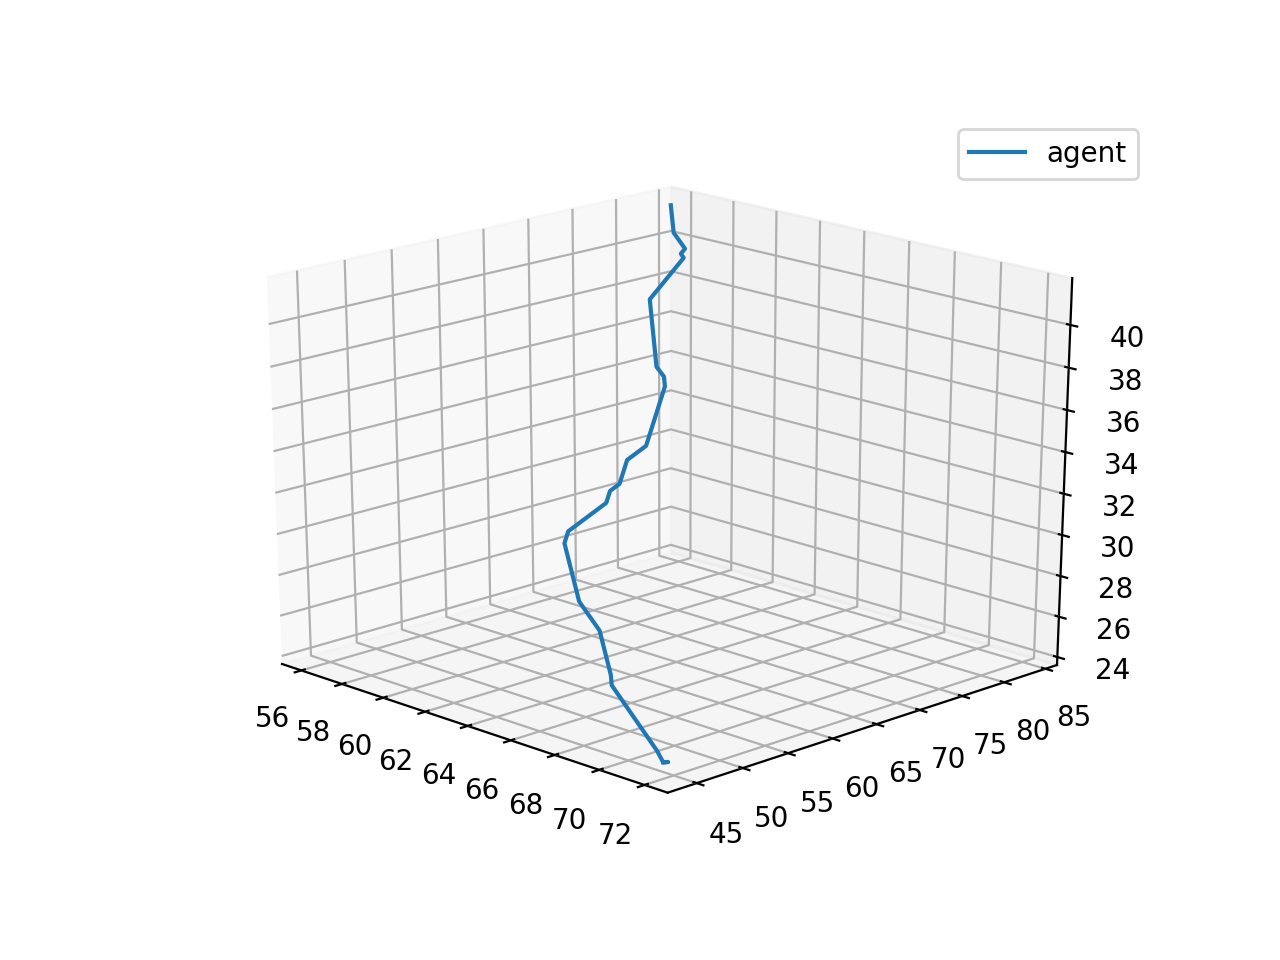

In [20]:
%matplotlib notebook
#states = torch.stack(all_states)

#ig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamlines_l[3].T[0], streamlines_l[3].T[1], streamlines_l[3].T[2])
#plt.legend(['gt', 'agent'])
plt.legend(['agent'])

In [ ]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
len(streamlines_cropped) / len(streamlines)

In [ ]:
save_vtk_streamlines(streamlines=streamlines, filename="dti_ijk_0.8_odfbased_all.vtk")

## Ground-truth directions from PMF

In [4]:
from dipy.direction import DeterministicMaximumDirectionGetter
dg = DeterministicMaximumDirectionGetter.from_pmf(pmf=env.pmf, max_angle=80, sphere=env.sphere_odf)

AttributeError: 'RLtractEnvironment' object has no attribute 'pmf'

In [ ]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
my_position = state.getCoordinate().double().squeeze(0).numpy()
current_direction = dg.initial_direction(my_position)
next_position = my_position + env.stepWidth * current_direction
print(state.getCoordinate().numpy(), "=>", next_position, current_direction)

In [51]:
current_direction = current_direction.squeeze(0)
next_position = next_position.squeeze(0)

In [64]:
next_position = my_position + env.stepWidth * current_direction
print(current_direction, next_position)
current_direction = current_direction
status = dg.get_direction(next_position, current_direction)
print(status, current_direction)

[ 0.89608922 -0.3756509  -0.23645403] [24.54468929 77.46559256 50.30053328]
0 [ 0.89608922 -0.3756509  -0.23645403]


[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.82781792 77.76611328 50.4896965 ] => [[24.54468929 77.46559256 50.30053328]] [[ 0.89608922 -0.3756509  -0.23645403]] 93
[23.8278

<IPython.core.display.Javascript object>


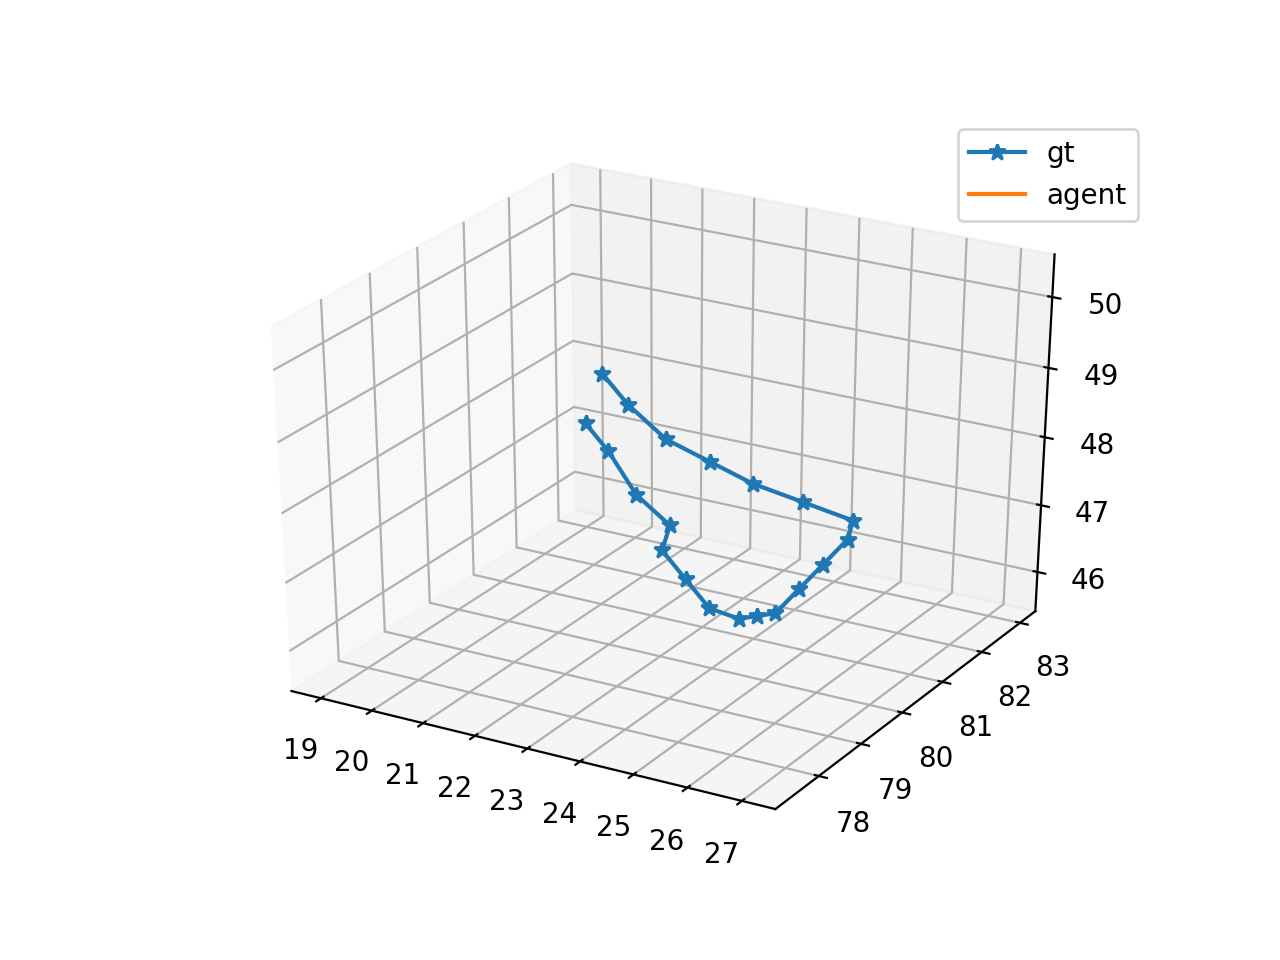

In [33]:
terminal = False
all_states = []
all_directions = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
my_position = state.getCoordinate().double().squeeze(0).numpy()
current_direction = dg.initial_direction(my_position)
#action = np.where(env.sphere.vertices == current_direction)[0][0]

for i in range(len(env.referenceStreamline_ijk)):
    #print(my_position, "=>", state.getCoordinate().numpy(), action, reward)
    #my_position = state.getCoordinate().double().squeeze(0)
    all_states.append(my_position)
    all_directions.append(current_direction)
    
    dg.
    next_position = my_position + env.stepWidth * current_direction
    
    dg.get_direction(next_position.squeeze(0).numpy(), current_direction.squeeze(0))
    action = np.where(env.sphere.vertices == current_direction)[0][0]
    #state, reward, terminal, _  = env.step(action)
    print(my_position.numpy(), "=>", next_position.numpy(), current_direction, action)
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

### Load pretrained agent and analyse its behaviour

In [3]:
streamline_index = 1
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(streamline_index=streamline_index, start_index=-2, start_middle_of_streamline=False)
env.referenceStreamline_ijk, state.getCoordinate()

(tensor([[23.8278, 77.7661, 50.4897],
         [24.5447, 77.4656, 50.3005],
         [25.2732, 77.4055, 49.9754],
         [25.5940, 77.9652, 49.5023],
         [25.9148, 78.5249, 49.0293],
         [26.4700, 78.9807, 48.6771],
         [27.0251, 79.4365, 48.3248],
         [26.6042, 79.8737, 47.8037],
         [26.0320, 80.0483, 47.2726],
         [25.4597, 80.2229, 46.7414],
         [24.8875, 80.3975, 46.2103],
         [24.2499, 80.7637, 45.8952],
         [23.6123, 81.1300, 45.5801],
         [22.8479, 81.3547, 45.5077],
         [22.1310, 81.6552, 45.6968],
         [21.4142, 81.9557, 45.8860],
         [21.0027, 82.6414, 45.9119],
         [20.2743, 82.7014, 46.2370],
         [19.7169, 82.6995, 46.8108],
         [19.0000, 83.0000, 47.0000]]),
 tensor([19.7169, 82.6995, 46.8108]))

In [5]:
# this agent got DWI input data and then predicts the direction out of 20 possible actions
# reward: odf20
model, step_counter, mean_reward, epsilon = load_model('defi_2.86_dwi_odf100.pt')

#model, step_counter, mean_reward, epsilon = load_model('defi_4.95_dwi_odf20.pt')
agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

agent.main_dqn.load_state_dict(model)
agent.target_dqn.load_state_dict(model)

Loading checkpoint from defi_2.86_dwi_odf100.pt


<All keys matched successfully>

In [6]:
if(False):
    # this agent got ODF input data and then predicts the direction out of 100 possible actions
    # reward: odf20
    model, step_counter, mean_reward, epsilon = load_model('defi_4.81_odf20state_odf20.pt')
    agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
                  agent_history_length=agent_history_length, 
                  memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

    agent.main_dqn.load_state_dict(model)
    agent.target_dqn.load_state_dict(model)

In [4]:
agent = Agent(n_actions=100, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

In [25]:
odf_peaks = torch.mean(torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position)), dim=1)
print(odf_peaks)

tensor([[[0.0702, 0.0538, 0.0764],
         [0.0715, 0.0613, 0.0742],
         [0.0530, 0.0675, 0.0631]],

        [[0.0703, 0.0548, 0.0784],
         [0.0728, 0.0663, 0.0811],
         [0.0551, 0.0735, 0.0715]],

        [[0.0712, 0.0569, 0.0789],
         [0.0728, 0.0662, 0.0803],
         [0.0543, 0.0687, 0.0602]],

        [[0.0696, 0.0517, 0.0750],
         [0.0714, 0.0597, 0.0722],
         [0.0539, 0.0701, 0.0705]],

        [[0.0725, 0.0606, 0.0819],
         [0.0756, 0.0744, 0.0879],
         [0.0579, 0.0761, 0.0677]],

        [[0.0721, 0.0581, 0.0774],
         [0.0735, 0.0651, 0.0745],
         [0.0546, 0.0664, 0.0582]],

        [[0.0700, 0.0537, 0.0772],
         [0.0736, 0.0669, 0.0791],
         [0.0577, 0.0773, 0.0795]],

        [[0.0731, 0.0615, 0.0809],
         [0.0752, 0.0719, 0.0824],
         [0.0571, 0.0712, 0.0581]],

        [[0.0715, 0.0554, 0.0754],
         [0.0727, 0.0608, 0.0695],
         [0.0540, 0.0665, 0.0622]],

        [[0.0722, 0.0601, 0.0820],
  

In [16]:
odf_peaks = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))
similarities = torch.nn.functional.cosine_similarity(env.directions, odf_peaks)
print(similarities)

RuntimeError: The size of tensor a (100) must match the size of tensor b (3) at non-singleton dimension 2

odf_cur:  tensor([0.0457, 0.0467, 0.0463, 0.0459, 0.0491, 0.0457, 0.0470, 0.0470, 0.0455,
        0.0483, 0.0479, 0.0461, 0.0484, 0.0461, 0.0485, 0.0466, 0.0457, 0.0495,
        0.0463, 0.0471, 0.0473, 0.0461, 0.0510, 0.0466, 0.0461, 0.0495, 0.0472,
        0.0482, 0.0471, 0.0461, 0.0507, 0.0474, 0.0466, 0.0482, 0.0472, 0.0500,
        0.0468, 0.0468, 0.0492, 0.0609, 0.0472, 0.0474, 0.0473, 0.0938, 0.0471,
        0.0466, 0.0483, 0.0489, 0.0481, 0.0468, 0.0457, 0.0467, 0.0463, 0.0459,
        0.0491, 0.0457, 0.0470, 0.0470, 0.0455, 0.0483, 0.0479, 0.0461, 0.0484,
        0.0461, 0.0485, 0.0466, 0.0457, 0.0495, 0.0463, 0.0471, 0.0473, 0.0461,
        0.0510, 0.0466, 0.0461, 0.0495, 0.0472, 0.0482, 0.0471, 0.0461, 0.0507,
        0.0474, 0.0466, 0.0482, 0.0472, 0.0500, 0.0468, 0.0468, 0.0492, 0.0609,
        0.0472, 0.0474, 0.0473, 0.0938, 0.0471, 0.0466, 0.0483, 0.0489, 0.0481,
        0.0468], dtype=torch.float64)
reward:  tensor([0.4876, 0.4976, 0.4932, 0.4892, 0.5230, 0.4871, 0.5006,

<IPython.core.display.Javascript object>


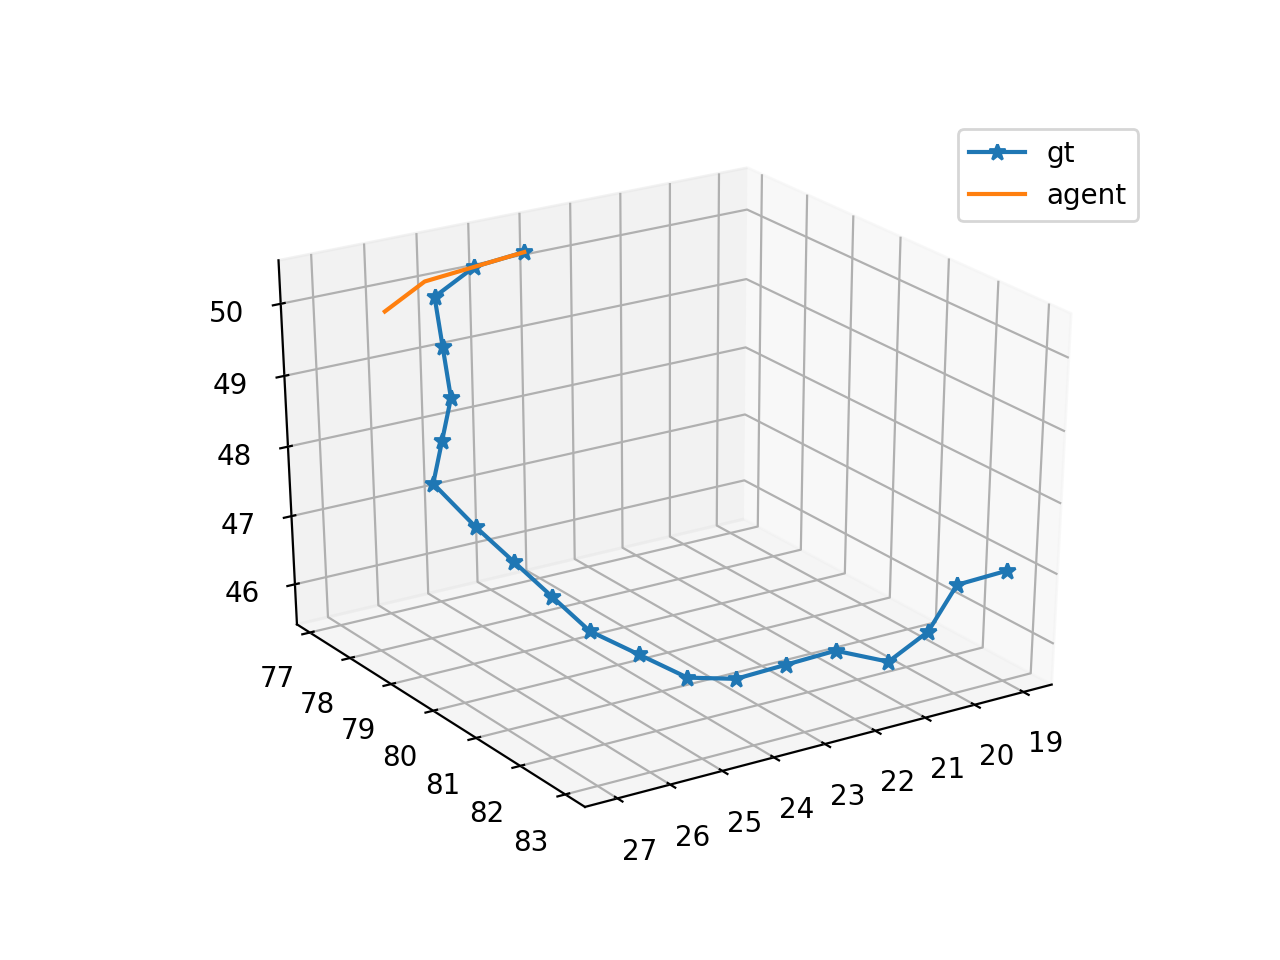

In [7]:
eval_rewards = []
all_distances = []
all_states = []
l2s = []
max_episode_length = 20
fa_threshold = 0.1
K = 3

#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=streamline_index, start_middle_of_streamline=False, start_index=0)
    next_state = state
    all_states.append(state.getCoordinate())
    eval_episode_reward = 0
    episode_final = 0
    current_direction = None
    while eval_steps < max_episode_length:
        
        #with torch.no_grad():
        #    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
        #    action = torch.argmax(agent.main_dqn(state_v)).item()
        
        my_position = all_states[-1]
        
        
       # if(eval_steps > 0):
       #     # compute tangent of previous step
       #     current_direction = all_states[-1] - all_states[-2]
       #     current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
       #     current_direction = current_direction.view(1,3)
       #     
       #     print(current_direction)
       #     print(env.directions[action])
       #     same ---> therefore sticking to env.directions[action]
        #current_direction = env.directions[action].view(1,3)
        
        #action = get_multi_best_action(current_direction, odf_interpolator, my_position, mysphere, sphere_verts_torch, K = K)
        action = env._get_best_action(current_direction, my_position)
        
        
        next_state, reward, terminal, _ = env.step(action)
        
        #reward = reward
        
        print(eval_steps, my_position, "=>", next_state.getCoordinate().numpy(), action, reward)

        
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate().squeeze())
                
        state = next_state
        print("---")
        if terminal:
            terminal = False
            break
            
        eval_episode_reward += reward
        eval_steps += 1

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

########################
### visualise streamline
########################
%matplotlib notebook 
state = env.reset(streamline_index=streamline_index) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

In [ ]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
all_states.append(state.getCoordinate())

#peak_indices = peaks_from_model(
#    model=dti_model, data=env.dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
#    min_separation_angle=25, mask=env.dataset.data.binarymask, npeaks=2) # Peaks and Metrics object


for i in range(len(env.referenceStreamline_ijk)-1):
    odf = torch.from_numpy(env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i]))[:,1,1,1].view(100)
    pmf = env.interpolatePMFatState(env.referenceStreamline_ijk[i].double().numpy())
    action = torch.argmax(odf)
    
    gt_direction = env.referenceStreamline_ijk[i+1] - env.referenceStreamline_ijk[i]
    gt_direction = (gt_direction / torch.sqrt(torch.sum(gt_direction**2))).view(1,3)
    
    gt_action = torch.argmax(torch.nn.functional.cosine_similarity(gt_direction, env.directions))
    
    next_state, reward, terminal, _ = env.step(action)
    all_states.append(next_state.getCoordinate().squeeze())
    
    print("Step: ", i)
    print("ODF gt: ", odf[gt_action].item())
    print("max ODF: ", torch.max(odf).item())
    print("PMF gt: ", pmf[gt_action])
    print("max PMF: ", np.max(pmf))
    print("action: ", action)
    

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

In [22]:
gt_direction.shape

torch.Size([3])

### Debug deterministic tracking of Dipy

In [ ]:
from dfibert.data import HCPDataContainer 
dataset = HCPDataContainer('100307')

In [2]:
from dfibert.data import ISMRMDataContainer 
dataset = ISMRMDataContainer() 

In [3]:
from scipy.interpolate import RegularGridInterpolator
import dipy.reconst.dti as dti

from dipy.direction import peaks_from_model
from dipy.data import get_sphere


# fit DTI model to data
dti_model = dti.TensorModel(dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(dataset.data.dwi, mask=dataset.data.binarymask)

#TODO: Issue => are we using the correct data for tractography actually??? The data got 288 gradient directions
# seems like its using the data of all bvals!!!
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

## set up interpolator for directions
x_range = np.arange(odf.shape[0])
y_range = np.arange(odf.shape[1])
z_range = np.arange(odf.shape[2])



#affine = dataset.data.aff # tracking in RAS
affine = np.eye(4) # tracking in IJK

In [16]:
#dir_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dir)
odf_interpolator = RegularGridInterpolator((x_range,y_range,z_range), odf)
fa_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dti_fit.fa)
#pd_interpolator = RegularGridInterpolator((x_range,y_range,z_range), peak_indices.peak_dirs)

In [11]:
env.shcoeff

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [6]:
peak_indices = peaks_from_model(
    model=dti_model, data=dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=dataset.data.binarymask, npeaks=2) # Peaks and Metrics object

In [ ]:
# tracking from pmf
import dipy

pmf = odf.clip(min=0)
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_pmf(pmf, 80, mysphere)

In [5]:
# tracking from spherical harmonics coefficients 
import dipy
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_shcoeff(peak_indices.shm_coeff, 80, peak_indices.sphere)

In [60]:
import dipy
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_shcoeff(env.shcoeff, 80, env.sphere)

In [4]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
fa_img = dti_fit.fa
fa_img[np.isnan(fa_img)] = 0
stopping_criterion = ThresholdStoppingCriterion(fa_img, .1)

In [5]:
from dipy.tracking import utils

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

In [8]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialize local tracking - computation happens in the next step. 
# EuDX, https://dipy.org/documentation/1.0.0./examples_built/tracking_introduction_eudx/#garyfallidis12
# EuDx => change dg into pam
streamlines_generator = LocalTracking(
    dg, stopping_criterion, seeds, affine=np.eye(4), step_size=.8) # tracking in IJK

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)
streamlines[0]
# tracked_streamlines = filter(lambda sl: len(sl) >= 10, tracked_streamlines)

array([[18., 69., 56.]])

In [99]:
streamlines_cropped[0]

array([[23.82781835, 77.76611286, 50.48969732],
       [24.54468972, 77.46559213, 50.3005341 ],
       [25.27317434, 77.40550996, 49.97541827],
       [25.59399636, 77.96522357, 49.50234966],
       [25.91481837, 78.52493717, 49.02928104],
       [26.46997909, 78.98071782, 48.67705871],
       [27.02513982, 79.43649847, 48.32483637],
       [26.60419108, 79.87374546, 47.80366727],
       [26.03196342, 80.04831604, 47.27255466],
       [25.45973575, 80.22288661, 46.74144204],
       [24.88750808, 80.39745719, 46.21032942],
       [24.24989204, 80.76372485, 45.89522026],
       [23.612276  , 81.1299925 , 45.58011109],
       [22.84790745, 81.35470406, 45.50768568],
       [22.13103608, 81.65522478, 45.69684891],
       [21.4141647 , 81.95574551, 45.88601213],
       [21.00274669, 82.64135976, 45.91186404],
       [20.27426208, 82.70144193, 46.23697986],
       [19.71687138, 82.69947928, 46.81083678],
       [19.        , 83.        , 47.        ]])

In [100]:
streamline = streamlines_cropped[0]

In [18]:
gt_action = streamline[1]-streamline[0]
print(gt_action)

[ 0.71687138 -0.30052072 -0.18916322]


In [22]:
dg_action = dg.initial_direction(streamline[0])[0]
print(dg_action)

[ 0.89608922 -0.3756509  -0.23645403]


In [26]:
env.directions[torch.argmax(torch.nn.functional.cosine_similarity(env.directions, torch.from_numpy(gt_action).unsqueeze(0)))]

tensor([ 0.8961, -0.3757, -0.2365], dtype=torch.float64)

In [27]:
next_pos = streamline[0] + dg_action
print(next_pos)

[24.72390757 77.39046195 50.25324329]


In [29]:
dg_action_1 = dg.get_direction(next_pos, dg_action)
print(dg_action)

[ 0.89608922 -0.3756509  -0.23645403]


In [30]:
gt_action_1 = streamline[2]-streamline[1]
print(gt_action_1)

[ 0.72848461 -0.06008217 -0.32511583]


In [32]:
dg_action_init = dg.initial_direction(next_pos)
print(dg_action_init)

[[-0.89608922  0.3756509   0.23645403]]


In [31]:
env.directions[torch.argmax(torch.nn.functional.cosine_similarity(env.directions, torch.from_numpy(gt_action_1).unsqueeze(0)))]

tensor([ 0.9106, -0.0751, -0.4064], dtype=torch.float64)

In [34]:
next_pos_1 = next_pos + dg_action
print(next_pos_1, streamline[2])

[25.61999679 77.01481105 50.01678926] [25.27317434 77.40550996 49.97541827]


In [35]:
changed = dg.get_direction(next_pos_1, dg_action)
print(changed, dg_action)

0 [ 0.91060577 -0.07510271 -0.40639478]


In [106]:
curr_pos = streamline[0]
status = 1
all_states = []
all_states.append(curr_pos)
for i in range(len(streamline)-1):
    print("Ground truth: ")
    gt_action = streamline[i+1] - streamline[i]
    print(streamline[i], "+", gt_action, "==>", streamline[i+1])
    #if i < 1:
    dg_action = dg.initial_direction(curr_pos)
    print(dg_action)
    dg_action = dg_action[0]
    if np.dot(dg_action, gt_action) > 0:
        curr_dir = True
    else:
        dg_action = -dg_action
    #else:
    #    status = dg.get_direction(curr_pos, dg_action)
        #print("changed direction vector? ", "yes" if status == 0 else "no")
        
    next_pos = curr_pos + dg_action
    print("DG:")
    print(curr_pos, "+", dg_action, "==>", next_pos)
    curr_pos = next_pos
    all_states.append(curr_pos)

Ground truth: 
[23.82781835 77.76611286 50.48969732] + [ 0.71687138 -0.30052072 -0.18916322] ==> [24.54468972 77.46559213 50.3005341 ]
[[ 0.89608922 -0.3756509  -0.23645403]]
DG:
[23.82781835 77.76611286 50.48969732] + [ 0.89608922 -0.3756509  -0.23645403] ==> [24.72390757 77.39046195 50.25324329]
Ground truth: 
[24.54468972 77.46559213 50.3005341 ] + [ 0.72848461 -0.06008217 -0.32511583] ==> [25.27317434 77.40550996 49.97541827]
[[-0.89608922  0.3756509   0.23645403]]
DG:
[24.72390757 77.39046195 50.25324329] + [ 0.89608922 -0.3756509  -0.23645403] ==> [25.61999679 77.01481105 50.01678926]
Ground truth: 
[25.27317434 77.40550996 49.97541827] + [ 0.32082202  0.5597136  -0.47306862] ==> [25.59399636 77.96522357 49.50234966]
[[-0.91060577  0.07510271  0.40639478]]
DG:
[25.61999679 77.01481105 50.01678926] + [ 0.91060577 -0.07510271 -0.40639478] ==> [26.53060256 76.93970834 49.61039448]
Ground truth: 
[25.59399636 77.96522357 49.50234966] + [ 0.32082202  0.5597136  -0.47306862] ==> [25.91

In [120]:
curr_pos = streamline[-1]
status = 1
all_states = []
all_states.append(curr_pos)
for i in range(len(streamline)-1):
    #print("Ground truth: ")
    #gt_action = streamline[i+1] - streamline[i]
    #print(streamline[i], "+", gt_action, "==>", streamline[i+1])
    if i < 1:
        dg_action = dg.initial_direction(curr_pos)[0] * -1
        #dg_action = env.sphere.vertices[np.argmax(torch.nn.functional.cosine_similarity(env.directions, torch.tensor(dg_action)))]
    else:
        status = dg.get_direction(curr_pos, dg_action)
        #print("changed direction vector? ", "yes" if status == 0 else "no")
        
    next_pos = curr_pos + dg_action
    print("DG:")
    print(curr_pos, "+", dg_action, "==>", next_pos)
    curr_pos = next_pos
    all_states.append(curr_pos)

DG:
[19. 83. 47.] + [ 0.89608922 -0.3756509  -0.23645403] ==> [19.89608922 82.6243491  46.76354597]
DG:
[19.89608922 82.6243491  46.76354597] + [ 0.91060577 -0.07510271 -0.40639478] ==> [20.80669499 82.54924638 46.35715119]
DG:
[20.80669499 82.54924638 46.35715119] + [ 0.72649116 -0.35497082 -0.58839299] ==> [21.53318615 82.19427556 45.76875819]
DG:
[21.53318615 82.19427556 45.76875819] + [ 0.51427251 -0.85701781 -0.03231488] ==> [22.04745866 81.33725775 45.73644331]
DG:
[22.04745866 81.33725775 45.73644331] + [ 0.91060577 -0.07510271 -0.40639478] ==> [22.95806442 81.26215504 45.33004853]
DG:
[22.95806442 81.26215504 45.33004853] + [ 0.95546068 -0.28088945  0.09053176] ==> [23.91352511 80.98126559 45.42058029]
DG:
[23.91352511 80.98126559 45.42058029] + [ 0.79702005 -0.45783457  0.39388646] ==> [24.71054516 80.52343102 45.81446675]
DG:
[24.71054516 80.52343102 45.81446675] + [ 0.71528458 -0.21821322  0.66389077] ==> [25.42582974 80.3052178  46.47835752]
DG:
[25.42582974 80.3052178  46.

<IPython.core.display.Javascript object>


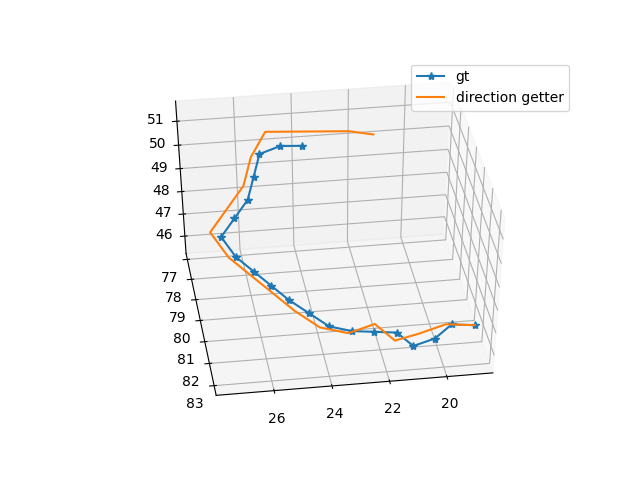

In [121]:
states = np.asarray(all_states)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(streamline.T[0], streamline.T[1], streamline.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'direction getter'])

In [115]:
init_directions = dg.initial_direction(streamline[-1])
print(init_directions)

[[-0.89608922  0.3756509   0.23645403]
 [-0.69673838 -0.00245331  0.71732114]]


In [ ]:
seed_pos = streamline[-1]
first_step = dg.initial_direction[seed_pos][0]
streamline_ = dg.generate_streamline(seed_pos, first_step, vs,
                                              0.8, sc,
                                              streamline, stream_status,
                                              fixedstep)

In [71]:
from dipy.tracking.local_tracking import local_tracker
from dipy.align import Bunch

In [72]:
TissueTypes = Bunch(OUTSIDEIMAGE=-1, INVALIDPOINT=0, TRACKPOINT=1, ENDPOINT=2)

In [ ]:
class LocalTracking(object):

    @staticmethod
    def _get_voxel_size(affine):
        """Computes the voxel sizes of an image from the affine.
        Checks that the affine does not have any shear because local_tracker
        assumes that the data is sampled on a regular grid.
        """
        lin = affine[:3, :3]
        dotlin = np.dot(lin.T, lin)
        # Check that the affine is well behaved
        if not np.allclose(np.triu(dotlin, 1), 0., atol=1e-5):
            msg = ("The affine provided seems to contain shearing, data must "
                   "be acquired or interpolated on a regular grid to be used "
                   "with `LocalTracking`.")
            raise ValueError(msg)
        return np.sqrt(dotlin.diagonal())

    def __init__(self, direction_getter, stopping_criterion, seeds, affine,
                 step_size, max_cross=None, maxlen=500, fixedstep=True,
                 return_all=True, random_seed=None, save_seeds=False):
        """Creates streamlines by using local fiber-tracking.
        Parameters
        ----------
        direction_getter : instance of DirectionGetter
            Used to get directions for fiber tracking.
        stopping_criterion : instance of StoppingCriterion
            Identifies endpoints and invalid points to inform tracking.
        seeds : array (N, 3)
            Points to seed the tracking. Seed points should be given in point
            space of the track (see ``affine``).
        affine : array (4, 4)
            Coordinate space for the streamline point with respect to voxel
            indices of input data. This affine can contain scaling, rotational,
            and translational components but should not contain any shearing.
            An identity matrix can be used to generate streamlines in "voxel
            coordinates" as long as isotropic voxels were used to acquire the
            data.
        step_size : float
            Step size used for tracking.
        max_cross : int or None
            The maximum number of direction to track from each seed in crossing
            voxels. By default all initial directions are tracked.
        maxlen : int
            Maximum number of steps to track from seed. Used to prevent
            infinite loops.
        fixedstep : bool
            If true, a fixed stepsize is used, otherwise a variable step size
            is used.
        return_all : bool
            If true, return all generated streamlines, otherwise only
            streamlines reaching end points or exiting the image.
        random_seed : int
            The seed for the random seed generator (numpy.random.seed and
            random.seed).
        save_seeds : bool
            If True, return seeds alongside streamlines
        """

        self.direction_getter = direction_getter
        self.stopping_criterion = stopping_criterion
        self.seeds = seeds
        if affine.shape != (4, 4):
            raise ValueError("affine should be a (4, 4) array.")
        if step_size <= 0:
            raise ValueError("step_size must be greater than 0.")
        if maxlen < 1:
            raise ValueError("maxlen must be greater than 0.")
        if not isinstance(seeds, Iterable):
            raise ValueError("seeds should be (N,3) array.")

        self.affine = affine
        self._voxel_size = np.ascontiguousarray(self._get_voxel_size(affine),
                                                dtype=float)
        self.step_size = step_size
        self.fixed_stepsize = fixedstep
        self.max_cross = max_cross
        self.max_length = maxlen
        self.return_all = return_all
        self.random_seed = random_seed
        self.save_seeds = save_seeds

    def _tracker(self, seed, first_step, streamline):
        return local_tracker(self.direction_getter,
                             self.stopping_criterion,
                             seed,
                             first_step,
                             self._voxel_size,
                             streamline,
                             self.step_size,
                             self.fixed_stepsize)

    def __iter__(self):
        # Make tracks, move them to point space and return
        track = self._generate_tractogram()

        return utils.transform_tracking_output(track, self.affine,
                                               save_seeds=self.save_seeds)

    def _generate_tractogram(self):
        """A streamline generator"""

        # Get inverse transform (lin/offset) for seeds
        inv_A = np.linalg.inv(self.affine)
        lin = inv_A[:3, :3]
        offset = inv_A[:3, 3]

        F = np.empty((self.max_length + 1, 3), dtype=float)
        B = F.copy()
        for s in self.seeds:
            s = np.dot(lin, s) + offset                                 # mapping from ijk to ras
            # Set the random seed in numpy and random
            if self.random_seed is not None:
                s_random_seed = hash(np.abs((np.sum(s)) + self.random_seed)) \
                    % (2**32 - 1)
                random.seed(s_random_seed)
                np.random.seed(s_random_seed)
            directions = self.direction_getter.initial_direction(s)     # get initial direction for seed point
                                                                        # already returns 1 direction for curr example
            if directions.size == 0 and self.return_all:                
                # only the seed position
                if self.save_seeds:
                    yield [s], s
                else:
                    yield [s]
            directions = directions[:self.max_cross]                    # only track for allowed directions
            for first_step in directions:
                stepsF, stream_status = self._tracker(s, first_step, F) 
                if not (self.return_all or
                        stream_status == StreamlineStatus.ENDPOINT or
                        stream_status == StreamlineStatus.OUTSIDEIMAGE):
                    continue
                first_step = -first_step
                stepsB, stream_status = self._tracker(s, first_step, B)
                if not (self.return_all or
                        stream_status == StreamlineStatus.ENDPOINT or
                        stream_status == StreamlineStatus.OUTSIDEIMAGE):
                    continue
                if stepsB == 1:
                    streamline = F[:stepsF].copy()
                else:
                    parts = (B[stepsB - 1:0:-1], F[:stepsF])
                    streamline = np.concatenate(parts, axis=0)

                # move to the next streamline if only the seed position
                # and not return all
                if len(streamline) > 1 or self.return_all:
                    if self.save_seeds:
                        yield streamline, s
                    else:
                        yield streamline


In [73]:
def get_voxel_size(affine):
        """Computes the voxel sizes of an image from the affine.
 
        Checks that the affine does not have any shear because local_tracker
        assumes that the data is sampled on a regular grid.
 
        """
        lin = affine[:3, :3]
        dotlin = np.dot(lin.T, lin)
        # Check that the affine is well behaved
        if not np.allclose(np.triu(dotlin, 1), 0.):
            msg = ("The affine provided seems to contain shearing, data must "
                   "be acquired or interpolated on a regular grid to be used "
                   "with `LocalTracking`.")
            raise ValueError(msg)
        return np.sqrt(dotlin.diagonal())

In [74]:
"""A streamline generator"""
N = 500
dg = dg
tc = stopping_criterion
ss = 0.8
fixed = True
max_cross = None
vs = get_voxel_size(affine)
print(vs)
return_all = True

[1. 1. 1.]


In [75]:

# Get inverse transform (lin/offset) for seeds
inv_A = np.linalg.inv(affine)
lin = inv_A[:3, :3]
offset = inv_A[:3, 3]

print(inv_A)
print(lin)
print(offset)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0.]


In [76]:
s = seeds[0]
print(s)
s = np.dot(lin, s) + offset
print(s)

[18. 69. 56.]
[18. 69. 56.]


In [77]:
directions = dg.initial_direction(s)
print(directions)

[[-0.24365496  0.95053011 -0.19267788]]


In [78]:
directions = directions[:max_cross]
print(directions)

[[-0.24365496  0.95053011 -0.19267788]]


In [79]:
F = np.empty((N + 1, 3), dtype=float)
print(F)
B = F.copy()

[[2.31778569e-310 2.31778569e-310 4.63557896e-310]
 [4.63557896e-310 4.94065646e-324 4.63557896e-310]
 [4.94065646e-324 4.63557896e-310 1.18575755e-322]
 ...
 [1.27252315e+189 8.50010343e+165 1.88712830e+238]
 [1.11286908e+247 5.22555809e+208 2.55556371e-052]
 [2.29148966e+262 7.13719431e+020 1.81052399e-052]]


In [80]:
stepsF, tissue_class = local_tracker(dg, tc, s, directions[0], vs, F ,ss, fixed)
print(stepsF, tissue_class)

1 2


In [81]:
first_step = -directions[0]
print(first_step)

[ 0.24365496 -0.95053011  0.19267788]


In [82]:
stepsB, tissue_class = local_tracker(dg, tc, s, first_step, vs, B, ss, fixed)
print(stepsB, tissue_class)

1 2


In [84]:
if stepsB == 1:
    streamline = F[:stepsF].copy()

In [85]:
print(streamline)

[[18. 69. 56.]]


In [95]:
seeds[15]

array([18., 90., 47.])

In [116]:
F = np.empty((N + 1, 3), dtype=float)
B = F.copy()
for s in seeds:
    s = np.dot(lin, s) + offset
    directions = dg.initial_direction(s)
    if directions.size == 0 and return_all:
        # only the seed position
        streamlines.append([s])
    directions = directions[:max_cross]
    for first_step in directions:
        stepsF, tissue_class = local_tracker(dg, tc, s, first_step,
                                             vs, F, ss, fixed)
        if not (return_all or
                tissue_class == TissueTypes.ENDPOINT or
                tissue_class == TissueTypes.OUTSIDEIMAGE):
            continue
        first_step = -first_step
        stepsB, tissue_class = local_tracker(dg, tc, s, first_step,
                                             vs, B, ss, fixed)
        if not (return_all or
                tissue_class == TissueTypes.ENDPOINT or
                tissue_class == TissueTypes.OUTSIDEIMAGE):
            continue

        if stepsB == 1:
            streamline = F[:stepsF].copy()
        else:
            parts = (B[stepsB-1:0:-1], F[:stepsF])
            streamline = np.concatenate(parts, axis=0)
        streamlines.append([streamline])

In [132]:
print(streamlines[14])

[array([[18.        , 85.        , 52.        ],
       [18.01490177, 85.18581047, 51.2220203 ]])]


In [125]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
print(streamlines_cropped[0:20])

[]


In [14]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
len(streamlines_cropped) / len(streamlines)

0.30317957107799554

In [18]:
save_vtk_streamlines(streamlines=streamlines_cropped, filename="dti_ijk_0.8_maxDirecGetter.vtk")

## Ground-truth direction

In [42]:
cool_sl = 2
idx = 4
ref_sl = env.referenceStreamline_ijk

In [43]:
diff_vector = (ref_sl[idx+1] - ref_sl[idx])
diff_vector_norm = diff_vector / torch.sqrt(torch.sum(diff_vector**2))
"gt", diff_vector_norm

('gt', tensor([ 0.6940,  0.5697, -0.4403]))

In [44]:
#pv_norm = pd_interpolator(ref_sl[idx+1]) / np.sqrt(np.sum((pd_interpolator(ref_sl[idx+1])**2)))

odf_max = np.argmax(odf_interpolator(ref_sl[idx]))
odf_max_norm = mysphere.vertices[odf_max]

#"pv", pv_norm, 
"odf", odf_max_norm

('odf', array([ 0.40102752,  0.699642  , -0.59133577]))

<IPython.core.display.Javascript object>


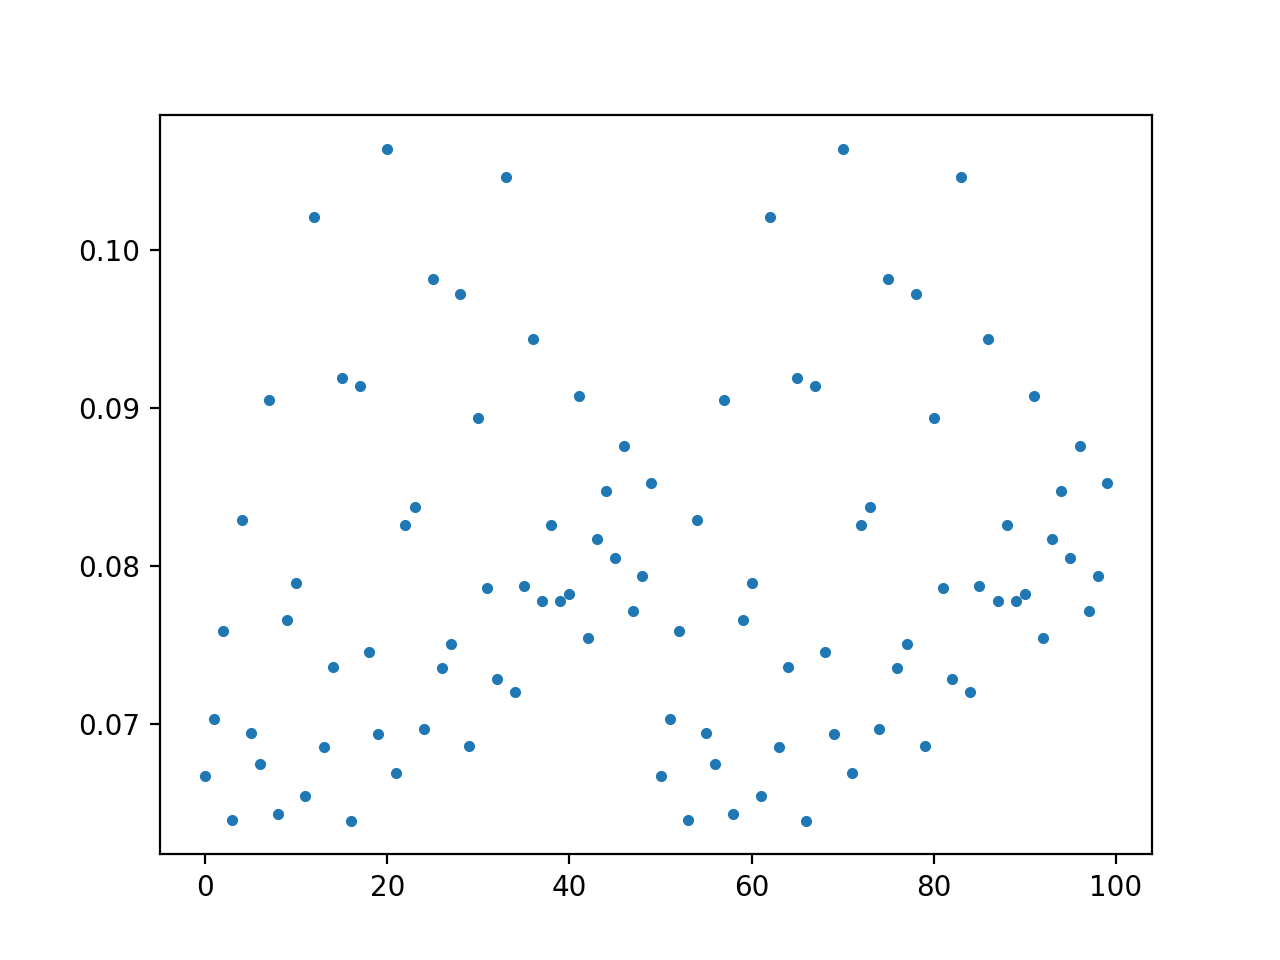

In [45]:
odf_x = odf_interpolator(ref_sl[idx]).squeeze()
plt.plot(odf_x,'.')

# Debug data  generation

In [ ]:
import os, sys

import gym
from gym.spaces import Discrete, Box
import numpy as np

from dipy.data import get_sphere
from dipy.data import HemiSphere, Sphere
from dipy.core.sphere import disperse_charges
import torch


from dfibert.data.postprocessing import res100, resample
from dfibert.data import HCPDataContainer, ISMRMDataContainer, PointOutsideOfDWIError
from dfibert.tracker import StreamlinesFromFileTracker
from dfibert.util import get_grid

import shapely.geometry as geom
from shapely.ops import nearest_points
from shapely.strtree import STRtree


from collections import deque

dataset = HCPDataContainer('100307')
dataset.normalize()

In [ ]:
coord, data = next_state.getCoordinate(), next_state.getValue()
grid = get_grid(np.array([3,3,3]))
ras_points = env.dataset.to_ras(coord)
ras_points = grid + ras_points

interpolated_dwi = env.dataset.get_interpolated_dwi(ras_points, postprocessing=None)
#interpolated_dwi = np.rollaxis(interpolated_dwi,3)

dti_fit = dti_model.fit(interpolated_dwi)
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

In [ ]:
plt.figure()
plt.plot(range(100), np.mean(odf.reshape(-1,100), axis=0))
plt.plot(range(100), odf[1,1,1,:])

In [ ]:
interpolated_dwi.shape

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

# Analysis of our environment

In [ ]:
env._get_best_action(None, my_position)

In [ ]:
gt_direction = env.referenceStreamline_ijk.T[:,-1] - env.referenceStreamline_ijk.T[:,-2]
gt_direction = gt_direction / torch.sqrt(torch.sum(gt_direction**2))
gt_direction = gt_direction.view(1,3)

gt_direction

In [ ]:
env.directions[96]

In [ ]:
my_position

In [ ]:
my_position = all_states[0]
eval_steps = 0

current_direction = None
        
if(eval_steps > 0):
    # compute tangent of previous step
    current_direction = all_states[-1] - all_states[-2]
    current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
    current_direction = current_direction.view(1,3)

action = env._get_best_action(current_direction, my_position)
action

In [ ]:
# main peak from ODF
peak_dir = env._get_best_action_ODF(my_position)

# cosine similarity wrt. all directions
reward = abs(torch.nn.functional.cosine_similarity(peak_dir.view(1,-1), env.directions))

if(current_direction is not None):
    reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))

best_action = torch.argmax(reward)
print("Max reward: %.2f" % (torch.max(reward).cpu().detach().numpy()))

In [ ]:
odf_l = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))[:,1,1,1].view(100)
#odf_l = torch.mean(odf_l, 1)
reward = odf_l / torch.max(odf_l)
reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))
torch.argmax(odf_l), torch.argmax(reward)

In [ ]:
(torch.nn.functional.cosine_similarity(current_direction, env.directions)).shape

In [ ]:
reward.shape

In [ ]:
reward[73]

In [ ]:
fig = plt.figure()
plt.plot(reward.cpu().detach().numpy().squeeze(), '.')

In [ ]:
env.directions

In [ ]:
current_direction

In [ ]:
my_position.cpu().numpy()

In [ ]:
states.T.shape

In [ ]:
k_largest.shape

In [ ]:
np.argmax(my_odf.squeeze())

In [ ]:
all_states

In [ ]:
### visualise streamline
%matplotlib notebook 
state = env.reset(streamline_index=50) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][0:10], env.referenceStreamline_ijk.T[1][0:10], env.referenceStreamline_ijk.T[2][0:10])
ax.plot3D(states.T[0][0:10], states.T[1][0:10], states.T[2][0:10])